In [ ]:
# !pip install keras-utils

In [ ]:
!pip install pycocotools

In [ ]:
!apt-get -qq install -y graphviz && pip install pydot

In [ ]:
!pip install graphviz

In [ ]:
import pydot
import graphviz
from keras.utils import plot_model

In [ ]:
import keras.applications.xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras.models import  load_model
#from tensorflow.keras.utils import plot_model
from keras.utils import plot_model

In [ ]:
from itertools import chain
from keras.preprocessing.text import Tokenizer

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import cv2
import pickle
from tqdm import tqdm
from pickle import dump


from pycocotools.coco import COCO

from collections import Counter
import string


In [ ]:
#import nltk
#nltk.download("stopwords")
#from nltk.corpus import stopwords

#import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.optimizers import Adam
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
#from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import add

In [ ]:
# mount google drive - data stored in folder w266_proj
from google.colab import drive
drive.mount ('/content/gdrive')
data_path = '/content/gdrive/MyDrive/w266_proj'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# for printing long text over multiple lines
import textwrap
import json

def print_text(text):
  wrapper = textwrap.TextWrapper(width= 150,
                                 break_long_words=False,
                                 break_on_hyphens=False)
  return print(wrapper.fill(json.dumps(text)))

In [ ]:
# coco API git: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb
# initialize coco api for instance annotations

coco=COCO(data_path + "/annotations/instances_train2017.json")

loading annotations into memory...
Done (t=15.31s)
creating index...
index created!


In [ ]:
# exploring coco
# getCadIds return a list of category IDs as a list
print('Total coco categories'.format(len(coco.getCatIds())))            # total categories
print('First ten categories: {} '.format((coco.getCatIds()[:10])))      # total categories
print('FLast ten categories: {} '.format((coco.getCatIds()[-10:])))     # total categories

Total coco categories
First ten categories: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 
FLast ten categories: [80, 81, 82, 84, 85, 86, 87, 88, 89, 90] 


In [ ]:
coco.loadCats([1,5,7])

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}]

In [ ]:
# exploring categories
# loadCat functon takes catIDs as input and returns a list of dictionaries containing the categories info

print('Load category data of IDs 1, 5, and 7:  {}'.format(coco.loadCats([1,5,7])))

cat_list = coco.loadCats(coco.getCatIds())                  # load cat for all cat IDs
print('First three categogies: {}'.format(cat_list[:3]))
print('Last three categogies: {}'.format(cat_list[-3:]))

Load category data of IDs 1, 5, and 7:  [{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}]
First three categogies: [{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}]
Last three categogies: [{'supercategory': 'indoor', 'id': 88, 'name': 'teddy bear'}, {'supercategory': 'indoor', 'id': 89, 'name': 'hair drier'}, {'supercategory': 'indoor', 'id': 90, 'name': 'toothbrush'}]


In [ ]:
# From the above cell -- Each dictionary has the format {'supercategory': 'XXX', 'id': XXX, 'name': 'XXX'} -- where name is catgegory, ID is category ID and supercategory is supercategory

# what are all the super categories?

def get_supercat(coco):
  cat_list = coco.loadCats(coco.getCatIds())
  return [cat['supercategory'] for cat in cat_list]

supercat = get_supercat(coco)
print('Total coco supercategories: {} '.format(len(set(supercat))))   # set to get unique values
unique_supercat = set(supercat)
print('coco super categories: {} '.format(', '.join(set(unique_supercat))))

Total coco supercategories: 12 
coco super categories: person, animal, indoor, vehicle, electronic, kitchen, accessory, outdoor, furniture, food, appliance, sports 


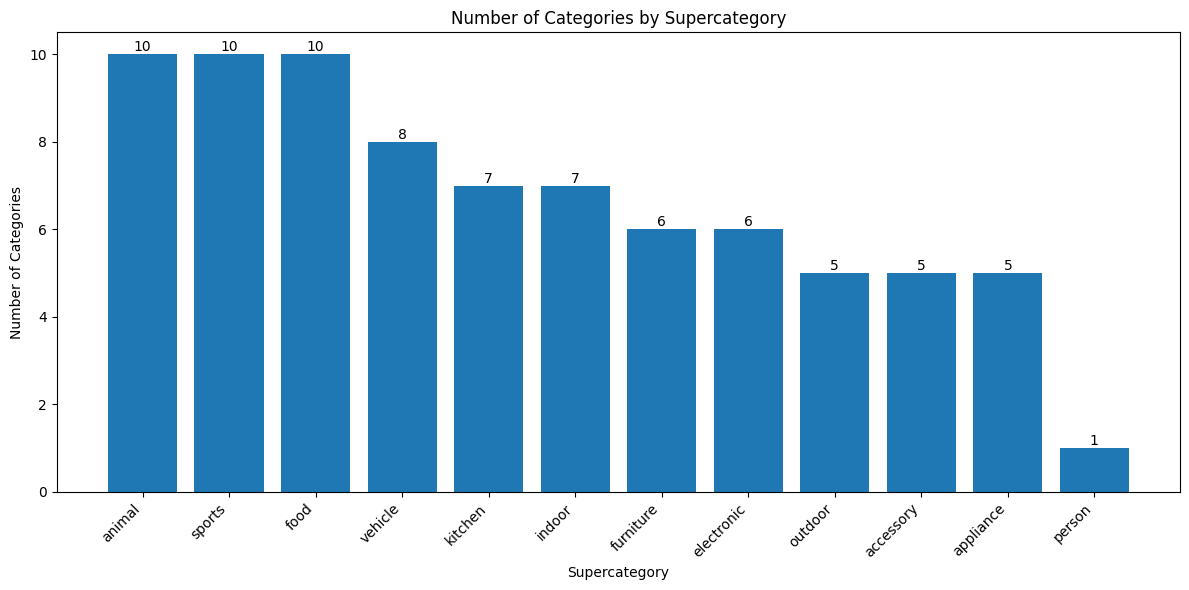

In [ ]:
# plot of number of categories by supercategory in descending order and add values in the plot

# count the number of categories per supercategory
cat_count = Counter(supercat)
# sort the supercategories in descending order of frequency
sorted_supercat = sorted(cat_count, key=cat_count.get, reverse=True)
# create a bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_supercat, [cat_count[cat] for cat in sorted_supercat])
plt.xlabel('Supercategory')
plt.ylabel('Number of Categories')
plt.title('Number of Categories by Supercategory')
plt.xticks(rotation=45, ha='right')
# add values to the bars
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')
plt.tight_layout()
plt.show()

In [ ]:
# Whar are all the categories?
def get_cat(coco):
  cat_list = coco.loadCats(coco.getCatIds())
  return [cat['name'] for cat in cat_list]

cat = get_cat(coco)
print('Total coco categories: {} '.format(len(cat)))
print('First ten coco categories: {} '.format(', '.join(cat[:10])))          # no set required - all values are unique
print('Last  ten coco categories: {} '.format(', '.join(cat[-10:])))

Total coco categories: 80 
First ten coco categories: person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light 
Last  ten coco categories: toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush 


In [ ]:
# What are the IDs of each category

def get_catCatId(coco, cat):

  catIds = coco.getCatIds(catNms=cat)
  cat_catId = {}
  for i in range(0,len(cat)):
    cat_catId[cat[i]] = catIds[i]
  return cat_catId


cat_catId = get_catCatId(coco, cat)                    # *** This is an important dictionary and I will be using it

print('Categories and their IDs:')
print_text(cat_catId)

Categories and their IDs:
{"person": 1, "bicycle": 2, "car": 3, "motorcycle": 4, "airplane": 5, "bus": 6, "train": 7, "truck": 8, "boat": 9, "traffic light": 10, "fire
hydrant": 11, "stop sign": 13, "parking meter": 14, "bench": 15, "bird": 16, "cat": 17, "dog": 18, "horse": 19, "sheep": 20, "cow": 21, "elephant":
22, "bear": 23, "zebra": 24, "giraffe": 25, "backpack": 27, "umbrella": 28, "handbag": 31, "tie": 32, "suitcase": 33, "frisbee": 34, "skis": 35,
"snowboard": 36, "sports ball": 37, "kite": 38, "baseball bat": 39, "baseball glove": 40, "skateboard": 41, "surfboard": 42, "tennis racket": 43,
"bottle": 44, "wine glass": 46, "cup": 47, "fork": 48, "knife": 49, "spoon": 50, "bowl": 51, "banana": 52, "apple": 53, "sandwich": 54, "orange": 55,
"broccoli": 56, "carrot": 57, "hot dog": 58, "pizza": 59, "donut": 60, "cake": 61, "chair": 62, "couch": 63, "potted plant": 64, "bed": 65, "dining
table": 67, "toilet": 70, "tv": 72, "laptop": 73, "mouse": 74, "remote": 75, "keyboard": 76, "c

In [ ]:
# Number of images per subcategories

def get_cat_imgId(coco, cat_catId):
  cat_imgId = {}
  for cat in cat_catId:
    imgIds = coco.getImgIds(catIds=cat_catId[cat])        # get all the image IDs for a specific category - need to pass ID to catIds
    cat_imgId[cat] = imgIds
  return cat_imgId

cat_imgId = get_cat_imgId(coco, cat_catId)

print('First 10 image IDs of Person: {}\n'.format(str(cat_imgId['person'][:10])))

cat_numImg = {key: len(value) for key, value in cat_imgId.items()}
cat_numImg = {k: v for k, v in sorted(cat_numImg.items(), key=lambda item: item[1], reverse=True)}
print("Total images in each sub categories:")
print_text(cat_numImg)

First 10 image IDs of Person: [262145, 262146, 524291, 262148, 393223, 393224, 524297, 393227, 131084, 393230]

Total images in each sub categories:
{"person": 64115, "chair": 12774, "car": 12251, "dining table": 11837, "cup": 9189, "bottle": 8501, "bowl": 7111, "handbag": 6841, "truck": 6127,
"bench": 5570, "backpack": 5528, "book": 5332, "cell phone": 4803, "sink": 4678, "clock": 4659, "tv": 4561, "potted plant": 4452, "couch": 4423,
"dog": 4385, "knife": 4326, "sports ball": 4262, "traffic light": 4139, "cat": 4114, "umbrella": 3968, "bus": 3952, "tie": 3810, "bed": 3682, "vase":
3593, "train": 3588, "fork": 3555, "spoon": 3529, "laptop": 3524, "motorcycle": 3502, "surfboard": 3486, "skateboard": 3476, "tennis racket": 3394,
"toilet": 3353, "bicycle": 3252, "bird": 3237, "pizza": 3166, "skis": 3082, "remote": 3076, "boat": 3025, "airplane": 2986, "horse": 2941, "cake":
2925, "oven": 2877, "baseball glove": 2629, "giraffe": 2546, "wine glass": 2533, "baseball bat": 2506, "suitcase": 

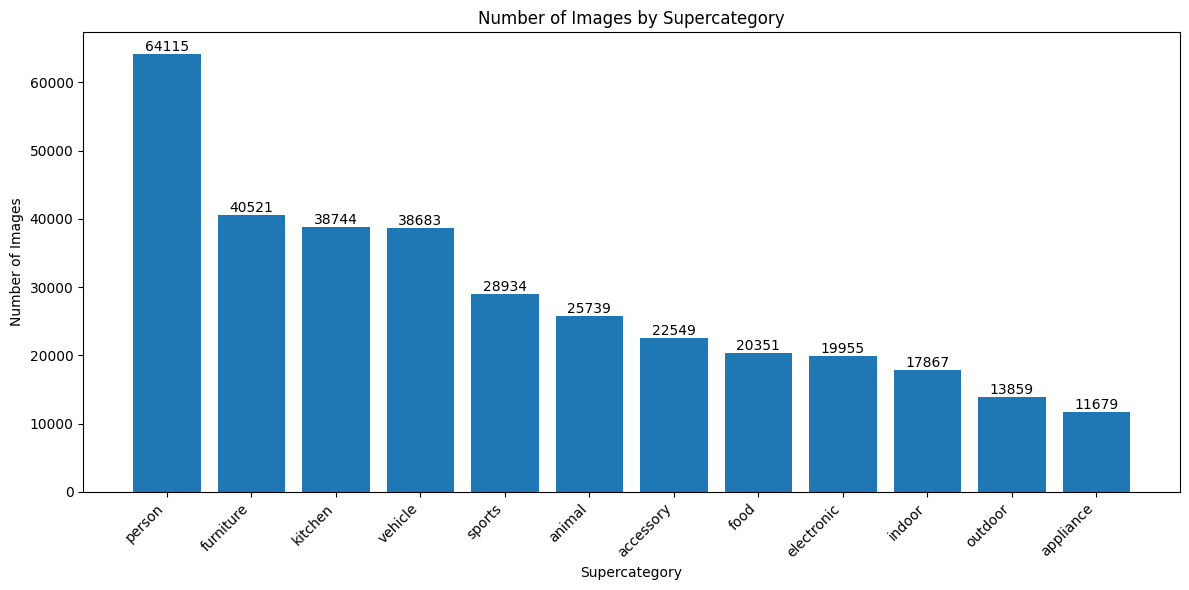

In [ ]:
# count the number of images per supercategory
supercat_img_count = {}
for cat in cat_list:
  supercategory = cat['supercategory']
  if supercategory not in supercat_img_count:
    supercat_img_count[supercategory] = 0
  supercat_img_count[supercategory] += len(coco.getImgIds(catIds=[cat['id']]))

# sort the supercategories in descending order of image count
sorted_supercat_img = sorted(supercat_img_count, key=supercat_img_count.get, reverse=True)

# create a bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_supercat_img, [supercat_img_count[cat] for cat in sorted_supercat_img])
plt.xlabel('Supercategory')
plt.ylabel('Number of Images')
plt.title('Number of Images by Supercategory')
plt.xticks(rotation=45, ha='right')

# add values to the bars
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.tight_layout()
plt.show()


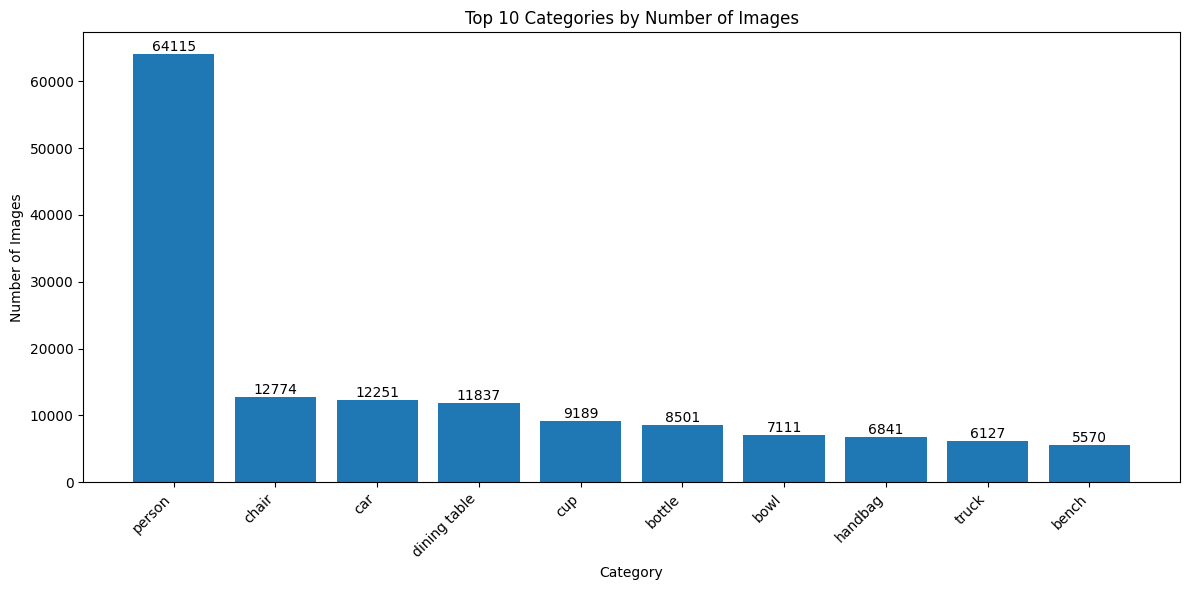

In [ ]:
# plot top 10 categories with bar values

# count the number of images per category
cat_img_count = {}
for cat in cat_list:
  cat_img_count[cat['name']] = len(coco.getImgIds(catIds=[cat['id']]))

# sort the categories in descending order of image count
sorted_cat_img = sorted(cat_img_count, key=cat_img_count.get, reverse=True)

# select the top 10 categories
top_10_cats = sorted_cat_img[:10]

# create a bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(top_10_cats, [cat_img_count[cat] for cat in top_10_cats])
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Top 10 Categories by Number of Images')
plt.xticks(rotation=45, ha='right')

# add values to the bars
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.tight_layout()
plt.show()

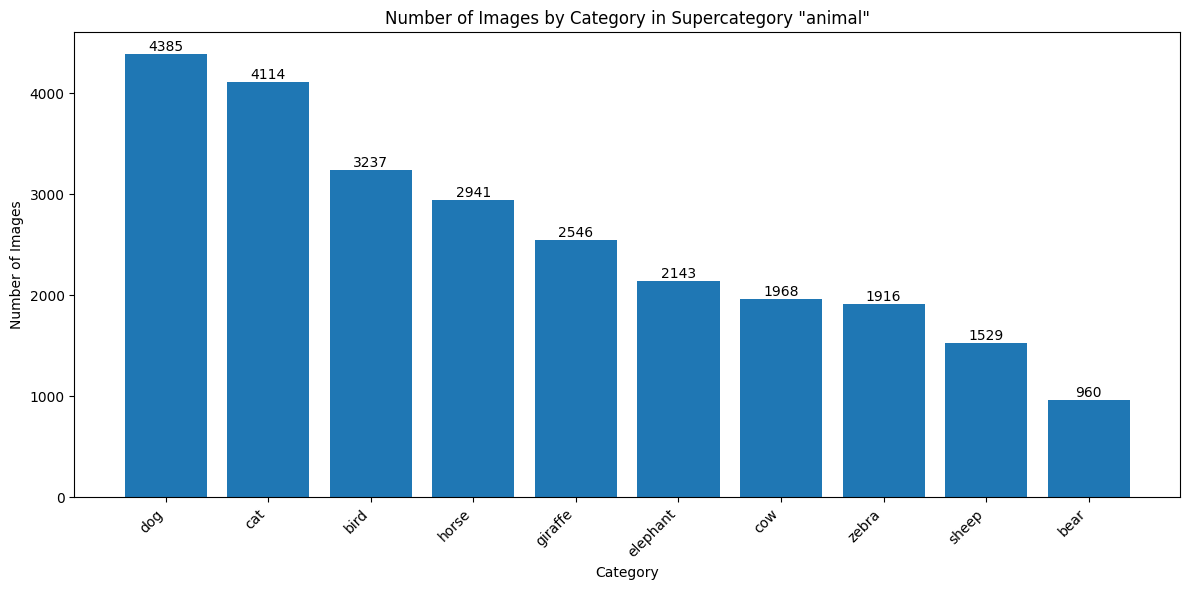

In [ ]:
# plot number of images for all categories in super categories animal

# count the number of images per category for animal supercategory
animal_cat_img_count = {}
for cat in cat_list:
  if cat['supercategory'] == 'animal':
    animal_cat_img_count[cat['name']] = len(coco.getImgIds(catIds=[cat['id']]))

# sort the categories in descending order of image count
sorted_animal_cat_img = sorted(animal_cat_img_count, key=animal_cat_img_count.get, reverse=True)

# create a bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_animal_cat_img, [animal_cat_img_count[cat] for cat in sorted_animal_cat_img])
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Number of Images by Category in Supercategory "animal"')
plt.xticks(rotation=45, ha='right')

# add values to the bars
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.tight_layout()
plt.show()


In [ ]:
# list all categories in super categories animal
animal_categories = [cat['name'] for cat in cat_list if cat['supercategory'] == 'animal']
print("Categories in supercategory 'animal':")
for category in animal_categories:
    print(category)


Categories in supercategory 'animal':
bird
cat
dog
horse
sheep
cow
elephant
bear
zebra
giraffe


Total Images:  21330


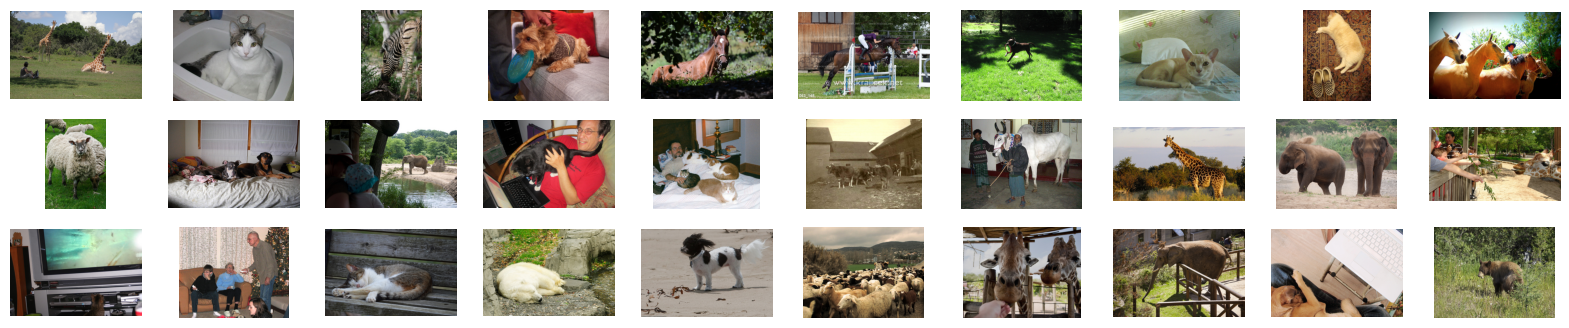

In [ ]:
# Load some random images

train_cats = cat_imgId['giraffe'] + cat_imgId['elephant'] + cat_imgId['cat'] + cat_imgId['dog'] + cat_imgId['horse'] + cat_imgId['sheep'] + cat_imgId['cow'] + cat_imgId['bear'] + cat_imgId['zebra']  #+ cat_imgId['bird']
#train_cats = train_cats [:30]
imgIds = coco.getImgIds(imgIds = train_cats)
print("Total Images: ", len(imgIds))

fig = plt.gcf()
fig.set_size_inches(20, 4)

random.shuffle(imgIds)

for i, imgId in enumerate(imgIds[0:30]):
  sp = plt.subplot(3, 10, i + 1)
  sp.axis('Off')
  img = coco.loadImgs(imgId)[0]         # list has only zero element -- [0]--> will give dict --> coco_url has the image link
  I = io.imread(img['coco_url'])
  plt.imshow(I)

In [ ]:
# what info does the load image dict has
coco.loadImgs(imgIds[3])
# a list with a single element is returned below -- need index [0] to get the dict

[{'license': 1,
  'file_name': '000000212893.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000212893.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-18 12:19:00',
  'flickr_url': 'http://farm9.staticflickr.com/8374/8442932801_d0b5784a35_z.jpg',
  'id': 212893}]

In [ ]:
# Load images with respective captions
coco_caps = COCO(data_path + "/annotations/captions_train2017.json")

loading annotations into memory...
Done (t=3.43s)
creating index...
index created!


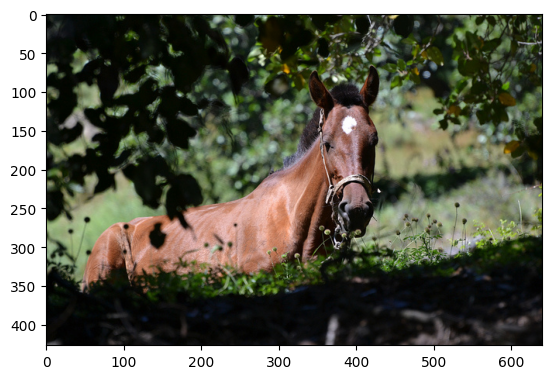

A brown horse peering over green bushes under trees.
A horse that is grazing around in the grass. 
A horse is looking over a bush in a meadow.
A horse with a white spot on it's forehead is visible through the leaves.
A horse looking over a hedge in a pasture.


In [ ]:
# Image captions
img = coco.loadImgs(imgIds[4])[0]    # index [0] of list is the dict
I = io.imread(img['coco_url'])       # coco_url is the key - value is url
plt.imshow(I)
plt.show()
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

In [ ]:
def generate_url_caps(imgIds, coco, coco_caps):
  url_caps = {}
  imgcaptions = []
  for imgId in imgIds:
      img = coco.loadImgs(imgId)[0]
      annIds = coco_caps.getAnnIds(imgIds=img['id']);   # this ImgIds is a parameter of the function and it should be a single num -- the imgIds in the for loop is a list of all img IDs...
      anns = coco_caps.loadAnns(annIds)
      imgcaptions = []
      for cap in anns:
          cap = cap['caption'].translate(str.maketrans('', '', string.punctuation))
          cap = cap.replace("-"," ")
          cap = cap.split()
          cap = [word.lower() for word in cap]
          cap = '<start> ' + " ".join(cap) + ' <end>'
          imgcaptions.append(cap)
      url_caps[img['coco_url']] = imgcaptions
  return url_caps

url_caps = generate_url_caps(imgIds, coco, coco_caps)

In [ ]:
print("Length of Dataset: ",len(url_caps))
print_text(url_caps['http://images.cocodataset.org/train2017/000000485770.jpg'])

Length of Dataset:  21330
["<start> a couple of elephants walking across a river with a man riding on back of one of them <end>", "<start> group of elephants walking in a
shallow body of water <end>", "<start> a few people and elephants stand and bathe in some water <end>", "<start> a group of elephants and people
outside in a large river <end>", "<start> elephants and their mahouts are bathing in a shallow river <end>"]


In [ ]:
# print url_caps
import pandas as pd
df_url_caps = pd.DataFrame.from_dict(url_caps, orient='index').stack().reset_index(level=0).set_index('level_0').rename(columns={0:'captions'})
df_url_caps.head(10)

captions
level_0                                                                                              
http://images.cocodataset.org/train2017/0000001...  <start> a man and giraffes are sitting on the ...
http://images.cocodataset.org/train2017/0000001...  <start> people watching giraffes sitting in th...
http://images.cocodataset.org/train2017/0000001...  <start> a person sits on the ground not far fr...
http://images.cocodataset.org/train2017/0000001...  <start> two zebra standing on a lush green fie...
http://images.cocodataset.org/train2017/0000001...  <start> a person is sitting on the grass near ...
http://images.cocodataset.org/train2017/0000005...  <start> a cay laying inside of a sink in a bat...
http://images.cocodataset.org/train2017/0000005...  <start> a white and gray cat is in a bathroom ...
http://images.cocodataset.org/train2017/0000005...  <start> a grey and white cat laying in a bathr...
http://images.cocodataset.org/train2017/0000005...  <start> a white cat laying in a bathroom sink ...
http://images.cocodataset.org/train2017/0000005...  <start> a black gray and white cat is sitting ...

### **Image Feature Extraction**

In [ ]:
def preprocess_xception_image(img_url):
  image = io.imread(img_url)
  if image.ndim != 3:
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
  image = cv2.resize(image,(299,299))
  image = img_to_array(image)
  image = np.expand_dims(image, axis=0)
  image = keras.applications.xception.preprocess_input(image)
  return image

def extract_xception_features(model, url_caps):
  xception_features = {}
  for img_url in tqdm(url_caps.keys()):
    image = preprocess_xception_image(img_url)
    feature = model.predict(image)
    xception_features[img_url] = feature
  return xception_features

model_xception = keras.applications.xception.Xception()
model_xception = Model(inputs=model_xception.inputs, outputs=model_xception.layers[-2].output)
print(model_xception.summary())

91884032/91884032 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  

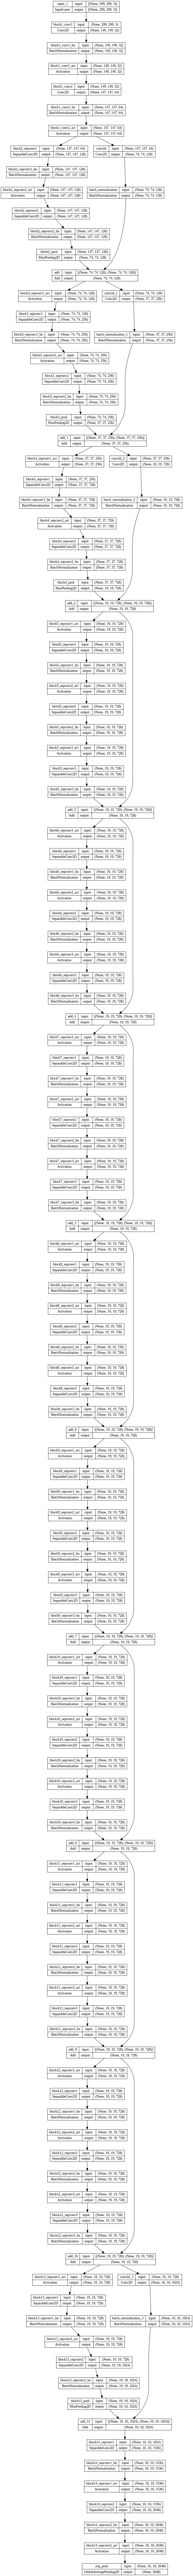

In [ ]:
plot_model(model_xception, show_shapes=True)

In [ ]:
xception_features = xception_features(model_xception, url_caps)

  0%|          | 0/21330 [00:00<?, ?it/s]

1/1 [==============================] - 1s 731ms/step


  0%|          | 1/21330 [00:01<7:55:40,  1.34s/it]

1/1 [==============================] - 0s 22ms/step


  0%|          | 2/21330 [00:01<5:11:59,  1.14it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 3/21330 [00:02<4:07:45,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 4/21330 [00:02<3:54:42,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 5/21330 [00:03<3:48:05,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 6/21330 [00:04<3:33:26,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 7/21330 [00:04<3:40:44,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 8/21330 [00:05<3:22:30,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 9/21330 [00:05<3:13:54,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 10/21330 [00:06<3:04:09,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 11/21330 [00:06<3:03:24,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 12/21330 [00:07<3:05:03,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 13/21330 [00:07<3:03:27,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 14/21330 [00:08<3:05:06,  1.92it/s]

1/1 [==============================] - 0s 75ms/step


  0%|          | 15/21330 [00:09<3:34:40,  1.65it/s]

1/1 [==============================] - 0s 109ms/step


  0%|          | 16/21330 [00:09<3:55:08,  1.51it/s]

1/1 [==============================] - 0s 167ms/step


  0%|          | 17/21330 [00:10<3:57:54,  1.49it/s]

1/1 [==============================] - 0s 75ms/step


  0%|          | 18/21330 [00:11<4:08:47,  1.43it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 19/21330 [00:11<3:55:10,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 20/21330 [00:12<3:35:34,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 21/21330 [00:12<3:19:50,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 22/21330 [00:13<3:16:50,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 23/21330 [00:13<3:13:31,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 24/21330 [00:14<3:27:18,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 25/21330 [00:15<3:17:23,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 26/21330 [00:15<3:17:09,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 27/21330 [00:16<3:08:49,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 28/21330 [00:16<3:01:25,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 29/21330 [00:17<2:55:43,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 30/21330 [00:17<2:51:17,  2.07it/s]

1/1 [==============================] - 0s 58ms/step


  0%|          | 31/21330 [00:18<3:10:50,  1.86it/s]

1/1 [==============================] - 0s 55ms/step


  0%|          | 32/21330 [00:18<3:18:09,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 33/21330 [00:19<3:13:36,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 34/21330 [00:19<3:19:23,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 35/21330 [00:20<3:07:19,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 36/21330 [00:20<3:03:00,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 37/21330 [00:21<3:08:51,  1.88it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 38/21330 [00:21<3:10:52,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 39/21330 [00:22<3:19:39,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 40/21330 [00:23<3:19:11,  1.78it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 41/21330 [00:23<3:22:25,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 42/21330 [00:24<3:34:40,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 43/21330 [00:24<3:23:45,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 44/21330 [00:25<3:11:34,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 45/21330 [00:25<3:06:06,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 46/21330 [00:26<3:04:55,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 47/21330 [00:26<3:02:21,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 48/21330 [00:27<3:02:00,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 49/21330 [00:27<3:08:35,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 50/21330 [00:28<3:06:45,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 51/21330 [00:28<3:10:45,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 52/21330 [00:29<2:44:29,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 53/21330 [00:29<2:52:26,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 54/21330 [00:30<2:57:08,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 55/21330 [00:30<3:03:56,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 56/21330 [00:31<2:58:41,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 57/21330 [00:31<3:04:47,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 58/21330 [00:32<3:05:05,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 59/21330 [00:32<3:05:34,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 60/21330 [00:33<3:05:18,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 61/21330 [00:34<3:12:49,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 62/21330 [00:34<3:14:27,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 63/21330 [00:35<3:14:59,  1.82it/s]

1/1 [==============================] - 0s 63ms/step


  0%|          | 64/21330 [00:35<3:36:21,  1.64it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 65/21330 [00:36<3:33:24,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 66/21330 [00:37<3:27:44,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 67/21330 [00:37<3:22:51,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 68/21330 [00:38<3:39:41,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 69/21330 [00:38<3:38:49,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 70/21330 [00:39<3:27:26,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 71/21330 [00:40<3:21:52,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 72/21330 [00:40<3:19:11,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 73/21330 [00:40<3:05:04,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 74/21330 [00:41<3:09:39,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 75/21330 [00:42<3:17:33,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 76/21330 [00:42<3:08:57,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 77/21330 [00:43<3:05:58,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 78/21330 [00:43<3:16:57,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 79/21330 [00:44<3:15:25,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 80/21330 [00:44<3:24:00,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 81/21330 [00:45<3:31:18,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 82/21330 [00:46<3:27:32,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 83/21330 [00:46<3:22:35,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 84/21330 [00:47<3:13:18,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 85/21330 [00:47<3:06:42,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 86/21330 [00:48<3:20:52,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 87/21330 [00:48<3:16:08,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 88/21330 [00:49<3:09:05,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 89/21330 [00:49<3:19:41,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 90/21330 [00:50<3:15:05,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 91/21330 [00:50<3:08:39,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 92/21330 [00:51<3:18:07,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 93/21330 [00:52<3:08:26,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 94/21330 [00:52<3:24:49,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 95/21330 [00:53<3:06:43,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 96/21330 [00:53<3:08:05,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 97/21330 [00:54<3:10:16,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 98/21330 [00:54<3:10:28,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 99/21330 [00:55<3:09:29,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 100/21330 [00:55<3:08:32,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 101/21330 [00:56<3:11:08,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 102/21330 [00:56<3:04:48,  1.91it/s]

1/1 [==============================] - 0s 52ms/step


  0%|          | 103/21330 [00:57<3:09:35,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 104/21330 [00:57<3:04:08,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 105/21330 [00:58<2:58:43,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 106/21330 [00:58<3:02:01,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 107/21330 [00:59<3:10:34,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 108/21330 [01:00<3:10:06,  1.86it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 109/21330 [01:00<3:11:35,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 110/21330 [01:01<3:13:42,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 111/21330 [01:01<3:08:12,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 112/21330 [01:02<3:16:35,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 113/21330 [01:02<3:15:42,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 114/21330 [01:03<3:04:31,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 115/21330 [01:03<3:06:53,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 116/21330 [01:04<3:09:08,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 117/21330 [01:04<2:58:42,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 118/21330 [01:05<3:04:50,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 119/21330 [01:05<3:06:07,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 120/21330 [01:06<2:57:18,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 121/21330 [01:06<3:00:18,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 122/21330 [01:07<2:55:22,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 123/21330 [01:07<3:00:40,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 124/21330 [01:08<2:55:22,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 125/21330 [01:08<2:52:07,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 126/21330 [01:09<3:14:10,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 127/21330 [01:10<3:09:39,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 128/21330 [01:10<3:02:44,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 129/21330 [01:11<3:02:57,  1.93it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 130/21330 [01:11<3:09:59,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 131/21330 [01:12<3:07:32,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 132/21330 [01:12<3:17:45,  1.79it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 133/21330 [01:13<3:11:20,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 134/21330 [01:13<3:10:31,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 135/21330 [01:14<2:52:26,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 136/21330 [01:14<3:02:13,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 137/21330 [01:15<2:56:02,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 138/21330 [01:15<2:50:54,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 139/21330 [01:16<2:53:25,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 140/21330 [01:16<2:56:57,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 141/21330 [01:17<2:59:33,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 142/21330 [01:17<3:05:10,  1.91it/s]

1/1 [==============================] - 0s 62ms/step


  1%|          | 143/21330 [01:18<3:18:59,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 144/21330 [01:19<3:20:48,  1.76it/s]

1/1 [==============================] - 0s 66ms/step


  1%|          | 145/21330 [01:19<3:17:30,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 146/21330 [01:20<3:08:09,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 147/21330 [01:20<2:54:55,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 148/21330 [01:20<2:59:25,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 149/21330 [01:21<2:56:42,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 150/21330 [01:21<2:54:00,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 151/21330 [01:22<2:55:55,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 152/21330 [01:22<2:53:31,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 153/21330 [01:23<2:49:44,  2.08it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 154/21330 [01:23<2:55:09,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 155/21330 [01:24<3:07:03,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 156/21330 [01:25<3:05:09,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 157/21330 [01:25<2:58:22,  1.98it/s]

1/1 [==============================] - 0s 43ms/step


  1%|          | 158/21330 [01:26<3:03:49,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 159/21330 [01:26<2:58:28,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 160/21330 [01:26<2:49:59,  2.08it/s]

1/1 [==============================] - 0s 124ms/step


  1%|          | 161/21330 [01:27<3:08:06,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 162/21330 [01:28<3:02:41,  1.93it/s]

1/1 [==============================] - 0s 107ms/step


  1%|          | 163/21330 [01:28<3:29:05,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 164/21330 [01:29<3:10:32,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 165/21330 [01:29<3:05:55,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 166/21330 [01:30<3:00:53,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 167/21330 [01:30<3:02:48,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 168/21330 [01:31<2:59:11,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 169/21330 [01:31<2:53:39,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 170/21330 [01:32<2:57:52,  1.98it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 171/21330 [01:32<3:05:38,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 172/21330 [01:33<3:04:10,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 173/21330 [01:33<3:09:59,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 174/21330 [01:34<3:07:51,  1.88it/s]

1/1 [==============================] - 0s 84ms/step


  1%|          | 175/21330 [01:35<3:19:58,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 176/21330 [01:35<3:16:05,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 177/21330 [01:36<3:03:42,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 178/21330 [01:36<3:09:23,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 179/21330 [01:37<3:03:28,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 180/21330 [01:37<3:20:40,  1.76it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 181/21330 [01:38<3:15:31,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 182/21330 [01:38<3:08:01,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 183/21330 [01:39<3:00:56,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 184/21330 [01:39<2:43:36,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 185/21330 [01:40<2:44:08,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 186/21330 [01:40<2:48:33,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 187/21330 [01:41<2:45:54,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 188/21330 [01:41<2:56:13,  2.00it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 189/21330 [01:42<2:57:02,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 190/21330 [01:42<3:01:15,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 191/21330 [01:43<3:06:20,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 192/21330 [01:43<3:01:44,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 193/21330 [01:44<2:59:11,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 194/21330 [01:44<3:02:30,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 195/21330 [01:45<3:04:54,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 196/21330 [01:45<3:09:03,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 197/21330 [01:46<3:00:50,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 198/21330 [01:46<3:06:41,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 199/21330 [01:47<2:59:55,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 200/21330 [01:47<3:05:30,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 201/21330 [01:48<3:06:26,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 202/21330 [01:48<2:53:13,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 203/21330 [01:49<2:59:49,  1.96it/s]

1/1 [==============================] - 0s 52ms/step


  1%|          | 204/21330 [01:49<3:07:21,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 205/21330 [01:50<3:04:18,  1.91it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 206/21330 [01:50<2:56:35,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 207/21330 [01:51<2:52:56,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 208/21330 [01:51<2:46:53,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 209/21330 [01:52<2:52:38,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 210/21330 [01:52<2:57:27,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 211/21330 [01:53<2:42:21,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 212/21330 [01:53<2:48:14,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 213/21330 [01:54<2:54:07,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 214/21330 [01:54<2:56:20,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 215/21330 [01:55<2:59:08,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 216/21330 [01:55<2:58:50,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 217/21330 [01:56<2:51:23,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 218/21330 [01:56<2:56:51,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 219/21330 [01:57<2:53:44,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 220/21330 [01:57<2:56:51,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 221/21330 [01:58<2:53:57,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 222/21330 [01:58<2:53:32,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 223/21330 [01:59<3:04:26,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 224/21330 [01:59<3:04:26,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 225/21330 [02:00<3:04:16,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 226/21330 [02:00<3:07:30,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 227/21330 [02:01<3:02:03,  1.93it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 228/21330 [02:02<3:06:43,  1.88it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 229/21330 [02:02<3:07:14,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 230/21330 [02:03<3:12:17,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 231/21330 [02:03<3:01:02,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 232/21330 [02:04<3:03:19,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 233/21330 [02:04<2:49:05,  2.08it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 234/21330 [02:05<3:02:30,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 235/21330 [02:05<2:54:53,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 236/21330 [02:06<3:58:22,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 237/21330 [02:07<3:36:44,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 238/21330 [02:07<3:19:03,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 239/21330 [02:08<3:14:47,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 240/21330 [02:08<3:00:54,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 241/21330 [02:09<3:28:10,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 242/21330 [02:09<3:16:09,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 243/21330 [02:10<3:14:49,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 244/21330 [02:10<3:15:00,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 245/21330 [02:11<3:11:51,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 246/21330 [02:11<3:00:53,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 247/21330 [02:12<3:01:25,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 248/21330 [02:12<3:02:07,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 249/21330 [02:13<2:57:07,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 250/21330 [02:14<3:15:34,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 251/21330 [02:14<3:04:36,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 252/21330 [02:14<2:58:31,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 253/21330 [02:15<2:55:54,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 254/21330 [02:15<2:52:17,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 255/21330 [02:16<2:53:19,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 256/21330 [02:17<4:03:11,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 257/21330 [02:18<3:46:38,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 258/21330 [02:18<3:29:37,  1.68it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 259/21330 [02:19<3:16:51,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 260/21330 [02:19<3:42:03,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 261/21330 [02:20<3:29:11,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 262/21330 [02:20<3:23:53,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 263/21330 [02:21<3:24:54,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 264/21330 [02:22<3:17:12,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 265/21330 [02:22<3:11:02,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 266/21330 [02:23<3:04:10,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 267/21330 [02:23<3:05:27,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 268/21330 [02:24<3:07:47,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 269/21330 [02:24<3:01:25,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 270/21330 [02:25<2:56:44,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 271/21330 [02:25<3:01:11,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 272/21330 [02:26<3:08:13,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 273/21330 [02:26<3:04:28,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▏         | 274/21330 [02:27<3:18:58,  1.76it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▏         | 275/21330 [02:27<3:27:07,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 276/21330 [02:28<3:14:46,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 277/21330 [02:28<3:03:53,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 278/21330 [02:29<2:52:13,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 279/21330 [02:29<2:57:07,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 280/21330 [02:30<2:49:49,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 281/21330 [02:30<2:48:10,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 282/21330 [02:31<2:46:45,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 283/21330 [02:31<2:46:32,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 284/21330 [02:32<2:48:04,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 285/21330 [02:32<2:54:28,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 286/21330 [02:33<2:53:37,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 287/21330 [02:33<2:57:24,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 288/21330 [02:34<2:56:07,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 289/21330 [02:34<3:00:56,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 290/21330 [02:35<2:55:18,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 291/21330 [02:35<2:56:17,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 292/21330 [02:36<2:51:55,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 293/21330 [02:36<3:02:46,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 294/21330 [02:37<2:48:53,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 295/21330 [02:37<2:48:08,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 296/21330 [02:38<2:49:00,  2.07it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 297/21330 [02:38<2:51:57,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 298/21330 [02:39<2:54:56,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▏         | 299/21330 [02:39<2:52:23,  2.03it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▏         | 300/21330 [02:40<2:52:23,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 301/21330 [02:40<2:53:36,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 302/21330 [02:41<2:53:06,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 303/21330 [02:41<3:02:46,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 304/21330 [02:42<3:02:57,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 305/21330 [02:42<3:23:04,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 306/21330 [02:43<3:16:29,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 307/21330 [02:44<3:12:07,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 308/21330 [02:44<3:15:06,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 309/21330 [02:45<3:13:32,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 310/21330 [02:45<3:12:06,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 311/21330 [02:46<3:04:08,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 312/21330 [02:46<3:02:26,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 313/21330 [02:47<2:57:15,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 314/21330 [02:47<3:02:17,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 315/21330 [02:48<3:04:08,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 316/21330 [02:48<3:01:56,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 317/21330 [02:49<3:04:07,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 318/21330 [02:49<3:05:30,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 319/21330 [02:50<3:03:10,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 320/21330 [02:50<3:07:29,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 321/21330 [02:51<3:01:47,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 322/21330 [02:51<3:01:19,  1.93it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 323/21330 [02:52<3:08:11,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 324/21330 [02:52<3:07:17,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 325/21330 [02:53<2:52:39,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 326/21330 [02:53<2:42:59,  2.15it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 327/21330 [02:54<2:56:45,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 328/21330 [02:54<2:58:44,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 329/21330 [02:55<2:45:45,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 330/21330 [02:55<3:02:17,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 331/21330 [02:56<2:46:01,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 332/21330 [02:56<2:52:21,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 333/21330 [02:57<2:38:32,  2.21it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 334/21330 [02:57<2:41:32,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 335/21330 [02:58<2:50:05,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 336/21330 [02:58<2:58:54,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 337/21330 [02:59<2:59:30,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 338/21330 [02:59<2:53:09,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 339/21330 [03:00<3:00:13,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 340/21330 [03:00<2:55:50,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 341/21330 [03:01<2:51:44,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 342/21330 [03:01<2:51:38,  2.04it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 343/21330 [03:02<3:01:35,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 344/21330 [03:02<2:49:51,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 345/21330 [03:03<2:58:30,  1.96it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 346/21330 [03:04<3:23:11,  1.72it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 347/21330 [03:04<3:24:46,  1.71it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 348/21330 [03:05<3:25:19,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 349/21330 [03:05<3:20:24,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 350/21330 [03:06<3:12:10,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 351/21330 [03:06<3:04:20,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 352/21330 [03:07<3:08:31,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 353/21330 [03:07<3:00:30,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 354/21330 [03:08<2:54:32,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 355/21330 [03:08<2:52:07,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 356/21330 [03:09<2:51:15,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 357/21330 [03:09<2:47:25,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 358/21330 [03:10<2:35:40,  2.25it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 359/21330 [03:10<2:44:39,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 360/21330 [03:11<2:50:12,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 361/21330 [03:11<3:23:46,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 362/21330 [03:12<3:17:02,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 363/21330 [03:13<3:22:22,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 364/21330 [03:13<3:04:27,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 365/21330 [03:13<3:08:50,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 366/21330 [03:14<2:59:34,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 367/21330 [03:14<2:55:50,  1.99it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 368/21330 [03:15<2:56:30,  1.98it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 369/21330 [03:15<2:53:33,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 370/21330 [03:16<3:02:31,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 371/21330 [03:17<3:05:24,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 372/21330 [03:17<3:07:29,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 373/21330 [03:18<3:01:39,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 374/21330 [03:18<2:57:08,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 375/21330 [03:19<2:54:16,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 376/21330 [03:19<2:50:51,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 377/21330 [03:20<2:53:19,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 378/21330 [03:20<2:50:02,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 379/21330 [03:20<2:53:58,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 380/21330 [03:21<2:51:07,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 381/21330 [03:21<2:55:05,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 382/21330 [03:22<2:40:08,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 383/21330 [03:22<2:50:24,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 384/21330 [03:23<3:01:16,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 385/21330 [03:23<2:54:16,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 386/21330 [03:24<2:51:03,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 387/21330 [03:24<2:52:26,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 388/21330 [03:25<2:58:57,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 389/21330 [03:26<3:02:08,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 390/21330 [03:26<3:03:25,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 391/21330 [03:27<3:03:09,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 392/21330 [03:27<2:54:49,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 393/21330 [03:28<3:06:50,  1.87it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 394/21330 [03:28<3:03:29,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 395/21330 [03:29<2:59:04,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 396/21330 [03:29<3:01:18,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 397/21330 [03:30<3:03:11,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 398/21330 [03:30<2:57:00,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 399/21330 [03:31<2:55:30,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 400/21330 [03:31<2:58:18,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 401/21330 [03:32<3:03:02,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 402/21330 [03:32<2:54:52,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 403/21330 [03:33<2:35:36,  2.24it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 404/21330 [03:33<3:05:50,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 405/21330 [03:34<3:02:11,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 406/21330 [03:34<3:02:26,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 407/21330 [03:35<3:01:52,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 408/21330 [03:35<2:58:04,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 409/21330 [03:36<2:52:33,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 410/21330 [03:36<2:54:46,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 411/21330 [03:37<3:03:21,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 412/21330 [03:37<3:07:05,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 413/21330 [03:38<3:14:44,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 414/21330 [03:39<3:12:49,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 415/21330 [03:39<3:04:32,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 416/21330 [03:40<3:18:29,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 417/21330 [03:40<3:16:25,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 418/21330 [03:41<3:11:00,  1.82it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 419/21330 [03:41<3:27:53,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 420/21330 [03:42<3:18:16,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 421/21330 [03:43<3:18:46,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 422/21330 [03:43<3:07:36,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 423/21330 [03:44<3:06:04,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 424/21330 [03:44<3:02:20,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 425/21330 [03:45<3:01:21,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 426/21330 [03:45<3:10:11,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 427/21330 [03:45<2:49:55,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 428/21330 [03:46<2:49:48,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 429/21330 [03:46<2:46:32,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 430/21330 [03:47<2:55:31,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 431/21330 [03:48<2:58:21,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 432/21330 [03:48<2:53:50,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 433/21330 [03:48<2:51:36,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 434/21330 [03:49<2:53:56,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 435/21330 [03:49<2:49:10,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 436/21330 [03:50<2:49:13,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 437/21330 [03:50<2:45:16,  2.11it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 438/21330 [03:51<2:45:49,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 439/21330 [03:51<2:52:22,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 440/21330 [03:52<2:48:34,  2.07it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 441/21330 [03:52<2:49:25,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 442/21330 [03:53<2:58:31,  1.95it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 443/21330 [03:53<2:57:57,  1.96it/s]

1/1 [==============================] - 0s 56ms/step


  2%|▏         | 444/21330 [03:54<3:06:52,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 445/21330 [03:55<3:04:33,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 446/21330 [03:55<3:07:18,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 447/21330 [03:56<3:02:04,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 448/21330 [03:56<2:58:28,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 449/21330 [03:57<2:59:43,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 450/21330 [03:57<2:36:10,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 451/21330 [03:57<2:30:05,  2.32it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 452/21330 [03:58<2:37:51,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 453/21330 [03:58<2:46:20,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 454/21330 [03:59<2:52:20,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 455/21330 [04:00<3:33:52,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 456/21330 [04:00<3:34:04,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 457/21330 [04:01<3:14:24,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 458/21330 [04:01<3:04:02,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 459/21330 [04:02<2:55:29,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 460/21330 [04:02<2:58:26,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 461/21330 [04:03<2:47:11,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 462/21330 [04:03<3:01:58,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 463/21330 [04:04<3:16:11,  1.77it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 464/21330 [04:04<3:15:01,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 465/21330 [04:05<2:59:58,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 466/21330 [04:05<2:56:55,  1.97it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 467/21330 [04:06<2:55:15,  1.98it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 468/21330 [04:06<3:00:59,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 469/21330 [04:07<3:00:34,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 470/21330 [04:08<3:08:55,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 471/21330 [04:08<3:01:03,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 472/21330 [04:08<2:53:26,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 473/21330 [04:09<3:00:13,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 474/21330 [04:10<3:17:13,  1.76it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 475/21330 [04:10<3:01:40,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 476/21330 [04:11<3:02:18,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 477/21330 [04:11<3:03:32,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 478/21330 [04:12<2:57:20,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 479/21330 [04:12<3:20:27,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 480/21330 [04:13<3:32:32,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 481/21330 [04:14<3:17:23,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 482/21330 [04:14<3:11:41,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 483/21330 [04:15<3:03:06,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 484/21330 [04:15<3:04:54,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 485/21330 [04:16<2:53:55,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 486/21330 [04:16<2:52:23,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 487/21330 [04:16<2:51:50,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 488/21330 [04:17<2:49:33,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 489/21330 [04:17<2:41:59,  2.14it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 490/21330 [04:18<2:51:45,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 491/21330 [04:18<2:57:23,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 492/21330 [04:19<3:01:11,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 493/21330 [04:20<3:08:23,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 494/21330 [04:20<3:08:00,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 495/21330 [04:21<3:09:50,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 496/21330 [04:21<2:53:54,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 497/21330 [04:22<2:45:00,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 498/21330 [04:22<3:00:13,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 499/21330 [04:23<2:47:27,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 500/21330 [04:23<3:04:33,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 501/21330 [04:24<3:04:56,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 502/21330 [04:24<2:51:54,  2.02it/s]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 503/21330 [04:25<2:51:21,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 504/21330 [04:25<3:00:01,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 505/21330 [04:26<3:02:46,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 506/21330 [04:26<2:56:25,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 507/21330 [04:27<2:54:17,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 508/21330 [04:27<2:57:33,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 509/21330 [04:28<2:56:52,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 510/21330 [04:28<2:53:33,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 511/21330 [04:29<3:04:37,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 512/21330 [04:29<3:02:04,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 513/21330 [04:30<2:58:24,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 514/21330 [04:30<3:03:02,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 515/21330 [04:31<2:58:42,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 516/21330 [04:31<2:55:54,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 517/21330 [04:32<2:54:21,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 518/21330 [04:32<3:03:01,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 519/21330 [04:33<3:17:39,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 520/21330 [04:34<3:07:27,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 521/21330 [04:34<3:05:16,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 522/21330 [04:35<3:02:34,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 523/21330 [04:35<3:05:52,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 524/21330 [04:36<3:05:24,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 525/21330 [04:36<3:04:07,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 526/21330 [04:37<2:59:05,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 527/21330 [04:37<2:59:14,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 528/21330 [04:38<2:55:14,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 529/21330 [04:38<2:42:17,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 530/21330 [04:39<2:48:46,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 531/21330 [04:39<2:46:07,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 532/21330 [04:40<2:49:35,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 533/21330 [04:40<2:54:31,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 534/21330 [04:41<2:52:50,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 535/21330 [04:41<2:54:44,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 536/21330 [04:42<2:53:19,  2.00it/s]

1/1 [==============================] - 0s 70ms/step


  3%|▎         | 537/21330 [04:42<3:18:12,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 538/21330 [04:43<3:15:17,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 539/21330 [04:43<3:07:59,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 540/21330 [04:44<3:06:47,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 541/21330 [04:44<3:00:07,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 542/21330 [04:45<3:00:26,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 543/21330 [04:46<3:15:44,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 544/21330 [04:46<3:04:40,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 545/21330 [04:47<3:04:09,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 546/21330 [04:47<3:06:12,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 547/21330 [04:48<3:04:11,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 548/21330 [04:48<3:02:41,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 549/21330 [04:49<3:01:14,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 550/21330 [04:49<3:03:41,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 551/21330 [04:50<3:02:01,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 552/21330 [04:50<3:00:37,  1.92it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 553/21330 [04:51<3:06:00,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 554/21330 [04:51<2:56:28,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 555/21330 [04:52<2:51:49,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 556/21330 [04:52<2:49:28,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 557/21330 [04:53<2:45:59,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 558/21330 [04:53<2:58:20,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 559/21330 [04:54<3:01:21,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 560/21330 [04:54<2:57:15,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 561/21330 [04:55<2:55:36,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 562/21330 [04:55<3:00:48,  1.91it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 563/21330 [04:56<3:04:43,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 564/21330 [04:56<2:59:23,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 565/21330 [04:57<3:00:30,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 566/21330 [04:57<3:00:23,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 567/21330 [04:58<2:59:59,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 568/21330 [04:58<2:48:44,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 569/21330 [04:59<2:51:04,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 570/21330 [04:59<2:57:41,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 571/21330 [05:00<2:56:07,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 572/21330 [05:01<3:05:05,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 573/21330 [05:01<2:57:17,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 574/21330 [05:02<2:57:38,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 575/21330 [05:02<2:51:14,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 576/21330 [05:02<2:55:16,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 577/21330 [05:03<2:53:39,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 578/21330 [05:03<2:53:11,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 579/21330 [05:04<2:54:19,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 580/21330 [05:04<2:51:41,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 581/21330 [05:05<2:47:48,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 582/21330 [05:05<2:48:59,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 583/21330 [05:06<2:46:22,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 584/21330 [05:06<2:48:45,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 585/21330 [05:07<2:50:21,  2.03it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 586/21330 [05:07<2:56:50,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 587/21330 [05:08<2:52:32,  2.00it/s]

1/1 [==============================] - 0s 63ms/step


  3%|▎         | 588/21330 [05:09<3:07:21,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 589/21330 [05:09<3:06:01,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 590/21330 [05:10<2:58:19,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 591/21330 [05:10<2:55:31,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 592/21330 [05:11<2:56:50,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 593/21330 [05:11<2:51:50,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 594/21330 [05:12<2:59:26,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 595/21330 [05:12<2:47:00,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 596/21330 [05:12<2:43:44,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 597/21330 [05:13<2:48:38,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 598/21330 [05:14<2:55:22,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 599/21330 [05:14<2:51:26,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 600/21330 [05:15<2:56:56,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 601/21330 [05:15<2:52:06,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 602/21330 [05:16<3:01:43,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 603/21330 [05:16<3:00:27,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 604/21330 [05:17<2:55:44,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 605/21330 [05:17<2:34:38,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 606/21330 [05:17<2:45:40,  2.08it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 607/21330 [05:18<2:59:40,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 608/21330 [05:19<3:01:27,  1.90it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 609/21330 [05:19<2:58:41,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 610/21330 [05:20<3:01:15,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 611/21330 [05:20<2:54:16,  1.98it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 612/21330 [05:21<2:59:04,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 613/21330 [05:21<3:03:38,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 614/21330 [05:22<3:07:59,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 615/21330 [05:22<2:59:27,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 616/21330 [05:23<3:00:40,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 617/21330 [05:23<3:08:48,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 618/21330 [05:24<3:07:30,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 619/21330 [05:24<2:58:16,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 620/21330 [05:25<2:43:10,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 621/21330 [05:25<2:43:01,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 622/21330 [05:26<2:42:34,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 623/21330 [05:26<2:49:04,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 624/21330 [05:27<2:55:31,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 625/21330 [05:27<2:55:49,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 626/21330 [05:28<2:49:46,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 627/21330 [05:29<3:41:03,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 628/21330 [05:29<3:22:40,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 629/21330 [05:30<3:08:04,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 630/21330 [05:30<3:10:04,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 631/21330 [05:31<3:03:04,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 632/21330 [05:31<2:57:01,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 633/21330 [05:32<2:55:34,  1.96it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 634/21330 [05:32<2:45:11,  2.09it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 635/21330 [05:33<2:54:48,  1.97it/s]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 636/21330 [05:33<2:54:12,  1.98it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 637/21330 [05:34<2:55:50,  1.96it/s]

1/1 [==============================] - 0s 48ms/step


  3%|▎         | 638/21330 [05:34<2:59:04,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 639/21330 [05:35<3:03:46,  1.88it/s]

1/1 [==============================] - 0s 89ms/step


  3%|▎         | 640/21330 [05:35<3:21:01,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 641/21330 [05:36<3:20:40,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 642/21330 [05:37<3:08:44,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 643/21330 [05:37<2:59:54,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 644/21330 [05:37<2:55:18,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 645/21330 [05:38<2:41:35,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 646/21330 [05:38<2:45:24,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 647/21330 [05:39<2:46:26,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 648/21330 [05:39<2:47:18,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 649/21330 [05:40<3:01:07,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 650/21330 [05:40<2:58:18,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 651/21330 [05:41<2:54:14,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 652/21330 [05:41<2:51:31,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 653/21330 [05:42<2:52:20,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 654/21330 [05:42<2:49:20,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 655/21330 [05:43<2:42:27,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 656/21330 [05:43<2:42:49,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 657/21330 [05:44<2:40:23,  2.15it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 658/21330 [05:44<3:13:12,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 659/21330 [05:45<3:13:09,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 660/21330 [05:46<3:09:07,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 661/21330 [05:46<3:12:17,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 662/21330 [05:47<3:15:10,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 663/21330 [05:47<3:11:15,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 664/21330 [05:48<3:18:46,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 665/21330 [05:48<3:08:19,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 666/21330 [05:49<3:05:37,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 667/21330 [05:49<2:58:32,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 668/21330 [05:50<2:34:45,  2.23it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 669/21330 [05:50<2:56:21,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 670/21330 [05:51<2:57:57,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 671/21330 [05:51<3:04:52,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 672/21330 [05:52<2:47:27,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 673/21330 [05:52<2:45:55,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 674/21330 [05:53<2:50:50,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 675/21330 [05:53<2:46:58,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 676/21330 [05:54<2:49:17,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 677/21330 [05:54<2:49:13,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 678/21330 [05:55<2:45:39,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 679/21330 [05:55<2:46:19,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 680/21330 [05:56<2:47:34,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 681/21330 [05:56<2:43:13,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 682/21330 [05:57<2:39:36,  2.16it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 683/21330 [05:57<2:45:16,  2.08it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 684/21330 [05:58<2:40:49,  2.14it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 685/21330 [05:58<2:45:14,  2.08it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 686/21330 [05:59<2:53:47,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 687/21330 [05:59<3:04:45,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 688/21330 [06:00<3:00:01,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 689/21330 [06:00<2:56:52,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 690/21330 [06:01<3:01:44,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 691/21330 [06:01<2:38:13,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 692/21330 [06:02<2:44:51,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 693/21330 [06:02<2:45:13,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 694/21330 [06:02<2:36:15,  2.20it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 695/21330 [06:03<2:31:10,  2.27it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 696/21330 [06:03<2:34:07,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 697/21330 [06:04<2:37:52,  2.18it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 698/21330 [06:04<2:39:04,  2.16it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 699/21330 [06:05<2:43:01,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 700/21330 [06:05<2:50:08,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 701/21330 [06:06<2:47:26,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 702/21330 [06:06<3:00:02,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 703/21330 [06:07<2:53:15,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 704/21330 [06:07<2:54:44,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 705/21330 [06:08<2:53:43,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 706/21330 [06:08<2:49:07,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 707/21330 [06:09<2:55:41,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 708/21330 [06:09<2:59:06,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 709/21330 [06:10<2:57:14,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 710/21330 [06:10<2:51:48,  2.00it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 711/21330 [06:11<2:52:30,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 712/21330 [06:11<2:58:59,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 713/21330 [06:12<2:51:05,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 714/21330 [06:12<2:44:08,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 715/21330 [06:13<2:50:32,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 716/21330 [06:13<2:49:33,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 717/21330 [06:14<2:55:42,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 718/21330 [06:14<3:00:34,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 719/21330 [06:15<3:01:56,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 720/21330 [06:16<3:03:00,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 721/21330 [06:16<2:46:13,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 722/21330 [06:17<2:55:25,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 723/21330 [06:17<2:50:27,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 724/21330 [06:17<2:42:17,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 725/21330 [06:18<2:49:29,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 726/21330 [06:19<2:56:28,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 727/21330 [06:19<2:59:35,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 728/21330 [06:20<2:55:04,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 729/21330 [06:20<3:08:37,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 730/21330 [06:21<3:02:36,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 731/21330 [06:21<2:57:19,  1.94it/s]

1/1 [==============================] - 0s 51ms/step


  3%|▎         | 732/21330 [06:22<3:05:44,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 733/21330 [06:22<3:06:03,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 734/21330 [06:23<3:07:41,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 735/21330 [06:23<3:06:40,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 736/21330 [06:24<3:01:46,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 737/21330 [06:24<2:56:07,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 738/21330 [06:25<2:48:48,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 739/21330 [06:25<2:49:02,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 740/21330 [06:26<2:53:22,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 741/21330 [06:26<2:55:52,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 742/21330 [06:27<2:56:50,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 743/21330 [06:27<2:48:28,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 744/21330 [06:28<2:52:17,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 745/21330 [06:28<3:09:02,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 746/21330 [06:29<3:03:53,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 747/21330 [06:29<2:50:46,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 748/21330 [06:30<2:45:41,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 749/21330 [06:30<2:34:26,  2.22it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 750/21330 [06:31<2:41:08,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 751/21330 [06:31<2:44:58,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 752/21330 [06:32<3:02:44,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 753/21330 [06:32<2:41:29,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 754/21330 [06:33<2:42:50,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 755/21330 [06:33<2:43:35,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 756/21330 [06:34<2:42:22,  2.11it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▎         | 757/21330 [06:34<2:53:36,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 758/21330 [06:35<2:53:02,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 759/21330 [06:35<2:52:42,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▎         | 760/21330 [06:36<2:59:38,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 761/21330 [06:36<3:05:51,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 762/21330 [06:37<2:56:49,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 763/21330 [06:37<2:56:34,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 764/21330 [06:38<2:51:59,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 765/21330 [06:38<2:55:08,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 766/21330 [06:39<3:00:51,  1.90it/s]

1/1 [==============================] - 0s 62ms/step


  4%|▎         | 767/21330 [06:39<3:02:52,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 768/21330 [06:40<2:58:34,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 769/21330 [06:41<2:58:48,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 770/21330 [06:41<2:54:16,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 771/21330 [06:42<2:58:52,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 772/21330 [06:42<3:00:44,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 773/21330 [06:43<2:55:26,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 774/21330 [06:43<2:59:36,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 775/21330 [06:44<2:59:41,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 776/21330 [06:44<2:56:24,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 777/21330 [06:45<2:54:48,  1.96it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▎         | 778/21330 [06:45<3:01:47,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 779/21330 [06:46<3:04:19,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 780/21330 [06:46<2:40:53,  2.13it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 781/21330 [06:47<2:48:10,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 782/21330 [06:47<2:49:19,  2.02it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▎         | 783/21330 [06:48<2:40:19,  2.14it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▎         | 784/21330 [06:48<2:42:11,  2.11it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▎         | 785/21330 [06:49<2:49:52,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 786/21330 [06:49<2:47:32,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 787/21330 [06:50<2:55:46,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 788/21330 [06:50<2:56:14,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 789/21330 [06:51<3:01:15,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 790/21330 [06:51<3:00:45,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 791/21330 [06:52<3:04:27,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 792/21330 [06:52<3:05:30,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 793/21330 [06:53<3:07:21,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 794/21330 [06:53<3:03:57,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 795/21330 [06:54<3:01:28,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 796/21330 [06:54<3:00:49,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 797/21330 [06:55<2:55:24,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 798/21330 [06:55<2:52:24,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 799/21330 [06:56<2:55:22,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 800/21330 [06:56<3:00:20,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 801/21330 [06:57<2:57:26,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 802/21330 [06:57<2:51:48,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 803/21330 [06:58<2:53:07,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 804/21330 [06:59<3:05:02,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 805/21330 [06:59<2:58:35,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 806/21330 [07:00<2:55:03,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 807/21330 [07:00<3:08:19,  1.82it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 808/21330 [07:01<3:08:51,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 809/21330 [07:01<3:07:43,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 810/21330 [07:02<3:00:50,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 811/21330 [07:02<3:02:13,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 812/21330 [07:03<3:04:12,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 813/21330 [07:03<3:04:43,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 814/21330 [07:04<2:58:12,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 815/21330 [07:04<2:52:49,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 816/21330 [07:05<2:57:20,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 817/21330 [07:05<2:52:48,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 818/21330 [07:06<2:48:32,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 819/21330 [07:06<2:46:47,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 820/21330 [07:07<2:42:25,  2.10it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 821/21330 [07:07<2:46:48,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 822/21330 [07:08<2:51:39,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 823/21330 [07:08<2:50:06,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 824/21330 [07:09<2:52:09,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 825/21330 [07:09<2:51:54,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 826/21330 [07:10<2:49:23,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 827/21330 [07:10<2:52:34,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 828/21330 [07:11<2:48:28,  2.03it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 829/21330 [07:11<2:57:04,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 830/21330 [07:12<3:01:24,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 831/21330 [07:12<3:01:17,  1.88it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 832/21330 [07:13<2:59:58,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 833/21330 [07:14<3:28:50,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 834/21330 [07:14<3:21:59,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 835/21330 [07:15<3:10:09,  1.80it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▍         | 836/21330 [07:16<3:27:10,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 837/21330 [07:16<3:10:31,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 838/21330 [07:16<3:05:54,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 839/21330 [07:17<3:05:46,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 840/21330 [07:18<3:19:27,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 841/21330 [07:18<3:13:14,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 842/21330 [07:19<3:03:09,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 843/21330 [07:19<3:04:20,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 844/21330 [07:20<3:25:16,  1.66it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 845/21330 [07:21<3:16:11,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 846/21330 [07:21<2:55:03,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 847/21330 [07:21<2:57:38,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 848/21330 [07:22<2:51:50,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 849/21330 [07:22<2:51:28,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 850/21330 [07:23<2:45:18,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 851/21330 [07:23<2:49:34,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 852/21330 [07:24<2:41:45,  2.11it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 853/21330 [07:24<2:41:41,  2.11it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 854/21330 [07:25<2:58:11,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 855/21330 [07:25<3:00:55,  1.89it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 856/21330 [07:26<3:04:50,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 857/21330 [07:27<3:11:55,  1.78it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 858/21330 [07:27<3:08:36,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 859/21330 [07:28<3:02:50,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 860/21330 [07:28<3:06:12,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 861/21330 [07:29<3:07:43,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 862/21330 [07:29<3:06:39,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 863/21330 [07:30<2:58:51,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 864/21330 [07:30<3:00:17,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 865/21330 [07:31<2:59:32,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 866/21330 [07:31<2:48:22,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 867/21330 [07:32<2:50:05,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 868/21330 [07:32<2:47:08,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 869/21330 [07:33<2:51:18,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 870/21330 [07:33<2:55:07,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 871/21330 [07:34<2:54:53,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 872/21330 [07:34<2:48:37,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 873/21330 [07:35<2:51:12,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 874/21330 [07:35<2:55:04,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 875/21330 [07:36<2:50:24,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 876/21330 [07:36<2:50:58,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 877/21330 [07:37<2:57:38,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 878/21330 [07:37<3:01:39,  1.88it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 879/21330 [07:38<2:57:28,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 880/21330 [07:38<3:01:01,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 881/21330 [07:39<2:53:44,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 882/21330 [07:39<2:50:29,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 883/21330 [07:40<2:52:23,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 884/21330 [07:40<2:54:00,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 885/21330 [07:41<2:48:52,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 886/21330 [07:41<2:52:41,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 887/21330 [07:42<2:51:20,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 888/21330 [07:42<2:46:48,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 889/21330 [07:43<2:54:47,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 890/21330 [07:43<2:51:26,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 891/21330 [07:44<2:54:26,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 892/21330 [07:44<2:56:02,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 893/21330 [07:45<2:58:31,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 894/21330 [07:46<3:00:30,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 895/21330 [07:46<3:18:43,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 896/21330 [07:47<2:55:40,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 897/21330 [07:47<2:58:04,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 898/21330 [07:48<2:58:31,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 899/21330 [07:48<2:56:47,  1.93it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 900/21330 [07:49<3:18:57,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 901/21330 [07:49<2:50:34,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 902/21330 [07:50<2:59:17,  1.90it/s]

1/1 [==============================] - 0s 71ms/step


  4%|▍         | 903/21330 [07:51<3:12:23,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 904/21330 [07:51<3:05:38,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 905/21330 [07:52<3:03:49,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 906/21330 [07:52<3:05:40,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 907/21330 [07:53<3:04:10,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 908/21330 [07:53<3:03:44,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 909/21330 [07:54<3:01:19,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 910/21330 [07:54<2:55:30,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 911/21330 [07:55<2:55:57,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 912/21330 [07:55<2:57:43,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 913/21330 [07:56<2:56:09,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 914/21330 [07:56<2:50:42,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 915/21330 [07:57<2:46:45,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 916/21330 [07:57<2:45:00,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 917/21330 [07:58<2:41:12,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 918/21330 [07:58<2:47:51,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 919/21330 [07:59<2:55:12,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 920/21330 [07:59<2:56:43,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 921/21330 [08:00<2:51:47,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 922/21330 [08:00<2:51:45,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 923/21330 [08:01<2:40:10,  2.12it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 924/21330 [08:01<2:41:36,  2.10it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 925/21330 [08:02<2:47:01,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 926/21330 [08:02<2:53:09,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 927/21330 [08:03<3:00:01,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 928/21330 [08:04<3:29:26,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 929/21330 [08:04<3:20:13,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 930/21330 [08:04<2:59:52,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 931/21330 [08:05<2:59:00,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 932/21330 [08:05<3:00:22,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 933/21330 [08:06<2:52:49,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 934/21330 [08:07<3:00:08,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 935/21330 [08:07<2:43:28,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 936/21330 [08:07<2:49:46,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 937/21330 [08:08<2:51:18,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 938/21330 [08:08<2:47:54,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 939/21330 [08:09<2:51:43,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 940/21330 [08:09<2:50:20,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 941/21330 [08:10<2:30:02,  2.26it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 942/21330 [08:10<2:34:32,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 943/21330 [08:11<2:40:24,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 944/21330 [08:11<2:45:55,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 945/21330 [08:12<2:43:19,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 946/21330 [08:12<2:48:41,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 947/21330 [08:13<2:51:44,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 948/21330 [08:13<2:51:38,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 949/21330 [08:14<2:55:43,  1.93it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 950/21330 [08:14<2:54:51,  1.94it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 951/21330 [08:15<2:52:04,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 952/21330 [08:15<2:55:16,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 953/21330 [08:16<2:48:41,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 954/21330 [08:16<2:53:56,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 955/21330 [08:17<2:47:10,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 956/21330 [08:17<2:49:41,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 957/21330 [08:18<2:47:55,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 958/21330 [08:18<2:50:59,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 959/21330 [08:19<2:53:43,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 960/21330 [08:19<2:57:00,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 961/21330 [08:20<3:03:21,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 962/21330 [08:21<3:03:38,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 963/21330 [08:21<2:55:01,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 964/21330 [08:21<2:44:34,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 965/21330 [08:22<2:54:32,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 966/21330 [08:22<2:51:54,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 967/21330 [08:23<2:51:22,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 968/21330 [08:23<2:50:00,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 969/21330 [08:24<2:51:48,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 970/21330 [08:25<2:54:08,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 971/21330 [08:25<3:03:50,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 972/21330 [08:26<3:03:51,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 973/21330 [08:26<3:03:56,  1.84it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▍         | 974/21330 [08:27<2:51:25,  1.98it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 975/21330 [08:27<2:45:30,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 976/21330 [08:28<2:48:49,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 977/21330 [08:28<2:45:44,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 978/21330 [08:29<2:43:48,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 979/21330 [08:29<2:48:58,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 980/21330 [08:30<2:53:59,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 981/21330 [08:30<2:56:04,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 982/21330 [08:31<2:56:53,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 983/21330 [08:31<3:01:27,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 984/21330 [08:32<2:45:43,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 985/21330 [08:32<2:45:14,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 986/21330 [08:33<2:54:18,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 987/21330 [08:33<2:51:58,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 988/21330 [08:34<2:52:43,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 989/21330 [08:34<2:51:23,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 990/21330 [08:35<2:40:50,  2.11it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 991/21330 [08:35<2:45:20,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 992/21330 [08:36<2:52:30,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 993/21330 [08:36<3:00:34,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 994/21330 [08:37<2:54:28,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 995/21330 [08:37<2:49:08,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 996/21330 [08:38<2:51:27,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 997/21330 [08:38<2:56:16,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 998/21330 [08:39<2:53:21,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 999/21330 [08:39<2:59:43,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 1000/21330 [08:40<2:59:14,  1.89it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 1001/21330 [08:40<2:48:05,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 1002/21330 [08:41<2:48:23,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 1003/21330 [08:41<2:48:00,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 1004/21330 [08:42<2:47:27,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 1005/21330 [08:42<2:42:22,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 1006/21330 [08:43<2:43:25,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 1007/21330 [08:43<2:42:00,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 1008/21330 [08:44<2:34:06,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 1009/21330 [08:44<2:24:57,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 1010/21330 [08:44<2:26:49,  2.31it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 1011/21330 [08:45<2:32:37,  2.22it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 1012/21330 [08:45<2:24:34,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 1013/21330 [08:46<2:44:50,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 1014/21330 [08:46<2:48:18,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 1015/21330 [08:47<2:43:57,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 1016/21330 [08:47<2:46:36,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 1017/21330 [08:48<2:43:01,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 1018/21330 [08:48<2:48:18,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 1019/21330 [08:49<2:45:15,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 1020/21330 [08:49<2:53:35,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 1021/21330 [08:50<3:01:17,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 1022/21330 [08:50<2:55:35,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 1023/21330 [08:51<2:53:35,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 1024/21330 [08:52<2:59:54,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 1025/21330 [08:52<2:50:28,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 1026/21330 [08:52<2:48:38,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 1027/21330 [08:53<2:53:22,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 1028/21330 [08:54<2:58:04,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 1029/21330 [08:54<2:57:30,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 1030/21330 [08:55<2:51:35,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 1031/21330 [08:55<2:45:42,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 1032/21330 [08:55<2:42:59,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 1033/21330 [08:56<2:40:50,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 1034/21330 [08:56<2:40:34,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 1035/21330 [08:57<2:41:51,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 1036/21330 [08:57<2:41:27,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 1037/21330 [08:58<2:36:51,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 1038/21330 [08:58<2:44:13,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 1039/21330 [08:59<2:49:49,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 1040/21330 [08:59<2:46:18,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 1041/21330 [09:00<2:42:00,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 1042/21330 [09:00<2:57:53,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 1043/21330 [09:01<2:52:27,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 1044/21330 [09:01<2:51:56,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 1045/21330 [09:02<2:43:51,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 1046/21330 [09:02<2:42:29,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 1047/21330 [09:03<2:48:46,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 1048/21330 [09:03<2:43:49,  2.06it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 1049/21330 [09:04<2:41:00,  2.10it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 1050/21330 [09:04<2:49:43,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 1051/21330 [09:05<2:55:10,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 1052/21330 [09:05<2:49:07,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 1053/21330 [09:06<2:44:33,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 1054/21330 [09:06<2:43:47,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 1055/21330 [09:07<2:46:04,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 1056/21330 [09:07<2:47:44,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 1057/21330 [09:08<2:41:53,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 1058/21330 [09:08<2:40:12,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 1059/21330 [09:09<2:38:12,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 1060/21330 [09:09<2:37:49,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 1061/21330 [09:10<2:37:07,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 1062/21330 [09:10<2:34:54,  2.18it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 1063/21330 [09:11<2:38:49,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 1064/21330 [09:11<2:39:26,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 1065/21330 [09:11<2:39:35,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 1066/21330 [09:12<2:38:10,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1067/21330 [09:13<2:55:06,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1068/21330 [09:13<2:57:00,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1069/21330 [09:14<2:55:13,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 1070/21330 [09:14<3:06:40,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 1071/21330 [09:15<3:11:38,  1.76it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 1072/21330 [09:15<3:12:30,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 1073/21330 [09:16<3:09:19,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 1074/21330 [09:16<3:01:52,  1.86it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 1075/21330 [09:17<2:55:57,  1.92it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 1076/21330 [09:17<2:54:15,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1077/21330 [09:18<2:48:23,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 1078/21330 [09:18<2:44:01,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1079/21330 [09:19<2:48:07,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1080/21330 [09:19<2:46:17,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1081/21330 [09:20<2:44:21,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1082/21330 [09:20<2:51:13,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 1083/21330 [09:21<2:49:58,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 1084/21330 [09:21<2:55:13,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1085/21330 [09:22<2:50:05,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1086/21330 [09:22<2:53:19,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 1087/21330 [09:23<2:57:38,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 1088/21330 [09:23<2:51:34,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 1089/21330 [09:24<2:50:05,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1090/21330 [09:24<2:45:59,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1091/21330 [09:25<2:43:08,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 1092/21330 [09:25<2:43:32,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1093/21330 [09:26<2:40:38,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 1094/21330 [09:26<2:47:52,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 1095/21330 [09:27<2:41:05,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1096/21330 [09:27<2:29:53,  2.25it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 1097/21330 [09:28<2:40:28,  2.10it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 1098/21330 [09:28<2:48:14,  2.00it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▌         | 1099/21330 [09:29<2:58:12,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 1100/21330 [09:29<2:57:00,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 1101/21330 [09:30<2:55:12,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 1102/21330 [09:31<3:08:48,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 1103/21330 [09:31<2:57:18,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 1104/21330 [09:31<2:53:28,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 1105/21330 [09:32<2:56:55,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 1106/21330 [09:33<2:59:06,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1107/21330 [09:33<2:56:19,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1108/21330 [09:33<2:42:35,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1109/21330 [09:34<2:39:54,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1110/21330 [09:34<2:39:35,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1111/21330 [09:35<2:37:11,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1112/21330 [09:35<2:37:15,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 1113/21330 [09:36<2:40:39,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1114/21330 [09:36<2:41:46,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 1115/21330 [09:37<2:40:00,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1116/21330 [09:37<2:41:43,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1117/21330 [09:38<2:51:53,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1118/21330 [09:38<2:53:49,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1119/21330 [09:39<2:51:20,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1120/21330 [09:39<2:54:22,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 1121/21330 [09:40<2:58:57,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 1122/21330 [09:41<3:03:27,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 1123/21330 [09:41<3:02:08,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 1124/21330 [09:42<3:04:11,  1.83it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 1125/21330 [09:42<3:08:36,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1126/21330 [09:43<3:04:54,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1127/21330 [09:43<3:05:57,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 1128/21330 [09:44<3:01:22,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1129/21330 [09:44<2:45:09,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 1130/21330 [09:45<2:49:24,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 1131/21330 [09:45<2:53:41,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 1132/21330 [09:46<2:48:31,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 1133/21330 [09:46<2:45:24,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1134/21330 [09:47<2:52:24,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 1135/21330 [09:47<2:49:45,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1136/21330 [09:48<2:53:55,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1137/21330 [09:48<2:50:41,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1138/21330 [09:49<2:54:18,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1139/21330 [09:49<2:49:47,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1140/21330 [09:50<2:46:12,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 1141/21330 [09:50<2:45:13,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 1142/21330 [09:51<2:49:37,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 1143/21330 [09:51<2:53:54,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1144/21330 [09:52<2:56:00,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 1145/21330 [09:52<2:51:02,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 1146/21330 [09:53<2:51:02,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 1147/21330 [09:53<3:04:49,  1.82it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▌         | 1148/21330 [09:54<3:19:24,  1.69it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 1149/21330 [09:55<3:15:02,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 1150/21330 [09:55<3:15:45,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1151/21330 [09:56<3:20:52,  1.67it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 1152/21330 [09:56<3:14:39,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1153/21330 [09:57<3:01:46,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1154/21330 [09:57<2:54:50,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1155/21330 [09:58<2:50:04,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1156/21330 [09:58<2:46:23,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1157/21330 [09:59<2:46:34,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1158/21330 [09:59<2:45:57,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 1159/21330 [10:00<2:56:21,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1160/21330 [10:00<2:57:45,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1161/21330 [10:01<3:03:11,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1162/21330 [10:02<2:56:22,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 1163/21330 [10:02<2:56:35,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1164/21330 [10:02<2:47:14,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 1165/21330 [10:03<2:52:50,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 1166/21330 [10:03<2:37:31,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1167/21330 [10:04<2:42:57,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1168/21330 [10:04<2:40:16,  2.10it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 1169/21330 [10:05<2:45:12,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 1170/21330 [10:05<2:44:31,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 1171/21330 [10:06<3:01:10,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 1172/21330 [10:07<3:06:17,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 1173/21330 [10:07<2:58:51,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1174/21330 [10:08<3:00:35,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1175/21330 [10:08<3:06:25,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1176/21330 [10:09<3:06:08,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1177/21330 [10:09<3:01:52,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1178/21330 [10:10<2:59:18,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1179/21330 [10:10<2:49:12,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1180/21330 [10:11<2:57:27,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1181/21330 [10:11<2:59:17,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1182/21330 [10:12<3:22:30,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1183/21330 [10:13<3:10:44,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1184/21330 [10:13<2:58:39,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 1185/21330 [10:14<3:01:39,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 1186/21330 [10:14<2:55:12,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 1187/21330 [10:15<2:55:43,  1.91it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 1188/21330 [10:15<3:06:38,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 1189/21330 [10:16<3:07:09,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1190/21330 [10:16<3:06:41,  1.80it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 1191/21330 [10:17<3:33:43,  1.57it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 1192/21330 [10:18<3:23:41,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 1193/21330 [10:18<3:22:44,  1.66it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 1194/21330 [10:19<3:21:06,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 1195/21330 [10:19<3:11:40,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1196/21330 [10:20<3:14:33,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1197/21330 [10:21<3:02:29,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 1198/21330 [10:21<3:01:40,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1199/21330 [10:21<2:50:01,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1200/21330 [10:22<2:55:58,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1201/21330 [10:23<2:55:56,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 1202/21330 [10:23<2:55:54,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1203/21330 [10:24<2:52:14,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1204/21330 [10:24<3:05:17,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1205/21330 [10:25<3:04:29,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1206/21330 [10:25<2:55:17,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1207/21330 [10:26<2:48:46,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1208/21330 [10:26<2:46:16,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1209/21330 [10:27<2:41:42,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1210/21330 [10:27<2:34:38,  2.17it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1211/21330 [10:28<2:35:14,  2.16it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1212/21330 [10:28<2:41:48,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1213/21330 [10:29<2:43:14,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1214/21330 [10:29<2:42:30,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 1215/21330 [10:29<2:41:15,  2.08it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 1216/21330 [10:30<2:56:46,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 1217/21330 [10:31<3:05:26,  1.81it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 1218/21330 [10:31<3:08:00,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1219/21330 [10:32<3:07:32,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1220/21330 [10:32<3:10:11,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1221/21330 [10:33<3:04:58,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1222/21330 [10:34<3:05:21,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1223/21330 [10:34<2:57:00,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1224/21330 [10:34<2:52:29,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1225/21330 [10:35<2:48:31,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1226/21330 [10:35<2:43:58,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1227/21330 [10:36<2:49:21,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1228/21330 [10:37<2:54:29,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1229/21330 [10:37<2:54:43,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1230/21330 [10:38<2:52:31,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1231/21330 [10:38<2:49:41,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1232/21330 [10:39<2:55:56,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1233/21330 [10:39<2:49:01,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1234/21330 [10:40<2:54:10,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1235/21330 [10:40<2:54:30,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1236/21330 [10:41<2:54:09,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 1237/21330 [10:41<3:12:05,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 1238/21330 [10:42<3:10:45,  1.76it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 1239/21330 [10:42<3:05:57,  1.80it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 1240/21330 [10:43<2:59:54,  1.86it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 1241/21330 [10:43<2:56:12,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 1242/21330 [10:44<2:46:55,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1243/21330 [10:44<2:47:53,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1244/21330 [10:45<2:49:11,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1245/21330 [10:45<2:45:54,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1246/21330 [10:46<2:47:16,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1247/21330 [10:46<2:52:38,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1248/21330 [10:47<2:50:36,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1249/21330 [10:47<2:56:31,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1250/21330 [10:48<3:04:17,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1251/21330 [10:49<3:01:12,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1252/21330 [10:49<2:59:48,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1253/21330 [10:50<2:58:30,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1254/21330 [10:50<2:50:00,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1255/21330 [10:51<2:55:08,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1256/21330 [10:51<2:52:13,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1257/21330 [10:52<2:55:23,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1258/21330 [10:52<2:50:48,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1259/21330 [10:53<2:30:59,  2.22it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1260/21330 [10:53<2:54:57,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 1261/21330 [10:54<2:51:19,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1262/21330 [10:54<2:47:32,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 1263/21330 [10:55<2:44:59,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 1264/21330 [10:55<2:45:37,  2.02it/s]

1/1 [==============================] - 0s 46ms/step


  6%|▌         | 1265/21330 [10:56<2:57:48,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 1266/21330 [10:56<2:58:12,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 1267/21330 [10:57<2:51:28,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1268/21330 [10:57<3:06:11,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1269/21330 [10:58<3:13:04,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1270/21330 [10:58<3:00:13,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1271/21330 [10:59<2:59:48,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1272/21330 [10:59<2:42:58,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1273/21330 [11:00<2:43:33,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1274/21330 [11:00<2:38:30,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1275/21330 [11:01<2:37:43,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1276/21330 [11:01<2:34:07,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1277/21330 [11:02<2:40:15,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1278/21330 [11:02<2:45:00,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1279/21330 [11:03<3:17:14,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1280/21330 [11:04<3:13:29,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1281/21330 [11:04<3:06:16,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1282/21330 [11:05<3:06:04,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1283/21330 [11:05<3:03:41,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1284/21330 [11:06<3:05:15,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1285/21330 [11:06<3:02:11,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 1286/21330 [11:07<2:57:10,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 1287/21330 [11:07<3:00:15,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 1288/21330 [11:08<2:57:04,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 1289/21330 [11:08<2:53:07,  1.93it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 1290/21330 [11:09<2:51:02,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1291/21330 [11:09<2:46:25,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1292/21330 [11:10<2:43:21,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1293/21330 [11:10<2:39:12,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1294/21330 [11:11<2:41:57,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1295/21330 [11:11<2:46:08,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1296/21330 [11:12<2:40:26,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1297/21330 [11:12<2:39:41,  2.09it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 1298/21330 [11:13<2:37:28,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1299/21330 [11:13<2:36:08,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1300/21330 [11:14<2:45:11,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1301/21330 [11:14<2:49:10,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1302/21330 [11:15<2:46:16,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1303/21330 [11:15<2:52:47,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1304/21330 [11:16<2:52:02,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1305/21330 [11:16<2:38:18,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1306/21330 [11:17<2:41:10,  2.07it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 1307/21330 [11:17<2:43:26,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 1308/21330 [11:18<2:44:08,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1309/21330 [11:18<2:40:03,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1310/21330 [11:19<2:36:38,  2.13it/s]

1/1 [==============================] - 0s 49ms/step


  6%|▌         | 1311/21330 [11:19<2:55:45,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 1312/21330 [11:20<2:58:56,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 1313/21330 [11:20<3:00:54,  1.84it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 1314/21330 [11:21<3:04:57,  1.80it/s]

1/1 [==============================] - 0s 51ms/step


  6%|▌         | 1315/21330 [11:21<3:06:34,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1316/21330 [11:22<3:14:36,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1317/21330 [11:23<3:07:38,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1318/21330 [11:23<2:57:09,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1319/21330 [11:24<2:49:18,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1320/21330 [11:24<2:46:41,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1321/21330 [11:25<2:48:54,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1322/21330 [11:25<2:48:56,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1323/21330 [11:26<2:51:19,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1324/21330 [11:26<2:52:14,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1325/21330 [11:27<2:55:42,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1326/21330 [11:27<2:56:06,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1327/21330 [11:28<2:48:40,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1328/21330 [11:28<2:55:02,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1329/21330 [11:29<2:54:40,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1330/21330 [11:29<2:50:10,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1331/21330 [11:30<2:45:33,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1332/21330 [11:30<2:41:12,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1333/21330 [11:31<2:51:25,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1334/21330 [11:31<2:52:31,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 1335/21330 [11:32<2:57:12,  1.88it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 1336/21330 [11:32<2:52:16,  1.93it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 1337/21330 [11:33<2:55:33,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 1338/21330 [11:33<2:53:54,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 1339/21330 [11:34<2:57:50,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 1340/21330 [11:34<2:50:28,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1341/21330 [11:35<2:53:29,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 1342/21330 [11:35<2:47:50,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1343/21330 [11:36<2:44:33,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1344/21330 [11:36<2:42:49,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 1345/21330 [11:37<2:42:30,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 1346/21330 [11:37<2:51:45,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1347/21330 [11:38<2:48:13,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 1348/21330 [11:38<2:54:21,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 1349/21330 [11:39<2:41:44,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 1350/21330 [11:39<2:37:42,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 1351/21330 [11:40<2:45:50,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1352/21330 [11:40<2:51:09,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1353/21330 [11:41<2:53:40,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1354/21330 [11:41<2:45:41,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 1355/21330 [11:42<2:43:13,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1356/21330 [11:42<2:44:04,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 1357/21330 [11:43<2:48:41,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1358/21330 [11:43<2:44:41,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 1359/21330 [11:44<2:51:04,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 1360/21330 [11:44<2:57:43,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 1361/21330 [11:45<2:54:56,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 1362/21330 [11:46<2:59:55,  1.85it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▋         | 1363/21330 [11:46<3:04:17,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 1364/21330 [11:47<3:07:13,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 1365/21330 [11:47<3:06:51,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1366/21330 [11:48<3:14:28,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 1367/21330 [11:49<3:48:02,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1368/21330 [11:49<3:31:52,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 1369/21330 [11:50<3:25:03,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1370/21330 [11:50<3:12:01,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 1371/21330 [11:51<3:00:26,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 1372/21330 [11:52<3:10:34,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1373/21330 [11:52<3:06:44,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1374/21330 [11:53<3:04:43,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1375/21330 [11:53<2:55:44,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1376/21330 [11:53<2:42:24,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 1377/21330 [11:54<2:36:12,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1378/21330 [11:54<2:32:33,  2.18it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 1379/21330 [11:55<2:36:00,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1380/21330 [11:55<2:39:57,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 1381/21330 [11:56<2:39:54,  2.08it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 1382/21330 [11:56<2:40:59,  2.07it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▋         | 1383/21330 [11:57<2:47:55,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 1384/21330 [11:57<2:53:18,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 1385/21330 [11:58<3:03:09,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 1386/21330 [11:59<3:06:48,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1387/21330 [11:59<2:58:26,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1388/21330 [12:00<2:59:39,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1389/21330 [12:00<2:54:42,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1390/21330 [12:01<2:54:54,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1391/21330 [12:01<2:51:41,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1392/21330 [12:02<2:53:54,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1393/21330 [12:02<2:50:22,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1394/21330 [12:02<2:29:23,  2.22it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1395/21330 [12:03<2:39:23,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1396/21330 [12:04<2:39:15,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1397/21330 [12:04<2:39:08,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1398/21330 [12:04<2:35:09,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1399/21330 [12:05<2:41:06,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1400/21330 [12:05<2:39:59,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1401/21330 [12:06<2:37:14,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1402/21330 [12:06<2:43:07,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1403/21330 [12:07<2:41:34,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1404/21330 [12:07<2:45:49,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1405/21330 [12:08<2:40:16,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1406/21330 [12:08<2:53:27,  1.91it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 1407/21330 [12:09<2:40:19,  2.07it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 1408/21330 [12:09<2:36:13,  2.13it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1409/21330 [12:10<2:51:32,  1.94it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 1410/21330 [12:10<2:48:25,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 1411/21330 [12:11<2:48:05,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1412/21330 [12:11<2:51:19,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1413/21330 [12:12<3:05:56,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1414/21330 [12:13<3:29:12,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1415/21330 [12:13<3:13:19,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1416/21330 [12:14<3:09:40,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1417/21330 [12:14<3:02:38,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1418/21330 [12:15<2:57:03,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1419/21330 [12:15<2:57:28,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1420/21330 [12:16<2:51:55,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1421/21330 [12:16<2:48:58,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1422/21330 [12:17<2:51:18,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1423/21330 [12:17<2:39:06,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1424/21330 [12:18<2:35:36,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1425/21330 [12:18<2:41:42,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1426/21330 [12:19<2:41:40,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1427/21330 [12:19<2:43:47,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1428/21330 [12:20<2:41:47,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1429/21330 [12:20<2:47:03,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1430/21330 [12:21<2:43:03,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1431/21330 [12:21<2:43:52,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1432/21330 [12:22<2:44:34,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1433/21330 [12:22<2:41:48,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1434/21330 [12:23<2:50:33,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 1435/21330 [12:23<2:50:17,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1436/21330 [12:24<2:47:46,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1437/21330 [12:24<2:47:02,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1438/21330 [12:25<2:50:21,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1439/21330 [12:25<2:35:57,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1440/21330 [12:26<2:40:23,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1441/21330 [12:26<2:39:36,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1442/21330 [12:27<2:38:48,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1443/21330 [12:27<2:35:53,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1444/21330 [12:28<2:30:10,  2.21it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1445/21330 [12:28<2:35:15,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1446/21330 [12:29<2:41:44,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1447/21330 [12:29<2:46:15,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1448/21330 [12:30<2:37:31,  2.10it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1449/21330 [12:30<2:44:55,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1450/21330 [12:31<2:41:14,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1451/21330 [12:31<2:48:01,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1452/21330 [12:32<2:49:16,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1453/21330 [12:32<2:52:05,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1454/21330 [12:33<2:48:25,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1455/21330 [12:33<2:48:13,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1456/21330 [12:34<2:48:36,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1457/21330 [12:34<2:37:52,  2.10it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 1458/21330 [12:35<2:47:59,  1.97it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 1459/21330 [12:35<2:50:20,  1.94it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 1460/21330 [12:36<3:13:36,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1461/21330 [12:36<3:02:35,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1462/21330 [12:37<3:19:36,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1463/21330 [12:38<3:09:32,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1464/21330 [12:38<3:06:58,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1465/21330 [12:39<2:56:45,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1466/21330 [12:39<2:59:07,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1467/21330 [12:40<2:58:47,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1468/21330 [12:40<2:59:33,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1469/21330 [12:41<2:52:48,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1470/21330 [12:41<2:51:15,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1471/21330 [12:42<3:14:02,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1472/21330 [12:42<2:51:13,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1473/21330 [12:43<2:49:28,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1474/21330 [12:43<2:46:04,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1475/21330 [12:44<2:42:17,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1476/21330 [12:44<2:40:01,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1477/21330 [12:45<2:50:44,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1478/21330 [12:45<2:47:19,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1479/21330 [12:46<2:43:48,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1480/21330 [12:46<2:48:30,  1.96it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 1481/21330 [12:47<2:49:19,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1482/21330 [12:47<2:36:13,  2.12it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 1483/21330 [12:48<2:43:01,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 1484/21330 [12:48<2:43:35,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1485/21330 [12:49<2:39:19,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1486/21330 [12:49<2:49:51,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1487/21330 [12:50<2:36:08,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1488/21330 [12:50<2:36:29,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1489/21330 [12:51<2:43:14,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1490/21330 [12:51<2:36:03,  2.12it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1491/21330 [12:52<2:43:49,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1492/21330 [12:52<2:51:23,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1493/21330 [12:53<2:47:11,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1494/21330 [12:53<2:42:53,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1495/21330 [12:54<2:41:57,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1496/21330 [12:54<2:40:01,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1497/21330 [12:55<2:37:24,  2.10it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1498/21330 [12:55<2:32:03,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1499/21330 [12:56<2:35:34,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1500/21330 [12:56<2:37:17,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1501/21330 [12:57<2:41:50,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1502/21330 [12:57<2:49:02,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1503/21330 [12:58<2:49:46,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1504/21330 [12:58<2:46:20,  1.99it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 1505/21330 [12:59<2:47:45,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1506/21330 [12:59<2:57:01,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 1507/21330 [13:00<2:56:11,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 1508/21330 [13:01<3:15:58,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1509/21330 [13:01<3:03:03,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1510/21330 [13:02<3:07:24,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1511/21330 [13:02<3:03:06,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1512/21330 [13:03<3:12:53,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1513/21330 [13:03<3:08:37,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1514/21330 [13:04<3:06:58,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1515/21330 [13:04<3:01:27,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1516/21330 [13:05<2:54:13,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1517/21330 [13:05<2:50:44,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1518/21330 [13:06<2:52:29,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1519/21330 [13:06<2:48:23,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1520/21330 [13:07<2:50:23,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1521/21330 [13:07<2:58:52,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1522/21330 [13:08<2:50:59,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1523/21330 [13:08<2:34:39,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1524/21330 [13:09<2:38:56,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1525/21330 [13:09<2:36:05,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1526/21330 [13:10<2:39:48,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1527/21330 [13:10<2:36:34,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1528/21330 [13:11<2:55:15,  1.88it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 1529/21330 [13:11<2:51:23,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1530/21330 [13:12<2:54:33,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1531/21330 [13:12<2:50:34,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1532/21330 [13:13<2:49:20,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1533/21330 [13:13<2:47:20,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1534/21330 [13:14<2:42:21,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1535/21330 [13:14<2:41:19,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1536/21330 [13:15<2:47:23,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1537/21330 [13:15<2:42:44,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1538/21330 [13:16<2:47:29,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1539/21330 [13:16<2:44:45,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1540/21330 [13:17<2:40:32,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1541/21330 [13:17<2:45:50,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1542/21330 [13:18<2:51:04,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1543/21330 [13:18<2:50:04,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1544/21330 [13:19<2:43:05,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1545/21330 [13:19<2:47:06,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1546/21330 [13:20<2:50:24,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1547/21330 [13:20<2:37:25,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1548/21330 [13:21<2:45:05,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1549/21330 [13:21<2:49:37,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1550/21330 [13:22<2:52:58,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1551/21330 [13:22<2:38:07,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1552/21330 [13:23<2:42:33,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1553/21330 [13:23<2:44:26,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1554/21330 [13:24<2:47:37,  1.97it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 1555/21330 [13:24<2:45:54,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1556/21330 [13:25<2:43:16,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1557/21330 [13:25<2:42:53,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1558/21330 [13:26<2:41:12,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1559/21330 [13:26<2:44:50,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1560/21330 [13:27<2:47:49,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1561/21330 [13:27<2:49:54,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1562/21330 [13:28<2:44:32,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1563/21330 [13:28<2:40:36,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1564/21330 [13:29<2:40:30,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1565/21330 [13:29<2:38:15,  2.08it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1566/21330 [13:30<2:37:25,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1567/21330 [13:30<2:43:52,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1568/21330 [13:31<2:30:38,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1569/21330 [13:31<2:40:29,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1570/21330 [13:32<2:45:11,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1571/21330 [13:32<2:44:11,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1572/21330 [13:33<2:46:44,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1573/21330 [13:33<2:48:38,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1574/21330 [13:34<2:43:26,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1575/21330 [13:34<2:48:29,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1576/21330 [13:35<2:47:03,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1577/21330 [13:35<2:42:15,  2.03it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 1578/21330 [13:36<2:49:31,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1579/21330 [13:36<2:48:04,  1.96it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 1580/21330 [13:37<2:58:04,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 1581/21330 [13:38<3:01:28,  1.81it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 1582/21330 [13:38<2:39:49,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1583/21330 [13:38<2:39:12,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1584/21330 [13:39<2:39:22,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1585/21330 [13:39<2:37:45,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1586/21330 [13:40<2:30:16,  2.19it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1587/21330 [13:40<2:41:35,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1588/21330 [13:41<2:47:15,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1589/21330 [13:41<2:45:20,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1590/21330 [13:42<2:43:11,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1591/21330 [13:42<2:42:25,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1592/21330 [13:43<2:43:52,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1593/21330 [13:43<2:39:59,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1594/21330 [13:44<2:49:14,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1595/21330 [13:44<2:45:22,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1596/21330 [13:45<2:50:21,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1597/21330 [13:45<2:50:23,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1598/21330 [13:46<2:51:43,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1599/21330 [13:46<2:44:33,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1600/21330 [13:47<2:43:07,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1601/21330 [13:47<2:40:36,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1602/21330 [13:48<2:46:56,  1.97it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 1603/21330 [13:48<2:50:34,  1.93it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 1604/21330 [13:49<2:49:47,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 1605/21330 [13:49<2:49:47,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1606/21330 [13:50<2:48:06,  1.96it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 1607/21330 [13:50<2:45:14,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1608/21330 [13:51<2:45:54,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1609/21330 [13:51<2:43:40,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1610/21330 [13:52<2:37:30,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1611/21330 [13:52<2:40:29,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1612/21330 [13:53<2:42:37,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1613/21330 [13:53<2:31:31,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1614/21330 [13:54<2:32:00,  2.16it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 1615/21330 [13:54<2:38:50,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1616/21330 [13:55<2:35:14,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1617/21330 [13:55<2:41:55,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1618/21330 [13:56<2:42:36,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1619/21330 [13:56<2:47:03,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1620/21330 [13:57<2:50:17,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1621/21330 [13:57<2:57:29,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1622/21330 [13:58<2:50:05,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1623/21330 [13:58<2:51:32,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1624/21330 [13:59<2:53:12,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1625/21330 [14:00<2:58:11,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1626/21330 [14:00<2:49:46,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1627/21330 [14:01<2:45:10,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1628/21330 [14:01<2:54:17,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 1629/21330 [14:02<2:50:53,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 1630/21330 [14:02<2:47:29,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 1631/21330 [14:03<2:48:56,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1632/21330 [14:03<3:12:41,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1633/21330 [14:04<2:44:23,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1634/21330 [14:04<2:47:45,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1635/21330 [14:05<2:49:26,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1636/21330 [14:05<2:49:28,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1637/21330 [14:06<2:48:20,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1638/21330 [14:06<2:45:30,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1639/21330 [14:07<2:48:13,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1640/21330 [14:07<2:26:22,  2.24it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1641/21330 [14:08<2:52:33,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1642/21330 [14:08<2:54:49,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1643/21330 [14:09<2:48:15,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1644/21330 [14:09<2:44:40,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1645/21330 [14:10<2:45:04,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1646/21330 [14:10<2:40:59,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1647/21330 [14:11<2:49:10,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1648/21330 [14:11<2:58:59,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1649/21330 [14:12<2:59:48,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1650/21330 [14:12<2:53:01,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1651/21330 [14:13<3:00:11,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 1652/21330 [14:14<3:02:27,  1.80it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 1653/21330 [14:14<2:59:46,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1654/21330 [14:15<2:52:20,  1.90it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1655/21330 [14:15<2:54:31,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 1656/21330 [14:16<2:56:17,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1657/21330 [14:16<2:53:02,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1658/21330 [14:17<2:47:35,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1659/21330 [14:17<2:46:31,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1660/21330 [14:18<2:46:48,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1661/21330 [14:18<2:48:17,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 1662/21330 [14:19<2:52:16,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1663/21330 [14:19<2:46:55,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1664/21330 [14:20<2:41:45,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1665/21330 [14:20<2:38:27,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1666/21330 [14:21<2:36:20,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1667/21330 [14:21<2:36:42,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1668/21330 [14:22<2:36:10,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1669/21330 [14:22<2:41:14,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1670/21330 [14:23<2:38:01,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1671/21330 [14:23<2:40:28,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1672/21330 [14:24<2:44:58,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1673/21330 [14:24<2:41:00,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1674/21330 [14:25<2:39:26,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1675/21330 [14:25<2:44:20,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1676/21330 [14:26<2:41:49,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1677/21330 [14:26<2:45:42,  1.98it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 1678/21330 [14:27<2:46:43,  1.96it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 1679/21330 [14:27<2:48:31,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 1680/21330 [14:28<2:43:08,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1681/21330 [14:28<2:41:14,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1682/21330 [14:29<2:38:43,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1683/21330 [14:29<2:35:19,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1684/21330 [14:30<2:38:02,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1685/21330 [14:30<2:44:40,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1686/21330 [14:31<2:46:20,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1687/21330 [14:31<2:26:41,  2.23it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1688/21330 [14:31<2:28:46,  2.20it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1689/21330 [14:32<2:58:24,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1690/21330 [14:33<3:03:35,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1691/21330 [14:33<2:59:06,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1692/21330 [14:34<3:03:18,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1693/21330 [14:34<3:08:52,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1694/21330 [14:35<3:04:55,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1695/21330 [14:35<2:56:39,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1696/21330 [14:36<2:51:00,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1697/21330 [14:37<3:00:43,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1698/21330 [14:37<2:52:03,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1699/21330 [14:38<2:50:20,  1.92it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 1700/21330 [14:38<2:55:04,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 1701/21330 [14:39<2:58:24,  1.83it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 1702/21330 [14:39<3:03:36,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 1703/21330 [14:40<3:00:01,  1.82it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 1704/21330 [14:40<3:06:30,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1705/21330 [14:41<2:58:47,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1706/21330 [14:41<2:58:32,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1707/21330 [14:42<2:49:48,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1708/21330 [14:42<2:52:09,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1709/21330 [14:43<2:54:31,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1710/21330 [14:43<2:47:39,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1711/21330 [14:44<2:41:42,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1712/21330 [14:44<2:39:04,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1713/21330 [14:45<2:37:19,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1714/21330 [14:45<2:38:05,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1715/21330 [14:46<2:35:23,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1716/21330 [14:46<2:43:16,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1717/21330 [14:47<2:45:52,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 1718/21330 [14:47<2:45:17,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1719/21330 [14:48<2:47:56,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1720/21330 [14:48<2:49:24,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1721/21330 [14:49<2:45:25,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1722/21330 [14:49<2:47:10,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1723/21330 [14:50<2:42:39,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1724/21330 [14:50<2:50:25,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 1725/21330 [14:51<2:53:06,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 1726/21330 [14:52<3:21:43,  1.62it/s]

1/1 [==============================] - 0s 50ms/step


  8%|▊         | 1727/21330 [14:52<3:13:13,  1.69it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 1728/21330 [14:53<3:06:10,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1729/21330 [14:53<3:03:28,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 1730/21330 [14:54<3:06:40,  1.75it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 1731/21330 [14:55<3:06:15,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1732/21330 [14:55<3:04:46,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1733/21330 [14:56<3:11:38,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1734/21330 [14:56<3:06:35,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1735/21330 [14:57<2:47:46,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1736/21330 [14:57<2:35:02,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1737/21330 [14:58<2:36:51,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1738/21330 [14:58<2:48:27,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1739/21330 [14:59<2:49:28,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1740/21330 [14:59<2:34:18,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1741/21330 [15:00<2:39:21,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1742/21330 [15:00<2:46:24,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1743/21330 [15:01<2:48:02,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1744/21330 [15:01<2:46:01,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1745/21330 [15:02<2:53:46,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1746/21330 [15:02<2:52:10,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1747/21330 [15:03<2:55:15,  1.86it/s]

1/1 [==============================] - 0s 47ms/step


  8%|▊         | 1748/21330 [15:03<2:59:11,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1749/21330 [15:04<3:01:32,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1750/21330 [15:05<3:02:20,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1751/21330 [15:05<3:02:06,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1752/21330 [15:06<2:57:26,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1753/21330 [15:06<2:54:25,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1754/21330 [15:07<2:54:24,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1755/21330 [15:07<2:47:49,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1756/21330 [15:08<2:44:34,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1757/21330 [15:08<2:38:44,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1758/21330 [15:09<2:43:19,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1759/21330 [15:09<2:39:11,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1760/21330 [15:10<2:40:57,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1761/21330 [15:10<2:36:30,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1762/21330 [15:10<2:35:21,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1763/21330 [15:11<2:23:50,  2.27it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1764/21330 [15:12<2:46:18,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1765/21330 [15:12<2:49:12,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1766/21330 [15:13<2:49:02,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1767/21330 [15:13<2:49:35,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1768/21330 [15:14<2:56:31,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1769/21330 [15:14<2:50:59,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1770/21330 [15:15<2:44:33,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1771/21330 [15:15<2:42:08,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1772/21330 [15:16<2:35:07,  2.10it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 1773/21330 [15:16<2:38:23,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 1774/21330 [15:17<2:46:37,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 1775/21330 [15:17<2:44:10,  1.99it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 1776/21330 [15:18<2:51:56,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 1777/21330 [15:18<2:51:34,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1778/21330 [15:19<2:44:42,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1779/21330 [15:19<2:38:27,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1780/21330 [15:20<2:38:10,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1781/21330 [15:20<2:41:19,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1782/21330 [15:21<2:49:27,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1783/21330 [15:21<2:50:48,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1784/21330 [15:22<2:40:25,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1785/21330 [15:22<2:47:19,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1786/21330 [15:23<2:33:08,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1787/21330 [15:23<2:37:50,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1788/21330 [15:24<2:42:49,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1789/21330 [15:24<2:40:41,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1790/21330 [15:25<2:43:05,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1791/21330 [15:25<2:44:15,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1792/21330 [15:26<3:19:52,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1793/21330 [15:27<3:15:52,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1794/21330 [15:27<3:02:17,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1795/21330 [15:28<3:10:45,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1796/21330 [15:28<3:11:30,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 1797/21330 [15:29<3:05:18,  1.76it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 1798/21330 [15:29<3:08:06,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1799/21330 [15:30<3:09:35,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1800/21330 [15:30<2:55:51,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1801/21330 [15:31<2:41:32,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1802/21330 [15:31<2:37:49,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1803/21330 [15:32<2:48:57,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1804/21330 [15:33<3:13:46,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1805/21330 [15:33<3:05:10,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1806/21330 [15:34<3:13:31,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1807/21330 [15:34<3:06:23,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1808/21330 [15:35<3:02:15,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1809/21330 [15:35<2:57:22,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1810/21330 [15:36<2:58:03,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1811/21330 [15:36<2:40:19,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1812/21330 [15:37<2:50:34,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1813/21330 [15:37<2:45:44,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1814/21330 [15:38<2:49:35,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1815/21330 [15:38<2:47:25,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1816/21330 [15:39<2:52:00,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 1817/21330 [15:39<2:46:23,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1818/21330 [15:40<2:36:13,  2.08it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▊         | 1819/21330 [15:40<2:38:53,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▊         | 1820/21330 [15:41<2:33:04,  2.12it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 1821/21330 [15:41<2:36:23,  2.08it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▊         | 1822/21330 [15:42<2:47:06,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▊         | 1823/21330 [15:42<2:48:09,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1824/21330 [15:43<2:43:08,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 1825/21330 [15:43<2:42:55,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1826/21330 [15:44<2:48:18,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1827/21330 [15:44<2:50:54,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1828/21330 [15:45<2:48:14,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 1829/21330 [15:46<3:01:54,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 1830/21330 [15:46<2:57:38,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 1831/21330 [15:47<2:38:57,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1832/21330 [15:47<2:35:25,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 1833/21330 [15:47<2:33:13,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1834/21330 [15:48<2:38:06,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 1835/21330 [15:48<2:39:00,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 1836/21330 [15:49<2:38:06,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 1837/21330 [15:49<2:45:24,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 1838/21330 [15:50<2:42:58,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1839/21330 [15:50<2:34:08,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 1840/21330 [15:51<2:41:48,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1841/21330 [15:51<2:41:16,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 1842/21330 [15:52<2:31:19,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1843/21330 [15:52<2:39:56,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▊         | 1844/21330 [15:53<2:26:34,  2.22it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▊         | 1845/21330 [15:53<2:46:14,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 1846/21330 [15:54<2:40:14,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▊         | 1847/21330 [15:55<2:59:04,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▊         | 1848/21330 [15:55<2:59:24,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 1849/21330 [15:56<2:58:33,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1850/21330 [15:56<3:06:18,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1851/21330 [15:57<2:55:56,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1852/21330 [15:57<2:57:50,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1853/21330 [15:58<2:51:17,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1854/21330 [15:58<2:50:24,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 1855/21330 [15:59<3:26:58,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 1856/21330 [16:00<3:17:39,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 1857/21330 [16:00<3:04:46,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 1858/21330 [16:01<2:56:19,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 1859/21330 [16:01<2:55:03,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 1860/21330 [16:02<2:41:54,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1861/21330 [16:02<2:40:38,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1862/21330 [16:03<2:42:08,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 1863/21330 [16:03<2:38:49,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1864/21330 [16:03<2:27:20,  2.20it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 1865/21330 [16:04<2:35:32,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1866/21330 [16:05<2:42:43,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1867/21330 [16:05<2:42:01,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 1868/21330 [16:06<2:50:41,  1.90it/s]

1/1 [==============================] - 0s 44ms/step


  9%|▉         | 1869/21330 [16:06<2:49:30,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 1870/21330 [16:06<2:24:48,  2.24it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1871/21330 [16:07<2:28:12,  2.19it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 1872/21330 [16:08<2:46:17,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1873/21330 [16:08<2:43:55,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1874/21330 [16:09<2:42:12,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1875/21330 [16:09<2:44:59,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1876/21330 [16:10<2:53:25,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1877/21330 [16:10<2:48:18,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1878/21330 [16:11<2:42:29,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1879/21330 [16:11<2:43:52,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1880/21330 [16:12<2:38:56,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1881/21330 [16:12<2:49:58,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1882/21330 [16:13<2:52:05,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1883/21330 [16:13<2:51:51,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1884/21330 [16:14<2:47:56,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1885/21330 [16:14<2:48:23,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1886/21330 [16:15<2:44:58,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1887/21330 [16:15<2:50:14,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1888/21330 [16:16<2:44:07,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1889/21330 [16:16<2:47:31,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1890/21330 [16:17<2:51:53,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1891/21330 [16:17<2:47:49,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1892/21330 [16:18<2:54:17,  1.86it/s]

1/1 [==============================] - 0s 48ms/step


  9%|▉         | 1893/21330 [16:18<2:51:48,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 1894/21330 [16:19<2:55:39,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1895/21330 [16:20<3:11:15,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1896/21330 [16:20<3:01:28,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1897/21330 [16:21<2:58:05,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1898/21330 [16:21<2:49:02,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1899/21330 [16:22<2:42:12,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1900/21330 [16:22<2:43:35,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1901/21330 [16:23<2:50:57,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1902/21330 [16:23<2:53:32,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1903/21330 [16:24<2:38:31,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1904/21330 [16:24<2:40:40,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1905/21330 [16:25<3:02:21,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1906/21330 [16:25<3:01:01,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1907/21330 [16:26<2:59:35,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1908/21330 [16:26<2:53:28,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1909/21330 [16:27<2:51:48,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1910/21330 [16:27<2:45:33,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1911/21330 [16:28<2:57:02,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1912/21330 [16:29<2:48:02,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1913/21330 [16:29<2:50:35,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1914/21330 [16:30<2:46:23,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1915/21330 [16:30<2:47:25,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 1916/21330 [16:31<2:35:54,  2.08it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 1917/21330 [16:31<2:43:22,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1918/21330 [16:32<2:47:19,  1.93it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 1919/21330 [16:32<2:48:25,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1920/21330 [16:33<2:46:03,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1921/21330 [16:33<2:41:17,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1922/21330 [16:34<2:49:14,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1923/21330 [16:34<2:43:56,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1924/21330 [16:35<2:38:41,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1925/21330 [16:35<2:43:32,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1926/21330 [16:36<2:38:10,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1927/21330 [16:36<2:45:11,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1928/21330 [16:37<2:48:03,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1929/21330 [16:37<2:51:46,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1930/21330 [16:38<2:46:55,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1931/21330 [16:38<3:06:42,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1932/21330 [16:39<3:26:57,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1933/21330 [16:40<3:20:25,  1.61it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1934/21330 [16:40<3:13:35,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1935/21330 [16:41<3:12:17,  1.68it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1936/21330 [16:41<3:00:30,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1937/21330 [16:42<2:56:44,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1938/21330 [16:43<3:01:07,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 1939/21330 [16:43<2:59:29,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1940/21330 [16:44<2:53:13,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1941/21330 [16:44<2:51:24,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1942/21330 [16:45<2:55:08,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1943/21330 [16:45<2:55:40,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1944/21330 [16:46<2:50:25,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1945/21330 [16:46<2:49:24,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1946/21330 [16:47<2:41:05,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 1947/21330 [16:47<2:36:56,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1948/21330 [16:48<2:35:59,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1949/21330 [16:48<2:40:22,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1950/21330 [16:49<3:07:50,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1951/21330 [16:49<2:58:18,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1952/21330 [16:50<2:52:27,  1.87it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 1953/21330 [16:50<2:48:54,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1954/21330 [16:51<2:52:35,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1955/21330 [16:51<2:45:50,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1956/21330 [16:52<3:27:13,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1957/21330 [16:53<3:18:41,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1958/21330 [16:53<3:09:57,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1959/21330 [16:54<3:08:00,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1960/21330 [16:54<2:56:08,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1961/21330 [16:55<2:47:09,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 1962/21330 [16:55<2:48:20,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 1963/21330 [16:56<2:45:26,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1964/21330 [16:56<2:47:14,  1.93it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 1965/21330 [16:57<2:46:31,  1.94it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 1966/21330 [16:57<2:42:43,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1967/21330 [16:58<2:39:48,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1968/21330 [16:58<2:35:28,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1969/21330 [16:59<2:35:35,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1970/21330 [16:59<2:32:58,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1971/21330 [17:00<2:40:09,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1972/21330 [17:00<2:38:56,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1973/21330 [17:01<2:41:59,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1974/21330 [17:01<2:40:02,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1975/21330 [17:02<2:45:13,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1976/21330 [17:02<2:40:20,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1977/21330 [17:03<2:44:12,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1978/21330 [17:03<2:41:19,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1979/21330 [17:04<2:49:52,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1980/21330 [17:04<2:44:50,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1981/21330 [17:05<2:38:00,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1982/21330 [17:05<2:36:51,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1983/21330 [17:06<2:34:46,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1984/21330 [17:06<2:35:06,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1985/21330 [17:07<2:33:22,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1986/21330 [17:07<2:32:52,  2.11it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1987/21330 [17:08<2:40:40,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 1988/21330 [17:08<2:45:29,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 1989/21330 [17:09<2:50:16,  1.89it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 1990/21330 [17:09<2:47:21,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1991/21330 [17:10<2:44:59,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1992/21330 [17:10<2:50:15,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1993/21330 [17:11<2:43:16,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1994/21330 [17:11<2:47:37,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1995/21330 [17:12<2:34:30,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1996/21330 [17:12<2:33:57,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1997/21330 [17:13<2:35:10,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1998/21330 [17:13<2:36:12,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1999/21330 [17:14<2:33:06,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 2000/21330 [17:14<2:38:13,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 2001/21330 [17:15<2:38:11,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 2002/21330 [17:15<2:26:59,  2.19it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 2003/21330 [17:16<2:20:13,  2.30it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 2004/21330 [17:16<2:31:27,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 2005/21330 [17:17<2:37:16,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 2006/21330 [17:17<2:41:22,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 2007/21330 [17:18<2:39:55,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 2008/21330 [17:18<2:34:44,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 2009/21330 [17:19<2:38:04,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 2010/21330 [17:19<2:34:04,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 2011/21330 [17:20<2:40:40,  2.00it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 2012/21330 [17:20<2:46:37,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 2013/21330 [17:21<2:58:22,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 2014/21330 [17:21<2:59:21,  1.79it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 2015/21330 [17:22<3:00:47,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 2016/21330 [17:22<2:58:09,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 2017/21330 [17:23<2:52:22,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 2018/21330 [17:23<2:51:07,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 2019/21330 [17:24<2:44:44,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 2020/21330 [17:24<2:42:20,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 2021/21330 [17:25<2:45:35,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 2022/21330 [17:25<2:40:47,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 2023/21330 [17:26<2:43:28,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 2024/21330 [17:26<2:41:16,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 2025/21330 [17:27<2:38:17,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 2026/21330 [17:27<2:46:27,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 2027/21330 [17:28<2:42:38,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2028/21330 [17:28<2:39:58,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2029/21330 [17:29<2:44:57,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 2030/21330 [17:29<2:40:43,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 2031/21330 [17:30<2:46:41,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 2032/21330 [17:30<2:40:45,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 2033/21330 [17:31<2:51:09,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 2034/21330 [17:32<2:44:12,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2035/21330 [17:32<2:43:59,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 2036/21330 [17:33<2:44:25,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 2037/21330 [17:33<2:46:43,  1.93it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 2038/21330 [17:34<2:44:40,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 2039/21330 [17:34<2:50:11,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 2040/21330 [17:35<2:49:40,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 2041/21330 [17:35<3:01:52,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 2042/21330 [17:36<2:52:08,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 2043/21330 [17:36<2:50:32,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2044/21330 [17:37<2:52:38,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2045/21330 [17:37<2:44:31,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2046/21330 [17:38<2:39:47,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 2047/21330 [17:38<2:28:24,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 2048/21330 [17:39<2:36:15,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 2049/21330 [17:39<2:27:34,  2.18it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 2050/21330 [17:40<2:29:02,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2051/21330 [17:40<2:37:22,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 2052/21330 [17:41<2:57:56,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2053/21330 [17:41<2:56:38,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 2054/21330 [17:42<2:54:15,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2055/21330 [17:42<2:46:45,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 2056/21330 [17:43<2:48:04,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 2057/21330 [17:43<2:26:02,  2.20it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 2058/21330 [17:44<2:19:50,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 2059/21330 [17:44<2:27:11,  2.18it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 2060/21330 [17:45<2:34:20,  2.08it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 2061/21330 [17:45<2:35:33,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 2062/21330 [17:46<2:43:48,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 2063/21330 [17:46<2:47:08,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 2064/21330 [17:47<2:45:51,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2065/21330 [17:47<2:52:21,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 2066/21330 [17:48<2:44:15,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 2067/21330 [17:48<2:50:23,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2068/21330 [17:49<2:46:34,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 2069/21330 [17:49<2:42:04,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2070/21330 [17:50<2:39:42,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2071/21330 [17:50<2:44:52,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2072/21330 [17:51<2:49:20,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2073/21330 [17:51<2:42:43,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2074/21330 [17:52<2:40:14,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 2075/21330 [17:52<2:29:31,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 2076/21330 [17:53<2:28:46,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2077/21330 [17:53<2:31:36,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2078/21330 [17:54<2:30:45,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 2079/21330 [17:54<2:39:52,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 2080/21330 [17:55<2:40:16,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2081/21330 [17:55<2:43:30,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 2082/21330 [17:56<2:36:00,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2083/21330 [17:56<2:36:11,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2084/21330 [17:57<2:42:40,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 2085/21330 [17:57<2:50:26,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 2086/21330 [17:58<2:41:19,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 2087/21330 [17:58<2:39:47,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 2088/21330 [17:59<2:39:06,  2.02it/s]

1/1 [==============================] - 0s 41ms/step


 10%|▉         | 2089/21330 [17:59<2:47:55,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 2090/21330 [18:00<2:36:25,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2091/21330 [18:00<2:42:34,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2092/21330 [18:01<2:43:31,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 2093/21330 [18:01<2:49:00,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 2094/21330 [18:02<2:46:46,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 2095/21330 [18:02<2:44:31,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2096/21330 [18:03<2:48:32,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2097/21330 [18:04<2:57:42,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 2098/21330 [18:04<2:50:00,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 2099/21330 [18:04<2:42:59,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2100/21330 [18:05<2:40:07,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2101/21330 [18:05<2:37:48,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2102/21330 [18:06<2:41:38,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2103/21330 [18:06<2:38:32,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 2104/21330 [18:07<2:40:50,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2105/21330 [18:07<2:42:29,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2106/21330 [18:08<2:38:10,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2107/21330 [18:08<2:29:01,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 2108/21330 [18:09<2:27:33,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2109/21330 [18:09<2:31:20,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 2110/21330 [18:10<2:37:15,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 2111/21330 [18:10<2:36:06,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 2112/21330 [18:11<2:42:56,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 2113/21330 [18:11<2:33:33,  2.09it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 2114/21330 [18:12<2:40:49,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 2115/21330 [18:12<2:42:17,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2116/21330 [18:13<2:40:40,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 2117/21330 [18:13<2:41:17,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 2118/21330 [18:14<2:50:38,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2119/21330 [18:14<2:52:17,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 2120/21330 [18:15<2:47:35,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2121/21330 [18:15<2:44:04,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2122/21330 [18:16<2:46:37,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 2123/21330 [18:17<2:52:04,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 2124/21330 [18:17<2:54:45,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2125/21330 [18:18<2:56:03,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 2126/21330 [18:18<2:52:26,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 2127/21330 [18:19<2:44:00,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2128/21330 [18:19<2:33:30,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2129/21330 [18:20<2:36:29,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2130/21330 [18:20<2:33:05,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2131/21330 [18:21<2:36:35,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 2132/21330 [18:21<2:40:46,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2133/21330 [18:22<2:43:06,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 2134/21330 [18:22<2:42:27,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 2135/21330 [18:23<2:39:13,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 2136/21330 [18:23<2:56:53,  1.81it/s]

1/1 [==============================] - 0s 43ms/step


 10%|█         | 2137/21330 [18:24<3:05:14,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 2138/21330 [18:24<2:58:37,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 2139/21330 [18:25<2:46:47,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 2140/21330 [18:25<2:39:15,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 2141/21330 [18:26<2:38:41,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 2142/21330 [18:26<2:38:10,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 2143/21330 [18:27<2:34:52,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2144/21330 [18:27<2:40:26,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2145/21330 [18:28<2:40:02,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 2146/21330 [18:28<2:40:17,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 2147/21330 [18:29<2:51:09,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 2148/21330 [18:29<2:50:37,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 2149/21330 [18:30<2:50:54,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2150/21330 [18:30<2:39:09,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 2151/21330 [18:31<2:42:26,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 2152/21330 [18:31<2:39:50,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2153/21330 [18:32<2:38:21,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 2154/21330 [18:32<2:34:38,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 2155/21330 [18:33<2:41:43,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 2156/21330 [18:33<2:45:21,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2157/21330 [18:34<2:45:40,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2158/21330 [18:34<2:39:54,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 2159/21330 [18:35<2:54:09,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 2160/21330 [18:35<2:39:35,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 2161/21330 [18:36<2:38:51,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 2162/21330 [18:36<2:39:19,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 2163/21330 [18:37<2:32:44,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 2164/21330 [18:37<2:34:34,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2165/21330 [18:38<2:38:04,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2166/21330 [18:39<2:51:44,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 2167/21330 [18:39<2:48:22,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2168/21330 [18:39<2:38:53,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2169/21330 [18:40<2:44:21,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 2170/21330 [18:41<3:22:23,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 2171/21330 [18:42<3:15:21,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 2172/21330 [18:42<3:00:49,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2173/21330 [18:42<2:56:25,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2174/21330 [18:43<2:53:23,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2175/21330 [18:44<2:52:56,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 2176/21330 [18:44<2:44:56,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2177/21330 [18:45<3:14:03,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 2178/21330 [18:45<3:01:06,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2179/21330 [18:46<2:56:00,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 2180/21330 [18:46<2:39:17,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 2181/21330 [18:47<2:36:07,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 2182/21330 [18:47<2:29:37,  2.13it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 2183/21330 [18:48<2:39:27,  2.00it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 2184/21330 [18:48<2:51:27,  1.86it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 2185/21330 [18:49<2:52:52,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 2186/21330 [18:49<2:54:21,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2187/21330 [18:50<2:52:46,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 2188/21330 [18:50<2:50:34,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 2189/21330 [18:51<3:02:03,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2190/21330 [18:52<2:49:24,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 2191/21330 [18:52<2:42:48,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 2192/21330 [18:53<2:43:34,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 2193/21330 [18:53<3:03:24,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2194/21330 [18:54<3:23:21,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 2195/21330 [18:54<3:05:25,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2196/21330 [18:55<2:58:52,  1.78it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 2197/21330 [18:55<2:53:32,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 2198/21330 [18:56<2:53:02,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2199/21330 [18:57<2:48:40,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 2200/21330 [18:57<2:42:14,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2201/21330 [18:57<2:37:44,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 2202/21330 [18:58<2:38:12,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2203/21330 [18:58<2:42:57,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 2204/21330 [18:59<2:41:13,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 2205/21330 [18:59<2:42:14,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 2206/21330 [19:00<2:39:12,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 2207/21330 [19:01<2:46:20,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 2208/21330 [19:01<2:49:06,  1.88it/s]

1/1 [==============================] - 0s 40ms/step


 10%|█         | 2209/21330 [19:02<2:54:50,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 2210/21330 [19:02<2:57:55,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2211/21330 [19:03<2:54:57,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 2212/21330 [19:03<2:54:40,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 2213/21330 [19:04<2:52:14,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 2214/21330 [19:04<2:45:15,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 2215/21330 [19:05<2:46:45,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2216/21330 [19:05<2:46:40,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2217/21330 [19:06<2:50:08,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 2218/21330 [19:07<2:55:49,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2219/21330 [19:07<2:54:31,  1.83it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 2220/21330 [19:08<2:49:13,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2221/21330 [19:08<2:53:33,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 2222/21330 [19:09<3:02:57,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 2223/21330 [19:09<2:51:36,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 2224/21330 [19:10<2:42:52,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2225/21330 [19:10<2:38:08,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2226/21330 [19:11<2:34:29,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 2227/21330 [19:11<2:37:15,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 2228/21330 [19:12<2:35:49,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 2229/21330 [19:12<2:34:29,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 2230/21330 [19:13<2:40:50,  1.98it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 2231/21330 [19:13<2:43:44,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 2232/21330 [19:14<2:40:00,  1.99it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 2233/21330 [19:14<2:37:31,  2.02it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 2234/21330 [19:15<2:37:20,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 2235/21330 [19:15<2:34:21,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2236/21330 [19:16<2:38:15,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2237/21330 [19:16<2:48:38,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 2238/21330 [19:17<2:52:02,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 2239/21330 [19:17<2:49:13,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 2240/21330 [19:18<2:43:03,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2241/21330 [19:18<2:46:39,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2242/21330 [19:19<2:40:52,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2243/21330 [19:19<2:42:34,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2244/21330 [19:20<2:29:44,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2245/21330 [19:20<2:39:50,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2246/21330 [19:21<2:37:44,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 2247/21330 [19:21<2:39:46,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2248/21330 [19:22<2:40:49,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2249/21330 [19:22<2:48:11,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2250/21330 [19:23<2:48:27,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 2251/21330 [19:23<2:39:13,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2252/21330 [19:24<2:37:54,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2253/21330 [19:24<2:30:23,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2254/21330 [19:25<2:34:27,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 2255/21330 [19:25<2:43:05,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 2256/21330 [19:26<2:40:46,  1.98it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 2257/21330 [19:26<2:41:37,  1.97it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 2258/21330 [19:27<2:34:55,  2.05it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 2259/21330 [19:27<2:35:39,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2260/21330 [19:28<2:40:00,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2261/21330 [19:28<2:42:41,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2262/21330 [19:29<2:46:59,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2263/21330 [19:29<2:53:42,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2264/21330 [19:30<2:45:33,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2265/21330 [19:30<2:39:57,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2266/21330 [19:31<2:37:34,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2267/21330 [19:31<2:43:38,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2268/21330 [19:32<2:42:43,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2269/21330 [19:32<2:45:14,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2270/21330 [19:33<2:39:05,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 2271/21330 [19:33<2:41:53,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 2272/21330 [19:34<2:41:26,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 2273/21330 [19:35<2:53:46,  1.83it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 2274/21330 [19:35<2:56:33,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2275/21330 [19:36<2:48:46,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2276/21330 [19:36<2:48:09,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2277/21330 [19:37<2:49:41,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2278/21330 [19:37<2:44:43,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 2279/21330 [19:38<2:47:41,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 2280/21330 [19:38<2:54:27,  1.82it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 2281/21330 [19:39<2:46:59,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 2282/21330 [19:39<2:45:01,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2283/21330 [19:40<2:51:54,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2284/21330 [19:40<2:48:19,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 2285/21330 [19:41<2:42:05,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2286/21330 [19:41<2:42:54,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2287/21330 [19:42<2:37:44,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2288/21330 [19:42<2:41:41,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2289/21330 [19:43<2:36:37,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2290/21330 [19:43<2:38:39,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2291/21330 [19:44<2:37:14,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 2292/21330 [19:44<2:36:15,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2293/21330 [19:45<2:27:57,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2294/21330 [19:45<2:26:30,  2.17it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 2295/21330 [19:46<2:27:33,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2296/21330 [19:46<2:35:34,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2297/21330 [19:47<2:44:26,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2298/21330 [19:47<2:47:45,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2299/21330 [19:48<2:50:58,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2300/21330 [19:48<2:51:23,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2301/21330 [19:49<2:52:27,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2302/21330 [19:49<2:35:56,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 2303/21330 [19:50<2:47:47,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 2304/21330 [19:51<2:50:57,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 2305/21330 [19:51<2:46:04,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 2306/21330 [19:52<3:01:31,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2307/21330 [19:52<3:02:33,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2308/21330 [19:53<2:54:53,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2309/21330 [19:53<2:47:56,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2310/21330 [19:54<2:42:06,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2311/21330 [19:54<2:36:59,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2312/21330 [19:55<2:27:19,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2313/21330 [19:55<2:34:46,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 2314/21330 [19:56<2:39:44,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2315/21330 [19:56<2:35:14,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2316/21330 [19:57<2:34:20,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2317/21330 [19:57<2:33:03,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2318/21330 [19:58<2:47:07,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2319/21330 [19:58<2:46:38,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2320/21330 [19:59<3:49:36,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2321/21330 [20:00<3:38:15,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2322/21330 [20:01<3:24:32,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2323/21330 [20:01<3:08:40,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2324/21330 [20:02<3:02:28,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2325/21330 [20:02<2:50:12,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 2326/21330 [20:03<2:47:05,  1.90it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█         | 2327/21330 [20:03<2:51:00,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 2328/21330 [20:04<2:52:36,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 2329/21330 [20:04<2:50:01,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2330/21330 [20:05<2:49:29,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2331/21330 [20:05<2:49:56,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2332/21330 [20:06<2:50:37,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 2333/21330 [20:06<2:46:04,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2334/21330 [20:07<2:41:55,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2335/21330 [20:07<2:37:49,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2336/21330 [20:08<2:41:34,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2337/21330 [20:08<2:37:02,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2338/21330 [20:09<2:32:28,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2339/21330 [20:09<2:33:29,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2340/21330 [20:10<2:38:20,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 2341/21330 [20:10<2:18:46,  2.28it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2342/21330 [20:10<2:11:19,  2.41it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2343/21330 [20:11<2:16:20,  2.32it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2344/21330 [20:11<2:28:28,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2345/21330 [20:12<2:33:07,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2346/21330 [20:12<2:31:23,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2347/21330 [20:13<2:38:50,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2348/21330 [20:13<2:39:56,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2349/21330 [20:14<2:41:04,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2350/21330 [20:15<2:42:13,  1.95it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 2351/21330 [20:15<2:48:10,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 2352/21330 [20:16<2:46:14,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 2353/21330 [20:16<2:40:19,  1.97it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 2354/21330 [20:17<2:40:12,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2355/21330 [20:17<2:42:34,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2356/21330 [20:18<2:47:20,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 2357/21330 [20:18<2:48:33,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2358/21330 [20:19<2:41:49,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 2359/21330 [20:19<2:36:31,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2360/21330 [20:20<2:38:43,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2361/21330 [20:20<2:34:47,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2362/21330 [20:21<2:37:41,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2363/21330 [20:21<2:44:19,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 2364/21330 [20:22<2:46:39,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 2365/21330 [20:22<2:38:57,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2366/21330 [20:23<2:36:12,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2367/21330 [20:23<2:24:21,  2.19it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2368/21330 [20:24<2:25:42,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2369/21330 [20:24<2:21:00,  2.24it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2370/21330 [20:25<2:35:25,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2371/21330 [20:25<2:32:29,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2372/21330 [20:25<2:30:58,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2373/21330 [20:26<2:33:54,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2374/21330 [20:26<2:34:14,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2375/21330 [20:27<2:32:35,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 2376/21330 [20:28<2:42:14,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 2377/21330 [20:28<3:06:30,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 2378/21330 [20:29<3:02:30,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 2379/21330 [20:29<2:55:04,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2380/21330 [20:30<2:55:57,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 2381/21330 [20:30<2:46:10,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2382/21330 [20:31<2:46:22,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2383/21330 [20:31<2:55:19,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2384/21330 [20:32<2:53:21,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 2385/21330 [20:32<2:46:28,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2386/21330 [20:33<2:29:58,  2.11it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 2387/21330 [20:34<2:52:04,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2388/21330 [20:34<2:50:26,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2389/21330 [20:35<2:53:09,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2390/21330 [20:35<2:50:53,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 2391/21330 [20:36<2:47:59,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2392/21330 [20:36<2:42:58,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2393/21330 [20:37<2:37:37,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2394/21330 [20:37<2:40:08,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2395/21330 [20:38<2:36:41,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2396/21330 [20:38<2:34:38,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2397/21330 [20:39<2:32:09,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 2398/21330 [20:39<2:40:15,  1.97it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 2399/21330 [20:40<2:47:31,  1.88it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 2400/21330 [20:40<2:50:21,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█▏        | 2401/21330 [20:41<2:45:21,  1.91it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 2402/21330 [20:41<2:59:32,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 2403/21330 [20:42<2:54:06,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2404/21330 [20:42<2:51:55,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 2405/21330 [20:43<2:43:48,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2406/21330 [20:44<2:49:28,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 2407/21330 [20:44<2:50:25,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2408/21330 [20:44<2:38:28,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 2409/21330 [20:45<2:51:40,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 2410/21330 [20:46<2:50:57,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2411/21330 [20:46<2:49:05,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 2412/21330 [20:47<2:47:42,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2413/21330 [20:47<2:51:05,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2414/21330 [20:48<2:42:49,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 2415/21330 [20:48<2:38:15,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2416/21330 [20:49<2:37:02,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 2417/21330 [20:49<2:37:20,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 2418/21330 [20:50<2:41:07,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 2419/21330 [20:50<2:36:36,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 2420/21330 [20:51<2:37:27,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 2421/21330 [20:51<2:40:37,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 2422/21330 [20:52<2:35:06,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█▏        | 2423/21330 [20:52<2:34:54,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 2424/21330 [20:53<2:41:35,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 2425/21330 [20:53<2:45:31,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 2426/21330 [20:54<2:48:05,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2427/21330 [20:55<3:12:16,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 2428/21330 [20:55<2:57:22,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2429/21330 [20:56<2:47:47,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2430/21330 [20:56<2:46:47,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2431/21330 [20:57<2:58:16,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2432/21330 [20:57<2:47:56,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2433/21330 [20:58<2:41:18,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 2434/21330 [20:58<2:37:09,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 2435/21330 [20:59<2:43:00,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 2436/21330 [20:59<2:27:56,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2437/21330 [21:00<2:33:36,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 2438/21330 [21:00<2:32:30,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2439/21330 [21:01<2:34:46,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 2440/21330 [21:01<2:36:51,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2441/21330 [21:02<2:38:17,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 2442/21330 [21:02<2:35:26,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2443/21330 [21:03<2:33:20,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2444/21330 [21:03<2:37:27,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2445/21330 [21:04<2:41:21,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2446/21330 [21:04<2:38:19,  1.99it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 2447/21330 [21:04<2:27:18,  2.14it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 2448/21330 [21:05<2:42:57,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 2449/21330 [21:06<2:39:49,  1.97it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 2450/21330 [21:06<2:49:10,  1.86it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 2451/21330 [21:07<2:45:18,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2452/21330 [21:07<2:43:52,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 2453/21330 [21:08<2:37:38,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2454/21330 [21:08<2:39:58,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2455/21330 [21:09<2:30:36,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2456/21330 [21:09<2:30:33,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2457/21330 [21:09<2:26:32,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2458/21330 [21:10<2:33:48,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2459/21330 [21:11<2:35:30,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2460/21330 [21:11<2:37:42,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2461/21330 [21:12<2:37:46,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2462/21330 [21:12<2:40:36,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2463/21330 [21:13<2:36:58,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2464/21330 [21:13<2:31:17,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2465/21330 [21:13<2:31:43,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 2466/21330 [21:14<2:35:21,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2467/21330 [21:15<2:45:13,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2468/21330 [21:15<2:49:31,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2469/21330 [21:16<2:54:51,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2470/21330 [21:16<2:55:27,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2471/21330 [21:17<2:41:42,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 2472/21330 [21:17<2:44:26,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 2473/21330 [21:18<2:40:32,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 2474/21330 [21:18<2:30:54,  2.08it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 2475/21330 [21:19<2:33:25,  2.05it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 2476/21330 [21:19<2:36:59,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2477/21330 [21:20<2:38:01,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2478/21330 [21:20<2:41:12,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2479/21330 [21:21<3:00:57,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2480/21330 [21:21<2:51:06,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2481/21330 [21:22<2:50:44,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 2482/21330 [21:23<2:50:02,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2483/21330 [21:23<2:42:05,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2484/21330 [21:24<2:41:49,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2485/21330 [21:24<2:45:06,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2486/21330 [21:25<2:39:02,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2487/21330 [21:25<2:41:20,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2488/21330 [21:26<2:41:44,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2489/21330 [21:26<2:39:22,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 2490/21330 [21:27<2:46:17,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2491/21330 [21:27<2:40:11,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 2492/21330 [21:28<2:49:05,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2493/21330 [21:28<2:47:30,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2494/21330 [21:29<2:55:40,  1.79it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 2495/21330 [21:30<3:22:15,  1.55it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 2496/21330 [21:30<3:13:40,  1.62it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 2497/21330 [21:31<3:09:46,  1.65it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 2498/21330 [21:31<3:07:13,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2499/21330 [21:32<3:03:22,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2500/21330 [21:32<2:51:48,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2501/21330 [21:33<2:43:16,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 2502/21330 [21:33<2:40:51,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2503/21330 [21:34<2:43:05,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2504/21330 [21:34<2:38:48,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2505/21330 [21:35<3:07:12,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2506/21330 [21:36<2:54:31,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2507/21330 [21:36<2:42:04,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2508/21330 [21:36<2:32:04,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 2509/21330 [21:37<2:47:49,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2510/21330 [21:38<2:42:42,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2511/21330 [21:38<2:36:09,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 2512/21330 [21:39<2:37:51,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2513/21330 [21:39<2:52:19,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 2514/21330 [21:40<2:45:14,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 2515/21330 [21:40<2:40:46,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2516/21330 [21:40<2:21:26,  2.22it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2517/21330 [21:41<2:35:29,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2518/21330 [21:42<2:41:09,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 2519/21330 [21:42<2:49:16,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 2520/21330 [21:43<3:05:45,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 2521/21330 [21:43<2:59:22,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 2522/21330 [21:44<2:56:57,  1.77it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 2523/21330 [21:45<2:48:41,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 2524/21330 [21:45<2:47:16,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 2525/21330 [21:46<2:47:45,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2526/21330 [21:46<2:45:50,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2527/21330 [21:47<2:45:06,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 2528/21330 [21:47<2:45:13,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2529/21330 [21:48<2:39:52,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 2530/21330 [21:48<2:41:07,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2531/21330 [21:49<2:37:21,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2532/21330 [21:49<2:44:59,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2533/21330 [21:50<2:39:40,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2534/21330 [21:50<2:39:07,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2535/21330 [21:51<2:42:14,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 2536/21330 [21:51<2:45:19,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2537/21330 [21:52<2:41:23,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2538/21330 [21:52<2:41:56,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2539/21330 [21:53<2:38:08,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 2540/21330 [21:53<2:44:24,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2541/21330 [21:54<2:41:14,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2542/21330 [21:54<2:38:32,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2543/21330 [21:55<2:28:27,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 2544/21330 [21:55<2:32:39,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2545/21330 [21:56<2:34:00,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 2546/21330 [21:56<2:35:57,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 2547/21330 [21:57<2:35:56,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 2548/21330 [21:57<2:56:22,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2549/21330 [21:58<2:48:25,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 2550/21330 [21:58<2:47:05,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2551/21330 [21:59<2:43:42,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 2552/21330 [21:59<2:45:45,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2553/21330 [22:00<2:40:10,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 2554/21330 [22:00<2:42:27,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2555/21330 [22:01<2:50:15,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2556/21330 [22:02<2:43:21,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2557/21330 [22:02<2:37:55,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2558/21330 [22:02<2:33:19,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 2559/21330 [22:03<2:35:04,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2560/21330 [22:03<2:34:39,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2561/21330 [22:04<2:32:49,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2562/21330 [22:04<2:32:46,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2563/21330 [22:05<2:30:54,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2564/21330 [22:05<2:31:32,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2565/21330 [22:06<2:22:31,  2.19it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2566/21330 [22:06<2:23:19,  2.18it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 2567/21330 [22:07<2:28:19,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 2568/21330 [22:07<2:36:06,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2569/21330 [22:08<2:32:08,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 2570/21330 [22:08<2:32:21,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 2571/21330 [22:09<2:33:40,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 2572/21330 [22:09<2:33:41,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2573/21330 [22:10<2:37:51,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2574/21330 [22:10<2:41:04,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2575/21330 [22:11<2:36:55,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2576/21330 [22:11<2:26:32,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 2577/21330 [22:12<2:27:17,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2578/21330 [22:12<2:20:17,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2579/21330 [22:13<2:24:20,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2580/21330 [22:13<2:24:15,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2581/21330 [22:14<2:33:43,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2582/21330 [22:14<2:29:04,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2583/21330 [22:15<2:57:10,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2584/21330 [22:15<2:52:02,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 2585/21330 [22:16<2:50:55,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2586/21330 [22:16<2:56:13,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 2587/21330 [22:17<2:43:44,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2588/21330 [22:17<2:41:43,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2589/21330 [22:18<2:39:22,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2590/21330 [22:18<2:36:06,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2591/21330 [22:19<2:38:29,  1.97it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 2592/21330 [22:19<2:43:51,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 2593/21330 [22:20<2:43:16,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 2594/21330 [22:20<2:31:35,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 2595/21330 [22:21<2:23:12,  2.18it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 2596/21330 [22:21<2:27:22,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 2597/21330 [22:22<2:29:45,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2598/21330 [22:22<2:35:25,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2599/21330 [22:23<3:26:58,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2600/21330 [22:24<3:08:54,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2601/21330 [22:24<3:07:52,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2602/21330 [22:25<2:56:34,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2603/21330 [22:25<2:55:16,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2604/21330 [22:26<3:00:37,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2605/21330 [22:27<2:58:10,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2606/21330 [22:27<2:49:02,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2607/21330 [22:28<2:45:07,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 2608/21330 [22:28<2:48:31,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2609/21330 [22:29<2:46:13,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2610/21330 [22:29<2:41:27,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 2611/21330 [22:30<2:36:05,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 2612/21330 [22:30<2:33:12,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2613/21330 [22:31<2:30:19,  2.08it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 2614/21330 [22:31<2:42:15,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2615/21330 [22:32<2:43:47,  1.90it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 2616/21330 [22:32<2:44:38,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 2617/21330 [22:33<2:42:20,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 2618/21330 [22:33<2:46:52,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 2619/21330 [22:34<2:27:12,  2.12it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 2620/21330 [22:34<2:32:53,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2621/21330 [22:35<2:36:24,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2622/21330 [22:35<2:42:26,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2623/21330 [22:36<2:44:50,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2624/21330 [22:36<2:51:48,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2625/21330 [22:37<2:52:35,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2626/21330 [22:38<2:50:34,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2627/21330 [22:38<2:50:53,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 2628/21330 [22:39<2:48:55,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2629/21330 [22:39<2:42:05,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 2630/21330 [22:40<2:43:45,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2631/21330 [22:40<2:39:19,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2632/21330 [22:41<2:39:42,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2633/21330 [22:41<2:41:35,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2634/21330 [22:42<2:43:14,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2635/21330 [22:42<2:37:43,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2636/21330 [22:43<2:46:59,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2637/21330 [22:43<2:45:21,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2638/21330 [22:44<2:40:27,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 2639/21330 [22:44<2:33:31,  2.03it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 2640/21330 [22:45<2:44:17,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 2641/21330 [22:45<2:46:44,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2642/21330 [22:46<2:43:02,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 2643/21330 [22:46<2:44:09,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 2644/21330 [22:47<2:42:36,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2645/21330 [22:47<2:37:19,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2646/21330 [22:48<2:32:49,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2647/21330 [22:48<2:31:55,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 2648/21330 [22:49<2:35:22,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2649/21330 [22:49<2:37:10,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2650/21330 [22:50<2:33:46,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2651/21330 [22:50<2:31:56,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 2652/21330 [22:51<2:30:00,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2653/21330 [22:51<2:32:04,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2654/21330 [22:52<2:35:40,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 2655/21330 [22:52<2:33:05,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2656/21330 [22:53<2:35:29,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 2657/21330 [22:53<2:31:00,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 2658/21330 [22:54<2:38:52,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2659/21330 [22:54<2:33:09,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 2660/21330 [22:55<2:36:17,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2661/21330 [22:55<2:39:57,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2662/21330 [22:56<2:34:14,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2663/21330 [22:56<2:34:03,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2664/21330 [22:57<2:26:05,  2.13it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 2665/21330 [22:57<2:33:20,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 2666/21330 [22:58<2:32:58,  2.03it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 2667/21330 [22:58<2:31:50,  2.05it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 2668/21330 [22:59<2:35:33,  2.00it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 2669/21330 [22:59<2:38:03,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2670/21330 [23:00<2:29:44,  2.08it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2671/21330 [23:00<2:35:43,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2672/21330 [23:01<2:34:12,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2673/21330 [23:01<2:31:27,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2674/21330 [23:02<2:34:25,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2675/21330 [23:02<2:36:07,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2676/21330 [23:03<2:31:23,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2677/21330 [23:03<2:31:43,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2678/21330 [23:04<2:36:58,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2679/21330 [23:04<2:34:09,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2680/21330 [23:05<2:29:51,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2681/21330 [23:05<2:31:51,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 2682/21330 [23:05<2:22:11,  2.19it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2683/21330 [23:06<2:27:08,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2684/21330 [23:06<2:30:21,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2685/21330 [23:07<2:39:10,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2686/21330 [23:08<2:43:14,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2687/21330 [23:08<2:36:57,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2688/21330 [23:09<2:42:16,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2689/21330 [23:09<2:38:15,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 2690/21330 [23:10<2:41:17,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2691/21330 [23:10<2:40:27,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 2692/21330 [23:11<2:35:05,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2693/21330 [23:11<2:45:41,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2694/21330 [23:12<3:10:19,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2695/21330 [23:13<2:58:33,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2696/21330 [23:13<2:52:39,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2697/21330 [23:13<2:36:39,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2698/21330 [23:14<2:38:25,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2699/21330 [23:14<2:37:30,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2700/21330 [23:15<2:37:36,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2701/21330 [23:15<2:35:09,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2702/21330 [23:16<2:37:24,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2703/21330 [23:17<2:40:53,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2704/21330 [23:17<2:36:02,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2705/21330 [23:18<2:43:02,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2706/21330 [23:18<2:44:06,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2707/21330 [23:19<2:48:38,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2708/21330 [23:19<2:49:00,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2709/21330 [23:20<2:45:24,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2710/21330 [23:21<3:39:25,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2711/21330 [23:21<3:16:27,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2712/21330 [23:22<3:03:02,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 2713/21330 [23:22<3:00:57,  1.71it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 2714/21330 [23:23<2:46:11,  1.87it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 2715/21330 [23:23<2:49:35,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 2716/21330 [23:24<2:49:20,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2717/21330 [23:24<2:48:57,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2718/21330 [23:25<2:43:24,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2719/21330 [23:25<2:39:03,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2720/21330 [23:26<2:35:35,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2721/21330 [23:26<2:33:38,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2722/21330 [23:27<2:38:49,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2723/21330 [23:27<2:38:08,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2724/21330 [23:28<2:39:57,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2725/21330 [23:28<2:37:24,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2726/21330 [23:29<2:41:18,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2727/21330 [23:29<2:25:06,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2728/21330 [23:30<2:31:28,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2729/21330 [23:30<2:42:09,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2730/21330 [23:31<2:35:02,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2731/21330 [23:32<2:43:59,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2732/21330 [23:32<2:42:03,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2733/21330 [23:32<2:32:12,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2734/21330 [23:33<2:36:37,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2735/21330 [23:33<2:33:58,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2736/21330 [23:34<2:30:26,  2.06it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 2737/21330 [23:35<2:41:58,  1.91it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 2738/21330 [23:35<2:39:17,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 2739/21330 [23:36<2:46:43,  1.86it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 2740/21330 [23:36<2:42:08,  1.91it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 2741/21330 [23:37<2:56:06,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2742/21330 [23:37<2:55:02,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2743/21330 [23:38<2:51:28,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2744/21330 [23:38<2:48:58,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2745/21330 [23:39<2:32:40,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2746/21330 [23:39<2:54:32,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2747/21330 [23:40<2:47:26,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2748/21330 [23:40<2:40:47,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2749/21330 [23:41<2:58:24,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2750/21330 [23:42<2:52:32,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2751/21330 [23:42<2:38:53,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2752/21330 [23:43<2:33:34,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2753/21330 [23:43<2:28:57,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2754/21330 [23:43<2:25:05,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2755/21330 [23:44<2:26:26,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2756/21330 [23:44<2:34:25,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2757/21330 [23:45<2:30:42,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2758/21330 [23:45<2:28:40,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2759/21330 [23:46<2:27:52,  2.09it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 2760/21330 [23:46<2:22:39,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2761/21330 [23:47<2:22:08,  2.18it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 2762/21330 [23:47<2:30:10,  2.06it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 2763/21330 [23:48<2:37:53,  1.96it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 2764/21330 [23:48<2:46:29,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2765/21330 [23:49<2:50:35,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2766/21330 [23:49<2:31:42,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2767/21330 [23:50<2:24:24,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2768/21330 [23:50<2:28:13,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2769/21330 [23:51<2:26:06,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2770/21330 [23:51<2:25:42,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2771/21330 [23:52<2:27:13,  2.10it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 2772/21330 [23:52<2:23:12,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2773/21330 [23:53<2:34:24,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2774/21330 [23:53<2:37:20,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2775/21330 [23:54<2:36:28,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2776/21330 [23:54<2:40:28,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2777/21330 [23:55<2:41:01,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2778/21330 [23:55<2:44:45,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2779/21330 [23:56<2:23:54,  2.15it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2780/21330 [23:56<2:24:10,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2781/21330 [23:57<2:25:23,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2782/21330 [23:57<2:37:22,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2783/21330 [23:58<2:33:47,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2784/21330 [23:58<2:30:37,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2785/21330 [23:59<2:26:21,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2786/21330 [23:59<2:26:30,  2.11it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 2787/21330 [24:00<2:37:52,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2788/21330 [24:00<2:28:02,  2.09it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2789/21330 [24:00<2:17:48,  2.24it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 2790/21330 [24:01<2:25:31,  2.12it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 2791/21330 [24:01<2:26:33,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2792/21330 [24:02<2:54:06,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2793/21330 [24:03<2:49:15,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2794/21330 [24:03<2:48:26,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2795/21330 [24:04<2:49:44,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2796/21330 [24:04<2:47:36,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2797/21330 [24:05<2:45:08,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2798/21330 [24:05<2:40:06,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2799/21330 [24:06<2:34:22,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2800/21330 [24:06<2:36:27,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2801/21330 [24:07<2:24:05,  2.14it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 2802/21330 [24:07<2:24:36,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2803/21330 [24:08<2:37:44,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2804/21330 [24:08<2:41:24,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2805/21330 [24:09<2:38:33,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2806/21330 [24:09<2:32:37,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2807/21330 [24:10<2:37:11,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2808/21330 [24:10<2:33:41,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2809/21330 [24:11<2:28:10,  2.08it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2810/21330 [24:11<2:32:23,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2811/21330 [24:12<2:30:03,  2.06it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 2812/21330 [24:12<2:47:26,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 2813/21330 [24:13<2:42:37,  1.90it/s]

1/1 [==============================] - 0s 46ms/step


 13%|█▎        | 2814/21330 [24:13<2:44:38,  1.87it/s]

1/1 [==============================] - 0s 63ms/step


 13%|█▎        | 2815/21330 [24:14<2:52:22,  1.79it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 2816/21330 [24:15<2:51:56,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2817/21330 [24:15<2:52:18,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 2818/21330 [24:16<2:51:30,  1.80it/s]

1/1 [==============================] - 0s 46ms/step


 13%|█▎        | 2819/21330 [24:16<2:49:06,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2820/21330 [24:17<2:46:41,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2821/21330 [24:17<2:42:04,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2822/21330 [24:18<2:37:47,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2823/21330 [24:18<2:38:23,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2824/21330 [24:19<2:40:46,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2825/21330 [24:19<2:36:21,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2826/21330 [24:20<2:31:48,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2827/21330 [24:20<2:34:36,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2828/21330 [24:21<2:31:22,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2829/21330 [24:21<2:38:23,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2830/21330 [24:22<2:33:00,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2831/21330 [24:22<2:37:33,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2832/21330 [24:23<2:43:00,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2833/21330 [24:23<2:44:06,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2834/21330 [24:24<2:44:16,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2835/21330 [24:24<2:43:03,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2836/21330 [24:25<2:39:47,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2837/21330 [24:25<2:36:52,  1.96it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 2838/21330 [24:26<2:30:31,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2839/21330 [24:26<2:35:53,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 2840/21330 [24:27<2:35:47,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2841/21330 [24:27<2:18:05,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2842/21330 [24:28<2:25:54,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2843/21330 [24:28<2:33:24,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2844/21330 [24:29<2:30:54,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2845/21330 [24:29<2:31:17,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2846/21330 [24:30<2:19:01,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2847/21330 [24:30<2:26:05,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2848/21330 [24:31<2:30:11,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2849/21330 [24:31<2:31:09,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2850/21330 [24:32<2:36:54,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2851/21330 [24:32<2:33:51,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2852/21330 [24:33<2:35:07,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2853/21330 [24:33<2:35:58,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2854/21330 [24:34<2:40:11,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2855/21330 [24:34<2:41:44,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2856/21330 [24:35<2:36:00,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2857/21330 [24:35<2:40:43,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2858/21330 [24:36<2:44:39,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2859/21330 [24:36<2:38:33,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2860/21330 [24:37<2:33:11,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2861/21330 [24:37<2:31:58,  2.03it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 2862/21330 [24:38<2:32:03,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 2863/21330 [24:38<2:37:15,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 2864/21330 [24:39<2:37:02,  1.96it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 2865/21330 [24:39<2:36:09,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 2866/21330 [24:40<2:39:19,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2867/21330 [24:41<2:52:04,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2868/21330 [24:41<2:42:03,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2869/21330 [24:42<2:43:23,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2870/21330 [24:42<2:45:40,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2871/21330 [24:43<2:48:11,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2872/21330 [24:43<2:40:57,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2873/21330 [24:44<2:35:22,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2874/21330 [24:44<2:38:07,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2875/21330 [24:45<2:36:48,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2876/21330 [24:46<3:04:36,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2877/21330 [24:46<2:57:57,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2878/21330 [24:47<2:54:09,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2879/21330 [24:47<2:38:42,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 2880/21330 [24:47<2:34:06,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 2881/21330 [24:48<2:23:15,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2882/21330 [24:48<2:23:14,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2883/21330 [24:49<2:07:30,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2884/21330 [24:49<2:12:12,  2.33it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2885/21330 [24:49<2:08:47,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2886/21330 [24:50<2:12:35,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 2887/21330 [24:50<2:18:35,  2.22it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▎        | 2888/21330 [24:51<2:30:06,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 2889/21330 [24:52<2:36:33,  1.96it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▎        | 2890/21330 [24:52<2:47:34,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2891/21330 [24:53<2:47:44,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 2892/21330 [24:53<2:42:55,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 2893/21330 [24:54<2:40:49,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 2894/21330 [24:54<2:37:59,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2895/21330 [24:55<2:38:41,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2896/21330 [24:55<2:35:58,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 2897/21330 [24:55<2:16:03,  2.26it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 2898/21330 [24:56<2:22:59,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2899/21330 [24:57<2:29:42,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 2900/21330 [24:57<2:33:21,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2901/21330 [24:58<2:48:42,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2902/21330 [24:58<2:40:29,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 2903/21330 [24:59<2:33:53,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2904/21330 [24:59<2:37:49,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 2905/21330 [25:00<2:26:43,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2906/21330 [25:00<2:37:02,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 2907/21330 [25:01<2:35:10,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 2908/21330 [25:01<2:33:10,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 2909/21330 [25:02<2:29:31,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2910/21330 [25:02<2:29:10,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 2911/21330 [25:03<2:30:43,  2.04it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▎        | 2912/21330 [25:03<2:39:35,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▎        | 2913/21330 [25:04<2:49:07,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 2914/21330 [25:04<2:48:37,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▎        | 2915/21330 [25:05<2:49:28,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 2916/21330 [25:05<2:41:52,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2917/21330 [25:06<2:35:16,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 2918/21330 [25:06<2:31:58,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 2919/21330 [25:07<2:43:41,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2920/21330 [25:07<2:38:42,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2921/21330 [25:08<2:35:27,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2922/21330 [25:08<2:37:55,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2923/21330 [25:09<2:39:53,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 2924/21330 [25:10<2:40:37,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2925/21330 [25:10<2:34:06,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2926/21330 [25:11<2:41:24,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 2927/21330 [25:11<2:44:40,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 2928/21330 [25:12<2:38:25,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2929/21330 [25:12<2:39:54,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2930/21330 [25:13<2:41:11,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 2931/21330 [25:13<2:40:52,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 2932/21330 [25:14<2:41:32,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2933/21330 [25:14<2:41:45,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2934/21330 [25:15<2:30:35,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 2935/21330 [25:15<2:31:39,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 2936/21330 [25:16<2:34:35,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 2937/21330 [25:16<2:35:10,  1.98it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 2938/21330 [25:17<2:33:44,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2939/21330 [25:17<2:40:34,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2940/21330 [25:18<2:41:25,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2941/21330 [25:18<2:34:22,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 2942/21330 [25:19<2:35:14,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2943/21330 [25:19<2:41:19,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 2944/21330 [25:20<2:37:36,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2945/21330 [25:20<2:47:11,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2946/21330 [25:21<2:31:54,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2947/21330 [25:21<2:33:31,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2948/21330 [25:22<2:34:33,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2949/21330 [25:22<2:32:25,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 2950/21330 [25:23<2:45:04,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 2951/21330 [25:23<2:38:06,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 2952/21330 [25:24<2:40:23,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2953/21330 [25:24<2:42:58,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2954/21330 [25:25<2:29:28,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2955/21330 [25:26<2:46:11,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2956/21330 [25:26<3:09:50,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2957/21330 [25:27<3:02:34,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2958/21330 [25:27<2:53:26,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 2959/21330 [25:28<2:48:23,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 2960/21330 [25:28<2:49:18,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2961/21330 [25:29<3:11:55,  1.60it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2962/21330 [25:30<3:06:47,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2963/21330 [25:30<3:11:04,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2964/21330 [25:31<2:54:58,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2965/21330 [25:31<2:45:27,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2966/21330 [25:32<2:43:03,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2967/21330 [25:32<2:42:36,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 2968/21330 [25:33<2:42:09,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2969/21330 [25:33<2:26:28,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 2970/21330 [25:34<2:27:26,  2.08it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 2971/21330 [25:34<2:12:08,  2.32it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2972/21330 [25:35<2:28:00,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2973/21330 [25:35<2:34:29,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2974/21330 [25:36<2:36:38,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2975/21330 [25:36<2:39:45,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 2976/21330 [25:37<2:33:53,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2977/21330 [25:37<2:34:24,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2978/21330 [25:38<2:35:46,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2979/21330 [25:38<2:34:22,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2980/21330 [25:39<2:30:58,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2981/21330 [25:39<2:36:03,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 2982/21330 [25:40<2:38:08,  1.93it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 2983/21330 [25:40<2:39:07,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2984/21330 [25:41<2:36:44,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 2985/21330 [25:41<2:42:30,  1.88it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 2986/21330 [25:42<2:44:27,  1.86it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 2987/21330 [25:43<2:45:43,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2988/21330 [25:43<2:37:10,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2989/21330 [25:43<2:31:35,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2990/21330 [25:44<2:33:53,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2991/21330 [25:44<2:29:55,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2992/21330 [25:45<2:29:54,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2993/21330 [25:45<2:28:33,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2994/21330 [25:46<2:28:47,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2995/21330 [25:46<2:22:31,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2996/21330 [25:47<2:25:33,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2997/21330 [25:47<2:36:50,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2998/21330 [25:48<2:36:47,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 2999/21330 [25:48<2:37:50,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3000/21330 [25:49<2:33:58,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3001/21330 [25:49<2:29:58,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3002/21330 [25:50<2:32:54,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 3003/21330 [25:50<2:29:41,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 3004/21330 [25:51<2:27:53,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3005/21330 [25:51<2:32:26,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 3006/21330 [25:52<2:29:12,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3007/21330 [25:52<2:22:11,  2.15it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 3008/21330 [25:53<2:31:22,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 3009/21330 [25:53<2:36:32,  1.95it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 3010/21330 [25:54<2:40:56,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 3011/21330 [25:54<2:32:10,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 3012/21330 [25:55<2:28:56,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 3013/21330 [25:55<2:22:35,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 3014/21330 [25:56<2:21:43,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3015/21330 [25:56<2:33:35,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3016/21330 [25:57<2:34:57,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 3017/21330 [25:57<2:31:05,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 3018/21330 [25:58<2:28:43,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 3019/21330 [25:58<2:29:05,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3020/21330 [25:59<2:32:39,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3021/21330 [26:00<2:50:33,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3022/21330 [26:00<2:39:53,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 3023/21330 [26:00<2:36:45,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3024/21330 [26:01<2:22:24,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3025/21330 [26:01<2:24:26,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3026/21330 [26:02<2:30:56,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3027/21330 [26:02<2:34:42,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 3028/21330 [26:03<2:29:35,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3029/21330 [26:03<2:43:25,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 3030/21330 [26:04<2:43:28,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3031/21330 [26:04<2:39:08,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 3032/21330 [26:05<2:33:56,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 3033/21330 [26:06<2:40:00,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 3034/21330 [26:06<2:38:06,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 3035/21330 [26:07<2:41:59,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 3036/21330 [26:07<2:30:51,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 3037/21330 [26:08<2:48:37,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3038/21330 [26:08<2:45:07,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 3039/21330 [26:09<2:43:49,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3040/21330 [26:09<2:37:01,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 3041/21330 [26:10<2:49:22,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 3042/21330 [26:10<2:41:48,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 3043/21330 [26:11<2:46:55,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 3044/21330 [26:11<2:36:20,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 3045/21330 [26:12<2:42:40,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3046/21330 [26:12<2:41:50,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 3047/21330 [26:13<2:37:12,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 3048/21330 [26:13<2:38:08,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3049/21330 [26:14<2:33:36,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 3050/21330 [26:14<2:30:50,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3051/21330 [26:15<2:34:05,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3052/21330 [26:15<2:36:43,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3053/21330 [26:16<2:33:08,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 3054/21330 [26:16<2:37:44,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3055/21330 [26:17<2:27:30,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 3056/21330 [26:17<2:28:25,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 3057/21330 [26:18<2:32:10,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 3058/21330 [26:18<2:31:22,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 3059/21330 [26:19<2:33:01,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 3060/21330 [26:19<2:33:31,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 3061/21330 [26:20<2:36:01,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 3062/21330 [26:20<2:33:15,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 3063/21330 [26:21<2:33:35,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 3064/21330 [26:22<2:38:31,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3065/21330 [26:22<2:37:20,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 3066/21330 [26:23<2:34:47,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3067/21330 [26:23<2:35:58,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 3068/21330 [26:24<2:38:08,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 3069/21330 [26:24<2:34:51,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3070/21330 [26:25<2:37:23,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 3071/21330 [26:25<2:39:30,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3072/21330 [26:25<2:24:54,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3073/21330 [26:26<2:25:19,  2.09it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 3074/21330 [26:26<2:25:18,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3075/21330 [26:27<2:28:36,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 3076/21330 [26:27<2:28:24,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3077/21330 [26:28<2:28:32,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3078/21330 [26:28<2:30:07,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3079/21330 [26:29<2:51:27,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3080/21330 [26:30<2:41:58,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 3081/21330 [26:30<2:35:34,  1.96it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 3082/21330 [26:31<2:42:07,  1.88it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 3083/21330 [26:31<2:37:41,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 3084/21330 [26:32<2:46:12,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 3085/21330 [26:32<2:42:00,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 3086/21330 [26:33<2:40:45,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3087/21330 [26:33<2:39:10,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 3088/21330 [26:34<2:38:43,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 3089/21330 [26:34<2:41:16,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 3090/21330 [26:35<2:40:37,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 3091/21330 [26:35<2:36:33,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 3092/21330 [26:36<2:31:23,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3093/21330 [26:36<2:34:21,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3094/21330 [26:37<2:33:46,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 3095/21330 [26:37<2:30:02,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3096/21330 [26:38<2:30:44,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3097/21330 [26:38<2:31:14,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 3098/21330 [26:39<2:39:51,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3099/21330 [26:39<2:38:44,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3100/21330 [26:40<2:34:00,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3101/21330 [26:40<2:37:23,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 3102/21330 [26:41<2:23:42,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 3103/21330 [26:41<2:28:53,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 3104/21330 [26:42<2:30:53,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3105/21330 [26:43<3:03:34,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 3106/21330 [26:43<3:01:12,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 3107/21330 [26:44<2:52:18,  1.76it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 3108/21330 [26:44<2:54:34,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 3109/21330 [26:45<3:01:27,  1.67it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 3110/21330 [26:46<3:02:01,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 3111/21330 [26:46<2:50:04,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 3112/21330 [26:47<2:49:09,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 3113/21330 [26:47<2:36:58,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 3114/21330 [26:47<2:26:32,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3115/21330 [26:48<2:26:38,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 3116/21330 [26:48<2:24:38,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3117/21330 [26:49<2:33:31,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3118/21330 [26:50<2:36:17,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 3119/21330 [26:50<2:38:40,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3120/21330 [26:51<2:32:28,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3121/21330 [26:51<2:24:30,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3122/21330 [26:51<2:21:50,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3123/21330 [26:52<2:20:26,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3124/21330 [26:52<2:19:42,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 3125/21330 [26:53<2:21:54,  2.14it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 3126/21330 [26:53<2:27:43,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 3127/21330 [26:54<2:26:24,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3128/21330 [26:54<2:27:05,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3129/21330 [26:55<2:40:04,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 3130/21330 [26:55<2:33:58,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 3131/21330 [26:56<2:39:43,  1.90it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 3132/21330 [26:56<2:38:25,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 3133/21330 [26:57<2:42:26,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 3134/21330 [26:58<2:44:33,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 3135/21330 [26:58<2:43:14,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3136/21330 [26:59<2:42:01,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3137/21330 [26:59<2:41:59,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 3138/21330 [27:00<2:38:18,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3139/21330 [27:00<2:38:07,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3140/21330 [27:01<2:38:36,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 3141/21330 [27:01<2:42:57,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3142/21330 [27:02<2:33:47,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3143/21330 [27:02<2:30:18,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3144/21330 [27:03<2:26:17,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 3145/21330 [27:03<2:25:55,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 3146/21330 [27:04<2:25:13,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 3147/21330 [27:04<2:29:36,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 3148/21330 [27:05<2:28:48,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3149/21330 [27:05<2:24:15,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3150/21330 [27:06<2:29:57,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3151/21330 [27:06<2:28:35,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3152/21330 [27:07<2:30:39,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3153/21330 [27:07<2:19:37,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3154/21330 [27:07<2:25:07,  2.09it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 3155/21330 [27:08<2:25:12,  2.09it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 3156/21330 [27:08<2:26:53,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 3157/21330 [27:09<2:26:48,  2.06it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 3158/21330 [27:09<2:32:01,  1.99it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▍        | 3159/21330 [27:10<2:48:57,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 3160/21330 [27:11<2:39:57,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 3161/21330 [27:11<2:39:52,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 3162/21330 [27:12<2:35:38,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3163/21330 [27:12<2:32:00,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 3164/21330 [27:13<2:28:50,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3165/21330 [27:13<2:25:21,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3166/21330 [27:14<2:31:15,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 3167/21330 [27:14<2:27:59,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 3168/21330 [27:15<2:27:15,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3169/21330 [27:15<2:28:58,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3170/21330 [27:15<2:24:38,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 3171/21330 [27:16<2:31:45,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3172/21330 [27:17<2:35:47,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3173/21330 [27:17<2:37:40,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3174/21330 [27:18<2:31:03,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 3175/21330 [27:18<2:33:47,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3176/21330 [27:19<2:31:14,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3177/21330 [27:19<2:29:36,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3178/21330 [27:19<2:18:13,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3179/21330 [27:20<2:24:38,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3180/21330 [27:20<2:22:58,  2.12it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 3181/21330 [27:21<2:32:12,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 3182/21330 [27:22<2:42:25,  1.86it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 3183/21330 [27:22<2:40:04,  1.89it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 3184/21330 [27:23<2:43:34,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 3185/21330 [27:23<2:37:58,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 3186/21330 [27:24<2:40:14,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3187/21330 [27:24<2:35:17,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 3188/21330 [27:25<2:31:10,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 3189/21330 [27:25<2:29:45,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3190/21330 [27:26<2:27:36,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 3191/21330 [27:26<2:31:37,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 3192/21330 [27:27<2:24:17,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 3193/21330 [27:27<2:26:37,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 3194/21330 [27:28<2:34:18,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 3195/21330 [27:28<2:31:59,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 3196/21330 [27:29<2:35:07,  1.95it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 3197/21330 [27:29<2:32:29,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 3198/21330 [27:30<2:35:04,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 3199/21330 [27:30<2:37:02,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 3200/21330 [27:31<2:48:54,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 3201/21330 [27:31<2:38:50,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3202/21330 [27:32<2:27:58,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3203/21330 [27:32<2:19:40,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3204/21330 [27:33<2:30:38,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 3205/21330 [27:33<2:24:53,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 3206/21330 [27:34<2:15:53,  2.22it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 3207/21330 [27:34<2:22:32,  2.12it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 3208/21330 [27:35<2:26:32,  2.06it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 3209/21330 [27:35<2:27:01,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 3210/21330 [27:36<2:29:23,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3211/21330 [27:36<2:31:07,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 3212/21330 [27:37<2:30:55,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 3213/21330 [27:37<2:26:13,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3214/21330 [27:38<2:30:17,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3215/21330 [27:38<2:28:49,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3216/21330 [27:39<2:27:57,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3217/21330 [27:39<3:01:24,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 3218/21330 [27:40<2:52:41,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 3219/21330 [27:40<2:42:24,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 3220/21330 [27:41<2:34:24,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 3221/21330 [27:41<2:42:56,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3222/21330 [27:42<2:36:48,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3223/21330 [27:42<2:40:10,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3224/21330 [27:43<2:35:44,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 3225/21330 [27:43<2:30:54,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 3226/21330 [27:44<2:18:14,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3227/21330 [27:44<2:19:40,  2.16it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 3228/21330 [27:45<2:24:48,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 3229/21330 [27:45<2:28:01,  2.04it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 3230/21330 [27:46<2:38:41,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 3231/21330 [27:46<2:40:47,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 3232/21330 [27:47<2:42:06,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 3233/21330 [27:47<2:35:51,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 3234/21330 [27:48<2:38:41,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3235/21330 [27:48<2:32:25,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3236/21330 [27:49<2:34:16,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 3237/21330 [27:49<2:35:28,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 3238/21330 [27:50<2:30:35,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3239/21330 [27:50<2:36:14,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 3240/21330 [27:51<2:38:11,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3241/21330 [27:51<2:26:39,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 3242/21330 [27:52<2:25:12,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3243/21330 [27:52<2:28:42,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 3244/21330 [27:53<2:34:07,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3245/21330 [27:54<2:36:36,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 3246/21330 [27:54<2:31:18,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3247/21330 [27:55<2:35:40,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3248/21330 [27:55<2:33:15,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3249/21330 [27:55<2:27:11,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3250/21330 [27:56<2:24:40,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3251/21330 [27:56<2:22:12,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 3252/21330 [27:57<2:21:09,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 3253/21330 [27:57<2:19:28,  2.16it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 3254/21330 [27:58<2:20:56,  2.14it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 3255/21330 [27:58<2:28:22,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 3256/21330 [27:59<2:28:05,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 3257/21330 [27:59<2:27:07,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 3258/21330 [28:00<2:33:06,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 3259/21330 [28:00<2:30:11,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3260/21330 [28:01<2:26:57,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 3261/21330 [28:01<2:19:57,  2.15it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 3262/21330 [28:02<2:22:19,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3263/21330 [28:02<2:20:35,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3264/21330 [28:03<2:25:36,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 3265/21330 [28:03<2:27:29,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3266/21330 [28:04<2:24:17,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 3267/21330 [28:04<2:23:05,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3268/21330 [28:05<2:21:44,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 3269/21330 [28:05<2:23:19,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3270/21330 [28:05<2:22:00,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3271/21330 [28:06<2:27:27,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3272/21330 [28:07<2:31:19,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3273/21330 [28:07<2:28:15,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3274/21330 [28:08<2:32:21,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 3275/21330 [28:08<2:28:15,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 3276/21330 [28:08<2:26:19,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3277/21330 [28:09<2:32:47,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 3278/21330 [28:10<2:42:14,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3279/21330 [28:10<2:38:58,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 3280/21330 [28:11<2:36:55,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 3281/21330 [28:11<2:40:33,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 3282/21330 [28:12<2:38:06,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 3283/21330 [28:12<2:40:32,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 3284/21330 [28:13<2:35:53,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 3285/21330 [28:13<2:34:16,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3286/21330 [28:14<2:35:37,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 3287/21330 [28:14<2:34:11,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3288/21330 [28:15<2:37:40,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3289/21330 [28:15<2:38:54,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 3290/21330 [28:16<2:42:04,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 3291/21330 [28:16<2:33:50,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3292/21330 [28:17<2:34:26,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3293/21330 [28:17<2:34:44,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3294/21330 [28:18<2:30:26,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 3295/21330 [28:18<2:32:51,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3296/21330 [28:19<2:24:00,  2.09it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 3297/21330 [28:19<2:21:58,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 3298/21330 [28:20<2:24:33,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3299/21330 [28:20<2:22:00,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3300/21330 [28:21<2:18:57,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3301/21330 [28:21<2:25:35,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3302/21330 [28:22<2:30:46,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 3303/21330 [28:22<2:23:07,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 3304/21330 [28:23<2:22:16,  2.11it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 3305/21330 [28:23<2:32:31,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 3306/21330 [28:24<2:32:06,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 3307/21330 [28:24<2:36:49,  1.92it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 3308/21330 [28:25<2:41:56,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 3309/21330 [28:25<2:40:55,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 3310/21330 [28:26<2:40:04,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3311/21330 [28:26<2:36:39,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3312/21330 [28:27<2:32:19,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3313/21330 [28:27<2:28:17,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3314/21330 [28:28<2:29:17,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3315/21330 [28:28<2:26:50,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 3316/21330 [28:29<2:35:17,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 3317/21330 [28:30<2:44:28,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 3318/21330 [28:30<2:40:35,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 3319/21330 [28:31<2:40:05,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 3320/21330 [28:31<2:45:42,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3321/21330 [28:32<2:27:58,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 3322/21330 [28:32<2:25:42,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3323/21330 [28:32<2:13:57,  2.24it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3324/21330 [28:33<2:36:50,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3325/21330 [28:34<2:31:22,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 3326/21330 [28:34<2:33:52,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3327/21330 [28:35<2:30:54,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3328/21330 [28:35<2:33:46,  1.95it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 3329/21330 [28:36<2:38:28,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 3330/21330 [28:36<2:41:40,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 3331/21330 [28:37<2:37:58,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 3332/21330 [28:37<2:47:43,  1.79it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 3333/21330 [28:38<2:44:15,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3334/21330 [28:38<2:43:31,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3335/21330 [28:39<2:37:28,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3336/21330 [28:39<2:38:08,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 3337/21330 [28:40<2:39:14,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 3338/21330 [28:40<2:32:17,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 3339/21330 [28:41<2:30:34,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3340/21330 [28:41<2:26:05,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 3341/21330 [28:42<2:24:03,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 3342/21330 [28:42<2:12:46,  2.26it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3343/21330 [28:43<2:14:52,  2.22it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 3344/21330 [28:43<2:19:19,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3345/21330 [28:44<2:19:24,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3346/21330 [28:44<2:14:52,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3347/21330 [28:44<2:19:54,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 3348/21330 [28:45<2:24:59,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3349/21330 [28:46<2:28:29,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 3350/21330 [28:46<2:25:05,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 3351/21330 [28:46<2:23:27,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3352/21330 [28:47<2:29:18,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3353/21330 [28:47<2:27:02,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3354/21330 [28:48<2:24:19,  2.08it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 3355/21330 [28:49<2:32:17,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 3356/21330 [28:49<2:31:43,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 3357/21330 [28:50<2:50:46,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 3358/21330 [28:50<2:47:41,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3359/21330 [28:51<2:41:24,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 3360/21330 [28:51<2:29:58,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3361/21330 [28:52<2:25:45,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 3362/21330 [28:52<2:27:32,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 3363/21330 [28:53<2:31:22,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 3364/21330 [28:53<2:40:35,  1.86it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 3365/21330 [28:54<2:36:34,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 3366/21330 [28:54<2:34:38,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 3367/21330 [28:55<2:20:49,  2.13it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 3368/21330 [28:55<2:29:54,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 3369/21330 [28:56<2:31:17,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3370/21330 [28:56<2:29:02,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 3371/21330 [28:57<3:12:08,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 3372/21330 [28:58<3:05:06,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3373/21330 [28:58<2:41:25,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 3374/21330 [28:59<2:44:12,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3375/21330 [28:59<2:40:55,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 3376/21330 [29:00<2:27:09,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 3377/21330 [29:00<2:25:24,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3378/21330 [29:01<2:32:31,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 3379/21330 [29:01<2:24:38,  2.07it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 3380/21330 [29:02<2:27:25,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 3381/21330 [29:02<2:21:13,  2.12it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 3382/21330 [29:03<2:37:27,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 3383/21330 [29:03<2:33:00,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3384/21330 [29:03<2:23:27,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 3385/21330 [29:04<2:27:54,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3386/21330 [29:04<2:24:43,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 3387/21330 [29:05<2:31:44,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 3388/21330 [29:06<2:34:00,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 3389/21330 [29:06<2:28:05,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3390/21330 [29:06<2:24:03,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 3391/21330 [29:07<2:21:58,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 3392/21330 [29:07<2:28:52,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 3393/21330 [29:08<2:20:52,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3394/21330 [29:08<2:22:47,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3395/21330 [29:09<2:22:25,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3396/21330 [29:09<2:27:45,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3397/21330 [29:10<2:24:38,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 3398/21330 [29:10<2:23:30,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 3399/21330 [29:11<2:25:07,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 3400/21330 [29:11<2:32:54,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3401/21330 [29:12<2:34:49,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3402/21330 [29:12<2:29:14,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 3403/21330 [29:13<2:25:30,  2.05it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 3404/21330 [29:13<2:30:06,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 3405/21330 [29:14<2:33:48,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 3406/21330 [29:14<2:31:55,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 3407/21330 [29:15<2:14:36,  2.22it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 3408/21330 [29:15<2:24:54,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3409/21330 [29:16<2:32:02,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 3410/21330 [29:16<2:19:55,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 3411/21330 [29:17<2:43:41,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3412/21330 [29:17<2:36:31,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 3413/21330 [29:18<2:33:16,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3414/21330 [29:18<2:16:21,  2.19it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 3415/21330 [29:19<2:21:24,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3416/21330 [29:20<2:48:26,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3417/21330 [29:20<2:43:41,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3418/21330 [29:21<2:34:40,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 3419/21330 [29:21<2:34:06,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3420/21330 [29:22<2:35:16,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 3421/21330 [29:22<2:25:45,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 3422/21330 [29:23<2:35:56,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3423/21330 [29:23<2:36:26,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3424/21330 [29:24<2:29:53,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3425/21330 [29:24<2:34:39,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3426/21330 [29:25<2:32:42,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 3427/21330 [29:25<2:27:46,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3428/21330 [29:26<2:30:36,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 3429/21330 [29:26<2:34:55,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 3430/21330 [29:27<2:39:33,  1.87it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 3431/21330 [29:27<2:46:53,  1.79it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 3432/21330 [29:28<2:47:36,  1.78it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 3433/21330 [29:28<2:45:37,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3434/21330 [29:29<2:36:18,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 3435/21330 [29:29<2:30:22,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3436/21330 [29:30<2:32:54,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3437/21330 [29:30<2:33:23,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 3438/21330 [29:31<2:33:22,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 3439/21330 [29:31<2:35:04,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3440/21330 [29:32<2:34:48,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 3441/21330 [29:32<2:30:19,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 3442/21330 [29:33<2:29:25,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3443/21330 [29:33<2:15:53,  2.19it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 3444/21330 [29:34<2:15:15,  2.20it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 3445/21330 [29:34<2:32:45,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 3446/21330 [29:35<2:37:00,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3447/21330 [29:35<2:31:49,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3448/21330 [29:36<2:30:30,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 3449/21330 [29:36<2:28:14,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 3450/21330 [29:37<2:25:56,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 3451/21330 [29:37<2:25:08,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 3452/21330 [29:38<2:23:42,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 3453/21330 [29:38<2:25:32,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 3454/21330 [29:39<2:24:47,  2.06it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 3455/21330 [29:39<2:26:06,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 3456/21330 [29:40<2:26:57,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 3457/21330 [29:40<2:26:26,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 3458/21330 [29:41<2:31:57,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3459/21330 [29:41<2:31:31,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3460/21330 [29:42<2:34:50,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3461/21330 [29:42<2:36:51,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 3462/21330 [29:43<2:32:04,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3463/21330 [29:43<2:27:45,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3464/21330 [29:44<2:23:50,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3465/21330 [29:44<2:29:53,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 3466/21330 [29:45<2:34:34,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 3467/21330 [29:45<2:32:11,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 3468/21330 [29:46<2:32:17,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 3469/21330 [29:46<2:25:43,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 3470/21330 [29:47<2:22:52,  2.08it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 3471/21330 [29:47<2:22:53,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 3472/21330 [29:48<2:45:17,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 3473/21330 [29:49<2:49:24,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 3474/21330 [29:49<2:51:52,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 3475/21330 [29:50<2:49:45,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 3476/21330 [29:50<2:47:17,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 3477/21330 [29:51<2:36:55,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▋        | 3478/21330 [29:51<2:38:41,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 3479/21330 [29:52<2:29:26,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▋        | 3480/21330 [29:52<2:28:16,  2.01it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▋        | 3481/21330 [29:53<2:36:26,  1.90it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▋        | 3482/21330 [29:53<2:37:30,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 3483/21330 [29:54<2:27:30,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 3484/21330 [29:54<2:43:38,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 3485/21330 [29:55<2:41:55,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 3486/21330 [29:56<2:39:59,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 3487/21330 [29:56<2:38:45,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 3488/21330 [29:57<2:38:47,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 3489/21330 [29:57<2:34:23,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 3490/21330 [29:58<2:36:02,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 3491/21330 [29:58<2:30:55,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 3492/21330 [29:59<2:26:00,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 3493/21330 [29:59<2:14:24,  2.21it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 3494/21330 [29:59<2:08:39,  2.31it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 3495/21330 [30:00<2:17:51,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 3496/21330 [30:00<2:16:10,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 3497/21330 [30:01<2:16:29,  2.18it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 3498/21330 [30:01<2:23:08,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 3499/21330 [30:02<2:21:58,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 3500/21330 [30:02<2:31:00,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 3501/21330 [30:03<2:27:57,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 3502/21330 [30:03<2:30:23,  1.98it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▋        | 3503/21330 [30:04<2:30:05,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 3504/21330 [30:04<2:30:29,  1.97it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 3505/21330 [30:05<2:28:23,  2.00it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▋        | 3506/21330 [30:05<2:34:37,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▋        | 3507/21330 [30:06<2:39:19,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 3508/21330 [30:06<2:40:28,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 3509/21330 [30:07<2:34:42,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 3510/21330 [30:08<2:40:05,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 3511/21330 [30:08<2:40:22,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 3512/21330 [30:09<2:39:12,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 3513/21330 [30:09<2:38:14,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 3514/21330 [30:10<2:34:18,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 3515/21330 [30:10<2:51:32,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 3516/21330 [30:11<2:41:34,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 3517/21330 [30:11<2:34:08,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 3518/21330 [30:12<2:28:49,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 3519/21330 [30:12<2:26:43,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3520/21330 [30:13<2:31:36,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3521/21330 [30:13<2:32:06,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 3522/21330 [30:14<2:23:34,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 3523/21330 [30:14<2:14:53,  2.20it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 3524/21330 [30:15<2:15:28,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3525/21330 [30:15<2:22:24,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3526/21330 [30:16<2:28:12,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 3527/21330 [30:16<2:35:43,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 3528/21330 [30:17<2:33:11,  1.94it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 3529/21330 [30:17<2:32:16,  1.95it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 3530/21330 [30:18<2:35:28,  1.91it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 3531/21330 [30:18<2:52:44,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3532/21330 [30:19<2:43:59,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3533/21330 [30:19<2:37:42,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3534/21330 [30:20<2:33:00,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3535/21330 [30:20<2:34:16,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3536/21330 [30:21<2:37:14,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3537/21330 [30:22<2:39:18,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3538/21330 [30:22<2:34:13,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 3539/21330 [30:22<2:30:04,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3540/21330 [30:23<2:29:09,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3541/21330 [30:23<2:23:10,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3542/21330 [30:24<2:26:47,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3543/21330 [30:24<2:24:34,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3544/21330 [30:25<2:28:59,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3545/21330 [30:25<2:31:15,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3546/21330 [30:26<2:33:08,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 3547/21330 [30:27<2:36:16,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 3548/21330 [30:27<2:39:20,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3549/21330 [30:28<2:27:36,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3550/21330 [30:28<2:31:33,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 3551/21330 [30:29<2:24:36,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 3552/21330 [30:29<2:27:31,  2.01it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 3553/21330 [30:30<2:27:18,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 3554/21330 [30:30<2:28:53,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 3555/21330 [30:31<2:36:57,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3556/21330 [30:31<2:39:05,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3557/21330 [30:32<2:34:45,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3558/21330 [30:32<2:34:47,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3559/21330 [30:33<2:37:33,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3560/21330 [30:33<2:30:11,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3561/21330 [30:34<2:31:31,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3562/21330 [30:34<2:27:31,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3563/21330 [30:35<2:32:07,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3564/21330 [30:35<2:27:34,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3565/21330 [30:36<2:32:52,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 3566/21330 [30:36<2:31:56,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3567/21330 [30:37<2:29:55,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 3568/21330 [30:37<2:31:11,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3569/21330 [30:38<2:28:07,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3570/21330 [30:38<2:24:33,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3571/21330 [30:39<2:28:14,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3572/21330 [30:39<2:31:08,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3573/21330 [30:40<2:28:25,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3574/21330 [30:40<2:30:12,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3575/21330 [30:41<2:26:40,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 3576/21330 [30:41<2:25:42,  2.03it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 3577/21330 [30:42<2:19:04,  2.13it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 3578/21330 [30:42<2:21:12,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 3579/21330 [30:43<2:24:43,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 3580/21330 [30:43<2:31:53,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3581/21330 [30:44<2:34:21,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3582/21330 [30:44<2:33:06,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 3583/21330 [30:45<2:28:21,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3584/21330 [30:45<2:27:47,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 3585/21330 [30:46<2:28:22,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3586/21330 [30:46<2:25:02,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3587/21330 [30:47<2:18:05,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3588/21330 [30:47<2:24:39,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3589/21330 [30:48<2:14:37,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3590/21330 [30:48<2:15:17,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3591/21330 [30:49<2:30:17,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3592/21330 [30:49<2:34:49,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3593/21330 [30:50<2:35:22,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3594/21330 [30:50<2:29:16,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3595/21330 [30:51<2:21:55,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3596/21330 [30:51<2:25:30,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3597/21330 [30:52<2:29:02,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 3598/21330 [30:52<2:27:15,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3599/21330 [30:53<2:31:54,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3600/21330 [30:53<2:14:27,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3601/21330 [30:53<2:16:12,  2.17it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 3602/21330 [30:54<2:21:34,  2.09it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 3603/21330 [30:54<2:22:08,  2.08it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 3604/21330 [30:55<2:22:42,  2.07it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 3605/21330 [30:56<2:30:07,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3606/21330 [30:57<3:20:41,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 3607/21330 [30:57<3:06:52,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3608/21330 [30:58<2:54:09,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3609/21330 [30:58<2:43:58,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3610/21330 [30:59<2:42:24,  1.82it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 3611/21330 [30:59<2:37:13,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3612/21330 [31:00<2:29:47,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3613/21330 [31:00<2:25:24,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3614/21330 [31:01<2:28:59,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3615/21330 [31:01<2:27:14,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3616/21330 [31:02<2:29:58,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 3617/21330 [31:02<2:33:15,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3618/21330 [31:03<2:29:32,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3619/21330 [31:03<2:17:49,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3620/21330 [31:04<2:24:11,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3621/21330 [31:04<2:22:52,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3622/21330 [31:05<2:29:20,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3623/21330 [31:05<2:31:09,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3624/21330 [31:06<2:27:38,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 3625/21330 [31:06<2:37:54,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 3626/21330 [31:07<2:36:02,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 3627/21330 [31:07<2:33:34,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 3628/21330 [31:08<2:39:00,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 3629/21330 [31:08<2:37:42,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 3630/21330 [31:09<2:35:23,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3631/21330 [31:09<2:27:24,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3632/21330 [31:10<2:24:39,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 3633/21330 [31:10<2:14:34,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3634/21330 [31:11<2:20:17,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3635/21330 [31:11<2:23:17,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3636/21330 [31:12<2:25:54,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3637/21330 [31:12<2:29:59,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3638/21330 [31:13<2:25:08,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3639/21330 [31:13<2:07:13,  2.32it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3640/21330 [31:13<2:10:06,  2.27it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3641/21330 [31:14<2:09:54,  2.27it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 3642/21330 [31:14<2:17:50,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3643/21330 [31:15<2:36:04,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3644/21330 [31:15<2:25:39,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3645/21330 [31:16<2:24:00,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3646/21330 [31:16<2:21:45,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3647/21330 [31:17<2:19:31,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3648/21330 [31:17<2:18:30,  2.13it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 3649/21330 [31:18<2:27:34,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3650/21330 [31:18<2:30:49,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 3651/21330 [31:19<2:34:52,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 3652/21330 [31:19<2:36:13,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 3653/21330 [31:20<2:31:06,  1.95it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 3654/21330 [31:20<2:28:37,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 3655/21330 [31:21<2:31:12,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 3656/21330 [31:21<2:23:51,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3657/21330 [31:22<2:20:44,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3658/21330 [31:22<2:24:19,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3659/21330 [31:23<2:21:06,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3660/21330 [31:23<2:25:12,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3661/21330 [31:24<2:23:46,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3662/21330 [31:24<2:27:05,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 3663/21330 [31:25<2:29:13,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3664/21330 [31:25<2:23:19,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3665/21330 [31:26<2:25:57,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3666/21330 [31:26<2:26:11,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3667/21330 [31:27<2:30:09,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3668/21330 [31:27<2:26:00,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 3669/21330 [31:28<2:22:56,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3670/21330 [31:28<2:20:57,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3671/21330 [31:29<2:23:37,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3672/21330 [31:29<2:23:23,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3673/21330 [31:30<2:20:10,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3674/21330 [31:30<2:26:16,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3675/21330 [31:31<2:21:14,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3676/21330 [31:31<2:20:02,  2.10it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 3677/21330 [31:32<2:25:46,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 3678/21330 [31:32<2:38:09,  1.86it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 3679/21330 [31:33<2:41:43,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 3680/21330 [31:33<2:38:02,  1.86it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 3681/21330 [31:34<2:36:43,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3682/21330 [31:34<2:30:12,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 3683/21330 [31:35<2:32:00,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3684/21330 [31:35<2:28:32,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3685/21330 [31:36<2:25:49,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3686/21330 [31:36<2:28:52,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 3687/21330 [31:37<2:29:59,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3688/21330 [31:37<2:30:10,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3689/21330 [31:38<2:30:24,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 3690/21330 [31:39<2:33:16,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3691/21330 [31:39<2:28:27,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3692/21330 [31:39<2:23:30,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3693/21330 [31:40<2:21:47,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 3694/21330 [31:40<2:18:32,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3695/21330 [31:41<2:16:43,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3696/21330 [31:41<2:16:19,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3697/21330 [31:42<2:09:12,  2.27it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 3698/21330 [31:42<2:11:50,  2.23it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3699/21330 [31:43<2:19:10,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3700/21330 [31:43<2:25:43,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3701/21330 [31:44<2:28:33,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 3702/21330 [31:44<2:32:23,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 3703/21330 [31:45<2:28:54,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 3704/21330 [31:45<2:29:55,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 3705/21330 [31:46<2:35:11,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 3706/21330 [31:46<2:33:58,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3707/21330 [31:47<2:27:23,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3708/21330 [31:47<2:30:58,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3709/21330 [31:48<2:26:23,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3710/21330 [31:48<2:22:19,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3711/21330 [31:49<2:26:05,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3712/21330 [31:49<2:20:00,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3713/21330 [31:50<2:19:04,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3714/21330 [31:50<2:21:02,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3715/21330 [31:51<2:25:32,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3716/21330 [31:51<2:25:03,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3717/21330 [31:52<2:23:36,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3718/21330 [31:52<2:28:27,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3719/21330 [31:53<2:51:50,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3720/21330 [31:54<2:47:58,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3721/21330 [31:54<2:47:50,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 3722/21330 [31:55<2:37:28,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3723/21330 [31:55<2:34:46,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3724/21330 [31:56<2:49:55,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3725/21330 [31:56<2:46:32,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 3726/21330 [31:57<2:44:39,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 3727/21330 [31:57<2:34:37,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 3728/21330 [31:58<2:38:23,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 3729/21330 [31:58<2:33:29,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 3730/21330 [31:59<2:23:06,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3731/21330 [31:59<2:20:07,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3732/21330 [32:00<2:40:18,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3733/21330 [32:00<2:38:32,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3734/21330 [32:01<2:34:21,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3735/21330 [32:02<2:42:30,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3736/21330 [32:02<2:39:54,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3737/21330 [32:03<2:51:21,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3738/21330 [32:04<3:04:56,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3739/21330 [32:04<3:05:18,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3740/21330 [32:05<2:59:26,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3741/21330 [32:05<2:46:25,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3742/21330 [32:06<2:42:59,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3743/21330 [32:06<2:34:22,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3744/21330 [32:07<2:28:47,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 3745/21330 [32:07<2:30:34,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3746/21330 [32:08<2:31:24,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 3747/21330 [32:08<2:25:43,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3748/21330 [32:09<2:32:12,  1.93it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 3749/21330 [32:09<2:30:04,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 3750/21330 [32:10<2:30:15,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 3751/21330 [32:10<2:33:57,  1.90it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 3752/21330 [32:11<2:24:36,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 3753/21330 [32:11<2:31:00,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3754/21330 [32:12<2:30:25,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3755/21330 [32:12<2:30:41,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3756/21330 [32:13<2:14:36,  2.18it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3757/21330 [32:13<2:16:31,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3758/21330 [32:14<2:24:01,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3759/21330 [32:14<2:20:22,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3760/21330 [32:15<2:25:03,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3761/21330 [32:15<2:31:31,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3762/21330 [32:16<2:30:34,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3763/21330 [32:16<2:35:52,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3764/21330 [32:17<2:30:20,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3765/21330 [32:17<2:30:18,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3766/21330 [32:18<2:25:10,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3767/21330 [32:18<2:21:06,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3768/21330 [32:19<2:17:01,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3769/21330 [32:19<2:19:17,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3770/21330 [32:20<2:17:27,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3771/21330 [32:20<2:16:46,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3772/21330 [32:21<2:21:26,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3773/21330 [32:21<2:23:13,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3774/21330 [32:22<2:23:09,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 3775/21330 [32:22<2:28:33,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 3776/21330 [32:23<2:37:53,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 3777/21330 [32:23<2:35:05,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 3778/21330 [32:24<2:37:42,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3779/21330 [32:24<2:35:31,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3780/21330 [32:25<2:30:07,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3781/21330 [32:25<2:26:51,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3782/21330 [32:26<2:24:20,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 3783/21330 [32:26<2:20:04,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3784/21330 [32:27<2:18:17,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3785/21330 [32:27<2:20:48,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3786/21330 [32:28<2:49:07,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3787/21330 [32:28<2:42:15,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3788/21330 [32:29<2:42:11,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3789/21330 [32:29<2:40:03,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3790/21330 [32:30<2:40:56,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3791/21330 [32:31<2:35:42,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3792/21330 [32:31<2:32:02,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3793/21330 [32:32<2:29:41,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3794/21330 [32:32<2:25:44,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3795/21330 [32:33<2:27:46,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3796/21330 [32:33<2:28:03,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3797/21330 [32:34<2:28:46,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3798/21330 [32:34<2:15:47,  2.15it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 3799/21330 [32:34<2:19:00,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 3800/21330 [32:35<2:27:29,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 3801/21330 [32:35<2:24:43,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 3802/21330 [32:36<2:27:56,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 3803/21330 [32:36<2:30:06,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3804/21330 [32:37<2:24:18,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3805/21330 [32:37<2:22:59,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3806/21330 [32:38<2:17:09,  2.13it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 3807/21330 [32:38<2:27:52,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 3808/21330 [32:39<2:22:32,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3809/21330 [32:39<2:20:11,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3810/21330 [32:40<2:19:07,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3811/21330 [32:40<2:23:01,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3812/21330 [32:41<2:27:00,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3813/21330 [32:41<2:27:20,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3814/21330 [32:42<2:24:52,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3815/21330 [32:42<2:23:42,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3816/21330 [32:43<2:18:58,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3817/21330 [32:43<2:17:07,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3818/21330 [32:44<2:21:42,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3819/21330 [32:44<2:36:50,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3820/21330 [32:45<2:36:11,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3821/21330 [32:45<2:34:19,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3822/21330 [32:46<2:15:56,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3823/21330 [32:46<2:14:12,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3824/21330 [32:47<2:14:09,  2.17it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 3825/21330 [32:47<2:20:30,  2.08it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 3826/21330 [32:48<2:21:59,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 3827/21330 [32:48<2:29:10,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 3828/21330 [32:49<2:23:58,  2.03it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 3829/21330 [32:49<2:30:13,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3830/21330 [32:50<2:25:13,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3831/21330 [32:50<2:26:30,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3832/21330 [32:51<2:22:45,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3833/21330 [32:51<2:19:53,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3834/21330 [32:52<2:24:49,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3835/21330 [32:52<2:25:36,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3836/21330 [32:53<2:24:35,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3837/21330 [32:53<2:30:51,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3838/21330 [32:54<2:26:20,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 3839/21330 [32:54<2:17:47,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3840/21330 [32:55<2:23:31,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3841/21330 [32:55<2:23:45,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3842/21330 [32:56<2:34:16,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 3843/21330 [32:56<2:35:24,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3844/21330 [32:57<2:23:43,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3845/21330 [32:57<2:24:27,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3846/21330 [32:58<2:28:41,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3847/21330 [32:58<2:30:44,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 3848/21330 [32:59<2:30:54,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3849/21330 [32:59<2:31:37,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 3850/21330 [33:00<2:28:07,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 3851/21330 [33:00<2:31:07,  1.93it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 3852/21330 [33:01<2:30:20,  1.94it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 3853/21330 [33:01<2:27:40,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 3854/21330 [33:02<2:27:26,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 3855/21330 [33:02<2:22:58,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3856/21330 [33:03<2:30:24,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3857/21330 [33:03<2:30:10,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3858/21330 [33:04<2:32:37,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3859/21330 [33:04<2:26:30,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3860/21330 [33:05<2:23:47,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 3861/21330 [33:05<2:22:51,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3862/21330 [33:06<2:20:31,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3863/21330 [33:06<2:19:30,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3864/21330 [33:07<2:25:47,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3865/21330 [33:07<2:28:46,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3866/21330 [33:08<2:30:13,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3867/21330 [33:08<2:25:44,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3868/21330 [33:09<2:23:38,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3869/21330 [33:09<2:21:46,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3870/21330 [33:10<2:28:15,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3871/21330 [33:10<2:21:06,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3872/21330 [33:11<2:24:26,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3873/21330 [33:11<2:26:08,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3874/21330 [33:12<2:22:10,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 3875/21330 [33:12<2:22:25,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 3876/21330 [33:13<2:21:57,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 3877/21330 [33:13<2:25:14,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 3878/21330 [33:14<2:25:00,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 3879/21330 [33:14<2:26:07,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3880/21330 [33:15<2:48:19,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3881/21330 [33:16<2:40:48,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 3882/21330 [33:16<2:35:07,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3883/21330 [33:17<2:31:32,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3884/21330 [33:17<2:17:10,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3885/21330 [33:17<2:21:36,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3886/21330 [33:18<2:18:53,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3887/21330 [33:18<2:27:04,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3888/21330 [33:19<2:22:10,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3889/21330 [33:20<2:30:46,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3890/21330 [33:20<2:24:31,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3891/21330 [33:21<2:38:22,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3892/21330 [33:21<3:03:34,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3893/21330 [33:22<2:40:12,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3894/21330 [33:22<2:44:06,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3895/21330 [33:23<2:41:25,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3896/21330 [33:23<2:36:27,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3897/21330 [33:24<2:52:12,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3898/21330 [33:25<2:44:59,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 3899/21330 [33:25<2:37:45,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 3900/21330 [33:26<2:25:22,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 3901/21330 [33:26<2:30:03,  1.94it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 3902/21330 [33:27<2:34:07,  1.88it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 3903/21330 [33:27<2:26:10,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3904/21330 [33:28<2:20:30,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3905/21330 [33:28<2:19:14,  2.09it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 3906/21330 [33:28<2:17:01,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3907/21330 [33:29<2:22:13,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3908/21330 [33:30<2:26:53,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3909/21330 [33:30<2:29:20,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 3910/21330 [33:31<2:26:36,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3911/21330 [33:31<2:16:08,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3912/21330 [33:31<2:18:04,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3913/21330 [33:32<2:21:54,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3914/21330 [33:33<2:25:12,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3915/21330 [33:33<2:27:17,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3916/21330 [33:33<2:23:39,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 3917/21330 [33:34<2:23:55,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 3918/21330 [33:35<2:28:41,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 3919/21330 [33:35<2:26:45,  1.98it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 3920/21330 [33:36<2:31:32,  1.91it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 3921/21330 [33:36<2:35:32,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3922/21330 [33:37<2:30:16,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3923/21330 [33:37<2:32:15,  1.91it/s]

1/1 [==============================] - 0s 47ms/step


 18%|█▊        | 3924/21330 [33:38<2:36:52,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 3925/21330 [33:38<2:32:37,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 3926/21330 [33:39<2:31:13,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 3927/21330 [33:39<2:34:04,  1.88it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 3928/21330 [33:40<2:36:49,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3929/21330 [33:40<2:35:09,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3930/21330 [33:41<2:17:09,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3931/21330 [33:41<2:15:52,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3932/21330 [33:42<2:22:44,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3933/21330 [33:42<2:20:41,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3934/21330 [33:43<2:20:30,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 3935/21330 [33:43<2:18:14,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3936/21330 [33:44<2:13:43,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3937/21330 [33:44<2:16:01,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3938/21330 [33:45<2:14:35,  2.15it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 3939/21330 [33:45<2:14:31,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3940/21330 [33:45<2:12:54,  2.18it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3941/21330 [33:46<2:25:20,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3942/21330 [33:47<2:35:13,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3943/21330 [33:47<2:41:02,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3944/21330 [33:48<2:34:01,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 3945/21330 [33:48<2:27:04,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3946/21330 [33:49<2:22:35,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 3947/21330 [33:49<2:26:49,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 3948/21330 [33:50<2:28:40,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 3949/21330 [33:50<2:27:52,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▊        | 3950/21330 [33:51<2:36:15,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▊        | 3951/21330 [33:51<2:38:05,  1.83it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▊        | 3952/21330 [33:52<2:39:13,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 3953/21330 [33:52<2:36:34,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 3954/21330 [33:53<2:31:36,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 3955/21330 [33:53<2:29:03,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 3956/21330 [33:54<2:30:54,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 3957/21330 [33:55<2:38:12,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 3958/21330 [33:55<2:40:17,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 3959/21330 [33:56<2:32:10,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 3960/21330 [33:56<2:20:34,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 3961/21330 [33:56<2:20:16,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 3962/21330 [33:57<2:28:57,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 3963/21330 [33:58<2:33:37,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 3964/21330 [33:58<2:48:43,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 3965/21330 [33:59<2:37:30,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 3966/21330 [33:59<2:31:14,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 3967/21330 [34:00<2:32:39,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 3968/21330 [34:00<2:27:06,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 3969/21330 [34:01<2:24:32,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 3970/21330 [34:01<2:26:29,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 3971/21330 [34:02<2:25:39,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 3972/21330 [34:02<2:26:28,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 3973/21330 [34:03<2:30:21,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 3974/21330 [34:03<2:29:22,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▊        | 3975/21330 [34:04<2:33:48,  1.88it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▊        | 3976/21330 [34:04<2:40:55,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 3977/21330 [34:05<2:32:53,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 3978/21330 [34:05<2:29:54,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 3979/21330 [34:06<2:26:30,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 3980/21330 [34:06<2:24:26,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 3981/21330 [34:07<2:13:52,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 3982/21330 [34:07<2:17:47,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 3983/21330 [34:08<2:11:18,  2.20it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 3984/21330 [34:08<2:18:49,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 3985/21330 [34:09<2:24:42,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 3986/21330 [34:09<2:21:17,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 3987/21330 [34:10<2:26:00,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 3988/21330 [34:10<2:24:01,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 3989/21330 [34:11<2:30:45,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 3990/21330 [34:11<2:31:32,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 3991/21330 [34:12<2:18:18,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 3992/21330 [34:12<2:19:30,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 3993/21330 [34:13<2:20:52,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 3994/21330 [34:13<2:23:59,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 3995/21330 [34:14<2:20:25,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 3996/21330 [34:14<2:25:35,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 3997/21330 [34:15<2:30:51,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 3998/21330 [34:15<2:32:25,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 3999/21330 [34:16<2:34:31,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 4000/21330 [34:17<2:39:37,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 4001/21330 [34:17<2:39:59,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 4002/21330 [34:18<2:38:38,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4003/21330 [34:18<2:41:31,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 4004/21330 [34:19<2:38:52,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4005/21330 [34:19<2:29:17,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4006/21330 [34:20<2:17:06,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 4007/21330 [34:20<2:16:28,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4008/21330 [34:21<2:19:25,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4009/21330 [34:21<2:23:27,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4010/21330 [34:22<2:25:23,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4011/21330 [34:22<2:22:14,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4012/21330 [34:23<2:26:01,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4013/21330 [34:23<2:46:31,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4014/21330 [34:24<2:37:13,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4015/21330 [34:24<2:31:03,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4016/21330 [34:25<2:17:52,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4017/21330 [34:25<2:23:24,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 4018/21330 [34:26<2:21:22,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 4019/21330 [34:26<2:21:03,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4020/21330 [34:27<2:17:31,  2.10it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 4021/21330 [34:27<2:22:53,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 4022/21330 [34:28<2:27:11,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 4023/21330 [34:28<2:31:52,  1.90it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 4024/21330 [34:29<2:37:43,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 4025/21330 [34:29<2:24:00,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 4026/21330 [34:30<2:17:24,  2.10it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 4027/21330 [34:30<2:20:29,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4028/21330 [34:31<2:16:42,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4029/21330 [34:31<2:16:06,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4030/21330 [34:32<2:14:54,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4031/21330 [34:32<2:13:31,  2.16it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4032/21330 [34:32<2:13:01,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4033/21330 [34:33<2:13:51,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4034/21330 [34:33<2:15:57,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 4035/21330 [34:34<2:14:40,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4036/21330 [34:34<2:12:25,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4037/21330 [34:35<2:15:48,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4038/21330 [34:35<2:16:29,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4039/21330 [34:36<2:14:15,  2.15it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 4040/21330 [34:36<2:21:13,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4041/21330 [34:37<2:24:05,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4042/21330 [34:37<2:20:20,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4043/21330 [34:38<2:26:34,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4044/21330 [34:38<2:25:18,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4045/21330 [34:39<2:26:48,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4046/21330 [34:39<2:15:10,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4047/21330 [34:40<2:20:11,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 4048/21330 [34:40<2:21:38,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 4049/21330 [34:41<2:24:35,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 4050/21330 [34:41<2:22:44,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 4051/21330 [34:42<2:21:07,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 4052/21330 [34:42<2:24:26,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4053/21330 [34:43<2:27:59,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 4054/21330 [34:43<2:27:03,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4055/21330 [34:44<2:22:18,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4056/21330 [34:44<2:24:41,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4057/21330 [34:45<2:23:59,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4058/21330 [34:45<2:26:47,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4059/21330 [34:46<2:27:56,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4060/21330 [34:46<2:26:58,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4061/21330 [34:47<2:31:30,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4062/21330 [34:47<2:28:34,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4063/21330 [34:48<2:27:19,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4064/21330 [34:48<2:32:14,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4065/21330 [34:49<2:53:39,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 4066/21330 [34:50<2:41:48,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 4067/21330 [34:50<2:33:24,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4068/21330 [34:51<2:34:14,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4069/21330 [34:51<2:32:58,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4070/21330 [34:52<2:36:27,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 4071/21330 [34:52<2:29:10,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 4072/21330 [34:53<2:27:37,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 4073/21330 [34:53<2:22:19,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 4074/21330 [34:54<2:17:36,  2.09it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 4075/21330 [34:54<2:10:39,  2.20it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 4076/21330 [34:55<2:13:09,  2.16it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 4077/21330 [34:55<2:05:28,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 4078/21330 [34:55<2:09:40,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4079/21330 [34:56<2:01:41,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4080/21330 [34:56<2:01:25,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4081/21330 [34:57<2:09:56,  2.21it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 4082/21330 [34:57<2:09:22,  2.22it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 4083/21330 [34:58<2:18:21,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4084/21330 [34:58<2:18:12,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4085/21330 [34:59<2:08:17,  2.24it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 4086/21330 [34:59<2:17:27,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4087/21330 [35:00<2:22:24,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4088/21330 [35:00<2:18:49,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4089/21330 [35:01<2:22:31,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4090/21330 [35:01<2:25:04,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 4091/21330 [35:02<2:22:37,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 4092/21330 [35:02<2:17:58,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4093/21330 [35:02<2:15:12,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4094/21330 [35:03<2:20:13,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4095/21330 [35:04<2:21:34,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 4096/21330 [35:04<2:26:05,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4097/21330 [35:04<2:17:06,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4098/21330 [35:05<2:09:27,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4099/21330 [35:05<2:12:28,  2.17it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 4100/21330 [35:06<2:21:26,  2.03it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▉        | 4101/21330 [35:06<2:13:14,  2.16it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 4102/21330 [35:07<2:16:34,  2.10it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 4103/21330 [35:07<2:27:06,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 4104/21330 [35:08<2:24:56,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4105/21330 [35:08<2:23:02,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4106/21330 [35:09<2:27:14,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4107/21330 [35:09<2:22:34,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 4108/21330 [35:10<2:25:07,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4109/21330 [35:10<2:27:08,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 4110/21330 [35:11<2:32:59,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 4111/21330 [35:12<3:24:56,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4112/21330 [35:13<3:02:17,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 4113/21330 [35:13<2:53:30,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 4114/21330 [35:14<2:45:19,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 4115/21330 [35:14<2:37:15,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4116/21330 [35:15<2:32:37,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 4117/21330 [35:15<2:32:05,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4118/21330 [35:16<2:26:25,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4119/21330 [35:16<2:21:14,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4120/21330 [35:17<2:25:10,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 4121/21330 [35:17<2:23:02,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4122/21330 [35:18<2:25:24,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 4123/21330 [35:18<2:27:25,  1.95it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 4124/21330 [35:19<2:18:51,  2.07it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 4125/21330 [35:19<2:19:28,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 4126/21330 [35:20<2:26:08,  1.96it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 4127/21330 [35:20<2:31:14,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4128/21330 [35:21<2:30:20,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4129/21330 [35:21<2:31:05,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4130/21330 [35:22<2:31:39,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 4131/21330 [35:22<2:31:12,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4132/21330 [35:23<2:36:29,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4133/21330 [35:23<2:39:23,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4134/21330 [35:24<2:41:49,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4135/21330 [35:25<2:37:48,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 4136/21330 [35:25<2:37:27,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 4137/21330 [35:26<2:31:09,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4138/21330 [35:26<2:26:37,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4139/21330 [35:27<2:24:43,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 4140/21330 [35:27<2:20:35,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4141/21330 [35:28<2:23:51,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4142/21330 [35:28<2:27:19,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4143/21330 [35:29<2:27:10,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 4144/21330 [35:29<2:27:14,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4145/21330 [35:30<2:28:09,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4146/21330 [35:30<2:29:29,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 4147/21330 [35:31<2:16:45,  2.09it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 4148/21330 [35:31<2:16:36,  2.10it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 4149/21330 [35:32<2:21:41,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 4150/21330 [35:32<2:46:38,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 4151/21330 [35:33<2:45:09,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4152/21330 [35:33<2:33:37,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 4153/21330 [35:34<2:31:34,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4154/21330 [35:34<2:31:35,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 4155/21330 [35:35<2:32:49,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 4156/21330 [35:35<2:28:12,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4157/21330 [35:36<2:29:43,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 4158/21330 [35:36<2:26:10,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 4159/21330 [35:37<2:29:06,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4160/21330 [35:37<2:24:18,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 4161/21330 [35:38<2:21:19,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4162/21330 [35:39<2:30:07,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 4163/21330 [35:39<2:22:31,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4164/21330 [35:39<2:21:44,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 4165/21330 [35:40<2:20:42,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4166/21330 [35:40<2:20:32,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4167/21330 [35:41<2:30:28,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4168/21330 [35:42<3:01:24,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 4169/21330 [35:42<2:46:27,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 4170/21330 [35:43<3:08:22,  1.52it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 4171/21330 [35:44<3:04:12,  1.55it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 4172/21330 [35:44<2:49:47,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 4173/21330 [35:45<2:47:43,  1.70it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 4174/21330 [35:45<2:40:44,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4175/21330 [35:46<2:33:16,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4176/21330 [35:46<2:31:20,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 4177/21330 [35:47<2:27:30,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 4178/21330 [35:47<2:29:12,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4179/21330 [35:48<2:20:19,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 4180/21330 [35:48<2:10:25,  2.19it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 4181/21330 [35:49<2:04:37,  2.29it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 4182/21330 [35:49<2:07:00,  2.25it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4183/21330 [35:49<2:08:37,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4184/21330 [35:50<2:14:10,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 4185/21330 [35:51<2:23:52,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4186/21330 [35:51<2:27:01,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 4187/21330 [35:52<2:27:57,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 4188/21330 [35:52<2:25:02,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 4189/21330 [35:53<2:22:12,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 4190/21330 [35:53<2:26:09,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 4191/21330 [35:54<2:28:18,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 4192/21330 [35:54<2:24:05,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4193/21330 [35:55<2:26:16,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 4194/21330 [35:55<2:17:07,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 4195/21330 [35:56<2:39:32,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 4196/21330 [35:56<2:42:45,  1.75it/s]

1/1 [==============================] - 0s 47ms/step


 20%|█▉        | 4197/21330 [35:57<2:48:54,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 4198/21330 [35:58<2:47:44,  1.70it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 4199/21330 [35:58<2:43:42,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 4200/21330 [35:59<2:36:11,  1.83it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 4201/21330 [35:59<2:30:30,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4202/21330 [36:00<2:35:05,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4203/21330 [36:00<2:30:05,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 4204/21330 [36:01<2:29:59,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 4205/21330 [36:01<2:26:44,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 4206/21330 [36:02<2:20:50,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 4207/21330 [36:02<2:18:56,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 4208/21330 [36:03<2:17:39,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4209/21330 [36:03<2:25:05,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 4210/21330 [36:04<2:25:21,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4211/21330 [36:04<2:27:35,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 4212/21330 [36:05<2:19:58,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 4213/21330 [36:05<2:17:03,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4214/21330 [36:06<2:19:41,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 4215/21330 [36:06<2:16:54,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 4216/21330 [36:07<2:14:19,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4217/21330 [36:07<2:22:07,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4218/21330 [36:08<2:24:46,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 4219/21330 [36:08<2:18:54,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 4220/21330 [36:09<2:26:06,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 4221/21330 [36:09<2:32:02,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 4222/21330 [36:10<2:28:35,  1.92it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 4223/21330 [36:10<2:32:08,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 4224/21330 [36:11<2:26:55,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 4225/21330 [36:12<2:57:55,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4226/21330 [36:12<2:44:10,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4227/21330 [36:13<2:44:33,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4228/21330 [36:13<2:37:30,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4229/21330 [36:14<2:34:42,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 4230/21330 [36:14<2:33:37,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4231/21330 [36:15<2:33:14,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 4232/21330 [36:15<2:33:15,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 4233/21330 [36:16<2:34:38,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4234/21330 [36:16<2:38:32,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4235/21330 [36:17<2:22:27,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 4236/21330 [36:17<2:20:24,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4237/21330 [36:18<2:19:30,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 4238/21330 [36:18<2:12:23,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 4239/21330 [36:19<2:17:49,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 4240/21330 [36:19<2:18:05,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4241/21330 [36:20<2:16:19,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 4242/21330 [36:20<2:21:13,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 4243/21330 [36:21<2:19:38,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 4244/21330 [36:21<2:31:56,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 4245/21330 [36:22<2:33:30,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 4246/21330 [36:22<2:26:35,  1.94it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 4247/21330 [36:23<2:25:21,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4248/21330 [36:23<2:30:54,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 4249/21330 [36:24<2:49:14,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 4250/21330 [36:25<2:36:38,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 4251/21330 [36:25<2:15:06,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 4252/21330 [36:25<2:12:48,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 4253/21330 [36:26<2:17:39,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4254/21330 [36:26<2:20:10,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4255/21330 [36:27<2:17:34,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 4256/21330 [36:27<2:17:00,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4257/21330 [36:28<2:21:08,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 4258/21330 [36:28<2:25:56,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 4259/21330 [36:29<2:22:02,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 4260/21330 [36:29<2:19:31,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4261/21330 [36:30<2:22:07,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4262/21330 [36:30<2:19:36,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 4263/21330 [36:31<2:18:31,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4264/21330 [36:31<2:18:40,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 4265/21330 [36:32<2:20:44,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4266/21330 [36:32<2:22:45,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 4267/21330 [36:33<2:18:20,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4268/21330 [36:33<2:15:22,  2.10it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 4269/21330 [36:34<2:21:40,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 4270/21330 [36:34<2:29:09,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 4271/21330 [36:35<2:33:14,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 4272/21330 [36:35<2:28:15,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4273/21330 [36:36<2:29:22,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4274/21330 [36:36<2:24:03,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 4275/21330 [36:37<2:26:33,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 4276/21330 [36:37<2:17:42,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4277/21330 [36:38<2:14:30,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 4278/21330 [36:38<2:22:06,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 4279/21330 [36:39<2:26:22,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4280/21330 [36:39<2:23:09,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4281/21330 [36:40<2:24:13,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4282/21330 [36:40<2:26:45,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4283/21330 [36:41<2:20:14,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4284/21330 [36:41<2:27:21,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4285/21330 [36:42<2:28:06,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4286/21330 [36:42<2:22:01,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4287/21330 [36:43<2:18:59,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 4288/21330 [36:43<2:21:55,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4289/21330 [36:44<2:19:56,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4290/21330 [36:44<2:18:46,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4291/21330 [36:45<2:19:48,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 4292/21330 [36:45<2:18:38,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4293/21330 [36:46<2:18:07,  2.06it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 4294/21330 [36:46<2:19:55,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 4295/21330 [36:47<2:13:13,  2.13it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 4296/21330 [36:47<2:21:36,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 4297/21330 [36:48<2:30:01,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4298/21330 [36:48<2:34:06,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4299/21330 [36:49<2:29:14,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 4300/21330 [36:49<2:25:56,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4301/21330 [36:50<2:24:58,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4302/21330 [36:50<2:19:22,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4303/21330 [36:51<2:17:58,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4304/21330 [36:51<2:20:20,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4305/21330 [36:52<2:22:54,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4306/21330 [36:52<2:27:54,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4307/21330 [36:53<2:24:11,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4308/21330 [36:53<2:24:56,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4309/21330 [36:54<2:23:01,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 4310/21330 [36:54<2:21:00,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4311/21330 [36:55<2:18:28,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4312/21330 [36:55<2:15:15,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4313/21330 [36:56<2:13:34,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4314/21330 [36:56<2:16:50,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4315/21330 [36:57<2:13:39,  2.12it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 4316/21330 [36:57<2:21:20,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4317/21330 [36:58<2:24:02,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4318/21330 [36:58<2:19:16,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 4319/21330 [36:59<2:35:19,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 4320/21330 [37:00<2:35:55,  1.82it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 4321/21330 [37:00<2:35:57,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 4322/21330 [37:01<2:38:57,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4323/21330 [37:01<2:45:56,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 4324/21330 [37:02<2:43:46,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4325/21330 [37:02<2:38:06,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4326/21330 [37:03<3:13:20,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4327/21330 [37:04<3:15:31,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4328/21330 [37:05<3:01:21,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4329/21330 [37:05<2:54:25,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4330/21330 [37:06<2:35:59,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4331/21330 [37:06<2:27:41,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4332/21330 [37:07<2:27:57,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4333/21330 [37:07<2:22:43,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 4334/21330 [37:07<2:20:22,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4335/21330 [37:08<2:17:34,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4336/21330 [37:09<2:24:34,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4337/21330 [37:09<2:26:55,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4338/21330 [37:10<2:23:25,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4339/21330 [37:10<2:19:26,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4340/21330 [37:10<2:16:26,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4341/21330 [37:11<2:09:19,  2.19it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 4342/21330 [37:11<2:21:20,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 4343/21330 [37:12<2:18:34,  2.04it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 4344/21330 [37:12<2:18:05,  2.05it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 4345/21330 [37:13<2:27:42,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4346/21330 [37:13<2:23:27,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4347/21330 [37:14<2:22:20,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4348/21330 [37:15<2:26:28,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4349/21330 [37:15<2:26:39,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 4350/21330 [37:16<2:29:36,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 4351/21330 [37:16<2:30:56,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4352/21330 [37:17<2:30:32,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4353/21330 [37:17<2:22:28,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 4354/21330 [37:18<2:26:16,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4355/21330 [37:18<2:30:40,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4356/21330 [37:19<2:32:48,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4357/21330 [37:19<2:28:55,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 4358/21330 [37:20<2:25:59,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4359/21330 [37:20<2:20:28,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4360/21330 [37:21<2:25:34,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 4361/21330 [37:21<2:28:18,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4362/21330 [37:22<2:31:25,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 4363/21330 [37:22<2:30:57,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4364/21330 [37:23<2:25:24,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4365/21330 [37:23<2:24:29,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 4366/21330 [37:24<2:29:42,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 4367/21330 [37:25<2:33:48,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 4368/21330 [37:25<2:30:00,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 4369/21330 [37:25<2:19:12,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 4370/21330 [37:26<2:23:10,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4371/21330 [37:27<2:25:36,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 4372/21330 [37:27<2:30:23,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 4373/21330 [37:28<2:29:25,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 4374/21330 [37:28<2:36:28,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 4375/21330 [37:29<2:27:36,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 4376/21330 [37:29<2:30:31,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 4377/21330 [37:30<2:24:43,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4378/21330 [37:30<2:22:50,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4379/21330 [37:31<2:25:15,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4380/21330 [37:31<2:22:14,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 4381/21330 [37:32<2:19:27,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4382/21330 [37:32<2:20:57,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 4383/21330 [37:33<2:26:05,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4384/21330 [37:33<2:23:16,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 4385/21330 [37:34<2:25:40,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4386/21330 [37:34<2:17:17,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4387/21330 [37:35<2:20:48,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4388/21330 [37:35<2:19:20,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4389/21330 [37:36<2:16:34,  2.07it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 4390/21330 [37:36<2:21:48,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 4391/21330 [37:37<2:25:56,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 4392/21330 [37:37<2:24:55,  1.95it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 4393/21330 [37:38<2:41:37,  1.75it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 4394/21330 [37:39<2:42:39,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4395/21330 [37:39<2:42:51,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 4396/21330 [37:40<2:33:33,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4397/21330 [37:40<2:26:04,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 4398/21330 [37:41<2:26:36,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4399/21330 [37:41<2:21:08,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4400/21330 [37:42<2:29:12,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 4401/21330 [37:42<2:23:43,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4402/21330 [37:43<2:42:00,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4403/21330 [37:43<2:38:42,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 4404/21330 [37:44<2:40:05,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4405/21330 [37:44<2:30:29,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4406/21330 [37:45<2:26:04,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4407/21330 [37:46<3:03:56,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 4408/21330 [37:46<2:49:55,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4409/21330 [37:47<2:32:53,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 4410/21330 [37:47<2:31:47,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4411/21330 [37:48<2:32:04,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 4412/21330 [37:48<2:25:39,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 4413/21330 [37:49<2:28:55,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 4414/21330 [37:50<2:46:39,  1.69it/s]

1/1 [==============================] - 0s 48ms/step


 21%|██        | 4415/21330 [37:50<2:45:24,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 4416/21330 [37:51<2:38:32,  1.78it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██        | 4417/21330 [37:51<2:35:21,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4418/21330 [37:52<2:28:14,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 4419/21330 [37:52<2:26:56,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4420/21330 [37:53<2:22:57,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4421/21330 [37:53<2:24:10,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4422/21330 [37:53<2:12:01,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4423/21330 [37:54<2:12:53,  2.12it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 4424/21330 [37:54<2:17:43,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4425/21330 [37:55<2:16:49,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4426/21330 [37:56<2:23:29,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4427/21330 [37:56<2:19:17,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4428/21330 [37:57<2:37:00,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4429/21330 [37:57<2:31:31,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4430/21330 [37:58<2:32:16,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4431/21330 [37:58<2:42:56,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4432/21330 [38:00<3:33:46,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4433/21330 [38:00<3:09:38,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4434/21330 [38:01<2:56:18,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4435/21330 [38:01<2:43:37,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 4436/21330 [38:02<2:36:38,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 4437/21330 [38:02<2:30:11,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 4438/21330 [38:03<2:27:26,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 4439/21330 [38:03<2:27:35,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 4440/21330 [38:04<2:30:11,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 4441/21330 [38:04<2:28:16,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 4442/21330 [38:05<2:21:15,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4443/21330 [38:05<2:19:02,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 4444/21330 [38:06<2:22:26,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4445/21330 [38:06<2:19:29,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4446/21330 [38:07<2:16:55,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4447/21330 [38:07<2:21:19,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4448/21330 [38:08<2:29:11,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4449/21330 [38:08<2:28:53,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4450/21330 [38:09<2:20:34,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 4451/21330 [38:09<2:23:02,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4452/21330 [38:10<2:20:35,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 4453/21330 [38:10<2:23:25,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 4454/21330 [38:11<2:19:50,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 4455/21330 [38:11<2:20:24,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4456/21330 [38:12<2:17:27,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4457/21330 [38:12<2:17:25,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 4458/21330 [38:13<2:17:56,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4459/21330 [38:13<2:19:24,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 4460/21330 [38:14<2:16:52,  2.05it/s]

1/1 [==============================] - 0s 53ms/step


 21%|██        | 4461/21330 [38:14<2:18:27,  2.03it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██        | 4462/21330 [38:15<2:23:54,  1.95it/s]

1/1 [==============================] - 0s 63ms/step


 21%|██        | 4463/21330 [38:15<2:32:36,  1.84it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██        | 4464/21330 [38:16<2:31:46,  1.85it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 4465/21330 [38:16<2:37:39,  1.78it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██        | 4466/21330 [38:17<2:33:34,  1.83it/s]

1/1 [==============================] - 0s 52ms/step


 21%|██        | 4467/21330 [38:17<2:33:30,  1.83it/s]

1/1 [==============================] - 0s 54ms/step


 21%|██        | 4468/21330 [38:18<2:39:46,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4469/21330 [38:19<2:31:32,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4470/21330 [38:19<2:31:02,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4471/21330 [38:19<2:23:43,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4472/21330 [38:20<2:15:52,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4473/21330 [38:20<2:14:00,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4474/21330 [38:21<2:12:27,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4475/21330 [38:21<2:19:39,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4476/21330 [38:22<2:24:53,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4477/21330 [38:22<2:26:14,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 4478/21330 [38:23<2:22:17,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4479/21330 [38:23<2:18:20,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4480/21330 [38:24<2:18:13,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 4481/21330 [38:24<2:21:22,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4482/21330 [38:25<2:22:38,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4483/21330 [38:25<2:20:13,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4484/21330 [38:26<2:12:36,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4485/21330 [38:26<2:13:29,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4486/21330 [38:27<2:22:32,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4487/21330 [38:27<2:23:53,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4488/21330 [38:28<2:20:10,  2.00it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 4489/21330 [38:28<2:22:58,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 4490/21330 [38:29<2:26:28,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 4491/21330 [38:29<2:25:15,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 4492/21330 [38:30<2:26:49,  1.91it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 4493/21330 [38:31<2:27:35,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 4494/21330 [38:31<2:26:21,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4495/21330 [38:32<2:22:43,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4496/21330 [38:32<2:17:51,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4497/21330 [38:33<2:20:43,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4498/21330 [38:33<2:15:33,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 4499/21330 [38:33<2:12:39,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4500/21330 [38:34<2:09:41,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4501/21330 [38:34<2:14:47,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4502/21330 [38:35<2:19:33,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4503/21330 [38:35<2:22:45,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4504/21330 [38:36<2:18:32,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4505/21330 [38:37<2:49:17,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4506/21330 [38:37<2:44:15,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4507/21330 [38:38<2:47:50,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4508/21330 [38:38<2:31:11,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4509/21330 [38:39<2:25:23,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 4510/21330 [38:39<2:21:48,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4511/21330 [38:40<2:19:47,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4512/21330 [38:40<2:18:21,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4513/21330 [38:41<2:19:55,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 4514/21330 [38:41<2:17:37,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 4515/21330 [38:42<2:18:26,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 4516/21330 [38:42<2:18:20,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 4517/21330 [38:43<2:24:00,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 4518/21330 [38:43<2:22:52,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4519/21330 [38:44<2:27:27,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 4520/21330 [38:44<2:22:19,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4521/21330 [38:45<2:20:28,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4522/21330 [38:45<2:14:02,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4523/21330 [38:46<2:23:00,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4524/21330 [38:46<2:29:43,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4525/21330 [38:47<2:32:23,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4526/21330 [38:48<2:37:02,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4527/21330 [38:48<2:29:31,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 4528/21330 [38:49<2:25:33,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 4529/21330 [38:49<2:21:32,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 4530/21330 [38:49<2:20:37,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 4531/21330 [38:50<2:16:10,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 4532/21330 [38:50<2:19:27,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 4533/21330 [38:51<2:39:41,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 4534/21330 [38:52<2:34:59,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 4535/21330 [38:52<2:27:14,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 4536/21330 [38:53<2:32:48,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 4537/21330 [38:53<2:35:44,  1.80it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██▏       | 4538/21330 [38:54<2:31:31,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 4539/21330 [38:54<2:35:35,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 4540/21330 [38:55<2:25:04,  1.93it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██▏       | 4541/21330 [38:56<2:33:32,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 4542/21330 [38:56<2:35:33,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 4543/21330 [38:57<2:33:41,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 4544/21330 [38:57<2:33:02,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 4545/21330 [38:58<2:31:34,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 4546/21330 [38:58<2:26:13,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 4547/21330 [38:59<2:12:18,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 4548/21330 [38:59<2:19:21,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 4549/21330 [39:00<2:54:53,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 4550/21330 [39:00<2:36:03,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 4551/21330 [39:01<2:28:34,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 4552/21330 [39:01<2:23:57,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 4553/21330 [39:02<2:25:04,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 4554/21330 [39:02<2:26:02,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 4555/21330 [39:03<2:26:29,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 4556/21330 [39:03<2:20:34,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 4557/21330 [39:04<2:21:13,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 4558/21330 [39:05<2:39:43,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 4559/21330 [39:05<2:31:30,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 4560/21330 [39:05<2:17:50,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 4561/21330 [39:06<2:16:20,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 4562/21330 [39:06<2:15:37,  2.06it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██▏       | 4563/21330 [39:07<2:20:09,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██▏       | 4564/21330 [39:07<2:20:09,  1.99it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██▏       | 4565/21330 [39:08<2:22:23,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 4566/21330 [39:09<2:29:26,  1.87it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██▏       | 4567/21330 [39:09<2:27:12,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 4568/21330 [39:10<2:27:33,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 4569/21330 [39:10<2:26:00,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 4570/21330 [39:11<2:19:30,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 4571/21330 [39:11<2:23:25,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 4572/21330 [39:12<2:18:46,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 4573/21330 [39:12<2:14:09,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 4574/21330 [39:13<2:16:19,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 4575/21330 [39:13<2:15:37,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 4576/21330 [39:13<2:08:24,  2.17it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 4577/21330 [39:14<2:08:58,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 4578/21330 [39:14<2:08:52,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 4579/21330 [39:15<1:58:14,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 4580/21330 [39:15<2:06:47,  2.20it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 4581/21330 [39:16<2:06:48,  2.20it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 4582/21330 [39:16<2:07:16,  2.19it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 4583/21330 [39:17<2:07:24,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 4584/21330 [39:17<2:12:18,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 4585/21330 [39:18<2:12:25,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4586/21330 [39:18<2:15:33,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4587/21330 [39:19<2:18:23,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4588/21330 [39:19<2:19:44,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4589/21330 [39:20<2:18:13,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4590/21330 [39:20<2:32:37,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4591/21330 [39:21<2:34:35,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 4592/21330 [39:21<2:28:54,  1.87it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 4593/21330 [39:22<2:18:40,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4594/21330 [39:22<2:24:13,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4595/21330 [39:23<2:20:42,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4596/21330 [39:23<2:22:23,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4597/21330 [39:24<2:34:48,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4598/21330 [39:24<2:21:46,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4599/21330 [39:25<2:20:05,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4600/21330 [39:25<2:17:42,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 4601/21330 [39:26<2:16:18,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4602/21330 [39:26<2:18:27,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4603/21330 [39:27<2:15:12,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4604/21330 [39:27<2:31:06,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4605/21330 [39:28<2:31:13,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4606/21330 [39:29<2:31:48,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4607/21330 [39:29<2:27:05,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4608/21330 [39:30<2:28:55,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4609/21330 [39:30<2:21:44,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4610/21330 [39:30<2:18:17,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4611/21330 [39:31<2:21:45,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4612/21330 [39:32<2:22:49,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4613/21330 [39:32<2:27:07,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4614/21330 [39:33<2:23:11,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 4615/21330 [39:33<2:28:58,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 4616/21330 [39:34<2:39:30,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 4617/21330 [39:34<2:37:19,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4618/21330 [39:35<2:34:37,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4619/21330 [39:35<2:28:54,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4620/21330 [39:36<2:23:10,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4621/21330 [39:36<2:24:49,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4622/21330 [39:37<2:19:56,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4623/21330 [39:37<2:15:14,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4624/21330 [39:38<2:18:23,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4625/21330 [39:38<2:19:57,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4626/21330 [39:39<2:20:55,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4627/21330 [39:39<2:26:57,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4628/21330 [39:40<2:23:04,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4629/21330 [39:41<2:34:50,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4630/21330 [39:41<2:35:26,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4631/21330 [39:42<2:33:32,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4632/21330 [39:42<2:29:24,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4633/21330 [39:43<2:24:43,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 4634/21330 [39:43<2:21:09,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4635/21330 [39:44<2:18:12,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4636/21330 [39:44<2:25:49,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 4637/21330 [39:45<2:24:22,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 4638/21330 [39:45<2:25:37,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4639/21330 [39:46<2:21:55,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4640/21330 [39:46<2:21:52,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 4641/21330 [39:47<2:24:20,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 4642/21330 [39:47<2:19:01,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4643/21330 [39:48<2:16:56,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4644/21330 [39:48<2:21:21,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4645/21330 [39:49<2:16:59,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4646/21330 [39:49<2:20:22,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4647/21330 [39:50<2:17:31,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4648/21330 [39:50<2:22:07,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4649/21330 [39:51<2:23:18,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4650/21330 [39:51<2:18:41,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4651/21330 [39:52<2:28:29,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4652/21330 [39:52<2:22:26,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4653/21330 [39:53<2:17:32,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4654/21330 [39:53<2:14:29,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4655/21330 [39:54<2:12:45,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4656/21330 [39:54<2:18:40,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 4657/21330 [39:55<2:22:55,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 4658/21330 [39:55<2:26:30,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4659/21330 [39:56<2:16:32,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4660/21330 [39:56<2:20:28,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4661/21330 [39:57<2:21:47,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4662/21330 [39:57<2:26:26,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4663/21330 [39:58<2:34:04,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 4664/21330 [39:59<2:34:57,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4665/21330 [39:59<2:28:23,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 4666/21330 [40:00<2:23:05,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 4667/21330 [40:00<2:21:19,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4668/21330 [40:01<2:19:25,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4669/21330 [40:01<2:15:27,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 4670/21330 [40:01<2:19:28,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4671/21330 [40:02<2:32:19,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4672/21330 [40:03<2:27:33,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4673/21330 [40:03<2:22:33,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4674/21330 [40:04<2:18:56,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4675/21330 [40:04<2:46:54,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4676/21330 [40:05<2:39:12,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 4677/21330 [40:05<2:22:42,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4678/21330 [40:06<2:19:36,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4679/21330 [40:06<2:11:47,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4680/21330 [40:07<2:11:47,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4681/21330 [40:07<2:09:52,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4682/21330 [40:08<2:13:11,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4683/21330 [40:08<2:20:13,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4684/21330 [40:09<2:18:36,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4685/21330 [40:09<2:20:20,  1.98it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 4686/21330 [40:10<2:25:58,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 4687/21330 [40:10<2:22:21,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4688/21330 [40:11<2:25:49,  1.90it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 4689/21330 [40:11<2:31:07,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4690/21330 [40:12<2:34:04,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4691/21330 [40:12<2:30:04,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4692/21330 [40:13<2:31:36,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4693/21330 [40:14<2:34:39,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4694/21330 [40:14<2:28:14,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4695/21330 [40:15<2:45:51,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4696/21330 [40:15<2:39:03,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4697/21330 [40:16<2:27:23,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4698/21330 [40:16<2:27:13,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4699/21330 [40:17<2:32:15,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4700/21330 [40:17<2:17:01,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4701/21330 [40:18<2:18:36,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4702/21330 [40:18<2:22:32,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4703/21330 [40:19<2:25:05,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4704/21330 [40:19<2:19:48,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4705/21330 [40:20<2:16:06,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 4706/21330 [40:20<2:20:51,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4707/21330 [40:21<2:32:25,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 4708/21330 [40:22<2:32:35,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4709/21330 [40:22<2:30:05,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4710/21330 [40:23<2:25:37,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 4711/21330 [40:23<2:22:25,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4712/21330 [40:24<2:25:39,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4713/21330 [40:24<2:22:06,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4714/21330 [40:25<2:23:36,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4715/21330 [40:25<2:25:25,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4716/21330 [40:26<2:18:49,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4717/21330 [40:26<2:21:36,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4718/21330 [40:27<2:21:17,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 4719/21330 [40:27<2:18:09,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4720/21330 [40:28<2:15:52,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 4721/21330 [40:28<2:19:06,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4722/21330 [40:29<2:21:59,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4723/21330 [40:29<2:16:32,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4724/21330 [40:30<2:21:11,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4725/21330 [40:30<2:17:32,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4726/21330 [40:31<2:14:23,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 4727/21330 [40:31<2:19:28,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4728/21330 [40:32<2:22:07,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4729/21330 [40:32<2:19:45,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 4730/21330 [40:33<2:17:09,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 4731/21330 [40:33<2:16:20,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4732/21330 [40:34<2:14:15,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 4733/21330 [40:34<2:18:14,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4734/21330 [40:35<2:27:07,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 4735/21330 [40:35<2:29:41,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4736/21330 [40:36<2:33:01,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 4737/21330 [40:36<2:22:44,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4738/21330 [40:37<2:20:26,  1.97it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 4739/21330 [40:37<2:22:44,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4740/21330 [40:38<2:18:39,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4741/21330 [40:38<2:24:57,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4742/21330 [40:39<2:15:52,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4743/21330 [40:39<2:14:59,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4744/21330 [40:40<2:11:08,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 4745/21330 [40:40<2:05:10,  2.21it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4746/21330 [40:41<2:09:33,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4747/21330 [40:41<2:18:16,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4748/21330 [40:42<2:19:01,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4749/21330 [40:42<2:21:02,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4750/21330 [40:43<2:21:00,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4751/21330 [40:43<2:17:15,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4752/21330 [40:44<2:19:34,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4753/21330 [40:44<2:24:23,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4754/21330 [40:45<2:15:02,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4755/21330 [40:45<2:20:29,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4756/21330 [40:46<2:17:50,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4757/21330 [40:46<2:20:58,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4758/21330 [40:47<2:18:18,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4759/21330 [40:47<2:26:30,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4760/21330 [40:48<2:23:06,  1.93it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 4761/21330 [40:48<2:21:06,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4762/21330 [40:49<2:19:19,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4763/21330 [40:49<2:21:34,  1.95it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 4764/21330 [40:50<2:27:40,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 4765/21330 [40:50<2:25:14,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4766/21330 [40:51<2:27:45,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4767/21330 [40:51<2:23:09,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4768/21330 [40:52<2:28:11,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4769/21330 [40:53<2:26:10,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4770/21330 [40:53<2:25:19,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4771/21330 [40:54<2:21:28,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4772/21330 [40:54<2:23:01,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4773/21330 [40:55<2:19:48,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4774/21330 [40:55<2:14:22,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4775/21330 [40:56<2:17:46,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4776/21330 [40:56<2:16:01,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4777/21330 [40:57<2:17:09,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4778/21330 [40:57<2:15:36,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4779/21330 [40:57<2:10:08,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4780/21330 [40:58<2:17:17,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 4781/21330 [40:58<2:07:46,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4782/21330 [40:59<1:59:07,  2.32it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4783/21330 [40:59<2:01:38,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4784/21330 [41:00<1:55:52,  2.38it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 4785/21330 [41:00<2:06:55,  2.17it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4786/21330 [41:01<2:11:11,  2.10it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 4787/21330 [41:01<2:12:39,  2.08it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4788/21330 [41:02<2:18:07,  2.00it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 4789/21330 [41:02<2:13:11,  2.07it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 4790/21330 [41:03<2:18:48,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 4791/21330 [41:03<2:20:44,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4792/21330 [41:04<2:15:25,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4793/21330 [41:04<2:16:34,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4794/21330 [41:05<2:15:00,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 4795/21330 [41:05<2:19:17,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 4796/21330 [41:06<2:21:40,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4797/21330 [41:06<2:18:32,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 4798/21330 [41:07<2:07:52,  2.15it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 4799/21330 [41:07<2:16:10,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4800/21330 [41:08<2:15:09,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4801/21330 [41:08<2:12:10,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4802/21330 [41:09<2:09:19,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4803/21330 [41:09<2:14:41,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 4804/21330 [41:09<2:07:53,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4805/21330 [41:10<2:12:24,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4806/21330 [41:11<2:21:43,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4807/21330 [41:11<2:18:10,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4808/21330 [41:12<2:22:24,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 4809/21330 [41:12<2:20:09,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4810/21330 [41:13<2:22:52,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4811/21330 [41:13<2:17:52,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4812/21330 [41:14<2:21:58,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 4813/21330 [41:14<2:19:56,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 4814/21330 [41:15<2:15:49,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4815/21330 [41:15<2:14:44,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 4816/21330 [41:16<2:20:23,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4817/21330 [41:16<2:22:46,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4818/21330 [41:17<2:19:53,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 4819/21330 [41:17<2:18:00,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4820/21330 [41:18<2:16:34,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 4821/21330 [41:18<2:20:04,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4822/21330 [41:19<2:14:57,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4823/21330 [41:19<2:11:09,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4824/21330 [41:19<2:09:36,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4825/21330 [41:20<2:14:06,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4826/21330 [41:20<2:12:28,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 4827/21330 [41:21<2:11:41,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4828/21330 [41:21<2:11:40,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 4829/21330 [41:22<2:10:45,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4830/21330 [41:22<2:10:52,  2.10it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 4831/21330 [41:23<2:13:47,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 4832/21330 [41:23<2:18:32,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4833/21330 [41:24<2:20:29,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4834/21330 [41:24<2:21:22,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4835/21330 [41:25<2:26:14,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4836/21330 [41:26<2:26:54,  1.87it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 4837/21330 [41:26<2:23:52,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 4838/21330 [41:27<2:23:17,  1.92it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 4839/21330 [41:27<2:24:14,  1.91it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 4840/21330 [41:28<2:27:38,  1.86it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 4841/21330 [41:28<2:31:28,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 4842/21330 [41:29<2:30:05,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4843/21330 [41:30<2:55:46,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4844/21330 [41:30<2:47:29,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4845/21330 [41:31<2:45:11,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 4846/21330 [41:31<2:35:22,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4847/21330 [41:32<2:27:16,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 4848/21330 [41:32<2:28:01,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4849/21330 [41:33<2:23:05,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4850/21330 [41:33<2:25:09,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4851/21330 [41:34<2:23:03,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4852/21330 [41:34<2:21:16,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4853/21330 [41:35<2:15:58,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4854/21330 [41:35<2:13:56,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 4855/21330 [41:36<2:10:17,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4856/21330 [41:36<2:10:24,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4857/21330 [41:37<2:11:57,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4858/21330 [41:37<1:57:00,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4859/21330 [41:37<2:00:55,  2.27it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4860/21330 [41:38<2:01:51,  2.25it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 4861/21330 [41:39<2:16:19,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 4862/21330 [41:39<2:25:05,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4863/21330 [41:40<2:28:43,  1.85it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 4864/21330 [41:40<2:29:35,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 4865/21330 [41:41<2:30:38,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4866/21330 [41:42<2:46:10,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 4867/21330 [41:42<2:43:49,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4868/21330 [41:43<2:38:22,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4869/21330 [41:43<2:28:16,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 4870/21330 [41:44<2:29:21,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 4871/21330 [41:44<2:22:35,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 4872/21330 [41:45<2:17:46,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4873/21330 [41:45<2:06:27,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4874/21330 [41:45<1:58:28,  2.32it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4875/21330 [41:46<1:53:41,  2.41it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4876/21330 [41:46<2:02:29,  2.24it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4877/21330 [41:47<2:08:06,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4878/21330 [41:47<2:11:48,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 4879/21330 [41:48<2:09:30,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4880/21330 [41:48<1:59:49,  2.29it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 4881/21330 [41:49<2:11:33,  2.08it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 4882/21330 [41:49<2:14:58,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4883/21330 [41:50<2:19:51,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 4884/21330 [41:50<2:19:44,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 4885/21330 [41:51<2:15:19,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 4886/21330 [41:51<2:20:38,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 4887/21330 [41:52<2:25:09,  1.89it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 4888/21330 [41:52<2:24:12,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 4889/21330 [41:53<2:21:04,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 4890/21330 [41:53<2:23:12,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 4891/21330 [41:54<2:21:26,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 4892/21330 [41:54<2:26:10,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4893/21330 [41:55<2:23:37,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 4894/21330 [41:55<2:22:29,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4895/21330 [41:56<2:17:37,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4896/21330 [41:56<2:13:22,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4897/21330 [41:57<2:13:45,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 4898/21330 [41:57<2:13:25,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4899/21330 [41:58<2:28:54,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4900/21330 [41:59<2:29:45,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 4901/21330 [41:59<2:24:49,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 4902/21330 [41:59<2:14:26,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4903/21330 [42:00<2:13:22,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4904/21330 [42:00<2:16:18,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4905/21330 [42:01<2:19:30,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4906/21330 [42:02<2:22:55,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 4907/21330 [42:02<2:17:26,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4908/21330 [42:02<2:18:25,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4909/21330 [42:03<2:25:11,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 4910/21330 [42:04<2:25:27,  1.88it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 4911/21330 [42:04<2:23:31,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4912/21330 [42:05<2:26:24,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 4913/21330 [42:05<2:26:53,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 4914/21330 [42:06<2:25:29,  1.88it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 4915/21330 [42:06<2:29:15,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4916/21330 [42:07<2:23:59,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4917/21330 [42:07<2:18:43,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4918/21330 [42:08<2:23:54,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4919/21330 [42:08<2:19:29,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4920/21330 [42:09<2:22:52,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4921/21330 [42:09<2:08:44,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4922/21330 [42:10<2:09:54,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4923/21330 [42:11<2:49:00,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4924/21330 [42:11<2:42:59,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4925/21330 [42:12<2:34:28,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4926/21330 [42:12<2:32:37,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4927/21330 [42:13<2:10:39,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4928/21330 [42:13<2:20:07,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4929/21330 [42:14<2:22:08,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4930/21330 [42:14<2:17:38,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4931/21330 [42:14<2:01:42,  2.25it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4932/21330 [42:15<2:07:38,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 4933/21330 [42:15<2:13:35,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4934/21330 [42:16<2:06:25,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4935/21330 [42:16<2:02:05,  2.24it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 4936/21330 [42:17<2:10:11,  2.10it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 4937/21330 [42:17<2:12:13,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4938/21330 [42:18<2:11:17,  2.08it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 4939/21330 [42:18<2:15:44,  2.01it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 4940/21330 [42:19<2:20:57,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4941/21330 [42:19<2:18:20,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4942/21330 [42:20<2:18:42,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4943/21330 [42:20<2:19:54,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4944/21330 [42:21<2:51:18,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 4945/21330 [42:22<2:32:28,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 4946/21330 [42:22<2:45:26,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4947/21330 [42:23<2:44:20,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4948/21330 [42:24<2:38:03,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 4949/21330 [42:24<2:37:42,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4950/21330 [42:25<2:28:02,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 4951/21330 [42:25<2:26:45,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4952/21330 [42:26<2:22:50,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4953/21330 [42:26<2:22:08,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 4954/21330 [42:27<2:18:29,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4955/21330 [42:27<2:18:56,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4956/21330 [42:28<2:19:52,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4957/21330 [42:28<2:33:50,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4958/21330 [42:29<2:31:51,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 4959/21330 [42:30<2:45:17,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 4960/21330 [42:30<2:29:30,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4961/21330 [42:31<2:30:01,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4962/21330 [42:31<2:32:02,  1.79it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 4963/21330 [42:32<2:26:45,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4964/21330 [42:32<2:22:40,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4965/21330 [42:33<2:17:07,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4966/21330 [42:33<2:21:34,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 4967/21330 [42:34<2:24:19,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4968/21330 [42:34<2:21:42,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4969/21330 [42:35<2:15:49,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 4970/21330 [42:35<2:10:37,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4971/21330 [42:36<2:09:31,  2.11it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 4972/21330 [42:36<2:07:29,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4973/21330 [42:36<2:13:04,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4974/21330 [42:37<2:14:54,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 4975/21330 [42:37<2:11:13,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4976/21330 [42:38<2:15:48,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 4977/21330 [42:38<2:12:23,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4978/21330 [42:39<2:09:49,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4979/21330 [42:39<2:08:48,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4980/21330 [42:40<2:07:38,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 4981/21330 [42:40<2:13:42,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4982/21330 [42:41<2:15:48,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4983/21330 [42:41<2:12:17,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4984/21330 [42:42<2:15:09,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4985/21330 [42:42<2:19:29,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 4986/21330 [42:43<2:35:57,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4987/21330 [42:44<2:36:51,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 4988/21330 [42:44<2:31:00,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4989/21330 [42:45<2:23:29,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4990/21330 [42:45<2:24:50,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 4991/21330 [42:46<2:15:25,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 4992/21330 [42:46<2:16:36,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 4993/21330 [42:47<2:25:32,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4994/21330 [42:47<2:17:38,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4995/21330 [42:48<2:15:11,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4996/21330 [42:48<2:15:53,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 4997/21330 [42:49<2:09:16,  2.11it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 4998/21330 [42:49<2:15:48,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 4999/21330 [42:50<2:21:41,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 5000/21330 [42:50<2:21:38,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 5001/21330 [42:51<2:19:47,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 5002/21330 [42:51<2:19:52,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 5003/21330 [42:52<2:15:59,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 5004/21330 [42:52<2:17:16,  1.98it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 5005/21330 [42:53<2:21:08,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 5006/21330 [42:53<2:28:57,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 5007/21330 [42:54<2:25:18,  1.87it/s]

1/1 [==============================] - 0s 47ms/step


 23%|██▎       | 5008/21330 [42:54<2:23:09,  1.90it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 5009/21330 [42:55<2:21:40,  1.92it/s]

1/1 [==============================] - 0s 48ms/step


 23%|██▎       | 5010/21330 [42:55<2:21:07,  1.93it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 5011/21330 [42:56<2:19:17,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 5012/21330 [42:57<2:26:20,  1.86it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▎       | 5013/21330 [42:57<2:22:22,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▎       | 5014/21330 [42:58<2:33:20,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 5015/21330 [42:58<2:27:25,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 5016/21330 [42:59<2:22:26,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 5017/21330 [42:59<2:19:02,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 5018/21330 [43:00<2:16:02,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 5019/21330 [43:00<2:29:41,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 5020/21330 [43:01<2:20:53,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 5021/21330 [43:01<2:32:22,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 5022/21330 [43:02<2:30:24,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 5023/21330 [43:03<2:39:19,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 5024/21330 [43:03<2:36:59,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 5025/21330 [43:04<2:27:19,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 5026/21330 [43:04<2:21:45,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 5027/21330 [43:05<2:37:04,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 5028/21330 [43:05<2:32:41,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 5029/21330 [43:06<2:25:31,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 5030/21330 [43:06<2:15:34,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 5031/21330 [43:07<2:16:33,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 5032/21330 [43:07<2:17:30,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 5033/21330 [43:08<2:15:50,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 5034/21330 [43:08<2:16:45,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 5035/21330 [43:09<2:19:29,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 5036/21330 [43:09<2:16:20,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 5037/21330 [43:10<2:17:03,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 5038/21330 [43:10<2:20:34,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 5039/21330 [43:11<2:15:56,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 5040/21330 [43:11<2:19:36,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 5041/21330 [43:12<2:16:20,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 5042/21330 [43:12<2:19:41,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 5043/21330 [43:13<2:18:09,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 5044/21330 [43:13<2:16:19,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 5045/21330 [43:14<2:12:43,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 5046/21330 [43:14<2:11:46,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 5047/21330 [43:15<2:08:37,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 5048/21330 [43:15<2:14:22,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 5049/21330 [43:16<2:16:14,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 5050/21330 [43:16<2:20:14,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 5051/21330 [43:17<2:20:07,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 5052/21330 [43:17<2:14:21,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 5053/21330 [43:18<2:12:47,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 5054/21330 [43:18<2:16:00,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 5055/21330 [43:19<2:12:24,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 5056/21330 [43:19<2:15:37,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 5057/21330 [43:20<2:20:32,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 5058/21330 [43:20<2:15:02,  2.01it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▎       | 5059/21330 [43:21<2:13:26,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 5060/21330 [43:21<2:19:41,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 5061/21330 [43:22<2:14:34,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 5062/21330 [43:22<2:09:38,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 5063/21330 [43:23<2:15:56,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▎       | 5064/21330 [43:23<2:13:48,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 5065/21330 [43:24<2:12:09,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5066/21330 [43:24<2:12:30,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5067/21330 [43:25<2:14:46,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5068/21330 [43:25<2:13:29,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 5069/21330 [43:26<2:07:05,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5070/21330 [43:26<2:06:18,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5071/21330 [43:27<2:12:07,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 5072/21330 [43:27<2:18:47,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5073/21330 [43:28<2:10:07,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5074/21330 [43:28<2:09:51,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5075/21330 [43:29<2:15:46,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5076/21330 [43:29<2:12:48,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5077/21330 [43:30<2:22:15,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5078/21330 [43:30<2:15:31,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 5079/21330 [43:31<2:31:32,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5080/21330 [43:31<2:28:43,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5081/21330 [43:32<2:27:36,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5082/21330 [43:32<2:21:14,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5083/21330 [43:33<2:09:33,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5084/21330 [43:33<2:09:22,  2.09it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 5085/21330 [43:34<2:08:04,  2.11it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 5086/21330 [43:34<2:17:53,  1.96it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 5087/21330 [43:35<2:30:01,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 5088/21330 [43:35<2:24:38,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5089/21330 [43:36<2:21:57,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5090/21330 [43:36<2:21:09,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5091/21330 [43:37<2:15:35,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5092/21330 [43:37<2:11:06,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5093/21330 [43:38<2:10:05,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5094/21330 [43:38<2:07:18,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5095/21330 [43:39<2:18:45,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5096/21330 [43:39<2:18:59,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5097/21330 [43:40<2:13:34,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5098/21330 [43:40<2:09:40,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5099/21330 [43:41<2:20:06,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5100/21330 [43:41<2:14:29,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5101/21330 [43:42<2:15:48,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5102/21330 [43:42<2:19:03,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5103/21330 [43:43<2:20:45,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5104/21330 [43:43<2:19:46,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5105/21330 [43:44<2:19:06,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5106/21330 [43:44<2:15:35,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5107/21330 [43:45<2:13:04,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5108/21330 [43:45<2:09:24,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5109/21330 [43:46<2:08:59,  2.10it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 5110/21330 [43:46<2:14:12,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 5111/21330 [43:47<2:13:23,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 5112/21330 [43:47<2:12:10,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 5113/21330 [43:48<2:12:29,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 5114/21330 [43:48<2:11:23,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5115/21330 [43:49<2:03:15,  2.19it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5116/21330 [43:49<2:10:43,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5117/21330 [43:50<2:13:06,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5118/21330 [43:50<2:07:05,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5119/21330 [43:51<2:08:27,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5120/21330 [43:52<2:45:36,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5121/21330 [43:52<2:33:04,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5122/21330 [43:52<2:23:25,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5123/21330 [43:53<2:27:56,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5124/21330 [43:54<2:25:13,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5125/21330 [43:54<2:18:48,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5126/21330 [43:54<2:14:46,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5127/21330 [43:55<2:16:30,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5128/21330 [43:55<2:12:22,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5129/21330 [43:56<2:15:12,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5130/21330 [43:56<2:12:34,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5131/21330 [43:57<2:09:25,  2.09it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 5132/21330 [43:57<2:08:31,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5133/21330 [43:58<2:07:48,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5134/21330 [43:58<2:10:46,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 5135/21330 [43:59<2:02:26,  2.20it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 5136/21330 [43:59<2:05:13,  2.16it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 5137/21330 [44:00<2:09:43,  2.08it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 5138/21330 [44:00<2:22:16,  1.90it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 5139/21330 [44:01<2:05:47,  2.15it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 5140/21330 [44:01<2:13:25,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5141/21330 [44:02<2:10:47,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5142/21330 [44:02<2:11:36,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5143/21330 [44:03<2:14:46,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5144/21330 [44:03<2:12:58,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5145/21330 [44:04<2:16:28,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5146/21330 [44:04<2:17:02,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5147/21330 [44:05<2:20:03,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 5148/21330 [44:05<2:21:20,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5149/21330 [44:06<2:15:39,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 5150/21330 [44:06<2:11:50,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 5151/21330 [44:07<2:17:29,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5152/21330 [44:07<2:13:31,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5153/21330 [44:08<2:11:11,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5154/21330 [44:08<2:12:14,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5155/21330 [44:09<2:15:40,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 5156/21330 [44:09<2:11:52,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5157/21330 [44:10<2:08:39,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5158/21330 [44:10<2:05:07,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5159/21330 [44:11<2:02:58,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5160/21330 [44:11<2:18:11,  1.95it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 5161/21330 [44:12<2:18:16,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 5162/21330 [44:12<2:21:56,  1.90it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 5163/21330 [44:13<2:24:51,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5164/21330 [44:13<2:08:25,  2.10it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 5165/21330 [44:14<2:10:42,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 5166/21330 [44:14<2:09:37,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5167/21330 [44:15<2:05:59,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 5168/21330 [44:15<2:10:15,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5169/21330 [44:16<2:08:55,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5170/21330 [44:16<2:05:56,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5171/21330 [44:17<2:18:10,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5172/21330 [44:17<2:19:12,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5173/21330 [44:18<2:16:41,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5174/21330 [44:18<2:24:32,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5175/21330 [44:19<2:21:39,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5176/21330 [44:19<2:25:06,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5177/21330 [44:20<2:28:17,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 5178/21330 [44:20<2:20:57,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5179/21330 [44:21<2:19:03,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5180/21330 [44:21<2:15:45,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5181/21330 [44:22<2:13:12,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 5182/21330 [44:22<2:10:41,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5183/21330 [44:23<2:10:47,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5184/21330 [44:23<2:13:37,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5185/21330 [44:24<2:09:57,  2.07it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 5186/21330 [44:24<2:19:17,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 5187/21330 [44:25<2:25:57,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 5188/21330 [44:25<2:23:11,  1.88it/s]

1/1 [==============================] - 0s 46ms/step


 24%|██▍       | 5189/21330 [44:26<2:28:33,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 5190/21330 [44:27<2:27:49,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5191/21330 [44:27<2:25:09,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5192/21330 [44:28<2:18:39,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5193/21330 [44:28<2:15:26,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 5194/21330 [44:28<2:14:24,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5195/21330 [44:29<2:14:50,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5196/21330 [44:30<2:15:51,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5197/21330 [44:30<2:11:31,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5198/21330 [44:30<2:14:23,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5199/21330 [44:31<2:12:04,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5200/21330 [44:31<2:14:20,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5201/21330 [44:32<2:11:50,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5202/21330 [44:33<2:21:15,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5203/21330 [44:33<2:15:28,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5204/21330 [44:34<2:17:03,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5205/21330 [44:34<2:14:17,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5206/21330 [44:35<2:14:59,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5207/21330 [44:35<2:10:09,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5208/21330 [44:35<2:09:51,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5209/21330 [44:36<2:06:47,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5210/21330 [44:36<2:07:02,  2.11it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 5211/21330 [44:37<2:14:28,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 5212/21330 [44:37<2:15:32,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 5213/21330 [44:38<2:19:20,  1.93it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 5214/21330 [44:39<2:18:22,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 5215/21330 [44:39<2:16:45,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5216/21330 [44:40<2:20:19,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5217/21330 [44:40<2:16:13,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 5218/21330 [44:40<2:12:06,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5219/21330 [44:41<2:11:13,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5220/21330 [44:41<2:09:30,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5221/21330 [44:42<2:07:04,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5222/21330 [44:42<2:10:27,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5223/21330 [44:43<2:12:37,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 5224/21330 [44:43<2:10:03,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5225/21330 [44:44<2:12:31,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5226/21330 [44:44<2:01:48,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5227/21330 [44:45<2:03:02,  2.18it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 5228/21330 [44:45<2:03:15,  2.18it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5229/21330 [44:46<2:06:18,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5230/21330 [44:46<2:06:49,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5231/21330 [44:47<2:12:21,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5232/21330 [44:47<2:15:21,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5233/21330 [44:48<2:11:39,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 5234/21330 [44:48<2:09:51,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5235/21330 [44:49<2:14:57,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 5236/21330 [44:49<2:20:08,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 5237/21330 [44:50<2:17:20,  1.95it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 5238/21330 [44:50<2:21:51,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 5239/21330 [44:51<2:17:32,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 5240/21330 [44:51<2:21:25,  1.90it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 5241/21330 [44:52<2:18:37,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5242/21330 [44:52<2:23:06,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 5243/21330 [44:53<2:17:43,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5244/21330 [44:53<2:11:08,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5245/21330 [44:54<2:12:34,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5246/21330 [44:54<2:19:47,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5247/21330 [44:55<2:15:54,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5248/21330 [44:55<2:11:51,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5249/21330 [44:56<2:15:07,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5250/21330 [44:56<2:16:45,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5251/21330 [44:57<2:14:42,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 5252/21330 [44:57<2:12:32,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5253/21330 [44:58<2:14:35,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5254/21330 [44:58<2:16:35,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 5255/21330 [44:59<2:11:41,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5256/21330 [44:59<1:56:26,  2.30it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 5257/21330 [45:00<2:03:36,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5258/21330 [45:00<2:07:42,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 5259/21330 [45:01<2:06:00,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5260/21330 [45:01<2:04:48,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5261/21330 [45:02<2:04:13,  2.16it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 5262/21330 [45:02<2:08:17,  2.09it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 5263/21330 [45:03<2:19:16,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 5264/21330 [45:03<2:21:21,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 5265/21330 [45:04<2:34:49,  1.73it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 5266/21330 [45:04<2:32:06,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5267/21330 [45:05<2:29:46,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 5268/21330 [45:06<2:27:01,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5269/21330 [45:06<2:20:20,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5270/21330 [45:07<2:20:20,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5271/21330 [45:07<2:19:34,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5272/21330 [45:08<2:14:09,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5273/21330 [45:08<2:09:26,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5274/21330 [45:08<2:13:39,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5275/21330 [45:09<2:06:27,  2.12it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 5276/21330 [45:09<2:04:09,  2.16it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 5277/21330 [45:10<2:07:16,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 5278/21330 [45:10<2:08:31,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5279/21330 [45:11<2:13:01,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5280/21330 [45:11<2:04:46,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5281/21330 [45:12<2:03:56,  2.16it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5282/21330 [45:12<2:11:54,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5283/21330 [45:13<2:15:02,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5284/21330 [45:13<2:11:38,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5285/21330 [45:14<2:14:04,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5286/21330 [45:14<2:12:58,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 5287/21330 [45:15<2:12:49,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 5288/21330 [45:15<2:15:55,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 5289/21330 [45:16<2:14:49,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 5290/21330 [45:16<2:20:28,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 5291/21330 [45:17<2:18:55,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 5292/21330 [45:17<2:19:08,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5293/21330 [45:18<2:17:28,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5294/21330 [45:18<2:14:47,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5295/21330 [45:19<2:09:43,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5296/21330 [45:19<2:06:57,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5297/21330 [45:20<2:11:00,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 5298/21330 [45:20<1:58:04,  2.26it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5299/21330 [45:21<2:09:59,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5300/21330 [45:21<2:14:35,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5301/21330 [45:22<2:17:49,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5302/21330 [45:22<2:13:45,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5303/21330 [45:23<2:15:45,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5304/21330 [45:23<2:12:11,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 5305/21330 [45:24<2:08:06,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5306/21330 [45:24<2:11:21,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5307/21330 [45:25<2:08:53,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 5308/21330 [45:25<2:11:27,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5309/21330 [45:26<2:15:37,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 5310/21330 [45:26<2:07:34,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5311/21330 [45:27<2:07:52,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5312/21330 [45:27<2:11:04,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 5313/21330 [45:28<2:16:48,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 5314/21330 [45:28<2:34:48,  1.72it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 5315/21330 [45:29<2:13:30,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 5316/21330 [45:29<2:08:58,  2.07it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 5317/21330 [45:30<2:15:00,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5318/21330 [45:30<1:57:52,  2.26it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5319/21330 [45:31<2:00:36,  2.21it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5320/21330 [45:31<2:04:05,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5321/21330 [45:32<2:10:58,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 5322/21330 [45:32<2:13:58,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5323/21330 [45:33<2:09:49,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 5324/21330 [45:33<2:13:34,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5325/21330 [45:34<2:10:52,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5326/21330 [45:34<2:10:52,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5327/21330 [45:35<2:13:54,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5328/21330 [45:35<2:09:35,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 5329/21330 [45:36<2:12:22,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 5330/21330 [45:36<2:17:15,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 5331/21330 [45:37<2:14:53,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 5332/21330 [45:37<2:10:47,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 5333/21330 [45:37<2:03:19,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5334/21330 [45:38<2:04:07,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5335/21330 [45:38<2:03:25,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5336/21330 [45:39<1:53:53,  2.34it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5337/21330 [45:39<2:00:34,  2.21it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5338/21330 [45:40<2:05:35,  2.12it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 5339/21330 [45:40<2:07:35,  2.09it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 5340/21330 [45:41<2:08:29,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 5341/21330 [45:41<2:21:07,  1.89it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 5342/21330 [45:42<2:20:13,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 5343/21330 [45:42<2:22:39,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5344/21330 [45:43<2:19:20,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5345/21330 [45:43<2:19:27,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5346/21330 [45:44<2:14:27,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5347/21330 [45:44<2:11:34,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5348/21330 [45:45<2:15:16,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 5349/21330 [45:45<2:14:08,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5350/21330 [45:46<2:13:54,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5351/21330 [45:46<2:11:53,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5352/21330 [45:47<2:10:18,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5353/21330 [45:47<2:13:33,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5354/21330 [45:48<2:08:25,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5355/21330 [45:48<2:12:03,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5356/21330 [45:49<2:12:06,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 5357/21330 [45:49<2:08:44,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5358/21330 [45:50<2:09:34,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5359/21330 [45:50<2:09:00,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5360/21330 [45:51<2:12:01,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5361/21330 [45:51<2:11:22,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5362/21330 [45:52<2:14:03,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 5363/21330 [45:52<2:14:44,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 5364/21330 [45:53<2:36:13,  1.70it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 5365/21330 [45:54<2:30:41,  1.77it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 5366/21330 [45:54<2:21:48,  1.88it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 5367/21330 [45:55<2:20:40,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 5368/21330 [45:55<2:23:32,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 5369/21330 [45:56<2:17:58,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5370/21330 [45:56<2:14:45,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5371/21330 [45:57<2:12:23,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 5372/21330 [45:57<2:17:39,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5373/21330 [45:58<2:23:57,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5374/21330 [45:58<2:17:27,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5375/21330 [45:59<2:18:10,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5376/21330 [45:59<2:20:00,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 5377/21330 [46:00<2:21:25,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5378/21330 [46:00<2:16:52,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 5379/21330 [46:01<2:16:50,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 5380/21330 [46:01<2:17:53,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5381/21330 [46:02<2:15:00,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 5382/21330 [46:02<2:12:31,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5383/21330 [46:03<2:14:26,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 5384/21330 [46:03<2:22:10,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5385/21330 [46:04<2:16:47,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5386/21330 [46:04<2:19:05,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5387/21330 [46:05<2:25:47,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 5388/21330 [46:06<2:21:54,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 5389/21330 [46:06<2:21:42,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 5390/21330 [46:07<2:17:36,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 5391/21330 [46:07<2:15:37,  1.96it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 5392/21330 [46:08<2:16:46,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5393/21330 [46:08<2:18:14,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 5394/21330 [46:09<2:06:17,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 5395/21330 [46:09<2:03:39,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5396/21330 [46:09<2:07:55,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5397/21330 [46:10<2:07:47,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5398/21330 [46:10<2:07:58,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5399/21330 [46:11<2:08:52,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 5400/21330 [46:11<2:04:57,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5401/21330 [46:12<2:09:56,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5402/21330 [46:12<2:15:34,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5403/21330 [46:13<2:17:57,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 5404/21330 [46:14<2:17:56,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5405/21330 [46:14<2:14:27,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5406/21330 [46:15<2:16:14,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5407/21330 [46:15<2:20:14,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 5408/21330 [46:16<2:13:02,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5409/21330 [46:16<2:08:44,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5410/21330 [46:16<2:00:48,  2.20it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5411/21330 [46:17<1:53:23,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 5412/21330 [46:17<1:52:30,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 5413/21330 [46:18<1:57:54,  2.25it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 5414/21330 [46:18<2:27:44,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 5415/21330 [46:19<2:26:32,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 5416/21330 [46:20<2:24:06,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 5417/21330 [46:20<2:20:29,  1.89it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 5418/21330 [46:21<2:17:21,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5419/21330 [46:21<2:12:35,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5420/21330 [46:21<2:11:18,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5421/21330 [46:22<2:10:30,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5422/21330 [46:22<2:13:29,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 5423/21330 [46:23<2:08:58,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 5424/21330 [46:24<2:20:47,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5425/21330 [46:24<2:15:09,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5426/21330 [46:25<2:16:19,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5427/21330 [46:25<2:23:40,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 5428/21330 [46:26<2:21:47,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 5429/21330 [46:26<2:15:21,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5430/21330 [46:27<2:12:42,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5431/21330 [46:27<2:11:11,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 5432/21330 [46:28<2:08:59,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 5433/21330 [46:28<2:07:26,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5434/21330 [46:28<2:06:24,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5435/21330 [46:29<2:05:44,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5436/21330 [46:29<2:09:37,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5437/21330 [46:30<2:07:29,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 5438/21330 [46:30<2:06:13,  2.10it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 5439/21330 [46:31<2:11:18,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5440/21330 [46:31<2:09:14,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5441/21330 [46:32<2:11:22,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 5442/21330 [46:33<2:45:55,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5443/21330 [46:33<2:40:10,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5444/21330 [46:34<2:25:21,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5445/21330 [46:34<2:19:04,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5446/21330 [46:35<2:17:21,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 5447/21330 [46:35<2:14:57,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5448/21330 [46:36<2:11:28,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5449/21330 [46:36<2:09:23,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5450/21330 [46:37<2:13:25,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 5451/21330 [46:37<2:14:27,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5452/21330 [46:38<2:14:18,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5453/21330 [46:38<2:17:56,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 5454/21330 [46:39<2:13:18,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5455/21330 [46:39<2:17:02,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 5456/21330 [46:40<2:14:17,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5457/21330 [46:40<2:18:22,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5458/21330 [46:41<2:14:23,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 5459/21330 [46:41<2:15:54,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5460/21330 [46:42<2:16:52,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5461/21330 [46:42<2:00:02,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5462/21330 [46:43<2:00:28,  2.20it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 5463/21330 [46:43<2:04:17,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 5464/21330 [46:44<2:10:22,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 5465/21330 [46:44<2:16:01,  1.94it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 5466/21330 [46:45<2:14:47,  1.96it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 5467/21330 [46:45<2:20:41,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 5468/21330 [46:46<2:14:14,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 5469/21330 [46:46<2:16:53,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5470/21330 [46:47<2:17:29,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5471/21330 [46:47<2:18:28,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5472/21330 [46:48<2:04:56,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 5473/21330 [46:48<2:10:20,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5474/21330 [46:49<2:47:29,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5475/21330 [46:50<2:36:03,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5476/21330 [46:50<2:26:32,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5477/21330 [46:51<2:25:27,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5478/21330 [46:51<2:32:01,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5479/21330 [46:52<2:24:25,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5480/21330 [46:52<2:11:11,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5481/21330 [46:53<2:06:59,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5482/21330 [46:53<2:05:37,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5483/21330 [46:54<2:28:38,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5484/21330 [46:54<2:22:45,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5485/21330 [46:55<2:16:52,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5486/21330 [46:55<2:18:49,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5487/21330 [46:56<2:20:09,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 5488/21330 [46:56<2:16:04,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 5489/21330 [46:57<2:22:11,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 5490/21330 [46:58<2:17:19,  1.92it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 5491/21330 [46:58<2:19:34,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 5492/21330 [46:59<2:14:25,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5493/21330 [46:59<2:11:23,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 5494/21330 [47:00<2:09:48,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5495/21330 [47:00<2:21:51,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5496/21330 [47:01<2:15:12,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 5497/21330 [47:01<2:13:21,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5498/21330 [47:02<2:34:25,  1.71it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 5499/21330 [47:02<2:26:38,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5500/21330 [47:03<2:23:31,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5501/21330 [47:03<2:26:41,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 5502/21330 [47:04<2:33:59,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5503/21330 [47:05<2:24:39,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5504/21330 [47:05<2:21:52,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5505/21330 [47:06<2:15:11,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 5506/21330 [47:06<2:16:15,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5507/21330 [47:07<2:10:52,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5508/21330 [47:07<2:13:03,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5509/21330 [47:08<2:10:17,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 5510/21330 [47:08<2:07:09,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 5511/21330 [47:08<2:09:18,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 5512/21330 [47:09<2:10:41,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5513/21330 [47:09<2:08:01,  2.06it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 5514/21330 [47:10<2:19:48,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 5515/21330 [47:11<2:17:23,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 5516/21330 [47:11<2:22:34,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5517/21330 [47:12<2:14:24,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5518/21330 [47:12<2:09:23,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5519/21330 [47:13<2:15:37,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 5520/21330 [47:13<2:12:22,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5521/21330 [47:14<2:06:00,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5522/21330 [47:14<2:04:27,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 5523/21330 [47:15<2:08:29,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5524/21330 [47:15<2:36:15,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5525/21330 [47:16<2:24:32,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5526/21330 [47:16<2:17:35,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5527/21330 [47:17<2:08:13,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 5528/21330 [47:17<2:27:47,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5529/21330 [47:18<2:21:11,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 5530/21330 [47:18<2:23:50,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5531/21330 [47:19<2:19:17,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5532/21330 [47:19<2:21:39,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5533/21330 [47:20<2:13:23,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5534/21330 [47:20<2:14:33,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5535/21330 [47:21<2:19:17,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5536/21330 [47:22<2:17:46,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 5537/21330 [47:22<2:25:10,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 5538/21330 [47:23<2:22:25,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 5539/21330 [47:23<2:24:24,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5540/21330 [47:24<2:24:26,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5541/21330 [47:24<2:16:57,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5542/21330 [47:25<2:17:10,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5543/21330 [47:25<2:11:08,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5544/21330 [47:26<2:05:11,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5545/21330 [47:26<2:04:43,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 5546/21330 [47:27<2:03:28,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5547/21330 [47:27<2:10:15,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5548/21330 [47:28<2:07:33,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5549/21330 [47:28<2:02:13,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5550/21330 [47:29<2:11:40,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5551/21330 [47:29<2:09:02,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 5552/21330 [47:30<2:12:59,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5553/21330 [47:30<2:08:39,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 5554/21330 [47:30<2:05:54,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5555/21330 [47:31<2:10:40,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5556/21330 [47:32<2:12:53,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5557/21330 [47:32<2:11:59,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5558/21330 [47:33<2:12:19,  1.99it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 5559/21330 [47:33<2:17:30,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5560/21330 [47:34<2:17:50,  1.91it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▌       | 5561/21330 [47:34<2:09:42,  2.03it/s]

1/1 [==============================] - 0s 61ms/step


 26%|██▌       | 5562/21330 [47:35<2:17:56,  1.91it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 5563/21330 [47:35<2:23:02,  1.84it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 5564/21330 [47:36<2:20:53,  1.87it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 5565/21330 [47:36<2:17:56,  1.90it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 5566/21330 [47:37<2:14:47,  1.95it/s]

1/1 [==============================] - 0s 75ms/step


 26%|██▌       | 5567/21330 [47:37<2:16:32,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 5568/21330 [47:38<2:14:10,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5569/21330 [47:38<2:11:21,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5570/21330 [47:39<2:09:22,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5571/21330 [47:39<2:11:17,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5572/21330 [47:40<2:08:54,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5573/21330 [47:40<2:10:33,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5574/21330 [47:41<2:08:06,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5575/21330 [47:41<2:10:53,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5576/21330 [47:42<2:13:47,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5577/21330 [47:42<2:10:09,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5578/21330 [47:43<2:11:57,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 5579/21330 [47:43<2:04:08,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5580/21330 [47:44<2:04:26,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5581/21330 [47:44<2:03:36,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5582/21330 [47:45<2:08:34,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 5583/21330 [47:45<2:01:42,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 5584/21330 [47:46<2:13:00,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 5585/21330 [47:46<2:15:51,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5586/21330 [47:47<2:14:38,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 5587/21330 [47:47<2:12:19,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 5588/21330 [47:48<2:08:27,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 5589/21330 [47:48<2:10:37,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 5590/21330 [47:49<2:13:23,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 5591/21330 [47:49<2:17:02,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5592/21330 [47:50<2:16:51,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 5593/21330 [47:50<2:19:45,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 5594/21330 [47:51<2:16:55,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5595/21330 [47:51<2:19:05,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5596/21330 [47:52<2:16:37,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 5597/21330 [47:52<2:08:27,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 5598/21330 [47:53<2:10:14,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 5599/21330 [47:53<2:15:44,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 5600/21330 [47:54<2:11:50,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 5601/21330 [47:54<2:16:28,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 5602/21330 [47:55<2:12:57,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 5603/21330 [47:55<2:12:18,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 5604/21330 [47:56<2:15:22,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 5605/21330 [47:56<2:14:08,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 5606/21330 [47:57<2:18:15,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 5607/21330 [47:57<2:12:24,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 5608/21330 [47:58<2:08:55,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 5609/21330 [47:58<2:03:48,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 5610/21330 [47:59<2:01:52,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 5611/21330 [47:59<2:02:43,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 5612/21330 [48:00<2:06:15,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 5613/21330 [48:00<2:09:26,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 5614/21330 [48:01<2:05:43,  2.08it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▋       | 5615/21330 [48:01<2:05:25,  2.09it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 5616/21330 [48:02<2:05:02,  2.09it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▋       | 5617/21330 [48:02<2:05:02,  2.09it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 5618/21330 [48:03<2:08:42,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▋       | 5619/21330 [48:03<2:10:59,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 5620/21330 [48:04<2:12:28,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 5621/21330 [48:04<2:07:44,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 5622/21330 [48:05<2:07:34,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 5623/21330 [48:05<2:06:33,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 5624/21330 [48:06<2:06:20,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 5625/21330 [48:06<2:16:20,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 5626/21330 [48:07<2:14:15,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 5627/21330 [48:07<2:15:02,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 5628/21330 [48:08<2:11:17,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 5629/21330 [48:09<2:55:11,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 5630/21330 [48:09<2:32:22,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 5631/21330 [48:10<2:29:37,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 5632/21330 [48:10<2:21:56,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 5633/21330 [48:11<2:16:01,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 5634/21330 [48:11<2:04:14,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 5635/21330 [48:11<2:04:30,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 5636/21330 [48:12<2:09:03,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 5637/21330 [48:12<2:06:30,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 5638/21330 [48:13<2:03:47,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 5639/21330 [48:13<2:08:30,  2.03it/s]

1/1 [==============================] - 0s 58ms/step


 26%|██▋       | 5640/21330 [48:14<2:11:04,  2.00it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▋       | 5641/21330 [48:14<2:14:15,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 5642/21330 [48:15<2:21:16,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 5643/21330 [48:16<2:22:47,  1.83it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▋       | 5644/21330 [48:16<2:28:16,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 5645/21330 [48:17<2:18:49,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 5646/21330 [48:17<2:14:36,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 5647/21330 [48:18<2:07:08,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 5648/21330 [48:18<2:00:32,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 5649/21330 [48:19<2:05:35,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 5650/21330 [48:19<2:03:56,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 5651/21330 [48:20<2:09:58,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 5652/21330 [48:20<2:06:55,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5653/21330 [48:20<2:05:02,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5654/21330 [48:21<2:03:55,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5655/21330 [48:21<1:55:36,  2.26it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5656/21330 [48:22<1:57:44,  2.22it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 5657/21330 [48:22<1:51:09,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5658/21330 [48:23<1:55:59,  2.25it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5659/21330 [48:23<1:57:11,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5660/21330 [48:24<1:59:13,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5661/21330 [48:24<1:59:58,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5662/21330 [48:24<1:56:40,  2.24it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5663/21330 [48:25<1:58:57,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5664/21330 [48:25<2:04:37,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5665/21330 [48:26<1:54:40,  2.28it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5666/21330 [48:26<2:12:14,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 5667/21330 [48:27<2:19:14,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5668/21330 [48:28<2:14:15,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5669/21330 [48:28<2:18:46,  1.88it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 5670/21330 [48:29<2:17:01,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5671/21330 [48:29<2:10:38,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5672/21330 [48:30<2:39:08,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5673/21330 [48:30<2:36:19,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5674/21330 [48:31<2:42:08,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5675/21330 [48:32<2:40:26,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5676/21330 [48:32<2:30:20,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5677/21330 [48:33<2:26:04,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5678/21330 [48:33<2:22:13,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5679/21330 [48:34<2:19:07,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5680/21330 [48:34<2:20:47,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5681/21330 [48:35<2:17:43,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5682/21330 [48:35<2:19:30,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5683/21330 [48:36<2:21:51,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 5684/21330 [48:37<2:21:19,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 5685/21330 [48:37<2:19:17,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 5686/21330 [48:38<2:33:43,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5687/21330 [48:38<2:29:50,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 5688/21330 [48:39<2:29:29,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5689/21330 [48:39<2:23:48,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 5690/21330 [48:40<2:22:22,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 5691/21330 [48:41<2:34:37,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5692/21330 [48:41<2:28:38,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5693/21330 [48:42<2:24:12,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5694/21330 [48:42<2:17:57,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5695/21330 [48:43<2:13:43,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 5696/21330 [48:43<2:13:15,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5697/21330 [48:43<2:05:22,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5698/21330 [48:44<2:06:50,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5699/21330 [48:44<2:06:47,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5700/21330 [48:45<2:09:56,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5701/21330 [48:46<2:15:36,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5702/21330 [48:46<2:12:39,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5703/21330 [48:47<2:16:59,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5704/21330 [48:47<2:11:09,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5705/21330 [48:48<2:07:38,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5706/21330 [48:48<2:10:16,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5707/21330 [48:49<2:08:21,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5708/21330 [48:49<2:06:45,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5709/21330 [48:49<2:04:00,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 5710/21330 [48:50<2:07:11,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5711/21330 [48:50<2:07:30,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 5712/21330 [48:51<2:09:42,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 5713/21330 [48:51<2:09:40,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5714/21330 [48:52<2:11:15,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5715/21330 [48:53<2:13:42,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 5716/21330 [48:53<2:11:55,  1.97it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 5717/21330 [48:53<2:09:02,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 5718/21330 [48:54<2:09:06,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5719/21330 [48:55<2:12:43,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5720/21330 [48:55<2:14:01,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5721/21330 [48:56<2:08:53,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5722/21330 [48:56<2:11:27,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 5723/21330 [48:57<2:09:36,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 5724/21330 [48:57<2:18:43,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 5725/21330 [48:58<2:13:03,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 5726/21330 [48:58<2:13:47,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5727/21330 [48:59<2:16:38,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 5728/21330 [48:59<2:11:24,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5729/21330 [49:00<2:12:57,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 5730/21330 [49:00<2:02:14,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5731/21330 [49:00<2:01:06,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 5732/21330 [49:01<2:00:14,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5733/21330 [49:01<1:47:46,  2.41it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5734/21330 [49:02<1:56:30,  2.23it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5735/21330 [49:02<2:02:10,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 5736/21330 [49:03<2:03:31,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5737/21330 [49:03<2:02:47,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5738/21330 [49:04<2:02:18,  2.12it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5739/21330 [49:04<2:08:01,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5740/21330 [49:05<2:06:37,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5741/21330 [49:05<2:11:14,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5742/21330 [49:06<2:16:13,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5743/21330 [49:06<2:15:02,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5744/21330 [49:07<2:16:22,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5745/21330 [49:07<2:05:26,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 5746/21330 [49:08<1:57:12,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5747/21330 [49:08<2:02:36,  2.12it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 5748/21330 [49:09<1:58:55,  2.18it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 5749/21330 [49:09<2:04:29,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5750/21330 [49:10<2:03:22,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5751/21330 [49:10<2:06:42,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 5752/21330 [49:11<2:05:05,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 5753/21330 [49:11<1:56:10,  2.23it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5754/21330 [49:12<2:35:24,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5755/21330 [49:12<2:24:42,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5756/21330 [49:13<2:21:31,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5757/21330 [49:13<2:19:05,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5758/21330 [49:14<2:05:43,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5759/21330 [49:14<2:03:10,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5760/21330 [49:15<2:07:00,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 5761/21330 [49:15<2:11:22,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5762/21330 [49:16<2:14:12,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 5763/21330 [49:16<2:09:38,  2.00it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 5764/21330 [49:17<2:12:21,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5765/21330 [49:17<2:16:28,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5766/21330 [49:18<2:20:08,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5767/21330 [49:18<2:17:54,  1.88it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 5768/21330 [49:19<2:19:48,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 5769/21330 [49:20<2:22:11,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5770/21330 [49:20<2:20:15,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 5771/21330 [49:21<2:15:24,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5772/21330 [49:21<2:11:00,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5773/21330 [49:22<2:07:45,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5774/21330 [49:22<2:10:31,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5775/21330 [49:23<2:13:02,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 5776/21330 [49:23<2:11:29,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5777/21330 [49:24<2:09:44,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5778/21330 [49:24<2:06:46,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 5779/21330 [49:24<2:04:49,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5780/21330 [49:25<2:01:46,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5781/21330 [49:25<2:00:16,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 5782/21330 [49:26<1:59:07,  2.18it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 5783/21330 [49:26<2:00:58,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5784/21330 [49:27<2:01:19,  2.14it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 5785/21330 [49:27<2:04:25,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5786/21330 [49:28<2:04:26,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 5787/21330 [49:28<2:03:20,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 5788/21330 [49:29<2:00:32,  2.15it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 5789/21330 [49:29<2:04:51,  2.07it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 5790/21330 [49:30<2:08:40,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5791/21330 [49:30<2:09:24,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 5792/21330 [49:31<2:14:14,  1.93it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 5793/21330 [49:31<2:15:42,  1.91it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 5794/21330 [49:32<2:17:14,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5795/21330 [49:32<2:12:26,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5796/21330 [49:33<2:08:51,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5797/21330 [49:33<2:07:14,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5798/21330 [49:34<2:07:20,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 5799/21330 [49:34<2:04:34,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5800/21330 [49:35<1:56:20,  2.22it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 5801/21330 [49:35<2:02:51,  2.11it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 5802/21330 [49:36<2:07:53,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5803/21330 [49:36<2:09:08,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5804/21330 [49:37<2:13:00,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5805/21330 [49:37<2:06:13,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5806/21330 [49:38<2:06:52,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 5807/21330 [49:38<2:07:14,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5808/21330 [49:39<2:11:58,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5809/21330 [49:39<2:07:35,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5810/21330 [49:40<2:04:20,  2.08it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 5811/21330 [49:40<2:07:35,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 5812/21330 [49:41<2:03:20,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 5813/21330 [49:41<2:05:35,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 5814/21330 [49:42<2:03:23,  2.10it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 5815/21330 [49:42<2:08:30,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5816/21330 [49:43<2:07:53,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5817/21330 [49:43<2:09:00,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 5818/21330 [49:44<2:07:41,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 5819/21330 [49:44<2:06:30,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 5820/21330 [49:45<2:12:56,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 5821/21330 [49:45<2:08:29,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5822/21330 [49:45<1:59:04,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 5823/21330 [49:46<2:00:15,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5824/21330 [49:46<2:04:03,  2.08it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 5825/21330 [49:47<2:04:24,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5826/21330 [49:47<2:08:20,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5827/21330 [49:48<2:12:06,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5828/21330 [49:48<2:09:02,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5829/21330 [49:49<2:06:05,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5830/21330 [49:49<2:09:35,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 5831/21330 [49:50<2:07:34,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5832/21330 [49:50<2:08:47,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5833/21330 [49:51<2:06:07,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5834/21330 [49:51<2:02:38,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5835/21330 [49:52<2:02:25,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5836/21330 [49:52<2:02:41,  2.10it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5837/21330 [49:53<2:24:23,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5838/21330 [49:54<2:25:51,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 5839/21330 [49:54<2:18:17,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5840/21330 [49:55<2:17:11,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 5841/21330 [49:55<2:21:02,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 5842/21330 [49:56<2:20:39,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5843/21330 [49:56<2:24:57,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5844/21330 [49:57<2:25:39,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5845/21330 [49:58<2:31:27,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 5846/21330 [49:58<2:28:17,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5847/21330 [49:59<2:26:48,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 5848/21330 [49:59<2:19:21,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5849/21330 [50:00<2:17:17,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 5850/21330 [50:00<2:14:07,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5851/21330 [50:01<2:15:16,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5852/21330 [50:01<2:11:40,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5853/21330 [50:02<2:06:54,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 5854/21330 [50:02<2:08:37,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5855/21330 [50:03<2:09:12,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5856/21330 [50:03<2:06:44,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 5857/21330 [50:04<2:09:28,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 5858/21330 [50:04<2:11:09,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5859/21330 [50:05<2:08:35,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 5860/21330 [50:05<2:11:52,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5861/21330 [50:06<2:09:43,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 5862/21330 [50:06<2:10:26,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 5863/21330 [50:07<2:06:57,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 5864/21330 [50:07<2:06:42,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5865/21330 [50:08<2:10:07,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5866/21330 [50:08<2:13:48,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5867/21330 [50:09<2:17:29,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 5868/21330 [50:09<2:23:42,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5869/21330 [50:10<2:16:44,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5870/21330 [50:10<2:12:29,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5871/21330 [50:11<2:08:32,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 5872/21330 [50:11<2:09:11,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5873/21330 [50:12<2:06:49,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5874/21330 [50:12<2:09:16,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5875/21330 [50:13<2:05:23,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5876/21330 [50:13<2:02:03,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5877/21330 [50:14<2:03:47,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5878/21330 [50:14<2:04:32,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 5879/21330 [50:15<2:07:51,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5880/21330 [50:15<2:11:18,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5881/21330 [50:16<2:27:12,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 5882/21330 [50:16<2:11:37,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5883/21330 [50:17<2:09:02,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5884/21330 [50:17<2:07:28,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5885/21330 [50:18<2:09:43,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5886/21330 [50:18<2:06:07,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5887/21330 [50:19<2:03:42,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5888/21330 [50:19<2:01:34,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5889/21330 [50:20<1:57:11,  2.20it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5890/21330 [50:20<1:59:10,  2.16it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 5891/21330 [50:21<2:01:58,  2.11it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 5892/21330 [50:21<2:11:56,  1.95it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 5893/21330 [50:22<2:12:53,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 5894/21330 [50:22<2:17:11,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5895/21330 [50:23<2:17:03,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5896/21330 [50:23<2:14:34,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5897/21330 [50:24<2:10:58,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5898/21330 [50:24<2:11:48,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5899/21330 [50:25<2:08:41,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5900/21330 [50:25<2:04:45,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5901/21330 [50:26<2:05:37,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5902/21330 [50:26<2:06:25,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5903/21330 [50:27<2:03:52,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5904/21330 [50:27<1:53:55,  2.26it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 5905/21330 [50:28<1:57:04,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5906/21330 [50:28<2:14:32,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5907/21330 [50:29<2:01:14,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5908/21330 [50:29<2:05:18,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5909/21330 [50:30<2:02:17,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5910/21330 [50:30<2:03:26,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 5911/21330 [50:31<2:07:33,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5912/21330 [50:31<2:08:23,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 5913/21330 [50:32<2:03:53,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5914/21330 [50:32<2:08:05,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5915/21330 [50:33<2:11:59,  1.95it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 5916/21330 [50:33<2:15:06,  1.90it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 5917/21330 [50:34<2:19:09,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 5918/21330 [50:34<2:08:43,  2.00it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 5919/21330 [50:35<2:12:13,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 5920/21330 [50:35<2:31:38,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5921/21330 [50:36<2:22:05,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5922/21330 [50:36<2:15:35,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5923/21330 [50:37<2:17:26,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5924/21330 [50:37<2:12:23,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5925/21330 [50:38<2:10:56,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5926/21330 [50:38<2:12:06,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5927/21330 [50:39<2:07:14,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5928/21330 [50:39<1:59:36,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5929/21330 [50:40<1:52:28,  2.28it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 5930/21330 [50:40<2:00:20,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5931/21330 [50:41<1:56:40,  2.20it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 5932/21330 [50:41<2:01:26,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 5933/21330 [50:42<2:06:40,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5934/21330 [50:42<2:03:53,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 5935/21330 [50:43<1:57:58,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5936/21330 [50:43<2:02:13,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5937/21330 [50:44<2:09:14,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5938/21330 [50:44<2:05:33,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5939/21330 [50:45<2:03:43,  2.07it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5940/21330 [50:45<2:05:20,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5941/21330 [50:46<2:04:44,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5942/21330 [50:46<1:59:04,  2.15it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5943/21330 [50:46<2:06:59,  2.02it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 5944/21330 [50:47<2:18:13,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 5945/21330 [50:48<2:12:00,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5946/21330 [50:48<2:10:58,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 5947/21330 [50:49<2:07:39,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 5948/21330 [50:49<1:58:45,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5949/21330 [50:49<2:00:15,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5950/21330 [50:50<2:08:55,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5951/21330 [50:50<2:05:07,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5952/21330 [50:51<2:09:04,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5953/21330 [50:52<2:21:42,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5954/21330 [50:52<2:15:26,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5955/21330 [50:53<2:19:56,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5956/21330 [50:53<2:19:04,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5957/21330 [50:54<2:20:17,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5958/21330 [50:54<2:10:42,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5959/21330 [50:55<2:09:14,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5960/21330 [50:55<2:05:48,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5961/21330 [50:56<2:04:41,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5962/21330 [50:56<2:07:21,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5963/21330 [50:57<2:08:44,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 5964/21330 [50:57<2:07:36,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5965/21330 [50:58<2:05:33,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5966/21330 [50:58<2:06:47,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5967/21330 [50:59<2:07:30,  2.01it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 5968/21330 [50:59<2:11:34,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5969/21330 [51:00<2:07:59,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 5970/21330 [51:00<2:15:08,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5971/21330 [51:01<2:10:22,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5972/21330 [51:01<2:06:41,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5973/21330 [51:02<2:03:23,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5974/21330 [51:02<2:07:52,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5975/21330 [51:03<2:06:10,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 5976/21330 [51:03<2:03:09,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 5977/21330 [51:04<2:06:17,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5978/21330 [51:04<2:18:07,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5979/21330 [51:05<2:17:51,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5980/21330 [51:05<2:10:00,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5981/21330 [51:06<2:09:50,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5982/21330 [51:06<2:13:23,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 5983/21330 [51:07<2:10:38,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5984/21330 [51:07<2:16:53,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 5985/21330 [51:08<2:15:55,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5986/21330 [51:08<2:11:09,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5987/21330 [51:09<2:12:41,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5988/21330 [51:09<2:07:38,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5989/21330 [51:10<2:04:44,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5990/21330 [51:10<2:09:55,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5991/21330 [51:11<2:12:48,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5992/21330 [51:11<2:11:17,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 5993/21330 [51:12<2:17:46,  1.86it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 5994/21330 [51:13<2:14:39,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5995/21330 [51:13<2:23:20,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5996/21330 [51:14<2:26:52,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5997/21330 [51:14<2:23:47,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 5998/21330 [51:15<2:19:44,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 5999/21330 [51:16<2:28:12,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6000/21330 [51:16<2:15:20,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6001/21330 [51:16<2:10:56,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 6002/21330 [51:17<2:12:06,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6003/21330 [51:17<2:11:14,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6004/21330 [51:18<2:06:32,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 6005/21330 [51:18<2:08:19,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 6006/21330 [51:19<2:12:00,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6007/21330 [51:19<2:07:17,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 6008/21330 [51:20<2:05:18,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 6009/21330 [51:20<2:08:24,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 6010/21330 [51:21<2:06:12,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6011/21330 [51:21<2:09:28,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6012/21330 [51:22<2:11:50,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6013/21330 [51:22<2:07:10,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 6014/21330 [51:23<2:16:52,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 6015/21330 [51:24<2:14:09,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 6016/21330 [51:24<2:15:22,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 6017/21330 [51:25<2:16:57,  1.86it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 6018/21330 [51:25<2:15:00,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6019/21330 [51:26<2:17:37,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6020/21330 [51:26<2:14:37,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6021/21330 [51:27<2:09:58,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6022/21330 [51:27<2:08:51,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6023/21330 [51:28<2:05:07,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6024/21330 [51:28<2:09:41,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 6025/21330 [51:29<2:12:40,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 6026/21330 [51:29<2:07:06,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6027/21330 [51:30<2:10:20,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 6028/21330 [51:30<2:05:08,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6029/21330 [51:31<2:03:52,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 6030/21330 [51:31<2:05:55,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 6031/21330 [51:32<2:03:41,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 6032/21330 [51:32<2:03:38,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 6033/21330 [51:33<2:06:31,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6034/21330 [51:33<2:09:32,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 6035/21330 [51:34<2:06:41,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6036/21330 [51:34<2:04:20,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6037/21330 [51:35<2:10:21,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 6038/21330 [51:35<2:06:36,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 6039/21330 [51:36<2:07:59,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 6040/21330 [51:36<2:08:57,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 6041/21330 [51:37<2:08:10,  1.99it/s]

1/1 [==============================] - 0s 48ms/step


 28%|██▊       | 6042/21330 [51:37<2:13:44,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 6043/21330 [51:38<2:08:13,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 6044/21330 [51:38<2:14:05,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 6045/21330 [51:39<2:08:13,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 6046/21330 [51:39<2:02:50,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6047/21330 [51:40<2:05:06,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 6048/21330 [51:40<2:04:20,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6049/21330 [51:41<2:01:36,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 6050/21330 [51:41<2:05:44,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6051/21330 [51:42<2:03:04,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 6052/21330 [51:42<2:01:41,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 6053/21330 [51:43<2:05:32,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6054/21330 [51:43<2:05:44,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6055/21330 [51:44<2:05:57,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6056/21330 [51:44<2:03:29,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6057/21330 [51:45<2:05:35,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 6058/21330 [51:45<2:08:42,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6059/21330 [51:46<2:10:18,  1.95it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 6060/21330 [51:46<2:12:07,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6061/21330 [51:47<2:07:37,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 6062/21330 [51:47<2:11:31,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 6063/21330 [51:48<2:14:01,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 6064/21330 [51:48<2:11:47,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 6065/21330 [51:49<2:12:33,  1.92it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 6066/21330 [51:49<2:11:29,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 6067/21330 [51:50<2:09:20,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 6068/21330 [51:50<2:14:49,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 6069/21330 [51:51<2:12:45,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 6070/21330 [51:51<2:08:32,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 6071/21330 [51:52<2:07:14,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6072/21330 [51:52<2:04:20,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6073/21330 [51:53<2:01:43,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 6074/21330 [51:53<2:03:15,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6075/21330 [51:54<2:10:15,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 6076/21330 [51:54<2:09:55,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6077/21330 [51:55<2:06:27,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 6078/21330 [51:55<2:03:51,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 6079/21330 [51:56<2:02:06,  2.08it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 6080/21330 [51:56<2:04:25,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6081/21330 [51:57<2:04:51,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 6082/21330 [51:57<2:05:12,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6083/21330 [51:58<2:17:20,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6084/21330 [51:58<2:15:47,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 6085/21330 [51:59<2:06:19,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6086/21330 [51:59<2:07:33,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6087/21330 [52:00<2:15:21,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 6088/21330 [52:00<2:14:41,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 6089/21330 [52:01<2:17:03,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▊       | 6090/21330 [52:01<2:13:32,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 6091/21330 [52:02<2:19:27,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 6092/21330 [52:02<2:11:14,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▊       | 6093/21330 [52:03<2:10:28,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 6094/21330 [52:03<2:10:03,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6095/21330 [52:04<2:10:12,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6096/21330 [52:05<2:10:17,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 6097/21330 [52:05<2:16:04,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6098/21330 [52:06<2:10:59,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▊       | 6099/21330 [52:06<2:13:42,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6100/21330 [52:07<2:10:17,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6101/21330 [52:07<2:09:10,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 6102/21330 [52:08<2:05:59,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 6103/21330 [52:08<2:04:00,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6104/21330 [52:09<2:03:39,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 6105/21330 [52:09<2:05:01,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6106/21330 [52:10<2:07:38,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6107/21330 [52:10<2:08:13,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6108/21330 [52:11<2:04:00,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6109/21330 [52:11<2:02:49,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6110/21330 [52:12<2:05:15,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6111/21330 [52:12<2:05:52,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 6112/21330 [52:13<2:07:45,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 6113/21330 [52:13<2:00:12,  2.11it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▊       | 6114/21330 [52:13<2:04:18,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 6115/21330 [52:14<2:11:34,  1.93it/s]

1/1 [==============================] - 0s 50ms/step


 29%|██▊       | 6116/21330 [52:15<2:21:04,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▊       | 6117/21330 [52:15<2:22:33,  1.78it/s]

1/1 [==============================] - 0s 65ms/step


 29%|██▊       | 6118/21330 [52:16<2:20:50,  1.80it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 6119/21330 [52:16<2:16:39,  1.86it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▊       | 6120/21330 [52:17<2:16:52,  1.85it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▊       | 6121/21330 [52:17<2:03:56,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6122/21330 [52:18<2:12:00,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6123/21330 [52:18<2:15:34,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6124/21330 [52:19<2:11:06,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 6125/21330 [52:19<2:14:33,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6126/21330 [52:20<2:09:07,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 6127/21330 [52:20<2:10:10,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6128/21330 [52:21<2:05:54,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6129/21330 [52:21<2:12:11,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6130/21330 [52:22<2:11:17,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 6131/21330 [52:22<2:07:30,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 6132/21330 [52:23<2:04:24,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 6133/21330 [52:23<2:04:00,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6134/21330 [52:24<1:59:02,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6135/21330 [52:24<2:00:35,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6136/21330 [52:25<2:01:59,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6137/21330 [52:25<2:00:21,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6138/21330 [52:26<2:02:12,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6139/21330 [52:26<2:09:46,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6140/21330 [52:27<2:06:54,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6141/21330 [52:27<2:10:46,  1.94it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 6142/21330 [52:28<2:13:02,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 6143/21330 [52:28<2:14:21,  1.88it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 6144/21330 [52:29<2:11:25,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 6145/21330 [52:29<2:10:08,  1.94it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 6146/21330 [52:30<2:04:59,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6147/21330 [52:30<2:06:51,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6148/21330 [52:31<2:13:08,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 6149/21330 [52:31<2:07:21,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6150/21330 [52:32<2:04:11,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6151/21330 [52:32<2:03:21,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6152/21330 [52:33<1:59:40,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6153/21330 [52:33<2:05:29,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6154/21330 [52:34<2:06:16,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 6155/21330 [52:35<2:40:47,  1.57it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 6156/21330 [52:35<2:32:21,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 6157/21330 [52:36<2:19:54,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 6158/21330 [52:36<2:14:29,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6159/21330 [52:37<2:15:41,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6160/21330 [52:37<2:07:41,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6161/21330 [52:38<2:13:08,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6162/21330 [52:38<2:08:29,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6163/21330 [52:39<2:04:44,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6164/21330 [52:39<2:03:50,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6165/21330 [52:40<2:03:29,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 6166/21330 [52:40<2:08:21,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 6167/21330 [52:41<2:15:26,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 6168/21330 [52:41<2:13:39,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 6169/21330 [52:42<2:11:16,  1.92it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 6170/21330 [52:43<2:19:09,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6171/21330 [52:43<2:16:17,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 6172/21330 [52:44<2:16:23,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6173/21330 [52:44<2:20:26,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6174/21330 [52:45<2:15:00,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6175/21330 [52:45<2:04:57,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 6176/21330 [52:46<2:14:15,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6177/21330 [52:46<2:14:42,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 6178/21330 [52:47<2:43:43,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 6179/21330 [52:48<2:38:38,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 6180/21330 [52:48<2:32:05,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 6181/21330 [52:49<2:23:03,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6182/21330 [52:49<2:21:44,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6183/21330 [52:50<2:22:09,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6184/21330 [52:50<2:26:13,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6185/21330 [52:51<2:21:26,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6186/21330 [52:51<2:17:20,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6187/21330 [52:52<2:16:22,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6188/21330 [52:53<2:16:03,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 6189/21330 [52:53<2:18:26,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 6190/21330 [52:54<2:11:59,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 6191/21330 [52:54<2:15:26,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 6192/21330 [52:55<2:14:05,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 6193/21330 [52:55<2:20:17,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6194/21330 [52:56<2:19:27,  1.81it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 6195/21330 [52:56<2:18:21,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6196/21330 [52:57<2:10:28,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6197/21330 [52:57<2:10:05,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6198/21330 [52:58<2:09:39,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 6199/21330 [52:58<2:06:44,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6200/21330 [52:59<2:04:12,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6201/21330 [52:59<1:59:52,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6202/21330 [53:00<1:54:38,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6203/21330 [53:00<1:57:17,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6204/21330 [53:01<1:57:00,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6205/21330 [53:01<2:00:04,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6206/21330 [53:02<2:02:47,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6207/21330 [53:02<2:03:24,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6208/21330 [53:03<2:11:45,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6209/21330 [53:03<2:00:06,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 6210/21330 [53:04<1:59:26,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6211/21330 [53:04<1:51:25,  2.26it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 6212/21330 [53:04<1:59:56,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6213/21330 [53:05<1:54:30,  2.20it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 6214/21330 [53:05<2:01:21,  2.08it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6215/21330 [53:06<2:05:57,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 6216/21330 [53:06<2:09:58,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 6217/21330 [53:07<2:02:10,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 6218/21330 [53:07<2:06:31,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 6219/21330 [53:08<2:10:02,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 6220/21330 [53:09<2:11:26,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6221/21330 [53:09<2:14:03,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6222/21330 [53:10<2:20:48,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6223/21330 [53:10<2:17:39,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6224/21330 [53:11<2:16:21,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 6225/21330 [53:11<2:06:05,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6226/21330 [53:12<2:08:27,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 6227/21330 [53:12<2:03:45,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6228/21330 [53:13<2:07:58,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6229/21330 [53:13<2:07:15,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6230/21330 [53:14<2:01:56,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6231/21330 [53:14<2:11:16,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6232/21330 [53:15<2:11:57,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6233/21330 [53:15<2:07:45,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6234/21330 [53:16<2:06:15,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6235/21330 [53:16<2:03:17,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 6236/21330 [53:17<1:56:26,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 6237/21330 [53:17<1:58:04,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6238/21330 [53:18<2:08:15,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6239/21330 [53:18<2:07:13,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 6240/21330 [53:19<2:09:54,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 6241/21330 [53:19<2:12:03,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 6242/21330 [53:20<2:21:50,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 6243/21330 [53:20<2:14:57,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6244/21330 [53:21<2:13:56,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6245/21330 [53:21<2:12:37,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6246/21330 [53:22<2:08:00,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6247/21330 [53:23<2:28:42,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6248/21330 [53:23<2:19:28,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6249/21330 [53:24<2:20:17,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6250/21330 [53:24<2:18:32,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6251/21330 [53:25<2:10:39,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6252/21330 [53:25<2:06:42,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6253/21330 [53:26<2:03:26,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6254/21330 [53:26<2:01:22,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 6255/21330 [53:26<1:52:36,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6256/21330 [53:27<1:53:07,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6257/21330 [53:28<2:07:16,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6258/21330 [53:28<2:10:53,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6259/21330 [53:29<2:10:24,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6260/21330 [53:29<2:06:18,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 6261/21330 [53:30<2:09:48,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 6262/21330 [53:30<2:34:24,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6263/21330 [53:31<2:30:46,  1.67it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 6264/21330 [53:32<2:27:25,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6265/21330 [53:32<2:27:35,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 6266/21330 [53:33<2:21:15,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 6267/21330 [53:33<2:18:06,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 6268/21330 [53:34<2:16:01,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6269/21330 [53:34<2:09:11,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6270/21330 [53:35<2:08:03,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6271/21330 [53:35<2:03:59,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6272/21330 [53:36<2:09:35,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6273/21330 [53:36<2:04:31,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6274/21330 [53:37<2:02:16,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6275/21330 [53:37<1:51:39,  2.25it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6276/21330 [53:37<1:54:13,  2.20it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6277/21330 [53:38<1:56:37,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6278/21330 [53:38<2:00:49,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6279/21330 [53:39<2:00:30,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6280/21330 [53:39<1:58:40,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6281/21330 [53:40<1:57:19,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6282/21330 [53:40<1:55:18,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6283/21330 [53:41<1:56:52,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6284/21330 [53:41<1:55:55,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6285/21330 [53:42<2:00:06,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 6286/21330 [53:42<2:06:09,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6287/21330 [53:43<2:02:53,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 6288/21330 [53:43<2:05:33,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6289/21330 [53:44<2:03:54,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 6290/21330 [53:44<2:03:39,  2.03it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 6291/21330 [53:45<2:22:34,  1.76it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 6292/21330 [53:45<2:16:27,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6293/21330 [53:46<2:13:44,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6294/21330 [53:46<2:07:55,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6295/21330 [53:47<2:04:51,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6296/21330 [53:47<2:01:43,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6297/21330 [53:48<2:00:31,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 6298/21330 [53:48<2:05:41,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6299/21330 [53:49<2:07:14,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6300/21330 [53:49<2:02:34,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6301/21330 [53:50<2:01:48,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 6302/21330 [53:50<1:59:24,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 6303/21330 [53:51<2:07:20,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6304/21330 [53:51<2:07:59,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6305/21330 [53:52<2:09:53,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6306/21330 [53:52<2:13:16,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6307/21330 [53:53<2:15:08,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6308/21330 [53:53<2:07:07,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6309/21330 [53:54<2:03:24,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 6310/21330 [53:54<2:06:28,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 6311/21330 [53:55<2:07:14,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6312/21330 [53:55<2:04:39,  2.01it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 6313/21330 [53:56<2:01:40,  2.06it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 6314/21330 [53:56<2:03:10,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 6315/21330 [53:57<2:03:39,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 6316/21330 [53:57<2:02:51,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 6317/21330 [53:58<2:03:16,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 6318/21330 [53:58<2:02:59,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6319/21330 [53:59<2:00:29,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 6320/21330 [53:59<2:04:39,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6321/21330 [54:00<2:09:01,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 6322/21330 [54:00<2:10:29,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 6323/21330 [54:01<2:11:33,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 6324/21330 [54:02<2:12:24,  1.89it/s]

1/1 [==============================] - 0s 41ms/step


 30%|██▉       | 6325/21330 [54:02<2:16:06,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6326/21330 [54:03<2:02:46,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6327/21330 [54:03<2:02:46,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6328/21330 [54:03<2:03:00,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6329/21330 [54:04<2:04:36,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 6330/21330 [54:05<2:05:50,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 6331/21330 [54:05<2:04:26,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 6332/21330 [54:05<2:00:12,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6333/21330 [54:06<2:04:14,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6334/21330 [54:07<2:08:40,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 6335/21330 [54:07<2:07:05,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6336/21330 [54:08<2:07:41,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 6337/21330 [54:08<2:06:34,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 6338/21330 [54:09<2:10:01,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 6339/21330 [54:09<2:07:52,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 6340/21330 [54:09<1:58:08,  2.11it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 6341/21330 [54:10<1:58:14,  2.11it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 6342/21330 [54:11<2:08:03,  1.95it/s]

1/1 [==============================] - 0s 55ms/step


 30%|██▉       | 6343/21330 [54:11<2:13:31,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6344/21330 [54:11<1:56:57,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6345/21330 [54:12<1:58:22,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 6346/21330 [54:12<2:00:05,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6347/21330 [54:13<2:04:46,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 6348/21330 [54:13<2:03:21,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 6349/21330 [54:14<1:59:57,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 6350/21330 [54:14<2:02:48,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 6351/21330 [54:15<2:06:23,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6352/21330 [54:15<2:07:42,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6353/21330 [54:16<2:01:20,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6354/21330 [54:16<2:02:34,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6355/21330 [54:17<2:08:23,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6356/21330 [54:17<2:02:50,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 6357/21330 [54:18<1:59:23,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6358/21330 [54:18<2:03:32,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 6359/21330 [54:19<2:04:54,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 6360/21330 [54:19<2:01:07,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6361/21330 [54:20<2:03:29,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6362/21330 [54:20<2:00:54,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6363/21330 [54:21<2:04:00,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 6364/21330 [54:21<2:02:38,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 6365/21330 [54:22<2:06:38,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 6366/21330 [54:23<2:14:15,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 6367/21330 [54:23<2:12:02,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 6368/21330 [54:24<2:09:24,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6369/21330 [54:24<2:06:05,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6370/21330 [54:25<2:10:27,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 6371/21330 [54:25<2:05:40,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 6372/21330 [54:26<2:07:12,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6373/21330 [54:26<2:09:00,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6374/21330 [54:27<2:06:31,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 6375/21330 [54:27<2:09:51,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6376/21330 [54:28<2:08:35,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 6377/21330 [54:28<2:09:59,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 6378/21330 [54:29<2:11:55,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6379/21330 [54:29<2:06:04,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6380/21330 [54:30<2:03:22,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 6381/21330 [54:30<2:04:00,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6382/21330 [54:31<2:01:35,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 6383/21330 [54:31<2:02:28,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6384/21330 [54:32<2:14:40,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 6385/21330 [54:32<2:07:59,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 6386/21330 [54:33<2:05:36,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 6387/21330 [54:33<2:04:53,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6388/21330 [54:34<2:07:10,  1.96it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 6389/21330 [54:34<2:08:20,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 6390/21330 [54:35<2:04:03,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 6391/21330 [54:35<2:04:33,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 6392/21330 [54:36<2:07:05,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 6393/21330 [54:36<2:05:37,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 6394/21330 [54:37<1:50:48,  2.25it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 6395/21330 [54:37<1:52:24,  2.21it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6396/21330 [54:37<1:55:49,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6397/21330 [54:38<2:01:17,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 6398/21330 [54:38<1:59:02,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6399/21330 [54:39<2:03:12,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6400/21330 [54:40<2:06:24,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6401/21330 [54:40<2:06:26,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 6402/21330 [54:41<2:10:34,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 6403/21330 [54:41<2:10:49,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 6404/21330 [54:42<2:04:37,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 6405/21330 [54:42<2:01:22,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6406/21330 [54:42<1:56:12,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6407/21330 [54:43<1:58:14,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6408/21330 [54:43<1:59:03,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6409/21330 [54:44<2:03:35,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 6410/21330 [54:44<2:02:38,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 6411/21330 [54:45<2:04:59,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6412/21330 [54:46<2:10:11,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 6413/21330 [54:46<2:11:56,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 6414/21330 [54:47<2:10:48,  1.90it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 6415/21330 [54:47<2:15:57,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6416/21330 [54:48<2:04:44,  1.99it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 6417/21330 [54:48<2:03:39,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 6418/21330 [54:49<1:59:08,  2.09it/s]

1/1 [==============================] - 0s 47ms/step


 30%|███       | 6419/21330 [54:49<2:09:10,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 6420/21330 [54:50<2:10:41,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 6421/21330 [54:50<2:05:43,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 6422/21330 [54:51<1:55:28,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 6423/21330 [54:51<1:56:22,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 6424/21330 [54:52<2:01:53,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 6425/21330 [54:52<2:03:29,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6426/21330 [54:53<2:01:13,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6427/21330 [54:53<2:04:37,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 6428/21330 [54:54<2:06:42,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6429/21330 [54:54<2:12:08,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 6430/21330 [54:55<2:03:14,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 6431/21330 [54:55<2:04:46,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 6432/21330 [54:56<2:16:59,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6433/21330 [54:56<2:10:09,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6434/21330 [54:57<2:08:00,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6435/21330 [54:57<2:06:26,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6436/21330 [54:58<2:07:59,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6437/21330 [54:58<2:07:41,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6438/21330 [54:59<2:07:39,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 6439/21330 [54:59<2:01:43,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6440/21330 [55:00<2:04:18,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 6441/21330 [55:00<2:03:59,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 6442/21330 [55:01<1:59:29,  2.08it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 6443/21330 [55:01<2:04:47,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 6444/21330 [55:02<2:09:03,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 6445/21330 [55:02<2:07:44,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 6446/21330 [55:03<2:09:47,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 6447/21330 [55:03<2:04:49,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6448/21330 [55:04<2:10:12,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 6449/21330 [55:04<2:11:31,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6450/21330 [55:05<2:06:44,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6451/21330 [55:05<1:58:08,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6452/21330 [55:06<1:54:06,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6453/21330 [55:06<1:55:10,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6454/21330 [55:07<2:01:53,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 6455/21330 [55:07<2:06:26,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6456/21330 [55:08<2:08:27,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 6457/21330 [55:08<2:08:15,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6458/21330 [55:09<2:03:16,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 6459/21330 [55:09<2:08:20,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 6460/21330 [55:10<2:04:35,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6461/21330 [55:10<2:06:02,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6462/21330 [55:11<2:20:28,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6463/21330 [55:12<2:17:23,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 6464/21330 [55:12<2:18:20,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 6465/21330 [55:13<2:14:05,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6466/21330 [55:13<2:13:37,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 6467/21330 [55:14<2:15:47,  1.82it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 6468/21330 [55:14<2:18:42,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6469/21330 [55:15<2:11:44,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6470/21330 [55:15<2:10:55,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6471/21330 [55:16<2:08:05,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 6472/21330 [55:16<2:08:44,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 6473/21330 [55:17<2:08:57,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6474/21330 [55:17<2:07:19,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 6475/21330 [55:18<1:57:12,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 6476/21330 [55:18<2:02:23,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6477/21330 [55:19<2:02:01,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6478/21330 [55:19<2:09:12,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6479/21330 [55:20<2:12:10,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6480/21330 [55:21<2:15:59,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 6481/21330 [55:21<2:14:18,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6482/21330 [55:21<2:08:40,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 6483/21330 [55:22<2:04:50,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 6484/21330 [55:22<2:00:53,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 6485/21330 [55:23<1:51:59,  2.21it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 6486/21330 [55:23<1:57:25,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6487/21330 [55:24<1:56:52,  2.12it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 6488/21330 [55:24<1:50:44,  2.23it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 6489/21330 [55:25<1:57:02,  2.11it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 6490/21330 [55:25<1:55:34,  2.14it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 6491/21330 [55:26<1:59:59,  2.06it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 6492/21330 [55:26<2:02:51,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 6493/21330 [55:27<2:01:06,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 6494/21330 [55:27<1:54:31,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6495/21330 [55:28<1:51:20,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6496/21330 [55:28<1:57:22,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6497/21330 [55:29<1:58:12,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6498/21330 [55:29<1:56:09,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6499/21330 [55:29<1:59:33,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 6500/21330 [55:30<1:56:12,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6501/21330 [55:30<1:59:41,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 6502/21330 [55:31<1:56:09,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6503/21330 [55:31<1:55:34,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 6504/21330 [55:32<2:06:09,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 6505/21330 [55:32<2:01:46,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6506/21330 [55:33<2:01:14,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6507/21330 [55:33<1:58:02,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6508/21330 [55:34<2:04:59,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6509/21330 [55:34<2:06:44,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6510/21330 [55:35<2:07:19,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6511/21330 [55:35<2:00:30,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6512/21330 [55:36<1:57:44,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6513/21330 [55:37<2:31:08,  1.63it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 6514/21330 [55:37<2:26:24,  1.69it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 6515/21330 [55:38<2:14:44,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 6516/21330 [55:38<2:14:20,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 6517/21330 [55:39<2:19:01,  1.78it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 6518/21330 [55:39<2:17:41,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 6519/21330 [55:40<2:12:14,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6520/21330 [55:40<2:07:55,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6521/21330 [55:41<2:13:18,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 6522/21330 [55:41<2:09:10,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6523/21330 [55:42<2:03:45,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 6524/21330 [55:42<2:06:00,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6525/21330 [55:43<2:04:16,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6526/21330 [55:43<2:07:41,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6527/21330 [55:44<2:08:16,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6528/21330 [55:44<2:04:24,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6529/21330 [55:45<2:02:29,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6530/21330 [55:45<2:04:56,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6531/21330 [55:46<2:01:50,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6532/21330 [55:46<2:04:37,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6533/21330 [55:47<2:02:20,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6534/21330 [55:48<2:05:49,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6535/21330 [55:48<1:57:39,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6536/21330 [55:48<2:03:19,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6537/21330 [55:49<2:10:11,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6538/21330 [55:50<2:10:16,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 6539/21330 [55:50<2:11:57,  1.87it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███       | 6540/21330 [55:51<2:17:08,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 6541/21330 [55:51<2:12:45,  1.86it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 6542/21330 [55:52<2:14:31,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 6543/21330 [55:52<2:14:54,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6544/21330 [55:53<2:18:48,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6545/21330 [55:53<2:10:34,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6546/21330 [55:54<2:04:52,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6547/21330 [55:54<1:53:56,  2.16it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6548/21330 [55:55<1:52:32,  2.19it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 6549/21330 [55:55<1:58:45,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6550/21330 [55:56<2:02:44,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6551/21330 [55:56<2:02:04,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 6552/21330 [55:57<1:59:00,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 6553/21330 [55:57<2:01:52,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6554/21330 [55:58<2:02:11,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 6555/21330 [55:58<2:03:35,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6556/21330 [55:59<2:03:51,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6557/21330 [55:59<2:04:31,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6558/21330 [56:00<2:05:38,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 6559/21330 [56:00<2:06:31,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6560/21330 [56:01<1:56:10,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 6561/21330 [56:01<2:00:14,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6562/21330 [56:02<1:57:51,  2.09it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6563/21330 [56:02<2:00:04,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 6564/21330 [56:03<2:04:32,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 6565/21330 [56:03<2:05:08,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 6566/21330 [56:04<2:12:11,  1.86it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 6567/21330 [56:04<2:17:31,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 6568/21330 [56:05<2:15:34,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 6569/21330 [56:06<2:19:52,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6570/21330 [56:06<2:06:40,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6571/21330 [56:06<2:07:44,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6572/21330 [56:07<1:55:38,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6573/21330 [56:07<1:57:50,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6574/21330 [56:08<1:56:41,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6575/21330 [56:08<1:58:07,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6576/21330 [56:09<1:57:53,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6577/21330 [56:09<2:03:01,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6578/21330 [56:10<1:58:46,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6579/21330 [56:10<1:57:36,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6580/21330 [56:11<1:55:27,  2.13it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 6581/21330 [56:11<1:55:28,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6582/21330 [56:12<1:54:01,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 6583/21330 [56:12<1:56:01,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 6584/21330 [56:13<1:56:56,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 6585/21330 [56:13<1:58:05,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6586/21330 [56:14<2:00:24,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6587/21330 [56:14<1:57:50,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6588/21330 [56:15<2:18:57,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6589/21330 [56:15<2:14:49,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 6590/21330 [56:16<2:19:23,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 6591/21330 [56:16<2:19:19,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 6592/21330 [56:17<2:13:23,  1.84it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 6593/21330 [56:18<2:13:43,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 6594/21330 [56:18<2:10:21,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6595/21330 [56:19<2:06:37,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 6596/21330 [56:19<2:03:52,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6597/21330 [56:19<2:00:50,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6598/21330 [56:20<2:01:16,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6599/21330 [56:20<2:02:01,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6600/21330 [56:21<2:01:49,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6601/21330 [56:21<2:01:36,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6602/21330 [56:22<2:00:00,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6603/21330 [56:22<2:02:07,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6604/21330 [56:23<2:03:37,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 6605/21330 [56:23<2:06:36,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 6606/21330 [56:24<1:56:54,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6607/21330 [56:24<2:07:03,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6608/21330 [56:25<2:07:01,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6609/21330 [56:26<2:10:06,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6610/21330 [56:26<2:09:52,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6611/21330 [56:27<2:08:48,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6612/21330 [56:27<2:09:55,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6613/21330 [56:28<2:11:44,  1.86it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 6614/21330 [56:28<2:17:04,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 6615/21330 [56:29<2:12:59,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 6616/21330 [56:30<2:33:27,  1.60it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 6617/21330 [56:30<2:27:36,  1.66it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 6618/21330 [56:31<2:23:35,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6619/21330 [56:31<2:30:00,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 6620/21330 [56:32<2:20:50,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6621/21330 [56:32<2:21:24,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6622/21330 [56:33<2:17:12,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6623/21330 [56:34<2:15:56,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6624/21330 [56:34<2:12:25,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 6625/21330 [56:35<2:11:19,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6626/21330 [56:35<2:05:38,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6627/21330 [56:35<2:01:25,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6628/21330 [56:36<2:00:08,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 6629/21330 [56:37<2:04:17,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 6630/21330 [56:37<2:05:26,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 6631/21330 [56:38<2:06:10,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 6632/21330 [56:38<2:02:23,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 6633/21330 [56:39<2:05:17,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6634/21330 [56:39<2:03:22,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6635/21330 [56:40<2:05:14,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 6636/21330 [56:40<1:56:51,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6637/21330 [56:40<1:58:16,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 6638/21330 [56:41<2:01:36,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 6639/21330 [56:41<2:00:16,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 6640/21330 [56:42<2:09:41,  1.89it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 6641/21330 [56:43<2:06:46,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 6642/21330 [56:43<2:09:41,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6643/21330 [56:44<2:07:42,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 6644/21330 [56:44<2:07:58,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 6645/21330 [56:45<2:04:05,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6646/21330 [56:45<2:04:51,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 6647/21330 [56:46<2:03:01,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 6648/21330 [56:46<2:04:52,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6649/21330 [56:47<2:06:38,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6650/21330 [56:47<2:04:28,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6651/21330 [56:48<2:03:35,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6652/21330 [56:48<2:17:29,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6653/21330 [56:49<2:10:36,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6654/21330 [56:49<2:11:15,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6655/21330 [56:50<2:14:17,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 6656/21330 [56:51<2:12:33,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6657/21330 [56:51<2:13:54,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6658/21330 [56:52<2:11:02,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 6659/21330 [56:52<2:06:12,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6660/21330 [56:53<2:10:13,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6661/21330 [56:53<2:08:14,  1.91it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 6662/21330 [56:54<2:23:36,  1.70it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███       | 6663/21330 [56:54<2:19:40,  1.75it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███       | 6664/21330 [56:55<2:04:39,  1.96it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 6665/21330 [56:55<2:09:24,  1.89it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███▏      | 6666/21330 [56:56<2:16:42,  1.79it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 6667/21330 [56:56<2:13:18,  1.83it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███▏      | 6668/21330 [56:57<2:15:47,  1.80it/s]

1/1 [==============================] - 0s 68ms/step


 31%|███▏      | 6669/21330 [56:58<2:19:29,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 6670/21330 [56:58<2:16:08,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 6671/21330 [56:59<2:15:42,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 6672/21330 [56:59<1:53:19,  2.16it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 6673/21330 [56:59<1:46:30,  2.29it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 6674/21330 [57:00<1:52:35,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 6675/21330 [57:00<2:00:13,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 6676/21330 [57:01<2:26:16,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 6677/21330 [57:02<2:15:53,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 6678/21330 [57:02<2:09:13,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 6679/21330 [57:03<2:08:20,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 6680/21330 [57:03<2:04:19,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 6681/21330 [57:04<2:02:52,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 6682/21330 [57:04<2:00:40,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 6683/21330 [57:05<1:58:51,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 6684/21330 [57:05<2:12:55,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 6685/21330 [57:06<2:11:15,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 6686/21330 [57:06<2:14:10,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 6687/21330 [57:07<2:11:16,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 6688/21330 [57:08<2:17:42,  1.77it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███▏      | 6689/21330 [57:08<2:16:34,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 6690/21330 [57:09<2:14:48,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 6691/21330 [57:09<2:16:44,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 6692/21330 [57:10<2:11:32,  1.85it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███▏      | 6693/21330 [57:10<2:09:19,  1.89it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███▏      | 6694/21330 [57:11<2:05:21,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 6695/21330 [57:11<2:03:24,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 6696/21330 [57:12<2:15:46,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 6697/21330 [57:12<2:13:12,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 6698/21330 [57:13<2:05:40,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 6699/21330 [57:13<2:10:34,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 6700/21330 [57:14<2:04:52,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 6701/21330 [57:14<2:03:34,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 6702/21330 [57:15<2:08:12,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 6703/21330 [57:15<2:03:18,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 6704/21330 [57:16<2:05:14,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 6705/21330 [57:16<2:05:20,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 6706/21330 [57:17<2:02:03,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 6707/21330 [57:17<1:58:53,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 6708/21330 [57:18<1:56:31,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 6709/21330 [57:18<1:54:31,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 6710/21330 [57:19<1:57:02,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 6711/21330 [57:19<1:56:26,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 6712/21330 [57:20<1:54:43,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 6713/21330 [57:20<2:00:29,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 6714/21330 [57:21<2:03:55,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 6715/21330 [57:21<2:03:29,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███▏      | 6716/21330 [57:22<2:02:23,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███▏      | 6717/21330 [57:22<2:14:05,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███▏      | 6718/21330 [57:23<2:09:26,  1.88it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 6719/21330 [57:24<2:13:00,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6720/21330 [57:24<2:12:40,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6721/21330 [57:25<2:06:47,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6722/21330 [57:25<2:07:55,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6723/21330 [57:26<2:08:54,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6724/21330 [57:26<2:09:19,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6725/21330 [57:27<2:06:20,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6726/21330 [57:27<2:04:13,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6727/21330 [57:28<2:12:04,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 6728/21330 [57:29<2:36:32,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6729/21330 [57:29<2:25:15,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6730/21330 [57:30<2:14:05,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6731/21330 [57:30<2:11:39,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6732/21330 [57:31<2:13:25,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6733/21330 [57:31<2:08:12,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6734/21330 [57:32<2:07:58,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6735/21330 [57:32<2:09:45,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6736/21330 [57:33<2:03:58,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6737/21330 [57:33<1:59:35,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 6738/21330 [57:33<1:50:29,  2.20it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 6739/21330 [57:34<1:53:19,  2.15it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 6740/21330 [57:34<1:59:59,  2.03it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 6741/21330 [57:35<1:59:57,  2.03it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 6742/21330 [57:35<1:58:48,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 6743/21330 [57:36<1:57:40,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6744/21330 [57:36<2:02:06,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 6745/21330 [57:37<1:58:49,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6746/21330 [57:37<1:51:42,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6747/21330 [57:38<1:56:16,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6748/21330 [57:38<1:57:46,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6749/21330 [57:39<2:01:18,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6750/21330 [57:39<1:48:28,  2.24it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6751/21330 [57:40<1:50:19,  2.20it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 6752/21330 [57:40<1:46:47,  2.28it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6753/21330 [57:41<1:46:36,  2.28it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6754/21330 [57:41<1:53:05,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6755/21330 [57:42<1:56:06,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6756/21330 [57:42<1:49:45,  2.21it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 6757/21330 [57:42<1:49:56,  2.21it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6758/21330 [57:43<2:00:36,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6759/21330 [57:44<2:04:54,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6760/21330 [57:44<2:00:20,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6761/21330 [57:44<1:59:29,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6762/21330 [57:45<2:12:43,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6763/21330 [57:46<2:33:23,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6764/21330 [57:46<2:23:27,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 6765/21330 [57:47<2:18:28,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6766/21330 [57:48<2:20:48,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 6767/21330 [57:48<2:19:14,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 6768/21330 [57:49<2:18:36,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6769/21330 [57:49<2:16:11,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6770/21330 [57:50<2:09:16,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6771/21330 [57:50<2:07:40,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6772/21330 [57:51<2:07:56,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6773/21330 [57:51<2:02:58,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6774/21330 [57:52<2:04:28,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6775/21330 [57:52<2:08:07,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6776/21330 [57:53<2:03:30,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6777/21330 [57:53<2:01:04,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6778/21330 [57:54<2:00:04,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6779/21330 [57:54<2:02:04,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6780/21330 [57:55<1:58:21,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 6781/21330 [57:55<1:53:42,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6782/21330 [57:56<1:51:16,  2.18it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6783/21330 [57:56<1:51:26,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6784/21330 [57:57<1:52:51,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6785/21330 [57:57<1:58:29,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6786/21330 [57:58<2:02:45,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6787/21330 [57:58<2:06:31,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6788/21330 [57:59<2:07:48,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 6789/21330 [57:59<2:06:37,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 6790/21330 [58:00<2:04:53,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 6791/21330 [58:00<2:06:16,  1.92it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 6792/21330 [58:01<2:09:24,  1.87it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 6793/21330 [58:01<2:09:10,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 6794/21330 [58:02<2:10:20,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6795/21330 [58:02<2:13:18,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6796/21330 [58:03<2:12:15,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6797/21330 [58:04<2:10:25,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6798/21330 [58:04<2:05:52,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6799/21330 [58:05<2:08:25,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6800/21330 [58:05<2:07:11,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6801/21330 [58:06<2:03:19,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6802/21330 [58:06<2:12:21,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6803/21330 [58:07<2:12:19,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6804/21330 [58:07<2:06:39,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6805/21330 [58:08<1:54:51,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6806/21330 [58:08<1:54:45,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6807/21330 [58:09<1:55:06,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6808/21330 [58:09<1:57:14,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6809/21330 [58:10<1:56:36,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6810/21330 [58:10<1:51:18,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6811/21330 [58:10<1:52:31,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6812/21330 [58:11<1:52:23,  2.15it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 6813/21330 [58:11<1:52:50,  2.14it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 6814/21330 [58:12<2:01:00,  2.00it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 6815/21330 [58:12<1:59:02,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 6816/21330 [58:13<2:00:29,  2.01it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 6817/21330 [58:13<1:57:26,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 6818/21330 [58:14<1:58:02,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6819/21330 [58:14<1:58:40,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6820/21330 [58:15<2:01:40,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6821/21330 [58:15<2:03:17,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6822/21330 [58:16<1:59:39,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6823/21330 [58:16<1:57:27,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6824/21330 [58:17<1:56:48,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6825/21330 [58:17<2:01:24,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6826/21330 [58:18<2:03:07,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6827/21330 [58:19<2:31:13,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6828/21330 [58:19<2:20:34,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6829/21330 [58:20<2:10:16,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6830/21330 [58:20<2:22:30,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6831/21330 [58:21<2:12:33,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6832/21330 [58:21<2:05:42,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6833/21330 [58:22<2:01:18,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6834/21330 [58:22<2:00:51,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6835/21330 [58:23<2:05:51,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6836/21330 [58:23<2:02:49,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6837/21330 [58:24<2:03:39,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6838/21330 [58:24<2:08:00,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 6839/21330 [58:25<2:09:15,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6840/21330 [58:25<2:06:20,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6841/21330 [58:26<2:03:47,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 6842/21330 [58:26<2:02:39,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 6843/21330 [58:27<2:05:34,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6844/21330 [58:27<2:00:08,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6845/21330 [58:28<2:07:05,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6846/21330 [58:29<2:09:32,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6847/21330 [58:29<2:08:57,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6848/21330 [58:30<2:07:41,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6849/21330 [58:30<2:13:11,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 6850/21330 [58:31<2:06:02,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 6851/21330 [58:31<2:11:47,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6852/21330 [58:32<2:11:58,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6853/21330 [58:32<2:05:55,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 6854/21330 [58:33<2:19:26,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6855/21330 [58:33<2:11:26,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6856/21330 [58:34<2:14:20,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6857/21330 [58:34<1:59:57,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6858/21330 [58:35<1:56:30,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 6859/21330 [58:35<2:00:40,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6860/21330 [58:36<1:56:46,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6861/21330 [58:36<1:57:34,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 6862/21330 [58:37<1:55:40,  2.08it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 6863/21330 [58:37<2:02:07,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 6864/21330 [58:38<2:10:14,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6865/21330 [58:39<2:14:04,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 6866/21330 [58:39<2:08:29,  1.88it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 6867/21330 [58:40<2:07:09,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6868/21330 [58:40<2:02:47,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6869/21330 [58:40<1:52:51,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6870/21330 [58:41<2:19:14,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6871/21330 [58:42<2:16:40,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6872/21330 [58:42<2:12:46,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6873/21330 [58:43<2:09:21,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6874/21330 [58:43<2:14:33,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6875/21330 [58:44<2:09:14,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6876/21330 [58:44<2:04:35,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6877/21330 [58:45<2:06:24,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6878/21330 [58:45<2:02:29,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6879/21330 [58:46<2:03:36,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6880/21330 [58:46<2:04:19,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6881/21330 [58:47<2:07:03,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6882/21330 [58:48<2:07:09,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6883/21330 [58:48<2:05:02,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 6884/21330 [58:48<2:01:13,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6885/21330 [58:49<2:08:47,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6886/21330 [58:50<2:08:19,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6887/21330 [58:50<2:05:30,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6888/21330 [58:51<2:02:29,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6889/21330 [58:51<2:01:53,  1.97it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 6890/21330 [58:52<2:08:45,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 6891/21330 [58:52<2:10:43,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6892/21330 [58:53<2:14:30,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6893/21330 [58:53<2:13:09,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6894/21330 [58:54<2:06:20,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6895/21330 [58:54<2:03:51,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 6896/21330 [58:55<2:02:01,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6897/21330 [58:55<2:00:51,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6898/21330 [58:56<2:06:06,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6899/21330 [58:56<2:02:29,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6900/21330 [58:57<2:04:06,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6901/21330 [58:57<2:01:40,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 6902/21330 [58:58<2:02:18,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6903/21330 [58:58<2:03:27,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6904/21330 [58:59<2:00:40,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6905/21330 [58:59<1:57:58,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6906/21330 [59:00<1:55:58,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 6907/21330 [59:00<2:05:43,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 6908/21330 [59:01<2:06:08,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6909/21330 [59:02<2:10:15,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 6910/21330 [59:02<2:13:37,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 6911/21330 [59:03<2:20:41,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6912/21330 [59:03<2:13:01,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 6913/21330 [59:04<2:15:14,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 6914/21330 [59:04<2:12:04,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 6915/21330 [59:05<2:03:20,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6916/21330 [59:05<2:00:31,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6917/21330 [59:06<2:00:45,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6918/21330 [59:06<1:56:49,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 6919/21330 [59:07<1:56:00,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6920/21330 [59:07<1:57:14,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6921/21330 [59:08<1:51:17,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6922/21330 [59:08<1:59:20,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 6923/21330 [59:09<2:01:18,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6924/21330 [59:09<1:59:22,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6925/21330 [59:10<1:52:28,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 6926/21330 [59:10<1:54:11,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 6927/21330 [59:11<1:59:56,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6928/21330 [59:11<1:58:43,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6929/21330 [59:12<2:06:49,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 6930/21330 [59:12<2:10:15,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6931/21330 [59:13<2:06:08,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 6932/21330 [59:13<2:05:40,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6933/21330 [59:14<2:00:41,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 6934/21330 [59:14<2:04:04,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 6935/21330 [59:15<2:04:08,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 6936/21330 [59:15<1:56:23,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 6937/21330 [59:16<1:56:03,  2.07it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6938/21330 [59:16<2:00:24,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 6939/21330 [59:17<2:16:44,  1.75it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 6940/21330 [59:18<2:16:10,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6941/21330 [59:18<2:08:32,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6942/21330 [59:19<2:09:00,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 6943/21330 [59:19<2:11:06,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 6944/21330 [59:20<2:17:40,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6945/21330 [59:20<2:10:12,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6946/21330 [59:21<2:08:58,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 6947/21330 [59:21<2:14:58,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 6948/21330 [59:22<2:03:23,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6949/21330 [59:23<2:21:23,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6950/21330 [59:23<2:16:30,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6951/21330 [59:24<2:08:47,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6952/21330 [59:24<2:02:23,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 6953/21330 [59:25<2:02:38,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6954/21330 [59:25<1:59:12,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 6955/21330 [59:25<1:58:04,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 6956/21330 [59:26<1:58:09,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6957/21330 [59:26<2:01:12,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 6958/21330 [59:27<2:01:08,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 6959/21330 [59:28<2:04:19,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6960/21330 [59:28<2:06:42,  1.89it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 6961/21330 [59:29<2:10:02,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 6962/21330 [59:29<2:09:06,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6963/21330 [59:30<2:00:27,  1.99it/s]

1/1 [==============================] - 0s 46ms/step


 33%|███▎      | 6964/21330 [59:30<2:02:09,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 6965/21330 [59:31<2:08:36,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 6966/21330 [59:31<2:00:01,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6967/21330 [59:32<1:59:54,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6968/21330 [59:32<1:57:56,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 6969/21330 [59:33<1:57:58,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6970/21330 [59:33<1:55:07,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 6971/21330 [59:34<1:55:05,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 6972/21330 [59:34<1:58:50,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6973/21330 [59:35<1:57:14,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6974/21330 [59:35<1:48:08,  2.21it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6975/21330 [59:35<1:49:17,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6976/21330 [59:36<1:50:35,  2.16it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 6977/21330 [59:36<1:52:12,  2.13it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6978/21330 [59:37<1:53:10,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6979/21330 [59:37<1:57:06,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 6980/21330 [59:38<1:55:01,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 6981/21330 [59:38<1:57:35,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 6982/21330 [59:39<1:59:45,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6983/21330 [59:39<2:00:56,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6984/21330 [59:40<1:59:26,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6985/21330 [59:40<2:01:00,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6986/21330 [59:41<2:00:15,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 6987/21330 [59:41<2:02:22,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 6988/21330 [59:42<2:03:53,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 6989/21330 [59:42<2:04:00,  1.93it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 6990/21330 [59:43<2:10:26,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6991/21330 [59:44<2:09:26,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 6992/21330 [59:44<2:10:41,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 6993/21330 [59:45<2:14:48,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6994/21330 [59:45<2:05:36,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 6995/21330 [59:46<2:00:34,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6996/21330 [59:46<2:02:45,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 6997/21330 [59:47<2:01:46,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6998/21330 [59:47<2:03:46,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 6999/21330 [59:48<2:02:20,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 7000/21330 [59:48<2:08:06,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 7001/21330 [59:49<2:01:32,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7002/21330 [59:49<2:03:57,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 7003/21330 [59:50<2:00:21,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7004/21330 [59:50<1:57:26,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 7005/21330 [59:51<1:56:15,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 7006/21330 [59:51<1:54:39,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 7007/21330 [59:52<1:55:26,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7008/21330 [59:52<1:55:42,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7009/21330 [59:53<1:54:16,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 7010/21330 [59:53<1:40:13,  2.38it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 7011/21330 [59:53<1:47:07,  2.23it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 7012/21330 [59:54<1:53:57,  2.09it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 7013/21330 [59:55<1:58:07,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 7014/21330 [59:55<2:07:02,  1.88it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 7015/21330 [59:56<2:09:36,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7016/21330 [59:56<2:04:05,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7017/21330 [59:57<2:02:06,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 7018/21330 [59:57<2:00:33,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 7019/21330 [59:57<1:46:54,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7020/21330 [59:58<1:49:02,  2.19it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 7021/21330 [59:59<1:55:32,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 7022/21330 [59:59<2:03:24,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7023/21330 [1:00:00<2:00:57,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7024/21330 [1:00:00<1:56:56,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7025/21330 [1:00:01<2:00:02,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 7026/21330 [1:00:01<2:02:44,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 7027/21330 [1:00:02<2:02:51,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7028/21330 [1:00:02<1:58:01,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7029/21330 [1:00:03<1:55:10,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 7030/21330 [1:00:03<1:56:56,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7031/21330 [1:00:04<1:55:00,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 7032/21330 [1:00:04<1:53:11,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 7033/21330 [1:00:04<1:55:06,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7034/21330 [1:00:05<1:53:46,  2.09it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 7035/21330 [1:00:05<1:55:02,  2.07it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 7036/21330 [1:00:06<1:55:12,  2.07it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 7037/21330 [1:00:06<1:58:22,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 7038/21330 [1:00:07<2:01:46,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 7039/21330 [1:00:07<2:00:00,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 7040/21330 [1:00:08<1:53:08,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 7041/21330 [1:00:08<1:55:04,  2.07it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 7042/21330 [1:00:09<1:57:02,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 7043/21330 [1:00:09<2:02:08,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7044/21330 [1:00:10<2:02:03,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 7045/21330 [1:00:10<2:03:18,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7046/21330 [1:00:11<1:58:21,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 7047/21330 [1:00:12<2:03:54,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7048/21330 [1:00:12<2:00:04,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7049/21330 [1:00:12<1:52:40,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7050/21330 [1:00:13<1:56:04,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 7051/21330 [1:00:13<1:56:16,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 7052/21330 [1:00:14<2:01:26,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 7053/21330 [1:00:14<2:01:42,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 7054/21330 [1:00:15<1:58:21,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 7055/21330 [1:00:15<1:57:00,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7056/21330 [1:00:16<2:00:34,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7057/21330 [1:00:16<1:59:53,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7058/21330 [1:00:17<2:01:40,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7059/21330 [1:00:17<2:01:50,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 7060/21330 [1:00:18<2:04:41,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 7061/21330 [1:00:19<1:59:23,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 7062/21330 [1:00:19<1:50:04,  2.16it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 7063/21330 [1:00:19<1:56:59,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 7064/21330 [1:00:20<2:01:57,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 7065/21330 [1:00:21<2:08:33,  1.85it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 7066/21330 [1:00:21<2:11:51,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 7067/21330 [1:00:22<2:05:41,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 7068/21330 [1:00:22<2:04:29,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7069/21330 [1:00:23<1:59:26,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 7070/21330 [1:00:23<2:03:14,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7071/21330 [1:00:24<2:01:29,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7072/21330 [1:00:24<2:00:44,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 7073/21330 [1:00:25<1:57:29,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 7074/21330 [1:00:25<1:54:05,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7075/21330 [1:00:26<1:55:29,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7076/21330 [1:00:26<1:58:10,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 7077/21330 [1:00:27<1:51:16,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 7078/21330 [1:00:27<2:01:48,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 7079/21330 [1:00:28<2:01:31,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 7080/21330 [1:00:28<2:06:16,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 7081/21330 [1:00:29<2:05:48,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7082/21330 [1:00:29<2:06:09,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 7083/21330 [1:00:30<2:05:45,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7084/21330 [1:00:30<2:05:19,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 7085/21330 [1:00:31<2:35:37,  1.53it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 7086/21330 [1:00:32<2:26:43,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 7087/21330 [1:00:32<2:21:55,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 7088/21330 [1:00:33<2:13:42,  1.78it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 7089/21330 [1:00:33<2:04:30,  1.91it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 7090/21330 [1:00:34<2:04:52,  1.90it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 7091/21330 [1:00:34<1:52:08,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7092/21330 [1:00:35<1:52:06,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 7093/21330 [1:00:35<1:50:08,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7094/21330 [1:00:36<1:49:43,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7095/21330 [1:00:36<1:46:43,  2.22it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 7096/21330 [1:00:36<1:53:55,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 7097/21330 [1:00:37<1:54:54,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7098/21330 [1:00:37<1:55:57,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7099/21330 [1:00:38<2:00:10,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 7100/21330 [1:00:39<2:01:21,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7101/21330 [1:00:39<1:59:03,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7102/21330 [1:00:40<2:00:31,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 7103/21330 [1:00:40<1:56:10,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7104/21330 [1:00:41<2:02:04,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 7105/21330 [1:00:41<2:03:24,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 7106/21330 [1:00:42<2:01:10,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 7107/21330 [1:00:42<2:05:06,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7108/21330 [1:00:43<2:54:24,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 7109/21330 [1:00:44<2:33:42,  1.54it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 7110/21330 [1:00:44<2:30:35,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 7111/21330 [1:00:45<2:19:49,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 7112/21330 [1:00:45<2:17:46,  1.72it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 7113/21330 [1:00:46<2:10:46,  1.81it/s]

1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 7114/21330 [1:00:46<2:05:34,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7115/21330 [1:00:47<2:05:47,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7116/21330 [1:00:47<1:54:59,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7117/21330 [1:00:48<1:51:49,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7118/21330 [1:00:48<1:59:56,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7119/21330 [1:00:49<2:02:56,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7120/21330 [1:00:50<2:06:25,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 7121/21330 [1:00:50<2:03:12,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 7122/21330 [1:00:51<2:07:14,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 7123/21330 [1:00:51<2:06:11,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 7124/21330 [1:00:52<2:07:08,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 7125/21330 [1:00:52<2:04:20,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7126/21330 [1:00:53<2:08:52,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7127/21330 [1:00:53<2:04:35,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7128/21330 [1:00:54<2:03:00,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7129/21330 [1:00:54<2:03:42,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7130/21330 [1:00:55<1:58:26,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 7131/21330 [1:00:55<1:58:18,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 7132/21330 [1:00:56<1:55:33,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 7133/21330 [1:00:56<2:06:50,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7134/21330 [1:00:57<2:02:39,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 7135/21330 [1:00:57<2:00:09,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 7136/21330 [1:00:58<2:07:20,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 7137/21330 [1:00:58<2:10:38,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 7138/21330 [1:00:59<2:12:19,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 7139/21330 [1:01:00<2:06:53,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7140/21330 [1:01:00<2:01:30,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7141/21330 [1:01:00<1:58:41,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 7142/21330 [1:01:01<1:57:18,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7143/21330 [1:01:01<1:55:06,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 7144/21330 [1:01:02<1:54:28,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 7145/21330 [1:01:02<1:57:15,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 7146/21330 [1:01:03<2:23:00,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 7147/21330 [1:01:04<2:23:15,  1.65it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 7148/21330 [1:01:04<2:09:28,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 7149/21330 [1:01:05<2:02:40,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 7150/21330 [1:01:05<2:01:45,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 7151/21330 [1:01:06<2:02:02,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 7152/21330 [1:01:06<1:58:35,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 7153/21330 [1:01:07<1:56:39,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 7154/21330 [1:01:07<1:58:36,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 7155/21330 [1:01:08<1:57:40,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 7156/21330 [1:01:08<1:54:57,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 7157/21330 [1:01:09<1:57:24,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 7158/21330 [1:01:09<1:54:52,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 7159/21330 [1:01:10<1:52:42,  2.10it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 7160/21330 [1:01:10<1:54:22,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 7161/21330 [1:01:11<1:55:27,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 7162/21330 [1:01:11<1:55:38,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 7163/21330 [1:01:12<1:57:16,  2.01it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▎      | 7164/21330 [1:01:12<2:01:34,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 7165/21330 [1:01:12<1:46:55,  2.21it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 7166/21330 [1:01:13<1:54:00,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 7167/21330 [1:01:14<1:56:07,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 7168/21330 [1:01:14<1:56:23,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 7169/21330 [1:01:15<1:58:44,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 7170/21330 [1:01:15<1:56:08,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 7171/21330 [1:01:15<1:53:50,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 7172/21330 [1:01:16<1:55:54,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 7173/21330 [1:01:17<1:58:19,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 7174/21330 [1:01:17<1:52:45,  2.09it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 7175/21330 [1:01:17<1:44:02,  2.27it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 7176/21330 [1:01:18<1:49:42,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 7177/21330 [1:01:18<1:50:46,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 7178/21330 [1:01:19<1:55:30,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 7179/21330 [1:01:19<1:55:45,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 7180/21330 [1:01:20<1:52:34,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 7181/21330 [1:01:20<1:55:50,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 7182/21330 [1:01:21<1:57:06,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 7183/21330 [1:01:21<1:55:25,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 7184/21330 [1:01:22<1:58:40,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 7185/21330 [1:01:22<1:55:05,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 7186/21330 [1:01:23<2:00:12,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▎      | 7187/21330 [1:01:23<1:58:57,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 7188/21330 [1:01:24<1:59:29,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 7189/21330 [1:01:24<2:00:06,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▎      | 7190/21330 [1:01:25<2:03:46,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 7191/21330 [1:01:25<2:01:32,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 7192/21330 [1:01:26<2:02:54,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 7193/21330 [1:01:26<1:58:51,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 7194/21330 [1:01:27<1:59:19,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 7195/21330 [1:01:27<1:59:25,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 7196/21330 [1:01:28<1:53:26,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 7197/21330 [1:01:28<1:52:35,  2.09it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 7198/21330 [1:01:29<1:53:55,  2.07it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 7199/21330 [1:01:29<1:55:09,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7200/21330 [1:01:30<1:53:00,  2.08it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 7201/21330 [1:01:30<1:50:14,  2.14it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7202/21330 [1:01:31<1:55:47,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 7203/21330 [1:01:31<1:57:30,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 7204/21330 [1:01:32<1:56:41,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 7205/21330 [1:01:32<1:55:14,  2.04it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 7206/21330 [1:01:33<1:57:44,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7207/21330 [1:01:33<1:57:38,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7208/21330 [1:01:34<1:54:53,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7209/21330 [1:01:34<1:59:48,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7210/21330 [1:01:35<2:02:20,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 7211/21330 [1:01:35<2:10:40,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7212/21330 [1:01:36<2:05:40,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 7213/21330 [1:01:36<1:58:32,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 7214/21330 [1:01:37<1:57:18,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 7215/21330 [1:01:37<2:00:49,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7216/21330 [1:01:38<1:47:43,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7217/21330 [1:01:38<1:52:09,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7218/21330 [1:01:39<1:53:29,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7219/21330 [1:01:39<1:57:50,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7220/21330 [1:01:40<1:56:52,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 7221/21330 [1:01:40<1:58:27,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7222/21330 [1:01:41<1:55:23,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 7223/21330 [1:01:41<1:53:55,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 7224/21330 [1:01:42<1:49:34,  2.15it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 7225/21330 [1:01:42<1:48:55,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7226/21330 [1:01:43<1:52:42,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7227/21330 [1:01:43<2:00:15,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 7228/21330 [1:01:44<1:58:01,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7229/21330 [1:01:44<1:59:17,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 7230/21330 [1:01:45<1:59:52,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 7231/21330 [1:01:45<1:49:53,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7232/21330 [1:01:46<1:49:27,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7233/21330 [1:01:46<1:49:41,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7234/21330 [1:01:47<1:54:42,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 7235/21330 [1:01:47<1:53:40,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7236/21330 [1:01:47<1:49:34,  2.14it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7237/21330 [1:01:48<1:56:39,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 7238/21330 [1:01:49<1:56:05,  2.02it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 7239/21330 [1:01:49<2:03:26,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 7240/21330 [1:01:50<2:00:15,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7241/21330 [1:01:50<1:53:23,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 7242/21330 [1:01:51<2:05:33,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 7243/21330 [1:01:51<1:59:00,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 7244/21330 [1:01:52<1:54:20,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 7245/21330 [1:01:52<1:56:54,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7246/21330 [1:01:53<1:59:40,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7247/21330 [1:01:53<2:01:00,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7248/21330 [1:01:54<1:57:37,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7249/21330 [1:01:54<2:01:19,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7250/21330 [1:01:55<2:05:52,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7251/21330 [1:01:55<2:00:03,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7252/21330 [1:01:56<2:02:40,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7253/21330 [1:01:56<2:04:42,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7254/21330 [1:01:57<1:59:46,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7255/21330 [1:01:57<2:02:32,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7256/21330 [1:01:58<1:58:28,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 7257/21330 [1:01:58<1:54:17,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 7258/21330 [1:01:59<1:53:52,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7259/21330 [1:01:59<1:53:10,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7260/21330 [1:02:00<1:53:17,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7261/21330 [1:02:00<1:53:56,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 7262/21330 [1:02:01<1:59:34,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 7263/21330 [1:02:01<2:11:45,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7264/21330 [1:02:02<2:07:12,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7265/21330 [1:02:02<2:08:42,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7266/21330 [1:02:03<2:07:02,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7267/21330 [1:02:03<2:00:18,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7268/21330 [1:02:04<2:02:35,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7269/21330 [1:02:05<2:06:51,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 7270/21330 [1:02:05<2:02:27,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7271/21330 [1:02:05<1:53:41,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7272/21330 [1:02:06<1:52:16,  2.09it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 7273/21330 [1:02:06<1:49:41,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7274/21330 [1:02:07<1:50:43,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7275/21330 [1:02:07<1:48:58,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7276/21330 [1:02:08<1:54:20,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7277/21330 [1:02:08<1:54:45,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7278/21330 [1:02:09<1:53:00,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7279/21330 [1:02:09<1:51:55,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7280/21330 [1:02:10<1:59:33,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7281/21330 [1:02:10<1:57:03,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 7282/21330 [1:02:11<1:57:47,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 7283/21330 [1:02:11<1:56:11,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 7284/21330 [1:02:12<2:06:53,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7285/21330 [1:02:13<2:09:05,  1.81it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 7286/21330 [1:02:13<2:08:39,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 7287/21330 [1:02:14<2:09:44,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 7288/21330 [1:02:14<2:01:40,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7289/21330 [1:02:15<1:58:55,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 7290/21330 [1:02:15<1:50:13,  2.12it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 7291/21330 [1:02:16<2:00:09,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 7292/21330 [1:02:16<1:57:21,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 7293/21330 [1:02:17<2:02:20,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 7294/21330 [1:02:17<1:58:13,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 7295/21330 [1:02:18<1:56:14,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 7296/21330 [1:02:18<1:58:01,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 7297/21330 [1:02:19<1:55:03,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7298/21330 [1:02:19<1:59:34,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7299/21330 [1:02:20<1:54:19,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7300/21330 [1:02:20<1:53:14,  2.07it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 7301/21330 [1:02:21<1:55:16,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7302/21330 [1:02:21<1:53:48,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 7303/21330 [1:02:21<1:51:53,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7304/21330 [1:02:22<1:54:01,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7305/21330 [1:02:22<1:52:39,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7306/21330 [1:02:23<1:48:52,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7307/21330 [1:02:23<1:53:04,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7308/21330 [1:02:24<1:51:38,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7309/21330 [1:02:25<2:07:09,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7310/21330 [1:02:25<1:59:40,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7311/21330 [1:02:25<1:56:29,  2.01it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 7312/21330 [1:02:26<2:08:09,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 7313/21330 [1:02:27<2:03:54,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 7314/21330 [1:02:27<2:01:11,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 7315/21330 [1:02:28<2:04:22,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 7316/21330 [1:02:28<2:06:33,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7317/21330 [1:02:29<2:03:15,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 7318/21330 [1:02:29<1:51:26,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7319/21330 [1:02:30<1:56:37,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7320/21330 [1:02:30<1:53:15,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 7321/21330 [1:02:31<1:54:23,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 7322/21330 [1:02:31<1:50:12,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7323/21330 [1:02:32<1:53:01,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7324/21330 [1:02:32<1:51:06,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7325/21330 [1:02:32<1:52:48,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7326/21330 [1:02:33<2:01:11,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7327/21330 [1:02:34<2:05:26,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7328/21330 [1:02:34<2:02:26,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7329/21330 [1:02:35<1:58:58,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7330/21330 [1:02:35<2:01:52,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7331/21330 [1:02:36<2:02:17,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7332/21330 [1:02:36<1:57:56,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7333/21330 [1:02:37<2:35:52,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7334/21330 [1:02:38<2:22:13,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7335/21330 [1:02:38<2:11:58,  1.77it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 7336/21330 [1:02:39<2:11:50,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 7337/21330 [1:02:39<2:07:42,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 7338/21330 [1:02:40<2:13:23,  1.75it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 7339/21330 [1:02:40<2:12:21,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 7340/21330 [1:02:41<2:13:03,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7341/21330 [1:02:41<2:03:29,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7342/21330 [1:02:42<2:03:13,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7343/21330 [1:02:42<2:01:22,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7344/21330 [1:02:43<2:02:50,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7345/21330 [1:02:44<2:02:32,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7346/21330 [1:02:44<2:11:25,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7347/21330 [1:02:45<2:05:34,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 7348/21330 [1:02:45<2:05:44,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7349/21330 [1:02:46<2:01:22,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7350/21330 [1:02:46<1:54:00,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7351/21330 [1:02:47<1:51:41,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7352/21330 [1:02:47<1:53:12,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7353/21330 [1:02:48<1:56:12,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7354/21330 [1:02:48<1:52:54,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7355/21330 [1:02:49<1:55:14,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7356/21330 [1:02:49<1:53:59,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7357/21330 [1:02:49<1:48:42,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 7358/21330 [1:02:50<1:49:57,  2.12it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 7359/21330 [1:02:50<1:49:51,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 7360/21330 [1:02:51<1:54:30,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 7361/21330 [1:02:51<1:56:19,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 7362/21330 [1:02:52<2:11:05,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 7363/21330 [1:02:53<2:06:00,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 7364/21330 [1:02:53<2:09:30,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 7365/21330 [1:02:54<2:05:23,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 7366/21330 [1:02:54<2:03:49,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 7367/21330 [1:02:55<2:04:49,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 7368/21330 [1:02:55<2:06:32,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 7369/21330 [1:02:56<2:02:04,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 7370/21330 [1:02:56<2:06:44,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 7371/21330 [1:02:57<2:04:53,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 7372/21330 [1:02:58<2:05:43,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 7373/21330 [1:02:58<2:00:09,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 7374/21330 [1:02:59<2:03:24,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 7375/21330 [1:02:59<1:57:48,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 7376/21330 [1:03:00<1:59:57,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 7377/21330 [1:03:00<2:01:29,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 7378/21330 [1:03:01<2:02:12,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 7379/21330 [1:03:01<1:56:59,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 7380/21330 [1:03:01<1:49:32,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 7381/21330 [1:03:02<1:51:32,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 7382/21330 [1:03:02<1:54:41,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 7383/21330 [1:03:03<2:17:58,  1.68it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 7384/21330 [1:03:04<2:06:12,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 7385/21330 [1:03:04<2:03:09,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 7386/21330 [1:03:05<2:44:15,  1.41it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 7387/21330 [1:03:06<2:30:52,  1.54it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 7388/21330 [1:03:06<2:20:01,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 7389/21330 [1:03:07<2:11:18,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 7390/21330 [1:03:07<2:04:39,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 7391/21330 [1:03:08<2:04:01,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 7392/21330 [1:03:09<2:14:40,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 7393/21330 [1:03:09<2:06:34,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 7394/21330 [1:03:09<2:01:49,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 7395/21330 [1:03:10<2:03:23,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 7396/21330 [1:03:10<1:51:42,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 7397/21330 [1:03:11<1:54:30,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 7398/21330 [1:03:11<1:52:57,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 7399/21330 [1:03:12<1:50:45,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 7400/21330 [1:03:12<1:49:15,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 7401/21330 [1:03:13<1:53:26,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 7402/21330 [1:03:13<1:55:05,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 7403/21330 [1:03:14<1:56:52,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 7404/21330 [1:03:14<1:58:56,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 7405/21330 [1:03:18<5:55:59,  1.53s/it]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 7406/21330 [1:03:19<4:42:44,  1.22s/it]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 7407/21330 [1:03:19<3:51:26,  1.00it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 7408/21330 [1:03:20<3:19:27,  1.16it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 7409/21330 [1:03:20<2:55:31,  1.32it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 7410/21330 [1:03:21<2:31:26,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 7411/21330 [1:03:21<2:19:05,  1.67it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 7412/21330 [1:03:22<2:15:56,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 7413/21330 [1:03:22<2:08:36,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 7414/21330 [1:03:23<2:04:28,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 7415/21330 [1:03:23<2:04:54,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 7416/21330 [1:03:24<2:02:07,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 7417/21330 [1:03:24<1:58:32,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 7418/21330 [1:03:25<1:56:16,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 7419/21330 [1:03:25<1:53:55,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 7420/21330 [1:03:26<1:51:49,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 7421/21330 [1:03:27<2:24:58,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 7422/21330 [1:03:27<2:14:03,  1.73it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 7423/21330 [1:03:28<2:08:40,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 7424/21330 [1:03:28<2:00:02,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 7425/21330 [1:03:29<2:00:25,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 7426/21330 [1:03:29<1:56:24,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 7427/21330 [1:03:29<1:52:25,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 7428/21330 [1:03:30<1:53:06,  2.05it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▍      | 7429/21330 [1:03:30<1:58:13,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 7430/21330 [1:03:31<2:05:14,  1.85it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▍      | 7431/21330 [1:03:32<1:58:33,  1.95it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▍      | 7432/21330 [1:03:32<1:53:18,  2.04it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 7433/21330 [1:03:32<1:53:53,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 7434/21330 [1:03:33<1:54:38,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 7435/21330 [1:03:34<2:00:14,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 7436/21330 [1:03:34<2:01:16,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 7437/21330 [1:03:35<2:02:33,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 7438/21330 [1:03:35<1:55:34,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 7439/21330 [1:03:36<2:10:20,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 7440/21330 [1:03:36<2:03:23,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 7441/21330 [1:03:37<2:03:30,  1.87it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 7442/21330 [1:03:37<2:00:10,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 7443/21330 [1:03:38<1:58:03,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 7444/21330 [1:03:38<1:56:31,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 7445/21330 [1:03:39<2:15:12,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 7446/21330 [1:03:40<2:11:04,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 7447/21330 [1:03:40<2:05:31,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 7448/21330 [1:03:40<2:00:16,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 7449/21330 [1:03:41<2:02:20,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 7450/21330 [1:03:42<2:00:06,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 7451/21330 [1:03:42<2:00:31,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 7452/21330 [1:03:42<1:53:08,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 7453/21330 [1:03:43<1:51:31,  2.07it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 7454/21330 [1:03:43<1:52:36,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 7455/21330 [1:03:44<1:57:47,  1.96it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 7456/21330 [1:03:44<1:52:33,  2.05it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 7457/21330 [1:03:45<2:00:01,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 7458/21330 [1:03:45<1:51:52,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 7459/21330 [1:03:46<1:51:06,  2.08it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 7460/21330 [1:03:46<1:50:21,  2.09it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 7461/21330 [1:03:47<1:55:49,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 7462/21330 [1:03:47<1:49:26,  2.11it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 7463/21330 [1:03:48<1:57:04,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 7464/21330 [1:03:49<2:04:42,  1.85it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 7465/21330 [1:03:49<2:06:58,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7466/21330 [1:03:50<2:06:28,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7467/21330 [1:03:51<3:01:34,  1.27it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 7468/21330 [1:03:52<2:46:44,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7469/21330 [1:03:52<2:33:10,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7470/21330 [1:03:53<2:22:48,  1.62it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7471/21330 [1:03:53<2:13:09,  1.73it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7472/21330 [1:03:54<2:04:03,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7473/21330 [1:03:54<2:04:50,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 7474/21330 [1:03:55<2:03:46,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7475/21330 [1:03:55<2:10:09,  1.77it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 7476/21330 [1:03:56<2:10:37,  1.77it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 7477/21330 [1:03:56<2:07:48,  1.81it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 7478/21330 [1:03:57<2:05:41,  1.84it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 7479/21330 [1:03:57<2:06:20,  1.83it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 7480/21330 [1:03:58<2:03:43,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7481/21330 [1:03:58<2:05:30,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7482/21330 [1:03:59<2:01:09,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7483/21330 [1:03:59<1:56:10,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7484/21330 [1:04:00<2:02:44,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7485/21330 [1:04:01<2:00:59,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 7486/21330 [1:04:01<2:03:57,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7487/21330 [1:04:02<1:58:56,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7488/21330 [1:04:02<1:56:43,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7489/21330 [1:04:03<2:03:39,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 7490/21330 [1:04:03<2:02:46,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 7491/21330 [1:04:04<1:59:40,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7492/21330 [1:04:04<2:05:31,  1.84it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7493/21330 [1:04:05<2:04:59,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7494/21330 [1:04:05<2:01:41,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7495/21330 [1:04:06<2:04:11,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7496/21330 [1:04:06<2:00:09,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7497/21330 [1:04:07<1:56:47,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7498/21330 [1:04:07<1:52:56,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7499/21330 [1:04:08<1:54:38,  2.01it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 7500/21330 [1:04:08<2:00:13,  1.92it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 7501/21330 [1:04:09<1:57:36,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 7502/21330 [1:04:09<1:57:24,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 7503/21330 [1:04:10<2:00:24,  1.91it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 7504/21330 [1:04:10<2:01:17,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 7505/21330 [1:04:11<2:00:47,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7506/21330 [1:04:11<2:01:02,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7507/21330 [1:04:12<1:57:51,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7508/21330 [1:04:13<2:00:37,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7509/21330 [1:04:13<1:58:48,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7510/21330 [1:04:14<1:57:30,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7511/21330 [1:04:14<1:55:14,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7512/21330 [1:04:15<1:57:50,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 7513/21330 [1:04:15<2:00:34,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 7514/21330 [1:04:16<1:59:57,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7515/21330 [1:04:16<1:57:05,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7516/21330 [1:04:16<1:48:25,  2.12it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7517/21330 [1:04:17<1:51:08,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7518/21330 [1:04:17<1:44:40,  2.20it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7519/21330 [1:04:18<1:46:36,  2.16it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7520/21330 [1:04:18<1:51:13,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7521/21330 [1:04:19<1:49:37,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7522/21330 [1:04:19<1:49:40,  2.10it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 7523/21330 [1:04:20<1:47:49,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7524/21330 [1:04:20<1:48:28,  2.12it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7525/21330 [1:04:21<1:51:53,  2.06it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 7526/21330 [1:04:21<1:52:58,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 7527/21330 [1:04:22<1:53:14,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 7528/21330 [1:04:22<1:58:05,  1.95it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 7529/21330 [1:04:23<2:00:48,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 7530/21330 [1:04:23<1:59:02,  1.93it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 7531/21330 [1:04:24<2:03:22,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7532/21330 [1:04:24<2:03:30,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7533/21330 [1:04:25<1:58:45,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7534/21330 [1:04:25<1:57:58,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7535/21330 [1:04:26<1:56:30,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7536/21330 [1:04:26<1:54:20,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7537/21330 [1:04:27<1:57:33,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7538/21330 [1:04:27<1:54:14,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7539/21330 [1:04:28<1:53:10,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7540/21330 [1:04:28<1:55:36,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7541/21330 [1:04:29<1:59:10,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7542/21330 [1:04:29<1:55:51,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7543/21330 [1:04:30<1:56:53,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7544/21330 [1:04:30<1:57:18,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7545/21330 [1:04:31<1:48:47,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7546/21330 [1:04:31<1:52:20,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 7547/21330 [1:04:32<1:50:56,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7548/21330 [1:04:32<1:49:06,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7549/21330 [1:04:33<1:49:42,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7550/21330 [1:04:33<1:41:47,  2.26it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7551/21330 [1:04:34<1:45:23,  2.18it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 7552/21330 [1:04:34<1:46:56,  2.15it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 7553/21330 [1:04:35<1:49:25,  2.10it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 7554/21330 [1:04:35<1:55:29,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 7555/21330 [1:04:36<2:00:21,  1.91it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 7556/21330 [1:04:36<2:04:30,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 7557/21330 [1:04:37<2:10:27,  1.76it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7558/21330 [1:04:38<2:09:26,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7559/21330 [1:04:38<2:03:52,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7560/21330 [1:04:39<1:59:18,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7561/21330 [1:04:39<1:56:03,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7562/21330 [1:04:40<2:00:07,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7563/21330 [1:04:40<2:01:55,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7564/21330 [1:04:41<1:57:44,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7565/21330 [1:04:41<1:55:02,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7566/21330 [1:04:42<1:53:13,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 7567/21330 [1:04:42<1:49:58,  2.09it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7568/21330 [1:04:42<1:50:14,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7569/21330 [1:04:43<1:54:27,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7570/21330 [1:04:44<1:55:53,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 7571/21330 [1:04:44<2:08:05,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7572/21330 [1:04:45<2:04:44,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7573/21330 [1:04:45<2:08:05,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7574/21330 [1:04:46<2:06:16,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7575/21330 [1:04:46<2:05:07,  1.83it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7576/21330 [1:04:47<2:01:04,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 7577/21330 [1:04:47<2:05:42,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 7578/21330 [1:04:48<2:31:10,  1.52it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 7579/21330 [1:04:49<2:25:51,  1.57it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 7580/21330 [1:04:49<2:18:14,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7581/21330 [1:04:50<2:09:29,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7582/21330 [1:04:51<2:08:03,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7583/21330 [1:04:51<2:00:36,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7584/21330 [1:04:51<1:56:13,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7585/21330 [1:04:52<1:57:13,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7586/21330 [1:04:52<1:52:49,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7587/21330 [1:04:53<1:51:49,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7588/21330 [1:04:53<1:56:42,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7589/21330 [1:04:54<1:58:34,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7590/21330 [1:04:54<1:54:36,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7591/21330 [1:04:55<1:52:14,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7592/21330 [1:04:55<1:53:39,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7593/21330 [1:04:56<1:56:20,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7594/21330 [1:04:56<1:55:58,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7595/21330 [1:04:57<1:54:23,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 7596/21330 [1:04:57<1:58:41,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7597/21330 [1:04:58<1:59:59,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7598/21330 [1:04:59<2:01:19,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7599/21330 [1:04:59<1:56:10,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 7600/21330 [1:05:00<1:59:49,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 7601/21330 [1:05:00<1:58:13,  1.94it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 7602/21330 [1:05:01<2:00:24,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 7603/21330 [1:05:01<1:58:06,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 7604/21330 [1:05:02<1:54:51,  1.99it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 7605/21330 [1:05:02<1:58:34,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7606/21330 [1:05:03<1:55:59,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7607/21330 [1:05:03<2:01:19,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7608/21330 [1:05:04<1:57:14,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 7609/21330 [1:05:04<1:54:55,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7610/21330 [1:05:05<1:56:50,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7611/21330 [1:05:05<1:53:50,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7612/21330 [1:05:06<1:54:09,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7613/21330 [1:05:06<1:58:23,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7614/21330 [1:05:07<2:09:08,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7615/21330 [1:05:07<2:01:52,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7616/21330 [1:05:08<2:05:46,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 7617/21330 [1:05:08<2:05:01,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7618/21330 [1:05:09<2:03:08,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7619/21330 [1:05:09<1:58:22,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7620/21330 [1:05:10<1:55:51,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7621/21330 [1:05:10<1:47:54,  2.12it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7622/21330 [1:05:11<1:48:38,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7623/21330 [1:05:11<1:51:24,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7624/21330 [1:05:12<1:55:13,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 7625/21330 [1:05:12<1:53:54,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 7626/21330 [1:05:13<1:53:13,  2.02it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 7627/21330 [1:05:13<1:53:16,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 7628/21330 [1:05:14<1:57:57,  1.94it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 7629/21330 [1:05:14<1:59:37,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 7630/21330 [1:05:15<2:02:27,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 7631/21330 [1:05:15<1:56:30,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7632/21330 [1:05:16<1:56:33,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7633/21330 [1:05:16<1:52:46,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7634/21330 [1:05:17<1:57:05,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7635/21330 [1:05:17<1:53:31,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7636/21330 [1:05:18<1:57:35,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7637/21330 [1:05:19<1:55:12,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7638/21330 [1:05:19<1:56:08,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7639/21330 [1:05:20<1:53:59,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7640/21330 [1:05:20<1:47:54,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7641/21330 [1:05:20<1:47:02,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 7642/21330 [1:05:21<1:52:15,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7643/21330 [1:05:21<1:50:37,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 7644/21330 [1:05:22<1:52:34,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7645/21330 [1:05:22<1:47:15,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7646/21330 [1:05:23<1:56:39,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7647/21330 [1:05:23<1:55:32,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7648/21330 [1:05:24<1:54:29,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7649/21330 [1:05:24<1:53:27,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7650/21330 [1:05:25<1:51:55,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 7651/21330 [1:05:25<1:57:49,  1.94it/s]

1/1 [==============================] - 0s 49ms/step


 36%|███▌      | 7652/21330 [1:05:26<2:03:31,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 7653/21330 [1:05:27<2:02:21,  1.86it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 7654/21330 [1:05:27<2:00:18,  1.89it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 7655/21330 [1:05:28<1:57:18,  1.94it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 7656/21330 [1:05:28<2:00:43,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7657/21330 [1:05:29<1:51:33,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7658/21330 [1:05:29<1:57:16,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7659/21330 [1:05:30<1:50:12,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7660/21330 [1:05:30<1:54:31,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7661/21330 [1:05:31<1:55:35,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 7662/21330 [1:05:31<1:53:05,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7663/21330 [1:05:31<1:46:21,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7664/21330 [1:05:32<1:49:09,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 7665/21330 [1:05:32<1:53:12,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7666/21330 [1:05:33<1:53:17,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7667/21330 [1:05:33<1:51:07,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7668/21330 [1:05:34<1:37:13,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7669/21330 [1:05:34<1:42:37,  2.22it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7670/21330 [1:05:35<1:48:12,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7671/21330 [1:05:35<1:53:21,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 7672/21330 [1:05:36<1:50:13,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7673/21330 [1:05:36<2:00:55,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7674/21330 [1:05:37<1:56:55,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7675/21330 [1:05:37<1:59:06,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7676/21330 [1:05:38<2:00:00,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 7677/21330 [1:05:39<2:04:30,  1.83it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 7678/21330 [1:05:39<2:01:21,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 7679/21330 [1:05:40<2:07:32,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 7680/21330 [1:05:40<2:03:44,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 7681/21330 [1:05:41<2:05:32,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7682/21330 [1:05:41<1:55:58,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7683/21330 [1:05:42<1:57:12,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7684/21330 [1:05:42<1:58:49,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7685/21330 [1:05:43<1:53:50,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7686/21330 [1:05:43<1:56:40,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 7687/21330 [1:05:44<1:53:50,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7688/21330 [1:05:44<1:56:45,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7689/21330 [1:05:45<1:53:11,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7690/21330 [1:05:45<1:57:08,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7691/21330 [1:05:46<1:56:04,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7692/21330 [1:05:46<1:52:42,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7693/21330 [1:05:47<1:50:48,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7694/21330 [1:05:47<1:50:21,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7695/21330 [1:05:48<1:52:55,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7696/21330 [1:05:48<1:54:26,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 7697/21330 [1:05:49<1:53:23,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7698/21330 [1:05:49<1:54:49,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 7699/21330 [1:05:50<1:56:10,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7700/21330 [1:05:50<1:55:48,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 7701/21330 [1:05:51<1:56:23,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 7702/21330 [1:05:51<2:02:36,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 7703/21330 [1:05:52<1:59:37,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 7704/21330 [1:05:52<1:59:27,  1.90it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 7705/21330 [1:05:53<2:00:54,  1.88it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 7706/21330 [1:05:53<1:59:07,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 7707/21330 [1:05:54<1:55:08,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7708/21330 [1:05:54<1:52:42,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 7709/21330 [1:05:55<1:54:51,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7710/21330 [1:05:55<1:55:10,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 7711/21330 [1:05:56<1:54:58,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7712/21330 [1:05:56<1:46:05,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7713/21330 [1:05:57<1:51:34,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7714/21330 [1:05:57<1:52:45,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7715/21330 [1:05:58<1:56:38,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7716/21330 [1:05:58<1:59:07,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 7717/21330 [1:05:59<2:00:13,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7718/21330 [1:05:59<1:55:12,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7719/21330 [1:06:00<1:54:31,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 7720/21330 [1:06:01<1:56:55,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7721/21330 [1:06:01<2:00:04,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7722/21330 [1:06:01<1:51:24,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7723/21330 [1:06:02<1:51:38,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 7724/21330 [1:06:03<2:05:01,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 7725/21330 [1:06:03<2:00:58,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 7726/21330 [1:06:04<1:58:30,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 7727/21330 [1:06:04<2:02:40,  1.85it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 7728/21330 [1:06:05<1:53:38,  1.99it/s]

1/1 [==============================] - 0s 54ms/step


 36%|███▌      | 7729/21330 [1:06:05<2:01:06,  1.87it/s]

1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 7730/21330 [1:06:06<2:02:05,  1.86it/s]

1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 7731/21330 [1:06:06<2:05:41,  1.80it/s]

1/1 [==============================] - 0s 51ms/step


 36%|███▌      | 7732/21330 [1:06:07<2:10:26,  1.74it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▋      | 7733/21330 [1:06:08<2:11:30,  1.72it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▋      | 7734/21330 [1:06:08<2:06:20,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▋      | 7735/21330 [1:06:09<2:08:16,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 7736/21330 [1:06:09<1:51:41,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 7737/21330 [1:06:10<1:54:37,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 7738/21330 [1:06:10<1:53:36,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 7739/21330 [1:06:11<1:50:50,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 7740/21330 [1:06:11<2:07:23,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 7741/21330 [1:06:12<1:59:26,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 7742/21330 [1:06:12<1:54:31,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 7743/21330 [1:06:13<1:51:45,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 7744/21330 [1:06:13<1:49:35,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 7745/21330 [1:06:14<1:54:05,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 7746/21330 [1:06:14<1:56:21,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 7747/21330 [1:06:15<1:49:17,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 7748/21330 [1:06:15<1:49:04,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 7749/21330 [1:06:16<2:13:06,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 7750/21330 [1:06:16<2:06:49,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 7751/21330 [1:06:17<2:04:53,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 7752/21330 [1:06:17<2:05:11,  1.81it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▋      | 7753/21330 [1:06:18<2:09:02,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 7754/21330 [1:06:19<2:06:44,  1.79it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 7755/21330 [1:06:19<2:04:15,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 7756/21330 [1:06:20<2:03:00,  1.84it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 7757/21330 [1:06:20<2:08:49,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 7758/21330 [1:06:21<2:10:15,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 7759/21330 [1:06:21<2:01:00,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 7760/21330 [1:06:22<2:00:48,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 7761/21330 [1:06:22<1:56:11,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 7762/21330 [1:06:23<2:00:14,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 7763/21330 [1:06:23<2:01:06,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 7764/21330 [1:06:24<1:54:48,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 7765/21330 [1:06:24<1:52:09,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 7766/21330 [1:06:25<1:55:17,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 7767/21330 [1:06:25<1:56:52,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 7768/21330 [1:06:26<1:53:09,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 7769/21330 [1:06:26<1:55:28,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 7770/21330 [1:06:27<2:01:29,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 7771/21330 [1:06:28<1:57:30,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 7772/21330 [1:06:28<1:56:52,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 7773/21330 [1:06:29<1:59:16,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 7774/21330 [1:06:29<1:54:29,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 7775/21330 [1:06:30<1:56:25,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 7776/21330 [1:06:30<1:56:53,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 7777/21330 [1:06:31<2:07:27,  1.77it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 7778/21330 [1:06:31<2:08:48,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 7779/21330 [1:06:32<2:08:01,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 7780/21330 [1:06:32<2:06:36,  1.78it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 7781/21330 [1:06:33<2:05:48,  1.80it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▋      | 7782/21330 [1:06:34<2:06:20,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 7783/21330 [1:06:34<2:07:11,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 7784/21330 [1:06:35<2:05:13,  1.80it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 7785/21330 [1:06:35<1:59:32,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7786/21330 [1:06:36<1:54:46,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7787/21330 [1:06:36<1:51:17,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7788/21330 [1:06:36<1:46:44,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7789/21330 [1:06:37<1:48:43,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7790/21330 [1:06:37<1:49:21,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 7791/21330 [1:06:38<1:56:41,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7792/21330 [1:06:39<2:04:43,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 7793/21330 [1:06:39<1:56:27,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7794/21330 [1:06:40<1:56:59,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7795/21330 [1:06:40<1:57:25,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7796/21330 [1:06:41<1:56:36,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 7797/21330 [1:06:41<1:52:48,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7798/21330 [1:06:42<1:50:37,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7799/21330 [1:06:42<1:56:37,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7800/21330 [1:06:43<1:52:11,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7801/21330 [1:06:43<1:55:48,  1.95it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 7802/21330 [1:06:44<1:59:27,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 7803/21330 [1:06:44<2:00:35,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 7804/21330 [1:06:45<2:03:35,  1.82it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 7805/21330 [1:06:45<2:04:16,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 7806/21330 [1:06:46<2:02:08,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7807/21330 [1:06:47<2:17:42,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 7808/21330 [1:06:47<2:13:38,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7809/21330 [1:06:48<2:08:41,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 7810/21330 [1:06:48<2:06:01,  1.79it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 7811/21330 [1:06:49<2:00:50,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7812/21330 [1:06:49<1:53:12,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7813/21330 [1:06:50<1:57:52,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 7814/21330 [1:06:50<2:04:55,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 7815/21330 [1:06:51<1:57:29,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7816/21330 [1:06:51<1:53:52,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 7817/21330 [1:06:52<1:49:36,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7818/21330 [1:06:52<1:53:42,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7819/21330 [1:06:53<1:49:48,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 7820/21330 [1:06:53<1:45:08,  2.14it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 7821/21330 [1:06:54<1:37:31,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7822/21330 [1:06:54<1:46:03,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7823/21330 [1:06:55<1:45:07,  2.14it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 7824/21330 [1:06:55<1:49:43,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7825/21330 [1:06:56<1:54:52,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7826/21330 [1:06:56<1:52:20,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 7827/21330 [1:06:57<1:56:02,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 7828/21330 [1:06:57<2:02:32,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 7829/21330 [1:06:58<1:56:38,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 7830/21330 [1:06:58<1:54:34,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 7831/21330 [1:06:59<1:52:50,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 7832/21330 [1:06:59<1:54:01,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7833/21330 [1:07:00<1:51:56,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7834/21330 [1:07:00<1:49:13,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7835/21330 [1:07:01<1:51:22,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7836/21330 [1:07:01<1:48:58,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7837/21330 [1:07:02<1:49:56,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7838/21330 [1:07:02<1:53:03,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7839/21330 [1:07:03<1:49:49,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7840/21330 [1:07:03<1:52:09,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7841/21330 [1:07:04<1:53:51,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7842/21330 [1:07:04<1:54:23,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 7843/21330 [1:07:05<2:21:47,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7844/21330 [1:07:06<2:10:51,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7845/21330 [1:07:06<2:03:18,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7846/21330 [1:07:07<2:01:53,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7847/21330 [1:07:07<1:54:07,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7848/21330 [1:07:08<1:54:16,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7849/21330 [1:07:08<1:51:56,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7850/21330 [1:07:09<1:50:07,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7851/21330 [1:07:09<1:54:33,  1.96it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 7852/21330 [1:07:10<1:52:51,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 7853/21330 [1:07:10<1:58:19,  1.90it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 7854/21330 [1:07:11<1:57:07,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 7855/21330 [1:07:11<2:01:16,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 7856/21330 [1:07:12<2:01:37,  1.85it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 7857/21330 [1:07:12<1:59:45,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7858/21330 [1:07:13<1:55:18,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7859/21330 [1:07:13<1:55:38,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7860/21330 [1:07:14<2:01:14,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7861/21330 [1:07:14<2:00:56,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7862/21330 [1:07:15<1:57:04,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7863/21330 [1:07:15<1:59:41,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7864/21330 [1:07:16<1:56:17,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7865/21330 [1:07:16<1:53:44,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7866/21330 [1:07:17<2:00:05,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7867/21330 [1:07:18<2:04:21,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7868/21330 [1:07:18<2:03:16,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7869/21330 [1:07:19<2:04:18,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7870/21330 [1:07:19<2:02:06,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7871/21330 [1:07:20<2:01:45,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7872/21330 [1:07:20<1:55:51,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7873/21330 [1:07:21<1:53:06,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7874/21330 [1:07:21<1:52:57,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7875/21330 [1:07:22<1:52:09,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7876/21330 [1:07:22<1:50:51,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 7877/21330 [1:07:23<1:54:11,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 7878/21330 [1:07:23<1:53:02,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 7879/21330 [1:07:24<1:56:49,  1.92it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 7880/21330 [1:07:24<1:56:36,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 7881/21330 [1:07:25<1:55:08,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7882/21330 [1:07:25<1:53:04,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7883/21330 [1:07:26<1:48:58,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7884/21330 [1:07:26<1:47:24,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7885/21330 [1:07:27<1:45:47,  2.12it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7886/21330 [1:07:27<1:48:28,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7887/21330 [1:07:28<1:46:27,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7888/21330 [1:07:28<1:51:58,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7889/21330 [1:07:29<1:55:36,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7890/21330 [1:07:29<1:55:53,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7891/21330 [1:07:30<1:58:41,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7892/21330 [1:07:30<1:59:52,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7893/21330 [1:07:31<1:58:50,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7894/21330 [1:07:31<1:59:49,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 7895/21330 [1:07:32<1:58:04,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7896/21330 [1:07:32<1:59:39,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7897/21330 [1:07:33<2:01:33,  1.84it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 7898/21330 [1:07:34<1:59:57,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7899/21330 [1:07:34<1:51:33,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7900/21330 [1:07:34<1:50:02,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7901/21330 [1:07:35<1:49:36,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 7902/21330 [1:07:36<1:54:19,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 7903/21330 [1:07:36<1:54:18,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 7904/21330 [1:07:36<1:52:37,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 7905/21330 [1:07:37<1:52:45,  1.98it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 7906/21330 [1:07:38<1:58:23,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7907/21330 [1:07:38<2:02:03,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7908/21330 [1:07:39<1:57:02,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7909/21330 [1:07:39<1:58:36,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7910/21330 [1:07:40<1:58:20,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7911/21330 [1:07:40<1:53:46,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7912/21330 [1:07:41<1:54:32,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7913/21330 [1:07:41<1:51:56,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7914/21330 [1:07:42<1:55:15,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 7915/21330 [1:07:42<1:52:23,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7916/21330 [1:07:43<1:56:03,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7917/21330 [1:07:43<1:51:58,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7918/21330 [1:07:44<1:51:34,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7919/21330 [1:07:44<1:49:58,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7920/21330 [1:07:45<1:52:28,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7921/21330 [1:07:45<1:55:18,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7922/21330 [1:07:46<1:55:58,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 7923/21330 [1:07:46<1:53:43,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7924/21330 [1:07:47<1:54:35,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7925/21330 [1:07:47<1:52:11,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7926/21330 [1:07:48<1:50:58,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 7927/21330 [1:07:48<1:54:55,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 7928/21330 [1:07:49<1:52:31,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 7929/21330 [1:07:49<1:57:37,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 7930/21330 [1:07:50<1:55:06,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 7931/21330 [1:07:50<1:55:37,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7932/21330 [1:07:51<1:54:58,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7933/21330 [1:07:52<2:03:48,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7934/21330 [1:07:52<2:00:33,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7935/21330 [1:07:53<2:00:06,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7936/21330 [1:07:53<1:57:10,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7937/21330 [1:07:54<1:53:15,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7938/21330 [1:07:54<1:54:07,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7939/21330 [1:07:55<1:52:53,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7940/21330 [1:07:55<1:50:13,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7941/21330 [1:07:56<1:53:25,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7942/21330 [1:07:56<1:43:27,  2.16it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 7943/21330 [1:07:56<1:44:32,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7944/21330 [1:07:57<1:45:41,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7945/21330 [1:07:57<1:48:47,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7946/21330 [1:07:58<1:46:18,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7947/21330 [1:07:58<1:48:42,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7948/21330 [1:07:59<1:48:28,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7949/21330 [1:07:59<1:52:01,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7950/21330 [1:08:00<1:57:05,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7951/21330 [1:08:00<1:53:52,  1.96it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 7952/21330 [1:08:01<1:57:26,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 7953/21330 [1:08:02<1:59:50,  1.86it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 7954/21330 [1:08:02<1:57:27,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 7955/21330 [1:08:03<1:55:01,  1.94it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 7956/21330 [1:08:03<1:58:18,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7957/21330 [1:08:04<2:02:09,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7958/21330 [1:08:04<1:59:54,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7959/21330 [1:08:05<1:54:56,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7960/21330 [1:08:05<1:57:00,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7961/21330 [1:08:06<1:57:28,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7962/21330 [1:08:06<1:45:58,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7963/21330 [1:08:07<1:49:36,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7964/21330 [1:08:07<1:53:15,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7965/21330 [1:08:08<1:56:49,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7966/21330 [1:08:08<1:57:30,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7967/21330 [1:08:09<1:57:49,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7968/21330 [1:08:09<2:02:14,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7969/21330 [1:08:10<2:01:50,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7970/21330 [1:08:11<2:01:31,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7971/21330 [1:08:11<2:26:14,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7972/21330 [1:08:12<2:13:06,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7973/21330 [1:08:12<2:07:52,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7974/21330 [1:08:13<2:14:10,  1.66it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 7975/21330 [1:08:14<2:21:12,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 7976/21330 [1:08:14<2:11:29,  1.69it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 7977/21330 [1:08:15<2:13:28,  1.67it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 7978/21330 [1:08:15<2:06:50,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 7979/21330 [1:08:16<2:00:40,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 7980/21330 [1:08:16<1:58:45,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7981/21330 [1:08:17<2:02:41,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7982/21330 [1:08:17<1:57:38,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 7983/21330 [1:08:18<1:52:40,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 7984/21330 [1:08:18<1:50:33,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7985/21330 [1:08:19<1:47:52,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7986/21330 [1:08:19<1:52:12,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7987/21330 [1:08:20<1:50:00,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 7988/21330 [1:08:20<1:48:46,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7989/21330 [1:08:21<1:52:35,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7990/21330 [1:08:21<1:53:12,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7991/21330 [1:08:22<1:52:10,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7992/21330 [1:08:22<1:50:26,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7993/21330 [1:08:23<1:41:31,  2.19it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7994/21330 [1:08:23<1:42:05,  2.18it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 7995/21330 [1:08:24<1:47:09,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7996/21330 [1:08:24<1:41:57,  2.18it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7997/21330 [1:08:25<1:45:22,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 7998/21330 [1:08:25<1:48:17,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 7999/21330 [1:08:26<1:54:16,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8000/21330 [1:08:26<1:58:01,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 8001/21330 [1:08:27<1:55:26,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 8002/21330 [1:08:27<1:56:42,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 8003/21330 [1:08:28<2:00:40,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 8004/21330 [1:08:29<2:06:30,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 8005/21330 [1:08:29<2:00:41,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 8006/21330 [1:08:30<2:02:02,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8007/21330 [1:08:30<2:05:54,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 8008/21330 [1:08:31<1:59:18,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8009/21330 [1:08:31<1:56:08,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 8010/21330 [1:08:32<1:53:04,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 8011/21330 [1:08:32<1:50:48,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 8012/21330 [1:08:33<1:49:34,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8013/21330 [1:08:33<1:53:10,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 8014/21330 [1:08:34<1:52:14,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8015/21330 [1:08:34<1:44:55,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8016/21330 [1:08:34<1:33:49,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8017/21330 [1:08:35<1:40:53,  2.20it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 8018/21330 [1:08:35<1:46:47,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8019/21330 [1:08:36<1:48:39,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8020/21330 [1:08:37<2:30:48,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8021/21330 [1:08:38<2:38:10,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8022/21330 [1:08:38<2:29:05,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 8023/21330 [1:08:39<2:20:17,  1.58it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 8024/21330 [1:08:39<2:12:03,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 8025/21330 [1:08:40<2:03:16,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 8026/21330 [1:08:41<2:03:12,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 8027/21330 [1:08:41<1:59:40,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 8028/21330 [1:08:42<1:56:56,  1.90it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 8029/21330 [1:08:42<1:54:30,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8030/21330 [1:08:42<1:50:38,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8031/21330 [1:08:43<1:50:45,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8032/21330 [1:08:43<1:40:40,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8033/21330 [1:08:44<1:46:40,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8034/21330 [1:08:44<1:44:24,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8035/21330 [1:08:45<1:49:46,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8036/21330 [1:08:45<1:53:10,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8037/21330 [1:08:46<1:56:09,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8038/21330 [1:08:46<1:52:22,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 8039/21330 [1:08:47<1:52:49,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8040/21330 [1:08:47<1:50:20,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 8041/21330 [1:08:48<1:54:55,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8042/21330 [1:08:48<1:51:17,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8043/21330 [1:08:49<1:48:20,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8044/21330 [1:08:49<1:46:28,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8045/21330 [1:08:50<1:51:49,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8046/21330 [1:08:50<1:48:02,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8047/21330 [1:08:51<1:58:46,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 8048/21330 [1:08:52<2:00:04,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 8049/21330 [1:08:52<2:00:11,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 8050/21330 [1:08:53<1:55:29,  1.92it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 8051/21330 [1:08:53<1:57:11,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 8052/21330 [1:08:54<1:57:14,  1.89it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 8053/21330 [1:08:54<1:56:10,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 8054/21330 [1:08:55<1:56:15,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 8055/21330 [1:08:55<1:54:42,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8056/21330 [1:08:56<1:41:17,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8057/21330 [1:08:56<1:42:46,  2.15it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 8058/21330 [1:08:56<1:35:49,  2.31it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8059/21330 [1:08:57<1:46:31,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8060/21330 [1:08:57<1:44:45,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8061/21330 [1:08:58<1:43:51,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8062/21330 [1:08:58<1:49:22,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8063/21330 [1:08:59<1:55:03,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8064/21330 [1:08:59<1:48:45,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8065/21330 [1:09:00<1:50:16,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8066/21330 [1:09:00<1:52:52,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8067/21330 [1:09:01<2:15:08,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8068/21330 [1:09:02<2:11:02,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8069/21330 [1:09:02<2:07:00,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8070/21330 [1:09:03<2:05:05,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8071/21330 [1:09:03<1:58:17,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8072/21330 [1:09:04<1:57:35,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8073/21330 [1:09:04<1:57:02,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 8074/21330 [1:09:05<1:52:59,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 8075/21330 [1:09:06<1:57:00,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 8076/21330 [1:09:06<1:53:39,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 8077/21330 [1:09:07<1:55:32,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 8078/21330 [1:09:07<1:58:51,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 8079/21330 [1:09:08<2:04:58,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8080/21330 [1:09:08<2:06:11,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8081/21330 [1:09:09<2:00:25,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8082/21330 [1:09:09<2:03:07,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8083/21330 [1:09:10<1:56:08,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 8084/21330 [1:09:10<1:55:08,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8085/21330 [1:09:11<1:51:46,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8086/21330 [1:09:11<1:56:57,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8087/21330 [1:09:12<1:51:48,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8088/21330 [1:09:12<1:50:27,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8089/21330 [1:09:13<1:54:11,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 8090/21330 [1:09:14<2:02:19,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8091/21330 [1:09:14<2:07:04,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8092/21330 [1:09:15<2:03:37,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8093/21330 [1:09:15<2:17:07,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8094/21330 [1:09:16<2:07:17,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8095/21330 [1:09:17<2:08:08,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8096/21330 [1:09:17<2:05:03,  1.76it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 8097/21330 [1:09:18<1:58:17,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 8098/21330 [1:09:18<1:49:56,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 8099/21330 [1:09:19<1:58:44,  1.86it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 8100/21330 [1:09:19<1:59:47,  1.84it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 8101/21330 [1:09:20<1:56:47,  1.89it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 8102/21330 [1:09:20<2:01:28,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8103/21330 [1:09:21<2:00:52,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8104/21330 [1:09:21<1:59:34,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8105/21330 [1:09:22<1:55:11,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 8106/21330 [1:09:22<1:56:44,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8107/21330 [1:09:23<1:49:27,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 8108/21330 [1:09:23<1:52:55,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 8109/21330 [1:09:24<1:54:21,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8110/21330 [1:09:25<2:22:39,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8111/21330 [1:09:25<2:13:38,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8112/21330 [1:09:26<2:19:55,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8113/21330 [1:09:27<2:17:01,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8114/21330 [1:09:27<2:07:18,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8115/21330 [1:09:28<2:00:34,  1.83it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 8116/21330 [1:09:28<2:01:52,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8117/21330 [1:09:29<1:59:33,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 8118/21330 [1:09:29<1:55:04,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 8119/21330 [1:09:30<1:50:08,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 8120/21330 [1:09:30<1:52:28,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8121/21330 [1:09:31<1:51:26,  1.98it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 8122/21330 [1:09:31<1:57:19,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 8123/21330 [1:09:32<1:59:19,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 8124/21330 [1:09:32<2:01:04,  1.82it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 8125/21330 [1:09:33<2:06:13,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8126/21330 [1:09:33<2:01:01,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8127/21330 [1:09:34<1:56:17,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 8128/21330 [1:09:34<1:57:30,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8129/21330 [1:09:35<1:52:35,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8130/21330 [1:09:35<1:56:21,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8131/21330 [1:09:36<1:53:28,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 8132/21330 [1:09:36<1:51:09,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8133/21330 [1:09:37<1:48:21,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8134/21330 [1:09:37<1:53:22,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8135/21330 [1:09:38<1:51:11,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8136/21330 [1:09:38<1:45:20,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8137/21330 [1:09:39<1:49:19,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 8138/21330 [1:09:40<1:59:47,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8139/21330 [1:09:40<1:44:26,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8140/21330 [1:09:40<1:48:13,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8141/21330 [1:09:41<1:40:29,  2.19it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 8142/21330 [1:09:41<1:40:20,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8143/21330 [1:09:42<1:41:33,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8144/21330 [1:09:42<1:45:07,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8145/21330 [1:09:43<1:44:40,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8146/21330 [1:09:43<1:47:22,  2.05it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 8147/21330 [1:09:44<1:51:53,  1.96it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 8148/21330 [1:09:44<1:57:18,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 8149/21330 [1:09:45<1:54:56,  1.91it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 8150/21330 [1:09:45<2:00:43,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 8151/21330 [1:09:46<2:00:06,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 8152/21330 [1:09:46<1:53:44,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8153/21330 [1:09:47<1:52:08,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8154/21330 [1:09:48<1:55:16,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8155/21330 [1:09:49<2:31:34,  1.45it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 8156/21330 [1:09:49<2:23:16,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8157/21330 [1:09:50<2:15:40,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8158/21330 [1:09:50<2:10:09,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8159/21330 [1:09:51<2:02:11,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8160/21330 [1:09:51<1:56:25,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 8161/21330 [1:09:52<1:54:59,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 8162/21330 [1:09:52<1:52:29,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 8163/21330 [1:09:53<1:54:05,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8164/21330 [1:09:53<1:52:59,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8165/21330 [1:09:54<1:45:49,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8166/21330 [1:09:54<1:45:50,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8167/21330 [1:09:55<1:44:00,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8168/21330 [1:09:55<1:42:37,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 8169/21330 [1:09:55<1:37:37,  2.25it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8170/21330 [1:09:56<1:44:17,  2.10it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 8171/21330 [1:09:56<1:44:55,  2.09it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 8172/21330 [1:09:57<1:56:03,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 8173/21330 [1:09:58<1:54:22,  1.92it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 8174/21330 [1:09:58<1:55:38,  1.90it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 8175/21330 [1:09:59<1:56:00,  1.89it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 8176/21330 [1:09:59<1:56:13,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 8177/21330 [1:10:00<1:59:31,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8178/21330 [1:10:00<1:57:34,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 8179/21330 [1:10:01<1:53:11,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 8180/21330 [1:10:01<1:49:17,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8181/21330 [1:10:02<1:50:00,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8182/21330 [1:10:02<1:48:20,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8183/21330 [1:10:03<1:45:54,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 8184/21330 [1:10:03<1:45:11,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 8185/21330 [1:10:04<1:44:41,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8186/21330 [1:10:04<1:42:37,  2.13it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 8187/21330 [1:10:05<1:46:43,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8188/21330 [1:10:05<1:42:10,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8189/21330 [1:10:06<1:59:34,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 8190/21330 [1:10:06<1:54:05,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8191/21330 [1:10:07<1:43:44,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8192/21330 [1:10:07<1:44:52,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8193/21330 [1:10:08<1:47:13,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8194/21330 [1:10:08<1:43:31,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8195/21330 [1:10:08<1:43:30,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8196/21330 [1:10:09<1:47:26,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8197/21330 [1:10:09<1:46:15,  2.06it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 8198/21330 [1:10:10<1:46:48,  2.05it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 8199/21330 [1:10:10<1:48:40,  2.01it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 8200/21330 [1:10:11<1:53:19,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 8201/21330 [1:10:12<1:56:18,  1.88it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 8202/21330 [1:10:12<1:55:49,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8203/21330 [1:10:12<1:44:23,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8204/21330 [1:10:13<1:48:20,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8205/21330 [1:10:14<1:51:27,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8206/21330 [1:10:14<2:08:22,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8207/21330 [1:10:15<2:00:07,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8208/21330 [1:10:15<1:58:37,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8209/21330 [1:10:16<1:58:29,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8210/21330 [1:10:16<1:50:56,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8211/21330 [1:10:17<1:43:58,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 8212/21330 [1:10:17<1:50:52,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 8213/21330 [1:10:18<1:47:29,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 8214/21330 [1:10:18<1:50:20,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 8215/21330 [1:10:19<1:51:55,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 8216/21330 [1:10:19<1:49:35,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 8217/21330 [1:10:20<1:47:53,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 8218/21330 [1:10:20<1:55:37,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 8219/21330 [1:10:21<1:54:28,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 8220/21330 [1:10:21<1:50:55,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 8221/21330 [1:10:22<1:47:36,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 8222/21330 [1:10:22<1:52:00,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 8223/21330 [1:10:23<1:49:59,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▊      | 8224/21330 [1:10:23<1:55:20,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 8225/21330 [1:10:24<1:58:35,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▊      | 8226/21330 [1:10:25<1:58:26,  1.84it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▊      | 8227/21330 [1:10:25<1:59:05,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 8228/21330 [1:10:26<1:53:06,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 8229/21330 [1:10:26<1:46:02,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 8230/21330 [1:10:27<1:51:09,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 8231/21330 [1:10:27<1:47:53,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 8232/21330 [1:10:28<1:49:33,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 8233/21330 [1:10:28<1:46:58,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 8234/21330 [1:10:28<1:47:03,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 8235/21330 [1:10:29<1:48:32,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 8236/21330 [1:10:30<1:51:57,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 8237/21330 [1:10:30<1:53:01,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 8238/21330 [1:10:31<1:53:41,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 8239/21330 [1:10:31<1:53:07,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 8240/21330 [1:10:32<1:51:01,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 8241/21330 [1:10:33<2:25:29,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 8242/21330 [1:10:33<2:12:43,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 8243/21330 [1:10:34<2:02:50,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 8244/21330 [1:10:34<2:00:25,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 8245/21330 [1:10:34<1:47:25,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 8246/21330 [1:10:35<1:48:49,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▊      | 8247/21330 [1:10:36<1:55:08,  1.89it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▊      | 8248/21330 [1:10:36<1:53:43,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▊      | 8249/21330 [1:10:37<1:51:11,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▊      | 8250/21330 [1:10:37<1:45:02,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 8251/21330 [1:10:38<2:32:55,  1.43it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 8252/21330 [1:10:39<2:22:03,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 8253/21330 [1:10:39<2:16:46,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 8254/21330 [1:10:40<2:05:49,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 8255/21330 [1:10:40<2:01:56,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 8256/21330 [1:10:41<1:52:04,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 8257/21330 [1:10:41<1:52:57,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▊      | 8258/21330 [1:10:42<1:54:07,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 8259/21330 [1:10:42<1:54:08,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▊      | 8260/21330 [1:10:43<1:52:08,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▊      | 8261/21330 [1:10:43<1:49:58,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▊      | 8262/21330 [1:10:44<1:54:50,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▊      | 8263/21330 [1:10:44<2:01:50,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 8264/21330 [1:10:45<1:57:29,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 8265/21330 [1:10:45<1:52:15,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8266/21330 [1:10:46<1:55:36,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8267/21330 [1:10:46<1:54:32,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8268/21330 [1:10:47<1:55:01,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 8269/21330 [1:10:48<1:55:15,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 8270/21330 [1:10:48<1:56:22,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 8271/21330 [1:10:49<1:53:13,  1.92it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 8272/21330 [1:10:49<1:57:44,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 8273/21330 [1:10:50<1:52:31,  1.93it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 8274/21330 [1:10:50<2:00:55,  1.80it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 8275/21330 [1:10:51<1:57:47,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8276/21330 [1:10:51<1:59:58,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 8277/21330 [1:10:52<1:55:23,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8278/21330 [1:10:52<1:51:00,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 8279/21330 [1:10:53<1:51:21,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8280/21330 [1:10:53<1:52:34,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 8281/21330 [1:10:54<1:52:23,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8282/21330 [1:10:54<1:53:57,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8283/21330 [1:10:55<1:50:35,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 8284/21330 [1:10:55<1:45:23,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8285/21330 [1:10:56<1:45:09,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8286/21330 [1:10:56<1:51:55,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8287/21330 [1:10:57<1:47:53,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8288/21330 [1:10:58<2:16:43,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8289/21330 [1:10:58<2:08:33,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8290/21330 [1:10:59<2:04:17,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8291/21330 [1:11:00<2:18:20,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 8292/21330 [1:11:00<2:06:30,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8293/21330 [1:11:00<1:58:50,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 8294/21330 [1:11:01<2:02:08,  1.78it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 8295/21330 [1:11:02<2:03:09,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 8296/21330 [1:11:02<1:57:34,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 8297/21330 [1:11:03<2:01:35,  1.79it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 8298/21330 [1:11:03<1:58:10,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8299/21330 [1:11:04<1:53:09,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 8300/21330 [1:11:04<1:59:25,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8301/21330 [1:11:05<1:58:30,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8302/21330 [1:11:05<1:55:26,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8303/21330 [1:11:06<1:50:03,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8304/21330 [1:11:06<1:47:07,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8305/21330 [1:11:07<1:54:08,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8306/21330 [1:11:07<1:54:31,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8307/21330 [1:11:08<1:55:02,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 8308/21330 [1:11:08<1:52:00,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8309/21330 [1:11:09<1:55:24,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8310/21330 [1:11:10<1:54:33,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 8311/21330 [1:11:10<1:53:52,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8312/21330 [1:11:11<1:50:40,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8313/21330 [1:11:11<1:49:12,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8314/21330 [1:11:12<1:51:17,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8315/21330 [1:11:12<1:47:51,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8316/21330 [1:11:13<1:49:30,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8317/21330 [1:11:13<1:49:25,  1.98it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 8318/21330 [1:11:14<1:57:07,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 8319/21330 [1:11:14<2:02:54,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 8320/21330 [1:11:15<2:02:44,  1.77it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 8321/21330 [1:11:15<2:01:28,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 8322/21330 [1:11:16<2:06:15,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 8323/21330 [1:11:17<2:01:20,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8324/21330 [1:11:17<2:00:20,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8325/21330 [1:11:18<1:57:02,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 8326/21330 [1:11:18<1:57:06,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8327/21330 [1:11:19<1:50:56,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 8328/21330 [1:11:19<1:52:27,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8329/21330 [1:11:19<1:42:59,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 8330/21330 [1:11:20<1:40:52,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8331/21330 [1:11:20<1:46:13,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8332/21330 [1:11:21<1:45:03,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8333/21330 [1:11:21<1:45:28,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8334/21330 [1:11:22<1:47:46,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8335/21330 [1:11:22<1:41:57,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8336/21330 [1:11:23<1:43:41,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8337/21330 [1:11:23<1:42:04,  2.12it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 8338/21330 [1:11:24<1:42:06,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8339/21330 [1:11:24<1:42:11,  2.12it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 8340/21330 [1:11:25<1:45:09,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8341/21330 [1:11:25<1:44:49,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8342/21330 [1:11:26<1:45:24,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 8343/21330 [1:11:26<1:48:17,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 8344/21330 [1:11:27<1:50:03,  1.97it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 8345/21330 [1:11:27<1:51:11,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 8346/21330 [1:11:28<1:49:16,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 8347/21330 [1:11:28<1:45:35,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 8348/21330 [1:11:29<1:45:16,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8349/21330 [1:11:29<1:51:09,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 8350/21330 [1:11:30<1:52:20,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8351/21330 [1:11:30<1:54:09,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8352/21330 [1:11:31<1:51:16,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8353/21330 [1:11:31<1:53:48,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 8354/21330 [1:11:32<1:53:05,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8355/21330 [1:11:32<1:53:50,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8356/21330 [1:11:33<1:48:51,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8357/21330 [1:11:33<1:49:18,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8358/21330 [1:11:34<1:48:06,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 8359/21330 [1:11:34<1:46:19,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 8360/21330 [1:11:35<1:49:28,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8361/21330 [1:11:35<1:47:04,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 8362/21330 [1:11:36<1:53:53,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8363/21330 [1:11:36<1:50:07,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8364/21330 [1:11:37<1:48:58,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8365/21330 [1:11:38<1:51:02,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8366/21330 [1:11:38<1:47:43,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 8367/21330 [1:11:39<1:50:12,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8368/21330 [1:11:39<1:52:21,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 8369/21330 [1:11:40<1:51:56,  1.93it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 8370/21330 [1:11:40<1:50:49,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 8371/21330 [1:11:41<1:49:12,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 8372/21330 [1:11:41<1:51:00,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 8373/21330 [1:11:42<1:51:19,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8374/21330 [1:11:42<1:59:01,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 8375/21330 [1:11:43<1:52:20,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8376/21330 [1:11:43<1:49:33,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8377/21330 [1:11:44<1:47:53,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8378/21330 [1:11:44<1:46:40,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8379/21330 [1:11:45<1:50:34,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 8380/21330 [1:11:45<1:51:23,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8381/21330 [1:11:46<1:51:33,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8382/21330 [1:11:46<1:48:35,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8383/21330 [1:11:47<1:48:33,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 8384/21330 [1:11:47<1:49:28,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8385/21330 [1:11:48<1:47:27,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 8386/21330 [1:11:48<1:45:55,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8387/21330 [1:11:49<1:45:45,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8388/21330 [1:11:49<1:48:42,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8389/21330 [1:11:50<1:49:21,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 8390/21330 [1:11:50<1:46:53,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8391/21330 [1:11:51<1:49:29,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8392/21330 [1:11:51<1:49:38,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8393/21330 [1:11:52<1:39:36,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8394/21330 [1:11:52<1:42:48,  2.10it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 8395/21330 [1:11:53<1:52:57,  1.91it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 8396/21330 [1:11:53<1:45:52,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 8397/21330 [1:11:54<1:51:57,  1.93it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 8398/21330 [1:11:54<1:50:08,  1.96it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 8399/21330 [1:11:55<1:53:49,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8400/21330 [1:11:55<1:40:58,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8401/21330 [1:11:56<1:47:13,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8402/21330 [1:11:56<1:45:25,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8403/21330 [1:11:57<1:45:07,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8404/21330 [1:11:58<2:12:28,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8405/21330 [1:11:58<2:08:08,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8406/21330 [1:11:59<1:59:44,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8407/21330 [1:11:59<1:57:59,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8408/21330 [1:12:00<1:53:00,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8409/21330 [1:12:00<1:58:20,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8410/21330 [1:12:01<1:56:47,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 8411/21330 [1:12:01<1:53:41,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8412/21330 [1:12:02<1:44:53,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 8413/21330 [1:12:02<1:48:03,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8414/21330 [1:12:03<1:47:09,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8415/21330 [1:12:03<1:44:07,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8416/21330 [1:12:04<1:47:35,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 8417/21330 [1:12:04<1:49:02,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 8418/21330 [1:12:05<1:55:01,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 8419/21330 [1:12:05<1:55:57,  1.86it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 8420/21330 [1:12:06<1:58:39,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 8421/21330 [1:12:06<1:58:44,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 8422/21330 [1:12:07<1:48:37,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 8423/21330 [1:12:07<1:46:45,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 8424/21330 [1:12:08<1:47:57,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8425/21330 [1:12:08<1:44:41,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8426/21330 [1:12:09<1:46:39,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8427/21330 [1:12:09<1:44:58,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8428/21330 [1:12:10<1:48:06,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8429/21330 [1:12:10<1:49:55,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8430/21330 [1:12:11<1:51:22,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8431/21330 [1:12:11<1:52:50,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8432/21330 [1:12:12<1:47:12,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8433/21330 [1:12:12<1:45:17,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8434/21330 [1:12:13<1:48:18,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8435/21330 [1:12:13<1:46:32,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8436/21330 [1:12:14<1:44:53,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 8437/21330 [1:12:14<1:38:47,  2.18it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8438/21330 [1:12:15<1:44:32,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8439/21330 [1:12:15<1:47:04,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8440/21330 [1:12:16<1:50:22,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8441/21330 [1:12:16<1:52:19,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8442/21330 [1:12:17<1:49:42,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8443/21330 [1:12:17<1:41:55,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8444/21330 [1:12:18<1:55:40,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 8445/21330 [1:12:18<1:55:21,  1.86it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 8446/21330 [1:12:19<2:00:11,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 8447/21330 [1:12:20<1:56:40,  1.84it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 8448/21330 [1:12:20<1:53:31,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 8449/21330 [1:12:21<1:52:13,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 8450/21330 [1:12:21<1:52:54,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8451/21330 [1:12:21<1:43:17,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8452/21330 [1:12:22<1:43:49,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8453/21330 [1:12:23<1:51:27,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8454/21330 [1:12:23<1:46:42,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8455/21330 [1:12:23<1:45:36,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 8456/21330 [1:12:24<1:44:00,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8457/21330 [1:12:24<1:43:00,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8458/21330 [1:12:25<1:43:55,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8459/21330 [1:12:25<1:46:56,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 8460/21330 [1:12:26<1:44:13,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 8461/21330 [1:12:26<1:48:13,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8462/21330 [1:12:27<1:46:25,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8463/21330 [1:12:27<1:46:31,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 8464/21330 [1:12:28<1:44:49,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8465/21330 [1:12:28<1:46:47,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8466/21330 [1:12:29<1:41:54,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8467/21330 [1:12:29<1:42:44,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8468/21330 [1:12:30<1:41:01,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8469/21330 [1:12:30<1:47:59,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 8470/21330 [1:12:31<1:44:16,  2.06it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 8471/21330 [1:12:31<1:45:14,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 8472/21330 [1:12:32<1:49:43,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 8473/21330 [1:12:32<1:48:53,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 8474/21330 [1:12:33<1:50:09,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 8475/21330 [1:12:33<1:54:09,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 8476/21330 [1:12:34<1:51:49,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8477/21330 [1:12:34<1:48:39,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 8478/21330 [1:12:35<1:46:29,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 8479/21330 [1:12:35<1:39:46,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8480/21330 [1:12:36<1:38:32,  2.17it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 8481/21330 [1:12:36<1:38:43,  2.17it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 8482/21330 [1:12:37<1:39:53,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8483/21330 [1:12:37<1:41:07,  2.12it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 8484/21330 [1:12:38<1:47:26,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8485/21330 [1:12:38<1:50:29,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8486/21330 [1:12:39<1:51:38,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8487/21330 [1:12:39<1:50:22,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8488/21330 [1:12:40<1:43:07,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8489/21330 [1:12:40<1:35:42,  2.24it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8490/21330 [1:12:41<1:36:32,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8491/21330 [1:12:41<1:38:49,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8492/21330 [1:12:42<1:43:14,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8493/21330 [1:12:42<1:42:54,  2.08it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 8494/21330 [1:12:43<1:42:52,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 8495/21330 [1:12:43<1:41:35,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8496/21330 [1:12:44<1:46:07,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 8497/21330 [1:12:44<1:44:56,  2.04it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███▉      | 8498/21330 [1:12:45<1:49:43,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 8499/21330 [1:12:45<1:49:03,  1.96it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 8500/21330 [1:12:46<1:52:53,  1.89it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 8501/21330 [1:12:46<1:52:44,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8502/21330 [1:12:47<1:53:23,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8503/21330 [1:12:47<1:50:09,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 8504/21330 [1:12:48<1:45:45,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 8505/21330 [1:12:48<1:46:03,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8506/21330 [1:12:49<1:51:02,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 8507/21330 [1:12:49<1:56:05,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8508/21330 [1:12:50<1:54:36,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8509/21330 [1:12:50<1:49:15,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8510/21330 [1:12:51<1:48:05,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8511/21330 [1:12:51<1:48:23,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8512/21330 [1:12:52<1:45:52,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8513/21330 [1:12:52<1:48:58,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8514/21330 [1:12:53<1:47:46,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8515/21330 [1:12:53<1:44:37,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8516/21330 [1:12:54<1:38:30,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8517/21330 [1:12:54<1:47:35,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 8518/21330 [1:12:55<1:43:56,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8519/21330 [1:12:55<1:47:41,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8520/21330 [1:12:56<1:44:14,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 8521/21330 [1:12:56<1:43:30,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 8522/21330 [1:12:57<1:46:46,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 8523/21330 [1:12:57<1:51:11,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 8524/21330 [1:12:58<1:50:26,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 8525/21330 [1:12:58<1:49:43,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 8526/21330 [1:12:59<1:51:52,  1.91it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 8527/21330 [1:12:59<1:49:25,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8528/21330 [1:13:00<2:00:55,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8529/21330 [1:13:00<1:48:28,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 8530/21330 [1:13:01<1:49:52,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 8531/21330 [1:13:01<1:48:36,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 8532/21330 [1:13:02<1:48:20,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 8533/21330 [1:13:02<1:44:37,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 8534/21330 [1:13:03<1:42:30,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8535/21330 [1:13:03<1:41:50,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8536/21330 [1:13:04<1:44:05,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 8537/21330 [1:13:04<1:42:06,  2.09it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 8538/21330 [1:13:05<1:46:38,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8539/21330 [1:13:05<1:49:22,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 8540/21330 [1:13:06<1:56:30,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 8541/21330 [1:13:06<1:53:53,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 8542/21330 [1:13:07<1:55:37,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8543/21330 [1:13:08<1:58:24,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8544/21330 [1:13:08<1:52:06,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 8545/21330 [1:13:09<1:44:40,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 8546/21330 [1:13:09<1:49:13,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 8547/21330 [1:13:10<1:52:17,  1.90it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 8548/21330 [1:13:10<1:52:10,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 8549/21330 [1:13:11<1:54:08,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 8550/21330 [1:13:11<1:53:13,  1.88it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 8551/21330 [1:13:12<1:54:01,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 8552/21330 [1:13:12<1:56:00,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8553/21330 [1:13:13<1:50:13,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 8554/21330 [1:13:14<2:03:24,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8555/21330 [1:13:14<1:59:58,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8556/21330 [1:13:15<1:54:29,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 8557/21330 [1:13:15<1:50:59,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8558/21330 [1:13:16<1:50:34,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 8559/21330 [1:13:16<1:46:58,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 8560/21330 [1:13:17<1:48:42,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8561/21330 [1:13:17<1:49:02,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 8562/21330 [1:13:17<1:45:49,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8563/21330 [1:13:18<1:47:43,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8564/21330 [1:13:19<2:04:31,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 8565/21330 [1:13:19<1:57:58,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8566/21330 [1:13:20<2:21:35,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8567/21330 [1:13:21<2:07:54,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 8568/21330 [1:13:21<1:59:45,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 8569/21330 [1:13:22<1:58:41,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 8570/21330 [1:13:22<1:59:33,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 8571/21330 [1:13:23<1:53:47,  1.87it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 8572/21330 [1:13:23<1:56:04,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 8573/21330 [1:13:24<1:56:17,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 8574/21330 [1:13:24<1:51:41,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 8575/21330 [1:13:25<1:51:42,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 8576/21330 [1:13:25<1:55:39,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 8577/21330 [1:13:26<1:50:48,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8578/21330 [1:13:26<1:46:29,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 8579/21330 [1:13:27<1:44:32,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8580/21330 [1:13:27<1:45:57,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8581/21330 [1:13:28<1:49:05,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8582/21330 [1:13:28<1:46:07,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8583/21330 [1:13:29<1:49:04,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8584/21330 [1:13:29<1:48:56,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8585/21330 [1:13:30<1:48:42,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 8586/21330 [1:13:30<1:49:03,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8587/21330 [1:13:31<1:48:52,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8588/21330 [1:13:31<1:45:43,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 8589/21330 [1:13:32<1:48:23,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 8590/21330 [1:13:33<1:55:25,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 8591/21330 [1:13:33<1:50:51,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 8592/21330 [1:13:34<1:49:47,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8593/21330 [1:13:34<1:46:10,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8594/21330 [1:13:34<1:39:23,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8595/21330 [1:13:35<1:41:01,  2.10it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 8596/21330 [1:13:35<1:44:45,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 8597/21330 [1:13:36<1:48:50,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 8598/21330 [1:13:37<2:06:20,  1.68it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 8599/21330 [1:13:37<2:02:07,  1.74it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 8600/21330 [1:13:38<2:05:29,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 8601/21330 [1:13:38<2:03:46,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8602/21330 [1:13:39<2:00:35,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8603/21330 [1:13:40<1:54:55,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 8604/21330 [1:13:40<1:50:26,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8605/21330 [1:13:40<1:46:19,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 8606/21330 [1:13:41<1:47:22,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8607/21330 [1:13:41<1:49:15,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 8608/21330 [1:13:42<1:46:11,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8609/21330 [1:13:43<1:50:10,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 8610/21330 [1:13:43<1:48:12,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8611/21330 [1:13:44<1:49:26,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 8612/21330 [1:13:44<1:50:53,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8613/21330 [1:13:45<1:54:07,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 8614/21330 [1:13:45<1:53:27,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8615/21330 [1:13:46<1:50:58,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8616/21330 [1:13:46<1:44:16,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8617/21330 [1:13:47<1:47:42,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 8618/21330 [1:13:47<1:48:16,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8619/21330 [1:13:48<1:49:14,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 8620/21330 [1:13:48<1:45:57,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 8621/21330 [1:13:49<1:48:54,  1.94it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 8622/21330 [1:13:49<1:44:19,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 8623/21330 [1:13:50<1:42:48,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 8624/21330 [1:13:50<1:42:57,  2.06it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 8625/21330 [1:13:51<1:43:33,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 8626/21330 [1:13:51<1:46:34,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 8627/21330 [1:13:52<1:48:02,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 8628/21330 [1:13:52<1:51:53,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8629/21330 [1:13:53<1:53:38,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 8630/21330 [1:13:53<1:53:36,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8631/21330 [1:13:54<1:38:16,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8632/21330 [1:13:54<1:48:50,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 8633/21330 [1:13:55<1:50:32,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8634/21330 [1:13:55<1:51:05,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 8635/21330 [1:13:56<1:46:39,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 8636/21330 [1:13:56<1:46:18,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 8637/21330 [1:13:57<2:02:17,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 8638/21330 [1:13:58<1:58:53,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 8639/21330 [1:13:58<1:54:35,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 8640/21330 [1:13:59<1:57:33,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8641/21330 [1:13:59<1:53:42,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8642/21330 [1:14:00<1:53:50,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8643/21330 [1:14:00<1:54:14,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8644/21330 [1:14:01<1:49:31,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8645/21330 [1:14:01<1:51:54,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 8646/21330 [1:14:02<1:53:37,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 8647/21330 [1:14:02<1:53:50,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 8648/21330 [1:14:03<1:58:49,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 8649/21330 [1:14:03<1:56:05,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 8650/21330 [1:14:04<1:52:54,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8651/21330 [1:14:04<1:50:00,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8652/21330 [1:14:05<1:50:57,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 8653/21330 [1:14:05<1:48:20,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8654/21330 [1:14:06<1:48:34,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8655/21330 [1:14:06<1:46:26,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8656/21330 [1:14:07<1:44:58,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8657/21330 [1:14:07<1:47:09,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8658/21330 [1:14:08<1:46:54,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 8659/21330 [1:14:08<1:40:07,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8660/21330 [1:14:09<1:41:58,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 8661/21330 [1:14:09<1:43:20,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8662/21330 [1:14:10<1:48:43,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 8663/21330 [1:14:11<1:50:31,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8664/21330 [1:14:11<1:49:51,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8665/21330 [1:14:12<1:52:05,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8666/21330 [1:14:12<1:47:35,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8667/21330 [1:14:13<1:47:25,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 8668/21330 [1:14:13<1:52:51,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8669/21330 [1:14:14<1:46:57,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8670/21330 [1:14:14<1:42:30,  2.06it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 8671/21330 [1:14:15<1:47:25,  1.96it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 8672/21330 [1:14:15<1:47:46,  1.96it/s]

1/1 [==============================] - 0s 59ms/step


 41%|████      | 8673/21330 [1:14:16<1:49:03,  1.93it/s]

1/1 [==============================] - 0s 46ms/step


 41%|████      | 8674/21330 [1:14:16<1:55:59,  1.82it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 8675/21330 [1:14:17<1:58:04,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 8676/21330 [1:14:17<1:56:19,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8677/21330 [1:14:18<1:44:55,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8678/21330 [1:14:18<1:45:53,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8679/21330 [1:14:19<1:48:11,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8680/21330 [1:14:19<1:49:15,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8681/21330 [1:14:20<1:52:39,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8682/21330 [1:14:20<1:51:26,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8683/21330 [1:14:21<1:53:38,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8684/21330 [1:14:22<1:54:28,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8685/21330 [1:14:22<1:57:01,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8686/21330 [1:14:23<1:55:38,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8687/21330 [1:14:23<1:56:41,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 8688/21330 [1:14:24<1:44:29,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 8689/21330 [1:14:24<1:46:55,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8690/21330 [1:14:24<1:38:19,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8691/21330 [1:14:25<1:42:19,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8692/21330 [1:14:26<1:42:32,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8693/21330 [1:14:26<1:46:13,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8694/21330 [1:14:27<1:49:30,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 8695/21330 [1:14:27<1:48:16,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 8696/21330 [1:14:28<1:43:55,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 8697/21330 [1:14:28<1:59:15,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8698/21330 [1:14:29<1:56:04,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 8699/21330 [1:14:29<1:54:49,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 8700/21330 [1:14:30<1:55:57,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 8701/21330 [1:14:30<1:55:15,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 8702/21330 [1:14:31<1:53:49,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8703/21330 [1:14:32<1:54:16,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8704/21330 [1:14:32<1:52:46,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8705/21330 [1:14:33<1:53:14,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8706/21330 [1:14:33<1:49:01,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8707/21330 [1:14:34<1:45:51,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8708/21330 [1:14:34<1:51:16,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8709/21330 [1:14:35<1:57:22,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8710/21330 [1:14:35<1:55:46,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8711/21330 [1:14:36<1:51:03,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8712/21330 [1:14:36<1:48:31,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8713/21330 [1:14:37<1:45:11,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8714/21330 [1:14:37<1:48:01,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8715/21330 [1:14:38<1:49:55,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8716/21330 [1:14:38<1:46:58,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 8717/21330 [1:14:39<1:46:44,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8718/21330 [1:14:39<1:44:24,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8719/21330 [1:14:40<1:42:26,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8720/21330 [1:14:40<1:43:16,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 8721/21330 [1:14:41<1:49:06,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8722/21330 [1:14:41<1:53:46,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 8723/21330 [1:14:42<1:54:55,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 8724/21330 [1:14:43<1:56:28,  1.80it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 8725/21330 [1:14:43<1:57:36,  1.79it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 8726/21330 [1:14:44<1:53:25,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 8727/21330 [1:14:44<1:52:26,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8728/21330 [1:14:45<1:44:50,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8729/21330 [1:14:45<1:42:25,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8730/21330 [1:14:45<1:39:31,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 8731/21330 [1:14:46<1:39:43,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8732/21330 [1:14:46<1:42:54,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8733/21330 [1:14:47<1:41:27,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8734/21330 [1:14:47<1:40:17,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8735/21330 [1:14:48<1:41:34,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8736/21330 [1:14:48<1:39:06,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8737/21330 [1:14:49<1:39:14,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8738/21330 [1:14:49<1:38:07,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8739/21330 [1:14:50<1:41:28,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8740/21330 [1:14:50<1:40:58,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8741/21330 [1:14:51<1:44:34,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8742/21330 [1:14:51<1:46:14,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8743/21330 [1:14:52<1:43:51,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8744/21330 [1:14:52<1:46:56,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8745/21330 [1:14:53<1:38:59,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8746/21330 [1:14:53<1:32:52,  2.26it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 8747/21330 [1:14:54<1:36:55,  2.16it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 8748/21330 [1:14:54<1:38:55,  2.12it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 8749/21330 [1:14:55<1:39:42,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 8750/21330 [1:14:55<1:43:35,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 8751/21330 [1:14:56<1:45:13,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 8752/21330 [1:14:56<1:44:52,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8753/21330 [1:14:57<1:41:34,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8754/21330 [1:14:57<1:35:33,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8755/21330 [1:14:57<1:27:01,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8756/21330 [1:14:58<1:28:50,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8757/21330 [1:14:58<1:35:07,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8758/21330 [1:14:59<1:37:18,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8759/21330 [1:14:59<1:37:12,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8760/21330 [1:15:00<1:41:28,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8761/21330 [1:15:00<1:29:56,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8762/21330 [1:15:01<1:35:54,  2.18it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8763/21330 [1:15:01<1:40:53,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 8764/21330 [1:15:02<1:44:27,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8765/21330 [1:15:02<1:39:26,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8766/21330 [1:15:03<1:55:46,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8767/21330 [1:15:03<1:50:41,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8768/21330 [1:15:04<1:47:39,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8769/21330 [1:15:04<1:44:29,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 8770/21330 [1:15:05<1:42:37,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8771/21330 [1:15:05<1:46:45,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8772/21330 [1:15:06<1:43:00,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8773/21330 [1:15:06<1:46:16,  1.97it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 8774/21330 [1:15:07<1:52:35,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 8775/21330 [1:15:07<1:53:29,  1.84it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 8776/21330 [1:15:08<2:06:15,  1.66it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 8777/21330 [1:15:09<2:03:26,  1.69it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 8778/21330 [1:15:09<2:01:04,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8779/21330 [1:15:10<1:57:43,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8780/21330 [1:15:10<1:59:23,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8781/21330 [1:15:11<1:55:54,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8782/21330 [1:15:11<1:58:55,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8783/21330 [1:15:12<1:57:16,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 8784/21330 [1:15:13<1:56:07,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8785/21330 [1:15:13<1:49:30,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8786/21330 [1:15:13<1:45:37,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 8787/21330 [1:15:14<1:44:00,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8788/21330 [1:15:14<1:46:31,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 8789/21330 [1:15:15<1:45:42,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8790/21330 [1:15:15<1:39:53,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 8791/21330 [1:15:16<1:39:08,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 8792/21330 [1:15:16<1:41:45,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 8793/21330 [1:15:17<1:41:15,  2.06it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 8794/21330 [1:15:17<1:42:56,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 8795/21330 [1:15:18<1:43:49,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 8796/21330 [1:15:18<1:48:41,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 8797/21330 [1:15:19<1:48:11,  1.93it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 8798/21330 [1:15:19<1:50:01,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 8799/21330 [1:15:20<1:48:56,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 8800/21330 [1:15:21<1:54:46,  1.82it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████▏     | 8801/21330 [1:15:21<1:55:40,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████▏     | 8802/21330 [1:15:22<2:02:27,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 8803/21330 [1:15:22<1:59:09,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 8804/21330 [1:15:23<1:54:41,  1.82it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 8805/21330 [1:15:23<1:54:59,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 8806/21330 [1:15:24<1:53:43,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 8807/21330 [1:15:24<1:50:03,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 8808/21330 [1:15:25<1:49:37,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 8809/21330 [1:15:25<1:49:15,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 8810/21330 [1:15:26<1:46:43,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 8811/21330 [1:15:26<1:44:13,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 8812/21330 [1:15:27<1:42:12,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 8813/21330 [1:15:27<1:44:32,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 8814/21330 [1:15:28<1:45:41,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 8815/21330 [1:15:28<1:43:20,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 8816/21330 [1:15:29<1:41:07,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 8817/21330 [1:15:29<1:30:48,  2.30it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 8818/21330 [1:15:30<1:29:23,  2.33it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 8819/21330 [1:15:30<1:32:04,  2.26it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 8820/21330 [1:15:31<1:34:48,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 8821/21330 [1:15:31<1:48:22,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 8822/21330 [1:15:32<1:45:34,  1.97it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████▏     | 8823/21330 [1:15:32<1:48:12,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 8824/21330 [1:15:33<1:51:59,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 8825/21330 [1:15:33<1:54:01,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 8826/21330 [1:15:34<1:56:04,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 8827/21330 [1:15:35<1:56:25,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 8828/21330 [1:15:35<2:03:20,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 8829/21330 [1:15:36<1:54:53,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 8830/21330 [1:15:36<1:54:00,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 8831/21330 [1:15:37<1:49:59,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 8832/21330 [1:15:37<1:48:17,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 8833/21330 [1:15:38<1:47:22,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 8834/21330 [1:15:38<1:46:20,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 8835/21330 [1:15:39<1:40:53,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 8836/21330 [1:15:39<1:52:05,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 8837/21330 [1:15:40<1:47:21,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 8838/21330 [1:15:40<1:43:37,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 8839/21330 [1:15:41<1:41:26,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 8840/21330 [1:15:41<1:39:22,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 8841/21330 [1:15:42<1:40:27,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 8842/21330 [1:15:42<1:38:32,  2.11it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 8843/21330 [1:15:43<1:39:39,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 8844/21330 [1:15:43<1:43:44,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 8845/21330 [1:15:44<1:41:24,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 8846/21330 [1:15:44<1:37:42,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 8847/21330 [1:15:45<1:41:31,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 8848/21330 [1:15:45<1:45:45,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 8849/21330 [1:15:46<1:48:46,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████▏     | 8850/21330 [1:15:46<1:47:41,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 8851/21330 [1:15:47<1:47:46,  1.93it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 8852/21330 [1:15:47<1:47:22,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 8853/21330 [1:15:48<1:48:47,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8854/21330 [1:15:48<1:53:36,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8855/21330 [1:15:49<1:48:22,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8856/21330 [1:15:49<1:44:56,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8857/21330 [1:15:50<1:45:46,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8858/21330 [1:15:50<1:48:45,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8859/21330 [1:15:51<1:44:45,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8860/21330 [1:15:51<1:46:19,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8861/21330 [1:15:52<1:47:47,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8862/21330 [1:15:52<1:50:10,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8863/21330 [1:15:53<1:47:06,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8864/21330 [1:15:53<1:49:11,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8865/21330 [1:15:54<1:42:12,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8866/21330 [1:15:54<1:41:59,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8867/21330 [1:15:55<1:43:47,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8868/21330 [1:15:55<1:41:04,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8869/21330 [1:15:56<1:41:21,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8870/21330 [1:15:56<1:45:31,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8871/21330 [1:15:57<1:35:38,  2.17it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8872/21330 [1:15:57<1:40:29,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8873/21330 [1:15:58<1:45:15,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 8874/21330 [1:15:58<1:44:44,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8875/21330 [1:15:59<1:43:51,  2.00it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 8876/21330 [1:15:59<1:48:00,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8877/21330 [1:16:00<1:49:58,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 8878/21330 [1:16:00<1:47:37,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 8879/21330 [1:16:01<1:53:21,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8880/21330 [1:16:02<1:49:50,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8881/21330 [1:16:02<1:42:21,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8882/21330 [1:16:02<1:43:11,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8883/21330 [1:16:03<1:40:49,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8884/21330 [1:16:03<1:43:52,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8885/21330 [1:16:04<1:34:49,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8886/21330 [1:16:04<1:35:30,  2.17it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8887/21330 [1:16:05<1:46:01,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8888/21330 [1:16:05<1:38:34,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8889/21330 [1:16:06<1:35:50,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8890/21330 [1:16:06<1:36:52,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8891/21330 [1:16:07<1:38:33,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8892/21330 [1:16:07<1:30:58,  2.28it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8893/21330 [1:16:08<1:35:54,  2.16it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 8894/21330 [1:16:08<1:43:16,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8895/21330 [1:16:09<1:46:21,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 8896/21330 [1:16:09<1:42:58,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8897/21330 [1:16:10<1:35:01,  2.18it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8898/21330 [1:16:10<1:37:42,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8899/21330 [1:16:11<1:43:15,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8900/21330 [1:16:11<1:46:04,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8901/21330 [1:16:12<1:56:17,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 8902/21330 [1:16:12<1:54:15,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 8903/21330 [1:16:13<1:50:40,  1.87it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 8904/21330 [1:16:13<1:52:13,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 8905/21330 [1:16:14<1:50:56,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8906/21330 [1:16:14<1:46:12,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8907/21330 [1:16:15<1:47:05,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8908/21330 [1:16:15<1:44:17,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8909/21330 [1:16:16<1:43:00,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8910/21330 [1:16:16<1:44:03,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8911/21330 [1:16:17<1:44:42,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 8912/21330 [1:16:17<1:45:25,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 8913/21330 [1:16:18<1:43:06,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8914/21330 [1:16:18<1:41:22,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8915/21330 [1:16:19<1:39:46,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8916/21330 [1:16:19<1:42:29,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 8917/21330 [1:16:20<1:46:53,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8918/21330 [1:16:20<1:46:12,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8919/21330 [1:16:21<1:51:02,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8920/21330 [1:16:22<1:50:21,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8921/21330 [1:16:22<1:46:46,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8922/21330 [1:16:23<1:49:44,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8923/21330 [1:16:23<1:49:39,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8924/21330 [1:16:24<1:55:22,  1.79it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 8925/21330 [1:16:24<1:54:04,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 8926/21330 [1:16:25<1:55:54,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 8927/21330 [1:16:25<1:57:24,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8928/21330 [1:16:26<1:52:41,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 8929/21330 [1:16:26<1:44:49,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 8930/21330 [1:16:27<2:01:57,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8931/21330 [1:16:28<1:57:32,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8932/21330 [1:16:28<1:51:28,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8933/21330 [1:16:29<1:51:25,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8934/21330 [1:16:29<2:01:04,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8935/21330 [1:16:30<1:55:19,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8936/21330 [1:16:30<1:49:16,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8937/21330 [1:16:31<1:43:04,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8938/21330 [1:16:31<1:44:50,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8939/21330 [1:16:32<1:46:39,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8940/21330 [1:16:32<1:46:48,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8941/21330 [1:16:33<1:47:35,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8942/21330 [1:16:33<1:49:04,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8943/21330 [1:16:34<1:40:32,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8944/21330 [1:16:34<1:43:14,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8945/21330 [1:16:35<1:41:24,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8946/21330 [1:16:35<1:40:20,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8947/21330 [1:16:36<1:41:05,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8948/21330 [1:16:36<1:46:46,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8949/21330 [1:16:37<1:43:15,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8950/21330 [1:16:37<1:43:37,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 8951/21330 [1:16:38<1:48:28,  1.90it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 8952/21330 [1:16:38<1:51:56,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8953/21330 [1:16:39<1:49:11,  1.89it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 8954/21330 [1:16:39<1:50:41,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8955/21330 [1:16:40<1:41:23,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8956/21330 [1:16:40<1:43:24,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8957/21330 [1:16:41<1:43:57,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8958/21330 [1:16:41<1:42:57,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8959/21330 [1:16:42<1:44:18,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 8960/21330 [1:16:42<1:43:25,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8961/21330 [1:16:43<1:44:40,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8962/21330 [1:16:43<1:47:52,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8963/21330 [1:16:44<1:47:07,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 8964/21330 [1:16:44<1:43:10,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8965/21330 [1:16:45<1:46:15,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8966/21330 [1:16:46<1:48:28,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 8967/21330 [1:16:46<1:50:40,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8968/21330 [1:16:47<1:50:14,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 8969/21330 [1:16:47<1:37:20,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8970/21330 [1:16:48<1:41:40,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8971/21330 [1:16:48<1:42:53,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8972/21330 [1:16:49<1:46:24,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 8973/21330 [1:16:49<1:42:30,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8974/21330 [1:16:50<1:47:49,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 8975/21330 [1:16:50<1:39:50,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8976/21330 [1:16:51<1:43:15,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 8977/21330 [1:16:51<1:49:29,  1.88it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 8978/21330 [1:16:52<1:51:49,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 8979/21330 [1:16:52<1:50:39,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8980/21330 [1:16:53<1:52:54,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8981/21330 [1:16:53<1:53:32,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8982/21330 [1:16:54<1:56:23,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8983/21330 [1:16:55<1:58:41,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8984/21330 [1:16:55<1:53:27,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8985/21330 [1:16:56<1:53:46,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8986/21330 [1:16:56<1:47:39,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 8987/21330 [1:16:57<1:45:36,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 8988/21330 [1:16:57<1:42:49,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8989/21330 [1:16:58<1:42:17,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8990/21330 [1:16:58<1:40:29,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8991/21330 [1:16:58<1:33:56,  2.19it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8992/21330 [1:16:59<1:36:54,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 8993/21330 [1:17:00<1:50:01,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8994/21330 [1:17:00<1:43:47,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8995/21330 [1:17:01<1:46:57,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8996/21330 [1:17:01<1:45:20,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8997/21330 [1:17:01<1:36:20,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8998/21330 [1:17:02<1:36:31,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8999/21330 [1:17:02<1:37:58,  2.10it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 9000/21330 [1:17:03<1:39:43,  2.06it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 9001/21330 [1:17:03<1:43:08,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 9002/21330 [1:17:04<1:48:48,  1.89it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 9003/21330 [1:17:05<2:03:26,  1.66it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 9004/21330 [1:17:05<1:56:23,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9005/21330 [1:17:06<1:57:26,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 9006/21330 [1:17:06<1:51:25,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 9007/21330 [1:17:07<1:47:23,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9008/21330 [1:17:07<1:43:57,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9009/21330 [1:17:08<1:54:23,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 9010/21330 [1:17:08<1:47:06,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 9011/21330 [1:17:09<1:44:56,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 9012/21330 [1:17:09<1:48:39,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9013/21330 [1:17:10<1:44:46,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 9014/21330 [1:17:10<1:44:42,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9015/21330 [1:17:11<1:37:18,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9016/21330 [1:17:11<1:33:06,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9017/21330 [1:17:12<1:35:44,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9018/21330 [1:17:12<1:41:20,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9019/21330 [1:17:13<1:38:30,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 9020/21330 [1:17:13<1:37:14,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9021/21330 [1:17:14<1:39:48,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 9022/21330 [1:17:14<1:33:16,  2.20it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 9023/21330 [1:17:15<1:36:23,  2.13it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 9024/21330 [1:17:15<1:44:11,  1.97it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 9025/21330 [1:17:16<1:50:34,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 9026/21330 [1:17:16<1:47:15,  1.91it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 9027/21330 [1:17:17<1:46:41,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 9028/21330 [1:17:17<1:49:46,  1.87it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 9029/21330 [1:17:18<1:52:00,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 9030/21330 [1:17:18<1:48:34,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9031/21330 [1:17:19<1:52:22,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 9032/21330 [1:17:20<1:46:49,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9033/21330 [1:17:20<1:45:37,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9034/21330 [1:17:21<1:46:53,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 9035/21330 [1:17:21<1:43:06,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 9036/21330 [1:17:21<1:37:55,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 9037/21330 [1:17:22<1:39:48,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 9038/21330 [1:17:22<1:39:42,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9039/21330 [1:17:23<1:37:46,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 9040/21330 [1:17:23<1:38:17,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9041/21330 [1:17:24<1:33:37,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9042/21330 [1:17:24<1:33:35,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9043/21330 [1:17:25<1:35:34,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9044/21330 [1:17:25<1:42:02,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 9045/21330 [1:17:26<1:45:30,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 9046/21330 [1:17:26<1:45:37,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 9047/21330 [1:17:27<1:47:49,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9048/21330 [1:17:27<1:43:42,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9049/21330 [1:17:28<2:07:22,  1.61it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 9050/21330 [1:17:29<2:04:30,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 9051/21330 [1:17:29<2:01:10,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 9052/21330 [1:17:30<1:55:37,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 9053/21330 [1:17:30<1:51:14,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 9054/21330 [1:17:31<1:54:13,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 9055/21330 [1:17:31<1:51:46,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9056/21330 [1:17:32<1:48:02,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9057/21330 [1:17:32<1:47:37,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9058/21330 [1:17:33<1:45:17,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9059/21330 [1:17:34<1:46:00,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9060/21330 [1:17:34<1:41:28,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 9061/21330 [1:17:34<1:39:27,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 9062/21330 [1:17:35<1:37:20,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9063/21330 [1:17:35<1:38:54,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 9064/21330 [1:17:36<1:37:40,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 9065/21330 [1:17:36<1:40:55,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9066/21330 [1:17:37<1:47:46,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9067/21330 [1:17:37<1:38:31,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9068/21330 [1:17:38<1:45:38,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 9069/21330 [1:17:39<2:06:11,  1.62it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9070/21330 [1:17:39<1:59:07,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9071/21330 [1:17:40<1:53:44,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9072/21330 [1:17:40<1:47:43,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9073/21330 [1:17:41<1:48:49,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9074/21330 [1:17:41<1:49:46,  1.86it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 9075/21330 [1:17:42<2:06:49,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 9076/21330 [1:17:43<2:04:24,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 9077/21330 [1:17:43<2:00:44,  1.69it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 9078/21330 [1:17:44<2:18:28,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9079/21330 [1:17:45<2:08:23,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9080/21330 [1:17:45<1:58:13,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9081/21330 [1:17:46<1:54:45,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9082/21330 [1:17:46<1:54:39,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9083/21330 [1:17:47<1:53:26,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9084/21330 [1:17:47<1:47:35,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9085/21330 [1:17:48<1:39:09,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9086/21330 [1:17:48<1:37:11,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9087/21330 [1:17:49<1:37:57,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9088/21330 [1:17:49<1:41:09,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9089/21330 [1:17:50<1:42:43,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9090/21330 [1:17:50<1:40:54,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9091/21330 [1:17:51<1:42:04,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9092/21330 [1:17:51<1:44:43,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 9093/21330 [1:17:52<1:50:21,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9094/21330 [1:17:53<2:25:11,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9095/21330 [1:17:53<2:17:33,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 9096/21330 [1:17:54<2:09:13,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 9097/21330 [1:17:55<2:06:46,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 9098/21330 [1:17:55<1:57:17,  1.74it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 9099/21330 [1:17:56<1:57:38,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 9100/21330 [1:17:56<2:00:10,  1.70it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 9101/21330 [1:17:57<1:46:37,  1.91it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 9102/21330 [1:17:57<1:46:14,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 9103/21330 [1:17:58<1:47:29,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 9104/21330 [1:17:58<1:39:23,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9105/21330 [1:17:59<1:45:30,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 9106/21330 [1:17:59<1:42:57,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9107/21330 [1:18:00<2:00:27,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9108/21330 [1:18:00<1:55:25,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9109/21330 [1:18:01<1:53:50,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9110/21330 [1:18:01<1:48:28,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9111/21330 [1:18:02<1:45:09,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9112/21330 [1:18:02<1:46:27,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9113/21330 [1:18:03<1:46:15,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9114/21330 [1:18:04<1:45:16,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9115/21330 [1:18:04<1:41:48,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9116/21330 [1:18:04<1:41:50,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9117/21330 [1:18:05<1:38:53,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9118/21330 [1:18:05<1:41:36,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 9119/21330 [1:18:06<1:40:18,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 9120/21330 [1:18:06<1:39:13,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9121/21330 [1:18:07<1:46:54,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9122/21330 [1:18:08<1:46:28,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 9123/21330 [1:18:08<1:44:23,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 9124/21330 [1:18:09<1:51:51,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 9125/21330 [1:18:09<1:50:17,  1.84it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 9126/21330 [1:18:10<1:52:13,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 9127/21330 [1:18:10<1:52:46,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9128/21330 [1:18:11<2:02:07,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9129/21330 [1:18:12<1:54:45,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9130/21330 [1:18:12<1:50:33,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9131/21330 [1:18:13<1:49:31,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9132/21330 [1:18:13<1:49:23,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 9133/21330 [1:18:14<1:50:00,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 9134/21330 [1:18:14<1:48:42,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9135/21330 [1:18:15<1:47:48,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9136/21330 [1:18:15<1:43:43,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9137/21330 [1:18:16<1:42:28,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 9138/21330 [1:18:16<1:45:34,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9139/21330 [1:18:17<1:43:08,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 9140/21330 [1:18:17<1:44:27,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 9141/21330 [1:18:18<1:47:38,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9142/21330 [1:18:18<1:46:31,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9143/21330 [1:18:19<1:47:49,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9144/21330 [1:18:19<1:44:24,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9145/21330 [1:18:20<1:45:54,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9146/21330 [1:18:20<1:37:50,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9147/21330 [1:18:21<1:35:56,  2.12it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 9148/21330 [1:18:21<1:38:11,  2.07it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 9149/21330 [1:18:22<1:37:52,  2.07it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 9150/21330 [1:18:22<1:41:01,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 9151/21330 [1:18:23<1:44:04,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 9152/21330 [1:18:23<1:43:38,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 9153/21330 [1:18:24<1:47:31,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9154/21330 [1:18:24<1:47:14,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9155/21330 [1:18:25<1:42:56,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9156/21330 [1:18:25<1:52:12,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9157/21330 [1:18:26<1:50:58,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9158/21330 [1:18:26<1:46:06,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9159/21330 [1:18:27<1:50:08,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9160/21330 [1:18:27<1:45:14,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9161/21330 [1:18:28<1:41:12,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9162/21330 [1:18:29<1:45:24,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9163/21330 [1:18:29<1:41:57,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9164/21330 [1:18:29<1:34:31,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9165/21330 [1:18:30<1:37:34,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9166/21330 [1:18:30<1:37:35,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9167/21330 [1:18:31<1:37:11,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9168/21330 [1:18:31<1:39:14,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9169/21330 [1:18:32<1:42:54,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9170/21330 [1:18:32<1:44:27,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9171/21330 [1:18:33<1:41:02,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9172/21330 [1:18:33<1:41:37,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9173/21330 [1:18:34<1:38:59,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 9174/21330 [1:18:34<1:42:35,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 9175/21330 [1:18:35<1:44:36,  1.94it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 9176/21330 [1:18:35<1:46:24,  1.90it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 9177/21330 [1:18:36<1:48:54,  1.86it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 9178/21330 [1:18:37<1:49:20,  1.85it/s]

1/1 [==============================] - 0s 53ms/step


 43%|████▎     | 9179/21330 [1:18:37<1:51:14,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9180/21330 [1:18:38<1:49:44,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9181/21330 [1:18:38<1:48:18,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9182/21330 [1:18:39<1:44:20,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 9183/21330 [1:18:39<1:41:18,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9184/21330 [1:18:40<1:40:45,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9185/21330 [1:18:40<1:44:36,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9186/21330 [1:18:41<1:39:51,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 9187/21330 [1:18:41<1:40:05,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9188/21330 [1:18:42<1:37:54,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9189/21330 [1:18:42<1:33:09,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9190/21330 [1:18:43<1:37:25,  2.08it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 9191/21330 [1:18:43<1:43:24,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9192/21330 [1:18:43<1:30:59,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9193/21330 [1:18:44<1:32:34,  2.19it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9194/21330 [1:18:44<1:32:35,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9195/21330 [1:18:45<1:37:00,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9196/21330 [1:18:45<1:35:50,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9197/21330 [1:18:46<1:36:03,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9198/21330 [1:18:46<1:40:34,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9199/21330 [1:18:47<1:40:21,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 9200/21330 [1:18:47<1:39:44,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 9201/21330 [1:18:48<1:37:37,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 9202/21330 [1:18:48<1:39:00,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 9203/21330 [1:18:49<1:43:17,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 9204/21330 [1:18:49<1:41:42,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 9205/21330 [1:18:50<1:44:32,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9206/21330 [1:18:50<1:40:35,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9207/21330 [1:18:51<1:41:41,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9208/21330 [1:18:51<1:35:12,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9209/21330 [1:18:52<1:38:19,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9210/21330 [1:18:52<1:40:35,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9211/21330 [1:18:53<1:43:11,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9212/21330 [1:18:53<1:45:10,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9213/21330 [1:18:54<1:40:33,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9214/21330 [1:18:54<1:39:52,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9215/21330 [1:18:55<1:43:46,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9216/21330 [1:18:55<1:43:39,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9217/21330 [1:18:56<1:39:32,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9218/21330 [1:18:56<1:41:34,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9219/21330 [1:18:57<1:40:31,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9220/21330 [1:18:57<1:36:50,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9221/21330 [1:18:58<1:38:34,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 9222/21330 [1:18:58<1:36:22,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9223/21330 [1:18:59<1:36:45,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9224/21330 [1:18:59<1:39:16,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9225/21330 [1:19:00<1:39:09,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 9226/21330 [1:19:00<1:38:49,  2.04it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 9227/21330 [1:19:01<1:42:14,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 9228/21330 [1:19:01<1:47:02,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 9229/21330 [1:19:02<1:48:45,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 9230/21330 [1:19:02<1:45:27,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 9231/21330 [1:19:03<1:44:50,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9232/21330 [1:19:03<1:42:33,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9233/21330 [1:19:04<1:40:06,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9234/21330 [1:19:05<1:56:20,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9235/21330 [1:19:05<1:54:15,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9236/21330 [1:19:06<1:51:09,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9237/21330 [1:19:06<1:46:22,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 9238/21330 [1:19:07<1:40:36,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9239/21330 [1:19:07<1:32:51,  2.17it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9240/21330 [1:19:07<1:32:32,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9241/21330 [1:19:08<1:31:29,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9242/21330 [1:19:08<1:36:49,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9243/21330 [1:19:09<1:39:25,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9244/21330 [1:19:09<1:40:57,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9245/21330 [1:19:10<1:38:12,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9246/21330 [1:19:10<1:41:46,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9247/21330 [1:19:11<1:39:25,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9248/21330 [1:19:11<1:36:19,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 9249/21330 [1:19:12<1:38:07,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9250/21330 [1:19:12<1:39:01,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9251/21330 [1:19:13<1:36:44,  2.08it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 9252/21330 [1:19:13<1:40:20,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 9253/21330 [1:19:14<1:43:09,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 9254/21330 [1:19:14<1:42:10,  1.97it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 9255/21330 [1:19:15<1:46:05,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 9256/21330 [1:19:16<1:47:10,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9257/21330 [1:19:16<1:46:43,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9258/21330 [1:19:17<1:47:20,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 9259/21330 [1:19:17<1:46:05,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 9260/21330 [1:19:18<1:42:14,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 9261/21330 [1:19:18<1:44:51,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9262/21330 [1:19:19<1:45:28,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9263/21330 [1:19:19<1:43:23,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9264/21330 [1:19:20<1:55:52,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9265/21330 [1:19:20<1:49:10,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9266/21330 [1:19:21<1:59:41,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9267/21330 [1:19:22<2:01:34,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9268/21330 [1:19:22<1:52:30,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9269/21330 [1:19:23<1:46:24,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9270/21330 [1:19:23<1:43:26,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9271/21330 [1:19:24<1:45:57,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 9272/21330 [1:19:24<1:46:22,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 9273/21330 [1:19:25<1:38:29,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9274/21330 [1:19:25<1:37:12,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 9275/21330 [1:19:26<1:40:34,  2.00it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 9276/21330 [1:19:26<1:39:35,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 9277/21330 [1:19:27<1:43:26,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 9278/21330 [1:19:27<1:49:23,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▎     | 9279/21330 [1:19:28<1:47:16,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▎     | 9280/21330 [1:19:28<1:50:57,  1.81it/s]

1/1 [==============================] - 0s 55ms/step


 44%|████▎     | 9281/21330 [1:19:29<1:44:23,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 9282/21330 [1:19:29<1:41:02,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 9283/21330 [1:19:30<1:41:34,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 9284/21330 [1:19:30<1:51:38,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9285/21330 [1:19:31<1:45:18,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 9286/21330 [1:19:31<1:49:41,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9287/21330 [1:19:32<2:00:09,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 9288/21330 [1:19:33<1:53:35,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9289/21330 [1:19:33<1:47:30,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9290/21330 [1:19:33<1:33:29,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9291/21330 [1:19:34<1:32:58,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9292/21330 [1:19:34<1:32:56,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 9293/21330 [1:19:35<1:39:07,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 9294/21330 [1:19:35<1:37:10,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9295/21330 [1:19:36<1:39:04,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9296/21330 [1:19:36<1:42:08,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9297/21330 [1:19:37<1:36:12,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9298/21330 [1:19:37<1:37:43,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9299/21330 [1:19:38<2:08:03,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 9300/21330 [1:19:39<1:58:24,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 9301/21330 [1:19:39<1:56:25,  1.72it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▎     | 9302/21330 [1:19:40<1:50:11,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 9303/21330 [1:19:40<1:48:11,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 9304/21330 [1:19:41<1:44:50,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▎     | 9305/21330 [1:19:41<1:47:08,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▎     | 9306/21330 [1:19:42<1:48:11,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9307/21330 [1:19:43<1:46:06,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 9308/21330 [1:19:43<1:48:22,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9309/21330 [1:19:44<1:42:49,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9310/21330 [1:19:44<1:41:30,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 9311/21330 [1:19:45<1:39:21,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9312/21330 [1:19:45<1:45:20,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9313/21330 [1:19:46<1:56:10,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9314/21330 [1:19:46<1:53:16,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 9315/21330 [1:19:47<1:50:16,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9316/21330 [1:19:47<1:49:23,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9317/21330 [1:19:48<1:48:04,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9318/21330 [1:19:48<1:44:29,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9319/21330 [1:19:49<1:29:58,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9320/21330 [1:19:49<1:36:00,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9321/21330 [1:19:50<1:36:39,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 9322/21330 [1:19:50<1:39:14,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9323/21330 [1:19:51<1:40:38,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 9324/21330 [1:19:51<1:38:00,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▎     | 9325/21330 [1:19:52<1:41:33,  1.97it/s]

1/1 [==============================] - 0s 49ms/step


 44%|████▎     | 9326/21330 [1:19:52<1:46:31,  1.88it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 9327/21330 [1:19:53<1:46:05,  1.89it/s]

1/1 [==============================] - 0s 49ms/step


 44%|████▎     | 9328/21330 [1:19:53<1:48:28,  1.84it/s]

1/1 [==============================] - 0s 49ms/step


 44%|████▎     | 9329/21330 [1:19:54<1:49:47,  1.82it/s]

1/1 [==============================] - 0s 62ms/step


 44%|████▎     | 9330/21330 [1:19:55<1:50:14,  1.81it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▎     | 9331/21330 [1:19:55<1:51:25,  1.79it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 9332/21330 [1:19:56<1:48:44,  1.84it/s]

1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 9333/21330 [1:19:56<1:52:20,  1.78it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 9334/21330 [1:19:57<1:50:07,  1.82it/s]

1/1 [==============================] - 0s 55ms/step


 44%|████▍     | 9335/21330 [1:19:57<1:49:36,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9336/21330 [1:19:58<1:47:33,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9337/21330 [1:19:58<1:42:38,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9338/21330 [1:19:59<1:39:41,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9339/21330 [1:19:59<1:40:39,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9340/21330 [1:20:00<1:43:29,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9341/21330 [1:20:00<1:43:31,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9342/21330 [1:20:01<1:44:26,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9343/21330 [1:20:01<1:42:02,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9344/21330 [1:20:02<1:39:10,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9345/21330 [1:20:02<1:37:13,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9346/21330 [1:20:03<1:40:46,  1.98it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 9347/21330 [1:20:03<1:44:04,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9348/21330 [1:20:04<1:43:52,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9349/21330 [1:20:04<1:45:32,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9350/21330 [1:20:05<1:40:22,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9351/21330 [1:20:05<1:40:01,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9352/21330 [1:20:06<1:42:09,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9353/21330 [1:20:06<1:42:48,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 9354/21330 [1:20:07<1:39:56,  2.00it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 9355/21330 [1:20:07<1:42:42,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 9356/21330 [1:20:08<1:45:16,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 9357/21330 [1:20:09<1:45:38,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 9358/21330 [1:20:09<1:44:40,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 9359/21330 [1:20:10<1:45:36,  1.89it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 9360/21330 [1:20:10<1:44:22,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9361/21330 [1:20:11<1:39:58,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9362/21330 [1:20:11<1:39:56,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9363/21330 [1:20:12<1:41:37,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9364/21330 [1:20:12<1:36:43,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9365/21330 [1:20:12<1:32:32,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9366/21330 [1:20:13<1:36:11,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9367/21330 [1:20:13<1:34:55,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9368/21330 [1:20:14<1:37:39,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9369/21330 [1:20:15<1:47:01,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9370/21330 [1:20:15<1:49:03,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9371/21330 [1:20:16<1:48:31,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9372/21330 [1:20:16<1:43:24,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9373/21330 [1:20:17<1:44:44,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9374/21330 [1:20:17<1:42:43,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9375/21330 [1:20:18<1:44:25,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9376/21330 [1:20:18<1:40:26,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9377/21330 [1:20:19<1:41:13,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9378/21330 [1:20:19<1:38:46,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9379/21330 [1:20:20<1:41:14,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9380/21330 [1:20:20<1:36:48,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 9381/21330 [1:20:21<1:40:41,  1.98it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 9382/21330 [1:20:21<1:44:17,  1.91it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 9383/21330 [1:20:22<1:41:48,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 9384/21330 [1:20:22<1:45:34,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 9385/21330 [1:20:23<1:37:46,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 9386/21330 [1:20:23<1:36:50,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 9387/21330 [1:20:24<1:32:40,  2.15it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 9388/21330 [1:20:24<1:32:49,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9389/21330 [1:20:25<1:37:45,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9390/21330 [1:20:25<1:42:01,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9391/21330 [1:20:26<1:38:59,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9392/21330 [1:20:26<1:41:41,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9393/21330 [1:20:27<1:39:38,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 9394/21330 [1:20:27<1:48:56,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9395/21330 [1:20:28<2:16:55,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9396/21330 [1:20:29<2:12:20,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 9397/21330 [1:20:29<2:00:43,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9398/21330 [1:20:30<1:54:39,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9399/21330 [1:20:30<1:45:25,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9400/21330 [1:20:31<1:42:16,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9401/21330 [1:20:31<1:45:23,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9402/21330 [1:20:32<1:33:11,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9403/21330 [1:20:32<1:38:04,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9404/21330 [1:20:33<1:36:53,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9405/21330 [1:20:33<1:38:59,  2.01it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 9406/21330 [1:20:34<1:44:07,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 9407/21330 [1:20:34<1:44:10,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 9408/21330 [1:20:35<1:40:56,  1.97it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 9409/21330 [1:20:35<1:35:15,  2.09it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 9410/21330 [1:20:36<1:37:36,  2.04it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 9411/21330 [1:20:36<1:36:33,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 9412/21330 [1:20:37<1:38:39,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9413/21330 [1:20:37<1:34:55,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9414/21330 [1:20:38<1:35:18,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9415/21330 [1:20:38<1:34:28,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9416/21330 [1:20:39<1:38:34,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9417/21330 [1:20:39<1:40:34,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9418/21330 [1:20:40<1:44:04,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9419/21330 [1:20:40<1:44:05,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9420/21330 [1:20:41<1:40:23,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9421/21330 [1:20:41<1:47:19,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9422/21330 [1:20:42<1:41:59,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9423/21330 [1:20:42<1:40:16,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9424/21330 [1:20:43<1:42:18,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9425/21330 [1:20:43<1:38:48,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9426/21330 [1:20:44<1:37:19,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9427/21330 [1:20:44<1:35:40,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9428/21330 [1:20:45<1:30:20,  2.20it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9429/21330 [1:20:45<1:27:08,  2.28it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9430/21330 [1:20:46<1:33:47,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9431/21330 [1:20:46<1:32:44,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9432/21330 [1:20:47<1:32:50,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9433/21330 [1:20:47<1:39:56,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 9434/21330 [1:20:48<1:43:35,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 9435/21330 [1:20:48<1:42:24,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 9436/21330 [1:20:49<1:48:07,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 9437/21330 [1:20:49<1:49:36,  1.81it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 9438/21330 [1:20:50<1:54:34,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9439/21330 [1:20:51<1:53:27,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9440/21330 [1:20:51<1:54:12,  1.74it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9441/21330 [1:20:52<1:46:40,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 9442/21330 [1:20:52<1:43:40,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9443/21330 [1:20:53<1:40:43,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9444/21330 [1:20:53<1:37:00,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 9445/21330 [1:20:54<1:39:50,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 9446/21330 [1:20:54<1:42:02,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9447/21330 [1:20:55<1:44:42,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9448/21330 [1:20:55<1:51:09,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9449/21330 [1:20:56<1:45:06,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9450/21330 [1:20:56<1:44:41,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9451/21330 [1:20:57<1:44:29,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9452/21330 [1:20:57<1:46:15,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9453/21330 [1:20:58<1:39:01,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9454/21330 [1:20:58<1:35:14,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9455/21330 [1:20:59<1:38:52,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 9456/21330 [1:20:59<1:35:46,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9457/21330 [1:21:00<1:41:06,  1.96it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 9458/21330 [1:21:00<1:41:32,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 9459/21330 [1:21:01<1:41:04,  1.96it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 9460/21330 [1:21:01<1:40:52,  1.96it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 9461/21330 [1:21:02<1:57:45,  1.68it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 9462/21330 [1:21:03<1:56:05,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9463/21330 [1:21:03<1:53:01,  1.75it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 9464/21330 [1:21:04<1:44:42,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 9465/21330 [1:21:04<1:42:03,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9466/21330 [1:21:05<1:39:54,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9467/21330 [1:21:05<1:41:03,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9468/21330 [1:21:06<1:36:30,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9469/21330 [1:21:07<2:01:09,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9470/21330 [1:21:07<1:55:43,  1.71it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 9471/21330 [1:21:08<1:53:31,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 9472/21330 [1:21:08<1:46:59,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9473/21330 [1:21:09<1:42:43,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9474/21330 [1:21:09<1:34:28,  2.09it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 9475/21330 [1:21:09<1:38:42,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9476/21330 [1:21:10<1:40:25,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9477/21330 [1:21:10<1:37:54,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9478/21330 [1:21:11<1:51:01,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9479/21330 [1:21:12<1:54:44,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9480/21330 [1:21:12<1:47:14,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9481/21330 [1:21:13<1:47:07,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 9482/21330 [1:21:13<1:48:59,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 9483/21330 [1:21:14<1:47:46,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 9484/21330 [1:21:14<1:50:34,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 9485/21330 [1:21:15<1:42:43,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 9486/21330 [1:21:15<1:42:00,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 9487/21330 [1:21:16<1:42:03,  1.93it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 9488/21330 [1:21:16<1:39:59,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9489/21330 [1:21:17<1:40:11,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 9490/21330 [1:21:17<1:38:11,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9491/21330 [1:21:18<1:36:10,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9492/21330 [1:21:18<1:37:21,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9493/21330 [1:21:19<1:40:51,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 9494/21330 [1:21:20<1:50:48,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9495/21330 [1:21:20<1:55:43,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9496/21330 [1:21:21<1:51:22,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9497/21330 [1:21:21<1:47:01,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9498/21330 [1:21:22<1:46:42,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9499/21330 [1:21:22<1:46:21,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9500/21330 [1:21:23<1:44:41,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9501/21330 [1:21:23<1:38:07,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9502/21330 [1:21:24<1:39:03,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 9503/21330 [1:21:24<1:31:58,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 9504/21330 [1:21:25<1:31:44,  2.15it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 9505/21330 [1:21:25<1:35:53,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9506/21330 [1:21:26<1:33:23,  2.11it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 9507/21330 [1:21:26<1:37:26,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 9508/21330 [1:21:27<1:41:44,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 9509/21330 [1:21:27<1:40:59,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 9510/21330 [1:21:28<1:40:38,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 9511/21330 [1:21:28<1:40:20,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 9512/21330 [1:21:29<1:43:24,  1.90it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 9513/21330 [1:21:29<1:42:39,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9514/21330 [1:21:30<1:43:42,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9515/21330 [1:21:30<1:48:37,  1.81it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▍     | 9516/21330 [1:21:31<1:47:41,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 9517/21330 [1:21:31<1:44:32,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9518/21330 [1:21:32<1:39:22,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 9519/21330 [1:21:33<1:44:29,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9520/21330 [1:21:33<1:36:27,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 9521/21330 [1:21:33<1:34:54,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9522/21330 [1:21:34<1:34:02,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9523/21330 [1:21:34<1:32:41,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9524/21330 [1:21:35<1:32:21,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 9525/21330 [1:21:35<1:33:42,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 9526/21330 [1:21:36<1:34:18,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9527/21330 [1:21:36<1:33:11,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9528/21330 [1:21:37<1:31:39,  2.15it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 9529/21330 [1:21:37<1:32:03,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9530/21330 [1:21:38<1:31:19,  2.15it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 9531/21330 [1:21:38<1:34:02,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9532/21330 [1:21:38<1:29:56,  2.19it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9533/21330 [1:21:39<1:36:36,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 9534/21330 [1:21:40<1:38:20,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 9535/21330 [1:21:40<1:39:02,  1.98it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 9536/21330 [1:21:41<1:43:39,  1.90it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 9537/21330 [1:21:41<1:44:51,  1.87it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 9538/21330 [1:21:42<1:51:01,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 9539/21330 [1:21:42<1:49:23,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9540/21330 [1:21:43<1:43:45,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9541/21330 [1:21:43<1:38:57,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9542/21330 [1:21:44<1:36:51,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9543/21330 [1:21:44<1:42:03,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9544/21330 [1:21:45<1:39:09,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9545/21330 [1:21:45<1:35:49,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9546/21330 [1:21:46<1:37:59,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9547/21330 [1:21:46<1:43:03,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9548/21330 [1:21:47<1:41:06,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9549/21330 [1:21:47<1:34:24,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 9550/21330 [1:21:48<1:30:02,  2.18it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9551/21330 [1:21:48<1:32:50,  2.11it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 9552/21330 [1:21:49<1:33:40,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9553/21330 [1:21:49<1:35:50,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9554/21330 [1:21:50<1:34:15,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9555/21330 [1:21:50<1:41:44,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9556/21330 [1:21:51<1:44:19,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9557/21330 [1:21:51<1:38:01,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 9558/21330 [1:21:52<1:39:33,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 9559/21330 [1:21:52<1:32:39,  2.12it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 9560/21330 [1:21:53<1:35:48,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 9561/21330 [1:21:53<1:40:28,  1.95it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 9562/21330 [1:21:54<1:35:42,  2.05it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▍     | 9563/21330 [1:21:54<1:40:01,  1.96it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 9564/21330 [1:21:55<1:37:38,  2.01it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 9565/21330 [1:21:55<1:46:20,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9566/21330 [1:21:56<1:46:55,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9567/21330 [1:21:56<1:42:44,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9568/21330 [1:21:57<1:42:25,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9569/21330 [1:21:57<1:38:48,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9570/21330 [1:21:58<1:36:30,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9571/21330 [1:21:58<1:38:25,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9572/21330 [1:21:59<1:37:08,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9573/21330 [1:21:59<1:34:54,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 9574/21330 [1:22:00<1:33:17,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9575/21330 [1:22:00<1:34:27,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 9576/21330 [1:22:01<1:36:11,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 9577/21330 [1:22:01<1:28:32,  2.21it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9578/21330 [1:22:02<1:33:29,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9579/21330 [1:22:02<1:35:38,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 9580/21330 [1:22:03<1:39:46,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9581/21330 [1:22:03<1:40:41,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9582/21330 [1:22:04<1:43:33,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9583/21330 [1:22:04<1:44:51,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9584/21330 [1:22:05<1:45:26,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9585/21330 [1:22:05<1:40:30,  1.95it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 9586/21330 [1:22:06<1:43:12,  1.90it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 9587/21330 [1:22:06<1:42:22,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 9588/21330 [1:22:07<1:47:26,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 9589/21330 [1:22:08<1:47:28,  1.82it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▍     | 9590/21330 [1:22:08<1:47:09,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 9591/21330 [1:22:09<1:44:09,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9592/21330 [1:22:09<1:44:46,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 9593/21330 [1:22:10<1:40:05,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9594/21330 [1:22:10<1:43:09,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9595/21330 [1:22:11<1:37:04,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9596/21330 [1:22:11<1:41:16,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 9597/21330 [1:22:12<1:38:44,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 9598/21330 [1:22:12<1:35:49,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 9599/21330 [1:22:13<1:34:04,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9600/21330 [1:22:13<1:36:23,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9601/21330 [1:22:14<1:36:43,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9602/21330 [1:22:14<1:30:36,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9603/21330 [1:22:14<1:30:59,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9604/21330 [1:22:15<1:36:13,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 9605/21330 [1:22:16<1:40:40,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9606/21330 [1:22:16<1:38:06,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 9607/21330 [1:22:17<1:35:58,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9608/21330 [1:22:17<1:34:36,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 9609/21330 [1:22:17<1:34:40,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 9610/21330 [1:22:18<1:39:54,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9611/21330 [1:22:19<1:39:40,  1.96it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 9612/21330 [1:22:19<1:38:47,  1.98it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 9613/21330 [1:22:20<1:41:28,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 9614/21330 [1:22:20<1:44:56,  1.86it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 9615/21330 [1:22:21<1:44:54,  1.86it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 9616/21330 [1:22:21<1:47:25,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 9617/21330 [1:22:22<1:44:00,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 9618/21330 [1:22:22<1:43:18,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 9619/21330 [1:22:23<1:40:32,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9620/21330 [1:22:23<1:43:14,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 9621/21330 [1:22:24<1:36:50,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 9622/21330 [1:22:24<1:34:30,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 9623/21330 [1:22:25<1:37:33,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 9624/21330 [1:22:25<1:36:12,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9625/21330 [1:22:26<1:39:43,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9626/21330 [1:22:26<1:37:02,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 9627/21330 [1:22:27<1:39:21,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9628/21330 [1:22:27<1:37:34,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9629/21330 [1:22:28<1:35:34,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9630/21330 [1:22:28<1:35:27,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 9631/21330 [1:22:29<1:37:12,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9632/21330 [1:22:29<1:40:54,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9633/21330 [1:22:30<1:43:34,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 9634/21330 [1:22:30<1:39:50,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 9635/21330 [1:22:31<1:32:48,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9636/21330 [1:22:31<1:33:24,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 9637/21330 [1:22:32<1:35:02,  2.05it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 9638/21330 [1:22:32<1:35:47,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 9639/21330 [1:22:33<1:31:15,  2.13it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 9640/21330 [1:22:33<1:33:58,  2.07it/s]

1/1 [==============================] - 0s 52ms/step


 45%|████▌     | 9641/21330 [1:22:34<1:32:17,  2.11it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 9642/21330 [1:22:34<1:34:17,  2.07it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 9643/21330 [1:22:35<1:34:59,  2.05it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 9644/21330 [1:22:35<1:41:11,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9645/21330 [1:22:36<1:38:32,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 9646/21330 [1:22:36<1:44:41,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9647/21330 [1:22:37<1:39:19,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9648/21330 [1:22:37<1:43:40,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9649/21330 [1:22:38<1:35:42,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9650/21330 [1:22:38<1:38:31,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 9651/21330 [1:22:39<1:35:08,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9652/21330 [1:22:39<1:38:25,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9653/21330 [1:22:40<1:38:25,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9654/21330 [1:22:40<1:37:55,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 9655/21330 [1:22:41<1:34:43,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 9656/21330 [1:22:41<1:33:50,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 9657/21330 [1:22:42<1:37:27,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 9658/21330 [1:22:42<1:38:18,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 9659/21330 [1:22:43<1:38:51,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 9660/21330 [1:22:43<1:36:07,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9661/21330 [1:22:44<1:37:26,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 9662/21330 [1:22:44<1:36:22,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 9663/21330 [1:22:45<1:39:57,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9664/21330 [1:22:45<1:39:34,  1.95it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 9665/21330 [1:22:46<1:39:33,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 9666/21330 [1:22:46<1:38:53,  1.97it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 9667/21330 [1:22:47<1:39:45,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 9668/21330 [1:22:47<1:39:07,  1.96it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 9669/21330 [1:22:48<1:39:39,  1.95it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 9670/21330 [1:22:48<1:43:29,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9671/21330 [1:22:49<1:57:14,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 9672/21330 [1:22:50<1:59:48,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 9673/21330 [1:22:50<1:52:58,  1.72it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 9674/21330 [1:22:51<1:48:48,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9675/21330 [1:22:51<1:46:52,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 9676/21330 [1:22:52<1:47:22,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 9677/21330 [1:22:52<1:40:37,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 9678/21330 [1:22:53<1:40:54,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9679/21330 [1:22:53<1:42:25,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 9680/21330 [1:22:54<1:44:05,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9681/21330 [1:22:54<1:40:48,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 9682/21330 [1:22:55<1:37:49,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 9683/21330 [1:22:55<1:36:08,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 9684/21330 [1:22:56<1:33:58,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9685/21330 [1:22:56<1:34:28,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 9686/21330 [1:22:57<1:33:00,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 9687/21330 [1:22:57<1:28:13,  2.20it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 9688/21330 [1:22:58<1:19:43,  2.43it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 9689/21330 [1:22:58<1:26:21,  2.25it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 9690/21330 [1:22:59<1:33:28,  2.08it/s]

1/1 [==============================] - 0s 56ms/step


 45%|████▌     | 9691/21330 [1:22:59<1:43:46,  1.87it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 9692/21330 [1:23:00<2:03:17,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 9693/21330 [1:23:01<2:03:00,  1.58it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 9694/21330 [1:23:01<1:55:49,  1.67it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 9695/21330 [1:23:02<1:54:17,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 9696/21330 [1:23:02<1:50:17,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 9697/21330 [1:23:03<1:47:33,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 9698/21330 [1:23:03<1:45:58,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9699/21330 [1:23:04<1:41:13,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 9700/21330 [1:23:04<1:42:10,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9701/21330 [1:23:05<1:42:49,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 9702/21330 [1:23:06<1:42:09,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 9703/21330 [1:23:06<1:38:04,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 9704/21330 [1:23:07<1:41:30,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 9705/21330 [1:23:07<1:36:46,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9706/21330 [1:23:07<1:34:17,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9707/21330 [1:23:08<1:35:29,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 9708/21330 [1:23:08<1:29:47,  2.16it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9709/21330 [1:23:09<1:45:32,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9710/21330 [1:23:09<1:37:38,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9711/21330 [1:23:10<1:37:44,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9712/21330 [1:23:11<1:43:41,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9713/21330 [1:23:11<1:48:07,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9714/21330 [1:23:12<1:46:21,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 9715/21330 [1:23:12<1:46:08,  1.82it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 9716/21330 [1:23:13<1:46:20,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 9717/21330 [1:23:14<1:54:54,  1.68it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 9718/21330 [1:23:14<1:53:51,  1.70it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 9719/21330 [1:23:15<1:54:04,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9720/21330 [1:23:15<1:47:19,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9721/21330 [1:23:16<1:46:26,  1.82it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 9722/21330 [1:23:16<1:47:45,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9723/21330 [1:23:17<1:42:43,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9724/21330 [1:23:17<1:37:52,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 9725/21330 [1:23:18<1:40:16,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9726/21330 [1:23:18<1:36:51,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9727/21330 [1:23:19<1:48:00,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9728/21330 [1:23:19<1:45:20,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 9729/21330 [1:23:20<1:43:30,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 9730/21330 [1:23:20<1:41:38,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9731/21330 [1:23:21<1:41:37,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9732/21330 [1:23:22<1:43:57,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 9733/21330 [1:23:22<1:44:49,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9734/21330 [1:23:23<1:43:41,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9735/21330 [1:23:23<1:34:29,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9736/21330 [1:23:23<1:33:59,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9737/21330 [1:23:24<1:32:46,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9738/21330 [1:23:24<1:31:54,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9739/21330 [1:23:25<1:34:45,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 9740/21330 [1:23:25<1:37:03,  1.99it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 9741/21330 [1:23:26<1:36:35,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 9742/21330 [1:23:27<1:40:08,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 9743/21330 [1:23:27<1:40:06,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 9744/21330 [1:23:28<1:37:52,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 9745/21330 [1:23:28<1:40:12,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9746/21330 [1:23:29<1:40:47,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9747/21330 [1:23:29<1:38:10,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9748/21330 [1:23:30<1:36:33,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9749/21330 [1:23:30<1:45:26,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9750/21330 [1:23:31<1:41:18,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9751/21330 [1:23:31<1:45:01,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9752/21330 [1:23:32<1:40:18,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9753/21330 [1:23:32<1:40:24,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9754/21330 [1:23:33<1:42:23,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9755/21330 [1:23:33<1:42:37,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9756/21330 [1:23:34<1:38:49,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9757/21330 [1:23:34<1:32:46,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9758/21330 [1:23:35<1:32:29,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9759/21330 [1:23:35<1:35:40,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9760/21330 [1:23:36<1:34:49,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9761/21330 [1:23:36<1:38:14,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9762/21330 [1:23:37<1:41:25,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9763/21330 [1:23:37<1:41:17,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 9764/21330 [1:23:38<1:38:28,  1.96it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 9765/21330 [1:23:38<1:42:11,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 9766/21330 [1:23:39<1:43:23,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 9767/21330 [1:23:40<1:51:24,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 9768/21330 [1:23:40<1:53:13,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 9769/21330 [1:23:41<1:48:28,  1.78it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 9770/21330 [1:23:41<1:43:49,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9771/21330 [1:23:42<1:53:29,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9772/21330 [1:23:42<1:52:12,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9773/21330 [1:23:43<1:45:02,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9774/21330 [1:23:44<1:46:56,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9775/21330 [1:23:44<1:46:30,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9776/21330 [1:23:45<1:43:15,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9777/21330 [1:23:45<1:39:16,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9778/21330 [1:23:46<1:38:31,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9779/21330 [1:23:46<1:34:08,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9780/21330 [1:23:46<1:35:52,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9781/21330 [1:23:47<1:34:40,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9782/21330 [1:23:48<1:37:18,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 9783/21330 [1:23:48<1:42:57,  1.87it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 9784/21330 [1:23:49<1:39:18,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9785/21330 [1:23:49<1:37:42,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9786/21330 [1:23:50<1:34:25,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9787/21330 [1:23:50<1:34:39,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9788/21330 [1:23:50<1:32:18,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9789/21330 [1:23:51<1:31:38,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9790/21330 [1:23:51<1:32:15,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 9791/21330 [1:23:52<1:35:46,  2.01it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 9792/21330 [1:23:52<1:36:46,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 9793/21330 [1:23:53<1:36:11,  2.00it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 9794/21330 [1:23:54<1:40:29,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 9795/21330 [1:23:54<1:40:14,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 9796/21330 [1:23:55<1:40:45,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9797/21330 [1:23:55<1:50:10,  1.74it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 9798/21330 [1:23:56<1:48:15,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9799/21330 [1:23:56<1:42:39,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9800/21330 [1:23:57<1:44:16,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9801/21330 [1:23:57<1:42:05,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9802/21330 [1:23:58<1:38:01,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 9803/21330 [1:23:58<1:36:13,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 9804/21330 [1:23:59<1:33:37,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9805/21330 [1:23:59<1:34:15,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9806/21330 [1:24:00<1:31:00,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9807/21330 [1:24:00<1:30:59,  2.11it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 9808/21330 [1:24:01<1:32:29,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9809/21330 [1:24:01<1:29:46,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9810/21330 [1:24:02<1:30:48,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9811/21330 [1:24:02<1:31:07,  2.11it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 9812/21330 [1:24:03<1:29:41,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9813/21330 [1:24:03<1:30:22,  2.12it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9814/21330 [1:24:04<1:43:49,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9815/21330 [1:24:04<1:42:58,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 9816/21330 [1:24:05<1:43:10,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 9817/21330 [1:24:05<1:45:12,  1.82it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 9818/21330 [1:24:06<1:43:22,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 9819/21330 [1:24:06<1:41:39,  1.89it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 9820/21330 [1:24:07<1:41:09,  1.90it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 9821/21330 [1:24:07<1:41:01,  1.90it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████▌     | 9822/21330 [1:24:08<1:41:28,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9823/21330 [1:24:08<1:41:09,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9824/21330 [1:24:09<1:36:46,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9825/21330 [1:24:09<1:38:11,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9826/21330 [1:24:10<1:36:07,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9827/21330 [1:24:10<1:32:39,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 9828/21330 [1:24:11<1:36:00,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 9829/21330 [1:24:11<1:27:59,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9830/21330 [1:24:12<1:31:23,  2.10it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 9831/21330 [1:24:12<1:30:33,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9832/21330 [1:24:13<1:40:56,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 9833/21330 [1:24:13<1:42:46,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 9834/21330 [1:24:14<1:39:12,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9835/21330 [1:24:14<1:41:02,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9836/21330 [1:24:15<1:43:02,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9837/21330 [1:24:16<1:46:53,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9838/21330 [1:24:16<1:47:03,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 9839/21330 [1:24:17<1:47:27,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9840/21330 [1:24:17<1:43:03,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9841/21330 [1:24:18<1:38:14,  1.95it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 9842/21330 [1:24:18<1:36:12,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 9843/21330 [1:24:19<1:38:50,  1.94it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 9844/21330 [1:24:19<1:38:09,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 9845/21330 [1:24:20<1:40:02,  1.91it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 9846/21330 [1:24:20<1:40:46,  1.90it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 9847/21330 [1:24:21<1:38:43,  1.94it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 9848/21330 [1:24:21<1:37:53,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9849/21330 [1:24:22<1:40:40,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 9850/21330 [1:24:22<1:39:57,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9851/21330 [1:24:23<1:41:07,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 9852/21330 [1:24:23<1:38:33,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9853/21330 [1:24:24<1:37:22,  1.96it/s]

1/1 [==============================] - 0s 53ms/step


 46%|████▌     | 9854/21330 [1:24:24<1:40:07,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 9855/21330 [1:24:25<1:40:51,  1.90it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████▌     | 9856/21330 [1:24:26<1:43:31,  1.85it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 9857/21330 [1:24:26<1:48:46,  1.76it/s]

1/1 [==============================] - 0s 54ms/step


 46%|████▌     | 9858/21330 [1:24:27<1:47:00,  1.79it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 9859/21330 [1:24:27<1:48:14,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9860/21330 [1:24:28<1:41:42,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9861/21330 [1:24:28<1:41:31,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9862/21330 [1:24:29<1:40:19,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9863/21330 [1:24:29<1:41:50,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9864/21330 [1:24:30<1:39:36,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 9865/21330 [1:24:30<1:43:39,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 9866/21330 [1:24:31<1:43:57,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 9867/21330 [1:24:32<1:56:04,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 9868/21330 [1:24:32<1:50:09,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 9869/21330 [1:24:33<1:47:58,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 9870/21330 [1:24:34<2:02:36,  1.56it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 9871/21330 [1:24:34<1:49:21,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 9872/21330 [1:24:35<1:50:48,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 9873/21330 [1:24:35<1:59:04,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 9874/21330 [1:24:36<1:53:05,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 9875/21330 [1:24:36<1:48:53,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 9876/21330 [1:24:37<1:42:26,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 9877/21330 [1:24:37<1:37:23,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 9878/21330 [1:24:38<1:34:44,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 9879/21330 [1:24:38<1:46:58,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 9880/21330 [1:24:39<1:45:41,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 9881/21330 [1:24:39<1:37:00,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 9882/21330 [1:24:40<1:33:31,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 9883/21330 [1:24:40<1:33:53,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 9884/21330 [1:24:41<1:31:16,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 9885/21330 [1:24:41<1:27:23,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 9886/21330 [1:24:42<1:30:00,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 9887/21330 [1:24:42<1:32:19,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 9888/21330 [1:24:43<1:48:50,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 9889/21330 [1:24:44<1:46:53,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 9890/21330 [1:24:44<1:47:16,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 9891/21330 [1:24:45<1:45:08,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 9892/21330 [1:24:45<1:44:15,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 9893/21330 [1:24:46<1:41:12,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 9894/21330 [1:24:46<1:42:31,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 9895/21330 [1:24:47<1:47:06,  1.78it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 9896/21330 [1:24:47<1:48:31,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 9897/21330 [1:24:48<1:43:16,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 9898/21330 [1:24:48<1:44:45,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 9899/21330 [1:24:49<1:36:43,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 9900/21330 [1:24:49<1:40:38,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 9901/21330 [1:24:50<1:36:09,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 9902/21330 [1:24:50<1:33:30,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 9903/21330 [1:24:51<1:31:50,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 9904/21330 [1:24:51<1:31:23,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 9905/21330 [1:24:52<1:33:34,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 9906/21330 [1:24:52<1:36:14,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 9907/21330 [1:24:53<1:33:40,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 9908/21330 [1:24:53<1:32:53,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 9909/21330 [1:24:54<1:30:21,  2.11it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 9910/21330 [1:24:54<1:36:05,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 9911/21330 [1:24:55<1:33:13,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 9912/21330 [1:24:55<1:31:47,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 9913/21330 [1:24:56<1:35:51,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 9914/21330 [1:24:56<1:34:42,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 9915/21330 [1:24:57<1:39:01,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 9916/21330 [1:24:57<1:35:17,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 9917/21330 [1:24:58<1:36:51,  1.96it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▋     | 9918/21330 [1:24:58<1:40:27,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 9919/21330 [1:24:59<1:42:01,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 9920/21330 [1:24:59<1:39:09,  1.92it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 9921/21330 [1:25:00<1:40:42,  1.89it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 9922/21330 [1:25:01<1:39:57,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 9923/21330 [1:25:01<1:36:02,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 9924/21330 [1:25:01<1:27:49,  2.16it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 9925/21330 [1:25:02<1:32:15,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 9926/21330 [1:25:02<1:32:45,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 9927/21330 [1:25:03<1:47:57,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 9928/21330 [1:25:04<1:41:45,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 9929/21330 [1:25:04<1:38:51,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 9930/21330 [1:25:05<1:35:17,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 9931/21330 [1:25:05<1:34:23,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 9932/21330 [1:25:05<1:29:53,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 9933/21330 [1:25:06<1:33:06,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 9934/21330 [1:25:07<1:37:35,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 9935/21330 [1:25:07<1:39:33,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 9936/21330 [1:25:08<1:39:21,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 9937/21330 [1:25:08<1:36:01,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 9938/21330 [1:25:09<1:34:49,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 9939/21330 [1:25:09<1:34:29,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 9940/21330 [1:25:10<1:34:21,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 9941/21330 [1:25:10<1:34:50,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 9942/21330 [1:25:11<1:32:11,  2.06it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 9943/21330 [1:25:11<1:34:31,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 9944/21330 [1:25:12<1:33:06,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 9945/21330 [1:25:12<1:33:19,  2.03it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 9946/21330 [1:25:12<1:27:18,  2.17it/s]

1/1 [==============================] - 0s 50ms/step


 47%|████▋     | 9947/21330 [1:25:13<1:29:49,  2.11it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 9948/21330 [1:25:13<1:32:46,  2.04it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 9949/21330 [1:25:14<1:34:52,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 9950/21330 [1:25:14<1:33:19,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 9951/21330 [1:25:15<1:31:19,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 9952/21330 [1:25:15<1:34:20,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 9953/21330 [1:25:16<1:31:27,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 9954/21330 [1:25:16<1:31:34,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 9955/21330 [1:25:17<1:34:56,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 9956/21330 [1:25:17<1:25:02,  2.23it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 9957/21330 [1:25:18<1:25:48,  2.21it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 9958/21330 [1:25:18<1:22:39,  2.29it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 9959/21330 [1:25:19<1:28:02,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 9960/21330 [1:25:19<1:22:51,  2.29it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 9961/21330 [1:25:19<1:24:40,  2.24it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 9962/21330 [1:25:20<1:28:29,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 9963/21330 [1:25:21<1:33:09,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 9964/21330 [1:25:21<1:35:08,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 9965/21330 [1:25:22<1:36:18,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 9966/21330 [1:25:22<1:37:17,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 9967/21330 [1:25:23<1:41:28,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 9968/21330 [1:25:23<1:35:42,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 9969/21330 [1:25:24<1:37:18,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 9970/21330 [1:25:24<1:35:42,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 9971/21330 [1:25:25<1:35:27,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 9972/21330 [1:25:25<1:34:54,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 9973/21330 [1:25:26<1:40:53,  1.88it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 9974/21330 [1:25:26<1:41:56,  1.86it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 9975/21330 [1:25:27<1:44:26,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 9976/21330 [1:25:27<1:42:54,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 9977/21330 [1:25:28<1:42:18,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 9978/21330 [1:25:28<1:38:32,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 9979/21330 [1:25:29<1:38:41,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 9980/21330 [1:25:29<1:37:04,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 9981/21330 [1:25:30<2:02:13,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 9982/21330 [1:25:31<1:52:00,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 9983/21330 [1:25:31<1:47:19,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 9984/21330 [1:25:32<1:37:59,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 9985/21330 [1:25:32<1:42:21,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 9986/21330 [1:25:33<1:38:14,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 9987/21330 [1:25:33<1:29:29,  2.11it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 9988/21330 [1:25:34<1:25:44,  2.20it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 9989/21330 [1:25:34<1:30:01,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 9990/21330 [1:25:35<1:32:31,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 9991/21330 [1:25:35<1:32:15,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9992/21330 [1:25:36<1:28:00,  2.15it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 9993/21330 [1:25:36<1:31:33,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 9994/21330 [1:25:37<1:29:32,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 9995/21330 [1:25:37<1:33:43,  2.02it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 9996/21330 [1:25:38<1:38:29,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 9997/21330 [1:25:38<1:41:53,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 9998/21330 [1:25:39<1:41:43,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 9999/21330 [1:25:39<1:42:23,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 10000/21330 [1:25:40<1:41:46,  1.86it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 10001/21330 [1:25:40<1:44:18,  1.81it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 10002/21330 [1:25:41<1:39:43,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10003/21330 [1:25:41<1:39:46,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10004/21330 [1:25:42<1:36:28,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10005/21330 [1:25:42<1:32:54,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 10006/21330 [1:25:43<1:35:47,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 10007/21330 [1:25:43<1:27:06,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10008/21330 [1:25:44<1:26:45,  2.18it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 10009/21330 [1:25:44<1:28:59,  2.12it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 10010/21330 [1:25:45<1:34:53,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10011/21330 [1:25:45<1:22:51,  2.28it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10012/21330 [1:25:46<1:24:56,  2.22it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10013/21330 [1:25:46<1:25:45,  2.20it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10014/21330 [1:25:47<1:29:59,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10015/21330 [1:25:47<1:29:49,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10016/21330 [1:25:47<1:29:37,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10017/21330 [1:25:48<1:27:48,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10018/21330 [1:25:49<1:38:04,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10019/21330 [1:25:49<1:38:33,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 10020/21330 [1:25:50<1:35:28,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10021/21330 [1:25:50<1:35:50,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10022/21330 [1:25:51<1:33:21,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 10023/21330 [1:25:51<1:33:27,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 10024/21330 [1:25:52<1:37:26,  1.93it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 10025/21330 [1:25:52<1:37:38,  1.93it/s]

1/1 [==============================] - 0s 57ms/step


 47%|████▋     | 10026/21330 [1:25:53<1:39:02,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 10027/21330 [1:25:54<2:12:59,  1.42it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 10028/21330 [1:25:54<2:01:56,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10029/21330 [1:25:55<1:55:05,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10030/21330 [1:25:55<1:46:13,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10031/21330 [1:25:56<1:44:46,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10032/21330 [1:25:56<1:38:02,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10033/21330 [1:25:57<1:36:39,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10034/21330 [1:25:57<1:34:53,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 10035/21330 [1:25:58<1:33:18,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10036/21330 [1:25:58<1:36:05,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10037/21330 [1:25:59<1:28:01,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10038/21330 [1:25:59<1:21:53,  2.30it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10039/21330 [1:26:00<1:26:53,  2.17it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 10040/21330 [1:26:00<1:34:21,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10041/21330 [1:26:01<1:30:09,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10042/21330 [1:26:01<1:31:35,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10043/21330 [1:26:01<1:29:56,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10044/21330 [1:26:02<1:33:56,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10045/21330 [1:26:03<1:36:00,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 10046/21330 [1:26:03<1:35:24,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10047/21330 [1:26:03<1:28:30,  2.12it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 10048/21330 [1:26:04<1:34:48,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 10049/21330 [1:26:05<1:36:34,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 10050/21330 [1:26:05<1:43:53,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 10051/21330 [1:26:06<1:59:20,  1.58it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 10052/21330 [1:26:07<1:53:56,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10053/21330 [1:26:07<1:47:00,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10054/21330 [1:26:08<1:41:19,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10055/21330 [1:26:08<1:37:18,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 10056/21330 [1:26:09<1:38:22,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 10057/21330 [1:26:09<1:38:42,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10058/21330 [1:26:10<1:35:49,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 10059/21330 [1:26:10<1:37:06,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10060/21330 [1:26:11<1:50:31,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10061/21330 [1:26:11<1:45:34,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10062/21330 [1:26:12<1:43:20,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 10063/21330 [1:26:12<1:38:13,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10064/21330 [1:26:13<1:37:44,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10065/21330 [1:26:13<1:35:57,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10066/21330 [1:26:14<1:31:25,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10067/21330 [1:26:14<1:27:01,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10068/21330 [1:26:15<1:28:13,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 10069/21330 [1:26:15<1:34:17,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 10070/21330 [1:26:16<1:37:28,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10071/21330 [1:26:16<1:38:58,  1.90it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 10072/21330 [1:26:17<1:41:41,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 10073/21330 [1:26:17<1:43:00,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 10074/21330 [1:26:18<1:40:20,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 10075/21330 [1:26:18<1:39:05,  1.89it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 10076/21330 [1:26:19<1:47:22,  1.75it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 10077/21330 [1:26:20<1:43:58,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 10078/21330 [1:26:20<1:39:21,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10079/21330 [1:26:21<1:35:22,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 10080/21330 [1:26:21<1:36:09,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10081/21330 [1:26:22<1:32:54,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10082/21330 [1:26:22<1:32:05,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10083/21330 [1:26:23<1:35:02,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 10084/21330 [1:26:23<1:39:01,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 10085/21330 [1:26:24<2:01:14,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10086/21330 [1:26:25<1:51:34,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10087/21330 [1:26:25<2:07:53,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10088/21330 [1:26:26<2:00:29,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10089/21330 [1:26:26<1:49:40,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10090/21330 [1:26:27<1:42:44,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10091/21330 [1:26:27<1:37:48,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10092/21330 [1:26:28<1:33:58,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10093/21330 [1:26:28<1:30:52,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10094/21330 [1:26:29<1:34:10,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10095/21330 [1:26:29<1:36:19,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10096/21330 [1:26:30<1:33:23,  2.00it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 10097/21330 [1:26:30<1:34:11,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 10098/21330 [1:26:31<1:37:53,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 10099/21330 [1:26:32<1:40:12,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 10100/21330 [1:26:32<1:47:08,  1.75it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 10101/21330 [1:26:33<1:45:44,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 10102/21330 [1:26:33<1:35:27,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10103/21330 [1:26:34<1:32:40,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10104/21330 [1:26:34<1:30:34,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10105/21330 [1:26:35<1:37:10,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10106/21330 [1:26:35<1:39:19,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10107/21330 [1:26:36<1:35:08,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 10108/21330 [1:26:36<1:37:14,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10109/21330 [1:26:37<1:35:18,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10110/21330 [1:26:37<1:37:35,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10111/21330 [1:26:38<1:35:49,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 10112/21330 [1:26:38<1:34:34,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10113/21330 [1:26:39<1:40:23,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10114/21330 [1:26:39<1:37:27,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 10115/21330 [1:26:40<1:34:25,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10116/21330 [1:26:40<1:36:03,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10117/21330 [1:26:41<1:49:32,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 10118/21330 [1:26:42<1:43:42,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10119/21330 [1:26:42<1:42:00,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 10120/21330 [1:26:42<1:28:47,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 10121/21330 [1:26:43<1:32:12,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 10122/21330 [1:26:43<1:33:08,  2.01it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 10123/21330 [1:26:44<1:33:21,  2.00it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 10124/21330 [1:26:44<1:35:32,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 10125/21330 [1:26:45<1:32:54,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 10126/21330 [1:26:45<1:35:25,  1.96it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 10127/21330 [1:26:46<1:39:23,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 10128/21330 [1:26:47<1:40:19,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 10129/21330 [1:26:47<1:40:23,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 10130/21330 [1:26:48<1:37:48,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 10131/21330 [1:26:48<1:38:59,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10132/21330 [1:26:49<1:36:21,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 10133/21330 [1:26:49<1:34:43,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10134/21330 [1:26:50<1:34:31,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 10135/21330 [1:26:50<1:33:28,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10136/21330 [1:26:51<1:33:20,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 10137/21330 [1:26:51<1:34:52,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10138/21330 [1:26:52<1:35:33,  1.95it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 10139/21330 [1:26:52<1:49:19,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10140/21330 [1:26:53<2:14:04,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10141/21330 [1:26:54<2:05:07,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10142/21330 [1:26:55<2:01:10,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 10143/21330 [1:26:55<1:53:01,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 10144/21330 [1:26:56<1:45:33,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10145/21330 [1:26:56<1:39:13,  1.88it/s]

1/1 [==============================] - 0s 50ms/step


 48%|████▊     | 10146/21330 [1:26:57<1:42:54,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 10147/21330 [1:26:57<1:40:10,  1.86it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 10148/21330 [1:26:58<1:39:20,  1.88it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 10149/21330 [1:26:58<1:25:47,  2.17it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 10150/21330 [1:26:59<1:41:15,  1.84it/s]

1/1 [==============================] - 0s 50ms/step


 48%|████▊     | 10151/21330 [1:26:59<1:36:02,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10152/21330 [1:27:00<1:33:30,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10153/21330 [1:27:00<1:36:26,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 10154/21330 [1:27:01<1:35:06,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 10155/21330 [1:27:01<1:40:18,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 10156/21330 [1:27:02<1:34:20,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 10157/21330 [1:27:02<1:44:58,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10158/21330 [1:27:03<1:39:14,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10159/21330 [1:27:03<1:40:11,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10160/21330 [1:27:04<1:40:20,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10161/21330 [1:27:04<1:39:57,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10162/21330 [1:27:05<1:37:55,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10163/21330 [1:27:05<1:34:07,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 10164/21330 [1:27:06<1:32:33,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10165/21330 [1:27:06<1:36:08,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10166/21330 [1:27:07<1:32:52,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 10167/21330 [1:27:07<1:33:42,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10168/21330 [1:27:08<1:35:13,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 10169/21330 [1:27:08<1:34:26,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10170/21330 [1:27:09<1:35:18,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 10171/21330 [1:27:10<1:39:05,  1.88it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 10172/21330 [1:27:10<1:37:30,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 10173/21330 [1:27:11<1:39:58,  1.86it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 10174/21330 [1:27:11<1:43:23,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 10175/21330 [1:27:12<1:43:18,  1.80it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 10176/21330 [1:27:12<1:40:46,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 10177/21330 [1:27:13<1:39:37,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10178/21330 [1:27:13<1:35:46,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10179/21330 [1:27:14<1:32:51,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10180/21330 [1:27:14<1:34:40,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10181/21330 [1:27:15<1:31:47,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 10182/21330 [1:27:15<1:34:11,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10183/21330 [1:27:16<1:47:20,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10184/21330 [1:27:17<1:44:09,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10185/21330 [1:27:17<1:38:27,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 10186/21330 [1:27:17<1:35:09,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10187/21330 [1:27:18<1:33:26,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10188/21330 [1:27:18<1:31:43,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 10189/21330 [1:27:19<1:35:16,  1.95it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 10190/21330 [1:27:20<1:35:07,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10191/21330 [1:27:20<1:36:00,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10192/21330 [1:27:21<1:32:55,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10193/21330 [1:27:21<1:30:51,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10194/21330 [1:27:21<1:32:23,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10195/21330 [1:27:22<1:30:55,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 10196/21330 [1:27:22<1:30:25,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 10197/21330 [1:27:23<1:31:04,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 10198/21330 [1:27:24<1:35:55,  1.93it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 10199/21330 [1:27:24<1:42:01,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 10200/21330 [1:27:25<1:39:59,  1.86it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 10201/21330 [1:27:25<1:48:20,  1.71it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 10202/21330 [1:27:26<1:43:47,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10203/21330 [1:27:26<1:35:45,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10204/21330 [1:27:27<1:36:30,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10205/21330 [1:27:27<1:39:10,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 10206/21330 [1:27:28<1:35:34,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10207/21330 [1:27:28<1:28:19,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10208/21330 [1:27:29<1:32:56,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10209/21330 [1:27:29<1:35:37,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10210/21330 [1:27:30<1:36:22,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10211/21330 [1:27:30<1:31:43,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10212/21330 [1:27:31<1:37:49,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10213/21330 [1:27:31<1:35:29,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10214/21330 [1:27:32<1:32:55,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 10215/21330 [1:27:33<1:40:51,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 10216/21330 [1:27:33<1:43:57,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 10217/21330 [1:27:34<1:42:28,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 10218/21330 [1:27:34<1:39:00,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 10219/21330 [1:27:35<1:39:00,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10220/21330 [1:27:35<1:29:44,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10221/21330 [1:27:35<1:27:44,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10222/21330 [1:27:36<1:26:36,  2.14it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 10223/21330 [1:27:37<1:53:34,  1.63it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 10224/21330 [1:27:37<1:52:22,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 10225/21330 [1:27:38<1:47:18,  1.72it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 10226/21330 [1:27:39<1:48:52,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10227/21330 [1:27:39<1:43:43,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10228/21330 [1:27:40<1:42:02,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10229/21330 [1:27:40<1:42:38,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10230/21330 [1:27:41<1:40:09,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10231/21330 [1:27:41<1:38:50,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10232/21330 [1:27:42<1:38:46,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10233/21330 [1:27:42<1:34:15,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10234/21330 [1:27:43<1:31:35,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10235/21330 [1:27:43<1:32:12,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10236/21330 [1:27:44<1:30:07,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10237/21330 [1:27:44<1:29:04,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10238/21330 [1:27:45<1:28:56,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10239/21330 [1:27:45<1:30:07,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10240/21330 [1:27:46<1:30:51,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10241/21330 [1:27:46<1:29:23,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10242/21330 [1:27:47<1:27:48,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10243/21330 [1:27:47<1:31:31,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10244/21330 [1:27:48<1:33:07,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 10245/21330 [1:27:48<1:31:37,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10246/21330 [1:27:49<1:33:43,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 10247/21330 [1:27:49<1:36:52,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 10248/21330 [1:27:50<1:41:33,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 10249/21330 [1:27:50<1:42:14,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 10250/21330 [1:27:51<1:44:14,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 10251/21330 [1:27:51<1:44:22,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10252/21330 [1:27:52<1:41:41,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 10253/21330 [1:27:53<1:40:24,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10254/21330 [1:27:53<1:36:42,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10255/21330 [1:27:53<1:33:01,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10256/21330 [1:27:54<1:30:28,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10257/21330 [1:27:54<1:30:10,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10258/21330 [1:27:55<1:31:56,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10259/21330 [1:27:55<1:33:02,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 10260/21330 [1:27:56<1:34:21,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10261/21330 [1:27:56<1:32:23,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 10262/21330 [1:27:57<1:30:53,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10263/21330 [1:27:57<1:33:08,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10264/21330 [1:27:58<1:31:25,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10265/21330 [1:27:58<1:26:19,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10266/21330 [1:27:59<1:28:10,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10267/21330 [1:27:59<1:28:04,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 10268/21330 [1:28:00<1:30:36,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 10269/21330 [1:28:00<1:33:13,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10270/21330 [1:28:01<1:35:11,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10271/21330 [1:28:01<1:32:05,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 10272/21330 [1:28:02<1:31:55,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 10273/21330 [1:28:02<1:32:50,  1.98it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 10274/21330 [1:28:03<1:36:39,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 10275/21330 [1:28:03<1:37:13,  1.90it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 10276/21330 [1:28:04<1:35:08,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 10277/21330 [1:28:04<1:27:44,  2.10it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 10278/21330 [1:28:05<1:29:11,  2.07it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 10279/21330 [1:28:05<1:30:15,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10280/21330 [1:28:06<1:34:10,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 10281/21330 [1:28:06<1:34:30,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10282/21330 [1:28:07<1:33:57,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10283/21330 [1:28:07<1:29:21,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10284/21330 [1:28:08<1:30:55,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10285/21330 [1:28:08<1:32:46,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10286/21330 [1:28:09<1:26:27,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10287/21330 [1:28:09<1:28:11,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10288/21330 [1:28:10<1:35:06,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10289/21330 [1:28:10<1:32:15,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10290/21330 [1:28:11<1:31:04,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10291/21330 [1:28:11<1:33:27,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10292/21330 [1:28:12<1:30:41,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10293/21330 [1:28:12<1:31:32,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10294/21330 [1:28:13<1:33:11,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10295/21330 [1:28:13<1:34:38,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10296/21330 [1:28:14<1:32:14,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10297/21330 [1:28:14<1:29:20,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10298/21330 [1:28:15<1:25:53,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10299/21330 [1:28:15<1:25:27,  2.15it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 10300/21330 [1:28:16<1:31:24,  2.01it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 10301/21330 [1:28:16<1:33:19,  1.97it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 10302/21330 [1:28:17<1:29:08,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 10303/21330 [1:28:17<1:29:37,  2.05it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 10304/21330 [1:28:18<1:34:14,  1.95it/s]

1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 10305/21330 [1:28:18<1:34:24,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10306/21330 [1:28:19<1:35:19,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 10307/21330 [1:28:19<1:36:36,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 10308/21330 [1:28:20<1:34:34,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10309/21330 [1:28:20<1:33:08,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 10310/21330 [1:28:21<1:29:50,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10311/21330 [1:28:21<1:28:50,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10312/21330 [1:28:22<1:28:59,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 10313/21330 [1:28:22<1:34:15,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10314/21330 [1:28:23<1:31:57,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 10315/21330 [1:28:23<1:34:01,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10316/21330 [1:28:24<1:31:02,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 10317/21330 [1:28:24<1:35:35,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10318/21330 [1:28:25<1:33:30,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10319/21330 [1:28:25<1:34:51,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10320/21330 [1:28:26<1:34:23,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10321/21330 [1:28:27<1:38:08,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10322/21330 [1:28:27<1:34:59,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10323/21330 [1:28:27<1:32:19,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10324/21330 [1:28:28<1:30:21,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 10325/21330 [1:28:28<1:29:43,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 10326/21330 [1:28:29<1:33:39,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 10327/21330 [1:28:30<1:36:19,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 10328/21330 [1:28:30<1:38:05,  1.87it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 10329/21330 [1:28:31<1:39:55,  1.83it/s]

1/1 [==============================] - 0s 60ms/step


 48%|████▊     | 10330/21330 [1:28:31<1:39:35,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 10331/21330 [1:28:32<1:37:39,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10332/21330 [1:28:32<1:33:12,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 10333/21330 [1:28:33<1:31:05,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10334/21330 [1:28:33<1:30:20,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 10335/21330 [1:28:34<1:31:55,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10336/21330 [1:28:34<1:33:25,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10337/21330 [1:28:35<1:34:32,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10338/21330 [1:28:35<1:33:06,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10339/21330 [1:28:36<1:35:20,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 10340/21330 [1:28:36<1:32:39,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 10341/21330 [1:28:37<1:49:29,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10342/21330 [1:28:37<1:37:11,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 10343/21330 [1:28:38<1:36:56,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 10344/21330 [1:28:39<1:40:24,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 10345/21330 [1:28:39<1:39:37,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 10346/21330 [1:28:39<1:32:50,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 10347/21330 [1:28:40<1:26:28,  2.12it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 10348/21330 [1:28:40<1:26:20,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 10349/21330 [1:28:41<1:29:41,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 10350/21330 [1:28:41<1:25:50,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 10351/21330 [1:28:42<1:26:32,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 10352/21330 [1:28:42<1:24:40,  2.16it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▊     | 10353/21330 [1:28:43<1:31:56,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 10354/21330 [1:28:43<1:35:59,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 10355/21330 [1:28:44<1:35:18,  1.92it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▊     | 10356/21330 [1:28:44<1:34:14,  1.94it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▊     | 10357/21330 [1:28:45<1:34:51,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 10358/21330 [1:28:45<1:31:20,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 10359/21330 [1:28:46<1:33:22,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 10360/21330 [1:28:46<1:35:06,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 10361/21330 [1:28:47<1:35:20,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 10362/21330 [1:28:48<1:35:29,  1.91it/s]

1/1 [==============================] - 0s 48ms/step


 49%|████▊     | 10363/21330 [1:28:48<1:39:19,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 10364/21330 [1:28:49<1:34:46,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 10365/21330 [1:28:49<1:29:18,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 10366/21330 [1:28:50<1:33:25,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 10367/21330 [1:28:50<1:32:42,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 10368/21330 [1:28:50<1:25:15,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 10369/21330 [1:28:51<1:29:03,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 10370/21330 [1:28:51<1:28:46,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 10371/21330 [1:28:52<1:26:47,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 10372/21330 [1:28:52<1:29:17,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 10373/21330 [1:28:53<1:27:40,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 10374/21330 [1:28:53<1:27:52,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 10375/21330 [1:28:54<1:32:29,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 10376/21330 [1:28:54<1:33:50,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 10377/21330 [1:28:55<1:33:55,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 10378/21330 [1:28:55<1:30:57,  2.01it/s]

1/1 [==============================] - 0s 49ms/step


 49%|████▊     | 10379/21330 [1:28:56<1:33:30,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 10380/21330 [1:28:57<1:34:32,  1.93it/s]

1/1 [==============================] - 0s 49ms/step


 49%|████▊     | 10381/21330 [1:28:57<1:34:38,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 10382/21330 [1:28:58<1:38:38,  1.85it/s]

1/1 [==============================] - 0s 57ms/step


 49%|████▊     | 10383/21330 [1:28:58<1:37:18,  1.88it/s]

1/1 [==============================] - 0s 52ms/step


 49%|████▊     | 10384/21330 [1:28:59<1:36:39,  1.89it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▊     | 10385/21330 [1:28:59<1:37:40,  1.87it/s]

1/1 [==============================] - 0s 51ms/step


 49%|████▊     | 10386/21330 [1:29:00<1:43:09,  1.77it/s]

1/1 [==============================] - 0s 52ms/step


 49%|████▊     | 10387/21330 [1:29:01<1:54:47,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 10388/21330 [1:29:01<1:45:22,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 10389/21330 [1:29:02<1:42:11,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 10390/21330 [1:29:02<1:36:41,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 10391/21330 [1:29:03<1:33:42,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 10392/21330 [1:29:03<1:31:34,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 10393/21330 [1:29:04<1:32:47,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 10394/21330 [1:29:04<1:33:09,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 10395/21330 [1:29:05<1:33:27,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 10396/21330 [1:29:05<1:33:31,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 10397/21330 [1:29:05<1:26:36,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 10398/21330 [1:29:06<1:29:31,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10399/21330 [1:29:06<1:29:13,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 10400/21330 [1:29:07<1:29:18,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10401/21330 [1:29:07<1:29:01,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10402/21330 [1:29:08<1:28:01,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10403/21330 [1:29:08<1:27:22,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10404/21330 [1:29:09<1:29:10,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10405/21330 [1:29:09<1:33:43,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10406/21330 [1:29:10<1:34:09,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10407/21330 [1:29:10<1:23:43,  2.17it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 10408/21330 [1:29:11<1:29:37,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 10409/21330 [1:29:11<1:31:27,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 10410/21330 [1:29:12<1:33:17,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 10411/21330 [1:29:13<1:37:14,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 10412/21330 [1:29:13<1:52:50,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10413/21330 [1:29:14<1:46:03,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10414/21330 [1:29:14<1:42:28,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10415/21330 [1:29:15<1:37:47,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 10416/21330 [1:29:15<1:41:51,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 10417/21330 [1:29:16<1:34:25,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10418/21330 [1:29:16<1:38:27,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10419/21330 [1:29:17<1:32:55,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10420/21330 [1:29:17<1:34:47,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10421/21330 [1:29:18<1:35:25,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10422/21330 [1:29:19<1:36:05,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10423/21330 [1:29:19<1:37:53,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10424/21330 [1:29:20<1:36:17,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 10425/21330 [1:29:20<1:33:12,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10426/21330 [1:29:21<1:30:42,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10427/21330 [1:29:21<1:30:32,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10428/21330 [1:29:22<1:28:51,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 10429/21330 [1:29:22<1:34:49,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10430/21330 [1:29:23<1:36:14,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 10431/21330 [1:29:23<1:33:23,  1.95it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 10432/21330 [1:29:24<1:37:48,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 10433/21330 [1:29:24<1:36:11,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 10434/21330 [1:29:25<1:36:40,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 10435/21330 [1:29:25<1:40:27,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 10436/21330 [1:29:26<1:39:48,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 10437/21330 [1:29:27<1:40:52,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 10438/21330 [1:29:27<1:42:14,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10439/21330 [1:29:28<1:40:42,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 10440/21330 [1:29:28<1:38:00,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10441/21330 [1:29:29<1:37:47,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 10442/21330 [1:29:29<1:34:38,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10443/21330 [1:29:30<1:33:47,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 10444/21330 [1:29:30<1:33:37,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 10445/21330 [1:29:31<1:35:23,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10446/21330 [1:29:31<1:35:15,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10447/21330 [1:29:32<1:35:55,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10448/21330 [1:29:32<1:30:03,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10449/21330 [1:29:33<1:28:48,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10450/21330 [1:29:33<1:33:32,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10451/21330 [1:29:34<1:27:59,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10452/21330 [1:29:34<1:26:11,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10453/21330 [1:29:35<1:27:19,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10454/21330 [1:29:35<1:27:01,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10455/21330 [1:29:36<1:26:41,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10456/21330 [1:29:36<1:24:48,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10457/21330 [1:29:37<1:28:32,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10458/21330 [1:29:37<1:27:28,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 10459/21330 [1:29:38<1:30:38,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 10460/21330 [1:29:38<1:31:52,  1.97it/s]

1/1 [==============================] - 0s 62ms/step


 49%|████▉     | 10461/21330 [1:29:39<1:33:13,  1.94it/s]

1/1 [==============================] - 0s 48ms/step


 49%|████▉     | 10462/21330 [1:29:39<1:35:39,  1.89it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 10463/21330 [1:29:40<1:34:31,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 10464/21330 [1:29:40<1:37:26,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 10465/21330 [1:29:41<1:34:42,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10466/21330 [1:29:41<1:35:30,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10467/21330 [1:29:42<1:29:55,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10468/21330 [1:29:42<1:29:45,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10469/21330 [1:29:43<1:28:12,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 10470/21330 [1:29:43<1:28:19,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10471/21330 [1:29:44<1:29:36,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10472/21330 [1:29:44<1:36:07,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10473/21330 [1:29:45<1:47:35,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10474/21330 [1:29:45<1:40:56,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 10475/21330 [1:29:46<1:39:09,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10476/21330 [1:29:46<1:35:22,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10477/21330 [1:29:47<1:33:38,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10478/21330 [1:29:47<1:32:00,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10479/21330 [1:29:48<1:37:12,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10480/21330 [1:29:49<1:49:09,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 10481/21330 [1:29:49<1:45:49,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 10482/21330 [1:29:50<1:43:37,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 10483/21330 [1:29:50<1:41:04,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 10484/21330 [1:29:51<1:33:52,  1.93it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 10485/21330 [1:29:51<1:36:05,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 10486/21330 [1:29:52<1:37:22,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 10487/21330 [1:29:52<1:32:35,  1.95it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 10488/21330 [1:29:53<1:27:46,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 10489/21330 [1:29:53<1:28:14,  2.05it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 10490/21330 [1:29:54<1:32:40,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10491/21330 [1:29:54<1:29:09,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10492/21330 [1:29:55<1:28:11,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10493/21330 [1:29:55<1:31:21,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 10494/21330 [1:29:56<1:32:31,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10495/21330 [1:29:56<1:30:22,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10496/21330 [1:29:57<1:39:33,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10497/21330 [1:29:58<1:41:01,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10498/21330 [1:29:58<1:40:16,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10499/21330 [1:29:59<1:35:44,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10500/21330 [1:29:59<1:36:16,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 10501/21330 [1:30:00<1:34:24,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10502/21330 [1:30:00<1:32:57,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 10503/21330 [1:30:01<1:31:51,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 10504/21330 [1:30:01<1:28:48,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10505/21330 [1:30:02<1:26:35,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10506/21330 [1:30:02<1:27:26,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10507/21330 [1:30:03<1:32:21,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10508/21330 [1:30:03<1:34:04,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 10509/21330 [1:30:04<1:38:37,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 10510/21330 [1:30:04<1:40:33,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 10511/21330 [1:30:05<1:41:26,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 10512/21330 [1:30:05<1:37:26,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 10513/21330 [1:30:06<1:38:07,  1.84it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 10514/21330 [1:30:07<1:41:09,  1.78it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▉     | 10515/21330 [1:30:07<1:41:56,  1.77it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 10516/21330 [1:30:08<1:37:10,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 10517/21330 [1:30:08<1:34:13,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10518/21330 [1:30:09<1:30:50,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10519/21330 [1:30:10<1:53:44,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 10520/21330 [1:30:10<1:49:55,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 10521/21330 [1:30:11<1:44:50,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 10522/21330 [1:30:11<1:40:24,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 10523/21330 [1:30:12<1:37:49,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10524/21330 [1:30:12<1:37:13,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10525/21330 [1:30:13<1:36:06,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10526/21330 [1:30:13<1:29:17,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 10527/21330 [1:30:14<1:30:29,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10528/21330 [1:30:14<1:29:32,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 10529/21330 [1:30:15<1:28:17,  2.04it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 10530/21330 [1:30:15<1:28:48,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10531/21330 [1:30:16<1:27:34,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10532/21330 [1:30:16<1:27:45,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10533/21330 [1:30:17<1:29:38,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10534/21330 [1:30:17<1:28:15,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10535/21330 [1:30:18<1:33:40,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 10536/21330 [1:30:18<1:39:38,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 10537/21330 [1:30:19<1:38:14,  1.83it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 10538/21330 [1:30:19<1:36:05,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 10539/21330 [1:30:20<1:38:10,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 10540/21330 [1:30:20<1:38:17,  1.83it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 10541/21330 [1:30:21<1:38:52,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10542/21330 [1:30:21<1:36:33,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10543/21330 [1:30:22<1:32:56,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10544/21330 [1:30:22<1:30:18,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10545/21330 [1:30:23<1:28:46,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10546/21330 [1:30:23<1:25:20,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10547/21330 [1:30:24<1:20:45,  2.23it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10548/21330 [1:30:24<1:22:13,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10549/21330 [1:30:25<1:24:51,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10550/21330 [1:30:25<1:24:40,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10551/21330 [1:30:26<1:27:11,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10552/21330 [1:30:26<1:28:49,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10553/21330 [1:30:27<1:26:29,  2.08it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 10554/21330 [1:30:27<1:27:18,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10555/21330 [1:30:28<1:26:18,  2.08it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 10556/21330 [1:30:28<1:29:21,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 10557/21330 [1:30:29<1:32:23,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 10558/21330 [1:30:29<1:30:18,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10559/21330 [1:30:30<1:28:13,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10560/21330 [1:30:30<1:29:35,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10561/21330 [1:30:31<1:27:26,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 10562/21330 [1:30:31<1:27:20,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 10563/21330 [1:30:32<1:22:45,  2.17it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 10564/21330 [1:30:32<1:25:22,  2.10it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 10565/21330 [1:30:33<1:33:06,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 10566/21330 [1:30:33<1:33:21,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 10567/21330 [1:30:34<1:36:27,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10568/21330 [1:30:34<1:33:18,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10569/21330 [1:30:35<1:30:07,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10570/21330 [1:30:35<1:31:58,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10571/21330 [1:30:36<1:31:26,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 10572/21330 [1:30:36<1:29:23,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10573/21330 [1:30:37<1:28:55,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 10574/21330 [1:30:37<1:30:49,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10575/21330 [1:30:38<1:28:25,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 10576/21330 [1:30:38<1:27:34,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10577/21330 [1:30:39<1:26:49,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 10578/21330 [1:30:39<1:29:32,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 10579/21330 [1:30:40<1:30:39,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10580/21330 [1:30:40<1:25:35,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10581/21330 [1:30:41<1:24:51,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 10582/21330 [1:30:41<1:27:19,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 10583/21330 [1:30:42<1:28:44,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 10584/21330 [1:30:42<1:29:09,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 10585/21330 [1:30:43<1:31:51,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 10586/21330 [1:30:43<1:30:20,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10587/21330 [1:30:44<1:28:02,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 10588/21330 [1:30:44<1:34:31,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 10589/21330 [1:30:45<1:31:38,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 10590/21330 [1:30:45<1:34:42,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 10591/21330 [1:30:46<1:32:07,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 10592/21330 [1:30:46<1:32:21,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 10593/21330 [1:30:47<1:34:00,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 10594/21330 [1:30:47<1:34:08,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10595/21330 [1:30:48<1:31:19,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10596/21330 [1:30:48<1:29:49,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10597/21330 [1:30:49<1:33:03,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10598/21330 [1:30:49<1:25:14,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10599/21330 [1:30:50<1:26:42,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 10600/21330 [1:30:50<1:29:04,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10601/21330 [1:30:51<1:19:59,  2.24it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 10602/21330 [1:30:51<1:20:39,  2.22it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 10603/21330 [1:30:52<1:23:11,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 10604/21330 [1:30:52<1:23:42,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10605/21330 [1:30:53<1:30:51,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10606/21330 [1:30:53<1:29:26,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10607/21330 [1:30:54<1:31:33,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 10608/21330 [1:30:54<1:35:11,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10609/21330 [1:30:55<1:31:11,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10610/21330 [1:30:55<1:32:15,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10611/21330 [1:30:56<1:35:04,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 10612/21330 [1:30:56<1:33:46,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10613/21330 [1:30:57<1:32:43,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 10614/21330 [1:30:57<1:35:42,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 10615/21330 [1:30:58<1:37:09,  1.84it/s]

1/1 [==============================] - 0s 51ms/step


 50%|████▉     | 10616/21330 [1:30:58<1:34:47,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 10617/21330 [1:30:59<1:33:00,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 10618/21330 [1:30:59<1:33:29,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 10619/21330 [1:31:00<1:32:31,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 10620/21330 [1:31:01<1:35:41,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 10621/21330 [1:31:01<1:35:13,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10622/21330 [1:31:01<1:27:35,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10623/21330 [1:31:02<1:21:34,  2.19it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 10624/21330 [1:31:02<1:26:24,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 10625/21330 [1:31:03<1:25:49,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 10626/21330 [1:31:03<1:25:19,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 10627/21330 [1:31:04<1:24:58,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10628/21330 [1:31:04<1:27:41,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10629/21330 [1:31:05<1:29:32,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 10630/21330 [1:31:05<1:28:16,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10631/21330 [1:31:06<1:26:13,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10632/21330 [1:31:06<1:26:52,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 10633/21330 [1:31:07<1:25:05,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 10634/21330 [1:31:07<1:24:59,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 10635/21330 [1:31:08<1:25:07,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 10636/21330 [1:31:08<1:24:25,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10637/21330 [1:31:09<1:25:34,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10638/21330 [1:31:09<1:27:31,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 10639/21330 [1:31:10<1:30:14,  1.97it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 10640/21330 [1:31:10<1:31:08,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 10641/21330 [1:31:11<1:30:52,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 10642/21330 [1:31:11<1:34:41,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 10643/21330 [1:31:12<1:33:32,  1.90it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 10644/21330 [1:31:12<1:35:07,  1.87it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 10645/21330 [1:31:13<1:41:30,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10646/21330 [1:31:14<1:40:27,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 10647/21330 [1:31:14<1:37:56,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10648/21330 [1:31:15<1:34:34,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 10649/21330 [1:31:15<1:31:49,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10650/21330 [1:31:16<1:33:42,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10651/21330 [1:31:16<1:29:59,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 10652/21330 [1:31:17<1:29:51,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10653/21330 [1:31:17<1:27:20,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10654/21330 [1:31:18<1:31:55,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10655/21330 [1:31:18<1:33:01,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 10656/21330 [1:31:19<1:34:11,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10657/21330 [1:31:19<1:35:44,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10658/21330 [1:31:20<1:35:31,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10659/21330 [1:31:20<1:33:37,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10660/21330 [1:31:21<1:31:38,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10661/21330 [1:31:21<1:29:58,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10662/21330 [1:31:22<1:23:35,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 10663/21330 [1:31:22<1:18:16,  2.27it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 10664/21330 [1:31:23<1:24:33,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 10665/21330 [1:31:23<1:24:28,  2.10it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 10666/21330 [1:31:24<1:29:51,  1.98it/s]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 10667/21330 [1:31:24<1:25:24,  2.08it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 10668/21330 [1:31:25<1:28:34,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 10669/21330 [1:31:25<1:35:29,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 10670/21330 [1:31:26<1:38:50,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 10671/21330 [1:31:26<1:39:10,  1.79it/s]

1/1 [==============================] - 0s 56ms/step


 50%|█████     | 10672/21330 [1:31:27<1:39:02,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10673/21330 [1:31:27<1:37:11,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 10674/21330 [1:31:28<1:31:41,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 10675/21330 [1:31:29<1:35:41,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10676/21330 [1:31:29<1:35:09,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10677/21330 [1:31:29<1:30:15,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10678/21330 [1:31:30<1:28:30,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 10679/21330 [1:31:30<1:20:39,  2.20it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 10680/21330 [1:31:31<1:22:40,  2.15it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 10681/21330 [1:31:31<1:17:54,  2.28it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10682/21330 [1:31:32<1:23:36,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 10683/21330 [1:31:32<1:23:29,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 10684/21330 [1:31:33<1:26:07,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 10685/21330 [1:31:33<1:23:04,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10686/21330 [1:31:34<1:22:36,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 10687/21330 [1:31:34<1:22:27,  2.15it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 10688/21330 [1:31:35<1:24:17,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10689/21330 [1:31:35<1:23:52,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10690/21330 [1:31:36<1:27:01,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 10691/21330 [1:31:36<1:29:45,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10692/21330 [1:31:37<1:27:10,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 10693/21330 [1:31:37<1:21:27,  2.18it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 10694/21330 [1:31:38<1:27:17,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 10695/21330 [1:31:38<1:31:28,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 10696/21330 [1:31:39<1:33:35,  1.89it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 10697/21330 [1:31:39<1:34:18,  1.88it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 10698/21330 [1:31:40<1:33:14,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 10699/21330 [1:31:40<1:32:36,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10700/21330 [1:31:41<1:29:25,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10701/21330 [1:31:41<1:29:20,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 10702/21330 [1:31:42<1:30:41,  1.95it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 10703/21330 [1:31:42<1:35:59,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10704/21330 [1:31:43<1:35:41,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10705/21330 [1:31:43<1:37:15,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10706/21330 [1:31:44<1:33:17,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 10707/21330 [1:31:44<1:34:33,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10708/21330 [1:31:45<1:34:33,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 10709/21330 [1:31:45<1:30:11,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 10710/21330 [1:31:46<1:30:08,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 10711/21330 [1:31:46<1:26:44,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 10712/21330 [1:31:47<1:24:49,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10713/21330 [1:31:47<1:21:22,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10714/21330 [1:31:48<1:21:14,  2.18it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 10715/21330 [1:31:48<1:19:43,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10716/21330 [1:31:49<1:18:11,  2.26it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10717/21330 [1:31:49<1:22:45,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 10718/21330 [1:31:50<1:23:02,  2.13it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 10719/21330 [1:31:50<1:27:00,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 10720/21330 [1:31:51<1:27:26,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 10721/21330 [1:31:51<1:26:56,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 10722/21330 [1:31:52<1:31:02,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 10723/21330 [1:31:52<1:36:48,  1.83it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 10724/21330 [1:31:53<1:29:52,  1.97it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 10725/21330 [1:31:53<1:33:46,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 10726/21330 [1:31:54<1:57:49,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 10727/21330 [1:31:55<1:50:27,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 10728/21330 [1:31:55<1:45:15,  1.68it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 10729/21330 [1:31:56<1:40:47,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 10730/21330 [1:31:56<1:35:36,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10731/21330 [1:31:57<1:41:10,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10732/21330 [1:31:57<1:35:58,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10733/21330 [1:31:58<1:30:56,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 10734/21330 [1:31:58<1:24:31,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10735/21330 [1:31:59<1:21:10,  2.18it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 10736/21330 [1:31:59<1:22:16,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 10737/21330 [1:32:00<1:22:44,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10738/21330 [1:32:00<1:27:44,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 10739/21330 [1:32:01<1:26:14,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 10740/21330 [1:32:01<1:31:02,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10741/21330 [1:32:02<1:28:33,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 10742/21330 [1:32:02<1:28:19,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10743/21330 [1:32:03<1:26:28,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 10744/21330 [1:32:03<1:26:43,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 10745/21330 [1:32:04<1:27:51,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 10746/21330 [1:32:04<1:30:35,  1.95it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 10747/21330 [1:32:05<1:34:32,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 10748/21330 [1:32:05<1:35:37,  1.84it/s]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 10749/21330 [1:32:06<1:37:59,  1.80it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 10750/21330 [1:32:07<1:37:09,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 10751/21330 [1:32:07<1:37:36,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10752/21330 [1:32:08<1:36:44,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 10753/21330 [1:32:08<1:33:28,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 10754/21330 [1:32:09<1:28:41,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 10755/21330 [1:32:09<1:36:35,  1.82it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 10756/21330 [1:32:10<1:35:14,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 10757/21330 [1:32:10<1:35:36,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10758/21330 [1:32:11<1:34:02,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 10759/21330 [1:32:11<1:36:18,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 10760/21330 [1:32:12<1:33:05,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 10761/21330 [1:32:12<1:30:11,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 10762/21330 [1:32:13<1:31:06,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 10763/21330 [1:32:13<1:30:33,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 10764/21330 [1:32:14<1:31:07,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 10765/21330 [1:32:14<1:30:33,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 10766/21330 [1:32:15<1:28:22,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 10767/21330 [1:32:15<1:24:40,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 10768/21330 [1:32:16<1:26:35,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 10769/21330 [1:32:16<1:27:56,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 10770/21330 [1:32:17<1:26:54,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 10771/21330 [1:32:17<1:30:49,  1.94it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 10772/21330 [1:32:18<1:32:07,  1.91it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████     | 10773/21330 [1:32:18<1:31:45,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 10774/21330 [1:32:19<1:31:57,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 10775/21330 [1:32:20<1:33:54,  1.87it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 10776/21330 [1:32:20<1:35:33,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 10777/21330 [1:32:21<1:34:40,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10778/21330 [1:32:21<1:31:18,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10779/21330 [1:32:22<1:27:44,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10780/21330 [1:32:22<1:25:44,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10781/21330 [1:32:23<1:27:31,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10782/21330 [1:32:23<1:29:42,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10783/21330 [1:32:24<1:27:43,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10784/21330 [1:32:24<1:30:43,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 10785/21330 [1:32:25<1:34:34,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10786/21330 [1:32:25<1:34:32,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10787/21330 [1:32:26<1:34:32,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 10788/21330 [1:32:26<1:41:57,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10789/21330 [1:32:27<1:33:29,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 10790/21330 [1:32:27<1:30:09,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10791/21330 [1:32:28<1:34:34,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10792/21330 [1:32:28<1:30:15,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 10793/21330 [1:32:29<1:27:44,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10794/21330 [1:32:29<1:28:05,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10795/21330 [1:32:30<1:26:44,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 10796/21330 [1:32:30<1:25:59,  2.04it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 10797/21330 [1:32:31<1:28:07,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 10798/21330 [1:32:31<1:29:50,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 10799/21330 [1:32:32<1:32:35,  1.90it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 10800/21330 [1:32:32<1:28:50,  1.98it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 10801/21330 [1:32:33<1:31:33,  1.92it/s]

1/1 [==============================] - 0s 49ms/step


 51%|█████     | 10802/21330 [1:32:33<1:31:28,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10803/21330 [1:32:34<1:28:35,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10804/21330 [1:32:34<1:26:28,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 10805/21330 [1:32:35<1:26:17,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 10806/21330 [1:32:35<1:28:27,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10807/21330 [1:32:36<1:28:08,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10808/21330 [1:32:36<1:25:49,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 10809/21330 [1:32:37<1:25:51,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 10810/21330 [1:32:37<1:25:39,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10811/21330 [1:32:38<1:26:32,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10812/21330 [1:32:38<1:28:50,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10813/21330 [1:32:39<1:30:39,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10814/21330 [1:32:40<1:32:55,  1.89it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 10815/21330 [1:32:40<1:36:28,  1.82it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 10816/21330 [1:32:41<1:32:52,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 10817/21330 [1:32:41<1:29:28,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 10818/21330 [1:32:42<1:34:34,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 10819/21330 [1:32:42<1:33:15,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10820/21330 [1:32:43<1:32:47,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10821/21330 [1:32:43<1:33:47,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 10822/21330 [1:32:44<1:35:52,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 10823/21330 [1:32:44<1:36:55,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 10824/21330 [1:32:45<1:30:57,  1.93it/s]

1/1 [==============================] - 0s 51ms/step


 51%|█████     | 10825/21330 [1:32:45<1:36:53,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 10826/21330 [1:32:46<1:40:35,  1.74it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 10827/21330 [1:32:47<1:42:35,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10828/21330 [1:32:47<1:41:42,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10829/21330 [1:32:48<1:39:11,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10830/21330 [1:32:48<1:38:49,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 10831/21330 [1:32:49<1:34:03,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 10832/21330 [1:32:49<1:34:12,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10833/21330 [1:32:50<1:33:55,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10834/21330 [1:32:50<1:27:19,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10835/21330 [1:32:51<1:26:39,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 10836/21330 [1:32:51<1:27:27,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10837/21330 [1:32:52<1:26:25,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10838/21330 [1:32:52<1:28:39,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10839/21330 [1:32:53<1:25:37,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10840/21330 [1:32:53<1:23:59,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10841/21330 [1:32:54<1:24:00,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10842/21330 [1:32:54<1:27:26,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10843/21330 [1:32:55<1:20:21,  2.17it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 10844/21330 [1:32:55<1:27:19,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10845/21330 [1:32:56<1:24:02,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10846/21330 [1:32:56<1:29:01,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10847/21330 [1:32:57<1:25:47,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 10848/21330 [1:32:57<1:32:37,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 10849/21330 [1:32:58<1:34:56,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 10850/21330 [1:32:58<1:31:43,  1.90it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 10851/21330 [1:32:59<1:30:55,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 10852/21330 [1:32:59<1:32:07,  1.90it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 10853/21330 [1:33:00<1:33:20,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10854/21330 [1:33:01<1:38:34,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 10855/21330 [1:33:01<1:37:10,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10856/21330 [1:33:02<1:36:22,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10857/21330 [1:33:02<1:35:09,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 10858/21330 [1:33:03<1:33:12,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10859/21330 [1:33:03<1:30:09,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10860/21330 [1:33:04<1:24:46,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10861/21330 [1:33:04<1:24:35,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10862/21330 [1:33:05<1:29:16,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10863/21330 [1:33:05<1:28:20,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10864/21330 [1:33:06<1:28:00,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10865/21330 [1:33:06<1:29:18,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10866/21330 [1:33:07<1:31:05,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10867/21330 [1:33:07<1:27:50,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10868/21330 [1:33:08<1:25:01,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10869/21330 [1:33:08<1:27:04,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10870/21330 [1:33:09<1:26:15,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 10871/21330 [1:33:09<1:24:40,  2.06it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 10872/21330 [1:33:10<1:25:03,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 10873/21330 [1:33:10<1:27:52,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 10874/21330 [1:33:11<1:32:17,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 10875/21330 [1:33:11<1:35:00,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 10876/21330 [1:33:12<1:35:45,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 10877/21330 [1:33:13<1:39:20,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 10878/21330 [1:33:13<1:35:19,  1.83it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 10879/21330 [1:33:14<1:36:37,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 10880/21330 [1:33:14<1:36:25,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10881/21330 [1:33:15<1:34:45,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 10882/21330 [1:33:15<1:31:15,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10883/21330 [1:33:16<1:40:29,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10884/21330 [1:33:16<1:34:34,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10885/21330 [1:33:17<1:29:15,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10886/21330 [1:33:17<1:26:39,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10887/21330 [1:33:18<1:24:37,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10888/21330 [1:33:18<1:27:29,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10889/21330 [1:33:19<1:31:45,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 10890/21330 [1:33:19<1:32:06,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10891/21330 [1:33:20<1:28:51,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10892/21330 [1:33:21<1:48:32,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10893/21330 [1:33:21<1:41:30,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10894/21330 [1:33:22<1:38:50,  1.76it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 10895/21330 [1:33:22<1:37:26,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 10896/21330 [1:33:23<1:33:59,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 10897/21330 [1:33:23<1:32:14,  1.88it/s]

1/1 [==============================] - 0s 55ms/step


 51%|█████     | 10898/21330 [1:33:24<1:32:21,  1.88it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 10899/21330 [1:33:24<1:32:48,  1.87it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 10900/21330 [1:33:25<1:33:57,  1.85it/s]

1/1 [==============================] - 0s 52ms/step


 51%|█████     | 10901/21330 [1:33:25<1:31:22,  1.90it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 10902/21330 [1:33:26<1:30:23,  1.92it/s]

1/1 [==============================] - 0s 49ms/step


 51%|█████     | 10903/21330 [1:33:26<1:32:04,  1.89it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 10904/21330 [1:33:27<1:35:06,  1.83it/s]

1/1 [==============================] - 0s 50ms/step


 51%|█████     | 10905/21330 [1:33:28<1:37:54,  1.77it/s]

1/1 [==============================] - 0s 51ms/step


 51%|█████     | 10906/21330 [1:33:28<1:37:50,  1.78it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 10907/21330 [1:33:29<1:37:54,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10908/21330 [1:33:29<1:37:04,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10909/21330 [1:33:30<1:26:40,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10910/21330 [1:33:30<1:28:59,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10911/21330 [1:33:31<1:23:46,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10912/21330 [1:33:31<1:22:45,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10913/21330 [1:33:32<1:22:27,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10914/21330 [1:33:32<1:22:45,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 10915/21330 [1:33:33<1:23:08,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10916/21330 [1:33:33<1:22:31,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10917/21330 [1:33:34<1:26:08,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 10918/21330 [1:33:34<1:27:49,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10919/21330 [1:33:35<1:26:35,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10920/21330 [1:33:35<1:24:16,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10921/21330 [1:33:35<1:21:19,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10922/21330 [1:33:36<1:23:55,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10923/21330 [1:33:37<1:43:52,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10924/21330 [1:33:37<1:39:28,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10925/21330 [1:33:38<1:36:52,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 10926/21330 [1:33:38<1:36:46,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 10927/21330 [1:33:39<1:40:10,  1.73it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 10928/21330 [1:33:40<1:38:07,  1.77it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████     | 10929/21330 [1:33:40<1:37:58,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 10930/21330 [1:33:41<1:36:47,  1.79it/s]

1/1 [==============================] - 0s 60ms/step


 51%|█████     | 10931/21330 [1:33:41<1:35:10,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 10932/21330 [1:33:42<1:33:27,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 10933/21330 [1:33:42<1:33:08,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10934/21330 [1:33:43<1:32:46,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10935/21330 [1:33:43<1:38:55,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10936/21330 [1:33:44<1:32:52,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10937/21330 [1:33:44<1:33:32,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10938/21330 [1:33:45<1:32:26,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 10939/21330 [1:33:45<1:28:22,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10940/21330 [1:33:46<1:25:51,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 10941/21330 [1:33:46<1:28:13,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 10942/21330 [1:33:47<1:24:35,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10943/21330 [1:33:47<1:25:47,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10944/21330 [1:33:48<1:23:59,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10945/21330 [1:33:48<1:23:33,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10946/21330 [1:33:49<1:19:02,  2.19it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 10947/21330 [1:33:49<1:18:38,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10948/21330 [1:33:50<1:24:00,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10949/21330 [1:33:50<1:25:50,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 10950/21330 [1:33:51<1:53:28,  1.52it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 10951/21330 [1:33:52<1:47:18,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 10952/21330 [1:33:52<1:37:19,  1.78it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████▏    | 10953/21330 [1:33:53<1:35:19,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 10954/21330 [1:33:53<1:35:23,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 10955/21330 [1:33:54<1:31:45,  1.88it/s]

1/1 [==============================] - 0s 58ms/step


 51%|█████▏    | 10956/21330 [1:33:54<1:26:28,  2.00it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 10957/21330 [1:33:55<1:23:51,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 10958/21330 [1:33:55<1:27:01,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10959/21330 [1:33:56<1:28:06,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10960/21330 [1:33:56<1:25:47,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10961/21330 [1:33:57<1:27:44,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10962/21330 [1:33:57<1:29:25,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10963/21330 [1:33:58<1:28:44,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10964/21330 [1:33:58<1:29:00,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10965/21330 [1:33:59<1:28:25,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10966/21330 [1:33:59<1:29:28,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10967/21330 [1:34:00<1:29:44,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 10968/21330 [1:34:00<1:28:16,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 10969/21330 [1:34:01<1:27:56,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10970/21330 [1:34:01<1:29:32,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 10971/21330 [1:34:02<1:27:52,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 10972/21330 [1:34:02<1:29:22,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10973/21330 [1:34:03<1:25:53,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10974/21330 [1:34:03<1:26:14,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10975/21330 [1:34:04<1:28:23,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10976/21330 [1:34:04<1:24:29,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 10977/21330 [1:34:05<1:29:56,  1.92it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 10978/21330 [1:34:05<1:27:27,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 10979/21330 [1:34:06<1:26:36,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████▏    | 10980/21330 [1:34:06<1:26:47,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 10981/21330 [1:34:07<1:25:27,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 10982/21330 [1:34:07<1:29:17,  1.93it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████▏    | 10983/21330 [1:34:08<1:29:14,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 10984/21330 [1:34:08<1:25:23,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 10985/21330 [1:34:09<1:26:21,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 10986/21330 [1:34:09<1:27:39,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 10987/21330 [1:34:10<1:28:56,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 10988/21330 [1:34:11<1:30:24,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 10989/21330 [1:34:11<1:26:44,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 10990/21330 [1:34:11<1:16:43,  2.25it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 10991/21330 [1:34:12<1:17:52,  2.21it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 10992/21330 [1:34:12<1:20:09,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 10993/21330 [1:34:13<1:15:45,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 10994/21330 [1:34:13<1:20:23,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 10995/21330 [1:34:13<1:13:08,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 10996/21330 [1:34:14<1:18:50,  2.18it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 10997/21330 [1:34:15<1:29:14,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 10998/21330 [1:34:15<1:30:50,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 10999/21330 [1:34:16<1:32:10,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11000/21330 [1:34:16<1:29:40,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11001/21330 [1:34:17<1:26:26,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 11002/21330 [1:34:17<1:29:05,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11003/21330 [1:34:18<1:26:06,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 11004/21330 [1:34:18<1:21:23,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11005/21330 [1:34:19<1:20:58,  2.13it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 11006/21330 [1:34:19<1:25:03,  2.02it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 11007/21330 [1:34:20<1:26:04,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 11008/21330 [1:34:20<1:27:55,  1.96it/s]

1/1 [==============================] - 0s 52ms/step


 52%|█████▏    | 11009/21330 [1:34:21<1:29:35,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 11010/21330 [1:34:21<1:32:49,  1.85it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 11011/21330 [1:34:22<1:35:46,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11012/21330 [1:34:22<1:31:10,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11013/21330 [1:34:23<1:27:32,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11014/21330 [1:34:23<1:29:48,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11015/21330 [1:34:24<1:30:10,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11016/21330 [1:34:25<1:39:48,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 11017/21330 [1:34:25<1:33:09,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11018/21330 [1:34:26<1:30:55,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 11019/21330 [1:34:26<1:31:37,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 11020/21330 [1:34:27<1:28:55,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 11021/21330 [1:34:27<1:27:02,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11022/21330 [1:34:28<1:42:10,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11023/21330 [1:34:28<1:36:18,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11024/21330 [1:34:29<1:34:52,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11025/21330 [1:34:29<1:26:20,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11026/21330 [1:34:30<1:27:59,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 11027/21330 [1:34:30<1:25:21,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11028/21330 [1:34:31<1:22:24,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11029/21330 [1:34:31<1:21:43,  2.10it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 11030/21330 [1:34:32<1:21:55,  2.10it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 11031/21330 [1:34:32<1:21:56,  2.09it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 11032/21330 [1:34:33<1:23:21,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 11033/21330 [1:34:33<1:23:18,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 11034/21330 [1:34:34<1:27:10,  1.97it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 11035/21330 [1:34:34<1:25:42,  2.00it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 11036/21330 [1:34:35<1:31:48,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 11037/21330 [1:34:35<1:32:36,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11038/21330 [1:34:36<1:29:50,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11039/21330 [1:34:36<1:26:45,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11040/21330 [1:34:37<1:28:37,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 11041/21330 [1:34:37<1:31:43,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11042/21330 [1:34:38<1:26:53,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11043/21330 [1:34:38<1:29:26,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11044/21330 [1:34:39<1:23:14,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11045/21330 [1:34:39<1:22:59,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11046/21330 [1:34:40<1:26:18,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11047/21330 [1:34:40<1:31:02,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11048/21330 [1:34:41<1:27:41,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11049/21330 [1:34:41<1:28:38,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11050/21330 [1:34:42<1:26:53,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11051/21330 [1:34:42<1:23:36,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11052/21330 [1:34:43<1:17:47,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11053/21330 [1:34:43<1:21:34,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11054/21330 [1:34:44<1:22:04,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11055/21330 [1:34:44<1:24:42,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11056/21330 [1:34:45<1:25:14,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11057/21330 [1:34:45<1:19:42,  2.15it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 11058/21330 [1:34:46<1:21:06,  2.11it/s]

1/1 [==============================] - 0s 54ms/step


 52%|█████▏    | 11059/21330 [1:34:46<1:20:39,  2.12it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 11060/21330 [1:34:47<1:24:41,  2.02it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 11061/21330 [1:34:47<1:26:07,  1.99it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 11062/21330 [1:34:48<1:28:19,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 11063/21330 [1:34:48<1:32:40,  1.85it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 11064/21330 [1:34:49<1:34:02,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 11065/21330 [1:34:50<1:49:29,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11066/21330 [1:34:51<1:53:54,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11067/21330 [1:34:51<1:46:27,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11068/21330 [1:34:52<1:37:58,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11069/21330 [1:34:52<1:38:23,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11070/21330 [1:34:53<1:40:35,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11071/21330 [1:34:53<1:33:34,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11072/21330 [1:34:54<1:28:56,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11073/21330 [1:34:54<1:26:32,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11074/21330 [1:34:55<1:30:29,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11075/21330 [1:34:55<1:33:42,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11076/21330 [1:34:56<1:30:34,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11077/21330 [1:34:57<1:44:31,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11078/21330 [1:34:57<1:41:14,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11079/21330 [1:34:58<1:41:28,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11080/21330 [1:34:58<1:37:27,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 11081/21330 [1:34:59<1:33:56,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 11082/21330 [1:34:59<1:35:33,  1.79it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 11083/21330 [1:35:00<1:35:46,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 11084/21330 [1:35:00<1:31:50,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 11085/21330 [1:35:01<1:33:19,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 11086/21330 [1:35:01<1:34:04,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 11087/21330 [1:35:02<1:35:14,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11088/21330 [1:35:03<1:35:20,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11089/21330 [1:35:03<1:30:19,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11090/21330 [1:35:04<1:29:43,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11091/21330 [1:35:04<1:27:47,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11092/21330 [1:35:05<1:24:07,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11093/21330 [1:35:05<1:28:04,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11094/21330 [1:35:06<1:25:29,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11095/21330 [1:35:06<1:23:22,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11096/21330 [1:35:07<1:22:35,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11097/21330 [1:35:07<1:21:19,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11098/21330 [1:35:07<1:23:47,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11099/21330 [1:35:08<1:25:12,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11100/21330 [1:35:08<1:20:15,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11101/21330 [1:35:09<1:19:24,  2.15it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 11102/21330 [1:35:09<1:19:23,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11103/21330 [1:35:10<1:21:30,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11104/21330 [1:35:10<1:22:01,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11105/21330 [1:35:11<1:21:04,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11106/21330 [1:35:11<1:25:09,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11107/21330 [1:35:12<1:28:47,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 11108/21330 [1:35:12<1:31:25,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 11109/21330 [1:35:13<1:31:34,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 11110/21330 [1:35:14<1:31:32,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 11111/21330 [1:35:14<1:30:55,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 11112/21330 [1:35:15<1:30:52,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 11113/21330 [1:35:15<1:32:48,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11114/21330 [1:35:16<1:31:29,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11115/21330 [1:35:16<1:28:30,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11116/21330 [1:35:17<1:28:35,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11117/21330 [1:35:17<1:26:10,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11118/21330 [1:35:18<1:27:15,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11119/21330 [1:35:18<1:25:16,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11120/21330 [1:35:19<1:26:16,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 11121/21330 [1:35:19<1:22:26,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11122/21330 [1:35:20<1:28:36,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11123/21330 [1:35:20<1:28:39,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11124/21330 [1:35:21<1:30:26,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11125/21330 [1:35:21<1:34:28,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11126/21330 [1:35:22<1:24:19,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11127/21330 [1:35:22<1:23:30,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11128/21330 [1:35:23<1:23:17,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11129/21330 [1:35:23<1:22:12,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11130/21330 [1:35:24<1:22:01,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 11131/21330 [1:35:24<1:24:25,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 11132/21330 [1:35:25<1:25:18,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11133/21330 [1:35:25<1:23:31,  2.03it/s]

1/1 [==============================] - 0s 51ms/step


 52%|█████▏    | 11134/21330 [1:35:26<1:25:53,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 11135/21330 [1:35:26<1:26:16,  1.97it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 11136/21330 [1:35:27<1:27:35,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 11137/21330 [1:35:27<1:27:56,  1.93it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 11138/21330 [1:35:28<1:27:29,  1.94it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 11139/21330 [1:35:28<1:31:59,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 11140/21330 [1:35:29<1:34:38,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11141/21330 [1:35:29<1:29:16,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11142/21330 [1:35:30<1:25:39,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11143/21330 [1:35:30<1:26:02,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 11144/21330 [1:35:31<1:22:07,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 11145/21330 [1:35:31<1:27:19,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11146/21330 [1:35:32<1:26:02,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11147/21330 [1:35:32<1:25:10,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 11148/21330 [1:35:33<1:22:42,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11149/21330 [1:35:33<1:21:47,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11150/21330 [1:35:34<1:20:59,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11151/21330 [1:35:34<1:19:34,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11152/21330 [1:35:35<1:20:21,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11153/21330 [1:35:35<1:19:39,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 11154/21330 [1:35:36<1:18:14,  2.17it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 11155/21330 [1:35:36<1:18:03,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11156/21330 [1:35:37<1:20:00,  2.12it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 11157/21330 [1:35:37<1:19:31,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11158/21330 [1:35:38<1:23:58,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 11159/21330 [1:35:38<1:23:02,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11160/21330 [1:35:39<1:21:50,  2.07it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 11161/21330 [1:35:39<1:21:52,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 11162/21330 [1:35:40<1:28:03,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 11163/21330 [1:35:40<1:31:17,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 11164/21330 [1:35:41<1:30:01,  1.88it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 11165/21330 [1:35:41<1:27:19,  1.94it/s]

1/1 [==============================] - 0s 57ms/step


 52%|█████▏    | 11166/21330 [1:35:42<1:29:54,  1.88it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 11167/21330 [1:35:42<1:31:41,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11168/21330 [1:35:43<1:26:42,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11169/21330 [1:35:43<1:24:08,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11170/21330 [1:35:44<1:28:07,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11171/21330 [1:35:44<1:28:12,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11172/21330 [1:35:45<1:26:54,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11173/21330 [1:35:45<1:24:17,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11174/21330 [1:35:46<1:27:21,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11175/21330 [1:35:47<1:31:49,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 11176/21330 [1:35:47<1:30:51,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11177/21330 [1:35:48<1:28:21,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 11178/21330 [1:35:48<1:21:47,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 11179/21330 [1:35:48<1:21:35,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 11180/21330 [1:35:49<1:24:49,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11181/21330 [1:35:49<1:23:04,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11182/21330 [1:35:50<1:24:32,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11183/21330 [1:35:50<1:26:29,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11184/21330 [1:35:51<1:20:13,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11185/21330 [1:35:51<1:24:16,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11186/21330 [1:35:52<1:26:34,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11187/21330 [1:35:52<1:24:27,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 11188/21330 [1:35:53<1:28:39,  1.91it/s]

1/1 [==============================] - 0s 58ms/step


 52%|█████▏    | 11189/21330 [1:35:54<1:29:13,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 11190/21330 [1:35:54<1:26:58,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 11191/21330 [1:35:55<1:29:56,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 11192/21330 [1:35:55<1:28:37,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 11193/21330 [1:35:56<1:28:25,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 11194/21330 [1:35:56<1:29:05,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 11195/21330 [1:35:57<1:26:50,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 11196/21330 [1:35:57<1:25:11,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11197/21330 [1:35:58<1:26:33,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 11198/21330 [1:35:58<1:24:29,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 11199/21330 [1:35:59<1:22:31,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 11200/21330 [1:35:59<1:25:01,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11201/21330 [1:36:00<1:23:03,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11202/21330 [1:36:00<1:21:15,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11203/21330 [1:36:01<1:20:45,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 11204/21330 [1:36:01<1:21:39,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11205/21330 [1:36:01<1:20:23,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 11206/21330 [1:36:02<1:23:12,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11207/21330 [1:36:03<1:25:20,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 11208/21330 [1:36:03<1:22:57,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11209/21330 [1:36:03<1:21:53,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11210/21330 [1:36:04<1:23:44,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11211/21330 [1:36:04<1:23:27,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 11212/21330 [1:36:05<1:28:58,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 11213/21330 [1:36:06<1:27:08,  1.94it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 11214/21330 [1:36:06<1:37:12,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 11215/21330 [1:36:07<1:34:51,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 11216/21330 [1:36:07<1:34:22,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 11217/21330 [1:36:08<1:36:01,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 11218/21330 [1:36:09<1:35:04,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 11219/21330 [1:36:09<1:31:15,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11220/21330 [1:36:10<1:31:44,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11221/21330 [1:36:10<1:26:56,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11222/21330 [1:36:11<1:30:14,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11223/21330 [1:36:11<1:26:02,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11224/21330 [1:36:12<1:24:27,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11225/21330 [1:36:12<1:22:22,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11226/21330 [1:36:12<1:20:45,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11227/21330 [1:36:13<1:18:57,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11228/21330 [1:36:13<1:17:19,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11229/21330 [1:36:14<1:23:21,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11230/21330 [1:36:14<1:22:14,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11231/21330 [1:36:15<1:22:42,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11232/21330 [1:36:15<1:24:01,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11233/21330 [1:36:16<1:26:16,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11234/21330 [1:36:17<1:29:14,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11235/21330 [1:36:17<1:25:45,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11236/21330 [1:36:17<1:22:51,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11237/21330 [1:36:18<1:25:12,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11238/21330 [1:36:18<1:23:28,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11239/21330 [1:36:19<1:23:47,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 11240/21330 [1:36:20<1:34:48,  1.77it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 11241/21330 [1:36:20<1:35:17,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 11242/21330 [1:36:21<1:35:52,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 11243/21330 [1:36:21<1:35:45,  1.76it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 11244/21330 [1:36:22<1:39:17,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11245/21330 [1:36:23<1:40:12,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11246/21330 [1:36:23<1:37:02,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11247/21330 [1:36:24<1:27:42,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 11248/21330 [1:36:24<1:28:50,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11249/21330 [1:36:25<1:28:04,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11250/21330 [1:36:25<1:25:08,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11251/21330 [1:36:26<1:26:11,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11252/21330 [1:36:26<1:22:58,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11253/21330 [1:36:27<1:22:01,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11254/21330 [1:36:27<1:20:59,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11255/21330 [1:36:28<1:26:11,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11256/21330 [1:36:28<1:22:50,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11257/21330 [1:36:29<1:22:01,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11258/21330 [1:36:29<1:25:01,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11259/21330 [1:36:30<1:26:42,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11260/21330 [1:36:30<1:21:04,  2.07it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 11261/21330 [1:36:30<1:12:06,  2.33it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11262/21330 [1:36:31<1:15:28,  2.22it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11263/21330 [1:36:31<1:20:13,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11264/21330 [1:36:32<1:21:39,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11265/21330 [1:36:32<1:21:28,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 11266/21330 [1:36:33<1:27:10,  1.92it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 11267/21330 [1:36:33<1:26:51,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 11268/21330 [1:36:34<1:25:27,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 11269/21330 [1:36:34<1:25:15,  1.97it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 11270/21330 [1:36:35<1:24:58,  1.97it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 11271/21330 [1:36:35<1:25:33,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11272/21330 [1:36:36<1:24:30,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 11273/21330 [1:36:36<1:16:16,  2.20it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11274/21330 [1:36:37<1:19:30,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11275/21330 [1:36:37<1:21:16,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11276/21330 [1:36:38<1:22:52,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11277/21330 [1:36:38<1:23:46,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11278/21330 [1:36:39<1:22:55,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11279/21330 [1:36:39<1:20:58,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11280/21330 [1:36:40<1:22:42,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11281/21330 [1:36:40<1:22:50,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11282/21330 [1:36:41<1:21:17,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11283/21330 [1:36:41<1:19:09,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11284/21330 [1:36:42<1:21:36,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11285/21330 [1:36:42<1:24:45,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11286/21330 [1:36:43<1:28:50,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11287/21330 [1:36:43<1:26:15,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11288/21330 [1:36:44<1:27:41,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11289/21330 [1:36:44<1:27:32,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11290/21330 [1:36:45<1:23:41,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11291/21330 [1:36:45<1:25:38,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 11292/21330 [1:36:46<1:24:15,  1.99it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 11293/21330 [1:36:46<1:25:38,  1.95it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 11294/21330 [1:36:47<1:28:09,  1.90it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 11295/21330 [1:36:47<1:20:42,  2.07it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 11296/21330 [1:36:48<1:24:48,  1.97it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 11297/21330 [1:36:49<1:30:12,  1.85it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 11298/21330 [1:36:49<1:27:23,  1.91it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 11299/21330 [1:36:50<1:27:22,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11300/21330 [1:36:50<1:23:24,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11301/21330 [1:36:51<1:23:59,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11302/21330 [1:36:51<1:25:04,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11303/21330 [1:36:52<1:24:40,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11304/21330 [1:36:52<1:25:05,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11305/21330 [1:36:53<1:22:54,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11306/21330 [1:36:53<1:22:28,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11307/21330 [1:36:54<1:24:09,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11308/21330 [1:36:54<1:22:56,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11309/21330 [1:36:54<1:17:57,  2.14it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 11310/21330 [1:36:55<1:22:07,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11311/21330 [1:36:56<1:24:40,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11312/21330 [1:36:56<1:22:13,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11313/21330 [1:36:56<1:23:07,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11314/21330 [1:36:57<1:21:29,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11315/21330 [1:36:57<1:23:16,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11316/21330 [1:36:58<1:19:04,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11317/21330 [1:36:58<1:17:47,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11318/21330 [1:36:59<1:20:18,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 11319/21330 [1:36:59<1:18:40,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11320/21330 [1:37:00<1:11:30,  2.33it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 11321/21330 [1:37:00<1:16:02,  2.19it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 11322/21330 [1:37:01<1:20:25,  2.07it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 11323/21330 [1:37:01<1:24:44,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 11324/21330 [1:37:02<1:24:56,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 11325/21330 [1:37:02<1:28:39,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 11326/21330 [1:37:03<1:29:54,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11327/21330 [1:37:03<1:25:43,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11328/21330 [1:37:04<1:23:41,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11329/21330 [1:37:04<1:22:02,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11330/21330 [1:37:05<1:19:26,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11331/21330 [1:37:05<1:18:37,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11332/21330 [1:37:06<1:22:02,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11333/21330 [1:37:06<1:23:43,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11334/21330 [1:37:07<1:21:41,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11335/21330 [1:37:07<1:20:41,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11336/21330 [1:37:08<1:17:29,  2.15it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 11337/21330 [1:37:08<1:20:50,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11338/21330 [1:37:09<1:14:38,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11339/21330 [1:37:09<1:10:39,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11340/21330 [1:37:09<1:16:51,  2.17it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 11341/21330 [1:37:10<1:20:44,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11342/21330 [1:37:10<1:21:45,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11343/21330 [1:37:11<1:20:40,  2.06it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 11344/21330 [1:37:11<1:22:29,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11345/21330 [1:37:12<1:38:12,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11346/21330 [1:37:13<1:35:14,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 11347/21330 [1:37:13<1:38:04,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 11348/21330 [1:37:14<1:29:28,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 11349/21330 [1:37:14<1:31:53,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 11350/21330 [1:37:15<1:30:47,  1.83it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 11351/21330 [1:37:16<1:30:38,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 11352/21330 [1:37:16<1:30:45,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11353/21330 [1:37:17<1:26:41,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11354/21330 [1:37:17<1:23:48,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11355/21330 [1:37:18<1:27:29,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11356/21330 [1:37:18<1:28:10,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11357/21330 [1:37:19<1:23:25,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11358/21330 [1:37:19<1:21:52,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11359/21330 [1:37:19<1:20:59,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11360/21330 [1:37:20<1:13:57,  2.25it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11361/21330 [1:37:20<1:17:10,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11362/21330 [1:37:21<1:18:27,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11363/21330 [1:37:21<1:19:05,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11364/21330 [1:37:22<1:21:05,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 11365/21330 [1:37:22<1:22:17,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11366/21330 [1:37:23<1:18:07,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11367/21330 [1:37:23<1:18:08,  2.12it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 11368/21330 [1:37:24<1:22:18,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11369/21330 [1:37:24<1:19:23,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 11370/21330 [1:37:25<1:17:54,  2.13it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 11371/21330 [1:37:25<1:18:12,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11372/21330 [1:37:26<1:34:07,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 11373/21330 [1:37:26<1:33:37,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 11374/21330 [1:37:27<1:33:26,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 11375/21330 [1:37:28<1:36:09,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 11376/21330 [1:37:28<1:33:44,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 11377/21330 [1:37:29<1:33:07,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 11378/21330 [1:37:29<1:30:00,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11379/21330 [1:37:30<1:25:44,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 11380/21330 [1:37:30<1:23:50,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11381/21330 [1:37:31<1:20:55,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 11382/21330 [1:37:31<1:22:52,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11383/21330 [1:37:32<1:20:29,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11384/21330 [1:37:32<1:23:34,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 11385/21330 [1:37:33<1:25:34,  1.94it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 11386/21330 [1:37:33<1:22:38,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11387/21330 [1:37:34<1:23:51,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 11388/21330 [1:37:34<1:21:17,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11389/21330 [1:37:35<1:17:35,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11390/21330 [1:37:35<1:27:26,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11391/21330 [1:37:36<1:27:23,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11392/21330 [1:37:36<1:24:05,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11393/21330 [1:37:37<1:25:19,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11394/21330 [1:37:37<1:23:43,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11395/21330 [1:37:38<1:22:55,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11396/21330 [1:37:38<1:22:27,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11397/21330 [1:37:39<1:22:27,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11398/21330 [1:37:39<1:35:56,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 11399/21330 [1:37:40<1:35:01,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 11400/21330 [1:37:41<1:43:21,  1.60it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 11401/21330 [1:37:42<1:50:33,  1.50it/s]

1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 11402/21330 [1:37:42<1:44:20,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11403/21330 [1:37:43<1:39:57,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 11404/21330 [1:37:43<1:35:16,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11405/21330 [1:37:44<1:31:46,  1.80it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 11406/21330 [1:37:44<1:29:17,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11407/21330 [1:37:45<1:28:18,  1.87it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 11408/21330 [1:37:45<1:30:57,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 11409/21330 [1:37:46<1:29:22,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11410/21330 [1:37:46<1:26:32,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11411/21330 [1:37:47<1:25:27,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 11412/21330 [1:37:47<1:27:29,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 11413/21330 [1:37:48<1:27:07,  1.90it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 11414/21330 [1:37:48<1:27:03,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 11415/21330 [1:37:49<1:26:29,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 11416/21330 [1:37:49<1:26:38,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 11417/21330 [1:37:50<1:27:27,  1.89it/s]

1/1 [==============================] - 0s 54ms/step


 54%|█████▎    | 11418/21330 [1:37:51<1:27:54,  1.88it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▎    | 11419/21330 [1:37:51<1:33:08,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 11420/21330 [1:37:52<1:31:03,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 11421/21330 [1:37:52<1:31:17,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 11422/21330 [1:37:53<1:30:20,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 11423/21330 [1:37:53<1:31:38,  1.80it/s]

1/1 [==============================] - 0s 49ms/step


 54%|█████▎    | 11424/21330 [1:37:54<1:32:40,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▎    | 11425/21330 [1:37:54<1:27:11,  1.89it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▎    | 11426/21330 [1:37:55<1:28:57,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▎    | 11427/21330 [1:37:55<1:27:25,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 11428/21330 [1:37:56<1:27:49,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 11429/21330 [1:37:56<1:26:24,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 11430/21330 [1:37:57<1:23:39,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 11431/21330 [1:37:57<1:14:24,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 11432/21330 [1:37:58<1:10:19,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 11433/21330 [1:37:58<1:11:27,  2.31it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 11434/21330 [1:37:59<1:13:54,  2.23it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 11435/21330 [1:37:59<1:18:11,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 11436/21330 [1:38:00<1:20:51,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 11437/21330 [1:38:00<1:27:34,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 11438/21330 [1:38:01<1:28:44,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 11439/21330 [1:38:02<1:43:45,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 11440/21330 [1:38:02<1:34:47,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 11441/21330 [1:38:03<1:28:39,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 11442/21330 [1:38:03<1:25:02,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 11443/21330 [1:38:04<1:26:19,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 11444/21330 [1:38:04<1:23:59,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 11445/21330 [1:38:05<1:25:52,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 11446/21330 [1:38:05<1:27:15,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 11447/21330 [1:38:06<1:25:11,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 11448/21330 [1:38:06<1:24:26,  1.95it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▎    | 11449/21330 [1:38:07<1:21:43,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 11450/21330 [1:38:07<1:25:44,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 11451/21330 [1:38:08<1:26:19,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 11452/21330 [1:38:08<1:30:21,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▎    | 11453/21330 [1:38:09<1:28:08,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 11454/21330 [1:38:09<1:24:58,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 11455/21330 [1:38:10<1:21:41,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 11456/21330 [1:38:10<1:20:39,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 11457/21330 [1:38:11<1:18:53,  2.09it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 11458/21330 [1:38:11<1:19:12,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 11459/21330 [1:38:12<1:19:25,  2.07it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 11460/21330 [1:38:12<1:18:04,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 11461/21330 [1:38:13<1:20:43,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 11462/21330 [1:38:13<1:23:27,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 11463/21330 [1:38:14<1:24:26,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 11464/21330 [1:38:14<1:28:46,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11465/21330 [1:38:15<1:27:11,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11466/21330 [1:38:15<1:26:43,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11467/21330 [1:38:16<1:26:39,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11468/21330 [1:38:16<1:26:09,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11469/21330 [1:38:17<1:25:52,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11470/21330 [1:38:17<1:21:48,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11471/21330 [1:38:18<1:23:01,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11472/21330 [1:38:18<1:21:52,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11473/21330 [1:38:19<1:25:04,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 11474/21330 [1:38:19<1:25:14,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 11475/21330 [1:38:20<1:23:25,  1.97it/s]

1/1 [==============================] - 0s 56ms/step


 54%|█████▍    | 11476/21330 [1:38:20<1:24:01,  1.95it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▍    | 11477/21330 [1:38:21<1:20:22,  2.04it/s]

1/1 [==============================] - 0s 55ms/step


 54%|█████▍    | 11478/21330 [1:38:21<1:22:07,  2.00it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 11479/21330 [1:38:22<1:24:55,  1.93it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▍    | 11480/21330 [1:38:22<1:22:36,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11481/21330 [1:38:23<1:20:37,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 11482/21330 [1:38:23<1:18:34,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11483/21330 [1:38:24<1:19:00,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11484/21330 [1:38:24<1:17:40,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11485/21330 [1:38:25<1:20:48,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 11486/21330 [1:38:25<1:15:08,  2.18it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11487/21330 [1:38:26<1:17:58,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11488/21330 [1:38:26<1:14:39,  2.20it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 11489/21330 [1:38:27<1:13:48,  2.22it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 11490/21330 [1:38:27<1:18:36,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11491/21330 [1:38:28<1:21:32,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 11492/21330 [1:38:28<1:22:22,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 11493/21330 [1:38:29<1:19:02,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11494/21330 [1:38:29<1:19:38,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11495/21330 [1:38:30<1:22:04,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11496/21330 [1:38:30<1:25:05,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 11497/21330 [1:38:31<1:26:40,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11498/21330 [1:38:31<1:26:08,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11499/21330 [1:38:32<1:24:57,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11500/21330 [1:38:32<1:25:20,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 11501/21330 [1:38:33<1:23:28,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 11502/21330 [1:38:33<1:22:25,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 11503/21330 [1:38:34<1:22:58,  1.97it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 11504/21330 [1:38:34<1:24:06,  1.95it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▍    | 11505/21330 [1:38:35<1:24:03,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 11506/21330 [1:38:35<1:22:37,  1.98it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 11507/21330 [1:38:36<1:27:13,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 11508/21330 [1:38:36<1:24:09,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11509/21330 [1:38:37<1:22:10,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11510/21330 [1:38:37<1:20:13,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11511/21330 [1:38:38<1:19:35,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11512/21330 [1:38:38<1:17:34,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11513/21330 [1:38:39<1:21:01,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11514/21330 [1:38:39<1:22:49,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 11515/21330 [1:38:40<1:23:08,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11516/21330 [1:38:40<1:27:24,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11517/21330 [1:38:41<1:26:21,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11518/21330 [1:38:41<1:24:02,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11519/21330 [1:38:42<1:21:01,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11520/21330 [1:38:42<1:22:06,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11521/21330 [1:38:43<1:22:40,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11522/21330 [1:38:43<1:24:52,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11523/21330 [1:38:44<1:21:19,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 11524/21330 [1:38:44<1:18:58,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11525/21330 [1:38:45<1:20:24,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11526/21330 [1:38:45<1:21:56,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11527/21330 [1:38:46<1:24:07,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 11528/21330 [1:38:47<1:31:39,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 11529/21330 [1:38:47<1:31:27,  1.79it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 11530/21330 [1:38:48<1:32:08,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 11531/21330 [1:38:48<1:32:38,  1.76it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▍    | 11532/21330 [1:38:49<1:31:35,  1.78it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 11533/21330 [1:38:49<1:29:12,  1.83it/s]

1/1 [==============================] - 0s 49ms/step


 54%|█████▍    | 11534/21330 [1:38:50<1:27:46,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11535/21330 [1:38:50<1:26:46,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11536/21330 [1:38:51<1:24:07,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 11537/21330 [1:38:51<1:15:18,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11538/21330 [1:38:52<1:14:54,  2.18it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11539/21330 [1:38:52<1:15:07,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11540/21330 [1:38:52<1:12:10,  2.26it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11541/21330 [1:38:53<1:17:04,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11542/21330 [1:38:54<1:19:38,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11543/21330 [1:38:54<1:21:41,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 11544/21330 [1:38:55<1:23:26,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11545/21330 [1:38:55<1:21:51,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 11546/21330 [1:38:55<1:12:37,  2.25it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 11547/21330 [1:38:56<1:07:32,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11548/21330 [1:38:56<1:12:41,  2.24it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11549/21330 [1:38:57<1:13:35,  2.22it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11550/21330 [1:38:57<1:14:12,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11551/21330 [1:38:58<1:17:10,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11552/21330 [1:38:58<1:19:24,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11553/21330 [1:38:59<1:21:21,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11554/21330 [1:38:59<1:16:23,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 11555/21330 [1:39:00<1:17:14,  2.11it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 11556/21330 [1:39:00<1:21:48,  1.99it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 11557/21330 [1:39:01<1:21:57,  1.99it/s]

1/1 [==============================] - 0s 54ms/step


 54%|█████▍    | 11558/21330 [1:39:01<1:27:31,  1.86it/s]

1/1 [==============================] - 0s 63ms/step


 54%|█████▍    | 11559/21330 [1:39:02<1:28:06,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 11560/21330 [1:39:02<1:27:53,  1.85it/s]

1/1 [==============================] - 0s 60ms/step


 54%|█████▍    | 11561/21330 [1:39:03<1:31:38,  1.78it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 11562/21330 [1:39:04<1:31:42,  1.78it/s]

1/1 [==============================] - 0s 64ms/step


 54%|█████▍    | 11563/21330 [1:39:04<1:30:37,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 11564/21330 [1:39:05<1:25:52,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11565/21330 [1:39:05<1:22:00,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11566/21330 [1:39:06<1:22:59,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11567/21330 [1:39:06<1:27:27,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11568/21330 [1:39:07<1:24:12,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11569/21330 [1:39:07<1:20:56,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11570/21330 [1:39:08<1:24:29,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11571/21330 [1:39:08<1:24:56,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11572/21330 [1:39:09<1:21:58,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11573/21330 [1:39:09<1:23:15,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11574/21330 [1:39:10<1:21:19,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 11575/21330 [1:39:10<1:20:39,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11576/21330 [1:39:11<1:34:13,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11577/21330 [1:39:11<1:28:40,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 11578/21330 [1:39:12<1:27:43,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11579/21330 [1:39:12<1:24:31,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 11580/21330 [1:39:13<1:23:57,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11581/21330 [1:39:13<1:26:05,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11582/21330 [1:39:14<1:24:58,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 11583/21330 [1:39:15<1:30:05,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 11584/21330 [1:39:15<1:31:06,  1.78it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 11585/21330 [1:39:16<1:29:37,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 11586/21330 [1:39:16<1:29:18,  1.82it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 11587/21330 [1:39:17<1:31:33,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11588/21330 [1:39:17<1:26:41,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 11589/21330 [1:39:18<1:26:17,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11590/21330 [1:39:18<1:25:19,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11591/21330 [1:39:19<1:22:14,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11592/21330 [1:39:19<1:20:33,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11593/21330 [1:39:20<1:19:46,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11594/21330 [1:39:20<1:20:31,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11595/21330 [1:39:21<1:20:41,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11596/21330 [1:39:21<1:21:57,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11597/21330 [1:39:22<1:17:31,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 11598/21330 [1:39:22<1:19:51,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11599/21330 [1:39:23<1:19:01,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11600/21330 [1:39:23<1:21:10,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11601/21330 [1:39:24<1:22:21,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11602/21330 [1:39:24<1:20:43,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11603/21330 [1:39:25<1:18:21,  2.07it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 11604/21330 [1:39:25<1:21:00,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11605/21330 [1:39:26<1:22:13,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 11606/21330 [1:39:26<1:20:44,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 11607/21330 [1:39:27<1:21:13,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 11608/21330 [1:39:27<1:20:20,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 11609/21330 [1:39:28<1:21:10,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 11610/21330 [1:39:28<1:21:57,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 11611/21330 [1:39:29<1:22:00,  1.98it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 11612/21330 [1:39:29<1:21:27,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 11613/21330 [1:39:30<1:30:11,  1.80it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▍    | 11614/21330 [1:39:30<1:29:02,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11615/21330 [1:39:31<1:24:30,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11616/21330 [1:39:31<1:25:40,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11617/21330 [1:39:32<1:26:57,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11618/21330 [1:39:33<1:27:06,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 11619/21330 [1:39:33<1:22:41,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 11620/21330 [1:39:34<1:23:15,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11621/21330 [1:39:34<1:25:50,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 11622/21330 [1:39:35<1:25:03,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11623/21330 [1:39:35<1:20:36,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 11624/21330 [1:39:36<1:20:52,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11625/21330 [1:39:36<1:21:20,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 11626/21330 [1:39:36<1:17:03,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 11627/21330 [1:39:37<1:16:55,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 11628/21330 [1:39:37<1:19:12,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11629/21330 [1:39:38<1:20:04,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11630/21330 [1:39:38<1:14:47,  2.16it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 11631/21330 [1:39:39<1:13:42,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11632/21330 [1:39:39<1:18:16,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11633/21330 [1:39:40<1:19:44,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11634/21330 [1:39:40<1:21:04,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 11635/21330 [1:39:41<1:23:19,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 11636/21330 [1:39:41<1:21:14,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 11637/21330 [1:39:42<1:26:27,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 11638/21330 [1:39:43<1:26:47,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 11639/21330 [1:39:43<1:24:28,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 11640/21330 [1:39:44<1:26:44,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 11641/21330 [1:39:44<1:23:40,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11642/21330 [1:39:45<1:21:02,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11643/21330 [1:39:45<1:22:26,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 11644/21330 [1:39:45<1:15:13,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 11645/21330 [1:39:46<1:17:28,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 11646/21330 [1:39:46<1:18:00,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11647/21330 [1:39:47<1:21:50,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11648/21330 [1:39:47<1:19:44,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11649/21330 [1:39:48<1:21:31,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 11650/21330 [1:39:48<1:19:19,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11651/21330 [1:39:49<1:18:08,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 11652/21330 [1:39:49<1:17:37,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11653/21330 [1:39:50<1:18:22,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11654/21330 [1:39:50<1:20:59,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11655/21330 [1:39:51<1:19:10,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11656/21330 [1:39:51<1:18:33,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11657/21330 [1:39:52<1:16:29,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 11658/21330 [1:39:52<1:18:34,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11659/21330 [1:39:53<1:15:04,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11660/21330 [1:39:53<1:15:32,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11661/21330 [1:39:54<1:18:45,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 11662/21330 [1:39:54<1:20:48,  1.99it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 11663/21330 [1:39:55<1:24:18,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 11664/21330 [1:39:55<1:26:24,  1.86it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 11665/21330 [1:39:56<1:25:14,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 11666/21330 [1:39:57<1:28:46,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 11667/21330 [1:39:57<1:32:03,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 11668/21330 [1:39:58<1:30:46,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11669/21330 [1:39:58<1:28:44,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11670/21330 [1:39:59<1:27:23,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11671/21330 [1:39:59<1:24:45,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11672/21330 [1:40:00<1:21:22,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 11673/21330 [1:40:00<1:18:58,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11674/21330 [1:40:01<1:20:07,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 11675/21330 [1:40:01<1:21:30,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 11676/21330 [1:40:02<1:35:15,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11677/21330 [1:40:03<1:35:07,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11678/21330 [1:40:03<1:26:28,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11679/21330 [1:40:04<1:25:57,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 11680/21330 [1:40:04<1:22:32,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11681/21330 [1:40:05<1:23:53,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11682/21330 [1:40:05<1:21:14,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 11683/21330 [1:40:06<1:22:36,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11684/21330 [1:40:06<1:23:21,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11685/21330 [1:40:07<1:18:25,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 11686/21330 [1:40:07<1:19:46,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 11687/21330 [1:40:07<1:16:36,  2.10it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 11688/21330 [1:40:08<1:33:26,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 11689/21330 [1:40:09<1:29:16,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 11690/21330 [1:40:09<1:29:19,  1.80it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▍    | 11691/21330 [1:40:10<1:27:56,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 11692/21330 [1:40:10<1:28:42,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11693/21330 [1:40:11<1:24:06,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11694/21330 [1:40:11<1:22:17,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11695/21330 [1:40:12<1:19:37,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11696/21330 [1:40:12<1:19:37,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11697/21330 [1:40:13<1:20:04,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 11698/21330 [1:40:13<1:13:06,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11699/21330 [1:40:14<1:13:35,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11700/21330 [1:40:14<1:16:51,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11701/21330 [1:40:15<1:15:13,  2.13it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 11702/21330 [1:40:15<1:18:28,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11703/21330 [1:40:16<1:20:14,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 11704/21330 [1:40:16<1:15:18,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 11705/21330 [1:40:17<1:20:13,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11706/21330 [1:40:17<1:20:50,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11707/21330 [1:40:18<1:16:10,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 11708/21330 [1:40:18<1:10:03,  2.29it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 11709/21330 [1:40:18<1:12:15,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11710/21330 [1:40:19<1:16:49,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11711/21330 [1:40:19<1:18:43,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 11712/21330 [1:40:20<1:18:55,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 11713/21330 [1:40:20<1:19:44,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 11714/21330 [1:40:21<1:22:41,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 11715/21330 [1:40:22<1:23:21,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 11716/21330 [1:40:22<1:21:46,  1.96it/s]

1/1 [==============================] - 0s 54ms/step


 55%|█████▍    | 11717/21330 [1:40:23<1:23:09,  1.93it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 11718/21330 [1:40:23<1:24:11,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 11719/21330 [1:40:24<1:23:50,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 11720/21330 [1:40:24<1:25:50,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11721/21330 [1:40:25<1:21:14,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 11722/21330 [1:40:25<1:19:10,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11723/21330 [1:40:26<1:20:08,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11724/21330 [1:40:26<1:18:06,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11725/21330 [1:40:27<1:19:00,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 11726/21330 [1:40:27<1:23:25,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 11727/21330 [1:40:28<1:19:47,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11728/21330 [1:40:28<1:22:02,  1.95it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 11729/21330 [1:40:29<1:21:20,  1.97it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▍    | 11730/21330 [1:40:29<1:26:55,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 11731/21330 [1:40:30<1:23:41,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 11732/21330 [1:40:30<1:25:13,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11733/21330 [1:40:31<1:25:09,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 11734/21330 [1:40:32<1:30:58,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 11735/21330 [1:40:32<1:32:49,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11736/21330 [1:40:33<1:24:46,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11737/21330 [1:40:33<1:18:55,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 11738/21330 [1:40:34<1:22:12,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 11739/21330 [1:40:34<1:18:50,  2.03it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 11740/21330 [1:40:35<1:24:10,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 11741/21330 [1:40:35<1:23:41,  1.91it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 11742/21330 [1:40:36<1:21:44,  1.95it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▌    | 11743/21330 [1:40:36<1:25:22,  1.87it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 11744/21330 [1:40:37<1:24:21,  1.89it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 11745/21330 [1:40:37<1:21:38,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 11746/21330 [1:40:38<1:19:37,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 11747/21330 [1:40:38<1:18:36,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11748/21330 [1:40:39<1:20:09,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11749/21330 [1:40:39<1:18:10,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11750/21330 [1:40:40<1:25:00,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 11751/21330 [1:40:40<1:23:59,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11752/21330 [1:40:41<1:22:35,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11753/21330 [1:40:41<1:17:19,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 11754/21330 [1:40:42<1:15:56,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11755/21330 [1:40:42<1:18:12,  2.04it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 11756/21330 [1:40:42<1:09:54,  2.28it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11757/21330 [1:40:43<1:14:40,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11758/21330 [1:40:43<1:18:56,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 11759/21330 [1:40:44<1:18:25,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 11760/21330 [1:40:44<1:16:49,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11761/21330 [1:40:45<1:18:40,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 11762/21330 [1:40:46<1:21:59,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11763/21330 [1:40:46<1:19:53,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11764/21330 [1:40:47<1:21:08,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 11765/21330 [1:40:47<1:22:44,  1.93it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▌    | 11766/21330 [1:40:48<1:23:03,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 11767/21330 [1:40:48<1:23:40,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 11768/21330 [1:40:49<1:25:19,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 11769/21330 [1:40:49<1:23:03,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 11770/21330 [1:40:50<1:32:14,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 11771/21330 [1:40:50<1:26:28,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 11772/21330 [1:40:51<1:27:03,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11773/21330 [1:40:52<1:59:54,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11774/21330 [1:40:53<1:46:50,  1.49it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 11775/21330 [1:40:53<1:39:53,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 11776/21330 [1:40:54<1:34:29,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 11777/21330 [1:40:54<1:28:30,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11778/21330 [1:40:55<1:30:52,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11779/21330 [1:40:55<1:28:54,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 11780/21330 [1:40:56<1:23:45,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11781/21330 [1:40:56<1:12:56,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11782/21330 [1:40:57<1:17:32,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11783/21330 [1:40:57<1:19:42,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 11784/21330 [1:40:58<1:18:29,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 11785/21330 [1:40:58<1:21:21,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11786/21330 [1:40:59<1:19:24,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 11787/21330 [1:40:59<1:18:40,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11788/21330 [1:41:00<1:21:09,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11789/21330 [1:41:00<1:24:37,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 11790/21330 [1:41:01<1:26:18,  1.84it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 11791/21330 [1:41:01<1:23:37,  1.90it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 11792/21330 [1:41:02<1:25:44,  1.85it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 11793/21330 [1:41:02<1:25:15,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 11794/21330 [1:41:03<1:24:28,  1.88it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 11795/21330 [1:41:03<1:27:00,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 11796/21330 [1:41:04<1:24:01,  1.89it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 11797/21330 [1:41:05<1:24:58,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11798/21330 [1:41:05<1:24:09,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11799/21330 [1:41:05<1:18:24,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11800/21330 [1:41:06<1:21:06,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11801/21330 [1:41:06<1:18:29,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 11802/21330 [1:41:07<1:14:05,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 11803/21330 [1:41:07<1:17:05,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11804/21330 [1:41:08<1:15:53,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 11805/21330 [1:41:08<1:15:36,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 11806/21330 [1:41:09<1:18:24,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11807/21330 [1:41:09<1:18:31,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11808/21330 [1:41:10<1:20:04,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 11809/21330 [1:41:10<1:20:45,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11810/21330 [1:41:11<1:18:25,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11811/21330 [1:41:11<1:20:30,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 11812/21330 [1:41:12<1:21:41,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11813/21330 [1:41:12<1:21:57,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 11814/21330 [1:41:13<1:19:41,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 11815/21330 [1:41:13<1:17:59,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 11816/21330 [1:41:14<1:20:30,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11817/21330 [1:41:14<1:18:43,  2.01it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 11818/21330 [1:41:15<1:21:03,  1.96it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▌    | 11819/21330 [1:41:15<1:21:03,  1.96it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 11820/21330 [1:41:16<1:20:39,  1.97it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 11821/21330 [1:41:16<1:19:00,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 11822/21330 [1:41:17<1:16:53,  2.06it/s]

1/1 [==============================] - 0s 65ms/step


 55%|█████▌    | 11823/21330 [1:41:17<1:19:30,  1.99it/s]

1/1 [==============================] - 0s 61ms/step


 55%|█████▌    | 11824/21330 [1:41:18<1:24:26,  1.88it/s]

1/1 [==============================] - 0s 53ms/step


 55%|█████▌    | 11825/21330 [1:41:19<1:23:57,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11826/21330 [1:41:19<1:21:19,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11827/21330 [1:41:19<1:19:11,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11828/21330 [1:41:20<1:22:39,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11829/21330 [1:41:21<1:23:40,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 11830/21330 [1:41:21<1:25:10,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 11831/21330 [1:41:22<1:17:10,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 11832/21330 [1:41:22<1:17:14,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 11833/21330 [1:41:23<1:19:27,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 11834/21330 [1:41:23<1:18:43,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 11835/21330 [1:41:23<1:13:26,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11836/21330 [1:41:24<1:13:21,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11837/21330 [1:41:24<1:12:44,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11838/21330 [1:41:25<1:12:32,  2.18it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11839/21330 [1:41:25<1:15:44,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11840/21330 [1:41:26<1:14:35,  2.12it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 11841/21330 [1:41:26<1:16:13,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11842/21330 [1:41:27<1:16:13,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 11843/21330 [1:41:27<1:19:55,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 11844/21330 [1:41:28<1:15:04,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11845/21330 [1:41:28<1:18:17,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 11846/21330 [1:41:29<1:20:51,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 11847/21330 [1:41:29<1:20:16,  1.97it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 11848/21330 [1:41:30<1:24:08,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 11849/21330 [1:41:30<1:26:22,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 11850/21330 [1:41:31<1:29:06,  1.77it/s]

1/1 [==============================] - 0s 53ms/step


 56%|█████▌    | 11851/21330 [1:41:32<1:27:40,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 11852/21330 [1:41:32<1:22:49,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11853/21330 [1:41:33<1:24:16,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11854/21330 [1:41:33<1:21:05,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11855/21330 [1:41:34<1:18:51,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11856/21330 [1:41:34<1:16:23,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11857/21330 [1:41:35<1:17:34,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11858/21330 [1:41:35<1:15:54,  2.08it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 11859/21330 [1:41:36<1:26:56,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 11860/21330 [1:41:36<1:31:26,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 11861/21330 [1:41:37<1:31:05,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 11862/21330 [1:41:37<1:29:03,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 11863/21330 [1:41:38<1:24:54,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11864/21330 [1:41:38<1:26:10,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11865/21330 [1:41:39<1:21:56,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 11866/21330 [1:41:39<1:21:59,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 11867/21330 [1:41:40<1:21:32,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11868/21330 [1:41:40<1:18:58,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11869/21330 [1:41:41<1:18:00,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11870/21330 [1:41:41<1:16:14,  2.07it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 11871/21330 [1:41:42<1:16:51,  2.05it/s]

1/1 [==============================] - 0s 66ms/step


 56%|█████▌    | 11872/21330 [1:41:42<1:20:02,  1.97it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▌    | 11873/21330 [1:41:43<1:22:09,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 11874/21330 [1:41:44<1:25:42,  1.84it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 11875/21330 [1:41:44<1:26:52,  1.81it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 11876/21330 [1:41:45<1:20:38,  1.95it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 11877/21330 [1:41:45<1:23:14,  1.89it/s]

1/1 [==============================] - 0s 52ms/step


 56%|█████▌    | 11878/21330 [1:41:46<1:23:56,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 11879/21330 [1:41:46<1:19:28,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11880/21330 [1:41:47<1:20:18,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11881/21330 [1:41:47<1:21:33,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11882/21330 [1:41:48<1:19:49,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11883/21330 [1:41:48<1:22:25,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11884/21330 [1:41:49<1:20:10,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11885/21330 [1:41:49<1:22:44,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11886/21330 [1:41:50<1:23:03,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11887/21330 [1:41:50<1:20:26,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11888/21330 [1:41:51<1:18:23,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 11889/21330 [1:41:51<1:17:21,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11890/21330 [1:41:52<1:16:51,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 11891/21330 [1:41:52<1:18:53,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11892/21330 [1:41:53<1:16:38,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11893/21330 [1:41:53<1:19:23,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 11894/21330 [1:41:54<1:19:48,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11895/21330 [1:41:54<1:20:24,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11896/21330 [1:41:55<1:21:24,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 11897/21330 [1:41:55<1:21:55,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 11898/21330 [1:41:56<1:20:54,  1.94it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▌    | 11899/21330 [1:41:56<1:21:33,  1.93it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 11900/21330 [1:41:57<1:25:50,  1.83it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 11901/21330 [1:41:58<1:27:07,  1.80it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 11902/21330 [1:41:58<1:24:41,  1.86it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 11903/21330 [1:41:59<1:25:29,  1.84it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 11904/21330 [1:41:59<1:26:56,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11905/21330 [1:42:00<1:27:14,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11906/21330 [1:42:00<1:25:54,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11907/21330 [1:42:01<1:22:51,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 11908/21330 [1:42:01<1:19:41,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11909/21330 [1:42:02<1:13:25,  2.14it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 11910/21330 [1:42:02<1:12:24,  2.17it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 11911/21330 [1:42:02<1:12:50,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11912/21330 [1:42:03<1:16:05,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 11913/21330 [1:42:03<1:15:37,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11914/21330 [1:42:04<1:15:01,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11915/21330 [1:42:04<1:15:00,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 11916/21330 [1:42:05<1:14:18,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11917/21330 [1:42:05<1:13:35,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11918/21330 [1:42:06<1:12:34,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11919/21330 [1:42:06<1:13:00,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11920/21330 [1:42:07<1:13:41,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 11921/21330 [1:42:07<1:16:23,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11922/21330 [1:42:08<1:18:14,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11923/21330 [1:42:08<1:15:43,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11924/21330 [1:42:09<1:15:18,  2.08it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 11925/21330 [1:42:09<1:18:22,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 11926/21330 [1:42:10<1:18:15,  2.00it/s]

1/1 [==============================] - 0s 51ms/step


 56%|█████▌    | 11927/21330 [1:42:10<1:18:18,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 11928/21330 [1:42:11<1:19:42,  1.97it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▌    | 11929/21330 [1:42:11<1:24:27,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 11930/21330 [1:42:12<1:21:28,  1.92it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 11931/21330 [1:42:13<1:26:19,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11932/21330 [1:42:13<1:22:10,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 11933/21330 [1:42:14<1:24:24,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 11934/21330 [1:42:14<1:22:31,  1.90it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 11935/21330 [1:42:15<1:19:53,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 11936/21330 [1:42:15<1:21:50,  1.91it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▌    | 11937/21330 [1:42:16<1:22:58,  1.89it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 11938/21330 [1:42:16<1:24:42,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 11939/21330 [1:42:17<1:24:34,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11940/21330 [1:42:17<1:21:04,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11941/21330 [1:42:18<1:18:34,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 11942/21330 [1:42:18<1:17:14,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11943/21330 [1:42:19<1:13:11,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11944/21330 [1:42:19<1:14:25,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 11945/21330 [1:42:20<1:17:18,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11946/21330 [1:42:20<1:26:10,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11947/21330 [1:42:21<1:20:10,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11948/21330 [1:42:21<1:22:27,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11949/21330 [1:42:22<1:19:50,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11950/21330 [1:42:23<1:38:47,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 11951/21330 [1:42:23<1:36:39,  1.62it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 11952/21330 [1:42:24<1:28:45,  1.76it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 11953/21330 [1:42:24<1:26:41,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 11954/21330 [1:42:25<1:27:18,  1.79it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 11955/21330 [1:42:25<1:28:37,  1.76it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 11956/21330 [1:42:26<1:28:20,  1.77it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 11957/21330 [1:42:26<1:23:45,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11958/21330 [1:42:27<1:20:54,  1.93it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 11959/21330 [1:42:27<1:13:08,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11960/21330 [1:42:28<1:10:34,  2.21it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11961/21330 [1:42:28<1:13:08,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11962/21330 [1:42:29<1:16:39,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11963/21330 [1:42:29<1:19:03,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11964/21330 [1:42:30<1:16:59,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 11965/21330 [1:42:30<1:15:17,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11966/21330 [1:42:31<1:13:50,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 11967/21330 [1:42:31<1:16:12,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11968/21330 [1:42:32<1:14:57,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11969/21330 [1:42:32<1:17:06,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 11970/21330 [1:42:33<1:14:58,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11971/21330 [1:42:33<1:14:40,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11972/21330 [1:42:33<1:13:33,  2.12it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 11973/21330 [1:42:34<1:13:03,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11974/21330 [1:42:34<1:08:05,  2.29it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11975/21330 [1:42:35<1:09:42,  2.24it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11976/21330 [1:42:35<1:09:14,  2.25it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 11977/21330 [1:42:36<1:10:08,  2.22it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 11978/21330 [1:42:36<1:11:11,  2.19it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 11979/21330 [1:42:37<1:16:18,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 11980/21330 [1:42:37<1:17:50,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 11981/21330 [1:42:38<1:34:59,  1.64it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 11982/21330 [1:42:39<1:29:17,  1.74it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 11983/21330 [1:42:39<1:26:16,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 11984/21330 [1:42:40<1:25:10,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11985/21330 [1:42:40<1:21:52,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 11986/21330 [1:42:41<1:22:24,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 11987/21330 [1:42:41<1:21:16,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11988/21330 [1:42:42<1:17:25,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11989/21330 [1:42:42<1:18:11,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11990/21330 [1:42:43<1:19:41,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11991/21330 [1:42:43<1:16:34,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11992/21330 [1:42:44<1:17:42,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11993/21330 [1:42:44<1:15:57,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11994/21330 [1:42:45<1:17:20,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 11995/21330 [1:42:45<1:19:14,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11996/21330 [1:42:46<1:21:23,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 11997/21330 [1:42:46<1:20:11,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 11998/21330 [1:42:47<1:20:47,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 11999/21330 [1:42:47<1:20:12,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12000/21330 [1:42:48<1:19:55,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12001/21330 [1:42:48<1:18:43,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12002/21330 [1:42:49<1:16:04,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12003/21330 [1:42:49<1:14:22,  2.09it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▋    | 12004/21330 [1:42:50<1:17:07,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 12005/21330 [1:42:50<1:14:51,  2.08it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 12006/21330 [1:42:51<1:19:41,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 12007/21330 [1:42:51<1:18:22,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 12008/21330 [1:42:52<1:22:38,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 12009/21330 [1:42:52<1:24:38,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 12010/21330 [1:42:53<1:20:31,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12011/21330 [1:42:53<1:19:51,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12012/21330 [1:42:54<1:13:21,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 12013/21330 [1:42:54<1:09:36,  2.23it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 12014/21330 [1:42:54<1:07:38,  2.30it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 12015/21330 [1:42:55<1:05:11,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12016/21330 [1:42:55<1:10:49,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12017/21330 [1:42:56<1:10:17,  2.21it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 12018/21330 [1:42:56<1:18:49,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12019/21330 [1:42:57<1:16:52,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12020/21330 [1:42:57<1:15:40,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 12021/21330 [1:42:58<1:13:36,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12022/21330 [1:42:58<1:14:26,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12023/21330 [1:42:59<1:10:49,  2.19it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 12024/21330 [1:42:59<1:12:14,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12025/21330 [1:43:00<1:14:14,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12026/21330 [1:43:00<1:13:04,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12027/21330 [1:43:01<1:15:26,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12028/21330 [1:43:01<1:25:47,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12029/21330 [1:43:02<1:23:51,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12030/21330 [1:43:02<1:21:29,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 12031/21330 [1:43:03<1:21:35,  1.90it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▋    | 12032/21330 [1:43:04<1:23:50,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 12033/21330 [1:43:04<1:24:21,  1.84it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▋    | 12034/21330 [1:43:05<1:24:06,  1.84it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▋    | 12035/21330 [1:43:05<1:23:59,  1.84it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▋    | 12036/21330 [1:43:06<1:23:38,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 12037/21330 [1:43:06<1:27:17,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12038/21330 [1:43:07<1:23:27,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12039/21330 [1:43:07<1:21:18,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12040/21330 [1:43:08<1:20:23,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12041/21330 [1:43:08<1:20:54,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12042/21330 [1:43:09<1:20:42,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12043/21330 [1:43:09<1:20:02,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12044/21330 [1:43:10<1:19:27,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12045/21330 [1:43:10<1:19:36,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12046/21330 [1:43:11<1:19:56,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 12047/21330 [1:43:11<1:17:31,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12048/21330 [1:43:12<1:17:57,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12049/21330 [1:43:12<1:20:52,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 12050/21330 [1:43:13<1:24:37,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 12051/21330 [1:43:13<1:17:06,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12052/21330 [1:43:14<1:17:54,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12053/21330 [1:43:14<1:17:10,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12054/21330 [1:43:15<1:18:46,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12055/21330 [1:43:15<1:16:13,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12056/21330 [1:43:16<1:17:43,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 12057/21330 [1:43:16<1:18:22,  1.97it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 12058/21330 [1:43:17<1:16:11,  2.03it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 12059/21330 [1:43:17<1:19:36,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 12060/21330 [1:43:18<1:18:49,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 12061/21330 [1:43:19<1:25:16,  1.81it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 12062/21330 [1:43:19<1:25:08,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 12063/21330 [1:43:20<1:24:31,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12064/21330 [1:43:20<1:22:43,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12065/21330 [1:43:21<1:19:31,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12066/21330 [1:43:21<1:20:02,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12067/21330 [1:43:22<1:19:50,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 12068/21330 [1:43:22<1:19:07,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12069/21330 [1:43:23<1:17:03,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12070/21330 [1:43:23<1:19:17,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12071/21330 [1:43:24<1:17:18,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 12072/21330 [1:43:24<1:26:07,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12073/21330 [1:43:25<1:23:20,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12074/21330 [1:43:25<1:19:54,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 12075/21330 [1:43:26<1:20:35,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12076/21330 [1:43:26<1:17:11,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12077/21330 [1:43:27<1:19:01,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12078/21330 [1:43:27<1:20:09,  1.92it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 12079/21330 [1:43:28<1:11:56,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12080/21330 [1:43:28<1:11:32,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12081/21330 [1:43:29<1:11:35,  2.15it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 12082/21330 [1:43:29<1:11:35,  2.15it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 12083/21330 [1:43:30<1:12:04,  2.14it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 12084/21330 [1:43:30<1:16:09,  2.02it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 12085/21330 [1:43:31<1:20:20,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 12086/21330 [1:43:31<1:21:22,  1.89it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 12087/21330 [1:43:32<1:22:06,  1.88it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 12088/21330 [1:43:32<1:24:41,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12089/21330 [1:43:33<1:20:40,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12090/21330 [1:43:33<1:19:36,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12091/21330 [1:43:34<1:16:39,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12092/21330 [1:43:34<1:16:00,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12093/21330 [1:43:35<1:16:30,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12094/21330 [1:43:35<1:18:05,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12095/21330 [1:43:36<1:16:58,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12096/21330 [1:43:36<1:19:15,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12097/21330 [1:43:37<1:20:12,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 12098/21330 [1:43:38<1:21:38,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 12099/21330 [1:43:38<1:22:40,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12100/21330 [1:43:39<1:20:07,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 12101/21330 [1:43:39<1:24:17,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12102/21330 [1:43:40<1:20:03,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12103/21330 [1:43:40<1:17:47,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12104/21330 [1:43:41<1:20:33,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12105/21330 [1:43:41<1:20:29,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12106/21330 [1:43:42<1:19:33,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 12107/21330 [1:43:42<1:17:11,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 12108/21330 [1:43:43<1:18:54,  1.95it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 12109/21330 [1:43:43<1:18:14,  1.96it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 12110/21330 [1:43:44<1:19:37,  1.93it/s]

1/1 [==============================] - 0s 50ms/step


 57%|█████▋    | 12111/21330 [1:43:44<1:22:13,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 12112/21330 [1:43:45<1:22:15,  1.87it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 12113/21330 [1:43:45<1:23:17,  1.84it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 12114/21330 [1:43:46<1:22:31,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 12115/21330 [1:43:46<1:23:00,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12116/21330 [1:43:47<1:19:10,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12117/21330 [1:43:47<1:19:54,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12118/21330 [1:43:48<1:21:00,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 12119/21330 [1:43:49<1:20:14,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12120/21330 [1:43:49<1:17:52,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12121/21330 [1:43:49<1:17:00,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12122/21330 [1:43:50<1:17:57,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 12123/21330 [1:43:50<1:16:04,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12124/21330 [1:43:51<1:14:10,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12125/21330 [1:43:51<1:10:56,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12126/21330 [1:43:52<1:18:05,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 12127/21330 [1:43:52<1:16:09,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12128/21330 [1:43:53<1:16:56,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12129/21330 [1:43:53<1:17:58,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12130/21330 [1:43:54<1:09:43,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12131/21330 [1:43:54<1:12:41,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12132/21330 [1:43:55<1:12:45,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12133/21330 [1:43:55<1:19:21,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12134/21330 [1:43:56<1:20:53,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 12135/21330 [1:43:57<1:22:51,  1.85it/s]

1/1 [==============================] - 0s 50ms/step


 57%|█████▋    | 12136/21330 [1:43:57<1:23:41,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 12137/21330 [1:43:58<1:24:28,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 12138/21330 [1:43:58<1:28:40,  1.73it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 12139/21330 [1:43:59<1:26:39,  1.77it/s]

1/1 [==============================] - 0s 53ms/step


 57%|█████▋    | 12140/21330 [1:43:59<1:26:50,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12141/21330 [1:44:00<1:22:31,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12142/21330 [1:44:00<1:21:55,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12143/21330 [1:44:01<1:21:13,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12144/21330 [1:44:01<1:21:19,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12145/21330 [1:44:02<1:17:59,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 12146/21330 [1:44:02<1:15:49,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 12147/21330 [1:44:03<1:17:17,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12148/21330 [1:44:03<1:14:52,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12149/21330 [1:44:04<1:13:13,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12150/21330 [1:44:04<1:13:13,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12151/21330 [1:44:05<1:15:17,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12152/21330 [1:44:05<1:13:45,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12153/21330 [1:44:06<1:12:38,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12154/21330 [1:44:06<1:12:14,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12155/21330 [1:44:07<1:15:40,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12156/21330 [1:44:07<1:15:46,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12157/21330 [1:44:08<1:15:41,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12158/21330 [1:44:08<1:16:04,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12159/21330 [1:44:09<1:14:14,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12160/21330 [1:44:09<1:11:02,  2.15it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 12161/21330 [1:44:10<1:14:55,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 12162/21330 [1:44:10<1:15:42,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 12163/21330 [1:44:11<1:33:24,  1.64it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 12164/21330 [1:44:12<1:33:25,  1.64it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 12165/21330 [1:44:12<1:26:27,  1.77it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 12166/21330 [1:44:13<1:23:51,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 12167/21330 [1:44:13<1:22:18,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 12168/21330 [1:44:14<1:21:47,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 12169/21330 [1:44:14<1:18:37,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12170/21330 [1:44:15<1:16:16,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 12171/21330 [1:44:15<1:13:35,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12172/21330 [1:44:16<1:14:17,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12173/21330 [1:44:16<1:12:36,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12174/21330 [1:44:16<1:12:36,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12175/21330 [1:44:17<1:15:23,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 12176/21330 [1:44:18<1:18:38,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12177/21330 [1:44:18<1:12:06,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12178/21330 [1:44:18<1:15:25,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12179/21330 [1:44:19<1:16:43,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12180/21330 [1:44:20<1:17:25,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12181/21330 [1:44:20<1:17:39,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 12182/21330 [1:44:20<1:14:51,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 12183/21330 [1:44:21<1:14:52,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12184/21330 [1:44:21<1:15:49,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12185/21330 [1:44:22<1:11:39,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12186/21330 [1:44:22<1:11:13,  2.14it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 12187/21330 [1:44:23<1:16:26,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 12188/21330 [1:44:24<1:19:42,  1.91it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 12189/21330 [1:44:24<1:20:59,  1.88it/s]

1/1 [==============================] - 0s 52ms/step


 57%|█████▋    | 12190/21330 [1:44:25<1:20:34,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 12191/21330 [1:44:25<1:18:58,  1.93it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 12192/21330 [1:44:26<1:18:50,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 12193/21330 [1:44:26<1:17:51,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 12194/21330 [1:44:27<1:19:29,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12195/21330 [1:44:27<1:21:45,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 12196/21330 [1:44:28<1:22:29,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12197/21330 [1:44:28<1:19:38,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12198/21330 [1:44:29<1:18:08,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12199/21330 [1:44:29<1:19:27,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12200/21330 [1:44:30<1:21:07,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12201/21330 [1:44:30<1:13:41,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12202/21330 [1:44:31<1:10:33,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12203/21330 [1:44:31<1:09:09,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12204/21330 [1:44:32<1:10:07,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12205/21330 [1:44:32<1:09:44,  2.18it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12206/21330 [1:44:32<1:11:57,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12207/21330 [1:44:33<1:16:46,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12208/21330 [1:44:33<1:12:22,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12209/21330 [1:44:34<1:14:01,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12210/21330 [1:44:34<1:12:33,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12211/21330 [1:44:35<1:13:45,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12212/21330 [1:44:35<1:14:55,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12213/21330 [1:44:36<1:14:04,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12214/21330 [1:44:36<1:12:00,  2.11it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 12215/21330 [1:44:37<1:15:54,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 12216/21330 [1:44:38<1:19:50,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 12217/21330 [1:44:38<1:22:17,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 12218/21330 [1:44:39<1:21:16,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 12219/21330 [1:44:39<1:22:44,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 12220/21330 [1:44:40<1:21:39,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12221/21330 [1:44:40<1:21:18,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12222/21330 [1:44:41<1:22:21,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12223/21330 [1:44:41<1:21:36,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 12224/21330 [1:44:42<1:24:29,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 12225/21330 [1:44:42<1:19:58,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12226/21330 [1:44:43<1:20:16,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12227/21330 [1:44:43<1:19:32,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 12228/21330 [1:44:44<1:16:45,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12229/21330 [1:44:44<1:14:26,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 12230/21330 [1:44:45<1:13:18,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12231/21330 [1:44:45<1:12:06,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12232/21330 [1:44:46<1:12:47,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12233/21330 [1:44:46<1:10:46,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12234/21330 [1:44:47<1:12:42,  2.08it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 12235/21330 [1:44:47<1:15:07,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12236/21330 [1:44:48<1:12:40,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 12237/21330 [1:44:48<1:12:30,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12238/21330 [1:44:49<1:12:38,  2.09it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 12239/21330 [1:44:49<1:16:32,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12240/21330 [1:44:50<1:15:00,  2.02it/s]

1/1 [==============================] - 0s 53ms/step


 57%|█████▋    | 12241/21330 [1:44:50<1:15:43,  2.00it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 12242/21330 [1:44:51<1:18:02,  1.94it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 12243/21330 [1:44:51<1:21:17,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 12244/21330 [1:44:52<1:20:03,  1.89it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 12245/21330 [1:44:52<1:22:47,  1.83it/s]

1/1 [==============================] - 0s 71ms/step


 57%|█████▋    | 12246/21330 [1:44:53<1:23:01,  1.82it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 12247/21330 [1:44:54<1:24:59,  1.78it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 12248/21330 [1:44:54<1:25:29,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 12249/21330 [1:44:55<1:21:50,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 12250/21330 [1:44:55<1:19:18,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12251/21330 [1:44:56<1:19:42,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 12252/21330 [1:44:56<1:20:50,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12253/21330 [1:44:57<1:19:40,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12254/21330 [1:44:57<1:20:19,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12255/21330 [1:44:58<1:17:10,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 12256/21330 [1:44:58<1:20:32,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12257/21330 [1:44:59<1:17:49,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 12258/21330 [1:44:59<1:19:49,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12259/21330 [1:45:00<1:17:12,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12260/21330 [1:45:00<1:14:35,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12261/21330 [1:45:01<1:15:08,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12262/21330 [1:45:01<1:12:55,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12263/21330 [1:45:02<1:12:44,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 12264/21330 [1:45:02<1:14:46,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12265/21330 [1:45:03<1:16:52,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12266/21330 [1:45:03<1:15:00,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 12267/21330 [1:45:04<1:09:52,  2.16it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 12268/21330 [1:45:04<1:11:30,  2.11it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 12269/21330 [1:45:04<1:07:05,  2.25it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 12270/21330 [1:45:05<1:16:14,  1.98it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 12271/21330 [1:45:06<1:11:17,  2.12it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 12272/21330 [1:45:06<1:15:24,  2.00it/s]

1/1 [==============================] - 0s 63ms/step


 58%|█████▊    | 12273/21330 [1:45:07<1:17:40,  1.94it/s]

1/1 [==============================] - 0s 73ms/step


 58%|█████▊    | 12274/21330 [1:45:07<1:26:24,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12275/21330 [1:45:08<1:23:39,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12276/21330 [1:45:08<1:19:51,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12277/21330 [1:45:09<1:17:01,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12278/21330 [1:45:09<1:15:16,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12279/21330 [1:45:10<1:12:51,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 12280/21330 [1:45:10<1:13:31,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12281/21330 [1:45:11<1:15:27,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12282/21330 [1:45:11<1:14:03,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12283/21330 [1:45:12<1:12:24,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 12284/21330 [1:45:12<1:14:30,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12285/21330 [1:45:13<1:14:12,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12286/21330 [1:45:13<1:14:14,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 12287/21330 [1:45:14<1:17:11,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12288/21330 [1:45:14<1:16:49,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12289/21330 [1:45:15<1:13:55,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12290/21330 [1:45:15<1:18:25,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12291/21330 [1:45:16<1:17:23,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12292/21330 [1:45:16<1:17:51,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12293/21330 [1:45:17<1:18:51,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12294/21330 [1:45:17<1:19:29,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 12295/21330 [1:45:18<1:17:09,  1.95it/s]

1/1 [==============================] - 0s 54ms/step


 58%|█████▊    | 12296/21330 [1:45:18<1:21:54,  1.84it/s]

1/1 [==============================] - 0s 56ms/step


 58%|█████▊    | 12297/21330 [1:45:19<1:20:53,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 12298/21330 [1:45:19<1:18:07,  1.93it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 12299/21330 [1:45:20<1:17:23,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 12300/21330 [1:45:21<1:21:11,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 12301/21330 [1:45:21<1:28:11,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12302/21330 [1:45:22<1:22:13,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12303/21330 [1:45:22<1:19:55,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12304/21330 [1:45:23<1:16:15,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12305/21330 [1:45:23<1:17:19,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12306/21330 [1:45:24<1:16:00,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12307/21330 [1:45:24<1:17:41,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12308/21330 [1:45:25<1:17:17,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12309/21330 [1:45:25<1:18:26,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 12310/21330 [1:45:26<1:18:26,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12311/21330 [1:45:26<1:18:29,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12312/21330 [1:45:27<1:19:21,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 12313/21330 [1:45:27<1:18:38,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12314/21330 [1:45:28<1:15:12,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 12315/21330 [1:45:28<1:16:39,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12316/21330 [1:45:29<1:17:23,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12317/21330 [1:45:29<1:17:45,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12318/21330 [1:45:30<1:13:33,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12319/21330 [1:45:30<1:15:45,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12320/21330 [1:45:31<1:16:54,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 12321/21330 [1:45:31<1:15:39,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 12322/21330 [1:45:32<1:19:07,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 12323/21330 [1:45:32<1:16:46,  1.96it/s]

1/1 [==============================] - 0s 73ms/step


 58%|█████▊    | 12324/21330 [1:45:33<1:13:57,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 12325/21330 [1:45:33<1:19:21,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 12326/21330 [1:45:34<1:19:30,  1.89it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 12327/21330 [1:45:35<1:19:04,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 12328/21330 [1:45:35<1:26:12,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12329/21330 [1:45:36<1:24:27,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12330/21330 [1:45:36<1:21:42,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12331/21330 [1:45:37<1:21:07,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12332/21330 [1:45:37<1:18:38,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 12333/21330 [1:45:38<1:18:52,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12334/21330 [1:45:38<1:15:14,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12335/21330 [1:45:39<1:18:36,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12336/21330 [1:45:39<1:21:26,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12337/21330 [1:45:40<1:20:57,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 12338/21330 [1:45:40<1:13:12,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12339/21330 [1:45:41<1:15:08,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12340/21330 [1:45:41<1:19:51,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 12341/21330 [1:45:42<1:14:38,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12342/21330 [1:45:42<1:14:03,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12343/21330 [1:45:43<1:13:45,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12344/21330 [1:45:43<1:13:26,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 12345/21330 [1:45:44<1:13:07,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 12346/21330 [1:45:44<1:12:15,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12347/21330 [1:45:45<1:12:25,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12348/21330 [1:45:45<1:10:25,  2.13it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 12349/21330 [1:45:46<1:14:04,  2.02it/s]

1/1 [==============================] - 0s 50ms/step


 58%|█████▊    | 12350/21330 [1:45:46<1:14:18,  2.01it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 12351/21330 [1:45:47<1:14:20,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 12352/21330 [1:45:47<1:14:08,  2.02it/s]

1/1 [==============================] - 0s 62ms/step


 58%|█████▊    | 12353/21330 [1:45:48<1:16:15,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 12354/21330 [1:45:48<1:19:06,  1.89it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 12355/21330 [1:45:49<1:20:05,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12356/21330 [1:45:49<1:15:57,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 12357/21330 [1:45:50<1:18:06,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12358/21330 [1:45:50<1:19:22,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12359/21330 [1:45:51<1:18:45,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12360/21330 [1:45:51<1:16:47,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12361/21330 [1:45:52<1:17:35,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12362/21330 [1:45:53<1:26:43,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12363/21330 [1:45:53<1:21:04,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12364/21330 [1:45:54<1:17:19,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 12365/21330 [1:45:54<1:17:07,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12366/21330 [1:45:55<1:16:53,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 12367/21330 [1:45:55<1:14:05,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12368/21330 [1:45:56<1:29:51,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 12369/21330 [1:45:56<1:22:43,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 12370/21330 [1:45:57<1:16:33,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12371/21330 [1:45:57<1:14:29,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12372/21330 [1:45:58<1:15:58,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12373/21330 [1:45:58<1:13:41,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 12374/21330 [1:45:59<1:26:38,  1.72it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 12375/21330 [1:46:00<1:26:38,  1.72it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 12376/21330 [1:46:00<1:22:38,  1.81it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 12377/21330 [1:46:01<1:23:51,  1.78it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 12378/21330 [1:46:01<1:26:50,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 12379/21330 [1:46:02<1:24:31,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 12380/21330 [1:46:02<1:21:40,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 12381/21330 [1:46:03<1:20:05,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12382/21330 [1:46:03<1:19:28,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12383/21330 [1:46:04<1:15:33,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12384/21330 [1:46:04<1:13:28,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12385/21330 [1:46:05<1:10:45,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12386/21330 [1:46:05<1:03:13,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12387/21330 [1:46:06<1:07:26,  2.21it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 12388/21330 [1:46:06<1:04:39,  2.30it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 12389/21330 [1:46:06<1:07:50,  2.20it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12390/21330 [1:46:07<1:07:27,  2.21it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12391/21330 [1:46:08<1:12:55,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12392/21330 [1:46:08<1:14:09,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12393/21330 [1:46:09<1:16:20,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12394/21330 [1:46:09<1:13:55,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12395/21330 [1:46:10<1:18:11,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12396/21330 [1:46:10<1:15:00,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12397/21330 [1:46:11<1:17:17,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12398/21330 [1:46:11<1:14:50,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12399/21330 [1:46:12<1:13:54,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12400/21330 [1:46:12<1:15:29,  1.97it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 12401/21330 [1:46:13<1:16:00,  1.96it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 12402/21330 [1:46:13<1:19:32,  1.87it/s]

1/1 [==============================] - 0s 63ms/step


 58%|█████▊    | 12403/21330 [1:46:14<1:20:41,  1.84it/s]

1/1 [==============================] - 0s 62ms/step


 58%|█████▊    | 12404/21330 [1:46:14<1:22:27,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 12405/21330 [1:46:15<1:20:39,  1.84it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 12406/21330 [1:46:15<1:20:32,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12407/21330 [1:46:16<1:20:16,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 12408/21330 [1:46:16<1:18:21,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12409/21330 [1:46:17<1:15:56,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12410/21330 [1:46:17<1:17:11,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12411/21330 [1:46:18<1:15:06,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12412/21330 [1:46:18<1:13:18,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12413/21330 [1:46:19<1:13:05,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12414/21330 [1:46:19<1:12:39,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12415/21330 [1:46:20<1:11:40,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12416/21330 [1:46:20<1:13:10,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12417/21330 [1:46:21<1:12:46,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 12418/21330 [1:46:21<1:11:32,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12419/21330 [1:46:22<1:10:48,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12420/21330 [1:46:22<1:12:31,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 12421/21330 [1:46:23<1:13:28,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12422/21330 [1:46:23<1:12:46,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 12423/21330 [1:46:24<1:11:27,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12424/21330 [1:46:24<1:15:15,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12425/21330 [1:46:25<1:15:27,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12426/21330 [1:46:25<1:11:05,  2.09it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 12427/21330 [1:46:26<1:14:39,  1.99it/s]

1/1 [==============================] - 0s 53ms/step


 58%|█████▊    | 12428/21330 [1:46:26<1:19:47,  1.86it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 12429/21330 [1:46:27<1:15:00,  1.98it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 12430/21330 [1:46:27<1:18:31,  1.89it/s]

1/1 [==============================] - 0s 51ms/step


 58%|█████▊    | 12431/21330 [1:46:28<1:18:30,  1.89it/s]

1/1 [==============================] - 0s 51ms/step


 58%|█████▊    | 12432/21330 [1:46:28<1:18:12,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 12433/21330 [1:46:29<1:21:54,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 12434/21330 [1:46:30<1:22:52,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 12435/21330 [1:46:30<1:21:24,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12436/21330 [1:46:31<1:17:36,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 12437/21330 [1:46:31<1:18:04,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12438/21330 [1:46:32<1:23:29,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12439/21330 [1:46:32<1:22:15,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 12440/21330 [1:46:33<1:20:52,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12441/21330 [1:46:33<1:18:32,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12442/21330 [1:46:34<1:21:19,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 12443/21330 [1:46:35<1:20:54,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12444/21330 [1:46:35<1:17:14,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12445/21330 [1:46:35<1:17:16,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 12446/21330 [1:46:36<1:08:45,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12447/21330 [1:46:36<1:11:13,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12448/21330 [1:46:37<1:10:36,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12449/21330 [1:46:37<1:14:19,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 12450/21330 [1:46:38<1:13:06,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12451/21330 [1:46:38<1:15:29,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 12452/21330 [1:46:39<1:19:04,  1.87it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 12453/21330 [1:46:40<1:20:10,  1.85it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 12454/21330 [1:46:40<1:22:42,  1.79it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 12455/21330 [1:46:41<1:19:02,  1.87it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 12456/21330 [1:46:41<1:14:22,  1.99it/s]

1/1 [==============================] - 0s 51ms/step


 58%|█████▊    | 12457/21330 [1:46:42<1:16:02,  1.94it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 12458/21330 [1:46:42<1:21:19,  1.82it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 12459/21330 [1:46:43<1:25:09,  1.74it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 12460/21330 [1:46:44<1:33:44,  1.58it/s]

1/1 [==============================] - 0s 58ms/step


 58%|█████▊    | 12461/21330 [1:46:44<1:32:36,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12462/21330 [1:46:45<1:44:05,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12463/21330 [1:46:46<1:32:48,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12464/21330 [1:46:46<1:26:43,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12465/21330 [1:46:47<1:22:25,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12466/21330 [1:46:47<1:30:51,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12467/21330 [1:46:48<1:21:43,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12468/21330 [1:46:48<1:20:41,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12469/21330 [1:46:49<1:19:28,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12470/21330 [1:46:49<1:17:35,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12471/21330 [1:46:50<1:16:08,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12472/21330 [1:46:50<1:17:16,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12473/21330 [1:46:51<1:13:59,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12474/21330 [1:46:51<1:14:51,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12475/21330 [1:46:52<1:14:54,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12476/21330 [1:46:52<1:16:27,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12477/21330 [1:46:53<1:13:51,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 12478/21330 [1:46:53<1:16:16,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 12479/21330 [1:46:54<1:15:52,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 12480/21330 [1:46:54<1:14:33,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▊    | 12481/21330 [1:46:55<1:16:09,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 12482/21330 [1:46:55<1:17:03,  1.91it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▊    | 12483/21330 [1:46:56<1:19:54,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 12484/21330 [1:46:56<1:18:21,  1.88it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▊    | 12485/21330 [1:46:57<1:21:14,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▊    | 12486/21330 [1:46:58<1:19:17,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 12487/21330 [1:46:58<1:22:45,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 12488/21330 [1:46:59<1:18:24,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 12489/21330 [1:46:59<1:17:48,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 12490/21330 [1:47:00<1:15:09,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 12491/21330 [1:47:00<1:15:15,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 12492/21330 [1:47:01<1:27:42,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 12493/21330 [1:47:01<1:22:36,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 12494/21330 [1:47:02<1:20:38,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 12495/21330 [1:47:03<1:20:37,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 12496/21330 [1:47:03<1:19:42,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 12497/21330 [1:47:04<1:18:18,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 12498/21330 [1:47:04<1:17:41,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 12499/21330 [1:47:05<1:18:10,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 12500/21330 [1:47:05<1:16:27,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 12501/21330 [1:47:06<1:14:15,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 12502/21330 [1:47:06<1:13:23,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 12503/21330 [1:47:07<1:13:50,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 12504/21330 [1:47:07<1:12:45,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 12505/21330 [1:47:08<1:11:39,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 12506/21330 [1:47:08<1:04:24,  2.28it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▊    | 12507/21330 [1:47:08<1:06:53,  2.20it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 12508/21330 [1:47:09<1:11:01,  2.07it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▊    | 12509/21330 [1:47:09<1:13:04,  2.01it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 12510/21330 [1:47:10<1:14:26,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 12511/21330 [1:47:10<1:14:03,  1.98it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 12512/21330 [1:47:11<1:14:45,  1.97it/s]

1/1 [==============================] - 0s 53ms/step


 59%|█████▊    | 12513/21330 [1:47:11<1:13:22,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 12514/21330 [1:47:12<1:15:15,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 12515/21330 [1:47:12<1:08:46,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 12516/21330 [1:47:13<1:08:15,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 12517/21330 [1:47:13<1:08:00,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 12518/21330 [1:47:14<1:18:32,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 12519/21330 [1:47:14<1:15:16,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 12520/21330 [1:47:15<1:15:47,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 12521/21330 [1:47:15<1:16:46,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 12522/21330 [1:47:16<1:17:31,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 12523/21330 [1:47:16<1:15:22,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▊    | 12524/21330 [1:47:17<1:13:30,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 12525/21330 [1:47:17<1:14:47,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 12526/21330 [1:47:18<1:14:01,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 12527/21330 [1:47:19<1:14:48,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 12528/21330 [1:47:19<1:12:22,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▊    | 12529/21330 [1:47:19<1:10:12,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 12530/21330 [1:47:20<1:12:35,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 12531/21330 [1:47:20<1:13:28,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12532/21330 [1:47:21<1:11:31,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12533/21330 [1:47:21<1:15:15,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 12534/21330 [1:47:22<1:13:37,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 12535/21330 [1:47:23<1:16:30,  1.92it/s]

1/1 [==============================] - 0s 51ms/step


 59%|█████▉    | 12536/21330 [1:47:23<1:21:32,  1.80it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 12537/21330 [1:47:24<1:17:56,  1.88it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 12538/21330 [1:47:24<1:17:46,  1.88it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 12539/21330 [1:47:25<1:19:05,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 12540/21330 [1:47:25<1:20:20,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12541/21330 [1:47:26<1:18:31,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 12542/21330 [1:47:27<1:26:19,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 12543/21330 [1:47:27<1:22:39,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 12544/21330 [1:47:28<1:21:19,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 12545/21330 [1:47:28<1:20:05,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12546/21330 [1:47:29<1:19:00,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 12547/21330 [1:47:29<1:18:43,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12548/21330 [1:47:30<1:15:27,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 12549/21330 [1:47:30<1:10:54,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12550/21330 [1:47:30<1:09:25,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12551/21330 [1:47:31<1:10:47,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12552/21330 [1:47:31<1:10:15,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 12553/21330 [1:47:32<1:10:42,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 12554/21330 [1:47:32<1:10:37,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12555/21330 [1:47:33<1:15:05,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12556/21330 [1:47:33<1:13:32,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12557/21330 [1:47:34<1:14:18,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 12558/21330 [1:47:35<1:16:29,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 12559/21330 [1:47:35<1:15:54,  1.93it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 12560/21330 [1:47:36<1:14:54,  1.95it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 12561/21330 [1:47:36<1:17:14,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 12562/21330 [1:47:37<1:19:04,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 12563/21330 [1:47:37<1:18:15,  1.87it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 12564/21330 [1:47:38<1:18:17,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 12565/21330 [1:47:38<1:18:49,  1.85it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 12566/21330 [1:47:39<1:17:50,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 12567/21330 [1:47:39<1:17:15,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12568/21330 [1:47:40<1:14:00,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12569/21330 [1:47:40<1:14:18,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12570/21330 [1:47:41<1:14:04,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12571/21330 [1:47:41<1:15:18,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12572/21330 [1:47:42<1:16:23,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12573/21330 [1:47:42<1:13:11,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12574/21330 [1:47:43<1:11:37,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12575/21330 [1:47:44<1:24:21,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12576/21330 [1:47:44<1:20:27,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 12577/21330 [1:47:44<1:13:14,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12578/21330 [1:47:45<1:11:27,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12579/21330 [1:47:46<1:17:14,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 12580/21330 [1:47:46<1:25:34,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12581/21330 [1:47:47<1:20:00,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12582/21330 [1:47:47<1:17:34,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 12583/21330 [1:47:48<1:13:55,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 12584/21330 [1:47:48<1:12:35,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12585/21330 [1:47:49<1:13:47,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 12586/21330 [1:47:50<1:28:09,  1.65it/s]

1/1 [==============================] - 0s 51ms/step


 59%|█████▉    | 12587/21330 [1:47:50<1:25:17,  1.71it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 12588/21330 [1:47:51<1:21:31,  1.79it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 12589/21330 [1:47:51<1:20:44,  1.80it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 12590/21330 [1:47:52<1:20:15,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 12591/21330 [1:47:52<1:17:41,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12592/21330 [1:47:53<1:17:46,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12593/21330 [1:47:53<1:11:59,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12594/21330 [1:47:54<1:11:55,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 12595/21330 [1:47:54<1:14:06,  1.96it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 12596/21330 [1:47:55<1:14:44,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 12597/21330 [1:47:55<1:11:14,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 12598/21330 [1:47:56<1:12:25,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 12599/21330 [1:47:56<1:12:51,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12600/21330 [1:47:57<1:11:11,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12601/21330 [1:47:57<1:10:16,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12602/21330 [1:47:57<1:09:39,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12603/21330 [1:47:58<1:08:31,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 12604/21330 [1:47:58<1:10:26,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12605/21330 [1:47:59<1:09:21,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12606/21330 [1:47:59<1:11:06,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 12607/21330 [1:48:00<1:10:27,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 12608/21330 [1:48:00<1:10:07,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12609/21330 [1:48:01<1:09:21,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12610/21330 [1:48:01<1:09:32,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 12611/21330 [1:48:02<1:08:40,  2.12it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 12612/21330 [1:48:02<1:08:59,  2.11it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 12613/21330 [1:48:03<1:12:30,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 12614/21330 [1:48:03<1:17:40,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 12615/21330 [1:48:04<1:15:33,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 12616/21330 [1:48:05<1:22:13,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 12617/21330 [1:48:05<1:22:36,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12618/21330 [1:48:06<1:18:53,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 12619/21330 [1:48:06<1:14:51,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12620/21330 [1:48:07<1:15:14,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12621/21330 [1:48:07<1:16:23,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12622/21330 [1:48:08<1:15:45,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12623/21330 [1:48:08<1:13:02,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 12624/21330 [1:48:09<1:13:49,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12625/21330 [1:48:09<1:09:28,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12626/21330 [1:48:10<1:13:07,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12627/21330 [1:48:10<1:14:16,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 12628/21330 [1:48:11<1:11:47,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 12629/21330 [1:48:11<1:10:30,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12630/21330 [1:48:12<1:13:16,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 12631/21330 [1:48:12<1:12:22,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 12632/21330 [1:48:13<1:09:37,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12633/21330 [1:48:13<1:06:15,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12634/21330 [1:48:13<1:04:16,  2.25it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12635/21330 [1:48:14<1:08:10,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12636/21330 [1:48:14<1:07:39,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 12637/21330 [1:48:15<1:07:45,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 12638/21330 [1:48:15<1:10:47,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 12639/21330 [1:48:16<1:12:18,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 12640/21330 [1:48:16<1:13:36,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 12641/21330 [1:48:17<1:16:30,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 12642/21330 [1:48:17<1:13:59,  1.96it/s]

1/1 [==============================] - 0s 63ms/step


 59%|█████▉    | 12643/21330 [1:48:18<1:19:27,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 12644/21330 [1:48:19<1:16:32,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 12645/21330 [1:48:19<1:16:57,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12646/21330 [1:48:20<1:12:51,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 12647/21330 [1:48:20<1:13:34,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12648/21330 [1:48:21<1:11:50,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12649/21330 [1:48:21<1:13:32,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12650/21330 [1:48:22<1:14:08,  1.95it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 12651/21330 [1:48:22<1:08:56,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12652/21330 [1:48:23<1:14:21,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12653/21330 [1:48:23<1:18:03,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 12654/21330 [1:48:24<1:17:25,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12655/21330 [1:48:24<1:13:20,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12656/21330 [1:48:25<1:14:44,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12657/21330 [1:48:25<1:15:02,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12658/21330 [1:48:26<1:12:27,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 12659/21330 [1:48:26<1:13:52,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 12660/21330 [1:48:27<1:11:03,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12661/21330 [1:48:27<1:13:42,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12662/21330 [1:48:28<1:15:04,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12663/21330 [1:48:28<1:12:47,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12664/21330 [1:48:29<1:11:09,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 12665/21330 [1:48:29<1:11:37,  2.02it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 12666/21330 [1:48:30<1:13:20,  1.97it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 12667/21330 [1:48:30<1:13:28,  1.96it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 12668/21330 [1:48:31<1:16:44,  1.88it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 12669/21330 [1:48:31<1:17:22,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 12670/21330 [1:48:32<1:18:47,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 12671/21330 [1:48:33<1:18:05,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12672/21330 [1:48:33<1:11:40,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12673/21330 [1:48:33<1:09:58,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 12674/21330 [1:48:34<1:09:22,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12675/21330 [1:48:34<1:08:15,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12676/21330 [1:48:35<1:07:08,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12677/21330 [1:48:35<1:06:30,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 12678/21330 [1:48:36<1:08:16,  2.11it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 12679/21330 [1:48:36<1:07:48,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12680/21330 [1:48:37<1:07:58,  2.12it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 12681/21330 [1:48:37<1:08:11,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 12682/21330 [1:48:38<1:09:00,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 12683/21330 [1:48:38<1:10:49,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12684/21330 [1:48:39<1:13:43,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 12685/21330 [1:48:39<1:12:25,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12686/21330 [1:48:40<1:10:22,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12687/21330 [1:48:40<1:14:20,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 12688/21330 [1:48:41<1:15:35,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12689/21330 [1:48:41<1:15:22,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12690/21330 [1:48:42<1:15:36,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 12691/21330 [1:48:42<1:16:48,  1.87it/s]

1/1 [==============================] - 0s 46ms/step


 60%|█████▉    | 12692/21330 [1:48:43<1:15:49,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 12693/21330 [1:48:43<1:17:39,  1.85it/s]

1/1 [==============================] - 0s 68ms/step


 60%|█████▉    | 12694/21330 [1:48:44<1:13:59,  1.95it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 12695/21330 [1:48:44<1:11:10,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 12696/21330 [1:48:45<1:16:40,  1.88it/s]

1/1 [==============================] - 0s 48ms/step


 60%|█████▉    | 12697/21330 [1:48:45<1:13:56,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 12698/21330 [1:48:46<1:13:01,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 12699/21330 [1:48:46<1:11:02,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 12700/21330 [1:48:47<1:09:52,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12701/21330 [1:48:47<1:11:01,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12702/21330 [1:48:48<1:09:19,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12703/21330 [1:48:48<1:12:08,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 12704/21330 [1:48:49<1:19:24,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12705/21330 [1:48:50<1:18:30,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12706/21330 [1:48:50<1:18:22,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 12707/21330 [1:48:51<1:12:27,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12708/21330 [1:48:51<1:10:46,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 12709/21330 [1:48:51<1:09:11,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 12710/21330 [1:48:52<1:10:28,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 12711/21330 [1:48:52<1:08:21,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12712/21330 [1:48:53<1:07:51,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12713/21330 [1:48:53<1:07:56,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12714/21330 [1:48:54<1:10:01,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12715/21330 [1:48:54<1:10:34,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12716/21330 [1:48:55<1:11:50,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 12717/21330 [1:48:55<1:15:31,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12718/21330 [1:48:56<1:15:25,  1.90it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 12719/21330 [1:48:56<1:13:22,  1.96it/s]

1/1 [==============================] - 0s 49ms/step


 60%|█████▉    | 12720/21330 [1:48:57<1:16:45,  1.87it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 12721/21330 [1:48:58<1:15:15,  1.91it/s]

1/1 [==============================] - 0s 45ms/step


 60%|█████▉    | 12722/21330 [1:48:58<1:16:51,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 12723/21330 [1:48:59<1:16:41,  1.87it/s]

1/1 [==============================] - 0s 59ms/step


 60%|█████▉    | 12724/21330 [1:48:59<1:18:45,  1.82it/s]

1/1 [==============================] - 0s 51ms/step


 60%|█████▉    | 12725/21330 [1:49:00<1:20:50,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 12726/21330 [1:49:00<1:19:43,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12727/21330 [1:49:01<1:17:23,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12728/21330 [1:49:01<1:15:13,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12729/21330 [1:49:02<1:15:35,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12730/21330 [1:49:02<1:16:01,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 12731/21330 [1:49:03<1:14:06,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12732/21330 [1:49:03<1:10:27,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12733/21330 [1:49:04<1:09:24,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12734/21330 [1:49:04<1:07:10,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12735/21330 [1:49:05<1:14:45,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12736/21330 [1:49:05<1:08:47,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 12737/21330 [1:49:06<1:07:11,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12738/21330 [1:49:06<1:09:12,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12739/21330 [1:49:07<1:11:19,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12740/21330 [1:49:07<1:12:04,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12741/21330 [1:49:08<1:12:45,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12742/21330 [1:49:08<1:11:14,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 12743/21330 [1:49:09<1:11:50,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12744/21330 [1:49:09<1:12:30,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12745/21330 [1:49:10<1:15:01,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 12746/21330 [1:49:11<1:24:11,  1.70it/s]

1/1 [==============================] - 0s 46ms/step


 60%|█████▉    | 12747/21330 [1:49:11<1:17:21,  1.85it/s]

1/1 [==============================] - 0s 53ms/step


 60%|█████▉    | 12748/21330 [1:49:11<1:14:35,  1.92it/s]

1/1 [==============================] - 0s 47ms/step


 60%|█████▉    | 12749/21330 [1:49:12<1:19:49,  1.79it/s]

1/1 [==============================] - 0s 44ms/step


 60%|█████▉    | 12750/21330 [1:49:13<1:21:43,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12751/21330 [1:49:14<1:35:36,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12752/21330 [1:49:14<1:27:03,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12753/21330 [1:49:15<1:20:46,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12754/21330 [1:49:15<1:18:56,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12755/21330 [1:49:16<1:16:05,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12756/21330 [1:49:16<1:14:05,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12757/21330 [1:49:17<1:13:59,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 12758/21330 [1:49:17<1:12:58,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12759/21330 [1:49:18<1:11:34,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12760/21330 [1:49:18<1:12:55,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12761/21330 [1:49:19<1:13:12,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 12762/21330 [1:49:19<1:14:04,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12763/21330 [1:49:20<1:11:14,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 12764/21330 [1:49:20<1:12:23,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12765/21330 [1:49:21<1:10:11,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12766/21330 [1:49:21<1:25:46,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 12767/21330 [1:49:22<1:25:56,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12768/21330 [1:49:23<1:20:44,  1.77it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 12769/21330 [1:49:23<1:18:11,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 12770/21330 [1:49:24<1:21:35,  1.75it/s]

1/1 [==============================] - 0s 55ms/step


 60%|█████▉    | 12771/21330 [1:49:24<1:20:39,  1.77it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 12772/21330 [1:49:25<1:18:01,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 12773/21330 [1:49:25<1:19:58,  1.78it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 12774/21330 [1:49:26<1:20:47,  1.76it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 12775/21330 [1:49:26<1:21:56,  1.74it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 12776/21330 [1:49:27<1:29:15,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 12777/21330 [1:49:28<1:28:41,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12778/21330 [1:49:28<1:24:20,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12779/21330 [1:49:29<1:21:25,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12780/21330 [1:49:29<1:15:54,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 12781/21330 [1:49:30<1:12:00,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12782/21330 [1:49:30<1:10:49,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12783/21330 [1:49:31<1:13:00,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 12784/21330 [1:49:31<1:11:02,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 12785/21330 [1:49:32<1:06:11,  2.15it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 12786/21330 [1:49:32<1:07:28,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12787/21330 [1:49:33<1:07:16,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12788/21330 [1:49:33<1:06:19,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12789/21330 [1:49:34<1:06:21,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 12790/21330 [1:49:34<1:06:45,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12791/21330 [1:49:35<1:08:58,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12792/21330 [1:49:35<1:06:37,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 12793/21330 [1:49:35<1:05:33,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 12794/21330 [1:49:36<1:08:10,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 12795/21330 [1:49:36<1:07:00,  2.12it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 12796/21330 [1:49:37<1:09:41,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 12797/21330 [1:49:37<1:08:42,  2.07it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 12798/21330 [1:49:38<1:09:04,  2.06it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 12799/21330 [1:49:38<1:09:49,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 12800/21330 [1:49:39<1:10:45,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 12801/21330 [1:49:39<1:14:16,  1.91it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 12802/21330 [1:49:40<1:17:05,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 12803/21330 [1:49:41<1:17:22,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 12804/21330 [1:49:41<1:16:37,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12805/21330 [1:49:42<1:12:54,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 12806/21330 [1:49:42<1:10:34,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12807/21330 [1:49:43<1:12:12,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12808/21330 [1:49:43<1:12:30,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12809/21330 [1:49:44<1:13:51,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 12810/21330 [1:49:44<1:13:09,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12811/21330 [1:49:45<1:10:49,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 12812/21330 [1:49:45<1:12:42,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12813/21330 [1:49:46<1:14:24,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12814/21330 [1:49:46<1:13:55,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12815/21330 [1:49:47<1:14:51,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12816/21330 [1:49:47<1:14:33,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12817/21330 [1:49:48<1:13:33,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12818/21330 [1:49:48<1:11:26,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 12819/21330 [1:49:49<1:07:36,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 12820/21330 [1:49:49<1:10:14,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12821/21330 [1:49:50<1:10:12,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12822/21330 [1:49:50<1:06:20,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12823/21330 [1:49:51<1:09:52,  2.03it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 12824/21330 [1:49:51<1:13:02,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 12825/21330 [1:49:52<1:11:44,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 12826/21330 [1:49:52<1:12:34,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 12827/21330 [1:49:53<1:12:24,  1.96it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 12828/21330 [1:49:53<1:14:59,  1.89it/s]

1/1 [==============================] - 0s 52ms/step


 60%|██████    | 12829/21330 [1:49:54<1:15:03,  1.89it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 12830/21330 [1:49:54<1:11:18,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 12831/21330 [1:49:55<1:11:22,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12832/21330 [1:49:55<1:15:39,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12833/21330 [1:49:56<1:14:15,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12834/21330 [1:49:56<1:13:05,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12835/21330 [1:49:57<1:14:37,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12836/21330 [1:49:57<1:11:26,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12837/21330 [1:49:58<1:09:24,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12838/21330 [1:49:59<1:18:48,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 12839/21330 [1:49:59<1:07:42,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12840/21330 [1:49:59<1:10:37,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 12841/21330 [1:50:00<1:08:26,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 12842/21330 [1:50:00<1:07:21,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 12843/21330 [1:50:01<1:08:47,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12844/21330 [1:50:01<1:09:06,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12845/21330 [1:50:02<1:09:01,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 12846/21330 [1:50:02<1:10:00,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12847/21330 [1:50:03<1:09:03,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 12848/21330 [1:50:03<1:18:59,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 12849/21330 [1:50:04<1:17:12,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 12850/21330 [1:50:05<1:15:28,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 12851/21330 [1:50:05<1:14:36,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 12852/21330 [1:50:06<1:13:15,  1.93it/s]

1/1 [==============================] - 0s 45ms/step


 60%|██████    | 12853/21330 [1:50:06<1:13:06,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 12854/21330 [1:50:07<1:15:42,  1.87it/s]

1/1 [==============================] - 0s 54ms/step


 60%|██████    | 12855/21330 [1:50:07<1:17:36,  1.82it/s]

1/1 [==============================] - 0s 63ms/step


 60%|██████    | 12856/21330 [1:50:08<1:17:58,  1.81it/s]

1/1 [==============================] - 0s 58ms/step


 60%|██████    | 12857/21330 [1:50:08<1:17:08,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 12858/21330 [1:50:09<1:13:33,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 12859/21330 [1:50:09<1:10:55,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12860/21330 [1:50:10<1:06:47,  2.11it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 12861/21330 [1:50:10<1:03:10,  2.23it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 12862/21330 [1:50:10<1:03:58,  2.21it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 12863/21330 [1:50:11<1:08:24,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12864/21330 [1:50:11<1:07:09,  2.10it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 12865/21330 [1:50:12<1:10:07,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 12866/21330 [1:50:13<1:09:03,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 12867/21330 [1:50:13<1:11:32,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 12868/21330 [1:50:13<1:07:07,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 12869/21330 [1:50:14<1:06:31,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12870/21330 [1:50:15<1:19:00,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12871/21330 [1:50:15<1:17:41,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12872/21330 [1:50:16<1:24:39,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 12873/21330 [1:50:16<1:21:22,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 12874/21330 [1:50:17<1:26:10,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 12875/21330 [1:50:18<1:21:44,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 12876/21330 [1:50:18<1:20:10,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 12877/21330 [1:50:19<1:17:17,  1.82it/s]

1/1 [==============================] - 0s 49ms/step


 60%|██████    | 12878/21330 [1:50:19<1:19:14,  1.78it/s]

1/1 [==============================] - 0s 70ms/step


 60%|██████    | 12879/21330 [1:50:20<1:20:55,  1.74it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 12880/21330 [1:50:21<1:22:14,  1.71it/s]

1/1 [==============================] - 0s 64ms/step


 60%|██████    | 12881/21330 [1:50:21<1:20:19,  1.75it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 12882/21330 [1:50:22<1:19:45,  1.77it/s]

1/1 [==============================] - 0s 48ms/step


 60%|██████    | 12883/21330 [1:50:22<1:21:11,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12884/21330 [1:50:23<1:20:21,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12885/21330 [1:50:23<1:26:13,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 12886/21330 [1:50:24<1:19:28,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 12887/21330 [1:50:24<1:15:16,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 12888/21330 [1:50:25<1:11:43,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12889/21330 [1:50:25<1:10:00,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 12890/21330 [1:50:26<1:09:05,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12891/21330 [1:50:26<1:10:47,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12892/21330 [1:50:27<1:14:15,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 12893/21330 [1:50:27<1:13:42,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 12894/21330 [1:50:28<1:12:58,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 12895/21330 [1:50:28<1:11:00,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12896/21330 [1:50:29<1:12:12,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 12897/21330 [1:50:29<1:12:36,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12898/21330 [1:50:30<1:13:15,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 12899/21330 [1:50:30<1:08:30,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12900/21330 [1:50:31<1:10:26,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 12901/21330 [1:50:31<1:05:48,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12902/21330 [1:50:32<1:05:47,  2.14it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 12903/21330 [1:50:32<1:07:52,  2.07it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 12904/21330 [1:50:33<1:11:46,  1.96it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 12905/21330 [1:50:33<1:16:28,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 12906/21330 [1:50:34<1:16:43,  1.83it/s]

1/1 [==============================] - 0s 51ms/step


 61%|██████    | 12907/21330 [1:50:35<1:16:28,  1.84it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 12908/21330 [1:50:35<1:15:28,  1.86it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 12909/21330 [1:50:36<1:13:52,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 12910/21330 [1:50:36<1:15:57,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12911/21330 [1:50:37<1:12:34,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 12912/21330 [1:50:37<1:09:36,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12913/21330 [1:50:38<1:06:55,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12914/21330 [1:50:38<1:09:04,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 12915/21330 [1:50:39<1:10:20,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12916/21330 [1:50:39<1:09:12,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12917/21330 [1:50:40<1:11:38,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 12918/21330 [1:50:40<1:12:08,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12919/21330 [1:50:41<1:10:15,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 12920/21330 [1:50:41<1:08:36,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 12921/21330 [1:50:42<1:09:50,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12922/21330 [1:50:42<1:07:27,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 12923/21330 [1:50:43<1:10:11,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12924/21330 [1:50:43<1:08:41,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12925/21330 [1:50:44<1:10:34,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12926/21330 [1:50:44<1:11:51,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12927/21330 [1:50:45<1:08:27,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12928/21330 [1:50:45<1:07:44,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 12929/21330 [1:50:46<1:08:46,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 12930/21330 [1:50:46<1:11:19,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 12931/21330 [1:50:47<1:11:31,  1.96it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 12932/21330 [1:50:47<1:10:57,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 12933/21330 [1:50:48<1:16:31,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 12934/21330 [1:50:48<1:20:33,  1.74it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 12935/21330 [1:50:49<1:18:37,  1.78it/s]

1/1 [==============================] - 0s 69ms/step


 61%|██████    | 12936/21330 [1:50:50<1:21:21,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12937/21330 [1:50:50<1:16:12,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 12938/21330 [1:50:50<1:14:37,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12939/21330 [1:50:51<1:16:19,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12940/21330 [1:50:52<1:12:40,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12941/21330 [1:50:52<1:13:15,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 12942/21330 [1:50:53<1:11:13,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 12943/21330 [1:50:53<1:10:33,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12944/21330 [1:50:53<1:07:50,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12945/21330 [1:50:54<1:10:24,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 12946/21330 [1:50:54<1:08:35,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12947/21330 [1:50:55<1:07:51,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 12948/21330 [1:50:55<1:09:08,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 12949/21330 [1:50:56<1:08:50,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12950/21330 [1:50:56<1:09:22,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 12951/21330 [1:50:57<1:10:16,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 12952/21330 [1:50:57<1:09:48,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 12953/21330 [1:50:58<1:15:59,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12954/21330 [1:50:59<1:17:53,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12955/21330 [1:50:59<1:14:12,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12956/21330 [1:51:00<1:09:04,  2.02it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 12957/21330 [1:51:00<1:13:29,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 12958/21330 [1:51:01<1:12:12,  1.93it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 12959/21330 [1:51:01<1:15:32,  1.85it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 12960/21330 [1:51:02<1:10:47,  1.97it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 12961/21330 [1:51:02<1:10:26,  1.98it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 12962/21330 [1:51:03<1:07:46,  2.06it/s]

1/1 [==============================] - 0s 58ms/step


 61%|██████    | 12963/21330 [1:51:03<1:10:20,  1.98it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████    | 12964/21330 [1:51:04<1:11:01,  1.96it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 12965/21330 [1:51:04<1:11:40,  1.95it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 12966/21330 [1:51:05<1:13:05,  1.91it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 12967/21330 [1:51:05<1:13:16,  1.90it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 12968/21330 [1:51:06<1:13:13,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 12969/21330 [1:51:06<1:13:47,  1.89it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 12970/21330 [1:51:07<1:08:54,  2.02it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 12971/21330 [1:51:07<1:10:39,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 12972/21330 [1:51:08<1:10:04,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 12973/21330 [1:51:08<1:14:29,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12974/21330 [1:51:09<1:15:04,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 12975/21330 [1:51:10<1:15:05,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 12976/21330 [1:51:10<1:11:59,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12977/21330 [1:51:11<1:12:14,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 12978/21330 [1:51:11<1:19:45,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12979/21330 [1:51:12<1:20:59,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12980/21330 [1:51:12<1:16:56,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 12981/21330 [1:51:13<1:15:01,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12982/21330 [1:51:13<1:12:32,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 12983/21330 [1:51:14<1:13:59,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 12984/21330 [1:51:14<1:11:42,  1.94it/s]

1/1 [==============================] - 0s 61ms/step


 61%|██████    | 12985/21330 [1:51:15<1:16:24,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 12986/21330 [1:51:15<1:14:38,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 12987/21330 [1:51:16<1:13:39,  1.89it/s]

1/1 [==============================] - 0s 54ms/step


 61%|██████    | 12988/21330 [1:51:17<1:14:17,  1.87it/s]

1/1 [==============================] - 0s 74ms/step


 61%|██████    | 12989/21330 [1:51:17<1:17:28,  1.79it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 12990/21330 [1:51:18<1:17:29,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 12991/21330 [1:51:18<1:13:47,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 12992/21330 [1:51:19<1:10:31,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 12993/21330 [1:51:19<1:10:35,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12994/21330 [1:51:20<1:10:06,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 12995/21330 [1:51:20<1:08:45,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12996/21330 [1:51:21<1:11:25,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 12997/21330 [1:51:21<1:10:43,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 12998/21330 [1:51:22<1:09:07,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 12999/21330 [1:51:22<1:07:47,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13000/21330 [1:51:23<1:07:56,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13001/21330 [1:51:23<1:03:04,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13002/21330 [1:51:23<1:04:02,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 13003/21330 [1:51:24<1:05:42,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 13004/21330 [1:51:24<1:05:35,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13005/21330 [1:51:25<1:10:23,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13006/21330 [1:51:25<1:09:44,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13007/21330 [1:51:26<1:12:08,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13008/21330 [1:51:27<1:11:26,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13009/21330 [1:51:27<1:12:09,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 13010/21330 [1:51:28<1:24:40,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 13011/21330 [1:51:28<1:22:55,  1.67it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 13012/21330 [1:51:29<1:20:15,  1.73it/s]

1/1 [==============================] - 0s 55ms/step


 61%|██████    | 13013/21330 [1:51:30<1:17:50,  1.78it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 13014/21330 [1:51:30<1:15:02,  1.85it/s]

1/1 [==============================] - 0s 70ms/step


 61%|██████    | 13015/21330 [1:51:31<1:17:21,  1.79it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████    | 13016/21330 [1:51:31<1:17:43,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 13017/21330 [1:51:32<1:15:09,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 13018/21330 [1:51:32<1:14:38,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 13019/21330 [1:51:33<1:10:42,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 13020/21330 [1:51:33<1:10:37,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 13021/21330 [1:51:34<1:10:07,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 13022/21330 [1:51:34<1:09:11,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 13023/21330 [1:51:35<1:10:58,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13024/21330 [1:51:35<1:11:11,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13025/21330 [1:51:36<1:09:44,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 13026/21330 [1:51:36<1:09:01,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13027/21330 [1:51:37<1:09:59,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 13028/21330 [1:51:37<1:11:47,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 13029/21330 [1:51:38<1:12:23,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13030/21330 [1:51:38<1:10:36,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13031/21330 [1:51:39<1:10:21,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 13032/21330 [1:51:39<1:13:55,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 13033/21330 [1:51:40<1:14:22,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13034/21330 [1:51:40<1:10:54,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13035/21330 [1:51:41<1:13:29,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13036/21330 [1:51:41<1:08:31,  2.02it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 13037/21330 [1:51:42<1:12:58,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 13038/21330 [1:51:42<1:09:16,  1.99it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 13039/21330 [1:51:43<1:10:07,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 13040/21330 [1:51:44<1:14:11,  1.86it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████    | 13041/21330 [1:51:44<1:12:42,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 13042/21330 [1:51:45<1:12:04,  1.92it/s]

1/1 [==============================] - 0s 60ms/step


 61%|██████    | 13043/21330 [1:51:45<1:12:45,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13044/21330 [1:51:46<1:13:48,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 13045/21330 [1:51:46<1:14:48,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13046/21330 [1:51:47<1:13:42,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 13047/21330 [1:51:47<1:12:44,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13048/21330 [1:51:48<1:10:14,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13049/21330 [1:51:48<1:11:04,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13050/21330 [1:51:49<1:11:08,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13051/21330 [1:51:49<1:11:58,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13052/21330 [1:51:50<1:11:47,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 13053/21330 [1:51:50<1:10:28,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13054/21330 [1:51:51<1:08:11,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 13055/21330 [1:51:51<1:14:20,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 13056/21330 [1:51:52<1:14:05,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 13057/21330 [1:51:52<1:11:07,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13058/21330 [1:51:53<1:11:31,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 13059/21330 [1:51:53<1:09:59,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13060/21330 [1:51:54<1:10:57,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13061/21330 [1:51:54<1:10:54,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 13062/21330 [1:51:55<1:08:36,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 13063/21330 [1:51:55<1:10:59,  1.94it/s]

1/1 [==============================] - 0s 61ms/step


 61%|██████    | 13064/21330 [1:51:56<1:11:59,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 13065/21330 [1:51:57<1:15:06,  1.83it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 13066/21330 [1:51:57<1:17:03,  1.79it/s]

1/1 [==============================] - 0s 66ms/step


 61%|██████▏   | 13067/21330 [1:51:58<1:17:06,  1.79it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 13068/21330 [1:51:58<1:14:21,  1.85it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 13069/21330 [1:51:59<1:14:10,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 13070/21330 [1:51:59<1:10:59,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████▏   | 13071/21330 [1:52:00<1:09:46,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 13072/21330 [1:52:00<1:10:24,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 13073/21330 [1:52:01<1:07:19,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 13074/21330 [1:52:01<1:10:34,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 13075/21330 [1:52:02<1:11:26,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 13076/21330 [1:52:02<1:09:22,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 13077/21330 [1:52:03<1:09:34,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████▏   | 13078/21330 [1:52:03<1:11:46,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 13079/21330 [1:52:04<1:07:56,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 13080/21330 [1:52:04<1:07:00,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 13081/21330 [1:52:05<1:09:52,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 13082/21330 [1:52:05<1:08:35,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 13083/21330 [1:52:06<1:07:07,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 13084/21330 [1:52:06<1:07:22,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 13085/21330 [1:52:07<1:06:19,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████▏   | 13086/21330 [1:52:07<1:06:19,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 13087/21330 [1:52:08<1:06:28,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 13088/21330 [1:52:08<1:10:26,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 13089/21330 [1:52:09<1:11:34,  1.92it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 13090/21330 [1:52:09<1:11:32,  1.92it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████▏   | 13091/21330 [1:52:10<1:10:59,  1.93it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 13092/21330 [1:52:10<1:13:21,  1.87it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 13093/21330 [1:52:11<1:10:48,  1.94it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 13094/21330 [1:52:11<1:09:12,  1.98it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 13095/21330 [1:52:12<1:13:27,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 13096/21330 [1:52:12<1:12:28,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 13097/21330 [1:52:13<1:13:26,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 13098/21330 [1:52:13<1:10:19,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 13099/21330 [1:52:14<1:10:22,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 13100/21330 [1:52:14<1:11:20,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 13101/21330 [1:52:15<1:12:40,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 13102/21330 [1:52:16<1:13:52,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 13103/21330 [1:52:16<1:10:22,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 13104/21330 [1:52:17<1:12:16,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 13105/21330 [1:52:17<1:09:11,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 13106/21330 [1:52:18<1:14:43,  1.83it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 13107/21330 [1:52:18<1:10:44,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 13108/21330 [1:52:19<1:09:15,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 13109/21330 [1:52:19<1:10:39,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 13110/21330 [1:52:20<1:10:41,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 13111/21330 [1:52:20<1:09:12,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 13112/21330 [1:52:21<1:08:14,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 13113/21330 [1:52:21<1:08:57,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 13114/21330 [1:52:22<1:04:23,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 13115/21330 [1:52:22<1:04:36,  2.12it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 13116/21330 [1:52:23<1:13:45,  1.86it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 13117/21330 [1:52:23<1:12:36,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 13118/21330 [1:52:24<1:11:25,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 13119/21330 [1:52:24<1:11:09,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 13120/21330 [1:52:25<1:10:49,  1.93it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 13121/21330 [1:52:25<1:11:08,  1.92it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 13122/21330 [1:52:26<1:10:31,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13123/21330 [1:52:26<1:08:31,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 13124/21330 [1:52:27<1:07:51,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13125/21330 [1:52:27<1:06:29,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13126/21330 [1:52:28<1:03:27,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13127/21330 [1:52:28<1:04:33,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13128/21330 [1:52:29<1:06:04,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 13129/21330 [1:52:29<1:06:57,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 13130/21330 [1:52:30<1:07:47,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 13131/21330 [1:52:30<1:07:18,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13132/21330 [1:52:31<1:08:57,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13133/21330 [1:52:31<1:12:30,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 13134/21330 [1:52:32<1:11:21,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13135/21330 [1:52:32<1:12:46,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 13136/21330 [1:52:33<1:14:10,  1.84it/s]

1/1 [==============================] - 0s 51ms/step


 62%|██████▏   | 13137/21330 [1:52:33<1:12:47,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13138/21330 [1:52:34<1:11:07,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13139/21330 [1:52:34<1:10:47,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13140/21330 [1:52:35<1:08:09,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13141/21330 [1:52:35<1:10:07,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 13142/21330 [1:52:36<1:10:26,  1.94it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 13143/21330 [1:52:36<1:10:20,  1.94it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 13144/21330 [1:52:37<1:14:47,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 13145/21330 [1:52:38<1:14:37,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 13146/21330 [1:52:38<1:17:53,  1.75it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 13147/21330 [1:52:39<1:12:34,  1.88it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 13148/21330 [1:52:39<1:18:57,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13149/21330 [1:52:40<1:17:38,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 13150/21330 [1:52:40<1:12:51,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13151/21330 [1:52:41<1:13:16,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13152/21330 [1:52:41<1:10:56,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13153/21330 [1:52:42<1:08:55,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13154/21330 [1:52:42<1:07:40,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 13155/21330 [1:52:43<1:03:51,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13156/21330 [1:52:43<1:03:54,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13157/21330 [1:52:44<1:03:31,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 13158/21330 [1:52:44<1:06:08,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13159/21330 [1:52:45<1:07:54,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13160/21330 [1:52:45<1:06:45,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13161/21330 [1:52:46<1:07:53,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 13162/21330 [1:52:46<1:05:42,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13163/21330 [1:52:47<1:06:37,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13164/21330 [1:52:47<1:01:23,  2.22it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 13165/21330 [1:52:47<1:02:27,  2.18it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 13166/21330 [1:52:48<1:09:49,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 13167/21330 [1:52:49<1:10:31,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 13168/21330 [1:52:49<1:10:42,  1.92it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 13169/21330 [1:52:50<1:13:11,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 13170/21330 [1:52:50<1:13:37,  1.85it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 13171/21330 [1:52:51<1:14:56,  1.81it/s]

1/1 [==============================] - 0s 59ms/step


 62%|██████▏   | 13172/21330 [1:52:51<1:17:15,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 13173/21330 [1:52:52<1:15:35,  1.80it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 13174/21330 [1:52:53<1:15:25,  1.80it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 13175/21330 [1:52:53<1:13:42,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13176/21330 [1:52:54<1:10:50,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13177/21330 [1:52:54<1:12:29,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13178/21330 [1:52:55<1:09:46,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 13179/21330 [1:52:55<1:12:33,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13180/21330 [1:52:56<1:09:58,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 13181/21330 [1:52:56<1:11:15,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13182/21330 [1:52:57<1:07:03,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 13183/21330 [1:52:57<1:05:43,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13184/21330 [1:52:58<1:07:01,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 13185/21330 [1:52:58<1:05:46,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13186/21330 [1:52:59<1:08:08,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 13187/21330 [1:52:59<1:06:56,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13188/21330 [1:53:00<1:08:26,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13189/21330 [1:53:00<1:06:23,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 13190/21330 [1:53:00<1:03:26,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13191/21330 [1:53:01<1:05:59,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13192/21330 [1:53:01<1:05:35,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 13193/21330 [1:53:02<1:05:21,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 13194/21330 [1:53:03<1:09:29,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13195/21330 [1:53:03<1:07:40,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 13196/21330 [1:53:04<1:08:37,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 13197/21330 [1:53:04<1:08:48,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 13198/21330 [1:53:05<1:11:15,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 13199/21330 [1:53:05<1:10:29,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 13200/21330 [1:53:06<1:11:48,  1.89it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 13201/21330 [1:53:06<1:09:53,  1.94it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 13202/21330 [1:53:07<1:09:44,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 13203/21330 [1:53:07<1:10:55,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 13204/21330 [1:53:08<1:08:58,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13205/21330 [1:53:08<1:10:17,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13206/21330 [1:53:09<1:10:14,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13207/21330 [1:53:09<1:14:12,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13208/21330 [1:53:10<1:11:30,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13209/21330 [1:53:10<1:08:33,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13210/21330 [1:53:11<1:07:21,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13211/21330 [1:53:11<1:08:15,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13212/21330 [1:53:12<1:09:08,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 13213/21330 [1:53:12<1:09:29,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13214/21330 [1:53:13<1:08:24,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 13215/21330 [1:53:13<1:09:08,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13216/21330 [1:53:14<1:10:18,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13217/21330 [1:53:14<1:10:22,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13218/21330 [1:53:15<1:10:53,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13219/21330 [1:53:15<1:09:33,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13220/21330 [1:53:16<1:09:21,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13221/21330 [1:53:16<1:09:19,  1.95it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 13222/21330 [1:53:17<1:14:57,  1.80it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 13223/21330 [1:53:18<1:16:18,  1.77it/s]

1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 13224/21330 [1:53:18<1:16:46,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 13225/21330 [1:53:19<1:14:30,  1.81it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 13226/21330 [1:53:19<1:13:11,  1.85it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 13227/21330 [1:53:20<1:16:46,  1.76it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 13228/21330 [1:53:21<1:17:31,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 13229/21330 [1:53:21<1:17:14,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13230/21330 [1:53:22<1:14:42,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13231/21330 [1:53:22<1:11:03,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 13232/21330 [1:53:23<1:09:31,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 13233/21330 [1:53:23<1:07:35,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13234/21330 [1:53:23<1:06:02,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13235/21330 [1:53:24<1:08:03,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13236/21330 [1:53:25<1:07:02,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13237/21330 [1:53:25<1:07:17,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13238/21330 [1:53:26<1:07:48,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13239/21330 [1:53:26<1:05:24,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 13240/21330 [1:53:26<1:04:49,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13241/21330 [1:53:27<1:06:44,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 13242/21330 [1:53:27<1:05:30,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13243/21330 [1:53:28<1:02:59,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13244/21330 [1:53:28<1:04:46,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13245/21330 [1:53:29<1:06:30,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13246/21330 [1:53:29<1:07:59,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13247/21330 [1:53:30<1:05:42,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13248/21330 [1:53:30<1:06:42,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 13249/21330 [1:53:31<1:06:42,  2.02it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 13250/21330 [1:53:31<1:06:58,  2.01it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 13251/21330 [1:53:32<1:09:47,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 13252/21330 [1:53:33<1:12:31,  1.86it/s]

1/1 [==============================] - 0s 70ms/step


 62%|██████▏   | 13253/21330 [1:53:33<1:12:13,  1.86it/s]

1/1 [==============================] - 0s 51ms/step


 62%|██████▏   | 13254/21330 [1:53:34<1:11:48,  1.87it/s]

1/1 [==============================] - 0s 74ms/step


 62%|██████▏   | 13255/21330 [1:53:34<1:15:15,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 13256/21330 [1:53:35<1:14:55,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13257/21330 [1:53:35<1:12:29,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13258/21330 [1:53:36<1:11:58,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13259/21330 [1:53:36<1:11:31,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13260/21330 [1:53:37<1:09:54,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13261/21330 [1:53:37<1:11:58,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13262/21330 [1:53:38<1:09:51,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13263/21330 [1:53:38<1:07:35,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13264/21330 [1:53:39<1:04:53,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 13265/21330 [1:53:39<1:07:09,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13266/21330 [1:53:40<1:06:08,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13267/21330 [1:53:40<1:06:38,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13268/21330 [1:53:41<1:04:55,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13269/21330 [1:53:41<1:05:49,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13270/21330 [1:53:42<1:04:07,  2.09it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 13271/21330 [1:53:42<1:04:21,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13272/21330 [1:53:43<1:00:11,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13273/21330 [1:53:43<1:01:01,  2.20it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 13274/21330 [1:53:43<1:02:21,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13275/21330 [1:53:44<1:05:52,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 13276/21330 [1:53:45<1:07:16,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 13277/21330 [1:53:45<1:08:59,  1.95it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 13278/21330 [1:53:46<1:09:32,  1.93it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 13279/21330 [1:53:46<1:11:03,  1.89it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 13280/21330 [1:53:47<1:09:45,  1.92it/s]

1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 13281/21330 [1:53:47<1:13:01,  1.84it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 13282/21330 [1:53:48<1:16:22,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 13283/21330 [1:53:48<1:13:26,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13284/21330 [1:53:49<1:13:17,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13285/21330 [1:53:49<1:12:25,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 13286/21330 [1:53:50<1:09:32,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13287/21330 [1:53:50<1:07:54,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13288/21330 [1:53:51<1:06:33,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13289/21330 [1:53:51<1:07:20,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13290/21330 [1:53:52<1:07:32,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 13291/21330 [1:53:52<1:08:36,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13292/21330 [1:53:53<1:06:44,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13293/21330 [1:53:53<1:06:20,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13294/21330 [1:53:54<1:07:10,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13295/21330 [1:53:54<1:06:10,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13296/21330 [1:53:55<1:04:25,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13297/21330 [1:53:55<1:06:16,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13298/21330 [1:53:56<1:05:53,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13299/21330 [1:53:56<1:08:03,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13300/21330 [1:53:57<1:06:50,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13301/21330 [1:53:57<1:08:26,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13302/21330 [1:53:58<1:08:04,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 13303/21330 [1:53:58<1:07:25,  1.98it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 13304/21330 [1:53:59<1:12:08,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 13305/21330 [1:54:00<1:13:02,  1.83it/s]

1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 13306/21330 [1:54:00<1:15:00,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 13307/21330 [1:54:01<1:13:50,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 13308/21330 [1:54:01<1:13:29,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 13309/21330 [1:54:02<1:15:16,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13310/21330 [1:54:02<1:13:12,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 13311/21330 [1:54:03<1:12:37,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 13312/21330 [1:54:03<1:10:33,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13313/21330 [1:54:04<1:08:46,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13314/21330 [1:54:04<1:05:54,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13315/21330 [1:54:05<1:09:48,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13316/21330 [1:54:05<1:10:57,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 13317/21330 [1:54:06<1:10:18,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13318/21330 [1:54:06<1:08:32,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 13319/21330 [1:54:07<1:08:42,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13320/21330 [1:54:07<1:05:59,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 13321/21330 [1:54:08<1:16:16,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13322/21330 [1:54:09<1:12:15,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13323/21330 [1:54:09<1:20:53,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 13324/21330 [1:54:10<1:15:05,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 13325/21330 [1:54:10<1:10:40,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13326/21330 [1:54:11<1:07:14,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 13327/21330 [1:54:11<1:05:35,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 13328/21330 [1:54:12<1:06:15,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 13329/21330 [1:54:12<1:08:42,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 13330/21330 [1:54:13<1:07:53,  1.96it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 13331/21330 [1:54:13<1:13:37,  1.81it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 13332/21330 [1:54:14<1:21:48,  1.63it/s]

1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 13333/21330 [1:54:15<1:18:46,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13334/21330 [1:54:15<1:14:26,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13335/21330 [1:54:16<1:10:03,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 13336/21330 [1:54:16<1:08:12,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13337/21330 [1:54:17<1:06:01,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13338/21330 [1:54:17<1:05:09,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13339/21330 [1:54:18<1:04:09,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13340/21330 [1:54:18<1:06:15,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13341/21330 [1:54:19<1:05:22,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 13342/21330 [1:54:19<1:04:40,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13343/21330 [1:54:20<1:04:17,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13344/21330 [1:54:20<1:04:18,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13345/21330 [1:54:21<1:05:08,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 13346/21330 [1:54:21<1:03:41,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13347/21330 [1:54:22<1:13:24,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 13348/21330 [1:54:22<1:10:34,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 13349/21330 [1:54:23<1:08:40,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13350/21330 [1:54:23<1:06:04,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13351/21330 [1:54:24<1:07:05,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 13352/21330 [1:54:24<1:07:31,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13353/21330 [1:54:25<1:06:38,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 13354/21330 [1:54:25<1:10:18,  1.89it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 13355/21330 [1:54:26<1:14:45,  1.78it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 13356/21330 [1:54:26<1:12:51,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 13357/21330 [1:54:27<1:12:54,  1.82it/s]

1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 13358/21330 [1:54:28<1:14:35,  1.78it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 13359/21330 [1:54:28<1:13:54,  1.80it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 13360/21330 [1:54:29<1:09:27,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 13361/21330 [1:54:29<1:09:18,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13362/21330 [1:54:29<1:06:05,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13363/21330 [1:54:30<1:04:48,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13364/21330 [1:54:30<59:58,  2.21it/s]  

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13365/21330 [1:54:31<1:01:57,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13366/21330 [1:54:31<1:01:18,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13367/21330 [1:54:32<1:01:28,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13368/21330 [1:54:32<1:04:20,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13369/21330 [1:54:33<1:04:17,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13370/21330 [1:54:33<1:06:39,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13371/21330 [1:54:34<1:04:39,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13372/21330 [1:54:34<1:07:20,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13373/21330 [1:54:35<1:05:29,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13374/21330 [1:54:35<1:08:59,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13375/21330 [1:54:36<1:07:31,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13376/21330 [1:54:36<1:07:12,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 13377/21330 [1:54:37<1:07:42,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13378/21330 [1:54:37<1:08:36,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13379/21330 [1:54:38<1:11:00,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13380/21330 [1:54:38<1:10:49,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 13381/21330 [1:54:39<1:09:33,  1.90it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 13382/21330 [1:54:40<1:09:25,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 13383/21330 [1:54:40<1:09:53,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 13384/21330 [1:54:41<1:07:35,  1.96it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 13385/21330 [1:54:41<1:10:37,  1.87it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 13386/21330 [1:54:42<1:11:09,  1.86it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 13387/21330 [1:54:42<1:10:01,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13388/21330 [1:54:43<1:12:52,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13389/21330 [1:54:43<1:10:30,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 13390/21330 [1:54:44<1:10:09,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 13391/21330 [1:54:44<1:08:11,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 13392/21330 [1:54:45<1:08:49,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13393/21330 [1:54:45<1:08:50,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13394/21330 [1:54:46<1:11:12,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13395/21330 [1:54:46<1:10:10,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 13396/21330 [1:54:47<1:08:19,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 13397/21330 [1:54:47<1:07:15,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13398/21330 [1:54:48<1:07:23,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13399/21330 [1:54:48<1:05:41,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13400/21330 [1:54:49<1:01:11,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13401/21330 [1:54:49<1:01:07,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13402/21330 [1:54:50<1:04:26,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13403/21330 [1:54:50<1:02:50,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13404/21330 [1:54:51<1:03:21,  2.08it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 13405/21330 [1:54:51<1:03:14,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13406/21330 [1:54:52<1:05:10,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13407/21330 [1:54:52<1:08:12,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 13408/21330 [1:54:53<1:10:01,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 13409/21330 [1:54:53<1:10:25,  1.87it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 13410/21330 [1:54:54<1:09:28,  1.90it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 13411/21330 [1:54:54<1:09:45,  1.89it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 13412/21330 [1:54:55<1:09:42,  1.89it/s]

1/1 [==============================] - 0s 76ms/step


 63%|██████▎   | 13413/21330 [1:54:56<1:12:08,  1.83it/s]

1/1 [==============================] - 0s 62ms/step


 63%|██████▎   | 13414/21330 [1:54:56<1:13:13,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13415/21330 [1:54:57<1:10:52,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13416/21330 [1:54:57<1:07:25,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13417/21330 [1:54:58<1:06:17,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13418/21330 [1:54:58<1:06:31,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 13419/21330 [1:54:59<1:05:03,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13420/21330 [1:54:59<1:02:54,  2.10it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 13421/21330 [1:54:59<1:03:00,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13422/21330 [1:55:00<1:04:32,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 13423/21330 [1:55:00<1:04:34,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13424/21330 [1:55:01<1:05:28,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13425/21330 [1:55:01<1:06:28,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13426/21330 [1:55:02<1:05:05,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13427/21330 [1:55:02<1:04:31,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13428/21330 [1:55:03<1:05:32,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13429/21330 [1:55:03<1:07:01,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13430/21330 [1:55:04<1:04:57,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13431/21330 [1:55:04<1:04:02,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13432/21330 [1:55:05<1:02:05,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13433/21330 [1:55:05<1:03:30,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 13434/21330 [1:55:06<1:06:44,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 13435/21330 [1:55:06<1:07:01,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 13436/21330 [1:55:07<1:11:12,  1.85it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 13437/21330 [1:55:08<1:14:19,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 13438/21330 [1:55:08<1:14:33,  1.76it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 13439/21330 [1:55:09<1:15:07,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 13440/21330 [1:55:09<1:19:06,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 13441/21330 [1:55:10<1:11:02,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13442/21330 [1:55:10<1:07:58,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13443/21330 [1:55:11<1:06:06,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13444/21330 [1:55:11<1:04:28,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13445/21330 [1:55:12<1:06:36,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13446/21330 [1:55:12<1:04:59,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13447/21330 [1:55:13<1:03:32,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13448/21330 [1:55:13<1:03:20,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13449/21330 [1:55:14<1:02:22,  2.11it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 13450/21330 [1:55:14<1:01:50,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13451/21330 [1:55:15<1:03:48,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 13452/21330 [1:55:15<1:03:17,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13453/21330 [1:55:16<1:05:54,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13454/21330 [1:55:16<1:09:43,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13455/21330 [1:55:17<1:07:33,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 13456/21330 [1:55:17<1:07:25,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13457/21330 [1:55:18<1:00:31,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 13458/21330 [1:55:18<1:02:22,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13459/21330 [1:55:19<1:04:08,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13460/21330 [1:55:19<1:06:31,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 13461/21330 [1:55:20<1:06:03,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 13462/21330 [1:55:20<1:06:30,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 13463/21330 [1:55:21<1:06:28,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 13464/21330 [1:55:21<1:06:39,  1.97it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 13465/21330 [1:55:22<1:08:54,  1.90it/s]

1/1 [==============================] - 0s 64ms/step


 63%|██████▎   | 13466/21330 [1:55:22<1:10:31,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 13467/21330 [1:55:23<1:11:55,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13468/21330 [1:55:24<1:15:02,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13469/21330 [1:55:24<1:10:12,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13470/21330 [1:55:25<1:09:22,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 13471/21330 [1:55:25<1:08:55,  1.90it/s]

1/1 [==============================] - 0s 62ms/step


 63%|██████▎   | 13472/21330 [1:55:26<1:10:55,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 13473/21330 [1:55:26<1:24:03,  1.56it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 13474/21330 [1:55:27<1:21:21,  1.61it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 13475/21330 [1:55:28<1:15:24,  1.74it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 13476/21330 [1:55:28<1:14:35,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 13477/21330 [1:55:29<1:11:45,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 13478/21330 [1:55:29<1:06:54,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13479/21330 [1:55:30<1:07:08,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 13480/21330 [1:55:30<1:11:36,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13481/21330 [1:55:31<1:13:34,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13482/21330 [1:55:31<1:08:59,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13483/21330 [1:55:32<1:05:50,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13484/21330 [1:55:32<1:08:41,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13485/21330 [1:55:33<1:07:54,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13486/21330 [1:55:33<1:07:57,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 13487/21330 [1:55:34<1:09:08,  1.89it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 13488/21330 [1:55:34<1:10:33,  1.85it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 13489/21330 [1:55:35<1:10:20,  1.86it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 13490/21330 [1:55:35<1:10:41,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 13491/21330 [1:55:36<1:08:30,  1.91it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 13492/21330 [1:55:36<1:08:29,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 13493/21330 [1:55:37<1:06:56,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13494/21330 [1:55:37<1:08:33,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 13495/21330 [1:55:38<1:06:31,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13496/21330 [1:55:39<1:12:14,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13497/21330 [1:55:39<1:11:07,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13498/21330 [1:55:40<1:10:20,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 13499/21330 [1:55:40<1:07:52,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 13500/21330 [1:55:41<1:06:18,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13501/21330 [1:55:41<1:05:07,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13502/21330 [1:55:42<1:03:28,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13503/21330 [1:55:42<1:07:06,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13504/21330 [1:55:43<1:01:56,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13505/21330 [1:55:43<1:00:45,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13506/21330 [1:55:43<58:09,  2.24it/s]  

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13507/21330 [1:55:44<1:01:35,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 13508/21330 [1:55:44<1:00:45,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13509/21330 [1:55:45<1:00:41,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13510/21330 [1:55:45<1:00:25,  2.16it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 13511/21330 [1:55:46<56:46,  2.30it/s]  

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13512/21330 [1:55:46<53:57,  2.41it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 13513/21330 [1:55:47<58:39,  2.22it/s]

1/1 [==============================] - 0s 52ms/step


 63%|██████▎   | 13514/21330 [1:55:47<1:01:46,  2.11it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 13515/21330 [1:55:48<1:04:35,  2.02it/s]

1/1 [==============================] - 0s 58ms/step


 63%|██████▎   | 13516/21330 [1:55:48<1:10:58,  1.84it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 13517/21330 [1:55:49<1:14:59,  1.74it/s]

1/1 [==============================] - 0s 64ms/step


 63%|██████▎   | 13518/21330 [1:55:50<1:18:12,  1.66it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 13519/21330 [1:55:50<1:16:15,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 13520/21330 [1:55:51<1:16:38,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13521/21330 [1:55:51<1:12:10,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13522/21330 [1:55:52<1:06:53,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13523/21330 [1:55:52<1:04:36,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13524/21330 [1:55:53<1:04:51,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13525/21330 [1:55:53<1:04:39,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13526/21330 [1:55:54<1:06:19,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13527/21330 [1:55:54<1:04:20,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13528/21330 [1:55:55<1:04:23,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13529/21330 [1:55:55<1:03:47,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13530/21330 [1:55:56<1:03:09,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13531/21330 [1:55:56<1:06:47,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13532/21330 [1:55:57<1:05:58,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13533/21330 [1:55:57<1:01:36,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13534/21330 [1:55:57<1:01:36,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13535/21330 [1:55:58<1:01:33,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 13536/21330 [1:55:58<1:04:27,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13537/21330 [1:55:59<1:03:13,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 13538/21330 [1:55:59<1:01:50,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13539/21330 [1:56:00<1:01:17,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 13540/21330 [1:56:00<58:23,  2.22it/s]  

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 13541/21330 [1:56:01<1:05:11,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 13542/21330 [1:56:01<1:07:24,  1.93it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 13543/21330 [1:56:02<1:07:37,  1.92it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 13544/21330 [1:56:02<1:07:07,  1.93it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▎   | 13545/21330 [1:56:03<1:07:34,  1.92it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▎   | 13546/21330 [1:56:04<1:07:34,  1.92it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▎   | 13547/21330 [1:56:04<1:09:13,  1.87it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 13548/21330 [1:56:05<1:10:37,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 13549/21330 [1:56:05<1:09:57,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 13550/21330 [1:56:06<1:10:05,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 13551/21330 [1:56:06<1:08:07,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 13552/21330 [1:56:07<1:09:17,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 13553/21330 [1:56:07<1:09:34,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 13554/21330 [1:56:08<1:09:53,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 13555/21330 [1:56:08<1:09:09,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 13556/21330 [1:56:09<1:08:40,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 13557/21330 [1:56:09<1:09:50,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 13558/21330 [1:56:10<1:08:26,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 13559/21330 [1:56:10<1:04:02,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 13560/21330 [1:56:11<1:03:48,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 13561/21330 [1:56:11<1:06:10,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 13562/21330 [1:56:12<1:04:35,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 13563/21330 [1:56:12<1:03:37,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 13564/21330 [1:56:13<1:05:06,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▎   | 13565/21330 [1:56:14<1:09:04,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 13566/21330 [1:56:14<1:01:54,  2.09it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▎   | 13567/21330 [1:56:14<1:02:51,  2.06it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 13568/21330 [1:56:15<1:03:07,  2.05it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 13569/21330 [1:56:15<1:03:57,  2.02it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▎   | 13570/21330 [1:56:16<1:05:26,  1.98it/s]

1/1 [==============================] - 0s 53ms/step


 64%|██████▎   | 13571/21330 [1:56:16<1:08:39,  1.88it/s]

1/1 [==============================] - 0s 63ms/step


 64%|██████▎   | 13572/21330 [1:56:17<1:09:12,  1.87it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▎   | 13573/21330 [1:56:18<1:09:19,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 13574/21330 [1:56:18<1:08:01,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 13575/21330 [1:56:19<1:07:26,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 13576/21330 [1:56:19<1:07:49,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 13577/21330 [1:56:20<1:09:00,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 13578/21330 [1:56:20<1:03:48,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 13579/21330 [1:56:21<1:05:30,  1.97it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▎   | 13580/21330 [1:56:21<1:02:02,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 13581/21330 [1:56:21<1:00:29,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 13582/21330 [1:56:22<1:02:32,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 13583/21330 [1:56:22<1:01:34,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 13584/21330 [1:56:23<1:04:06,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 13585/21330 [1:56:23<1:02:25,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 13586/21330 [1:56:24<1:02:01,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 13587/21330 [1:56:24<1:01:32,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 13588/21330 [1:56:25<1:03:01,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 13589/21330 [1:56:25<1:01:43,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 13590/21330 [1:56:26<1:00:28,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 13591/21330 [1:56:26<1:07:54,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 13592/21330 [1:56:27<1:08:19,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 13593/21330 [1:56:27<1:01:45,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 13594/21330 [1:56:28<1:01:06,  2.11it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▎   | 13595/21330 [1:56:28<1:03:21,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 13596/21330 [1:56:29<1:25:10,  1.51it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 13597/21330 [1:56:30<1:19:25,  1.62it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 13598/21330 [1:56:31<1:19:12,  1.63it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 13599/21330 [1:56:31<1:15:58,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 13600/21330 [1:56:32<1:12:45,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 13601/21330 [1:56:32<1:10:01,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 13602/21330 [1:56:33<1:06:45,  1.93it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 13603/21330 [1:56:33<59:44,  2.16it/s]  

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 13604/21330 [1:56:33<1:00:30,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13605/21330 [1:56:34<59:36,  2.16it/s]  

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13606/21330 [1:56:34<1:02:16,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13607/21330 [1:56:35<1:04:20,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13608/21330 [1:56:35<1:03:31,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13609/21330 [1:56:36<1:04:24,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13610/21330 [1:56:36<1:05:52,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 13611/21330 [1:56:37<1:05:52,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13612/21330 [1:56:37<1:03:29,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 13613/21330 [1:56:38<1:02:31,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13614/21330 [1:56:38<1:03:58,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13615/21330 [1:56:39<59:17,  2.17it/s]  

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 13616/21330 [1:56:39<1:01:24,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13617/21330 [1:56:40<1:00:14,  2.13it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 13618/21330 [1:56:40<1:04:38,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13619/21330 [1:56:41<1:05:14,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13620/21330 [1:56:41<1:05:46,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 13621/21330 [1:56:42<1:07:50,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 13622/21330 [1:56:42<1:07:51,  1.89it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 13623/21330 [1:56:43<1:08:43,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 13624/21330 [1:56:44<1:10:36,  1.82it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 13625/21330 [1:56:44<1:12:15,  1.78it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 13626/21330 [1:56:45<1:13:21,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 13627/21330 [1:56:45<1:10:23,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13628/21330 [1:56:46<1:09:47,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 13629/21330 [1:56:46<1:10:39,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13630/21330 [1:56:47<1:12:37,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13631/21330 [1:56:47<1:09:02,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 13632/21330 [1:56:48<1:10:37,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 13633/21330 [1:56:48<1:07:12,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13634/21330 [1:56:49<1:06:07,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13635/21330 [1:56:49<1:07:06,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13636/21330 [1:56:50<1:07:52,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 13637/21330 [1:56:50<1:03:52,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13638/21330 [1:56:51<1:02:52,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 13639/21330 [1:56:51<1:04:47,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 13640/21330 [1:56:52<1:02:35,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13641/21330 [1:56:52<1:01:57,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13642/21330 [1:56:53<1:01:24,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13643/21330 [1:56:53<1:04:07,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13644/21330 [1:56:54<1:02:32,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13645/21330 [1:56:54<1:02:23,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13646/21330 [1:56:55<1:04:21,  1.99it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 13647/21330 [1:56:55<1:06:41,  1.92it/s]

1/1 [==============================] - 0s 70ms/step


 64%|██████▍   | 13648/21330 [1:56:56<1:07:42,  1.89it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 13649/21330 [1:56:56<1:06:06,  1.94it/s]

1/1 [==============================] - 0s 56ms/step


 64%|██████▍   | 13650/21330 [1:56:57<1:10:00,  1.83it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 13651/21330 [1:56:58<1:12:28,  1.77it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 13652/21330 [1:56:58<1:05:46,  1.95it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 13653/21330 [1:56:59<1:06:09,  1.93it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 13654/21330 [1:56:59<1:05:00,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13655/21330 [1:57:00<1:02:48,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13656/21330 [1:57:00<1:01:27,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 13657/21330 [1:57:00<1:00:11,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 13658/21330 [1:57:01<1:00:05,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 13659/21330 [1:57:01<58:59,  2.17it/s]  

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 13660/21330 [1:57:02<59:10,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13661/21330 [1:57:02<59:00,  2.17it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 13662/21330 [1:57:03<1:04:11,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13663/21330 [1:57:03<1:05:56,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13664/21330 [1:57:04<1:08:45,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13665/21330 [1:57:05<1:05:50,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 13666/21330 [1:57:05<1:03:53,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 13667/21330 [1:57:06<1:08:15,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13668/21330 [1:57:06<1:05:08,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13669/21330 [1:57:07<1:02:52,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 13670/21330 [1:57:07<1:00:24,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 13671/21330 [1:57:07<59:52,  2.13it/s]  

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13672/21330 [1:57:08<1:00:15,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 13673/21330 [1:57:08<1:02:59,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13674/21330 [1:57:09<1:02:13,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 13675/21330 [1:57:09<1:01:44,  2.07it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 13676/21330 [1:57:10<1:03:25,  2.01it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 13677/21330 [1:57:10<1:04:47,  1.97it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 13678/21330 [1:57:11<1:07:33,  1.89it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 13679/21330 [1:57:12<1:06:31,  1.92it/s]

1/1 [==============================] - 0s 54ms/step


 64%|██████▍   | 13680/21330 [1:57:12<1:06:17,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 13681/21330 [1:57:13<1:05:12,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 13682/21330 [1:57:13<1:06:03,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13683/21330 [1:57:14<1:04:44,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 13684/21330 [1:57:14<1:01:37,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13685/21330 [1:57:14<1:00:29,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13686/21330 [1:57:15<59:42,  2.13it/s]  

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13687/21330 [1:57:15<59:49,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13688/21330 [1:57:16<1:01:25,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13689/21330 [1:57:16<1:01:34,  2.07it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 13690/21330 [1:57:17<1:04:20,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 13691/21330 [1:57:17<1:05:49,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 13692/21330 [1:57:18<1:06:14,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 13693/21330 [1:57:18<1:06:27,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 13694/21330 [1:57:19<1:08:43,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 13695/21330 [1:57:20<1:05:54,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13696/21330 [1:57:20<1:04:46,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13697/21330 [1:57:21<1:03:22,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13698/21330 [1:57:21<1:16:06,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 13699/21330 [1:57:22<1:13:05,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 13700/21330 [1:57:22<1:09:47,  1.82it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 13701/21330 [1:57:23<1:07:39,  1.88it/s]

1/1 [==============================] - 0s 56ms/step


 64%|██████▍   | 13702/21330 [1:57:23<1:07:27,  1.88it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 13703/21330 [1:57:24<1:12:28,  1.75it/s]

1/1 [==============================] - 0s 60ms/step


 64%|██████▍   | 13704/21330 [1:57:25<1:14:33,  1.70it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 13705/21330 [1:57:25<1:15:52,  1.67it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 13706/21330 [1:57:26<1:16:28,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 13707/21330 [1:57:26<1:12:57,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13708/21330 [1:57:27<1:12:13,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 13709/21330 [1:57:27<1:08:43,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13710/21330 [1:57:28<1:08:11,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 13711/21330 [1:57:28<1:06:48,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 13712/21330 [1:57:29<1:08:47,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 13713/21330 [1:57:30<1:08:56,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 13714/21330 [1:57:30<1:08:58,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13715/21330 [1:57:31<1:05:08,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 13716/21330 [1:57:31<1:03:59,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13717/21330 [1:57:31<1:01:47,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13718/21330 [1:57:32<1:04:00,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13719/21330 [1:57:33<1:05:09,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13720/21330 [1:57:33<1:05:10,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 13721/21330 [1:57:34<1:05:29,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 13722/21330 [1:57:34<1:04:28,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13723/21330 [1:57:34<1:00:16,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 13724/21330 [1:57:35<1:01:54,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 13725/21330 [1:57:36<1:12:44,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13726/21330 [1:57:36<1:11:41,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 13727/21330 [1:57:37<1:18:26,  1.62it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 13728/21330 [1:57:38<1:14:35,  1.70it/s]

1/1 [==============================] - 0s 64ms/step


 64%|██████▍   | 13729/21330 [1:57:38<1:10:24,  1.80it/s]

1/1 [==============================] - 0s 54ms/step


 64%|██████▍   | 13730/21330 [1:57:39<1:15:28,  1.68it/s]

1/1 [==============================] - 0s 55ms/step


 64%|██████▍   | 13731/21330 [1:57:39<1:12:36,  1.74it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 13732/21330 [1:57:40<1:12:46,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 13733/21330 [1:57:40<1:11:24,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13734/21330 [1:57:41<1:09:30,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13735/21330 [1:57:41<1:06:22,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13736/21330 [1:57:42<1:04:17,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13737/21330 [1:57:42<1:03:07,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13738/21330 [1:57:43<1:02:13,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13739/21330 [1:57:43<1:06:17,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 13740/21330 [1:57:44<59:49,  2.11it/s]  

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13741/21330 [1:57:44<1:03:31,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13742/21330 [1:57:45<1:04:10,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13743/21330 [1:57:45<1:09:23,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 13744/21330 [1:57:46<1:08:27,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 13745/21330 [1:57:47<1:06:42,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13746/21330 [1:57:47<1:03:23,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13747/21330 [1:57:47<1:02:38,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13748/21330 [1:57:48<1:03:32,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 13749/21330 [1:57:48<1:00:54,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13750/21330 [1:57:49<1:02:57,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 13751/21330 [1:57:49<1:04:01,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 13752/21330 [1:57:50<1:01:41,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 13753/21330 [1:57:50<1:01:09,  2.06it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 13754/21330 [1:57:51<1:07:06,  1.88it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 13755/21330 [1:57:52<1:06:35,  1.90it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 13756/21330 [1:57:52<1:08:05,  1.85it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 13757/21330 [1:57:53<1:09:24,  1.82it/s]

1/1 [==============================] - 0s 66ms/step


 65%|██████▍   | 13758/21330 [1:57:53<1:10:05,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▍   | 13759/21330 [1:57:54<1:08:49,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13760/21330 [1:57:54<1:09:53,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13761/21330 [1:57:55<1:07:27,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 13762/21330 [1:57:55<1:08:12,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 13763/21330 [1:57:56<1:07:14,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13764/21330 [1:57:56<1:08:29,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 13765/21330 [1:57:57<1:08:28,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13766/21330 [1:57:58<1:08:31,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 13767/21330 [1:57:58<1:05:39,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13768/21330 [1:57:58<1:00:43,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13769/21330 [1:57:59<1:00:33,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13770/21330 [1:58:00<1:16:33,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13771/21330 [1:58:00<1:11:11,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13772/21330 [1:58:01<1:07:34,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13773/21330 [1:58:01<1:04:59,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13774/21330 [1:58:02<1:05:10,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13775/21330 [1:58:02<1:04:49,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13776/21330 [1:58:03<1:03:50,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13777/21330 [1:58:03<56:35,  2.22it/s]  

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 13778/21330 [1:58:04<59:22,  2.12it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 13779/21330 [1:58:04<59:31,  2.11it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 13780/21330 [1:58:05<1:00:45,  2.07it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 13781/21330 [1:58:05<1:05:09,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 13782/21330 [1:58:06<1:05:11,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 13783/21330 [1:58:06<1:07:40,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 13784/21330 [1:58:07<1:08:34,  1.83it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 13785/21330 [1:58:07<1:05:33,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13786/21330 [1:58:08<1:06:08,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13787/21330 [1:58:08<1:03:42,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 13788/21330 [1:58:09<1:01:43,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13789/21330 [1:58:09<1:00:32,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 13790/21330 [1:58:10<1:00:20,  2.08it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 13791/21330 [1:58:10<1:00:24,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 13792/21330 [1:58:10<53:45,  2.34it/s]  

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13793/21330 [1:58:11<55:41,  2.26it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13794/21330 [1:58:11<58:18,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13795/21330 [1:58:12<1:00:26,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13796/21330 [1:58:12<59:48,  2.10it/s]  

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13797/21330 [1:58:13<1:00:52,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13798/21330 [1:58:13<1:03:45,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 13799/21330 [1:58:14<59:47,  2.10it/s]  

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 13800/21330 [1:58:14<59:07,  2.12it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 13801/21330 [1:58:15<57:51,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13802/21330 [1:58:16<1:09:05,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 13803/21330 [1:58:16<1:08:47,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 13804/21330 [1:58:17<1:05:48,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 13805/21330 [1:58:17<1:04:59,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 13806/21330 [1:58:18<1:04:08,  1.96it/s]

1/1 [==============================] - 0s 60ms/step


 65%|██████▍   | 13807/21330 [1:58:18<1:05:11,  1.92it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▍   | 13808/21330 [1:58:19<1:03:48,  1.96it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▍   | 13809/21330 [1:58:19<1:06:13,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 13810/21330 [1:58:20<1:07:28,  1.86it/s]

1/1 [==============================] - 0s 53ms/step


 65%|██████▍   | 13811/21330 [1:58:20<1:07:15,  1.86it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▍   | 13812/21330 [1:58:21<1:09:43,  1.80it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▍   | 13813/21330 [1:58:21<1:12:07,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 13814/21330 [1:58:22<1:08:15,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 13815/21330 [1:58:22<1:04:55,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13816/21330 [1:58:23<1:02:33,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13817/21330 [1:58:23<1:00:59,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 13818/21330 [1:58:24<1:02:23,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13819/21330 [1:58:24<1:03:51,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13820/21330 [1:58:25<1:06:04,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13821/21330 [1:58:25<1:06:26,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13822/21330 [1:58:26<1:01:28,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13823/21330 [1:58:26<1:01:36,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13824/21330 [1:58:27<1:03:09,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13825/21330 [1:58:27<1:00:17,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 13826/21330 [1:58:28<59:34,  2.10it/s]  

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13827/21330 [1:58:28<58:57,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13828/21330 [1:58:29<58:24,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 13829/21330 [1:58:29<1:00:46,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13830/21330 [1:58:30<1:03:22,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 13831/21330 [1:58:30<1:08:32,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13832/21330 [1:58:31<1:02:03,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 13833/21330 [1:58:31<1:05:30,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 13834/21330 [1:58:32<1:04:04,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 13835/21330 [1:58:33<1:24:19,  1.48it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 13836/21330 [1:58:34<1:23:30,  1.50it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 13837/21330 [1:58:34<1:17:20,  1.61it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▍   | 13838/21330 [1:58:35<1:17:30,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 13839/21330 [1:58:35<1:14:05,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 13840/21330 [1:58:36<1:09:41,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13841/21330 [1:58:36<1:09:23,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 13842/21330 [1:58:37<1:12:19,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13843/21330 [1:58:37<1:11:05,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 13844/21330 [1:58:38<1:07:42,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 13845/21330 [1:58:38<1:05:06,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13846/21330 [1:58:39<1:03:03,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 13847/21330 [1:58:39<1:05:41,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13848/21330 [1:58:40<1:03:39,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13849/21330 [1:58:40<1:02:05,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13850/21330 [1:58:41<1:03:37,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13851/21330 [1:58:41<1:04:16,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13852/21330 [1:58:42<1:06:11,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 13853/21330 [1:58:43<1:05:31,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13854/21330 [1:58:43<1:03:52,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13855/21330 [1:58:44<1:02:03,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13856/21330 [1:58:44<1:01:50,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 13857/21330 [1:58:44<1:01:01,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 13858/21330 [1:58:45<1:03:03,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 13859/21330 [1:58:46<1:03:40,  1.96it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 13860/21330 [1:58:46<1:01:17,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 13861/21330 [1:58:47<1:02:08,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 13862/21330 [1:58:47<1:01:50,  2.01it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▍   | 13863/21330 [1:58:48<1:04:30,  1.93it/s]

1/1 [==============================] - 0s 53ms/step


 65%|██████▍   | 13864/21330 [1:58:48<1:04:32,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 13865/21330 [1:58:49<1:06:10,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 13866/21330 [1:58:49<1:08:04,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13867/21330 [1:58:50<1:04:35,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13868/21330 [1:58:50<1:05:01,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13869/21330 [1:58:51<1:04:16,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13870/21330 [1:58:51<1:04:03,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 13871/21330 [1:58:52<59:17,  2.10it/s]  

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 13872/21330 [1:58:52<1:00:06,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13873/21330 [1:58:53<1:01:10,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13874/21330 [1:58:53<1:03:13,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13875/21330 [1:58:54<57:42,  2.15it/s]  

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 13876/21330 [1:58:54<58:39,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13877/21330 [1:58:55<1:02:23,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 13878/21330 [1:58:55<1:03:24,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13879/21330 [1:58:56<1:01:05,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 13880/21330 [1:58:56<1:00:21,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13881/21330 [1:58:57<1:02:38,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13882/21330 [1:58:57<1:04:14,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 13883/21330 [1:58:58<1:08:05,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 13884/21330 [1:58:58<1:06:47,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 13885/21330 [1:58:59<1:07:40,  1.83it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 13886/21330 [1:58:59<1:09:10,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 13887/21330 [1:59:00<1:08:33,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 13888/21330 [1:59:01<1:09:56,  1.77it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 13889/21330 [1:59:01<1:08:18,  1.82it/s]

1/1 [==============================] - 0s 56ms/step


 65%|██████▌   | 13890/21330 [1:59:02<1:11:16,  1.74it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 13891/21330 [1:59:02<1:10:59,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13892/21330 [1:59:03<1:07:39,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13893/21330 [1:59:03<1:04:19,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 13894/21330 [1:59:04<1:04:14,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13895/21330 [1:59:04<1:04:42,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13896/21330 [1:59:05<1:06:06,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13897/21330 [1:59:05<1:05:59,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13898/21330 [1:59:06<1:05:39,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 13899/21330 [1:59:06<1:04:09,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13900/21330 [1:59:07<1:03:59,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13901/21330 [1:59:07<1:07:08,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13902/21330 [1:59:08<1:03:59,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 13903/21330 [1:59:09<1:05:31,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 13904/21330 [1:59:09<1:03:49,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13905/21330 [1:59:10<1:04:02,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13906/21330 [1:59:10<1:02:11,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13907/21330 [1:59:10<1:02:29,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13908/21330 [1:59:11<1:00:31,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 13909/21330 [1:59:11<1:00:10,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13910/21330 [1:59:12<58:48,  2.10it/s]  

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 13911/21330 [1:59:12<1:00:53,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 13912/21330 [1:59:13<1:03:15,  1.95it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 13913/21330 [1:59:13<1:03:45,  1.94it/s]

1/1 [==============================] - 0s 60ms/step


 65%|██████▌   | 13914/21330 [1:59:14<1:04:34,  1.91it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 13915/21330 [1:59:15<1:06:55,  1.85it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 13916/21330 [1:59:15<1:04:23,  1.92it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 13917/21330 [1:59:16<1:05:20,  1.89it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 13918/21330 [1:59:16<1:04:38,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 13919/21330 [1:59:17<1:03:46,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 13920/21330 [1:59:17<1:06:08,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 13921/21330 [1:59:18<1:07:44,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 13922/21330 [1:59:18<1:01:50,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 13923/21330 [1:59:19<1:04:09,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 13924/21330 [1:59:19<1:03:59,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13925/21330 [1:59:20<1:01:53,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13926/21330 [1:59:20<1:00:53,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13927/21330 [1:59:21<1:01:54,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13928/21330 [1:59:21<1:02:47,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 13929/21330 [1:59:22<1:03:26,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13930/21330 [1:59:22<1:01:39,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 13931/21330 [1:59:23<1:00:59,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13932/21330 [1:59:23<1:02:43,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 13933/21330 [1:59:24<1:03:11,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13934/21330 [1:59:24<1:01:37,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13935/21330 [1:59:25<1:01:53,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13936/21330 [1:59:25<1:03:47,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13937/21330 [1:59:26<1:05:27,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 13938/21330 [1:59:26<1:04:14,  1.92it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 13939/21330 [1:59:27<1:01:14,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 13940/21330 [1:59:28<1:15:14,  1.64it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 13941/21330 [1:59:28<1:10:13,  1.75it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 13942/21330 [1:59:29<1:04:05,  1.92it/s]

1/1 [==============================] - 0s 53ms/step


 65%|██████▌   | 13943/21330 [1:59:29<1:03:59,  1.92it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 13944/21330 [1:59:30<1:03:35,  1.94it/s]

1/1 [==============================] - 0s 64ms/step


 65%|██████▌   | 13945/21330 [1:59:30<1:04:20,  1.91it/s]

1/1 [==============================] - 0s 58ms/step


 65%|██████▌   | 13946/21330 [1:59:31<1:03:40,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 13947/21330 [1:59:31<1:02:34,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13948/21330 [1:59:32<1:03:33,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13949/21330 [1:59:32<1:09:42,  1.76it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 13950/21330 [1:59:33<1:08:34,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13951/21330 [1:59:33<1:05:49,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13952/21330 [1:59:34<1:03:31,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13953/21330 [1:59:34<1:04:27,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 13954/21330 [1:59:35<1:02:08,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13955/21330 [1:59:35<1:03:00,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 13956/21330 [1:59:36<1:00:43,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13957/21330 [1:59:36<1:02:12,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 13958/21330 [1:59:37<1:01:03,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13959/21330 [1:59:37<1:02:56,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 13960/21330 [1:59:38<1:03:15,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13961/21330 [1:59:38<1:03:41,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 13962/21330 [1:59:39<1:02:35,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 13963/21330 [1:59:39<1:03:20,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 13964/21330 [1:59:40<1:02:14,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 13965/21330 [1:59:40<1:01:42,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 13966/21330 [1:59:41<1:01:56,  1.98it/s]

1/1 [==============================] - 0s 54ms/step


 65%|██████▌   | 13967/21330 [1:59:41<1:02:46,  1.95it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 13968/21330 [1:59:42<1:02:34,  1.96it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 13969/21330 [1:59:43<1:05:07,  1.88it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 13970/21330 [1:59:43<1:07:14,  1.82it/s]

1/1 [==============================] - 0s 66ms/step


 65%|██████▌   | 13971/21330 [1:59:44<1:06:39,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 13972/21330 [1:59:44<1:05:14,  1.88it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 13973/21330 [1:59:45<1:07:50,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 13974/21330 [1:59:45<1:05:09,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 13975/21330 [1:59:46<1:03:54,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 13976/21330 [1:59:46<1:05:39,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 13977/21330 [1:59:47<1:06:05,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 13978/21330 [1:59:47<1:06:47,  1.83it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 13979/21330 [1:59:48<1:05:29,  1.87it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 13980/21330 [1:59:49<1:07:19,  1.82it/s]

1/1 [==============================] - 0s 61ms/step


 66%|██████▌   | 13981/21330 [1:59:49<1:09:34,  1.76it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 13982/21330 [1:59:50<1:10:24,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 13983/21330 [1:59:50<1:06:57,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 13984/21330 [1:59:51<1:05:59,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 13985/21330 [1:59:51<1:06:19,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 13986/21330 [1:59:52<1:03:42,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 13987/21330 [1:59:52<1:03:09,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 13988/21330 [1:59:53<1:01:52,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 13989/21330 [1:59:53<56:56,  2.15it/s]  

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 13990/21330 [1:59:54<57:16,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 13991/21330 [1:59:54<57:14,  2.14it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 13992/21330 [1:59:55<1:00:26,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 13993/21330 [1:59:55<1:03:08,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 13994/21330 [1:59:56<1:02:35,  1.95it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 13995/21330 [1:59:56<1:05:11,  1.88it/s]

1/1 [==============================] - 0s 64ms/step


 66%|██████▌   | 13996/21330 [1:59:57<1:07:23,  1.81it/s]

1/1 [==============================] - 0s 61ms/step


 66%|██████▌   | 13997/21330 [1:59:58<1:11:18,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 13998/21330 [1:59:58<1:10:05,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 13999/21330 [1:59:59<1:06:26,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 14000/21330 [1:59:59<1:04:50,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14001/21330 [1:59:59<59:49,  2.04it/s]  

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 14002/21330 [2:00:00<1:01:01,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14003/21330 [2:00:01<1:03:08,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 14004/21330 [2:00:01<1:08:03,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14005/21330 [2:00:02<1:07:05,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14006/21330 [2:00:02<1:07:23,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 14007/21330 [2:00:03<1:04:23,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14008/21330 [2:00:03<1:02:43,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 14009/21330 [2:00:04<1:00:25,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 14010/21330 [2:00:04<59:25,  2.05it/s]  

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 14011/21330 [2:00:05<59:54,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 14012/21330 [2:00:05<58:14,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14013/21330 [2:00:06<56:01,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14014/21330 [2:00:06<56:03,  2.18it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 14015/21330 [2:00:07<59:39,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14016/21330 [2:00:07<1:01:05,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 14017/21330 [2:00:08<1:02:31,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 14018/21330 [2:00:08<1:02:36,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 14019/21330 [2:00:09<1:06:43,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 14020/21330 [2:00:10<1:18:19,  1.56it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 14021/21330 [2:00:10<1:13:22,  1.66it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 14022/21330 [2:00:11<1:09:49,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 14023/21330 [2:00:11<1:11:18,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14024/21330 [2:00:12<1:06:23,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 14025/21330 [2:00:12<1:03:21,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14026/21330 [2:00:13<1:09:51,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 14027/21330 [2:00:13<1:08:15,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 14028/21330 [2:00:14<1:07:46,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 14029/21330 [2:00:15<1:11:25,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 14030/21330 [2:00:15<1:09:33,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14031/21330 [2:00:16<1:06:17,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14032/21330 [2:00:16<1:03:07,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14033/21330 [2:00:17<1:03:41,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 14034/21330 [2:00:17<1:00:45,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 14035/21330 [2:00:17<59:29,  2.04it/s]  

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 14036/21330 [2:00:18<58:32,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14037/21330 [2:00:18<1:00:02,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 14038/21330 [2:00:19<57:09,  2.13it/s]  

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 14039/21330 [2:00:19<56:45,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14040/21330 [2:00:20<56:24,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14041/21330 [2:00:20<56:36,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14042/21330 [2:00:21<58:22,  2.08it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 14043/21330 [2:00:21<58:47,  2.07it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 14044/21330 [2:00:22<1:03:50,  1.90it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 14045/21330 [2:00:22<1:05:45,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 14046/21330 [2:00:23<1:01:17,  1.98it/s]

1/1 [==============================] - 0s 63ms/step


 66%|██████▌   | 14047/21330 [2:00:24<1:06:06,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 14048/21330 [2:00:24<1:04:27,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 14049/21330 [2:00:25<1:05:06,  1.86it/s]

1/1 [==============================] - 0s 62ms/step


 66%|██████▌   | 14050/21330 [2:00:25<1:05:24,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14051/21330 [2:00:26<1:04:36,  1.88it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 14052/21330 [2:00:26<1:02:45,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14053/21330 [2:00:27<1:01:06,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14054/21330 [2:00:27<1:00:20,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14055/21330 [2:00:28<1:00:36,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14056/21330 [2:00:28<1:00:04,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14057/21330 [2:00:29<57:58,  2.09it/s]  

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 14058/21330 [2:00:29<58:49,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14059/21330 [2:00:30<1:02:23,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 14060/21330 [2:00:30<1:02:58,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14061/21330 [2:00:31<1:00:59,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 14062/21330 [2:00:31<1:01:15,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 14063/21330 [2:00:32<58:00,  2.09it/s]  

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 14064/21330 [2:00:32<57:53,  2.09it/s]

1/1 [==============================] - 0s 61ms/step


 66%|██████▌   | 14065/21330 [2:00:32<54:20,  2.23it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 14066/21330 [2:00:33<57:35,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 14067/21330 [2:00:33<58:05,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 14068/21330 [2:00:34<57:44,  2.10it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 14069/21330 [2:00:35<1:04:32,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 14070/21330 [2:00:35<1:06:08,  1.83it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 14071/21330 [2:00:36<1:07:33,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 14072/21330 [2:00:36<1:01:15,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 14073/21330 [2:00:37<1:02:46,  1.93it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 14074/21330 [2:00:37<1:05:56,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 14075/21330 [2:00:38<1:07:04,  1.80it/s]

1/1 [==============================] - 0s 70ms/step


 66%|██████▌   | 14076/21330 [2:00:38<1:09:16,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 14077/21330 [2:00:39<1:05:29,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 14078/21330 [2:00:39<1:04:41,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 14079/21330 [2:00:40<1:01:51,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 14080/21330 [2:00:40<1:04:44,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 14081/21330 [2:00:41<1:03:46,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14082/21330 [2:00:41<58:34,  2.06it/s]  

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 14083/21330 [2:00:42<1:01:46,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 14084/21330 [2:00:43<1:04:54,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14085/21330 [2:00:43<59:54,  2.02it/s]  

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 14086/21330 [2:00:43<1:00:56,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14087/21330 [2:00:44<59:44,  2.02it/s]  

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 14088/21330 [2:00:44<58:17,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 14089/21330 [2:00:45<57:39,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14090/21330 [2:00:45<56:20,  2.14it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 14091/21330 [2:00:46<56:35,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14092/21330 [2:00:46<1:00:55,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 14093/21330 [2:00:47<59:27,  2.03it/s]  

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14094/21330 [2:00:47<1:00:45,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 14095/21330 [2:00:48<59:57,  2.01it/s]  

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 14096/21330 [2:00:48<1:01:31,  1.96it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 14097/21330 [2:00:49<1:07:51,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 14098/21330 [2:00:50<1:06:21,  1.82it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 14099/21330 [2:00:50<1:07:37,  1.78it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 14100/21330 [2:00:51<1:08:01,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 14101/21330 [2:00:51<1:09:14,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 14102/21330 [2:00:52<1:03:34,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14103/21330 [2:00:52<1:05:34,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14104/21330 [2:00:53<1:02:17,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14105/21330 [2:00:53<1:02:35,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14106/21330 [2:00:54<1:02:49,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14107/21330 [2:00:54<1:00:55,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14108/21330 [2:00:55<1:00:55,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14109/21330 [2:00:55<59:32,  2.02it/s]  

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14110/21330 [2:00:56<59:56,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14111/21330 [2:00:56<58:44,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14112/21330 [2:00:57<1:00:06,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14113/21330 [2:00:57<58:36,  2.05it/s]  

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 14114/21330 [2:00:58<1:00:49,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14115/21330 [2:00:58<58:48,  2.04it/s]  

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 14116/21330 [2:00:59<54:58,  2.19it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 14117/21330 [2:00:59<56:24,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 14118/21330 [2:01:00<57:10,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 14119/21330 [2:01:00<59:00,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 14120/21330 [2:01:01<59:10,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14121/21330 [2:01:01<59:09,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 14122/21330 [2:01:02<1:00:18,  1.99it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 14123/21330 [2:01:02<1:01:35,  1.95it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 14124/21330 [2:01:03<1:01:37,  1.95it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 14125/21330 [2:01:03<1:02:59,  1.91it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 14126/21330 [2:01:04<1:02:10,  1.93it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 14127/21330 [2:01:04<1:03:54,  1.88it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 14128/21330 [2:01:05<1:04:24,  1.86it/s]

1/1 [==============================] - 0s 72ms/step


 66%|██████▌   | 14129/21330 [2:01:05<1:06:55,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 14130/21330 [2:01:06<1:03:32,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 14131/21330 [2:01:07<1:04:59,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 14132/21330 [2:01:07<1:10:23,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 14133/21330 [2:01:08<1:05:43,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 14134/21330 [2:01:08<1:01:35,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 14135/21330 [2:01:09<1:00:59,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 14136/21330 [2:01:09<1:03:01,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 14137/21330 [2:01:10<1:01:25,  1.95it/s]

1/1 [==============================] - 0s 55ms/step


 66%|██████▋   | 14138/21330 [2:01:10<59:24,  2.02it/s]  

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 14139/21330 [2:01:11<1:00:17,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 14140/21330 [2:01:11<59:36,  2.01it/s]  

1/1 [==============================] - 0s 47ms/step


 66%|██████▋   | 14141/21330 [2:01:12<1:01:19,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 14142/21330 [2:01:12<1:00:06,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 14143/21330 [2:01:13<1:01:43,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 14144/21330 [2:01:13<1:03:47,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 14145/21330 [2:01:14<1:09:58,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 14146/21330 [2:01:14<1:06:47,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 14147/21330 [2:01:15<1:01:07,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 14148/21330 [2:01:15<1:00:01,  1.99it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▋   | 14149/21330 [2:01:16<1:02:59,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 14150/21330 [2:01:17<1:05:50,  1.82it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▋   | 14151/21330 [2:01:17<1:04:38,  1.85it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▋   | 14152/21330 [2:01:18<1:06:40,  1.79it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▋   | 14153/21330 [2:01:18<1:07:58,  1.76it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▋   | 14154/21330 [2:01:19<1:08:34,  1.74it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▋   | 14155/21330 [2:01:19<1:07:35,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 14156/21330 [2:01:20<1:06:57,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 14157/21330 [2:01:20<1:04:53,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 14158/21330 [2:01:21<1:03:13,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 14159/21330 [2:01:21<1:03:32,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 14160/21330 [2:01:22<1:01:26,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 14161/21330 [2:01:22<1:02:54,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 14162/21330 [2:01:23<1:03:49,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 14163/21330 [2:01:24<1:02:39,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 14164/21330 [2:01:24<1:01:24,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 14165/21330 [2:01:24<59:33,  2.01it/s]  

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 14166/21330 [2:01:25<57:53,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 14167/21330 [2:01:25<59:46,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 14168/21330 [2:01:26<58:26,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 14169/21330 [2:01:26<1:00:17,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 14170/21330 [2:01:27<59:31,  2.00it/s]  

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 14171/21330 [2:01:27<58:34,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 14172/21330 [2:01:28<1:01:50,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 14173/21330 [2:01:28<1:00:05,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 14174/21330 [2:01:29<59:06,  2.02it/s]  

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 14175/21330 [2:01:29<59:48,  1.99it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▋   | 14176/21330 [2:01:30<1:00:01,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▋   | 14177/21330 [2:01:30<56:44,  2.10it/s]  

1/1 [==============================] - 0s 45ms/step


 66%|██████▋   | 14178/21330 [2:01:31<1:00:11,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 14179/21330 [2:01:31<1:00:35,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 14180/21330 [2:01:32<1:00:44,  1.96it/s]

1/1 [==============================] - 0s 65ms/step


 66%|██████▋   | 14181/21330 [2:01:33<1:01:45,  1.93it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▋   | 14182/21330 [2:01:33<1:01:54,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 14183/21330 [2:01:34<1:03:57,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 14184/21330 [2:01:34<1:02:26,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14185/21330 [2:01:35<1:00:12,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14186/21330 [2:01:35<1:09:44,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14187/21330 [2:01:36<1:16:55,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14188/21330 [2:01:37<1:11:46,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14189/21330 [2:01:37<1:07:59,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14190/21330 [2:01:38<1:03:40,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 14191/21330 [2:01:38<1:02:20,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14192/21330 [2:01:39<1:04:57,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14193/21330 [2:01:39<1:01:54,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14194/21330 [2:01:40<1:02:40,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 14195/21330 [2:01:40<1:00:55,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14196/21330 [2:01:41<1:03:17,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14197/21330 [2:01:41<1:00:27,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 14198/21330 [2:01:42<1:00:33,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 14199/21330 [2:01:42<56:57,  2.09it/s]  

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14200/21330 [2:01:43<56:42,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 14201/21330 [2:01:43<57:22,  2.07it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 14202/21330 [2:01:44<57:57,  2.05it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 14203/21330 [2:01:44<1:01:17,  1.94it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 14204/21330 [2:01:45<1:03:22,  1.87it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 14205/21330 [2:01:45<1:02:33,  1.90it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 14206/21330 [2:01:46<1:08:20,  1.74it/s]

1/1 [==============================] - 0s 62ms/step


 67%|██████▋   | 14207/21330 [2:01:47<1:07:59,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 14208/21330 [2:01:47<1:06:08,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14209/21330 [2:01:48<1:02:30,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14210/21330 [2:01:48<1:00:49,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14211/21330 [2:01:49<1:01:46,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14212/21330 [2:01:49<1:08:41,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14213/21330 [2:01:50<1:04:55,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14214/21330 [2:01:50<1:01:46,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14215/21330 [2:01:51<59:40,  1.99it/s]  

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14216/21330 [2:01:51<58:28,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14217/21330 [2:01:52<1:00:35,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 14218/21330 [2:01:52<1:02:21,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 14219/21330 [2:01:53<1:02:29,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 14220/21330 [2:01:53<1:00:18,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14221/21330 [2:01:54<58:49,  2.01it/s]  

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14222/21330 [2:01:54<1:00:49,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14223/21330 [2:01:55<1:01:22,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14224/21330 [2:01:55<1:02:35,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14225/21330 [2:01:56<1:01:00,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14226/21330 [2:01:56<59:56,  1.98it/s]  

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 14227/21330 [2:01:57<1:00:40,  1.95it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 14228/21330 [2:01:57<1:00:05,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 14229/21330 [2:01:58<1:01:38,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 14230/21330 [2:01:58<1:03:41,  1.86it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 14231/21330 [2:01:59<59:37,  1.98it/s]  

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 14232/21330 [2:01:59<1:01:58,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 14233/21330 [2:02:00<1:04:54,  1.82it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 14234/21330 [2:02:01<1:05:22,  1.81it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 14235/21330 [2:02:01<1:04:48,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14236/21330 [2:02:02<1:02:41,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 14237/21330 [2:02:02<1:00:51,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 14238/21330 [2:02:03<58:00,  2.04it/s]  

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14239/21330 [2:02:03<56:59,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14240/21330 [2:02:03<55:40,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14241/21330 [2:02:04<56:09,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14242/21330 [2:02:04<52:55,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14243/21330 [2:02:05<58:19,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14244/21330 [2:02:05<58:04,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14245/21330 [2:02:06<1:00:57,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 14246/21330 [2:02:07<1:01:28,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14247/21330 [2:02:07<1:00:14,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14248/21330 [2:02:08<1:01:25,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14249/21330 [2:02:08<58:25,  2.02it/s]  

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14250/21330 [2:02:08<57:59,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 14251/21330 [2:02:09<1:00:20,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14252/21330 [2:02:09<58:17,  2.02it/s]  

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14253/21330 [2:02:10<57:51,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14254/21330 [2:02:10<59:10,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 14255/21330 [2:02:11<1:00:58,  1.93it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 14256/21330 [2:02:12<1:00:30,  1.95it/s]

1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 14257/21330 [2:02:12<1:00:20,  1.95it/s]

1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 14258/21330 [2:02:13<1:01:40,  1.91it/s]

1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 14259/21330 [2:02:13<1:03:44,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 14260/21330 [2:02:14<1:06:01,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 14261/21330 [2:02:14<1:04:56,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 14262/21330 [2:02:15<1:09:01,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14263/21330 [2:02:16<1:06:46,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 14264/21330 [2:02:16<1:03:18,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14265/21330 [2:02:17<1:03:14,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 14266/21330 [2:02:17<1:03:34,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14267/21330 [2:02:18<1:00:48,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 14268/21330 [2:02:18<1:01:16,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14269/21330 [2:02:19<59:58,  1.96it/s]  

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 14270/21330 [2:02:19<1:01:24,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14271/21330 [2:02:20<59:59,  1.96it/s]  

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 14272/21330 [2:02:20<1:00:11,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14273/21330 [2:02:21<1:00:22,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 14274/21330 [2:02:21<1:00:23,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14275/21330 [2:02:22<1:01:16,  1.92it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 14276/21330 [2:02:22<1:00:27,  1.94it/s]

1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 14277/21330 [2:02:23<56:41,  2.07it/s]  

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14278/21330 [2:02:23<55:54,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 14279/21330 [2:02:24<57:24,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 14280/21330 [2:02:24<57:00,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 14281/21330 [2:02:25<58:29,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 14282/21330 [2:02:25<58:24,  2.01it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 14283/21330 [2:02:26<58:58,  1.99it/s]

1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 14284/21330 [2:02:26<1:01:32,  1.91it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 14285/21330 [2:02:27<1:01:09,  1.92it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 14286/21330 [2:02:27<1:03:13,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 14287/21330 [2:02:28<1:05:09,  1.80it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 14288/21330 [2:02:28<1:03:31,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 14289/21330 [2:02:29<1:01:33,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 14290/21330 [2:02:29<1:01:42,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14291/21330 [2:02:30<56:57,  2.06it/s]  

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 14292/21330 [2:02:30<56:38,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14293/21330 [2:02:31<55:42,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 14294/21330 [2:02:31<58:15,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14295/21330 [2:02:32<58:13,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14296/21330 [2:02:32<58:37,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 14297/21330 [2:02:33<57:02,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 14298/21330 [2:02:33<56:45,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14299/21330 [2:02:34<56:51,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 14300/21330 [2:02:34<57:21,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 14301/21330 [2:02:35<58:41,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14302/21330 [2:02:35<59:20,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14303/21330 [2:02:36<1:00:19,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14304/21330 [2:02:36<59:14,  1.98it/s]  

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14305/21330 [2:02:37<58:47,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14306/21330 [2:02:37<57:08,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14307/21330 [2:02:38<58:13,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 14308/21330 [2:02:38<57:28,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14309/21330 [2:02:39<54:05,  2.16it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 14310/21330 [2:02:39<58:00,  2.02it/s]

1/1 [==============================] - 0s 63ms/step


 67%|██████▋   | 14311/21330 [2:02:40<1:01:03,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 14312/21330 [2:02:40<1:02:06,  1.88it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 14313/21330 [2:02:41<1:03:29,  1.84it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 14314/21330 [2:02:41<1:04:51,  1.80it/s]

1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 14315/21330 [2:02:42<1:05:53,  1.77it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 14316/21330 [2:02:43<1:08:25,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 14317/21330 [2:02:43<1:05:27,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14318/21330 [2:02:44<1:01:39,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14319/21330 [2:02:44<59:55,  1.95it/s]  

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14320/21330 [2:02:45<59:27,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14321/21330 [2:02:45<57:45,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14322/21330 [2:02:46<59:15,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14323/21330 [2:02:46<59:47,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14324/21330 [2:02:47<58:24,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14325/21330 [2:02:47<59:52,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 14326/21330 [2:02:48<58:37,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14327/21330 [2:02:48<1:00:49,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14328/21330 [2:02:49<1:01:42,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14329/21330 [2:02:49<1:01:34,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14330/21330 [2:02:50<58:35,  1.99it/s]  

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 14331/21330 [2:02:50<56:02,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14332/21330 [2:02:51<57:01,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14333/21330 [2:02:51<55:45,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14334/21330 [2:02:52<58:06,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 14335/21330 [2:02:52<55:08,  2.11it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 14336/21330 [2:02:53<56:28,  2.06it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 14337/21330 [2:02:53<57:25,  2.03it/s]

1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 14338/21330 [2:02:54<1:00:59,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 14339/21330 [2:02:54<1:00:24,  1.93it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 14340/21330 [2:02:55<1:04:25,  1.81it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 14341/21330 [2:02:55<1:03:00,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 14342/21330 [2:02:56<1:04:11,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 14343/21330 [2:02:56<1:02:17,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14344/21330 [2:02:57<1:02:33,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14345/21330 [2:02:57<1:02:35,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14346/21330 [2:02:58<1:02:31,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14347/21330 [2:02:58<59:02,  1.97it/s]  

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14348/21330 [2:02:59<58:25,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14349/21330 [2:02:59<59:53,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14350/21330 [2:03:00<54:20,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14351/21330 [2:03:00<54:15,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 14352/21330 [2:03:01<55:23,  2.10it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 14353/21330 [2:03:01<59:05,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 14354/21330 [2:03:02<57:09,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 14355/21330 [2:03:02<59:13,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 14356/21330 [2:03:03<1:00:50,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 14357/21330 [2:03:03<1:02:51,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14358/21330 [2:03:04<1:02:35,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14359/21330 [2:03:05<1:10:54,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14360/21330 [2:03:05<1:06:12,  1.75it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 14361/21330 [2:03:06<1:08:40,  1.69it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 14362/21330 [2:03:06<1:08:10,  1.70it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 14363/21330 [2:03:07<1:05:52,  1.76it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 14364/21330 [2:03:08<1:05:02,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 14365/21330 [2:03:08<1:02:35,  1.85it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 14366/21330 [2:03:09<1:06:28,  1.75it/s]

1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 14367/21330 [2:03:09<1:04:06,  1.81it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 14368/21330 [2:03:10<1:02:55,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 14369/21330 [2:03:10<1:03:31,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14370/21330 [2:03:11<1:04:53,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 14371/21330 [2:03:11<1:02:23,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14372/21330 [2:03:12<1:02:44,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14373/21330 [2:03:12<1:01:58,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 14374/21330 [2:03:13<1:01:52,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14375/21330 [2:03:13<1:01:03,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 14376/21330 [2:03:14<1:05:37,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14377/21330 [2:03:15<1:04:30,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14378/21330 [2:03:15<1:03:49,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14379/21330 [2:03:16<1:01:04,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 14380/21330 [2:03:16<1:00:42,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14381/21330 [2:03:17<59:23,  1.95it/s]  

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 14382/21330 [2:03:17<58:42,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14383/21330 [2:03:18<57:14,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14384/21330 [2:03:18<55:37,  2.08it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 14385/21330 [2:03:19<54:34,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14386/21330 [2:03:19<53:55,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 14387/21330 [2:03:20<1:04:35,  1.79it/s]

1/1 [==============================] - 0s 62ms/step


 67%|██████▋   | 14388/21330 [2:03:20<1:04:52,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 14389/21330 [2:03:21<1:01:08,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 14390/21330 [2:03:21<1:04:07,  1.80it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 14391/21330 [2:03:22<1:04:56,  1.78it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 14392/21330 [2:03:22<1:02:09,  1.86it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 14393/21330 [2:03:23<1:00:54,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 14394/21330 [2:03:23<1:00:54,  1.90it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 14395/21330 [2:03:24<1:03:36,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 14396/21330 [2:03:25<1:02:15,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 14397/21330 [2:03:25<1:03:44,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 14398/21330 [2:03:26<59:32,  1.94it/s]  

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 14399/21330 [2:03:26<58:09,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14400/21330 [2:03:27<56:16,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14401/21330 [2:03:27<56:56,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 14402/21330 [2:03:27<53:24,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14403/21330 [2:03:28<1:08:36,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14404/21330 [2:03:29<1:06:07,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 14405/21330 [2:03:29<1:04:29,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14406/21330 [2:03:30<1:03:45,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14407/21330 [2:03:30<1:02:04,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14408/21330 [2:03:31<1:01:35,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14409/21330 [2:03:31<1:01:10,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14410/21330 [2:03:32<1:01:30,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14411/21330 [2:03:33<1:00:25,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14412/21330 [2:03:33<59:46,  1.93it/s]  

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 14413/21330 [2:03:34<1:00:03,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 14414/21330 [2:03:34<59:23,  1.94it/s]  

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 14415/21330 [2:03:35<59:17,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 14416/21330 [2:03:35<1:00:52,  1.89it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 14417/21330 [2:03:36<1:03:32,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 14418/21330 [2:03:36<1:01:27,  1.87it/s]

1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 14419/21330 [2:03:37<1:02:51,  1.83it/s]

1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 14420/21330 [2:03:37<59:35,  1.93it/s]  

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 14421/21330 [2:03:38<58:23,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 14422/21330 [2:03:38<59:32,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 14423/21330 [2:03:39<58:39,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14424/21330 [2:03:39<59:08,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14425/21330 [2:03:40<1:01:06,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14426/21330 [2:03:41<1:11:48,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 14427/21330 [2:03:41<1:08:13,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14428/21330 [2:03:42<1:03:22,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 14429/21330 [2:03:42<1:03:04,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14430/21330 [2:03:43<1:03:00,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14431/21330 [2:03:43<1:01:50,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14432/21330 [2:03:44<1:00:42,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14433/21330 [2:03:44<1:01:26,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14434/21330 [2:03:45<1:01:07,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 14435/21330 [2:03:45<59:11,  1.94it/s]  

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14436/21330 [2:03:46<56:49,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14437/21330 [2:03:46<56:13,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14438/21330 [2:03:47<58:42,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 14439/21330 [2:03:47<58:57,  1.95it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 14440/21330 [2:03:48<59:17,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 14441/21330 [2:03:48<1:00:06,  1.91it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 14442/21330 [2:03:49<1:05:03,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 14443/21330 [2:03:50<1:07:50,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 14444/21330 [2:03:50<1:04:33,  1.78it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 14445/21330 [2:03:51<1:04:18,  1.78it/s]

1/1 [==============================] - 0s 61ms/step


 68%|██████▊   | 14446/21330 [2:03:51<1:00:46,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 14447/21330 [2:03:52<59:15,  1.94it/s]  

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 14448/21330 [2:03:52<1:00:07,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14449/21330 [2:03:53<58:50,  1.95it/s]  

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14450/21330 [2:03:53<59:56,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14451/21330 [2:03:54<58:49,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14452/21330 [2:03:54<59:52,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14453/21330 [2:03:55<57:56,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14454/21330 [2:03:55<57:29,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14455/21330 [2:03:56<56:50,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 14456/21330 [2:03:56<56:44,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 14457/21330 [2:03:57<56:01,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14458/21330 [2:03:57<55:49,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14459/21330 [2:03:58<57:17,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 14460/21330 [2:03:58<58:14,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14461/21330 [2:03:59<57:01,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14462/21330 [2:03:59<55:59,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 14463/21330 [2:04:00<55:57,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 14464/21330 [2:04:00<54:43,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 14465/21330 [2:04:01<56:57,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14466/21330 [2:04:01<57:53,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 14467/21330 [2:04:02<1:03:48,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 14468/21330 [2:04:02<1:03:40,  1.80it/s]

1/1 [==============================] - 0s 67ms/step


 68%|██████▊   | 14469/21330 [2:04:03<1:07:27,  1.70it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 14470/21330 [2:04:04<1:06:08,  1.73it/s]

1/1 [==============================] - 0s 63ms/step


 68%|██████▊   | 14471/21330 [2:04:04<1:05:12,  1.75it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 14472/21330 [2:04:05<1:04:07,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 14473/21330 [2:04:05<1:02:16,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14474/21330 [2:04:06<1:03:08,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14475/21330 [2:04:06<1:02:46,  1.82it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 14476/21330 [2:04:07<1:03:36,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 14477/21330 [2:04:08<1:04:01,  1.78it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 14478/21330 [2:04:08<1:02:47,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 14479/21330 [2:04:09<1:03:05,  1.81it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 14480/21330 [2:04:09<58:16,  1.96it/s]  

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 14481/21330 [2:04:10<59:39,  1.91it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 14482/21330 [2:04:10<59:53,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 14483/21330 [2:04:11<1:01:15,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 14484/21330 [2:04:11<1:02:23,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14485/21330 [2:04:12<1:02:25,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14486/21330 [2:04:12<1:02:32,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14487/21330 [2:04:13<1:03:22,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 14488/21330 [2:04:13<1:03:59,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 14489/21330 [2:04:14<1:02:17,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 14490/21330 [2:04:14<59:19,  1.92it/s]  

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 14491/21330 [2:04:15<58:29,  1.95it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 14492/21330 [2:04:15<59:44,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 14493/21330 [2:04:16<1:01:06,  1.86it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 14494/21330 [2:04:17<1:00:32,  1.88it/s]

1/1 [==============================] - 0s 64ms/step


 68%|██████▊   | 14495/21330 [2:04:17<1:00:38,  1.88it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 14496/21330 [2:04:18<1:00:31,  1.88it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 14497/21330 [2:04:19<1:19:52,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14498/21330 [2:04:19<1:11:25,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14499/21330 [2:04:20<1:05:43,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 14500/21330 [2:04:20<1:03:34,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 14501/21330 [2:04:21<1:03:30,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14502/21330 [2:04:21<1:00:54,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14503/21330 [2:04:22<1:11:23,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 14504/21330 [2:04:23<1:07:11,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 14505/21330 [2:04:23<1:05:31,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14506/21330 [2:04:24<1:02:58,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14507/21330 [2:04:25<1:14:54,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14508/21330 [2:04:25<1:07:58,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 14509/21330 [2:04:25<1:04:49,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14510/21330 [2:04:26<1:00:47,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14511/21330 [2:04:26<1:00:44,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14512/21330 [2:04:27<1:06:44,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14513/21330 [2:04:28<1:04:34,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 14514/21330 [2:04:28<1:01:20,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14515/21330 [2:04:29<1:01:37,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 14516/21330 [2:04:29<1:01:43,  1.84it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 14517/21330 [2:04:30<1:00:56,  1.86it/s]

1/1 [==============================] - 0s 64ms/step


 68%|██████▊   | 14518/21330 [2:04:30<1:01:04,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 14519/21330 [2:04:31<59:24,  1.91it/s]  

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 14520/21330 [2:04:31<58:49,  1.93it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 14521/21330 [2:04:32<59:54,  1.89it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 14522/21330 [2:04:32<1:00:31,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 14523/21330 [2:04:33<58:45,  1.93it/s]  

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14524/21330 [2:04:33<59:22,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14525/21330 [2:04:34<1:00:28,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 14526/21330 [2:04:35<1:02:35,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14527/21330 [2:04:35<58:18,  1.94it/s]  

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 14528/21330 [2:04:35<57:24,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14529/21330 [2:04:36<58:27,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14530/21330 [2:04:37<59:45,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 14531/21330 [2:04:37<1:00:34,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14532/21330 [2:04:38<59:30,  1.90it/s]  

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14533/21330 [2:04:38<53:42,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14534/21330 [2:04:39<56:02,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14535/21330 [2:04:39<52:42,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14536/21330 [2:04:39<52:45,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14537/21330 [2:04:40<55:34,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14538/21330 [2:04:40<54:33,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14539/21330 [2:04:41<51:21,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14540/21330 [2:04:41<53:34,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14541/21330 [2:04:42<53:51,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14542/21330 [2:04:42<53:16,  2.12it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 14543/21330 [2:04:43<55:56,  2.02it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 14544/21330 [2:04:43<58:43,  1.93it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 14545/21330 [2:04:44<55:32,  2.04it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 14546/21330 [2:04:44<56:54,  1.99it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 14547/21330 [2:04:45<1:00:11,  1.88it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 14548/21330 [2:04:46<1:02:06,  1.82it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 14549/21330 [2:04:46<1:01:14,  1.85it/s]

1/1 [==============================] - 0s 65ms/step


 68%|██████▊   | 14550/21330 [2:04:47<1:03:37,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14551/21330 [2:04:47<1:04:03,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 14552/21330 [2:04:48<1:02:21,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 14553/21330 [2:04:48<1:01:48,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14554/21330 [2:04:49<1:00:50,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 14555/21330 [2:04:49<59:15,  1.91it/s]  

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14556/21330 [2:04:50<57:46,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14557/21330 [2:04:50<55:59,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14558/21330 [2:04:51<56:27,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14559/21330 [2:04:51<56:35,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 14560/21330 [2:04:52<55:43,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 14561/21330 [2:04:52<58:27,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 14562/21330 [2:04:53<56:35,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14563/21330 [2:04:53<57:51,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14564/21330 [2:04:54<59:56,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14565/21330 [2:04:54<57:19,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14566/21330 [2:04:55<55:25,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14567/21330 [2:04:55<56:50,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14568/21330 [2:04:56<55:12,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14569/21330 [2:04:56<54:04,  2.08it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 14570/21330 [2:04:57<55:35,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 14571/21330 [2:04:57<59:10,  1.90it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 14572/21330 [2:04:58<59:01,  1.91it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 14573/21330 [2:04:58<1:00:42,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 14574/21330 [2:04:59<1:00:59,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 14575/21330 [2:05:00<1:00:38,  1.86it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 14576/21330 [2:05:00<1:02:02,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 14577/21330 [2:05:01<1:01:56,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14578/21330 [2:05:01<1:02:21,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14579/21330 [2:05:02<1:00:09,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14580/21330 [2:05:02<59:55,  1.88it/s]  

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14581/21330 [2:05:03<57:35,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 14582/21330 [2:05:03<57:23,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14583/21330 [2:05:04<57:22,  1.96it/s]

1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 14584/21330 [2:05:04<1:00:13,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 14585/21330 [2:05:05<59:14,  1.90it/s]  

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 14586/21330 [2:05:05<57:45,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 14587/21330 [2:05:06<58:08,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14588/21330 [2:05:06<57:59,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14589/21330 [2:05:07<56:59,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 14590/21330 [2:05:07<53:43,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 14591/21330 [2:05:08<58:50,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 14592/21330 [2:05:08<1:01:38,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 14593/21330 [2:05:09<58:27,  1.92it/s]  

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 14594/21330 [2:05:09<56:56,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14595/21330 [2:05:10<57:25,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 14596/21330 [2:05:11<59:48,  1.88it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 14597/21330 [2:05:11<1:00:42,  1.85it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 14598/21330 [2:05:12<1:01:02,  1.84it/s]

1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 14599/21330 [2:05:12<1:03:05,  1.78it/s]

1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 14600/21330 [2:05:13<1:04:28,  1.74it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 14601/21330 [2:05:13<1:03:24,  1.77it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 14602/21330 [2:05:14<1:02:30,  1.79it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 14603/21330 [2:05:14<59:39,  1.88it/s]  

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 14604/21330 [2:05:15<1:02:24,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14605/21330 [2:05:16<1:02:09,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14606/21330 [2:05:16<1:01:26,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 14607/21330 [2:05:17<59:27,  1.88it/s]  

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14608/21330 [2:05:17<56:22,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 14609/21330 [2:05:18<57:14,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14610/21330 [2:05:18<55:43,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 14611/21330 [2:05:19<56:29,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 14612/21330 [2:05:19<56:41,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 14613/21330 [2:05:20<55:30,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 14614/21330 [2:05:20<56:10,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▊   | 14615/21330 [2:05:21<55:20,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 14616/21330 [2:05:21<56:35,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 14617/21330 [2:05:22<55:35,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 14618/21330 [2:05:22<55:39,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 14619/21330 [2:05:23<56:39,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 14620/21330 [2:05:23<55:03,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 14621/21330 [2:05:24<55:20,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 14622/21330 [2:05:24<55:49,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▊   | 14623/21330 [2:05:25<55:52,  2.00it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▊   | 14624/21330 [2:05:25<58:02,  1.93it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▊   | 14625/21330 [2:05:26<58:30,  1.91it/s]

1/1 [==============================] - 0s 64ms/step


 69%|██████▊   | 14626/21330 [2:05:26<57:36,  1.94it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 14627/21330 [2:05:27<1:00:09,  1.86it/s]

1/1 [==============================] - 0s 64ms/step


 69%|██████▊   | 14628/21330 [2:05:27<1:02:40,  1.78it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▊   | 14629/21330 [2:05:28<1:01:04,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 14630/21330 [2:05:28<1:00:17,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 14631/21330 [2:05:29<1:14:26,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 14632/21330 [2:05:30<1:09:25,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 14633/21330 [2:05:30<1:04:15,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 14634/21330 [2:05:31<1:03:47,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 14635/21330 [2:05:31<59:57,  1.86it/s]  

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 14636/21330 [2:05:32<1:00:25,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 14637/21330 [2:05:32<58:53,  1.89it/s]  

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 14638/21330 [2:05:33<57:18,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 14639/21330 [2:05:33<59:47,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 14640/21330 [2:05:34<58:25,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 14641/21330 [2:05:34<58:42,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 14642/21330 [2:05:35<56:48,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 14643/21330 [2:05:35<56:20,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 14644/21330 [2:05:36<57:01,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 14645/21330 [2:05:37<57:52,  1.93it/s]

1/1 [==============================] - 0s 54ms/step


 69%|██████▊   | 14646/21330 [2:05:37<55:10,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 14647/21330 [2:05:37<54:26,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 14648/21330 [2:05:38<56:55,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 14649/21330 [2:05:39<59:44,  1.86it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 14650/21330 [2:05:39<56:21,  1.98it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▊   | 14651/21330 [2:05:40<59:45,  1.86it/s]

1/1 [==============================] - 0s 58ms/step


 69%|██████▊   | 14652/21330 [2:05:40<1:01:12,  1.82it/s]

1/1 [==============================] - 0s 61ms/step


 69%|██████▊   | 14653/21330 [2:05:41<1:02:23,  1.78it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▊   | 14654/21330 [2:05:41<1:01:22,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 14655/21330 [2:05:42<1:01:48,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▊   | 14656/21330 [2:05:42<59:32,  1.87it/s]  

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 14657/21330 [2:05:43<57:00,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 14658/21330 [2:05:43<1:01:03,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 14659/21330 [2:05:44<59:29,  1.87it/s]  

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 14660/21330 [2:05:45<59:43,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 14661/21330 [2:05:45<59:27,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 14662/21330 [2:05:46<59:15,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 14663/21330 [2:05:46<58:38,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 14664/21330 [2:05:47<58:25,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 14665/21330 [2:05:47<58:34,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14666/21330 [2:05:48<59:58,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14667/21330 [2:05:48<57:18,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 14668/21330 [2:05:49<57:11,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14669/21330 [2:05:49<58:35,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14670/21330 [2:05:50<56:43,  1.96it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 14671/21330 [2:05:50<54:00,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14672/21330 [2:05:51<57:11,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14673/21330 [2:05:51<55:40,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14674/21330 [2:05:52<55:33,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 14675/21330 [2:05:52<56:07,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 14676/21330 [2:05:53<56:31,  1.96it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 14677/21330 [2:05:53<58:47,  1.89it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 14678/21330 [2:05:54<58:17,  1.90it/s]

1/1 [==============================] - 0s 58ms/step


 69%|██████▉   | 14679/21330 [2:05:54<58:42,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 14680/21330 [2:05:55<59:57,  1.85it/s]

1/1 [==============================] - 0s 55ms/step


 69%|██████▉   | 14681/21330 [2:05:55<58:41,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 14682/21330 [2:05:56<57:00,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14683/21330 [2:05:56<55:29,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 14684/21330 [2:05:57<54:35,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14685/21330 [2:05:57<55:48,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14686/21330 [2:05:58<52:10,  2.12it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 14687/21330 [2:05:58<54:01,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14688/21330 [2:05:59<53:25,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14689/21330 [2:05:59<55:19,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14690/21330 [2:06:00<56:38,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14691/21330 [2:06:00<55:14,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 14692/21330 [2:06:01<54:03,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14693/21330 [2:06:01<54:27,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14694/21330 [2:06:02<50:41,  2.18it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 14695/21330 [2:06:02<50:40,  2.18it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 14696/21330 [2:06:03<52:00,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14697/21330 [2:06:03<55:24,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 14698/21330 [2:06:04<53:56,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14699/21330 [2:06:04<55:33,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14700/21330 [2:06:05<52:23,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14701/21330 [2:06:05<53:29,  2.07it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 14702/21330 [2:06:06<56:25,  1.96it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 14703/21330 [2:06:06<57:24,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 14704/21330 [2:06:07<54:13,  2.04it/s]

1/1 [==============================] - 0s 60ms/step


 69%|██████▉   | 14705/21330 [2:06:07<58:00,  1.90it/s]

1/1 [==============================] - 0s 67ms/step


 69%|██████▉   | 14706/21330 [2:06:08<58:50,  1.88it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 14707/21330 [2:06:08<55:33,  1.99it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 14708/21330 [2:06:09<55:48,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 14709/21330 [2:06:09<56:56,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 14710/21330 [2:06:10<58:29,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14711/21330 [2:06:10<1:00:03,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14712/21330 [2:06:11<57:58,  1.90it/s]  

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14713/21330 [2:06:11<58:23,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14714/21330 [2:06:12<57:57,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 14715/21330 [2:06:12<56:52,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14716/21330 [2:06:13<55:12,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14717/21330 [2:06:13<53:43,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14718/21330 [2:06:14<54:18,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14719/21330 [2:06:14<51:26,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14720/21330 [2:06:15<50:52,  2.17it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 14721/21330 [2:06:15<52:15,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14722/21330 [2:06:16<51:42,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14723/21330 [2:06:16<52:26,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 14724/21330 [2:06:17<53:20,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14725/21330 [2:06:17<55:29,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 14726/21330 [2:06:18<56:20,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14727/21330 [2:06:18<59:37,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14728/21330 [2:06:19<57:09,  1.93it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 14729/21330 [2:06:19<57:15,  1.92it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 14730/21330 [2:06:20<58:43,  1.87it/s]

1/1 [==============================] - 0s 53ms/step


 69%|██████▉   | 14731/21330 [2:06:20<58:36,  1.88it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 14732/21330 [2:06:21<1:00:00,  1.83it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 14733/21330 [2:06:22<1:01:13,  1.80it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 14734/21330 [2:06:22<1:04:23,  1.71it/s]

1/1 [==============================] - 0s 54ms/step


 69%|██████▉   | 14735/21330 [2:06:23<1:02:21,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 14736/21330 [2:06:23<1:00:31,  1.82it/s]

1/1 [==============================] - 0s 70ms/step


 69%|██████▉   | 14737/21330 [2:06:24<1:00:13,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14738/21330 [2:06:24<55:22,  1.98it/s]  

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14739/21330 [2:06:25<54:05,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14740/21330 [2:06:25<53:53,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14741/21330 [2:06:26<55:15,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 14742/21330 [2:06:26<56:48,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14743/21330 [2:06:27<58:08,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 14744/21330 [2:06:27<58:04,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 14745/21330 [2:06:28<55:06,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14746/21330 [2:06:28<54:18,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14747/21330 [2:06:29<54:44,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14748/21330 [2:06:29<53:22,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 14749/21330 [2:06:30<55:49,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 14750/21330 [2:06:30<55:54,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14751/21330 [2:06:31<1:07:34,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14752/21330 [2:06:32<1:04:54,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14753/21330 [2:06:32<1:03:34,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14754/21330 [2:06:33<59:44,  1.83it/s]  

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 14755/21330 [2:06:33<59:50,  1.83it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 14756/21330 [2:06:34<58:25,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 14757/21330 [2:06:34<57:36,  1.90it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 14758/21330 [2:06:35<59:44,  1.83it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 14759/21330 [2:06:35<58:58,  1.86it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 14760/21330 [2:06:37<1:16:33,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14761/21330 [2:06:37<1:11:20,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14762/21330 [2:06:38<1:05:23,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14763/21330 [2:06:38<1:03:46,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14764/21330 [2:06:39<59:10,  1.85it/s]  

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 14765/21330 [2:06:39<1:00:10,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 14766/21330 [2:06:40<58:33,  1.87it/s]  

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14767/21330 [2:06:40<56:09,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 14768/21330 [2:06:40<54:08,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14769/21330 [2:06:41<55:51,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14770/21330 [2:06:42<58:22,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14771/21330 [2:06:42<56:21,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 14772/21330 [2:06:43<55:31,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14773/21330 [2:06:43<53:11,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14774/21330 [2:06:43<52:15,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14775/21330 [2:06:44<53:54,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14776/21330 [2:06:44<52:53,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14777/21330 [2:06:45<52:08,  2.09it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 14778/21330 [2:06:45<52:55,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14779/21330 [2:06:46<55:18,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14780/21330 [2:06:46<55:03,  1.98it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 14781/21330 [2:06:47<58:59,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 14782/21330 [2:06:48<57:27,  1.90it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 14783/21330 [2:06:48<56:58,  1.92it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 14784/21330 [2:06:49<1:03:01,  1.73it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 14785/21330 [2:06:49<1:05:19,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 14786/21330 [2:06:50<1:02:50,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 14787/21330 [2:06:51<1:00:23,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14788/21330 [2:06:51<1:04:22,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14789/21330 [2:06:52<1:03:15,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14790/21330 [2:06:52<1:00:50,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 14791/21330 [2:06:53<59:10,  1.84it/s]  

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14792/21330 [2:06:53<57:11,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14793/21330 [2:06:54<54:35,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14794/21330 [2:06:54<55:48,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14795/21330 [2:06:55<1:02:18,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14796/21330 [2:06:55<59:14,  1.84it/s]  

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 14797/21330 [2:06:56<57:35,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14798/21330 [2:06:56<57:59,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14799/21330 [2:06:57<57:58,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14800/21330 [2:06:57<57:15,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14801/21330 [2:06:58<1:00:45,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 14802/21330 [2:06:59<57:14,  1.90it/s]  

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14803/21330 [2:06:59<56:53,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 14804/21330 [2:07:00<54:07,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14805/21330 [2:07:00<53:27,  2.03it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 14806/21330 [2:07:01<55:09,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 14807/21330 [2:07:01<57:12,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 14808/21330 [2:07:02<55:05,  1.97it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 14809/21330 [2:07:02<57:37,  1.89it/s]

1/1 [==============================] - 0s 55ms/step


 69%|██████▉   | 14810/21330 [2:07:03<59:08,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 14811/21330 [2:07:03<58:16,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 14812/21330 [2:07:04<57:35,  1.89it/s]

1/1 [==============================] - 0s 69ms/step


 69%|██████▉   | 14813/21330 [2:07:04<58:35,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 14814/21330 [2:07:05<58:15,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 14815/21330 [2:07:05<57:30,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 14816/21330 [2:07:06<57:03,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14817/21330 [2:07:07<1:01:25,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 14818/21330 [2:07:08<1:14:19,  1.46it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 14819/21330 [2:07:08<1:08:12,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 14820/21330 [2:07:08<1:00:01,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14821/21330 [2:07:09<58:05,  1.87it/s]  

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 14822/21330 [2:07:09<56:21,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14823/21330 [2:07:10<55:05,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 14824/21330 [2:07:10<57:23,  1.89it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 14825/21330 [2:07:11<56:02,  1.93it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 14826/21330 [2:07:11<57:46,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 14827/21330 [2:07:12<55:30,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 14828/21330 [2:07:13<56:59,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 14829/21330 [2:07:13<54:02,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14830/21330 [2:07:14<57:33,  1.88it/s]

1/1 [==============================] - 0s 56ms/step


 70%|██████▉   | 14831/21330 [2:07:14<55:57,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 14832/21330 [2:07:15<55:45,  1.94it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 14833/21330 [2:07:15<55:31,  1.95it/s]

1/1 [==============================] - 0s 55ms/step


 70%|██████▉   | 14834/21330 [2:07:16<58:16,  1.86it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 14835/21330 [2:07:16<1:00:48,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 14836/21330 [2:07:17<1:00:06,  1.80it/s]

1/1 [==============================] - 0s 67ms/step


 70%|██████▉   | 14837/21330 [2:07:17<1:00:04,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 14838/21330 [2:07:18<1:01:03,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 14839/21330 [2:07:18<55:41,  1.94it/s]  

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 14840/21330 [2:07:19<54:18,  1.99it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 14841/21330 [2:07:19<55:11,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14842/21330 [2:07:20<53:59,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14843/21330 [2:07:20<54:53,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14844/21330 [2:07:21<55:15,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 14845/21330 [2:07:21<52:03,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14846/21330 [2:07:22<54:31,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14847/21330 [2:07:22<55:34,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14848/21330 [2:07:23<54:01,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14849/21330 [2:07:23<54:24,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14850/21330 [2:07:24<57:13,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14851/21330 [2:07:24<54:45,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 14852/21330 [2:07:25<53:00,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 14853/21330 [2:07:26<1:01:17,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 14854/21330 [2:07:26<57:23,  1.88it/s]  

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 14855/21330 [2:07:27<57:21,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 14856/21330 [2:07:27<1:03:52,  1.69it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 14857/21330 [2:07:28<1:02:46,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 14858/21330 [2:07:28<59:23,  1.82it/s]  

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 14859/21330 [2:07:29<58:04,  1.86it/s]

1/1 [==============================] - 0s 51ms/step


 70%|██████▉   | 14860/21330 [2:07:29<59:47,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 14861/21330 [2:07:30<1:02:07,  1.74it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 14862/21330 [2:07:31<57:34,  1.87it/s]  

1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 14863/21330 [2:07:31<57:14,  1.88it/s]

1/1 [==============================] - 0s 56ms/step


 70%|██████▉   | 14864/21330 [2:07:32<1:03:20,  1.70it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 14865/21330 [2:07:32<1:00:54,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14866/21330 [2:07:33<1:00:56,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14867/21330 [2:07:33<58:07,  1.85it/s]  

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14868/21330 [2:07:34<55:03,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 14869/21330 [2:07:34<54:54,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14870/21330 [2:07:35<53:23,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 14871/21330 [2:07:35<53:27,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 14872/21330 [2:07:36<53:31,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 14873/21330 [2:07:36<54:03,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 14874/21330 [2:07:37<52:15,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 14875/21330 [2:07:37<52:05,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14876/21330 [2:07:38<53:35,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 14877/21330 [2:07:38<52:46,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14878/21330 [2:07:39<54:10,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14879/21330 [2:07:39<54:42,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14880/21330 [2:07:40<55:48,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14881/21330 [2:07:40<53:24,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 14882/21330 [2:07:41<57:31,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 14883/21330 [2:07:41<58:24,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 14884/21330 [2:07:42<55:52,  1.92it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 14885/21330 [2:07:42<57:02,  1.88it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 14886/21330 [2:07:43<59:26,  1.81it/s]

1/1 [==============================] - 0s 52ms/step


 70%|██████▉   | 14887/21330 [2:07:43<54:53,  1.96it/s]

1/1 [==============================] - 0s 44ms/step


 70%|██████▉   | 14888/21330 [2:07:44<54:53,  1.96it/s]

1/1 [==============================] - 0s 64ms/step


 70%|██████▉   | 14889/21330 [2:07:44<55:43,  1.93it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 14890/21330 [2:07:45<56:49,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 14891/21330 [2:07:46<57:21,  1.87it/s]

1/1 [==============================] - 0s 69ms/step


 70%|██████▉   | 14892/21330 [2:07:46<57:56,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 14893/21330 [2:07:47<56:52,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14894/21330 [2:07:47<54:01,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 14895/21330 [2:07:48<55:33,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 14896/21330 [2:07:48<1:01:41,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14897/21330 [2:07:49<58:38,  1.83it/s]  

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14898/21330 [2:07:49<58:01,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14899/21330 [2:07:50<59:06,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 14900/21330 [2:07:50<54:35,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 14901/21330 [2:07:51<56:13,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14902/21330 [2:07:51<56:47,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14903/21330 [2:07:52<56:39,  1.89it/s]

1/1 [==============================] - 0s 54ms/step


 70%|██████▉   | 14904/21330 [2:07:52<54:05,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 14905/21330 [2:07:53<52:37,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14906/21330 [2:07:53<53:13,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 14907/21330 [2:07:54<54:02,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14908/21330 [2:07:55<59:46,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14909/21330 [2:07:55<53:56,  1.98it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 14910/21330 [2:07:56<54:12,  1.97it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 14911/21330 [2:07:56<55:10,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 14912/21330 [2:07:57<57:10,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 14913/21330 [2:07:57<59:27,  1.80it/s]

1/1 [==============================] - 0s 50ms/step


 70%|██████▉   | 14914/21330 [2:07:58<58:13,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 14915/21330 [2:07:58<57:25,  1.86it/s]

1/1 [==============================] - 0s 51ms/step


 70%|██████▉   | 14916/21330 [2:07:59<53:59,  1.98it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 14917/21330 [2:07:59<55:14,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 14918/21330 [2:08:00<56:17,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 14919/21330 [2:08:00<55:21,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 14920/21330 [2:08:01<56:46,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 14921/21330 [2:08:01<52:22,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 14922/21330 [2:08:02<50:40,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14923/21330 [2:08:03<1:12:47,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 14924/21330 [2:08:03<1:05:06,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 14925/21330 [2:08:04<1:02:30,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 14926/21330 [2:08:04<1:00:34,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 14927/21330 [2:08:05<59:06,  1.81it/s]  

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 14928/21330 [2:08:05<59:26,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 14929/21330 [2:08:06<58:52,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 14930/21330 [2:08:06<58:08,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 14931/21330 [2:08:07<57:19,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 14932/21330 [2:08:08<57:11,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 14933/21330 [2:08:08<55:54,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 14934/21330 [2:08:08<52:08,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 14935/21330 [2:08:09<53:10,  2.00it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 14936/21330 [2:08:10<55:08,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 14937/21330 [2:08:10<55:16,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 14938/21330 [2:08:11<57:47,  1.84it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 14939/21330 [2:08:11<59:11,  1.80it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 14940/21330 [2:08:12<1:00:10,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 14941/21330 [2:08:12<58:44,  1.81it/s]  

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 14942/21330 [2:08:13<58:02,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 14943/21330 [2:08:13<58:49,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 14944/21330 [2:08:14<57:00,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 14945/21330 [2:08:14<57:02,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 14946/21330 [2:08:15<56:57,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 14947/21330 [2:08:15<53:31,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 14948/21330 [2:08:16<51:46,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 14949/21330 [2:08:16<53:59,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 14950/21330 [2:08:17<55:02,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 14951/21330 [2:08:17<53:09,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 14952/21330 [2:08:18<54:33,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 14953/21330 [2:08:19<54:43,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 14954/21330 [2:08:19<48:33,  2.19it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 14955/21330 [2:08:19<50:08,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 14956/21330 [2:08:20<50:32,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 14957/21330 [2:08:20<51:31,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 14958/21330 [2:08:21<51:36,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 14959/21330 [2:08:21<50:56,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 14960/21330 [2:08:22<54:06,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 14961/21330 [2:08:22<52:01,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 14962/21330 [2:08:23<59:23,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 14963/21330 [2:08:24<57:26,  1.85it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 14964/21330 [2:08:24<56:50,  1.87it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 14965/21330 [2:08:25<55:59,  1.89it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 14966/21330 [2:08:25<58:21,  1.82it/s]

1/1 [==============================] - 0s 55ms/step


 70%|███████   | 14967/21330 [2:08:26<58:27,  1.81it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 14968/21330 [2:08:26<59:12,  1.79it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 14969/21330 [2:08:27<55:21,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 14970/21330 [2:08:27<56:16,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 14971/21330 [2:08:28<58:06,  1.82it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 14972/21330 [2:08:28<58:49,  1.80it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 14973/21330 [2:08:29<59:26,  1.78it/s]

1/1 [==============================] - 0s 54ms/step


 70%|███████   | 14974/21330 [2:08:30<1:01:17,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 14975/21330 [2:08:30<1:06:06,  1.60it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████   | 14976/21330 [2:08:31<57:57,  1.83it/s]  

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 14977/21330 [2:08:31<58:23,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 14978/21330 [2:08:32<57:05,  1.85it/s]

1/1 [==============================] - 0s 67ms/step


 70%|███████   | 14979/21330 [2:08:32<55:02,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 14980/21330 [2:08:33<49:00,  2.16it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 14981/21330 [2:08:33<50:17,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 14982/21330 [2:08:34<52:08,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 14983/21330 [2:08:34<53:44,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 14984/21330 [2:08:35<52:07,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 14985/21330 [2:08:35<53:31,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 14986/21330 [2:08:36<55:42,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 14987/21330 [2:08:36<54:19,  1.95it/s]

1/1 [==============================] - 0s 51ms/step


 70%|███████   | 14988/21330 [2:08:37<54:00,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 14989/21330 [2:08:37<54:46,  1.93it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 14990/21330 [2:08:38<56:54,  1.86it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 14991/21330 [2:08:38<57:15,  1.85it/s]

1/1 [==============================] - 0s 60ms/step


 70%|███████   | 14992/21330 [2:08:39<59:16,  1.78it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 14993/21330 [2:08:40<59:34,  1.77it/s]

1/1 [==============================] - 0s 50ms/step


 70%|███████   | 14994/21330 [2:08:40<1:03:09,  1.67it/s]

1/1 [==============================] - 0s 63ms/step


 70%|███████   | 14995/21330 [2:08:41<1:00:05,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 14996/21330 [2:08:41<57:02,  1.85it/s]  

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 14997/21330 [2:08:42<1:05:46,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 14998/21330 [2:08:43<1:00:40,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 14999/21330 [2:08:43<58:44,  1.80it/s]  

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 15000/21330 [2:08:44<58:04,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 15001/21330 [2:08:44<57:01,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 15002/21330 [2:08:45<55:10,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 15003/21330 [2:08:45<55:32,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 15004/21330 [2:08:46<54:27,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 15005/21330 [2:08:46<55:55,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 15006/21330 [2:08:47<54:05,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 15007/21330 [2:08:47<56:46,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 15008/21330 [2:08:48<55:02,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 15009/21330 [2:08:48<52:28,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 15010/21330 [2:08:49<53:04,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 15011/21330 [2:08:49<53:41,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 15012/21330 [2:08:50<53:12,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 15013/21330 [2:08:50<54:58,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 15014/21330 [2:08:51<53:37,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 15015/21330 [2:08:51<55:32,  1.89it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 15016/21330 [2:08:52<58:12,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 15017/21330 [2:08:52<54:44,  1.92it/s]

1/1 [==============================] - 0s 49ms/step


 70%|███████   | 15018/21330 [2:08:53<59:44,  1.76it/s]

1/1 [==============================] - 0s 63ms/step


 70%|███████   | 15019/21330 [2:08:54<59:08,  1.78it/s]

1/1 [==============================] - 0s 65ms/step


 70%|███████   | 15020/21330 [2:08:54<1:00:30,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 15021/21330 [2:08:55<55:48,  1.88it/s]  

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 15022/21330 [2:08:55<55:23,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 15023/21330 [2:08:56<55:21,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 15024/21330 [2:08:56<53:23,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 15025/21330 [2:08:57<54:19,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 15026/21330 [2:08:57<1:00:52,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 15027/21330 [2:08:58<59:20,  1.77it/s]  

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 15028/21330 [2:08:58<51:40,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 15029/21330 [2:08:59<52:47,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 15030/21330 [2:08:59<51:50,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 15031/21330 [2:09:00<49:29,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 15032/21330 [2:09:00<50:35,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 15033/21330 [2:09:01<50:46,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 15034/21330 [2:09:01<51:57,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 15035/21330 [2:09:02<51:33,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 15036/21330 [2:09:02<47:29,  2.21it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 15037/21330 [2:09:03<49:50,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 15038/21330 [2:09:03<51:14,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 15039/21330 [2:09:04<50:45,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15040/21330 [2:09:04<52:57,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 15041/21330 [2:09:05<53:53,  1.94it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████   | 15042/21330 [2:09:05<55:16,  1.90it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 15043/21330 [2:09:06<54:53,  1.91it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 15044/21330 [2:09:06<54:57,  1.91it/s]

1/1 [==============================] - 0s 59ms/step


 71%|███████   | 15045/21330 [2:09:07<55:00,  1.90it/s]

1/1 [==============================] - 0s 54ms/step


 71%|███████   | 15046/21330 [2:09:07<56:32,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 15047/21330 [2:09:08<57:44,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 15048/21330 [2:09:08<54:02,  1.94it/s]

1/1 [==============================] - 0s 67ms/step


 71%|███████   | 15049/21330 [2:09:09<57:45,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15050/21330 [2:09:10<57:54,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15051/21330 [2:09:10<56:56,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15052/21330 [2:09:11<56:16,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15053/21330 [2:09:11<53:50,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 15054/21330 [2:09:12<55:17,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 15055/21330 [2:09:12<54:37,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 15056/21330 [2:09:13<53:08,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15057/21330 [2:09:13<52:36,  1.99it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 15058/21330 [2:09:14<52:51,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15059/21330 [2:09:14<53:38,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 15060/21330 [2:09:15<52:30,  1.99it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 15061/21330 [2:09:15<52:16,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 15062/21330 [2:09:16<51:09,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 15063/21330 [2:09:16<50:05,  2.09it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 15064/21330 [2:09:17<54:47,  1.91it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 15065/21330 [2:09:17<54:29,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 15066/21330 [2:09:18<53:51,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 15067/21330 [2:09:18<53:51,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 15068/21330 [2:09:19<56:18,  1.85it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 15069/21330 [2:09:19<55:29,  1.88it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 15070/21330 [2:09:20<54:37,  1.91it/s]

1/1 [==============================] - 0s 61ms/step


 71%|███████   | 15071/21330 [2:09:20<55:46,  1.87it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 15072/21330 [2:09:21<57:35,  1.81it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 15073/21330 [2:09:22<58:26,  1.78it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 15074/21330 [2:09:22<58:15,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 15075/21330 [2:09:23<59:54,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 15076/21330 [2:09:23<53:41,  1.94it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 15077/21330 [2:09:24<54:00,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 15078/21330 [2:09:24<54:50,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 15079/21330 [2:09:25<55:51,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 15080/21330 [2:09:25<55:05,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15081/21330 [2:09:26<54:37,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 15082/21330 [2:09:27<1:06:09,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15083/21330 [2:09:27<1:01:19,  1.70it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 15084/21330 [2:09:28<58:39,  1.77it/s]  

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15085/21330 [2:09:29<1:10:22,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15086/21330 [2:09:30<1:21:48,  1.27it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 15087/21330 [2:09:30<1:12:35,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15088/21330 [2:09:31<1:06:54,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15089/21330 [2:09:31<59:18,  1.75it/s]  

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15090/21330 [2:09:32<58:23,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15091/21330 [2:09:32<54:31,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 15092/21330 [2:09:32<50:33,  2.06it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 15093/21330 [2:09:33<55:47,  1.86it/s]

1/1 [==============================] - 0s 51ms/step


 71%|███████   | 15094/21330 [2:09:34<55:41,  1.87it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 15095/21330 [2:09:34<56:49,  1.83it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 15096/21330 [2:09:35<57:31,  1.81it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 15097/21330 [2:09:35<55:56,  1.86it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 15098/21330 [2:09:36<57:02,  1.82it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 15099/21330 [2:09:36<55:31,  1.87it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 15100/21330 [2:09:37<55:31,  1.87it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 15101/21330 [2:09:37<55:49,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15102/21330 [2:09:38<55:40,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15103/21330 [2:09:38<55:18,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 15104/21330 [2:09:39<54:14,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15105/21330 [2:09:39<55:06,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 15106/21330 [2:09:40<53:41,  1.93it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 15107/21330 [2:09:40<52:56,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 15108/21330 [2:09:41<51:40,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 15109/21330 [2:09:42<1:05:15,  1.59it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 15110/21330 [2:09:42<1:01:45,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15111/21330 [2:09:43<57:17,  1.81it/s]  

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 15112/21330 [2:09:43<53:43,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15113/21330 [2:09:44<53:49,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 15114/21330 [2:09:44<54:18,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 15115/21330 [2:09:45<55:08,  1.88it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 15116/21330 [2:09:45<54:35,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 15117/21330 [2:09:46<52:16,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 15118/21330 [2:09:46<52:53,  1.96it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 15119/21330 [2:09:47<57:00,  1.82it/s]

1/1 [==============================] - 0s 51ms/step


 71%|███████   | 15120/21330 [2:09:48<59:17,  1.75it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 15121/21330 [2:09:48<58:24,  1.77it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 15122/21330 [2:09:49<56:04,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 15123/21330 [2:09:49<57:29,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 15124/21330 [2:09:50<58:35,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 15125/21330 [2:09:50<55:44,  1.86it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 15126/21330 [2:09:51<56:32,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 15127/21330 [2:09:51<51:53,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15128/21330 [2:09:52<52:21,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15129/21330 [2:09:52<52:35,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 15130/21330 [2:09:53<1:01:18,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 15131/21330 [2:09:54<59:53,  1.72it/s]  

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 15132/21330 [2:09:54<57:45,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15133/21330 [2:09:55<56:44,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15134/21330 [2:09:55<55:19,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 15135/21330 [2:09:56<55:32,  1.86it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 15136/21330 [2:09:56<55:12,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15137/21330 [2:09:57<53:03,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 15138/21330 [2:09:57<52:48,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 15139/21330 [2:09:58<52:21,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15140/21330 [2:09:58<57:31,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 15141/21330 [2:09:59<54:49,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15142/21330 [2:09:59<54:47,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15143/21330 [2:10:00<53:40,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 15144/21330 [2:10:00<53:04,  1.94it/s]

1/1 [==============================] - 0s 53ms/step


 71%|███████   | 15145/21330 [2:10:01<53:52,  1.91it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 15146/21330 [2:10:01<50:47,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 15147/21330 [2:10:02<53:38,  1.92it/s]

1/1 [==============================] - 0s 55ms/step


 71%|███████   | 15148/21330 [2:10:03<54:29,  1.89it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 15149/21330 [2:10:03<54:37,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 15150/21330 [2:10:04<54:32,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 15151/21330 [2:10:04<53:54,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 15152/21330 [2:10:05<54:49,  1.88it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 15153/21330 [2:10:05<54:40,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 15154/21330 [2:10:06<53:39,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 15155/21330 [2:10:06<54:23,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15156/21330 [2:10:07<58:01,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15157/21330 [2:10:07<57:28,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 15158/21330 [2:10:08<55:37,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15159/21330 [2:10:08<54:32,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15160/21330 [2:10:09<54:26,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15161/21330 [2:10:09<52:32,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15162/21330 [2:10:10<50:38,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 15163/21330 [2:10:10<52:08,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 15164/21330 [2:10:11<50:04,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 15165/21330 [2:10:11<52:56,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15166/21330 [2:10:12<53:13,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15167/21330 [2:10:12<53:05,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15168/21330 [2:10:13<51:13,  2.00it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 15169/21330 [2:10:13<53:01,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 15170/21330 [2:10:14<52:39,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 15171/21330 [2:10:15<54:33,  1.88it/s]

1/1 [==============================] - 0s 52ms/step


 71%|███████   | 15172/21330 [2:10:15<54:07,  1.90it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 15173/21330 [2:10:16<56:08,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 15174/21330 [2:10:16<56:55,  1.80it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 15175/21330 [2:10:17<58:01,  1.77it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 15176/21330 [2:10:17<1:00:50,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 15177/21330 [2:10:18<1:00:09,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 15178/21330 [2:10:18<54:52,  1.87it/s]  

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 15179/21330 [2:10:19<54:33,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 15180/21330 [2:10:19<52:19,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15181/21330 [2:10:20<51:25,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 15182/21330 [2:10:20<51:18,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15183/21330 [2:10:21<50:35,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15184/21330 [2:10:21<50:19,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 15185/21330 [2:10:22<50:27,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15186/21330 [2:10:22<52:13,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15187/21330 [2:10:23<50:44,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 15188/21330 [2:10:23<47:47,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15189/21330 [2:10:24<47:36,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 15190/21330 [2:10:24<47:30,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15191/21330 [2:10:25<47:50,  2.14it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 15192/21330 [2:10:25<49:06,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15193/21330 [2:10:26<47:50,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15194/21330 [2:10:26<47:18,  2.16it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 15195/21330 [2:10:27<49:14,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 15196/21330 [2:10:27<49:03,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 15197/21330 [2:10:28<48:57,  2.09it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████▏  | 15198/21330 [2:10:28<55:51,  1.83it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████▏  | 15199/21330 [2:10:29<55:11,  1.85it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████▏  | 15200/21330 [2:10:29<56:57,  1.79it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████▏  | 15201/21330 [2:10:30<1:02:47,  1.63it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████▏  | 15202/21330 [2:10:31<1:01:55,  1.65it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████▏  | 15203/21330 [2:10:31<1:03:02,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 15204/21330 [2:10:32<58:05,  1.76it/s]  

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 15205/21330 [2:10:32<57:22,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 15206/21330 [2:10:33<56:18,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 15207/21330 [2:10:33<55:10,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 15208/21330 [2:10:34<55:00,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 15209/21330 [2:10:34<53:50,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 15210/21330 [2:10:35<49:04,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 15211/21330 [2:10:35<49:55,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 15212/21330 [2:10:36<49:52,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 15213/21330 [2:10:36<49:06,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 15214/21330 [2:10:37<47:42,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 15215/21330 [2:10:37<50:30,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 15216/21330 [2:10:38<58:21,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 15217/21330 [2:10:38<54:41,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 15218/21330 [2:10:39<53:47,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 15219/21330 [2:10:39<49:16,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 15220/21330 [2:10:40<48:53,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 15221/21330 [2:10:40<50:42,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 15222/21330 [2:10:41<51:22,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 15223/21330 [2:10:42<54:43,  1.86it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████▏  | 15224/21330 [2:10:42<55:42,  1.83it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████▏  | 15225/21330 [2:10:43<54:53,  1.85it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████▏  | 15226/21330 [2:10:43<54:30,  1.87it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████▏  | 15227/21330 [2:10:44<53:49,  1.89it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 15228/21330 [2:10:44<52:32,  1.94it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████▏  | 15229/21330 [2:10:45<52:29,  1.94it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████▏  | 15230/21330 [2:10:45<55:22,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 15231/21330 [2:10:46<55:12,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 15232/21330 [2:10:46<55:35,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 15233/21330 [2:10:47<56:11,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 15234/21330 [2:10:47<54:39,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 15235/21330 [2:10:48<54:00,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 15236/21330 [2:10:48<52:59,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 15237/21330 [2:10:49<58:33,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 15238/21330 [2:10:50<56:04,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 15239/21330 [2:10:50<56:14,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 15240/21330 [2:10:51<55:09,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 15241/21330 [2:10:51<49:59,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 15242/21330 [2:10:52<52:49,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 15243/21330 [2:10:52<53:54,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 15244/21330 [2:10:53<49:00,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 15245/21330 [2:10:53<49:15,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 15246/21330 [2:10:54<50:04,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 15247/21330 [2:10:54<49:23,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 15248/21330 [2:10:54<44:37,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 15249/21330 [2:10:55<46:06,  2.20it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 15250/21330 [2:10:55<45:50,  2.21it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 15251/21330 [2:10:56<45:09,  2.24it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 15252/21330 [2:10:56<49:50,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 15253/21330 [2:10:57<53:23,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 15254/21330 [2:10:58<53:35,  1.89it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 15255/21330 [2:10:58<55:37,  1.82it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 15256/21330 [2:10:59<57:45,  1.75it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 15257/21330 [2:10:59<58:24,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 15258/21330 [2:11:00<55:40,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15259/21330 [2:11:00<57:17,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15260/21330 [2:11:01<53:27,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15261/21330 [2:11:01<51:29,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15262/21330 [2:11:02<52:08,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15263/21330 [2:11:02<50:35,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 15264/21330 [2:11:03<51:17,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 15265/21330 [2:11:03<51:34,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15266/21330 [2:11:04<48:37,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15267/21330 [2:11:04<50:13,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15268/21330 [2:11:05<50:46,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 15269/21330 [2:11:05<51:14,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15270/21330 [2:11:06<52:23,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 15271/21330 [2:11:06<52:56,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15272/21330 [2:11:07<50:34,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15273/21330 [2:11:08<54:21,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 15274/21330 [2:11:08<53:15,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15275/21330 [2:11:09<53:19,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15276/21330 [2:11:09<53:07,  1.90it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 15277/21330 [2:11:10<53:14,  1.89it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 15278/21330 [2:11:10<50:06,  2.01it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 15279/21330 [2:11:11<52:29,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 15280/21330 [2:11:11<51:56,  1.94it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 15281/21330 [2:11:12<55:05,  1.83it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 15282/21330 [2:11:12<56:19,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 15283/21330 [2:11:13<55:53,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 15284/21330 [2:11:13<54:14,  1.86it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 15285/21330 [2:11:14<51:47,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 15286/21330 [2:11:14<51:40,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15287/21330 [2:11:15<50:58,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 15288/21330 [2:11:15<52:35,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15289/21330 [2:11:16<52:23,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 15290/21330 [2:11:16<51:52,  1.94it/s]

1/1 [==============================] - 0s 73ms/step


 72%|███████▏  | 15291/21330 [2:11:17<50:50,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15292/21330 [2:11:17<47:05,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 15293/21330 [2:11:18<49:05,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 15294/21330 [2:11:18<49:58,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 15295/21330 [2:11:19<49:59,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15296/21330 [2:11:19<48:57,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15297/21330 [2:11:20<48:24,  2.08it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 15298/21330 [2:11:20<49:55,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 15299/21330 [2:11:21<51:44,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 15300/21330 [2:11:21<51:12,  1.96it/s]

1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 15301/21330 [2:11:22<50:01,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 15302/21330 [2:11:22<49:30,  2.03it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 15303/21330 [2:11:23<49:16,  2.04it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 15304/21330 [2:11:23<50:54,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 15305/21330 [2:11:24<50:54,  1.97it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 15306/21330 [2:11:24<50:43,  1.98it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 15307/21330 [2:11:25<54:46,  1.83it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 15308/21330 [2:11:25<53:42,  1.87it/s]

1/1 [==============================] - 0s 68ms/step


 72%|███████▏  | 15309/21330 [2:11:26<56:10,  1.79it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 15310/21330 [2:11:27<54:09,  1.85it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 15311/21330 [2:11:27<52:57,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 15312/21330 [2:11:28<51:41,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 15313/21330 [2:11:28<50:56,  1.97it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 15314/21330 [2:11:29<51:40,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 15315/21330 [2:11:29<50:54,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15316/21330 [2:11:30<49:17,  2.03it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 15317/21330 [2:11:30<43:20,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 15318/21330 [2:11:30<45:14,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15319/21330 [2:11:31<45:28,  2.20it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15320/21330 [2:11:31<45:23,  2.21it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 15321/21330 [2:11:32<46:59,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 15322/21330 [2:11:32<48:21,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15323/21330 [2:11:33<45:08,  2.22it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 15324/21330 [2:11:33<46:53,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15325/21330 [2:11:34<48:32,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 15326/21330 [2:11:34<47:59,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15327/21330 [2:11:35<47:59,  2.08it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 15328/21330 [2:11:35<48:25,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15329/21330 [2:11:36<48:02,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15330/21330 [2:11:36<47:12,  2.12it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 15331/21330 [2:11:37<48:28,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 15332/21330 [2:11:37<49:51,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 15333/21330 [2:11:38<52:00,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 15334/21330 [2:11:38<59:10,  1.69it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 15335/21330 [2:11:39<57:08,  1.75it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 15336/21330 [2:11:40<57:53,  1.73it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 15337/21330 [2:11:40<55:33,  1.80it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 15338/21330 [2:11:41<54:10,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 15339/21330 [2:11:41<54:35,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 15340/21330 [2:11:42<53:12,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 15341/21330 [2:11:42<56:03,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15342/21330 [2:11:43<53:33,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 15343/21330 [2:11:43<50:55,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15344/21330 [2:11:44<51:34,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15345/21330 [2:11:44<46:27,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15346/21330 [2:11:45<49:02,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15347/21330 [2:11:45<50:02,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 15348/21330 [2:11:46<48:26,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15349/21330 [2:11:46<51:45,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 15350/21330 [2:11:47<51:51,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15351/21330 [2:11:47<51:57,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 15352/21330 [2:11:48<52:28,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15353/21330 [2:11:48<50:47,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15354/21330 [2:11:49<51:36,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 15355/21330 [2:11:49<48:23,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15356/21330 [2:11:50<48:13,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15357/21330 [2:11:50<51:31,  1.93it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 15358/21330 [2:11:51<54:07,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 15359/21330 [2:11:51<51:07,  1.95it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 15360/21330 [2:11:52<54:48,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 15361/21330 [2:11:52<53:40,  1.85it/s]

1/1 [==============================] - 0s 71ms/step


 72%|███████▏  | 15362/21330 [2:11:53<56:40,  1.75it/s]

1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 15363/21330 [2:11:54<59:21,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 15364/21330 [2:11:54<57:12,  1.74it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 15365/21330 [2:11:55<56:57,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 15366/21330 [2:11:55<54:41,  1.82it/s]

1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 15367/21330 [2:11:56<57:27,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15368/21330 [2:11:56<55:38,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15369/21330 [2:11:57<54:32,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 15370/21330 [2:11:58<52:57,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 15371/21330 [2:11:58<52:32,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15372/21330 [2:11:58<50:48,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 15373/21330 [2:11:59<51:16,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15374/21330 [2:11:59<49:44,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15375/21330 [2:12:00<47:43,  2.08it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 15376/21330 [2:12:00<48:17,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15377/21330 [2:12:01<45:40,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 15378/21330 [2:12:01<45:40,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15379/21330 [2:12:02<47:41,  2.08it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 15380/21330 [2:12:02<46:39,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15381/21330 [2:12:03<48:55,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 15382/21330 [2:12:03<47:07,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15383/21330 [2:12:04<50:56,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15384/21330 [2:12:04<47:07,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15385/21330 [2:12:05<45:55,  2.16it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 15386/21330 [2:12:05<47:50,  2.07it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 15387/21330 [2:12:06<48:08,  2.06it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 15388/21330 [2:12:06<51:43,  1.91it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 15389/21330 [2:12:07<51:28,  1.92it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 15390/21330 [2:12:07<50:45,  1.95it/s]

1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 15391/21330 [2:12:08<54:38,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 15392/21330 [2:12:09<55:26,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 15393/21330 [2:12:09<56:03,  1.77it/s]

1/1 [==============================] - 0s 67ms/step


 72%|███████▏  | 15394/21330 [2:12:10<52:02,  1.90it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 15395/21330 [2:12:10<51:59,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15396/21330 [2:12:11<52:48,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15397/21330 [2:12:11<53:23,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15398/21330 [2:12:12<51:27,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 15399/21330 [2:12:12<50:04,  1.97it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 15400/21330 [2:12:13<50:52,  1.94it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 15401/21330 [2:12:13<50:11,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15402/21330 [2:12:14<48:49,  2.02it/s]

1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 15403/21330 [2:12:14<49:52,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15404/21330 [2:12:15<50:31,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 15405/21330 [2:12:15<51:06,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15406/21330 [2:12:16<51:34,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15407/21330 [2:12:16<51:51,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15408/21330 [2:12:17<52:01,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15409/21330 [2:12:17<52:32,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 15410/21330 [2:12:18<50:45,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15411/21330 [2:12:18<50:58,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 15412/21330 [2:12:19<52:18,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 15413/21330 [2:12:20<1:05:24,  1.51it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 15414/21330 [2:12:20<1:00:46,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 15415/21330 [2:12:21<59:44,  1.65it/s]  

1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 15416/21330 [2:12:22<58:05,  1.70it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 15417/21330 [2:12:22<57:04,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 15418/21330 [2:12:23<57:00,  1.73it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 15419/21330 [2:12:23<54:17,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 15420/21330 [2:12:24<52:46,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 15421/21330 [2:12:24<52:21,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 15422/21330 [2:12:25<49:03,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 15423/21330 [2:12:25<50:31,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15424/21330 [2:12:26<53:02,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15425/21330 [2:12:26<51:25,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 15426/21330 [2:12:27<51:35,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15427/21330 [2:12:27<53:13,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15428/21330 [2:12:28<51:05,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 15429/21330 [2:12:28<50:34,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15430/21330 [2:12:29<50:46,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15431/21330 [2:12:29<49:01,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15432/21330 [2:12:30<47:43,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15433/21330 [2:12:30<49:45,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 15434/21330 [2:12:31<49:34,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15435/21330 [2:12:31<51:07,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 15436/21330 [2:12:32<52:04,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 15437/21330 [2:12:32<53:30,  1.84it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 15438/21330 [2:12:33<52:30,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 15439/21330 [2:12:34<56:44,  1.73it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 15440/21330 [2:12:34<54:24,  1.80it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 15441/21330 [2:12:35<53:04,  1.85it/s]

1/1 [==============================] - 0s 62ms/step


 72%|███████▏  | 15442/21330 [2:12:35<53:28,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 15443/21330 [2:12:36<54:10,  1.81it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 15444/21330 [2:12:36<53:39,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 15445/21330 [2:12:37<51:23,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15446/21330 [2:12:37<49:03,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 15447/21330 [2:12:38<48:57,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15448/21330 [2:12:38<51:35,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15449/21330 [2:12:39<51:13,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15450/21330 [2:12:39<51:53,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 15451/21330 [2:12:40<49:50,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 15452/21330 [2:12:40<45:55,  2.13it/s]

1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 15453/21330 [2:12:41<45:46,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 15454/21330 [2:12:41<46:32,  2.10it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 15455/21330 [2:12:42<49:13,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 15456/21330 [2:12:42<50:46,  1.93it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 15457/21330 [2:12:43<53:46,  1.82it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 15458/21330 [2:12:43<52:49,  1.85it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 15459/21330 [2:12:44<54:01,  1.81it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 15460/21330 [2:12:45<55:06,  1.78it/s]

1/1 [==============================] - 0s 64ms/step


 72%|███████▏  | 15461/21330 [2:12:45<56:39,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 15462/21330 [2:12:46<58:11,  1.68it/s]

1/1 [==============================] - 0s 72ms/step


 72%|███████▏  | 15463/21330 [2:12:46<59:52,  1.63it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 15464/21330 [2:12:47<55:13,  1.77it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 15465/21330 [2:12:47<52:38,  1.86it/s]

1/1 [==============================] - 0s 75ms/step


 73%|███████▎  | 15466/21330 [2:12:48<48:16,  2.02it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 15467/21330 [2:12:48<52:33,  1.86it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 15468/21330 [2:12:49<51:36,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 15469/21330 [2:12:50<53:18,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 15470/21330 [2:12:50<49:51,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 15471/21330 [2:12:50<49:05,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 15472/21330 [2:12:51<49:51,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 15473/21330 [2:12:52<51:15,  1.90it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 15474/21330 [2:12:52<51:15,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15475/21330 [2:12:53<52:15,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 15476/21330 [2:12:53<51:26,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15477/21330 [2:12:54<52:09,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15478/21330 [2:12:54<51:56,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15479/21330 [2:12:55<50:46,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15480/21330 [2:12:55<51:10,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15481/21330 [2:12:56<49:45,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15482/21330 [2:12:56<48:55,  1.99it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 15483/21330 [2:12:57<49:10,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15484/21330 [2:12:57<51:43,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15485/21330 [2:12:58<51:29,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15486/21330 [2:12:58<51:48,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 15487/21330 [2:12:59<51:16,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15488/21330 [2:12:59<49:43,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 15489/21330 [2:13:00<50:04,  1.94it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 15490/21330 [2:13:00<51:08,  1.90it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 15491/21330 [2:13:01<52:12,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 15492/21330 [2:13:02<51:45,  1.88it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 15493/21330 [2:13:02<53:22,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 15494/21330 [2:13:03<54:51,  1.77it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 15495/21330 [2:13:03<53:22,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 15496/21330 [2:13:04<54:26,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 15497/21330 [2:13:04<52:56,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 15498/21330 [2:13:05<49:10,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15499/21330 [2:13:05<49:23,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 15500/21330 [2:13:06<50:07,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15501/21330 [2:13:06<48:46,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 15502/21330 [2:13:07<49:32,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15503/21330 [2:13:07<50:42,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15504/21330 [2:13:08<46:57,  2.07it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 15505/21330 [2:13:08<42:23,  2.29it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 15506/21330 [2:13:09<44:44,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15507/21330 [2:13:09<44:59,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15508/21330 [2:13:09<43:58,  2.21it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15509/21330 [2:13:10<46:37,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15510/21330 [2:13:11<47:42,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15511/21330 [2:13:11<50:28,  1.92it/s]

1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 15512/21330 [2:13:12<50:49,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 15513/21330 [2:13:12<51:09,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15514/21330 [2:13:13<52:26,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15515/21330 [2:13:13<50:47,  1.91it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 15516/21330 [2:13:14<53:18,  1.82it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 15517/21330 [2:13:14<55:14,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 15518/21330 [2:13:15<53:31,  1.81it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 15519/21330 [2:13:15<49:38,  1.95it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 15520/21330 [2:13:16<52:41,  1.84it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 15521/21330 [2:13:17<52:04,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 15522/21330 [2:13:17<52:19,  1.85it/s]

1/1 [==============================] - 0s 63ms/step


 73%|███████▎  | 15523/21330 [2:13:18<54:09,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 15524/21330 [2:13:18<53:50,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15525/21330 [2:13:19<52:56,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15526/21330 [2:13:19<53:22,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15527/21330 [2:13:20<50:02,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15528/21330 [2:13:20<48:02,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15529/21330 [2:13:21<49:27,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15530/21330 [2:13:21<48:39,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15531/21330 [2:13:22<51:11,  1.89it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 15532/21330 [2:13:22<49:59,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15533/21330 [2:13:23<49:44,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15534/21330 [2:13:23<48:27,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 15535/21330 [2:13:24<44:13,  2.18it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 15536/21330 [2:13:24<46:43,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15537/21330 [2:13:25<47:30,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15538/21330 [2:13:25<48:38,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 15539/21330 [2:13:26<49:19,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15540/21330 [2:13:26<49:42,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15541/21330 [2:13:27<52:12,  1.85it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 15542/21330 [2:13:27<51:58,  1.86it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 15543/21330 [2:13:28<54:28,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 15544/21330 [2:13:29<52:30,  1.84it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 15545/21330 [2:13:29<52:03,  1.85it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 15546/21330 [2:13:30<52:15,  1.84it/s]

1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 15547/21330 [2:13:30<53:41,  1.80it/s]

1/1 [==============================] - 0s 60ms/step


 73%|███████▎  | 15548/21330 [2:13:31<53:35,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 15549/21330 [2:13:31<52:58,  1.82it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 15550/21330 [2:13:32<51:43,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 15551/21330 [2:13:32<53:52,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 15552/21330 [2:13:33<51:59,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 15553/21330 [2:13:34<53:01,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 15554/21330 [2:13:34<53:23,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 15555/21330 [2:13:35<51:13,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 15556/21330 [2:13:35<50:25,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15557/21330 [2:13:36<48:43,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15558/21330 [2:13:36<50:09,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 15559/21330 [2:13:37<50:47,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 15560/21330 [2:13:37<50:30,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15561/21330 [2:13:38<50:21,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15562/21330 [2:13:38<51:15,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15563/21330 [2:13:39<50:32,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15564/21330 [2:13:39<49:50,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15565/21330 [2:13:40<50:36,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15566/21330 [2:13:40<48:22,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 15567/21330 [2:13:41<49:13,  1.95it/s]

1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 15568/21330 [2:13:41<53:08,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 15569/21330 [2:13:42<54:00,  1.78it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 15570/21330 [2:13:43<53:43,  1.79it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 15571/21330 [2:13:43<54:16,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 15572/21330 [2:13:44<52:18,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 15573/21330 [2:13:44<50:40,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 15574/21330 [2:13:45<51:18,  1.87it/s]

1/1 [==============================] - 0s 66ms/step


 73%|███████▎  | 15575/21330 [2:13:45<51:46,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 15576/21330 [2:13:46<52:05,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15577/21330 [2:13:46<50:08,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15578/21330 [2:13:47<51:00,  1.88it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 15579/21330 [2:13:47<50:56,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15580/21330 [2:13:48<47:08,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 15581/21330 [2:13:48<46:25,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15582/21330 [2:13:49<46:13,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15583/21330 [2:13:49<48:52,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15584/21330 [2:13:50<48:53,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15585/21330 [2:13:50<47:36,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15586/21330 [2:13:51<46:37,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 15587/21330 [2:13:51<48:36,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15588/21330 [2:13:52<48:12,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15589/21330 [2:13:52<48:45,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15590/21330 [2:13:53<46:47,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 15591/21330 [2:13:53<46:27,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15592/21330 [2:13:54<44:50,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 15593/21330 [2:13:54<56:10,  1.70it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 15594/21330 [2:13:55<57:01,  1.68it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 15595/21330 [2:13:56<57:00,  1.68it/s]

1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 15596/21330 [2:13:56<56:08,  1.70it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 15597/21330 [2:13:57<56:09,  1.70it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 15598/21330 [2:13:57<52:40,  1.81it/s]

1/1 [==============================] - 0s 64ms/step


 73%|███████▎  | 15599/21330 [2:13:58<51:23,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 15600/21330 [2:13:58<51:30,  1.85it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 15601/21330 [2:13:59<51:00,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 15602/21330 [2:13:59<49:55,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15603/21330 [2:14:00<48:18,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15604/21330 [2:14:00<47:09,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 15605/21330 [2:14:01<48:25,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15606/21330 [2:14:01<49:15,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15607/21330 [2:14:02<45:54,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15608/21330 [2:14:02<46:20,  2.06it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 15609/21330 [2:14:03<46:20,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 15610/21330 [2:14:03<43:38,  2.18it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15611/21330 [2:14:04<53:19,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15612/21330 [2:14:05<53:16,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15613/21330 [2:14:05<53:13,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15614/21330 [2:14:06<50:28,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15615/21330 [2:14:06<51:27,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 15616/21330 [2:14:07<49:46,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 15617/21330 [2:14:07<51:30,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 15618/21330 [2:14:08<51:24,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 15619/21330 [2:14:08<49:03,  1.94it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 15620/21330 [2:14:09<49:24,  1.93it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 15621/21330 [2:14:09<49:30,  1.92it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 15622/21330 [2:14:10<50:15,  1.89it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 15623/21330 [2:14:10<51:48,  1.84it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 15624/21330 [2:14:11<52:14,  1.82it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 15625/21330 [2:14:11<53:10,  1.79it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 15626/21330 [2:14:12<54:22,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 15627/21330 [2:14:13<51:56,  1.83it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 15628/21330 [2:14:13<49:49,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 15629/21330 [2:14:14<49:19,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15630/21330 [2:14:14<52:37,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15631/21330 [2:14:15<54:28,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 15632/21330 [2:14:15<50:48,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15633/21330 [2:14:16<51:17,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15634/21330 [2:14:16<50:52,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15635/21330 [2:14:17<47:49,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15636/21330 [2:14:17<48:05,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 15637/21330 [2:14:18<49:54,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 15638/21330 [2:14:18<45:03,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15639/21330 [2:14:19<45:57,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15640/21330 [2:14:19<47:54,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15641/21330 [2:14:20<49:17,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15642/21330 [2:14:20<47:56,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15643/21330 [2:14:21<48:15,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 15644/21330 [2:14:21<48:31,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 15645/21330 [2:14:22<51:12,  1.85it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 15646/21330 [2:14:22<50:40,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 15647/21330 [2:14:23<51:53,  1.83it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 15648/21330 [2:14:23<49:00,  1.93it/s]

1/1 [==============================] - 0s 60ms/step


 73%|███████▎  | 15649/21330 [2:14:24<51:17,  1.85it/s]

1/1 [==============================] - 0s 64ms/step


 73%|███████▎  | 15650/21330 [2:14:25<51:40,  1.83it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 15651/21330 [2:14:25<52:36,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 15652/21330 [2:14:26<50:19,  1.88it/s]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 15653/21330 [2:14:26<50:12,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 15654/21330 [2:14:27<50:07,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15655/21330 [2:14:27<50:18,  1.88it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 15656/21330 [2:14:28<51:12,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15657/21330 [2:14:29<58:54,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15658/21330 [2:14:29<56:20,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15659/21330 [2:14:30<53:48,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 15660/21330 [2:14:30<52:14,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 15661/21330 [2:14:31<52:00,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15662/21330 [2:14:31<49:24,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15663/21330 [2:14:32<48:22,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 15664/21330 [2:14:32<47:31,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 15665/21330 [2:14:33<46:44,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 15666/21330 [2:14:33<48:03,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 15667/21330 [2:14:34<48:18,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 15668/21330 [2:14:34<46:56,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 15669/21330 [2:14:34<41:57,  2.25it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 15670/21330 [2:14:35<42:12,  2.24it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 15671/21330 [2:14:35<39:16,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 15672/21330 [2:14:36<42:43,  2.21it/s]

1/1 [==============================] - 0s 74ms/step


 73%|███████▎  | 15673/21330 [2:14:36<45:51,  2.06it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 15674/21330 [2:14:37<46:51,  2.01it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 15675/21330 [2:14:37<44:48,  2.10it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 15676/21330 [2:14:38<48:14,  1.95it/s]

1/1 [==============================] - 0s 60ms/step


 73%|███████▎  | 15677/21330 [2:14:38<47:23,  1.99it/s]

1/1 [==============================] - 0s 61ms/step


 74%|███████▎  | 15678/21330 [2:14:39<47:56,  1.96it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▎  | 15679/21330 [2:14:39<48:34,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 15680/21330 [2:14:40<47:26,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 15681/21330 [2:14:40<47:50,  1.97it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▎  | 15682/21330 [2:14:41<48:11,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 15683/21330 [2:14:41<47:29,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 15684/21330 [2:14:42<48:19,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 15685/21330 [2:14:42<47:02,  2.00it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▎  | 15686/21330 [2:14:43<47:59,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 15687/21330 [2:14:43<46:30,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 15688/21330 [2:14:44<45:30,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 15689/21330 [2:14:44<46:33,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 15690/21330 [2:14:45<46:34,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 15691/21330 [2:14:46<48:50,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 15692/21330 [2:14:46<1:01:06,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 15693/21330 [2:14:47<57:16,  1.64it/s]  

1/1 [==============================] - 0s 26ms/step


 74%|███████▎  | 15694/21330 [2:14:48<56:17,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 15695/21330 [2:14:48<51:37,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 15696/21330 [2:14:48<49:04,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 15697/21330 [2:14:49<49:34,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 15698/21330 [2:14:50<49:58,  1.88it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 15699/21330 [2:14:50<48:55,  1.92it/s]

1/1 [==============================] - 0s 63ms/step


 74%|███████▎  | 15700/21330 [2:14:51<48:32,  1.93it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▎  | 15701/21330 [2:14:51<49:11,  1.91it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▎  | 15702/21330 [2:14:52<48:25,  1.94it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▎  | 15703/21330 [2:14:52<48:31,  1.93it/s]

1/1 [==============================] - 0s 76ms/step


 74%|███████▎  | 15704/21330 [2:14:53<51:00,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▎  | 15705/21330 [2:14:53<51:18,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 15706/21330 [2:14:54<50:11,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 15707/21330 [2:14:54<47:25,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 15708/21330 [2:14:55<46:12,  2.03it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▎  | 15709/21330 [2:14:55<47:59,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 15710/21330 [2:14:56<49:56,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 15711/21330 [2:14:56<48:30,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 15712/21330 [2:14:57<49:24,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 15713/21330 [2:14:57<48:04,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 15714/21330 [2:14:58<46:38,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 15715/21330 [2:14:58<48:07,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 15716/21330 [2:14:59<45:27,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 15717/21330 [2:14:59<46:45,  2.00it/s]

1/1 [==============================] - 0s 54ms/step


 74%|███████▎  | 15718/21330 [2:15:00<47:58,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 15719/21330 [2:15:00<46:32,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 15720/21330 [2:15:01<41:41,  2.24it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 15721/21330 [2:15:01<42:03,  2.22it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▎  | 15722/21330 [2:15:02<42:57,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 15723/21330 [2:15:02<43:04,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 15724/21330 [2:15:03<44:09,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 15725/21330 [2:15:03<44:04,  2.12it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 15726/21330 [2:15:03<44:37,  2.09it/s]

1/1 [==============================] - 0s 67ms/step


 74%|███████▎  | 15727/21330 [2:15:04<43:30,  2.15it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 15728/21330 [2:15:04<44:48,  2.08it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▎  | 15729/21330 [2:15:05<48:14,  1.94it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▎  | 15730/21330 [2:15:06<51:59,  1.80it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 15731/21330 [2:15:06<52:01,  1.79it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 15732/21330 [2:15:07<50:49,  1.84it/s]

1/1 [==============================] - 0s 57ms/step


 74%|███████▍  | 15733/21330 [2:15:07<50:56,  1.83it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 15734/21330 [2:15:08<51:52,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 15735/21330 [2:15:09<53:26,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 15736/21330 [2:15:09<49:58,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 15737/21330 [2:15:09<49:44,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 15738/21330 [2:15:10<47:25,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 15739/21330 [2:15:10<45:42,  2.04it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 15740/21330 [2:15:11<46:38,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 15741/21330 [2:15:11<41:42,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 15742/21330 [2:15:12<44:23,  2.10it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 15743/21330 [2:15:12<45:21,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 15744/21330 [2:15:13<43:25,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 15745/21330 [2:15:13<45:35,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 15746/21330 [2:15:14<46:44,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 15747/21330 [2:15:14<47:04,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 15748/21330 [2:15:15<45:36,  2.04it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 15749/21330 [2:15:18<2:15:45,  1.46s/it]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 15750/21330 [2:15:19<1:48:34,  1.17s/it]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 15751/21330 [2:15:20<1:33:03,  1.00s/it]

1/1 [==============================] - 0s 61ms/step


 74%|███████▍  | 15752/21330 [2:15:20<1:20:15,  1.16it/s]

1/1 [==============================] - 0s 78ms/step


 74%|███████▍  | 15753/21330 [2:15:21<1:12:26,  1.28it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 15754/21330 [2:15:22<1:13:49,  1.26it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 15755/21330 [2:15:22<1:04:17,  1.45it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 15756/21330 [2:15:23<1:03:30,  1.46it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 15757/21330 [2:15:23<54:44,  1.70it/s]  

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 15758/21330 [2:15:23<49:06,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 15759/21330 [2:15:24<47:41,  1.95it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 15760/21330 [2:15:24<48:07,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 15761/21330 [2:15:25<49:07,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 15762/21330 [2:15:25<47:44,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 15763/21330 [2:15:26<58:27,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 15764/21330 [2:15:27<56:35,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 15765/21330 [2:15:27<52:21,  1.77it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 15766/21330 [2:15:28<52:51,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 15767/21330 [2:15:29<53:07,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 15768/21330 [2:15:29<52:19,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 15769/21330 [2:15:30<52:19,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 15770/21330 [2:15:30<49:50,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 15771/21330 [2:15:31<51:24,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 15772/21330 [2:15:31<49:22,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 15773/21330 [2:15:32<49:31,  1.87it/s]

1/1 [==============================] - 0s 63ms/step


 74%|███████▍  | 15774/21330 [2:15:32<51:18,  1.80it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▍  | 15775/21330 [2:15:33<51:04,  1.81it/s]

1/1 [==============================] - 0s 74ms/step


 74%|███████▍  | 15776/21330 [2:15:33<51:36,  1.79it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 15777/21330 [2:15:34<51:06,  1.81it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 15778/21330 [2:15:35<51:22,  1.80it/s]

1/1 [==============================] - 0s 68ms/step


 74%|███████▍  | 15779/21330 [2:15:35<52:39,  1.76it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 15780/21330 [2:15:36<52:48,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 15781/21330 [2:15:36<50:07,  1.85it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 15782/21330 [2:15:37<49:12,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 15783/21330 [2:15:37<47:54,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 15784/21330 [2:15:38<47:18,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 15785/21330 [2:15:38<48:03,  1.92it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 15786/21330 [2:15:39<47:49,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 15787/21330 [2:15:39<47:34,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 15788/21330 [2:15:40<44:42,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 15789/21330 [2:15:40<43:47,  2.11it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 15790/21330 [2:15:41<43:50,  2.11it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 15791/21330 [2:15:41<45:44,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 15792/21330 [2:15:42<48:50,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 15793/21330 [2:15:42<49:39,  1.86it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 15794/21330 [2:15:43<48:59,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 15795/21330 [2:15:43<47:10,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 15796/21330 [2:15:44<44:57,  2.05it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 15797/21330 [2:15:44<46:39,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 15798/21330 [2:15:45<47:48,  1.93it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 15799/21330 [2:15:45<49:45,  1.85it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 15800/21330 [2:15:46<49:15,  1.87it/s]

1/1 [==============================] - 0s 59ms/step


 74%|███████▍  | 15801/21330 [2:15:46<49:02,  1.88it/s]

1/1 [==============================] - 0s 60ms/step


 74%|███████▍  | 15802/21330 [2:15:47<50:39,  1.82it/s]

1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 15803/21330 [2:15:48<49:31,  1.86it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▍  | 15804/21330 [2:15:48<48:46,  1.89it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 15805/21330 [2:15:49<49:31,  1.86it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 15806/21330 [2:15:49<50:53,  1.81it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 15807/21330 [2:15:50<50:43,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 15808/21330 [2:15:50<54:04,  1.70it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 15809/21330 [2:15:51<51:39,  1.78it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 15810/21330 [2:15:51<49:48,  1.85it/s]

1/1 [==============================] - 0s 72ms/step


 74%|███████▍  | 15811/21330 [2:15:52<52:25,  1.75it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 15812/21330 [2:15:53<51:17,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 15813/21330 [2:15:53<49:35,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 15814/21330 [2:15:54<50:28,  1.82it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 15815/21330 [2:15:54<52:44,  1.74it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 15816/21330 [2:15:55<49:59,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 15817/21330 [2:15:55<55:22,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 15818/21330 [2:15:56<51:08,  1.80it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 15819/21330 [2:15:56<48:53,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 15820/21330 [2:15:57<49:29,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 15821/21330 [2:15:58<54:19,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 15822/21330 [2:15:58<50:45,  1.81it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 15823/21330 [2:15:59<47:04,  1.95it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 15824/21330 [2:15:59<46:20,  1.98it/s]

1/1 [==============================] - 0s 70ms/step


 74%|███████▍  | 15825/21330 [2:16:00<47:44,  1.92it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 15826/21330 [2:16:00<45:40,  2.01it/s]

1/1 [==============================] - 0s 55ms/step


 74%|███████▍  | 15827/21330 [2:16:01<48:03,  1.91it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 15828/21330 [2:16:01<49:27,  1.85it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 15829/21330 [2:16:02<47:32,  1.93it/s]

1/1 [==============================] - 0s 55ms/step


 74%|███████▍  | 15830/21330 [2:16:02<48:57,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 15831/21330 [2:16:03<49:58,  1.83it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 15832/21330 [2:16:03<49:26,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 15833/21330 [2:16:04<49:24,  1.85it/s]

1/1 [==============================] - 0s 77ms/step


 74%|███████▍  | 15834/21330 [2:16:05<51:40,  1.77it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 15835/21330 [2:16:05<48:57,  1.87it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 15836/21330 [2:16:06<52:06,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 15837/21330 [2:16:06<52:03,  1.76it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 15838/21330 [2:16:07<50:06,  1.83it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 15839/21330 [2:16:07<48:17,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 15840/21330 [2:16:08<46:58,  1.95it/s]

1/1 [==============================] - 0s 57ms/step


 74%|███████▍  | 15841/21330 [2:16:08<48:03,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 15842/21330 [2:16:09<48:26,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 15843/21330 [2:16:09<48:10,  1.90it/s]

1/1 [==============================] - 0s 63ms/step


 74%|███████▍  | 15844/21330 [2:16:10<48:42,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 15845/21330 [2:16:10<47:03,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 15846/21330 [2:16:11<47:44,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 15847/21330 [2:16:11<45:54,  1.99it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 15848/21330 [2:16:12<46:51,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 15849/21330 [2:16:12<47:16,  1.93it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 15850/21330 [2:16:13<47:08,  1.94it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▍  | 15851/21330 [2:16:14<51:03,  1.79it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▍  | 15852/21330 [2:16:14<48:35,  1.88it/s]

1/1 [==============================] - 0s 62ms/step


 74%|███████▍  | 15853/21330 [2:16:15<50:25,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 15854/21330 [2:16:15<46:46,  1.95it/s]

1/1 [==============================] - 0s 57ms/step


 74%|███████▍  | 15855/21330 [2:16:16<48:34,  1.88it/s]

1/1 [==============================] - 0s 57ms/step


 74%|███████▍  | 15856/21330 [2:16:16<51:02,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 15857/21330 [2:16:17<49:28,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 15858/21330 [2:16:17<48:27,  1.88it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 15859/21330 [2:16:18<49:59,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 15860/21330 [2:16:18<48:03,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 15861/21330 [2:16:19<47:31,  1.92it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 15862/21330 [2:16:19<47:41,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 15863/21330 [2:16:20<46:34,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 15864/21330 [2:16:20<48:01,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 15865/21330 [2:16:21<48:43,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 15866/21330 [2:16:22<50:10,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 15867/21330 [2:16:22<48:50,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 15868/21330 [2:16:22<46:54,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 15869/21330 [2:16:23<47:23,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 15870/21330 [2:16:24<47:30,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 15871/21330 [2:16:24<47:35,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 15872/21330 [2:16:25<49:07,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 15873/21330 [2:16:25<45:41,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 15874/21330 [2:16:26<44:46,  2.03it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 15875/21330 [2:16:26<43:42,  2.08it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 15876/21330 [2:16:27<46:05,  1.97it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 15877/21330 [2:16:27<46:35,  1.95it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 15878/21330 [2:16:28<49:17,  1.84it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 15879/21330 [2:16:28<50:53,  1.79it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 15880/21330 [2:16:29<51:43,  1.76it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 15881/21330 [2:16:30<53:19,  1.70it/s]

1/1 [==============================] - 0s 59ms/step


 74%|███████▍  | 15882/21330 [2:16:30<53:38,  1.69it/s]

1/1 [==============================] - 0s 74ms/step


 74%|███████▍  | 15883/21330 [2:16:31<54:26,  1.67it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 15884/21330 [2:16:31<52:07,  1.74it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 15885/21330 [2:16:32<49:33,  1.83it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 15886/21330 [2:16:32<48:43,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 15887/21330 [2:16:33<46:48,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 15888/21330 [2:16:33<44:30,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 15889/21330 [2:16:34<45:24,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 15890/21330 [2:16:34<45:37,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 15891/21330 [2:16:35<51:08,  1.77it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 15892/21330 [2:16:35<48:34,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 15893/21330 [2:16:36<49:42,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 15894/21330 [2:16:36<48:50,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 15895/21330 [2:16:37<48:32,  1.87it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 15896/21330 [2:16:38<49:13,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 15897/21330 [2:16:38<47:02,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 15898/21330 [2:16:38<45:45,  1.98it/s]

1/1 [==============================] - 0s 61ms/step


 75%|███████▍  | 15899/21330 [2:16:39<46:45,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 15900/21330 [2:16:40<46:36,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 15901/21330 [2:16:40<46:34,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 15902/21330 [2:16:41<50:59,  1.77it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 15903/21330 [2:16:41<50:44,  1.78it/s]

1/1 [==============================] - 0s 73ms/step


 75%|███████▍  | 15904/21330 [2:16:42<52:22,  1.73it/s]

1/1 [==============================] - 0s 53ms/step


 75%|███████▍  | 15905/21330 [2:16:43<57:27,  1.57it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 15906/21330 [2:16:43<56:26,  1.60it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 15907/21330 [2:16:44<54:03,  1.67it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 15908/21330 [2:16:44<51:45,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 15909/21330 [2:16:45<50:17,  1.80it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 15910/21330 [2:16:45<49:07,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 15911/21330 [2:16:46<48:59,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 15912/21330 [2:16:46<48:04,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 15913/21330 [2:16:47<47:02,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 15914/21330 [2:16:47<46:13,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 15915/21330 [2:16:48<48:15,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 15916/21330 [2:16:49<48:31,  1.86it/s]

1/1 [==============================] - 0s 61ms/step


 75%|███████▍  | 15917/21330 [2:16:49<48:40,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 15918/21330 [2:16:49<44:38,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 15919/21330 [2:16:50<44:23,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 15920/21330 [2:16:50<44:17,  2.04it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 15921/21330 [2:16:51<46:00,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 15922/21330 [2:16:51<46:16,  1.95it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 15923/21330 [2:16:52<49:05,  1.84it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 15924/21330 [2:16:53<50:47,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 15925/21330 [2:16:53<45:34,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 15926/21330 [2:16:54<44:37,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 15927/21330 [2:16:54<46:33,  1.93it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 15928/21330 [2:16:55<46:44,  1.93it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 15929/21330 [2:16:55<47:27,  1.90it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 15930/21330 [2:16:56<45:15,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 15931/21330 [2:16:56<47:47,  1.88it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▍  | 15932/21330 [2:16:57<49:08,  1.83it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 15933/21330 [2:16:57<49:54,  1.80it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 15934/21330 [2:16:58<50:23,  1.78it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 15935/21330 [2:16:59<51:20,  1.75it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 15936/21330 [2:16:59<56:08,  1.60it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 15937/21330 [2:17:00<55:18,  1.63it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 15938/21330 [2:17:01<54:35,  1.65it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 15939/21330 [2:17:01<52:53,  1.70it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 15940/21330 [2:17:02<51:25,  1.75it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 15941/21330 [2:17:02<48:47,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 15942/21330 [2:17:03<51:18,  1.75it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 15943/21330 [2:17:03<48:40,  1.84it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 15944/21330 [2:17:04<49:22,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 15945/21330 [2:17:04<49:58,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 15946/21330 [2:17:05<49:29,  1.81it/s]

1/1 [==============================] - 0s 77ms/step


 75%|███████▍  | 15947/21330 [2:17:05<50:29,  1.78it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 15948/21330 [2:17:06<48:43,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 15949/21330 [2:17:06<48:07,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 15950/21330 [2:17:07<49:37,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 15951/21330 [2:17:08<49:23,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 15952/21330 [2:17:08<48:53,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 15953/21330 [2:17:09<50:07,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 15954/21330 [2:17:09<48:38,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 15955/21330 [2:17:10<49:17,  1.82it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▍  | 15956/21330 [2:17:10<47:32,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 15957/21330 [2:17:11<49:21,  1.81it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 15958/21330 [2:17:11<49:02,  1.83it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▍  | 15959/21330 [2:17:12<49:56,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 15960/21330 [2:17:12<48:27,  1.85it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 15961/21330 [2:17:13<47:12,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 15962/21330 [2:17:14<47:42,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 15963/21330 [2:17:14<47:46,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 15964/21330 [2:17:15<46:50,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 15965/21330 [2:17:15<47:22,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 15966/21330 [2:17:16<45:26,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 15967/21330 [2:17:16<45:43,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 15968/21330 [2:17:17<42:49,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 15969/21330 [2:17:17<42:19,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 15970/21330 [2:17:17<41:35,  2.15it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 15971/21330 [2:17:18<43:37,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 15972/21330 [2:17:18<42:54,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 15973/21330 [2:17:19<42:43,  2.09it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 15974/21330 [2:17:19<45:48,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 15975/21330 [2:17:20<42:08,  2.12it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 15976/21330 [2:17:20<42:23,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 15977/21330 [2:17:21<44:55,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 15978/21330 [2:17:21<45:35,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 15979/21330 [2:17:22<44:57,  1.98it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 15980/21330 [2:17:23<47:55,  1.86it/s]

1/1 [==============================] - 0s 69ms/step


 75%|███████▍  | 15981/21330 [2:17:23<48:28,  1.84it/s]

1/1 [==============================] - 0s 59ms/step


 75%|███████▍  | 15982/21330 [2:17:24<48:30,  1.84it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 15983/21330 [2:17:24<50:58,  1.75it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 15984/21330 [2:17:25<49:34,  1.80it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 15985/21330 [2:17:25<48:20,  1.84it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 15986/21330 [2:17:26<52:57,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 15987/21330 [2:17:27<51:04,  1.74it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 15988/21330 [2:17:27<49:35,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 15989/21330 [2:17:27<45:05,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 15990/21330 [2:17:28<44:45,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 15991/21330 [2:17:28<45:11,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 15992/21330 [2:17:29<45:43,  1.95it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 15993/21330 [2:17:30<46:01,  1.93it/s]

1/1 [==============================] - 0s 76ms/step


 75%|███████▍  | 15994/21330 [2:17:30<47:51,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 15995/21330 [2:17:31<47:11,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 15996/21330 [2:17:31<46:27,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 15997/21330 [2:17:32<47:30,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 15998/21330 [2:17:32<45:47,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 15999/21330 [2:17:33<44:08,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 16000/21330 [2:17:33<46:07,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 16001/21330 [2:17:34<47:08,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 16002/21330 [2:17:34<46:34,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 16003/21330 [2:17:35<47:53,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 16004/21330 [2:17:35<46:25,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 16005/21330 [2:17:36<45:08,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 16006/21330 [2:17:36<44:28,  2.00it/s]

1/1 [==============================] - 0s 72ms/step


 75%|███████▌  | 16007/21330 [2:17:37<47:37,  1.86it/s]

1/1 [==============================] - 0s 61ms/step


 75%|███████▌  | 16008/21330 [2:17:37<48:25,  1.83it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 16009/21330 [2:17:38<47:46,  1.86it/s]

1/1 [==============================] - 0s 58ms/step


 75%|███████▌  | 16010/21330 [2:17:39<48:34,  1.83it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 16011/21330 [2:17:39<47:35,  1.86it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 16012/21330 [2:17:40<49:46,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 16013/21330 [2:17:40<48:06,  1.84it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 16014/21330 [2:17:41<49:29,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 16015/21330 [2:17:41<48:09,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 16016/21330 [2:17:42<48:41,  1.82it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 16017/21330 [2:17:42<46:10,  1.92it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▌  | 16018/21330 [2:17:43<47:22,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 16019/21330 [2:17:43<48:15,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 16020/21330 [2:17:44<46:26,  1.91it/s]

1/1 [==============================] - 0s 64ms/step


 75%|███████▌  | 16021/21330 [2:17:44<47:02,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 16022/21330 [2:17:45<46:52,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 16023/21330 [2:17:45<46:02,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 16024/21330 [2:17:46<46:38,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 16025/21330 [2:17:46<44:52,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 16026/21330 [2:17:47<44:01,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 16027/21330 [2:17:48<44:58,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 16028/21330 [2:17:48<46:38,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 16029/21330 [2:17:49<44:46,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 16030/21330 [2:17:49<46:51,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 16031/21330 [2:17:50<47:56,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 16032/21330 [2:17:50<48:32,  1.82it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 16033/21330 [2:17:51<45:52,  1.92it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 16034/21330 [2:17:51<46:34,  1.90it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 16035/21330 [2:17:52<46:32,  1.90it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 16036/21330 [2:17:52<46:34,  1.89it/s]

1/1 [==============================] - 0s 54ms/step


 75%|███████▌  | 16037/21330 [2:17:53<49:26,  1.78it/s]

1/1 [==============================] - 0s 54ms/step


 75%|███████▌  | 16038/21330 [2:17:53<48:57,  1.80it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 16039/21330 [2:17:54<50:06,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 16040/21330 [2:17:55<51:44,  1.70it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 16041/21330 [2:17:55<48:54,  1.80it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 16042/21330 [2:17:56<49:26,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 16043/21330 [2:17:56<48:31,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 16044/21330 [2:17:57<48:24,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 16045/21330 [2:17:57<48:56,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 16046/21330 [2:17:58<49:57,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 16047/21330 [2:17:58<47:20,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 16048/21330 [2:17:59<46:50,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 16049/21330 [2:17:59<44:59,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 16050/21330 [2:18:00<45:43,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 16051/21330 [2:18:01<47:35,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 16052/21330 [2:18:01<46:33,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 16053/21330 [2:18:02<46:38,  1.89it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 16054/21330 [2:18:02<47:13,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 16055/21330 [2:18:03<46:48,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 16056/21330 [2:18:03<47:01,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 16057/21330 [2:18:04<45:56,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 16058/21330 [2:18:04<46:35,  1.89it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 16059/21330 [2:18:05<42:15,  2.08it/s]

1/1 [==============================] - 0s 57ms/step


 75%|███████▌  | 16060/21330 [2:18:05<43:31,  2.02it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 16061/21330 [2:18:06<45:17,  1.94it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▌  | 16062/21330 [2:18:07<53:37,  1.64it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 16063/21330 [2:18:07<51:23,  1.71it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 16064/21330 [2:18:08<51:36,  1.70it/s]

1/1 [==============================] - 0s 62ms/step


 75%|███████▌  | 16065/21330 [2:18:08<48:13,  1.82it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 16066/21330 [2:18:09<48:49,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 16067/21330 [2:18:09<47:19,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 16068/21330 [2:18:10<46:00,  1.91it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 16069/21330 [2:18:10<48:03,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 16070/21330 [2:18:11<45:58,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 16071/21330 [2:18:11<44:19,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 16072/21330 [2:18:12<42:46,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 16073/21330 [2:18:12<44:26,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 16074/21330 [2:18:13<52:21,  1.67it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 16075/21330 [2:18:14<50:55,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 16076/21330 [2:18:14<51:18,  1.71it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 16077/21330 [2:18:15<48:41,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 16078/21330 [2:18:15<47:39,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 16079/21330 [2:18:16<46:20,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 16080/21330 [2:18:16<44:51,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 16081/21330 [2:18:17<42:04,  2.08it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 16082/21330 [2:18:17<41:13,  2.12it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 16083/21330 [2:18:18<41:43,  2.10it/s]

1/1 [==============================] - 0s 65ms/step


 75%|███████▌  | 16084/21330 [2:18:18<43:28,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 16085/21330 [2:18:18<41:02,  2.13it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 16086/21330 [2:18:19<41:33,  2.10it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 16087/21330 [2:18:19<42:35,  2.05it/s]

1/1 [==============================] - 0s 63ms/step


 75%|███████▌  | 16088/21330 [2:18:20<45:46,  1.91it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 16089/21330 [2:18:21<47:47,  1.83it/s]

1/1 [==============================] - 0s 63ms/step


 75%|███████▌  | 16090/21330 [2:18:21<48:57,  1.78it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 16091/21330 [2:18:22<48:41,  1.79it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 16092/21330 [2:18:22<48:11,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 16093/21330 [2:18:23<48:23,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 16094/21330 [2:18:23<48:21,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 16095/21330 [2:18:24<48:28,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 16096/21330 [2:18:25<46:13,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 16097/21330 [2:18:25<44:22,  1.97it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 16098/21330 [2:18:26<46:00,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 16099/21330 [2:18:26<44:18,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 16100/21330 [2:18:27<45:05,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 16101/21330 [2:18:27<46:25,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 16102/21330 [2:18:28<45:04,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 16103/21330 [2:18:28<43:36,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 16104/21330 [2:18:29<43:20,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16105/21330 [2:18:29<42:21,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16106/21330 [2:18:29<42:25,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 16107/21330 [2:18:30<47:26,  1.83it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 16108/21330 [2:18:31<46:30,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16109/21330 [2:18:31<45:23,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 16110/21330 [2:18:32<40:38,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16111/21330 [2:18:32<40:35,  2.14it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 16112/21330 [2:18:33<43:46,  1.99it/s]

1/1 [==============================] - 0s 71ms/step


 76%|███████▌  | 16113/21330 [2:18:33<44:09,  1.97it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 16114/21330 [2:18:34<44:23,  1.96it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 16115/21330 [2:18:34<45:27,  1.91it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 16116/21330 [2:18:35<47:50,  1.82it/s]

1/1 [==============================] - 0s 59ms/step


 76%|███████▌  | 16117/21330 [2:18:35<49:42,  1.75it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 16118/21330 [2:18:36<48:51,  1.78it/s]

1/1 [==============================] - 0s 64ms/step


 76%|███████▌  | 16119/21330 [2:18:36<44:07,  1.97it/s]

1/1 [==============================] - 0s 76ms/step


 76%|███████▌  | 16120/21330 [2:18:37<47:33,  1.83it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 16121/21330 [2:18:38<48:00,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 16122/21330 [2:18:38<48:25,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16123/21330 [2:18:39<49:10,  1.77it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 16124/21330 [2:18:39<46:50,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16125/21330 [2:18:40<45:24,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16126/21330 [2:18:40<47:11,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16127/21330 [2:18:41<50:14,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16128/21330 [2:18:41<49:20,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16129/21330 [2:18:42<46:13,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16130/21330 [2:18:42<46:51,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 16131/21330 [2:18:43<45:41,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16132/21330 [2:18:43<45:53,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16133/21330 [2:18:44<45:13,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16134/21330 [2:18:44<44:33,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 16135/21330 [2:18:45<45:07,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16136/21330 [2:18:45<41:49,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 16137/21330 [2:18:46<48:10,  1.80it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 16138/21330 [2:18:47<49:06,  1.76it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 16139/21330 [2:18:47<49:20,  1.75it/s]

1/1 [==============================] - 0s 57ms/step


 76%|███████▌  | 16140/21330 [2:18:48<48:21,  1.79it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▌  | 16141/21330 [2:18:48<45:54,  1.88it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▌  | 16142/21330 [2:18:49<45:28,  1.90it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▌  | 16143/21330 [2:18:49<46:10,  1.87it/s]

1/1 [==============================] - 0s 54ms/step


 76%|███████▌  | 16144/21330 [2:18:50<49:27,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 16145/21330 [2:18:51<49:01,  1.76it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 16146/21330 [2:18:51<46:44,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 16147/21330 [2:18:52<47:33,  1.82it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 16148/21330 [2:18:52<45:51,  1.88it/s]

1/1 [==============================] - 0s 66ms/step


 76%|███████▌  | 16149/21330 [2:18:53<46:06,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16150/21330 [2:18:53<46:52,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 16151/21330 [2:18:54<41:26,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16152/21330 [2:18:54<42:51,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 16153/21330 [2:18:55<44:00,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16154/21330 [2:18:55<44:47,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16155/21330 [2:18:56<41:53,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 16156/21330 [2:18:56<42:08,  2.05it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 16157/21330 [2:18:57<42:37,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 16158/21330 [2:18:57<43:42,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 16159/21330 [2:18:58<44:20,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16160/21330 [2:18:58<44:54,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 16161/21330 [2:18:59<46:52,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16162/21330 [2:18:59<46:15,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16163/21330 [2:19:00<44:10,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16164/21330 [2:19:00<45:54,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 16165/21330 [2:19:01<45:01,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 16166/21330 [2:19:01<46:55,  1.83it/s]

1/1 [==============================] - 0s 72ms/step


 76%|███████▌  | 16167/21330 [2:19:02<46:51,  1.84it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▌  | 16168/21330 [2:19:03<48:44,  1.77it/s]

1/1 [==============================] - 0s 81ms/step


 76%|███████▌  | 16169/21330 [2:19:03<49:01,  1.75it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 16170/21330 [2:19:04<49:56,  1.72it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 16171/21330 [2:19:04<47:22,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 16172/21330 [2:19:05<47:12,  1.82it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 16173/21330 [2:19:05<47:32,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16174/21330 [2:19:06<45:31,  1.89it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 16175/21330 [2:19:06<45:54,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 16176/21330 [2:19:07<44:06,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16177/21330 [2:19:07<42:44,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16178/21330 [2:19:08<42:48,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 16179/21330 [2:19:08<44:01,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16180/21330 [2:19:09<42:23,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16181/21330 [2:19:09<42:22,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16182/21330 [2:19:10<44:27,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16183/21330 [2:19:10<42:48,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16184/21330 [2:19:11<43:56,  1.95it/s]

1/1 [==============================] - 0s 64ms/step


 76%|███████▌  | 16185/21330 [2:19:11<44:50,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16186/21330 [2:19:12<42:38,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16187/21330 [2:19:12<41:13,  2.08it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 16188/21330 [2:19:13<42:13,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16189/21330 [2:19:13<41:38,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16190/21330 [2:19:14<43:49,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 16191/21330 [2:19:14<43:48,  1.96it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 16192/21330 [2:19:15<44:37,  1.92it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▌  | 16193/21330 [2:19:16<47:06,  1.82it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▌  | 16194/21330 [2:19:16<47:40,  1.80it/s]

1/1 [==============================] - 0s 62ms/step


 76%|███████▌  | 16195/21330 [2:19:17<49:05,  1.74it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▌  | 16196/21330 [2:19:17<48:54,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 16197/21330 [2:19:18<49:33,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 16198/21330 [2:19:18<47:02,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 16199/21330 [2:19:19<47:44,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 16200/21330 [2:19:20<48:30,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16201/21330 [2:19:20<47:21,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16202/21330 [2:19:21<46:51,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 16203/21330 [2:19:21<46:31,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16204/21330 [2:19:22<44:16,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 16205/21330 [2:19:22<44:37,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16206/21330 [2:19:23<45:50,  1.86it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 16207/21330 [2:19:23<45:53,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16208/21330 [2:19:24<43:58,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16209/21330 [2:19:24<42:12,  2.02it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 16210/21330 [2:19:25<44:57,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16211/21330 [2:19:25<45:12,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16212/21330 [2:19:26<43:45,  1.95it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 16213/21330 [2:19:26<44:57,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16214/21330 [2:19:27<43:17,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16215/21330 [2:19:27<44:01,  1.94it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 16216/21330 [2:19:28<47:42,  1.79it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 16217/21330 [2:19:29<47:51,  1.78it/s]

1/1 [==============================] - 0s 53ms/step


 76%|███████▌  | 16218/21330 [2:19:29<46:56,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 16219/21330 [2:19:30<46:24,  1.84it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 16220/21330 [2:19:30<48:39,  1.75it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 16221/21330 [2:19:31<51:44,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16222/21330 [2:19:32<57:52,  1.47it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 16223/21330 [2:19:32<53:51,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16224/21330 [2:19:33<49:17,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 16225/21330 [2:19:33<46:20,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16226/21330 [2:19:34<45:55,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 16227/21330 [2:19:34<44:46,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16228/21330 [2:19:35<46:05,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 16229/21330 [2:19:35<45:23,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16230/21330 [2:19:36<45:07,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 16231/21330 [2:19:36<45:39,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16232/21330 [2:19:37<46:32,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16233/21330 [2:19:38<47:52,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16234/21330 [2:19:38<46:39,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 16235/21330 [2:19:39<47:16,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16236/21330 [2:19:39<44:49,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16237/21330 [2:19:40<45:16,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16238/21330 [2:19:40<45:07,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 16239/21330 [2:19:41<43:38,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16240/21330 [2:19:41<42:21,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16241/21330 [2:19:42<42:05,  2.02it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 16242/21330 [2:19:42<45:06,  1.88it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 16243/21330 [2:19:43<47:14,  1.79it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 16244/21330 [2:19:43<48:35,  1.74it/s]

1/1 [==============================] - 0s 52ms/step


 76%|███████▌  | 16245/21330 [2:19:44<47:27,  1.79it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 16246/21330 [2:19:45<46:45,  1.81it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 16247/21330 [2:19:45<46:29,  1.82it/s]

1/1 [==============================] - 0s 53ms/step


 76%|███████▌  | 16248/21330 [2:19:46<47:03,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 16249/21330 [2:19:46<45:07,  1.88it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 16250/21330 [2:19:47<46:15,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16251/21330 [2:19:47<48:24,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16252/21330 [2:19:48<44:24,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16253/21330 [2:19:48<43:55,  1.93it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 16254/21330 [2:19:49<43:48,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16255/21330 [2:19:49<45:06,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 16256/21330 [2:19:50<44:00,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16257/21330 [2:19:50<45:49,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16258/21330 [2:19:51<44:18,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16259/21330 [2:19:51<42:24,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 16260/21330 [2:19:52<41:30,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 16261/21330 [2:19:52<41:37,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16262/21330 [2:19:53<40:55,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16263/21330 [2:19:53<38:50,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 16264/21330 [2:19:54<41:37,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 16265/21330 [2:19:54<43:02,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 16266/21330 [2:19:55<38:14,  2.21it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 16267/21330 [2:19:55<41:06,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 16268/21330 [2:19:56<43:42,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 16269/21330 [2:19:56<44:20,  1.90it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▋  | 16270/21330 [2:19:57<45:23,  1.86it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▋  | 16271/21330 [2:19:57<45:47,  1.84it/s]

1/1 [==============================] - 0s 56ms/step


 76%|███████▋  | 16272/21330 [2:19:58<45:41,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 16273/21330 [2:19:59<46:27,  1.81it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▋  | 16274/21330 [2:19:59<45:28,  1.85it/s]

1/1 [==============================] - 0s 75ms/step


 76%|███████▋  | 16275/21330 [2:20:00<44:55,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 16276/21330 [2:20:00<46:01,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 16277/21330 [2:20:01<45:28,  1.85it/s]

1/1 [==============================] - 0s 66ms/step


 76%|███████▋  | 16278/21330 [2:20:01<45:54,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 16279/21330 [2:20:02<45:09,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 16280/21330 [2:20:02<43:33,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 16281/21330 [2:20:03<41:49,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 16282/21330 [2:20:03<39:29,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 16283/21330 [2:20:04<41:05,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 16284/21330 [2:20:04<41:14,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 16285/21330 [2:20:05<40:01,  2.10it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▋  | 16286/21330 [2:20:05<42:49,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 16287/21330 [2:20:06<43:44,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▋  | 16288/21330 [2:20:06<44:47,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 16289/21330 [2:20:07<43:05,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 16290/21330 [2:20:07<43:54,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 16291/21330 [2:20:08<40:42,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 16292/21330 [2:20:08<41:48,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 16293/21330 [2:20:09<42:48,  1.96it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 16294/21330 [2:20:09<43:22,  1.94it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▋  | 16295/21330 [2:20:10<41:39,  2.01it/s]

1/1 [==============================] - 0s 67ms/step


 76%|███████▋  | 16296/21330 [2:20:10<42:49,  1.96it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 16297/21330 [2:20:11<44:47,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 16298/21330 [2:20:11<44:19,  1.89it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▋  | 16299/21330 [2:20:12<44:59,  1.86it/s]

1/1 [==============================] - 0s 54ms/step


 76%|███████▋  | 16300/21330 [2:20:13<46:49,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▋  | 16301/21330 [2:20:13<46:36,  1.80it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▋  | 16302/21330 [2:20:14<46:46,  1.79it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▋  | 16303/21330 [2:20:14<48:10,  1.74it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▋  | 16304/21330 [2:20:15<46:06,  1.82it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▋  | 16305/21330 [2:20:15<45:33,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 16306/21330 [2:20:16<46:25,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 16307/21330 [2:20:16<45:41,  1.83it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▋  | 16308/21330 [2:20:17<43:30,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▋  | 16309/21330 [2:20:17<43:16,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 16310/21330 [2:20:18<42:03,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 16311/21330 [2:20:18<40:51,  2.05it/s]

1/1 [==============================] - 0s 66ms/step


 76%|███████▋  | 16312/21330 [2:20:19<44:11,  1.89it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 16313/21330 [2:20:19<43:37,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 16314/21330 [2:20:20<44:12,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 16315/21330 [2:20:20<43:19,  1.93it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 16316/21330 [2:20:21<45:23,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 16317/21330 [2:20:22<45:08,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 16318/21330 [2:20:22<44:41,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16319/21330 [2:20:22<40:59,  2.04it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 16320/21330 [2:20:23<42:25,  1.97it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 16321/21330 [2:20:24<45:24,  1.84it/s]

1/1 [==============================] - 0s 69ms/step


 77%|███████▋  | 16322/21330 [2:20:24<45:21,  1.84it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 16323/21330 [2:20:25<46:53,  1.78it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 16324/21330 [2:20:25<47:43,  1.75it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 16325/21330 [2:20:26<47:58,  1.74it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 16326/21330 [2:20:27<46:48,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 16327/21330 [2:20:27<46:50,  1.78it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 16328/21330 [2:20:28<46:31,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16329/21330 [2:20:28<52:24,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16330/21330 [2:20:29<47:45,  1.74it/s]

1/1 [==============================] - 0s 86ms/step


 77%|███████▋  | 16331/21330 [2:20:29<47:03,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16332/21330 [2:20:30<45:03,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16333/21330 [2:20:30<42:59,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 16334/21330 [2:20:31<42:03,  1.98it/s]

1/1 [==============================] - 0s 73ms/step


 77%|███████▋  | 16335/21330 [2:20:31<42:34,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16336/21330 [2:20:32<43:01,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16337/21330 [2:20:32<42:55,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16338/21330 [2:20:33<41:11,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 16339/21330 [2:20:33<42:50,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16340/21330 [2:20:34<41:06,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16341/21330 [2:20:34<40:14,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16342/21330 [2:20:35<39:15,  2.12it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 16343/21330 [2:20:35<40:42,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 16344/21330 [2:20:36<40:00,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 16345/21330 [2:20:36<42:18,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16346/21330 [2:20:37<42:42,  1.94it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 16347/21330 [2:20:37<45:06,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 16348/21330 [2:20:38<43:47,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 16349/21330 [2:20:39<46:34,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 16350/21330 [2:20:39<43:21,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 16351/21330 [2:20:40<48:40,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 16352/21330 [2:20:40<47:29,  1.75it/s]

1/1 [==============================] - 0s 70ms/step


 77%|███████▋  | 16353/21330 [2:20:41<47:09,  1.76it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 16354/21330 [2:20:41<47:21,  1.75it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 16355/21330 [2:20:42<46:50,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 16356/21330 [2:20:43<46:14,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 16357/21330 [2:20:43<45:32,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16358/21330 [2:20:44<43:40,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16359/21330 [2:20:44<51:28,  1.61it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 16360/21330 [2:20:45<48:52,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 16361/21330 [2:20:45<47:51,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16362/21330 [2:20:46<46:40,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 16363/21330 [2:20:46<45:14,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 16364/21330 [2:20:47<43:51,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16365/21330 [2:20:47<42:25,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 16366/21330 [2:20:48<42:34,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 16367/21330 [2:20:48<39:56,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16368/21330 [2:20:49<39:56,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16369/21330 [2:20:49<37:06,  2.23it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16370/21330 [2:20:50<41:13,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16371/21330 [2:20:50<40:18,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 16372/21330 [2:20:51<39:13,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 16373/21330 [2:20:51<41:25,  1.99it/s]

1/1 [==============================] - 0s 67ms/step


 77%|███████▋  | 16374/21330 [2:20:52<43:46,  1.89it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 16375/21330 [2:20:52<43:34,  1.90it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 16376/21330 [2:20:53<44:46,  1.84it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 16377/21330 [2:20:53<42:34,  1.94it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 16378/21330 [2:20:54<41:52,  1.97it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 16379/21330 [2:20:55<43:56,  1.88it/s]

1/1 [==============================] - 0s 63ms/step


 77%|███████▋  | 16380/21330 [2:20:55<43:37,  1.89it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 16381/21330 [2:20:56<42:46,  1.93it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 16382/21330 [2:20:56<43:38,  1.89it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 16383/21330 [2:20:57<45:10,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 16384/21330 [2:20:57<44:02,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16385/21330 [2:20:58<44:45,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 16386/21330 [2:20:58<43:40,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 16387/21330 [2:20:59<41:27,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 16388/21330 [2:20:59<44:21,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16389/21330 [2:21:00<43:36,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 16390/21330 [2:21:00<45:22,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16391/21330 [2:21:01<44:42,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16392/21330 [2:21:01<44:10,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16393/21330 [2:21:02<45:15,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 16394/21330 [2:21:03<43:52,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 16395/21330 [2:21:03<42:19,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16396/21330 [2:21:03<40:14,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16397/21330 [2:21:04<41:53,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 16398/21330 [2:21:05<41:39,  1.97it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 16399/21330 [2:21:05<42:12,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 16400/21330 [2:21:06<42:01,  1.95it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 16401/21330 [2:21:06<44:06,  1.86it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 16402/21330 [2:21:07<45:40,  1.80it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 16403/21330 [2:21:07<44:52,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 16404/21330 [2:21:08<44:05,  1.86it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 16405/21330 [2:21:08<46:19,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 16406/21330 [2:21:09<44:34,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 16407/21330 [2:21:10<45:49,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 16408/21330 [2:21:10<44:22,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16409/21330 [2:21:11<43:06,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 16410/21330 [2:21:11<45:06,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16411/21330 [2:21:12<44:44,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 16412/21330 [2:21:12<45:24,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 16413/21330 [2:21:13<44:49,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 16414/21330 [2:21:13<44:33,  1.84it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 16415/21330 [2:21:14<44:37,  1.84it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 16416/21330 [2:21:14<45:38,  1.79it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 16417/21330 [2:21:15<46:32,  1.76it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 16418/21330 [2:21:16<47:30,  1.72it/s]

1/1 [==============================] - 0s 74ms/step


 77%|███████▋  | 16419/21330 [2:21:16<48:49,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 16420/21330 [2:21:17<43:08,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 16421/21330 [2:21:17<42:56,  1.91it/s]

1/1 [==============================] - 0s 65ms/step


 77%|███████▋  | 16422/21330 [2:21:18<43:39,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 16423/21330 [2:21:18<45:05,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 16424/21330 [2:21:19<43:51,  1.86it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 16425/21330 [2:21:19<42:53,  1.91it/s]

1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 16426/21330 [2:21:20<44:27,  1.84it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 16427/21330 [2:21:20<46:12,  1.77it/s]

1/1 [==============================] - 0s 64ms/step


 77%|███████▋  | 16428/21330 [2:21:21<47:51,  1.71it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 16429/21330 [2:21:22<48:00,  1.70it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 16430/21330 [2:21:22<46:00,  1.77it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 16431/21330 [2:21:23<45:24,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 16432/21330 [2:21:23<45:57,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 16433/21330 [2:21:24<45:21,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 16434/21330 [2:21:24<44:27,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16435/21330 [2:21:25<43:01,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 16436/21330 [2:21:25<41:53,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 16437/21330 [2:21:26<41:45,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16438/21330 [2:21:26<42:29,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 16439/21330 [2:21:27<41:13,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 16440/21330 [2:21:27<40:17,  2.02it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 16441/21330 [2:21:28<41:54,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16442/21330 [2:21:28<41:12,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16443/21330 [2:21:29<42:06,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16444/21330 [2:21:30<43:21,  1.88it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 16445/21330 [2:21:30<43:57,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 16446/21330 [2:21:31<41:56,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 16447/21330 [2:21:31<41:48,  1.95it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 16448/21330 [2:21:31<40:09,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 16449/21330 [2:21:32<40:12,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 16450/21330 [2:21:33<41:55,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 16451/21330 [2:21:33<40:35,  2.00it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 16452/21330 [2:21:34<40:44,  2.00it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 16453/21330 [2:21:34<41:57,  1.94it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 16454/21330 [2:21:35<41:44,  1.95it/s]

1/1 [==============================] - 0s 60ms/step


 77%|███████▋  | 16455/21330 [2:21:35<44:43,  1.82it/s]

1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 16456/21330 [2:21:36<44:51,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 16457/21330 [2:21:36<42:07,  1.93it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 16458/21330 [2:21:37<42:13,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 16459/21330 [2:21:37<41:31,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 16460/21330 [2:21:38<42:52,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 16461/21330 [2:21:38<44:22,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 16462/21330 [2:21:39<43:18,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16463/21330 [2:21:39<40:27,  2.00it/s]

1/1 [==============================] - 0s 69ms/step


 77%|███████▋  | 16464/21330 [2:21:40<42:06,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16465/21330 [2:21:40<43:18,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 16466/21330 [2:21:41<41:53,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 16467/21330 [2:21:41<40:36,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 16468/21330 [2:21:42<41:34,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 16469/21330 [2:21:42<42:08,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16470/21330 [2:21:43<41:52,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 16471/21330 [2:21:44<42:16,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 16472/21330 [2:21:44<41:39,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 16473/21330 [2:21:45<41:51,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16474/21330 [2:21:45<41:44,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 16475/21330 [2:21:46<40:55,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 16476/21330 [2:21:46<40:49,  1.98it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 16477/21330 [2:21:47<43:04,  1.88it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 16478/21330 [2:21:47<42:52,  1.89it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 16479/21330 [2:21:48<41:17,  1.96it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 16480/21330 [2:21:48<43:02,  1.88it/s]

1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 16481/21330 [2:21:49<44:07,  1.83it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 16482/21330 [2:21:49<43:28,  1.86it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 16483/21330 [2:21:50<44:40,  1.81it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 16484/21330 [2:21:50<43:45,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 16485/21330 [2:21:51<44:18,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 16486/21330 [2:21:51<43:12,  1.87it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 16487/21330 [2:21:52<43:29,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 16488/21330 [2:21:52<41:57,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16489/21330 [2:21:53<41:23,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 16490/21330 [2:21:54<41:55,  1.92it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 16491/21330 [2:21:54<42:29,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 16492/21330 [2:21:54<40:13,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 16493/21330 [2:21:55<40:16,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16494/21330 [2:21:56<40:50,  1.97it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 16495/21330 [2:21:56<41:05,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 16496/21330 [2:21:56<39:15,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 16497/21330 [2:21:57<38:34,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 16498/21330 [2:21:57<39:42,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16499/21330 [2:21:58<42:23,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 16500/21330 [2:21:58<38:41,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 16501/21330 [2:21:59<39:47,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16502/21330 [2:21:59<38:41,  2.08it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 16503/21330 [2:22:00<40:26,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 16504/21330 [2:22:00<41:00,  1.96it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 16505/21330 [2:22:01<42:15,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 16506/21330 [2:22:02<43:46,  1.84it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 16507/21330 [2:22:02<40:37,  1.98it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 16508/21330 [2:22:03<42:06,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 16509/21330 [2:22:03<39:16,  2.05it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 16510/21330 [2:22:04<42:10,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 16511/21330 [2:22:04<42:48,  1.88it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 16512/21330 [2:22:05<42:54,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 16513/21330 [2:22:05<42:15,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 16514/21330 [2:22:06<41:29,  1.93it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 16515/21330 [2:22:06<44:14,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16516/21330 [2:22:07<42:49,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 16517/21330 [2:22:07<38:50,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16518/21330 [2:22:08<43:29,  1.84it/s]

1/1 [==============================] - 0s 70ms/step


 77%|███████▋  | 16519/21330 [2:22:08<44:07,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 16520/21330 [2:22:09<41:40,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16521/21330 [2:22:09<40:00,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16522/21330 [2:22:10<39:33,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 16523/21330 [2:22:10<41:52,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 16524/21330 [2:22:11<44:04,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 16525/21330 [2:22:12<42:23,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 16526/21330 [2:22:12<48:11,  1.66it/s]

1/1 [==============================] - 0s 61ms/step


 77%|███████▋  | 16527/21330 [2:22:13<46:38,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 16528/21330 [2:22:13<44:25,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 16529/21330 [2:22:14<43:03,  1.86it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 16530/21330 [2:22:14<43:18,  1.85it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 16531/21330 [2:22:15<44:53,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 16532/21330 [2:22:16<46:02,  1.74it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 16533/21330 [2:22:16<45:39,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 16534/21330 [2:22:17<46:22,  1.72it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 16535/21330 [2:22:17<47:12,  1.69it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 16536/21330 [2:22:18<46:15,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 16537/21330 [2:22:18<44:36,  1.79it/s]

1/1 [==============================] - 0s 68ms/step


 78%|███████▊  | 16538/21330 [2:22:19<46:01,  1.74it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 16539/21330 [2:22:20<44:02,  1.81it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 16540/21330 [2:22:20<41:48,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16541/21330 [2:22:20<40:45,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 16542/21330 [2:22:21<40:38,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 16543/21330 [2:22:21<39:34,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 16544/21330 [2:22:22<40:11,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 16545/21330 [2:22:22<40:29,  1.97it/s]

1/1 [==============================] - 0s 62ms/step


 78%|███████▊  | 16546/21330 [2:22:23<41:09,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 16547/21330 [2:22:24<41:20,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 16548/21330 [2:22:24<41:34,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 16549/21330 [2:22:25<40:19,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 16550/21330 [2:22:25<42:16,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16551/21330 [2:22:26<52:32,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16552/21330 [2:22:27<49:26,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 16553/21330 [2:22:27<45:42,  1.74it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 16554/21330 [2:22:28<50:07,  1.59it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 16555/21330 [2:22:28<49:52,  1.60it/s]

1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 16556/21330 [2:22:29<49:01,  1.62it/s]

1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 16557/21330 [2:22:30<47:04,  1.69it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 16558/21330 [2:22:30<45:25,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 16559/21330 [2:22:31<43:44,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 16560/21330 [2:22:31<44:46,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 16561/21330 [2:22:32<42:53,  1.85it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 16562/21330 [2:22:32<42:19,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 16563/21330 [2:22:33<42:42,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 16564/21330 [2:22:33<40:40,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 16565/21330 [2:22:34<42:28,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 16566/21330 [2:22:34<43:04,  1.84it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 16567/21330 [2:22:35<41:30,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 16568/21330 [2:22:35<43:36,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16569/21330 [2:22:36<41:43,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16570/21330 [2:22:36<40:17,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 16571/21330 [2:22:37<40:31,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 16572/21330 [2:22:37<39:10,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 16573/21330 [2:22:38<40:18,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 16574/21330 [2:22:38<41:30,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16575/21330 [2:22:39<45:50,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 16576/21330 [2:22:40<41:25,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 16577/21330 [2:22:40<45:59,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16578/21330 [2:22:41<45:24,  1.74it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 16579/21330 [2:22:41<44:08,  1.79it/s]

1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 16580/21330 [2:22:42<44:20,  1.79it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 16581/21330 [2:22:42<43:45,  1.81it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 16582/21330 [2:22:43<44:01,  1.80it/s]

1/1 [==============================] - 0s 61ms/step


 78%|███████▊  | 16583/21330 [2:22:44<52:29,  1.51it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 16584/21330 [2:22:44<49:34,  1.60it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 16585/21330 [2:22:45<48:32,  1.63it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 16586/21330 [2:22:46<47:28,  1.67it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 16587/21330 [2:22:46<46:35,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16588/21330 [2:22:47<45:04,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 16589/21330 [2:22:47<43:02,  1.84it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 16590/21330 [2:22:48<41:44,  1.89it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 16591/21330 [2:22:48<41:57,  1.88it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 16592/21330 [2:22:49<44:31,  1.77it/s]

1/1 [==============================] - 0s 59ms/step


 78%|███████▊  | 16593/21330 [2:22:49<45:17,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 16594/21330 [2:22:50<43:35,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 16595/21330 [2:22:50<42:50,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 16596/21330 [2:22:51<40:37,  1.94it/s]

1/1 [==============================] - 0s 64ms/step


 78%|███████▊  | 16597/21330 [2:22:51<41:10,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 16598/21330 [2:22:52<41:58,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 16599/21330 [2:22:52<40:07,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 16600/21330 [2:22:53<39:57,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 16601/21330 [2:22:54<41:32,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 16602/21330 [2:22:54<39:57,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 16603/21330 [2:22:55<41:57,  1.88it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 16604/21330 [2:22:55<42:35,  1.85it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 16605/21330 [2:22:56<41:55,  1.88it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 16606/21330 [2:22:56<42:13,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 16607/21330 [2:22:57<42:16,  1.86it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 16608/21330 [2:22:57<43:42,  1.80it/s]

1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 16609/21330 [2:22:58<44:49,  1.76it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 16610/21330 [2:22:59<45:55,  1.71it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 16611/21330 [2:22:59<44:20,  1.77it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 16612/21330 [2:23:00<42:13,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 16613/21330 [2:23:00<40:00,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 16614/21330 [2:23:01<40:49,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 16615/21330 [2:23:01<38:58,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 16616/21330 [2:23:02<38:50,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 16617/21330 [2:23:02<38:27,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 16618/21330 [2:23:03<39:16,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 16619/21330 [2:23:03<40:21,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16620/21330 [2:23:04<41:26,  1.89it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 16621/21330 [2:23:04<41:05,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16622/21330 [2:23:05<40:35,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 16623/21330 [2:23:05<39:16,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 16624/21330 [2:23:06<42:43,  1.84it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 16625/21330 [2:23:06<43:51,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 16626/21330 [2:23:07<43:13,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16627/21330 [2:23:07<42:32,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 16628/21330 [2:23:08<41:31,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 16629/21330 [2:23:08<42:46,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 16630/21330 [2:23:09<43:12,  1.81it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 16631/21330 [2:23:10<43:05,  1.82it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 16632/21330 [2:23:10<42:00,  1.86it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 16633/21330 [2:23:11<42:59,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 16634/21330 [2:23:11<43:22,  1.80it/s]

1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 16635/21330 [2:23:12<44:37,  1.75it/s]

1/1 [==============================] - 0s 62ms/step


 78%|███████▊  | 16636/21330 [2:23:12<45:07,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 16637/21330 [2:23:13<41:24,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 16638/21330 [2:23:13<41:26,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 16639/21330 [2:23:14<42:16,  1.85it/s]

1/1 [==============================] - 0s 66ms/step


 78%|███████▊  | 16640/21330 [2:23:15<44:02,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16641/21330 [2:23:15<43:07,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16642/21330 [2:23:16<40:10,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16643/21330 [2:23:16<40:12,  1.94it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 16644/21330 [2:23:16<38:25,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 16645/21330 [2:23:17<39:57,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 16646/21330 [2:23:17<38:42,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 16647/21330 [2:23:18<36:30,  2.14it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 16648/21330 [2:23:18<37:31,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 16649/21330 [2:23:19<37:36,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 16650/21330 [2:23:19<37:11,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16651/21330 [2:23:20<36:56,  2.11it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 16652/21330 [2:23:20<40:00,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16653/21330 [2:23:21<42:06,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 16654/21330 [2:23:21<38:56,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 16655/21330 [2:23:22<37:51,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 16656/21330 [2:23:22<38:53,  2.00it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 16657/21330 [2:23:23<39:52,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 16658/21330 [2:23:24<42:02,  1.85it/s]

1/1 [==============================] - 0s 59ms/step


 78%|███████▊  | 16659/21330 [2:23:24<42:58,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 16660/21330 [2:23:25<41:39,  1.87it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 16661/21330 [2:23:25<41:11,  1.89it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 16662/21330 [2:23:26<42:12,  1.84it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 16663/21330 [2:23:26<40:00,  1.94it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 16664/21330 [2:23:27<40:03,  1.94it/s]

1/1 [==============================] - 0s 63ms/step


 78%|███████▊  | 16665/21330 [2:23:27<42:37,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 16666/21330 [2:23:28<43:10,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16667/21330 [2:23:28<44:00,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 16668/21330 [2:23:29<45:02,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16669/21330 [2:23:30<43:34,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16670/21330 [2:23:30<40:42,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16671/21330 [2:23:31<39:19,  1.97it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 16672/21330 [2:23:31<40:19,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16673/21330 [2:23:32<41:00,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 16674/21330 [2:23:32<41:14,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 16675/21330 [2:23:33<37:31,  2.07it/s]

1/1 [==============================] - 0s 64ms/step


 78%|███████▊  | 16676/21330 [2:23:33<39:05,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 16677/21330 [2:23:34<37:57,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16678/21330 [2:23:34<38:28,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 16679/21330 [2:23:35<39:42,  1.95it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 16680/21330 [2:23:35<41:00,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 16681/21330 [2:23:36<42:46,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16682/21330 [2:23:36<42:00,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 16683/21330 [2:23:37<41:31,  1.87it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 16684/21330 [2:23:37<37:15,  2.08it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 16685/21330 [2:23:38<39:48,  1.94it/s]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 16686/21330 [2:23:38<40:40,  1.90it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 16687/21330 [2:23:39<39:22,  1.97it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 16688/21330 [2:23:39<42:28,  1.82it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 16689/21330 [2:23:40<38:15,  2.02it/s]

1/1 [==============================] - 0s 70ms/step


 78%|███████▊  | 16690/21330 [2:23:40<39:15,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 16691/21330 [2:23:41<39:26,  1.96it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 16692/21330 [2:23:41<40:52,  1.89it/s]

1/1 [==============================] - 0s 69ms/step


 78%|███████▊  | 16693/21330 [2:23:42<45:57,  1.68it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 16694/21330 [2:23:43<44:48,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 16695/21330 [2:23:43<40:28,  1.91it/s]

1/1 [==============================] - 0s 64ms/step


 78%|███████▊  | 16696/21330 [2:23:44<42:52,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 16697/21330 [2:23:44<42:24,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 16698/21330 [2:23:45<40:36,  1.90it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 16699/21330 [2:23:45<38:31,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16700/21330 [2:23:46<39:36,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16701/21330 [2:23:46<38:18,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16702/21330 [2:23:47<39:25,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 16703/21330 [2:23:47<40:02,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 16704/21330 [2:23:48<38:59,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 16705/21330 [2:23:48<37:35,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16706/21330 [2:23:49<37:02,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 16707/21330 [2:23:49<42:30,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16708/21330 [2:23:50<44:30,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16709/21330 [2:23:51<44:25,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 16710/21330 [2:23:51<46:43,  1.65it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 16711/21330 [2:23:52<47:14,  1.63it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 16712/21330 [2:23:52<46:34,  1.65it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 16713/21330 [2:23:53<45:06,  1.71it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 16714/21330 [2:23:54<43:42,  1.76it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 16715/21330 [2:23:54<41:45,  1.84it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 16716/21330 [2:23:55<40:38,  1.89it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 16717/21330 [2:23:55<41:00,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 16718/21330 [2:23:56<39:51,  1.93it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 16719/21330 [2:23:56<40:51,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 16720/21330 [2:23:57<41:11,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16721/21330 [2:23:57<41:14,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16722/21330 [2:23:58<39:52,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 16723/21330 [2:23:59<52:43,  1.46it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 16724/21330 [2:23:59<46:12,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16725/21330 [2:24:00<44:01,  1.74it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 16726/21330 [2:24:00<47:30,  1.62it/s]

1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 16727/21330 [2:24:01<46:17,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 16728/21330 [2:24:01<42:22,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16729/21330 [2:24:02<40:46,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16730/21330 [2:24:02<39:30,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 16731/21330 [2:24:03<38:43,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 16732/21330 [2:24:03<38:22,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 16733/21330 [2:24:04<38:01,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 16734/21330 [2:24:04<39:03,  1.96it/s]

1/1 [==============================] - 0s 63ms/step


 78%|███████▊  | 16735/21330 [2:24:05<38:02,  2.01it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 16736/21330 [2:24:05<39:31,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 16737/21330 [2:24:06<40:30,  1.89it/s]

1/1 [==============================] - 0s 68ms/step


 78%|███████▊  | 16738/21330 [2:24:07<41:22,  1.85it/s]

1/1 [==============================] - 0s 69ms/step


 78%|███████▊  | 16739/21330 [2:24:07<43:57,  1.74it/s]

1/1 [==============================] - 0s 64ms/step


 78%|███████▊  | 16740/21330 [2:24:08<45:01,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 16741/21330 [2:24:08<44:20,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 16742/21330 [2:24:09<44:09,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 16743/21330 [2:24:10<45:40,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 16744/21330 [2:24:10<44:03,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 16745/21330 [2:24:10<38:27,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 16746/21330 [2:24:11<37:20,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▊  | 16747/21330 [2:24:11<39:34,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 16748/21330 [2:24:12<39:33,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 16749/21330 [2:24:12<38:30,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 16750/21330 [2:24:13<36:08,  2.11it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▊  | 16751/21330 [2:24:13<38:46,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 16752/21330 [2:24:14<38:39,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 16753/21330 [2:24:14<37:24,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 16754/21330 [2:24:15<37:12,  2.05it/s]

1/1 [==============================] - 0s 72ms/step


 79%|███████▊  | 16755/21330 [2:24:15<38:52,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 16756/21330 [2:24:16<38:52,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▊  | 16757/21330 [2:24:16<39:13,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 16758/21330 [2:24:17<42:15,  1.80it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▊  | 16759/21330 [2:24:18<46:22,  1.64it/s]

1/1 [==============================] - 0s 57ms/step


 79%|███████▊  | 16760/21330 [2:24:18<46:00,  1.66it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▊  | 16761/21330 [2:24:19<46:09,  1.65it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▊  | 16762/21330 [2:24:20<45:57,  1.66it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▊  | 16763/21330 [2:24:20<44:19,  1.72it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▊  | 16764/21330 [2:24:21<43:01,  1.77it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▊  | 16765/21330 [2:24:21<38:08,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 16766/21330 [2:24:22<38:36,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▊  | 16767/21330 [2:24:22<44:11,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 16768/21330 [2:24:23<46:59,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 16769/21330 [2:24:24<44:41,  1.70it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▊  | 16770/21330 [2:24:24<44:54,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 16771/21330 [2:24:25<42:03,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 16772/21330 [2:24:25<39:57,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▊  | 16773/21330 [2:24:26<42:07,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 16774/21330 [2:24:26<41:04,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 16775/21330 [2:24:27<40:12,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 16776/21330 [2:24:27<41:45,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 16777/21330 [2:24:28<39:37,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 16778/21330 [2:24:28<38:29,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 16779/21330 [2:24:29<37:34,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 16780/21330 [2:24:29<39:02,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 16781/21330 [2:24:30<40:12,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 16782/21330 [2:24:30<39:08,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 16783/21330 [2:24:31<38:54,  1.95it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▊  | 16784/21330 [2:24:31<41:01,  1.85it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▊  | 16785/21330 [2:24:32<43:38,  1.74it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▊  | 16786/21330 [2:24:33<42:49,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▊  | 16787/21330 [2:24:33<43:05,  1.76it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▊  | 16788/21330 [2:24:34<45:23,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 16789/21330 [2:24:34<44:23,  1.71it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▊  | 16790/21330 [2:24:35<43:44,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▊  | 16791/21330 [2:24:35<41:55,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 16792/21330 [2:24:36<42:05,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 16793/21330 [2:24:36<38:53,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 16794/21330 [2:24:37<39:54,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 16795/21330 [2:24:38<40:05,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 16796/21330 [2:24:38<41:41,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 16797/21330 [2:24:39<40:20,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16798/21330 [2:24:39<39:22,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 16799/21330 [2:24:40<40:56,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16800/21330 [2:24:40<39:54,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16801/21330 [2:24:41<39:45,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 16802/21330 [2:24:41<38:32,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 16803/21330 [2:24:42<40:04,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 16804/21330 [2:24:42<38:42,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 16805/21330 [2:24:43<39:23,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 16806/21330 [2:24:43<39:46,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16807/21330 [2:24:44<42:38,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16808/21330 [2:24:45<41:28,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16809/21330 [2:24:45<39:08,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 16810/21330 [2:24:45<38:19,  1.97it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 16811/21330 [2:24:46<45:55,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 16812/21330 [2:24:47<45:10,  1.67it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 16813/21330 [2:24:47<43:03,  1.75it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▉  | 16814/21330 [2:24:48<42:12,  1.78it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▉  | 16815/21330 [2:24:49<42:39,  1.76it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▉  | 16816/21330 [2:24:49<41:26,  1.82it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 16817/21330 [2:24:50<42:44,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 16818/21330 [2:24:50<41:30,  1.81it/s]

1/1 [==============================] - 0s 58ms/step


 79%|███████▉  | 16819/21330 [2:24:51<42:04,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 16820/21330 [2:24:51<40:44,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 16821/21330 [2:24:52<39:01,  1.93it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 16822/21330 [2:24:52<40:16,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16823/21330 [2:24:53<39:58,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16824/21330 [2:24:53<38:18,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 16825/21330 [2:24:54<38:55,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 16826/21330 [2:24:54<38:47,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16827/21330 [2:24:55<38:06,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 16828/21330 [2:24:55<37:55,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 16829/21330 [2:24:56<38:13,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 16830/21330 [2:24:56<40:08,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 16831/21330 [2:24:57<37:01,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16832/21330 [2:24:57<38:53,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 16833/21330 [2:24:58<36:59,  2.03it/s]

1/1 [==============================] - 0s 57ms/step


 79%|███████▉  | 16834/21330 [2:24:58<35:57,  2.08it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 16835/21330 [2:24:59<36:57,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 16836/21330 [2:24:59<36:49,  2.03it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 16837/21330 [2:25:00<37:34,  1.99it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 16838/21330 [2:25:00<36:15,  2.06it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 16839/21330 [2:25:01<39:04,  1.92it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 16840/21330 [2:25:01<40:24,  1.85it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 16841/21330 [2:25:02<40:23,  1.85it/s]

1/1 [==============================] - 0s 63ms/step


 79%|███████▉  | 16842/21330 [2:25:03<42:08,  1.77it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 16843/21330 [2:25:03<41:32,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 16844/21330 [2:25:04<41:22,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 16845/21330 [2:25:04<40:44,  1.83it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 16846/21330 [2:25:05<39:30,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 16847/21330 [2:25:05<38:54,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 16848/21330 [2:25:06<39:29,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 16849/21330 [2:25:06<41:47,  1.79it/s]

1/1 [==============================] - 0s 64ms/step


 79%|███████▉  | 16850/21330 [2:25:07<41:16,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16851/21330 [2:25:07<41:29,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 16852/21330 [2:25:08<36:30,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16853/21330 [2:25:08<34:35,  2.16it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 16854/21330 [2:25:09<37:13,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16855/21330 [2:25:09<36:42,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 16856/21330 [2:25:10<36:41,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 16857/21330 [2:25:10<37:18,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 16858/21330 [2:25:11<38:31,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16859/21330 [2:25:11<38:42,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 16860/21330 [2:25:12<37:59,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 16861/21330 [2:25:12<36:57,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 16862/21330 [2:25:13<38:46,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 16863/21330 [2:25:14<43:41,  1.70it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▉  | 16864/21330 [2:25:14<42:02,  1.77it/s]

1/1 [==============================] - 0s 55ms/step


 79%|███████▉  | 16865/21330 [2:25:15<43:04,  1.73it/s]

1/1 [==============================] - 0s 53ms/step


 79%|███████▉  | 16866/21330 [2:25:15<42:11,  1.76it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 16867/21330 [2:25:16<43:10,  1.72it/s]

1/1 [==============================] - 0s 67ms/step


 79%|███████▉  | 16868/21330 [2:25:16<40:25,  1.84it/s]

1/1 [==============================] - 0s 57ms/step


 79%|███████▉  | 16869/21330 [2:25:17<40:07,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 16870/21330 [2:25:17<38:35,  1.93it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 16871/21330 [2:25:18<39:20,  1.89it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 16872/21330 [2:25:18<39:45,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 16873/21330 [2:25:19<40:49,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 16874/21330 [2:25:20<41:22,  1.79it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 16875/21330 [2:25:20<42:26,  1.75it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 16876/21330 [2:25:21<40:47,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 16877/21330 [2:25:21<41:02,  1.81it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 16878/21330 [2:25:22<40:31,  1.83it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 16879/21330 [2:25:22<40:38,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16880/21330 [2:25:23<38:32,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16881/21330 [2:25:23<35:43,  2.08it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 16882/21330 [2:25:24<35:13,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 16883/21330 [2:25:24<36:52,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 16884/21330 [2:25:25<37:40,  1.97it/s]

1/1 [==============================] - 0s 53ms/step


 79%|███████▉  | 16885/21330 [2:25:25<39:45,  1.86it/s]

1/1 [==============================] - 0s 79ms/step


 79%|███████▉  | 16886/21330 [2:25:26<39:41,  1.87it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 16887/21330 [2:25:26<39:38,  1.87it/s]

1/1 [==============================] - 0s 55ms/step


 79%|███████▉  | 16888/21330 [2:25:27<40:27,  1.83it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▉  | 16889/21330 [2:25:28<40:09,  1.84it/s]

1/1 [==============================] - 0s 53ms/step


 79%|███████▉  | 16890/21330 [2:25:28<40:10,  1.84it/s]

1/1 [==============================] - 0s 73ms/step


 79%|███████▉  | 16891/21330 [2:25:29<40:25,  1.83it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 16892/21330 [2:25:29<40:35,  1.82it/s]

1/1 [==============================] - 0s 58ms/step


 79%|███████▉  | 16893/21330 [2:25:30<42:29,  1.74it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 16894/21330 [2:25:30<42:46,  1.73it/s]

1/1 [==============================] - 0s 56ms/step


 79%|███████▉  | 16895/21330 [2:25:31<47:18,  1.56it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 16896/21330 [2:25:32<46:24,  1.59it/s]

1/1 [==============================] - 0s 57ms/step


 79%|███████▉  | 16897/21330 [2:25:32<45:20,  1.63it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 16898/21330 [2:25:33<43:45,  1.69it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 16899/21330 [2:25:33<42:04,  1.75it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 16900/21330 [2:25:34<42:09,  1.75it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▉  | 16901/21330 [2:25:34<40:04,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 16902/21330 [2:25:35<47:12,  1.56it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 16903/21330 [2:25:36<44:41,  1.65it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 16904/21330 [2:25:36<44:01,  1.68it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 16905/21330 [2:25:37<39:43,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 16906/21330 [2:25:37<37:15,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 16907/21330 [2:25:38<38:47,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 16908/21330 [2:25:38<38:37,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 16909/21330 [2:25:39<39:13,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16910/21330 [2:25:39<38:56,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 16911/21330 [2:25:40<41:28,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 16912/21330 [2:25:41<47:51,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16913/21330 [2:25:42<46:35,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16914/21330 [2:25:42<43:31,  1.69it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 16915/21330 [2:25:43<43:17,  1.70it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 16916/21330 [2:25:43<40:41,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 16917/21330 [2:25:44<41:07,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 16918/21330 [2:25:44<40:31,  1.81it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 16919/21330 [2:25:45<41:11,  1.78it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 16920/21330 [2:25:45<38:43,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 16921/21330 [2:25:46<39:37,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 16922/21330 [2:25:46<39:54,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 16923/21330 [2:25:47<40:07,  1.83it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 16924/21330 [2:25:47<39:35,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 16925/21330 [2:25:48<40:03,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 16926/21330 [2:25:49<40:56,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16927/21330 [2:25:49<45:04,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16928/21330 [2:25:50<44:50,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 16929/21330 [2:25:50<41:08,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 16930/21330 [2:25:51<39:03,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 16931/21330 [2:25:51<37:35,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 16932/21330 [2:25:52<38:17,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 16933/21330 [2:25:52<37:02,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 16934/21330 [2:25:53<36:14,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 16935/21330 [2:25:53<37:25,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 16936/21330 [2:25:54<34:58,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16937/21330 [2:25:54<34:37,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16938/21330 [2:25:55<35:29,  2.06it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 16939/21330 [2:25:55<36:39,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16940/21330 [2:25:56<35:57,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 16941/21330 [2:25:56<36:52,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 16942/21330 [2:25:57<38:19,  1.91it/s]

1/1 [==============================] - 0s 68ms/step


 79%|███████▉  | 16943/21330 [2:25:57<40:06,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 16944/21330 [2:25:58<40:56,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 16945/21330 [2:25:58<39:03,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 16946/21330 [2:25:59<37:38,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 16947/21330 [2:25:59<37:10,  1.96it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 16948/21330 [2:26:00<36:33,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 16949/21330 [2:26:00<36:41,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 16950/21330 [2:26:01<37:32,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 16951/21330 [2:26:01<35:08,  2.08it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 16952/21330 [2:26:02<37:13,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 16953/21330 [2:26:02<36:52,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 16954/21330 [2:26:03<36:08,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 16955/21330 [2:26:04<38:16,  1.91it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 16956/21330 [2:26:04<38:03,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16957/21330 [2:26:05<37:00,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 16958/21330 [2:26:05<36:56,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 16959/21330 [2:26:06<37:11,  1.96it/s]

1/1 [==============================] - 0s 53ms/step


 80%|███████▉  | 16960/21330 [2:26:06<38:48,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 16961/21330 [2:26:07<37:18,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 16962/21330 [2:26:07<37:59,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 16963/21330 [2:26:08<35:39,  2.04it/s]

1/1 [==============================] - 0s 55ms/step


 80%|███████▉  | 16964/21330 [2:26:08<37:21,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 16965/21330 [2:26:09<35:20,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 16966/21330 [2:26:09<40:31,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 16967/21330 [2:26:10<41:47,  1.74it/s]

1/1 [==============================] - 0s 52ms/step


 80%|███████▉  | 16968/21330 [2:26:10<40:26,  1.80it/s]

1/1 [==============================] - 0s 42ms/step


 80%|███████▉  | 16969/21330 [2:26:11<39:56,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 16970/21330 [2:26:11<38:45,  1.88it/s]

1/1 [==============================] - 0s 58ms/step


 80%|███████▉  | 16971/21330 [2:26:12<39:02,  1.86it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 16972/21330 [2:26:12<36:29,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 16973/21330 [2:26:13<37:58,  1.91it/s]

1/1 [==============================] - 0s 64ms/step


 80%|███████▉  | 16974/21330 [2:26:14<38:57,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 16975/21330 [2:26:14<38:12,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 16976/21330 [2:26:15<37:07,  1.95it/s]

1/1 [==============================] - 0s 50ms/step


 80%|███████▉  | 16977/21330 [2:26:15<37:25,  1.94it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 16978/21330 [2:26:16<37:02,  1.96it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 16979/21330 [2:26:16<38:13,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 16980/21330 [2:26:17<39:23,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 16981/21330 [2:26:17<38:04,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 16982/21330 [2:26:18<37:42,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 16983/21330 [2:26:18<37:55,  1.91it/s]

1/1 [==============================] - 0s 64ms/step


 80%|███████▉  | 16984/21330 [2:26:19<40:38,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 16985/21330 [2:26:19<39:56,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 16986/21330 [2:26:20<38:01,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 16987/21330 [2:26:20<37:26,  1.93it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 16988/21330 [2:26:21<37:01,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 16989/21330 [2:26:21<38:00,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 16990/21330 [2:26:22<36:25,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 16991/21330 [2:26:22<35:38,  2.03it/s]

1/1 [==============================] - 0s 52ms/step


 80%|███████▉  | 16992/21330 [2:26:23<36:33,  1.98it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 16993/21330 [2:26:23<36:03,  2.00it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 16994/21330 [2:26:24<37:14,  1.94it/s]

1/1 [==============================] - 0s 45ms/step


 80%|███████▉  | 16995/21330 [2:26:24<36:59,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 16996/21330 [2:26:25<36:51,  1.96it/s]

1/1 [==============================] - 0s 67ms/step


 80%|███████▉  | 16997/21330 [2:26:25<37:19,  1.93it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 16998/21330 [2:26:26<38:05,  1.90it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 16999/21330 [2:26:27<39:35,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 17000/21330 [2:26:27<40:10,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 17001/21330 [2:26:28<39:56,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 17002/21330 [2:26:28<40:19,  1.79it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 17003/21330 [2:26:29<40:39,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 17004/21330 [2:26:29<40:07,  1.80it/s]

1/1 [==============================] - 0s 44ms/step


 80%|███████▉  | 17005/21330 [2:26:30<40:42,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 17006/21330 [2:26:31<39:57,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 17007/21330 [2:26:31<37:36,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 17008/21330 [2:26:31<37:03,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 17009/21330 [2:26:32<37:45,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 17010/21330 [2:26:32<36:19,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 17011/21330 [2:26:33<34:28,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 17012/21330 [2:26:33<35:24,  2.03it/s]

1/1 [==============================] - 0s 64ms/step


 80%|███████▉  | 17013/21330 [2:26:34<35:15,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 17014/21330 [2:26:34<35:46,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 17015/21330 [2:26:35<35:37,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 17016/21330 [2:26:35<34:36,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 17017/21330 [2:26:36<37:17,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 17018/21330 [2:26:36<36:55,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 17019/21330 [2:26:37<35:45,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 17020/21330 [2:26:37<36:53,  1.95it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 17021/21330 [2:26:38<37:27,  1.92it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 17022/21330 [2:26:38<37:02,  1.94it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 17023/21330 [2:26:39<36:26,  1.97it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████▉  | 17024/21330 [2:26:40<38:35,  1.86it/s]

1/1 [==============================] - 0s 42ms/step


 80%|███████▉  | 17025/21330 [2:26:40<38:07,  1.88it/s]

1/1 [==============================] - 0s 50ms/step


 80%|███████▉  | 17026/21330 [2:26:41<38:18,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 17027/21330 [2:26:41<38:16,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 17028/21330 [2:26:42<37:12,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 17029/21330 [2:26:42<36:49,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 17030/21330 [2:26:43<37:49,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 17031/21330 [2:26:43<37:36,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 17032/21330 [2:26:44<36:46,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 17033/21330 [2:26:44<40:31,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 17034/21330 [2:26:45<39:01,  1.83it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 17035/21330 [2:26:45<37:35,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 17036/21330 [2:26:46<38:03,  1.88it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████▉  | 17037/21330 [2:26:47<39:20,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 17038/21330 [2:26:47<38:35,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 17039/21330 [2:26:48<38:23,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 17040/21330 [2:26:48<38:23,  1.86it/s]

1/1 [==============================] - 0s 54ms/step


 80%|███████▉  | 17041/21330 [2:26:49<37:40,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 17042/21330 [2:26:49<37:20,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 17043/21330 [2:26:50<37:53,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 17044/21330 [2:26:50<37:54,  1.88it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████▉  | 17045/21330 [2:26:51<38:52,  1.84it/s]

1/1 [==============================] - 0s 59ms/step


 80%|███████▉  | 17046/21330 [2:26:51<39:00,  1.83it/s]

1/1 [==============================] - 0s 52ms/step


 80%|███████▉  | 17047/21330 [2:26:52<39:09,  1.82it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 17048/21330 [2:26:52<39:22,  1.81it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 17049/21330 [2:26:53<38:08,  1.87it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████▉  | 17050/21330 [2:26:53<36:11,  1.97it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 17051/21330 [2:26:54<36:30,  1.95it/s]

1/1 [==============================] - 0s 52ms/step


 80%|███████▉  | 17052/21330 [2:26:55<38:22,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 17053/21330 [2:26:55<37:26,  1.90it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 17054/21330 [2:26:56<39:09,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 17055/21330 [2:26:56<38:17,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 17056/21330 [2:26:57<38:43,  1.84it/s]

1/1 [==============================] - 0s 68ms/step


 80%|███████▉  | 17057/21330 [2:26:57<40:07,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 17058/21330 [2:26:58<38:06,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 17059/21330 [2:26:58<36:52,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 17060/21330 [2:26:59<36:51,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 17061/21330 [2:26:59<38:08,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 17062/21330 [2:27:00<35:41,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 17063/21330 [2:27:00<35:57,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 17064/21330 [2:27:01<35:01,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 17065/21330 [2:27:01<34:31,  2.06it/s]

1/1 [==============================] - 0s 68ms/step


 80%|████████  | 17066/21330 [2:27:02<35:59,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 17067/21330 [2:27:02<36:43,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 17068/21330 [2:27:03<35:30,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 17069/21330 [2:27:03<34:43,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 17070/21330 [2:27:04<35:48,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 17071/21330 [2:27:04<36:09,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 17072/21330 [2:27:05<36:57,  1.92it/s]

1/1 [==============================] - 0s 57ms/step


 80%|████████  | 17073/21330 [2:27:05<38:30,  1.84it/s]

1/1 [==============================] - 0s 67ms/step


 80%|████████  | 17074/21330 [2:27:06<39:00,  1.82it/s]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 17075/21330 [2:27:07<40:02,  1.77it/s]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 17076/21330 [2:27:07<40:41,  1.74it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 17077/21330 [2:27:08<41:01,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 17078/21330 [2:27:08<39:34,  1.79it/s]

1/1 [==============================] - 0s 51ms/step


 80%|████████  | 17079/21330 [2:27:09<39:00,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 17080/21330 [2:27:09<37:44,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 17081/21330 [2:27:10<38:24,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 17082/21330 [2:27:11<44:22,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 17083/21330 [2:27:11<42:50,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 17084/21330 [2:27:12<39:18,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 17085/21330 [2:27:12<38:22,  1.84it/s]

1/1 [==============================] - 0s 68ms/step


 80%|████████  | 17086/21330 [2:27:13<38:34,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 17087/21330 [2:27:13<41:12,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 17088/21330 [2:27:14<42:56,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 17089/21330 [2:27:15<40:09,  1.76it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 17090/21330 [2:27:15<37:44,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 17091/21330 [2:27:16<37:07,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 17092/21330 [2:27:16<35:34,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 17093/21330 [2:27:17<37:52,  1.86it/s]

1/1 [==============================] - 0s 63ms/step


 80%|████████  | 17094/21330 [2:27:17<39:26,  1.79it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 17095/21330 [2:27:18<39:23,  1.79it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 17096/21330 [2:27:18<39:10,  1.80it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 17097/21330 [2:27:19<40:07,  1.76it/s]

1/1 [==============================] - 0s 52ms/step


 80%|████████  | 17098/21330 [2:27:20<40:41,  1.73it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 17099/21330 [2:27:20<42:12,  1.67it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 17100/21330 [2:27:21<41:23,  1.70it/s]

1/1 [==============================] - 0s 46ms/step


 80%|████████  | 17101/21330 [2:27:21<41:12,  1.71it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 17102/21330 [2:27:22<38:55,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 17103/21330 [2:27:22<38:03,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 17104/21330 [2:27:23<37:59,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 17105/21330 [2:27:23<36:52,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 17106/21330 [2:27:24<37:55,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 17107/21330 [2:27:24<38:30,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 17108/21330 [2:27:25<38:39,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 17109/21330 [2:27:25<36:50,  1.91it/s]

1/1 [==============================] - 0s 58ms/step


 80%|████████  | 17110/21330 [2:27:26<38:51,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 17111/21330 [2:27:27<38:26,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 17112/21330 [2:27:27<38:49,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 17113/21330 [2:27:28<37:15,  1.89it/s]

1/1 [==============================] - 0s 73ms/step


 80%|████████  | 17114/21330 [2:27:28<37:41,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 17115/21330 [2:27:29<37:38,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 17116/21330 [2:27:29<36:10,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 17117/21330 [2:27:30<35:05,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 17118/21330 [2:27:30<36:33,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 17119/21330 [2:27:31<35:06,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 17120/21330 [2:27:31<34:21,  2.04it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 17121/21330 [2:27:32<34:09,  2.05it/s]

1/1 [==============================] - 0s 57ms/step


 80%|████████  | 17122/21330 [2:27:32<34:45,  2.02it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 17123/21330 [2:27:33<36:37,  1.91it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 17124/21330 [2:27:33<35:59,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 17125/21330 [2:27:34<35:40,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 17126/21330 [2:27:34<37:32,  1.87it/s]

1/1 [==============================] - 0s 61ms/step


 80%|████████  | 17127/21330 [2:27:35<38:03,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 17128/21330 [2:27:35<38:56,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 17129/21330 [2:27:36<39:24,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 17130/21330 [2:27:37<40:34,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 17131/21330 [2:27:37<37:05,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 17132/21330 [2:27:38<37:08,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 17133/21330 [2:27:38<38:46,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 17134/21330 [2:27:39<36:13,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 17135/21330 [2:27:39<35:34,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 17136/21330 [2:27:40<37:29,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 17137/21330 [2:27:40<36:54,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 17138/21330 [2:27:41<37:23,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 17139/21330 [2:27:41<39:23,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 17140/21330 [2:27:42<36:46,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 17141/21330 [2:27:42<37:17,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 17142/21330 [2:27:43<36:21,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 17143/21330 [2:27:43<36:31,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 17144/21330 [2:27:44<36:21,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 17145/21330 [2:27:44<35:06,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 17146/21330 [2:27:45<35:13,  1.98it/s]

1/1 [==============================] - 0s 54ms/step


 80%|████████  | 17147/21330 [2:27:45<35:52,  1.94it/s]

1/1 [==============================] - 0s 44ms/step


 80%|████████  | 17148/21330 [2:27:46<35:49,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 17149/21330 [2:27:47<36:07,  1.93it/s]

1/1 [==============================] - 0s 71ms/step


 80%|████████  | 17150/21330 [2:27:47<38:05,  1.83it/s]

1/1 [==============================] - 0s 58ms/step


 80%|████████  | 17151/21330 [2:27:48<39:12,  1.78it/s]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 17152/21330 [2:27:48<38:13,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 17153/21330 [2:27:49<37:18,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 17154/21330 [2:27:49<38:01,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 17155/21330 [2:27:50<38:20,  1.81it/s]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 17156/21330 [2:27:51<39:58,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 17157/21330 [2:27:51<38:25,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 17158/21330 [2:27:52<39:02,  1.78it/s]

1/1 [==============================] - 0s 51ms/step


 80%|████████  | 17159/21330 [2:27:52<38:47,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 17160/21330 [2:27:53<39:46,  1.75it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 17161/21330 [2:27:53<38:11,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 17162/21330 [2:27:54<37:32,  1.85it/s]

1/1 [==============================] - 0s 68ms/step


 80%|████████  | 17163/21330 [2:27:54<37:38,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 17164/21330 [2:27:55<36:41,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 17165/21330 [2:27:55<36:35,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 17166/21330 [2:27:56<38:56,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 17167/21330 [2:27:56<37:43,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 17168/21330 [2:27:57<41:46,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 17169/21330 [2:27:58<36:02,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 17170/21330 [2:27:58<34:53,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 17171/21330 [2:27:59<35:53,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 17172/21330 [2:27:59<35:08,  1.97it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 17173/21330 [2:28:00<36:30,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 17174/21330 [2:28:00<37:47,  1.83it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████  | 17175/21330 [2:28:01<41:13,  1.68it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 17176/21330 [2:28:01<39:41,  1.74it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 17177/21330 [2:28:02<41:49,  1.66it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 17178/21330 [2:28:03<42:08,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 17179/21330 [2:28:03<40:54,  1.69it/s]

1/1 [==============================] - 0s 53ms/step


 81%|████████  | 17180/21330 [2:28:04<40:09,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17181/21330 [2:28:04<38:25,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 17182/21330 [2:28:05<36:22,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 17183/21330 [2:28:05<34:58,  1.98it/s]

1/1 [==============================] - 0s 56ms/step


 81%|████████  | 17184/21330 [2:28:06<36:19,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 17185/21330 [2:28:06<35:05,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 17186/21330 [2:28:07<35:18,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 17187/21330 [2:28:07<34:28,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 17188/21330 [2:28:08<38:03,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 17189/21330 [2:28:09<37:44,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 17190/21330 [2:28:09<37:02,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 17191/21330 [2:28:10<36:56,  1.87it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████  | 17192/21330 [2:28:10<36:39,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 17193/21330 [2:28:11<35:39,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 17194/21330 [2:28:11<34:34,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 17195/21330 [2:28:12<35:18,  1.95it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 17196/21330 [2:28:12<35:16,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17197/21330 [2:28:13<34:15,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 17198/21330 [2:28:13<34:17,  2.01it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 17199/21330 [2:28:13<32:35,  2.11it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 17200/21330 [2:28:14<33:41,  2.04it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 17201/21330 [2:28:15<35:03,  1.96it/s]

1/1 [==============================] - 0s 78ms/step


 81%|████████  | 17202/21330 [2:28:15<36:58,  1.86it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████  | 17203/21330 [2:28:16<37:23,  1.84it/s]

1/1 [==============================] - 0s 60ms/step


 81%|████████  | 17204/21330 [2:28:16<37:30,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17205/21330 [2:28:17<37:18,  1.84it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 17206/21330 [2:28:17<37:46,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 17207/21330 [2:28:18<41:56,  1.64it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17208/21330 [2:28:19<40:20,  1.70it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 17209/21330 [2:28:19<39:20,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17210/21330 [2:28:20<38:33,  1.78it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 17211/21330 [2:28:20<35:21,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 17212/21330 [2:28:21<36:59,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 17213/21330 [2:28:21<39:24,  1.74it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 17214/21330 [2:28:22<38:29,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 17215/21330 [2:28:22<37:45,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 17216/21330 [2:28:23<36:57,  1.86it/s]

1/1 [==============================] - 0s 74ms/step


 81%|████████  | 17217/21330 [2:28:23<36:57,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 17218/21330 [2:28:24<36:36,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 17219/21330 [2:28:24<35:12,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 17220/21330 [2:28:25<35:36,  1.92it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 17221/21330 [2:28:26<37:23,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 17222/21330 [2:28:26<34:44,  1.97it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 17223/21330 [2:28:27<36:10,  1.89it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 17224/21330 [2:28:27<36:43,  1.86it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████  | 17225/21330 [2:28:28<37:48,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 17226/21330 [2:28:28<38:41,  1.77it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 17227/21330 [2:28:29<39:19,  1.74it/s]

1/1 [==============================] - 0s 66ms/step


 81%|████████  | 17228/21330 [2:28:29<38:44,  1.76it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 17229/21330 [2:28:30<42:13,  1.62it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 17230/21330 [2:28:31<41:49,  1.63it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17231/21330 [2:28:31<40:07,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17232/21330 [2:28:32<39:48,  1.72it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 17233/21330 [2:28:32<37:41,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17234/21330 [2:28:33<36:53,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 17235/21330 [2:28:33<36:22,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 17236/21330 [2:28:34<34:51,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 17237/21330 [2:28:34<35:18,  1.93it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 17238/21330 [2:28:35<35:55,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 17239/21330 [2:28:36<36:17,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 17240/21330 [2:28:36<34:42,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 17241/21330 [2:28:37<35:41,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 17242/21330 [2:28:37<36:45,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 17243/21330 [2:28:38<34:43,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 17244/21330 [2:28:38<35:24,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 17245/21330 [2:28:39<34:26,  1.98it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 17246/21330 [2:28:39<34:43,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17247/21330 [2:28:39<31:58,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 17248/21330 [2:28:40<32:48,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 17249/21330 [2:28:40<32:19,  2.10it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 17250/21330 [2:28:41<32:57,  2.06it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 17251/21330 [2:28:42<35:40,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 17252/21330 [2:28:42<35:23,  1.92it/s]

1/1 [==============================] - 0s 71ms/step


 81%|████████  | 17253/21330 [2:28:43<36:56,  1.84it/s]

1/1 [==============================] - 0s 56ms/step


 81%|████████  | 17254/21330 [2:28:43<36:48,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 17255/21330 [2:28:44<37:58,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17256/21330 [2:28:44<37:01,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 17257/21330 [2:28:45<36:18,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 17258/21330 [2:28:45<36:39,  1.85it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 17259/21330 [2:28:46<35:35,  1.91it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 17260/21330 [2:28:46<34:39,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 17261/21330 [2:28:47<34:22,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17262/21330 [2:28:47<33:44,  2.01it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 17263/21330 [2:28:48<34:24,  1.97it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 17264/21330 [2:28:48<35:28,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 17265/21330 [2:28:49<33:55,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 17266/21330 [2:28:49<34:17,  1.98it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 17267/21330 [2:28:50<36:25,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 17268/21330 [2:28:51<41:10,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 17269/21330 [2:28:51<37:09,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 17270/21330 [2:28:52<36:41,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 17271/21330 [2:28:52<35:58,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 17272/21330 [2:28:53<35:48,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 17273/21330 [2:28:53<33:10,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 17274/21330 [2:28:54<32:27,  2.08it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17275/21330 [2:28:54<34:02,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 17276/21330 [2:28:55<35:11,  1.92it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 17277/21330 [2:28:55<33:53,  1.99it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 17278/21330 [2:28:56<36:03,  1.87it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 17279/21330 [2:28:56<37:07,  1.82it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 17280/21330 [2:28:57<36:04,  1.87it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 17281/21330 [2:28:57<36:32,  1.85it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 17282/21330 [2:28:58<37:31,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 17283/21330 [2:28:59<37:21,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 17284/21330 [2:28:59<35:58,  1.87it/s]

1/1 [==============================] - 0s 63ms/step


 81%|████████  | 17285/21330 [2:29:00<36:03,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 17286/21330 [2:29:00<33:49,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17287/21330 [2:29:01<37:10,  1.81it/s]

1/1 [==============================] - 0s 63ms/step


 81%|████████  | 17288/21330 [2:29:01<38:15,  1.76it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 17289/21330 [2:29:02<36:54,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 17290/21330 [2:29:02<36:13,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 17291/21330 [2:29:03<36:05,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17292/21330 [2:29:03<35:41,  1.89it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 17293/21330 [2:29:04<35:06,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 17294/21330 [2:29:04<35:40,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 17295/21330 [2:29:05<35:35,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 17296/21330 [2:29:06<37:34,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 17297/21330 [2:29:06<36:16,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 17298/21330 [2:29:07<34:47,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 17299/21330 [2:29:07<33:47,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17300/21330 [2:29:07<33:37,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 17301/21330 [2:29:08<33:17,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 17302/21330 [2:29:08<33:16,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 17303/21330 [2:29:09<35:59,  1.86it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████  | 17304/21330 [2:29:10<37:27,  1.79it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 17305/21330 [2:29:10<37:08,  1.81it/s]

1/1 [==============================] - 0s 58ms/step


 81%|████████  | 17306/21330 [2:29:11<39:23,  1.70it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 17307/21330 [2:29:11<36:04,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17308/21330 [2:29:12<35:19,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17309/21330 [2:29:12<36:18,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 17310/21330 [2:29:13<35:39,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17311/21330 [2:29:13<34:37,  1.93it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 17312/21330 [2:29:14<34:01,  1.97it/s]

1/1 [==============================] - 0s 62ms/step


 81%|████████  | 17313/21330 [2:29:15<36:58,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17314/21330 [2:29:15<36:46,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 17315/21330 [2:29:16<36:34,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 17316/21330 [2:29:16<35:05,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 17317/21330 [2:29:17<35:39,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 17318/21330 [2:29:17<35:38,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 17319/21330 [2:29:18<35:28,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 17320/21330 [2:29:18<34:25,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17321/21330 [2:29:19<36:57,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 17322/21330 [2:29:19<36:15,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 17323/21330 [2:29:20<34:48,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 17324/21330 [2:29:20<31:25,  2.12it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 17325/21330 [2:29:21<31:56,  2.09it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 17326/21330 [2:29:21<32:26,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 17327/21330 [2:29:22<33:12,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 17328/21330 [2:29:22<31:20,  2.13it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 17329/21330 [2:29:23<33:50,  1.97it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████  | 17330/21330 [2:29:23<34:05,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 17331/21330 [2:29:24<35:01,  1.90it/s]

1/1 [==============================] - 0s 63ms/step


 81%|████████▏ | 17332/21330 [2:29:24<36:39,  1.82it/s]

1/1 [==============================] - 0s 61ms/step


 81%|████████▏ | 17333/21330 [2:29:25<38:46,  1.72it/s]

1/1 [==============================] - 0s 72ms/step


 81%|████████▏ | 17334/21330 [2:29:26<39:01,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 17335/21330 [2:29:26<38:31,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 17336/21330 [2:29:27<38:22,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 17337/21330 [2:29:27<37:48,  1.76it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████▏ | 17338/21330 [2:29:28<37:07,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 17339/21330 [2:29:28<36:01,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 17340/21330 [2:29:29<34:43,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 17341/21330 [2:29:29<34:53,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 17342/21330 [2:29:30<36:26,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 17343/21330 [2:29:30<35:04,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 17344/21330 [2:29:31<32:36,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 17345/21330 [2:29:31<32:17,  2.06it/s]

1/1 [==============================] - 0s 69ms/step


 81%|████████▏ | 17346/21330 [2:29:32<34:31,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 17347/21330 [2:29:32<33:13,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 17348/21330 [2:29:33<31:06,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 17349/21330 [2:29:33<32:10,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 17350/21330 [2:29:34<30:58,  2.14it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 17351/21330 [2:29:34<30:40,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 17352/21330 [2:29:35<31:51,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 17353/21330 [2:29:35<31:55,  2.08it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████▏ | 17354/21330 [2:29:36<32:30,  2.04it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████▏ | 17355/21330 [2:29:36<34:12,  1.94it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████▏ | 17356/21330 [2:29:37<39:31,  1.68it/s]

1/1 [==============================] - 0s 56ms/step


 81%|████████▏ | 17357/21330 [2:29:38<38:43,  1.71it/s]

1/1 [==============================] - 0s 56ms/step


 81%|████████▏ | 17358/21330 [2:29:38<37:30,  1.77it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████▏ | 17359/21330 [2:29:39<37:46,  1.75it/s]

1/1 [==============================] - 0s 55ms/step


 81%|████████▏ | 17360/21330 [2:29:39<37:32,  1.76it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████▏ | 17361/21330 [2:29:40<34:41,  1.91it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████▏ | 17362/21330 [2:29:40<36:17,  1.82it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████▏ | 17363/21330 [2:29:41<36:46,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 17364/21330 [2:29:41<36:33,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 17365/21330 [2:29:42<36:20,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 17366/21330 [2:29:43<38:34,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 17367/21330 [2:29:43<38:17,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 17368/21330 [2:29:44<36:05,  1.83it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████▏ | 17369/21330 [2:29:44<36:55,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 17370/21330 [2:29:45<35:38,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 17371/21330 [2:29:45<35:28,  1.86it/s]

1/1 [==============================] - 0s 69ms/step


 81%|████████▏ | 17372/21330 [2:29:46<36:37,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 17373/21330 [2:29:46<36:35,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 17374/21330 [2:29:47<36:32,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 17375/21330 [2:29:48<36:12,  1.82it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████▏ | 17376/21330 [2:29:48<37:37,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 17377/21330 [2:29:49<38:14,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 17378/21330 [2:29:49<36:50,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 17379/21330 [2:29:50<38:32,  1.71it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████▏ | 17380/21330 [2:29:50<37:23,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 17381/21330 [2:29:51<35:32,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████▏ | 17382/21330 [2:29:51<35:55,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 17383/21330 [2:29:52<37:01,  1.78it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 17384/21330 [2:29:53<36:07,  1.82it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 17385/21330 [2:29:53<36:52,  1.78it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 17386/21330 [2:29:54<36:49,  1.78it/s]

1/1 [==============================] - 0s 71ms/step


 82%|████████▏ | 17387/21330 [2:29:54<36:55,  1.78it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 17388/21330 [2:29:55<37:09,  1.77it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 17389/21330 [2:29:55<38:23,  1.71it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 17390/21330 [2:29:56<36:48,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17391/21330 [2:29:57<37:08,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17392/21330 [2:29:57<36:01,  1.82it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 17393/21330 [2:29:58<36:03,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 17394/21330 [2:29:58<36:00,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17395/21330 [2:29:59<34:34,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 17396/21330 [2:29:59<34:13,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 17397/21330 [2:30:00<34:45,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17398/21330 [2:30:00<36:05,  1.82it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 17399/21330 [2:30:01<34:28,  1.90it/s]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 17400/21330 [2:30:01<34:28,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17401/21330 [2:30:02<33:48,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17402/21330 [2:30:02<32:38,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17403/21330 [2:30:03<33:09,  1.97it/s]

1/1 [==============================] - 0s 75ms/step


 82%|████████▏ | 17404/21330 [2:30:03<34:42,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 17405/21330 [2:30:04<34:24,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17406/21330 [2:30:04<34:51,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17407/21330 [2:30:05<40:13,  1.63it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 17408/21330 [2:30:06<38:08,  1.71it/s]

1/1 [==============================] - 0s 66ms/step


 82%|████████▏ | 17409/21330 [2:30:06<38:31,  1.70it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 17410/21330 [2:30:07<38:26,  1.70it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 17411/21330 [2:30:08<39:14,  1.66it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 17412/21330 [2:30:08<38:41,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 17413/21330 [2:30:09<37:48,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17414/21330 [2:30:09<37:08,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 17415/21330 [2:30:10<36:30,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17416/21330 [2:30:10<36:43,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17417/21330 [2:30:11<35:48,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17418/21330 [2:30:11<36:13,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17419/21330 [2:30:12<37:31,  1.74it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 17420/21330 [2:30:13<35:14,  1.85it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 17421/21330 [2:30:13<35:20,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 17422/21330 [2:30:14<34:46,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17423/21330 [2:30:14<33:37,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17424/21330 [2:30:15<34:04,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 17425/21330 [2:30:15<35:34,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 17426/21330 [2:30:16<35:47,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 17427/21330 [2:30:16<34:15,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 17428/21330 [2:30:17<33:49,  1.92it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 17429/21330 [2:30:17<35:13,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 17430/21330 [2:30:18<34:50,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 17431/21330 [2:30:18<34:32,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17432/21330 [2:30:19<35:18,  1.84it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 17433/21330 [2:30:19<34:51,  1.86it/s]

1/1 [==============================] - 0s 67ms/step


 82%|████████▏ | 17434/21330 [2:30:20<37:28,  1.73it/s]

1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 17435/21330 [2:30:21<38:43,  1.68it/s]

1/1 [==============================] - 0s 68ms/step


 82%|████████▏ | 17436/21330 [2:30:21<38:21,  1.69it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 17437/21330 [2:30:22<36:35,  1.77it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 17438/21330 [2:30:22<36:27,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 17439/21330 [2:30:23<36:20,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17440/21330 [2:30:23<32:49,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17441/21330 [2:30:24<33:30,  1.93it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 17442/21330 [2:30:24<34:43,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17443/21330 [2:30:25<33:26,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17444/21330 [2:30:25<32:01,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 17445/21330 [2:30:26<31:49,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 17446/21330 [2:30:26<33:35,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 17447/21330 [2:30:27<29:56,  2.16it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 17448/21330 [2:30:27<28:56,  2.24it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 17449/21330 [2:30:28<30:04,  2.15it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 17450/21330 [2:30:28<32:39,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 17451/21330 [2:30:29<32:00,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17452/21330 [2:30:29<31:49,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17453/21330 [2:30:30<32:05,  2.01it/s]

1/1 [==============================] - 0s 59ms/step


 82%|████████▏ | 17454/21330 [2:30:30<33:09,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 17455/21330 [2:30:31<32:39,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17456/21330 [2:30:31<31:52,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 17457/21330 [2:30:32<37:19,  1.73it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 17458/21330 [2:30:33<36:43,  1.76it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 17459/21330 [2:30:33<36:52,  1.75it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 17460/21330 [2:30:34<36:05,  1.79it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 17461/21330 [2:30:34<36:47,  1.75it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 17462/21330 [2:30:35<36:10,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 17463/21330 [2:30:35<36:42,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17464/21330 [2:30:36<36:43,  1.75it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 17465/21330 [2:30:37<39:46,  1.62it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 17466/21330 [2:30:37<38:55,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17467/21330 [2:30:38<36:34,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 17468/21330 [2:30:38<35:40,  1.80it/s]

1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 17469/21330 [2:30:39<36:44,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17470/21330 [2:30:39<35:12,  1.83it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 17471/21330 [2:30:40<35:30,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17472/21330 [2:30:41<36:06,  1.78it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 17473/21330 [2:30:41<35:18,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17474/21330 [2:30:42<34:54,  1.84it/s]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 17475/21330 [2:30:42<36:35,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17476/21330 [2:30:43<34:56,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 17477/21330 [2:30:43<34:15,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17478/21330 [2:30:44<33:07,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 17479/21330 [2:30:44<34:25,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 17480/21330 [2:30:45<33:18,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17481/21330 [2:30:45<33:23,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 17482/21330 [2:30:46<33:26,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 17483/21330 [2:30:46<33:29,  1.91it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 17484/21330 [2:30:47<34:39,  1.85it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 17485/21330 [2:30:47<33:53,  1.89it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 17486/21330 [2:30:48<32:53,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 17487/21330 [2:30:48<33:03,  1.94it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 17488/21330 [2:30:49<36:06,  1.77it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 17489/21330 [2:30:50<35:47,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 17490/21330 [2:30:50<35:53,  1.78it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 17491/21330 [2:30:51<34:58,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 17492/21330 [2:30:51<35:20,  1.81it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 17493/21330 [2:30:52<34:39,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 17494/21330 [2:30:52<33:58,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 17495/21330 [2:30:53<34:27,  1.85it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 17496/21330 [2:30:53<35:43,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17497/21330 [2:30:54<34:35,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 17498/21330 [2:30:55<34:57,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17499/21330 [2:30:55<34:29,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17500/21330 [2:30:56<33:19,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 17501/21330 [2:30:56<35:39,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17502/21330 [2:30:57<36:02,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17503/21330 [2:30:57<34:38,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 17504/21330 [2:30:58<31:35,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 17505/21330 [2:30:58<33:36,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17506/21330 [2:30:59<33:21,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 17507/21330 [2:30:59<33:09,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 17508/21330 [2:31:00<32:11,  1.98it/s]

1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 17509/21330 [2:31:00<34:26,  1.85it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 17510/21330 [2:31:01<35:00,  1.82it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 17511/21330 [2:31:01<34:32,  1.84it/s]

1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 17512/21330 [2:31:02<35:28,  1.79it/s]

1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 17513/21330 [2:31:03<36:28,  1.74it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 17514/21330 [2:31:03<36:58,  1.72it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 17515/21330 [2:31:04<36:32,  1.74it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 17516/21330 [2:31:04<36:22,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 17517/21330 [2:31:05<34:41,  1.83it/s]

1/1 [==============================] - 0s 64ms/step


 82%|████████▏ | 17518/21330 [2:31:05<35:49,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 17519/21330 [2:31:06<36:37,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17520/21330 [2:31:07<36:12,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17521/21330 [2:31:07<36:01,  1.76it/s]

1/1 [==============================] - 0s 68ms/step


 82%|████████▏ | 17522/21330 [2:31:08<37:22,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17523/21330 [2:31:08<35:05,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17524/21330 [2:31:09<33:09,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 17525/21330 [2:31:09<33:00,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17526/21330 [2:31:10<32:41,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17527/21330 [2:31:10<33:23,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17528/21330 [2:31:11<33:09,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 17529/21330 [2:31:11<33:14,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17530/21330 [2:31:12<32:22,  1.96it/s]

1/1 [==============================] - 0s 71ms/step


 82%|████████▏ | 17531/21330 [2:31:12<33:41,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17532/21330 [2:31:13<33:32,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 17533/21330 [2:31:13<32:02,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 17534/21330 [2:31:14<30:51,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 17535/21330 [2:31:14<31:11,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17536/21330 [2:31:15<32:17,  1.96it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 17537/21330 [2:31:15<32:05,  1.97it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 17538/21330 [2:31:16<33:41,  1.88it/s]

1/1 [==============================] - 0s 67ms/step


 82%|████████▏ | 17539/21330 [2:31:17<35:03,  1.80it/s]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 17540/21330 [2:31:17<34:46,  1.82it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 17541/21330 [2:31:18<33:57,  1.86it/s]

1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 17542/21330 [2:31:18<33:42,  1.87it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 17543/21330 [2:31:19<34:32,  1.83it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 17544/21330 [2:31:19<33:54,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17545/21330 [2:31:20<34:26,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17546/21330 [2:31:20<34:55,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 17547/21330 [2:31:21<33:33,  1.88it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 17548/21330 [2:31:21<33:54,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 17549/21330 [2:31:22<33:00,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17550/21330 [2:31:22<33:25,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17551/21330 [2:31:23<33:08,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 17552/21330 [2:31:24<34:45,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 17553/21330 [2:31:24<34:21,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17554/21330 [2:31:25<32:20,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 17555/21330 [2:31:25<33:04,  1.90it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 17556/21330 [2:31:26<32:58,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17557/21330 [2:31:26<33:07,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17558/21330 [2:31:27<33:05,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 17559/21330 [2:31:27<30:23,  2.07it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 17560/21330 [2:31:28<31:35,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 17561/21330 [2:31:28<31:19,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 17562/21330 [2:31:29<31:38,  1.98it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 17563/21330 [2:31:29<31:59,  1.96it/s]

1/1 [==============================] - 0s 62ms/step


 82%|████████▏ | 17564/21330 [2:31:30<32:47,  1.91it/s]

1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 17565/21330 [2:31:30<34:24,  1.82it/s]

1/1 [==============================] - 0s 65ms/step


 82%|████████▏ | 17566/21330 [2:31:31<33:12,  1.89it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 17567/21330 [2:31:31<33:11,  1.89it/s]

1/1 [==============================] - 0s 66ms/step


 82%|████████▏ | 17568/21330 [2:31:32<33:18,  1.88it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 17569/21330 [2:31:32<34:19,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 17570/21330 [2:31:33<33:17,  1.88it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 17571/21330 [2:31:33<32:57,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 17572/21330 [2:31:34<33:20,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 17573/21330 [2:31:35<35:32,  1.76it/s]

1/1 [==============================] - 0s 64ms/step


 82%|████████▏ | 17574/21330 [2:31:35<33:17,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 17575/21330 [2:31:36<32:34,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 17576/21330 [2:31:36<31:48,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 17577/21330 [2:31:37<31:08,  2.01it/s]

1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 17578/21330 [2:31:37<33:53,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17579/21330 [2:31:38<35:12,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 17580/21330 [2:31:38<33:33,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 17581/21330 [2:31:39<33:27,  1.87it/s]

1/1 [==============================] - 0s 61ms/step


 82%|████████▏ | 17582/21330 [2:31:39<33:34,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17583/21330 [2:31:40<41:13,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 17584/21330 [2:31:41<37:00,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17585/21330 [2:31:41<36:07,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17586/21330 [2:31:42<33:56,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 17587/21330 [2:31:42<36:07,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 17588/21330 [2:31:43<34:42,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17589/21330 [2:31:44<36:02,  1.73it/s]

1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 17590/21330 [2:31:44<36:37,  1.70it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 17591/21330 [2:31:45<35:22,  1.76it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 17592/21330 [2:31:45<36:44,  1.70it/s]

1/1 [==============================] - 0s 53ms/step


 82%|████████▏ | 17593/21330 [2:31:46<36:49,  1.69it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 17594/21330 [2:31:46<36:00,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 17595/21330 [2:31:47<34:21,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 17596/21330 [2:31:48<34:26,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 17597/21330 [2:31:48<33:47,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 17598/21330 [2:31:48<32:04,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17599/21330 [2:31:49<31:35,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17600/21330 [2:31:50<31:50,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 17601/21330 [2:31:50<31:15,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 17602/21330 [2:31:51<32:12,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 17603/21330 [2:31:51<32:43,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17604/21330 [2:31:52<33:19,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 17605/21330 [2:31:52<32:59,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 17606/21330 [2:31:53<31:13,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 17607/21330 [2:31:53<30:41,  2.02it/s]

1/1 [==============================] - 0s 65ms/step


 83%|████████▎ | 17608/21330 [2:31:54<31:24,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 17609/21330 [2:31:54<32:07,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 17610/21330 [2:31:55<32:04,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 17611/21330 [2:31:55<29:37,  2.09it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 17612/21330 [2:31:56<29:54,  2.07it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 17613/21330 [2:31:56<31:01,  2.00it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 17614/21330 [2:31:56<28:06,  2.20it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 17615/21330 [2:31:57<27:34,  2.25it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 17616/21330 [2:31:57<29:53,  2.07it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 17617/21330 [2:31:58<31:12,  1.98it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 17618/21330 [2:31:59<32:53,  1.88it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 17619/21330 [2:31:59<32:41,  1.89it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 17620/21330 [2:32:00<32:53,  1.88it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 17621/21330 [2:32:00<33:13,  1.86it/s]

1/1 [==============================] - 0s 70ms/step


 83%|████████▎ | 17622/21330 [2:32:01<34:54,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 17623/21330 [2:32:01<33:38,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 17624/21330 [2:32:02<35:31,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17625/21330 [2:32:03<35:01,  1.76it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 17626/21330 [2:32:03<34:51,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 17627/21330 [2:32:04<34:56,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 17628/21330 [2:32:04<33:10,  1.86it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 17629/21330 [2:32:05<33:21,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17630/21330 [2:32:05<32:15,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 17631/21330 [2:32:06<34:25,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 17632/21330 [2:32:07<37:19,  1.65it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 17633/21330 [2:32:07<35:13,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 17634/21330 [2:32:08<34:07,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 17635/21330 [2:32:09<42:12,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 17636/21330 [2:32:09<39:25,  1.56it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 17637/21330 [2:32:10<37:32,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 17638/21330 [2:32:10<36:58,  1.66it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 17639/21330 [2:32:11<36:50,  1.67it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 17640/21330 [2:32:11<36:17,  1.69it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 17641/21330 [2:32:12<36:34,  1.68it/s]

1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 17642/21330 [2:32:13<36:10,  1.70it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 17643/21330 [2:32:13<32:57,  1.86it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 17644/21330 [2:32:14<34:52,  1.76it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 17645/21330 [2:32:14<33:34,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 17646/21330 [2:32:14<31:06,  1.97it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 17647/21330 [2:32:15<32:06,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17648/21330 [2:32:16<32:05,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 17649/21330 [2:32:16<30:28,  2.01it/s]

1/1 [==============================] - 0s 60ms/step


 83%|████████▎ | 17650/21330 [2:32:17<31:13,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17651/21330 [2:32:17<31:12,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17652/21330 [2:32:18<31:12,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17653/21330 [2:32:18<30:32,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 17654/21330 [2:32:19<31:45,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 17655/21330 [2:32:19<29:53,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 17656/21330 [2:32:20<31:06,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17657/21330 [2:32:20<28:20,  2.16it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 17658/21330 [2:32:20<30:16,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 17659/21330 [2:32:21<29:03,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 17660/21330 [2:32:21<29:35,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 17661/21330 [2:32:22<30:07,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 17662/21330 [2:32:22<30:20,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17663/21330 [2:32:23<30:40,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 17664/21330 [2:32:23<31:14,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 17665/21330 [2:32:24<34:31,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 17666/21330 [2:32:25<33:25,  1.83it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 17667/21330 [2:32:25<34:51,  1.75it/s]

1/1 [==============================] - 0s 68ms/step


 83%|████████▎ | 17668/21330 [2:32:26<33:02,  1.85it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 17669/21330 [2:32:26<33:11,  1.84it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 17670/21330 [2:32:27<33:03,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 17671/21330 [2:32:27<33:50,  1.80it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 17672/21330 [2:32:28<32:47,  1.86it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 17673/21330 [2:32:29<33:03,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 17674/21330 [2:32:29<34:25,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 17675/21330 [2:32:30<33:45,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 17676/21330 [2:32:30<32:02,  1.90it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 17677/21330 [2:32:31<30:00,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 17678/21330 [2:32:31<28:36,  2.13it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 17679/21330 [2:32:31<29:04,  2.09it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 17680/21330 [2:32:32<29:21,  2.07it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 17681/21330 [2:32:33<33:38,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 17682/21330 [2:32:33<32:07,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 17683/21330 [2:32:34<31:02,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 17684/21330 [2:32:34<32:12,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 17685/21330 [2:32:35<32:27,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 17686/21330 [2:32:35<33:14,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 17687/21330 [2:32:36<32:34,  1.86it/s]

1/1 [==============================] - 0s 54ms/step


 83%|████████▎ | 17688/21330 [2:32:36<31:54,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 17689/21330 [2:32:37<32:26,  1.87it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 17690/21330 [2:32:37<31:34,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 17691/21330 [2:32:38<32:31,  1.86it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 17692/21330 [2:32:38<32:15,  1.88it/s]

1/1 [==============================] - 0s 72ms/step


 83%|████████▎ | 17693/21330 [2:32:39<34:25,  1.76it/s]

1/1 [==============================] - 0s 67ms/step


 83%|████████▎ | 17694/21330 [2:32:40<33:40,  1.80it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 17695/21330 [2:32:40<35:27,  1.71it/s]

1/1 [==============================] - 0s 64ms/step


 83%|████████▎ | 17696/21330 [2:32:41<33:45,  1.79it/s]

1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 17697/21330 [2:32:41<33:40,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 17698/21330 [2:32:42<29:18,  2.07it/s]

1/1 [==============================] - 0s 69ms/step


 83%|████████▎ | 17699/21330 [2:32:42<29:32,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17700/21330 [2:32:43<29:29,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 17701/21330 [2:32:43<29:47,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 17702/21330 [2:32:44<29:13,  2.07it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 17703/21330 [2:32:44<30:29,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 17704/21330 [2:32:45<28:44,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17705/21330 [2:32:45<28:57,  2.09it/s]

1/1 [==============================] - 0s 62ms/step


 83%|████████▎ | 17706/21330 [2:32:46<31:27,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 17707/21330 [2:32:46<37:14,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 17708/21330 [2:32:47<35:38,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 17709/21330 [2:32:48<34:11,  1.76it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 17710/21330 [2:32:48<32:58,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17711/21330 [2:32:49<33:15,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 17712/21330 [2:32:49<30:29,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 17713/21330 [2:32:49<30:16,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17714/21330 [2:32:50<31:22,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 17715/21330 [2:32:51<31:08,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 17716/21330 [2:32:51<29:51,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 17717/21330 [2:32:52<31:12,  1.93it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 17718/21330 [2:32:52<32:26,  1.86it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 17719/21330 [2:32:53<29:02,  2.07it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 17720/21330 [2:32:53<30:44,  1.96it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 17721/21330 [2:32:54<31:07,  1.93it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 17722/21330 [2:32:54<30:45,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 17723/21330 [2:32:55<31:46,  1.89it/s]

1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 17724/21330 [2:32:55<32:03,  1.87it/s]

1/1 [==============================] - 0s 65ms/step


 83%|████████▎ | 17725/21330 [2:32:56<34:37,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 17726/21330 [2:32:56<32:55,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 17727/21330 [2:32:57<33:04,  1.82it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 17728/21330 [2:32:57<31:29,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17729/21330 [2:32:58<31:10,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 17730/21330 [2:32:59<38:19,  1.57it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 17731/21330 [2:32:59<36:03,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 17732/21330 [2:33:00<34:46,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 17733/21330 [2:33:00<32:58,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 17734/21330 [2:33:01<30:22,  1.97it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 17735/21330 [2:33:01<30:22,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 17736/21330 [2:33:02<31:31,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 17737/21330 [2:33:02<31:29,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 17738/21330 [2:33:03<30:57,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 17739/21330 [2:33:03<31:17,  1.91it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 17740/21330 [2:33:04<31:57,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 17741/21330 [2:33:04<31:50,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 17742/21330 [2:33:05<30:32,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 17743/21330 [2:33:05<30:30,  1.96it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 17744/21330 [2:33:06<30:56,  1.93it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 17745/21330 [2:33:07<33:12,  1.80it/s]

1/1 [==============================] - 0s 71ms/step


 83%|████████▎ | 17746/21330 [2:33:07<34:12,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 17747/21330 [2:33:08<34:27,  1.73it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 17748/21330 [2:33:08<34:50,  1.71it/s]

1/1 [==============================] - 0s 76ms/step


 83%|████████▎ | 17749/21330 [2:33:09<36:12,  1.65it/s]

1/1 [==============================] - 0s 68ms/step


 83%|████████▎ | 17750/21330 [2:33:10<34:27,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17751/21330 [2:33:10<34:20,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 17752/21330 [2:33:11<32:19,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 17753/21330 [2:33:11<33:17,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17754/21330 [2:33:12<33:16,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 17755/21330 [2:33:12<32:14,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 17756/21330 [2:33:13<31:51,  1.87it/s]

1/1 [==============================] - 0s 64ms/step


 83%|████████▎ | 17757/21330 [2:33:13<33:33,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 17758/21330 [2:33:14<32:37,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 17759/21330 [2:33:14<31:43,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 17760/21330 [2:33:15<29:36,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 17761/21330 [2:33:15<29:55,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 17762/21330 [2:33:16<29:15,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 17763/21330 [2:33:16<30:02,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 17764/21330 [2:33:17<30:13,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 17765/21330 [2:33:17<29:36,  2.01it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 17766/21330 [2:33:18<30:55,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17767/21330 [2:33:18<30:22,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 17768/21330 [2:33:19<34:18,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17769/21330 [2:33:20<31:29,  1.88it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 17770/21330 [2:33:20<31:19,  1.89it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 17771/21330 [2:33:21<38:57,  1.52it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 17772/21330 [2:33:22<37:09,  1.60it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 17773/21330 [2:33:22<37:20,  1.59it/s]

1/1 [==============================] - 0s 62ms/step


 83%|████████▎ | 17774/21330 [2:33:23<37:08,  1.60it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 17775/21330 [2:33:24<36:54,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 17776/21330 [2:33:24<35:30,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17777/21330 [2:33:25<34:15,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 17778/21330 [2:33:25<32:22,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 17779/21330 [2:33:26<31:29,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 17780/21330 [2:33:26<31:38,  1.87it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 17781/21330 [2:33:27<31:42,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17782/21330 [2:33:27<29:06,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 17783/21330 [2:33:28<30:42,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 17784/21330 [2:33:28<30:53,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 17785/21330 [2:33:29<29:11,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 17786/21330 [2:33:29<28:36,  2.06it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 17787/21330 [2:33:29<25:43,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 17788/21330 [2:33:30<27:19,  2.16it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 17789/21330 [2:33:30<29:20,  2.01it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 17790/21330 [2:33:31<30:48,  1.92it/s]

1/1 [==============================] - 0s 65ms/step


 83%|████████▎ | 17791/21330 [2:33:32<31:55,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17792/21330 [2:33:32<30:56,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17793/21330 [2:33:33<31:16,  1.88it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 17794/21330 [2:33:33<30:38,  1.92it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 17795/21330 [2:33:34<30:28,  1.93it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 17796/21330 [2:33:34<30:04,  1.96it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 17797/21330 [2:33:35<30:18,  1.94it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 17798/21330 [2:33:35<29:12,  2.02it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 17799/21330 [2:33:36<30:17,  1.94it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 17800/21330 [2:33:36<30:28,  1.93it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 17801/21330 [2:33:37<30:50,  1.91it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 17802/21330 [2:33:37<32:15,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17803/21330 [2:33:38<33:32,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17804/21330 [2:33:38<32:35,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 17805/21330 [2:33:39<32:26,  1.81it/s]

1/1 [==============================] - 0s 76ms/step


 83%|████████▎ | 17806/21330 [2:33:40<31:10,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 17807/21330 [2:33:40<30:14,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 17808/21330 [2:33:40<28:26,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 17809/21330 [2:33:41<28:48,  2.04it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 17810/21330 [2:33:41<30:20,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 17811/21330 [2:33:42<30:15,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 17812/21330 [2:33:43<31:56,  1.84it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▎ | 17813/21330 [2:33:43<32:50,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 17814/21330 [2:33:44<32:36,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 17815/21330 [2:33:44<31:26,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 17816/21330 [2:33:45<32:21,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▎ | 17817/21330 [2:33:45<32:34,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 17818/21330 [2:33:46<31:34,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 17819/21330 [2:33:46<31:34,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▎ | 17820/21330 [2:33:47<31:35,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 17821/21330 [2:33:47<30:52,  1.89it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▎ | 17822/21330 [2:33:48<31:22,  1.86it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▎ | 17823/21330 [2:33:49<32:17,  1.81it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▎ | 17824/21330 [2:33:49<33:04,  1.77it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▎ | 17825/21330 [2:33:50<32:46,  1.78it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▎ | 17826/21330 [2:33:50<32:53,  1.78it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▎ | 17827/21330 [2:33:51<32:42,  1.78it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▎ | 17828/21330 [2:33:51<33:15,  1.76it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▎ | 17829/21330 [2:33:52<31:23,  1.86it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▎ | 17830/21330 [2:33:53<33:41,  1.73it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▎ | 17831/21330 [2:33:53<34:42,  1.68it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▎ | 17832/21330 [2:33:54<33:20,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 17833/21330 [2:33:54<32:20,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 17834/21330 [2:33:55<32:31,  1.79it/s]

1/1 [==============================] - 0s 68ms/step


 84%|████████▎ | 17835/21330 [2:33:55<32:06,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 17836/21330 [2:33:56<34:15,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 17837/21330 [2:33:57<32:24,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▎ | 17838/21330 [2:33:57<36:44,  1.58it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 17839/21330 [2:33:58<34:08,  1.70it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 17840/21330 [2:33:58<32:38,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 17841/21330 [2:33:59<33:32,  1.73it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 17842/21330 [2:34:00<33:03,  1.76it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 17843/21330 [2:34:00<32:52,  1.77it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▎ | 17844/21330 [2:34:01<32:08,  1.81it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▎ | 17845/21330 [2:34:01<33:24,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 17846/21330 [2:34:02<31:14,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 17847/21330 [2:34:02<32:15,  1.80it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▎ | 17848/21330 [2:34:03<32:57,  1.76it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▎ | 17849/21330 [2:34:03<32:08,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 17850/21330 [2:34:04<29:38,  1.96it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▎ | 17851/21330 [2:34:04<29:34,  1.96it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▎ | 17852/21330 [2:34:05<30:05,  1.93it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▎ | 17853/21330 [2:34:05<30:50,  1.88it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▎ | 17854/21330 [2:34:06<31:00,  1.87it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▎ | 17855/21330 [2:34:06<31:01,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▎ | 17856/21330 [2:34:07<30:36,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 17857/21330 [2:34:08<30:10,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 17858/21330 [2:34:08<30:55,  1.87it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 17859/21330 [2:34:09<31:28,  1.84it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 17860/21330 [2:34:09<32:02,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 17861/21330 [2:34:10<33:21,  1.73it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▎ | 17862/21330 [2:34:10<32:00,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 17863/21330 [2:34:11<32:03,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 17864/21330 [2:34:12<33:19,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 17865/21330 [2:34:12<31:32,  1.83it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 17866/21330 [2:34:13<32:29,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 17867/21330 [2:34:13<31:33,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 17868/21330 [2:34:14<30:22,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 17869/21330 [2:34:14<29:29,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 17870/21330 [2:34:15<29:38,  1.94it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 17871/21330 [2:34:15<28:22,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17872/21330 [2:34:16<28:36,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 17873/21330 [2:34:16<28:24,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 17874/21330 [2:34:16<27:45,  2.07it/s]

1/1 [==============================] - 0s 53ms/step


 84%|████████▍ | 17875/21330 [2:34:17<28:18,  2.03it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 17876/21330 [2:34:18<29:54,  1.92it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 17877/21330 [2:34:18<29:18,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 17878/21330 [2:34:19<31:01,  1.85it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 17879/21330 [2:34:19<32:04,  1.79it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▍ | 17880/21330 [2:34:20<32:07,  1.79it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▍ | 17881/21330 [2:34:20<31:40,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 17882/21330 [2:34:21<32:11,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 17883/21330 [2:34:22<32:03,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 17884/21330 [2:34:22<31:48,  1.81it/s]

1/1 [==============================] - 0s 61ms/step


 84%|████████▍ | 17885/21330 [2:34:23<31:20,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17886/21330 [2:34:23<30:48,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 17887/21330 [2:34:24<31:06,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17888/21330 [2:34:24<31:32,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17889/21330 [2:34:25<30:59,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 17890/21330 [2:34:25<31:00,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 17891/21330 [2:34:26<30:26,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 17892/21330 [2:34:26<30:43,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17893/21330 [2:34:27<29:57,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 17894/21330 [2:34:27<30:51,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 17895/21330 [2:34:28<30:26,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 17896/21330 [2:34:28<28:41,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 17897/21330 [2:34:29<29:56,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 17898/21330 [2:34:29<30:48,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 17899/21330 [2:34:30<30:34,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 17900/21330 [2:34:31<30:32,  1.87it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 17901/21330 [2:34:31<31:24,  1.82it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 17902/21330 [2:34:32<31:33,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17903/21330 [2:34:32<30:32,  1.87it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 17904/21330 [2:34:33<29:26,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17905/21330 [2:34:33<30:03,  1.90it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 17906/21330 [2:34:34<28:31,  2.00it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 17907/21330 [2:34:34<28:50,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 17908/21330 [2:34:35<28:51,  1.98it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 17909/21330 [2:34:35<28:50,  1.98it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 17910/21330 [2:34:36<28:30,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 17911/21330 [2:34:36<29:02,  1.96it/s]

1/1 [==============================] - 0s 60ms/step


 84%|████████▍ | 17912/21330 [2:34:37<29:50,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 17913/21330 [2:34:37<30:45,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17914/21330 [2:34:38<28:34,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 17915/21330 [2:34:38<28:30,  2.00it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 17916/21330 [2:34:39<30:36,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 17917/21330 [2:34:39<30:52,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 17918/21330 [2:34:40<30:34,  1.86it/s]

1/1 [==============================] - 0s 80ms/step


 84%|████████▍ | 17919/21330 [2:34:41<31:30,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 17920/21330 [2:34:41<30:29,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17921/21330 [2:34:42<30:45,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 17922/21330 [2:34:42<29:23,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 17923/21330 [2:34:43<28:28,  1.99it/s]

1/1 [==============================] - 0s 66ms/step


 84%|████████▍ | 17924/21330 [2:34:43<30:35,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 17925/21330 [2:34:44<30:11,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 17926/21330 [2:34:44<28:41,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 17927/21330 [2:34:45<28:16,  2.01it/s]

1/1 [==============================] - 0s 63ms/step


 84%|████████▍ | 17928/21330 [2:34:45<29:29,  1.92it/s]

1/1 [==============================] - 0s 61ms/step


 84%|████████▍ | 17929/21330 [2:34:46<30:53,  1.83it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 17930/21330 [2:34:46<29:27,  1.92it/s]

1/1 [==============================] - 0s 53ms/step


 84%|████████▍ | 17931/21330 [2:34:47<30:16,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 17932/21330 [2:34:47<29:50,  1.90it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 17933/21330 [2:34:48<29:19,  1.93it/s]

1/1 [==============================] - 0s 59ms/step


 84%|████████▍ | 17934/21330 [2:34:48<29:29,  1.92it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 17935/21330 [2:34:49<29:43,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17936/21330 [2:34:49<29:25,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 17937/21330 [2:34:50<28:35,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17938/21330 [2:34:50<29:20,  1.93it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 17939/21330 [2:34:51<30:11,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 17940/21330 [2:34:51<29:34,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17941/21330 [2:34:52<28:49,  1.96it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 17942/21330 [2:34:53<30:20,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 17943/21330 [2:34:53<30:26,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 17944/21330 [2:34:54<31:12,  1.81it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▍ | 17945/21330 [2:34:54<30:28,  1.85it/s]

1/1 [==============================] - 0s 64ms/step


 84%|████████▍ | 17946/21330 [2:34:55<30:23,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 17947/21330 [2:34:55<30:43,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 17948/21330 [2:34:56<30:02,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 17949/21330 [2:34:56<28:49,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 17950/21330 [2:34:57<28:28,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 17951/21330 [2:34:57<29:00,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 17952/21330 [2:34:58<29:08,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 17953/21330 [2:34:58<28:00,  2.01it/s]

1/1 [==============================] - 0s 53ms/step


 84%|████████▍ | 17954/21330 [2:34:59<28:50,  1.95it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 17955/21330 [2:34:59<28:52,  1.95it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 17956/21330 [2:35:00<29:55,  1.88it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▍ | 17957/21330 [2:35:00<30:32,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17958/21330 [2:35:01<30:00,  1.87it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 17959/21330 [2:35:01<29:32,  1.90it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 17960/21330 [2:35:02<31:20,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 17961/21330 [2:35:03<31:52,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 17962/21330 [2:35:03<31:55,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17963/21330 [2:35:04<31:48,  1.76it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▍ | 17964/21330 [2:35:05<34:07,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17965/21330 [2:35:05<31:27,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 17966/21330 [2:35:06<31:02,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 17967/21330 [2:35:06<30:28,  1.84it/s]

1/1 [==============================] - 0s 59ms/step


 84%|████████▍ | 17968/21330 [2:35:06<29:07,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 17969/21330 [2:35:07<28:23,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17970/21330 [2:35:07<25:11,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 17971/21330 [2:35:08<27:03,  2.07it/s]

1/1 [==============================] - 0s 73ms/step


 84%|████████▍ | 17972/21330 [2:35:08<28:52,  1.94it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 17973/21330 [2:35:09<28:41,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 17974/21330 [2:35:09<28:39,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 17975/21330 [2:35:10<27:23,  2.04it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 17976/21330 [2:35:10<27:57,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 17977/21330 [2:35:11<28:21,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 17978/21330 [2:35:11<28:48,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 17979/21330 [2:35:12<27:39,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 17980/21330 [2:35:12<27:37,  2.02it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 17981/21330 [2:35:13<28:58,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17982/21330 [2:35:14<29:38,  1.88it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▍ | 17983/21330 [2:35:14<26:40,  2.09it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 17984/21330 [2:35:15<28:45,  1.94it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 17985/21330 [2:35:15<30:36,  1.82it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 17986/21330 [2:35:16<31:49,  1.75it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 17987/21330 [2:35:16<29:15,  1.90it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 17988/21330 [2:35:17<28:22,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 17989/21330 [2:35:17<27:45,  2.01it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 17990/21330 [2:35:18<29:06,  1.91it/s]

1/1 [==============================] - 0s 60ms/step


 84%|████████▍ | 17991/21330 [2:35:18<29:13,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17992/21330 [2:35:19<28:30,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17993/21330 [2:35:19<28:03,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 17994/21330 [2:35:20<29:08,  1.91it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 17995/21330 [2:35:20<30:09,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17996/21330 [2:35:21<29:00,  1.92it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 17997/21330 [2:35:21<29:50,  1.86it/s]

1/1 [==============================] - 0s 65ms/step


 84%|████████▍ | 17998/21330 [2:35:22<32:11,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 17999/21330 [2:35:23<31:42,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 18000/21330 [2:35:23<30:50,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 18001/21330 [2:35:24<27:20,  2.03it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 18002/21330 [2:35:24<28:40,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 18003/21330 [2:35:25<29:00,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 18004/21330 [2:35:25<25:49,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 18005/21330 [2:35:25<25:35,  2.16it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 18006/21330 [2:35:26<27:13,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 18007/21330 [2:35:26<26:07,  2.12it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 18008/21330 [2:35:27<28:06,  1.97it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 18009/21330 [2:35:28<30:05,  1.84it/s]

1/1 [==============================] - 0s 60ms/step


 84%|████████▍ | 18010/21330 [2:35:28<31:29,  1.76it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 18011/21330 [2:35:29<31:46,  1.74it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 18012/21330 [2:35:29<30:40,  1.80it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 18013/21330 [2:35:30<28:41,  1.93it/s]

1/1 [==============================] - 0s 64ms/step


 84%|████████▍ | 18014/21330 [2:35:30<27:52,  1.98it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 18015/21330 [2:35:31<27:51,  1.98it/s]

1/1 [==============================] - 0s 69ms/step


 84%|████████▍ | 18016/21330 [2:35:31<29:47,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 18017/21330 [2:35:32<29:37,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 18018/21330 [2:35:32<29:24,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 18019/21330 [2:35:33<29:49,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 18020/21330 [2:35:33<29:09,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 18021/21330 [2:35:34<28:29,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 18022/21330 [2:35:35<32:10,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 18023/21330 [2:35:35<31:12,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 18024/21330 [2:35:36<30:10,  1.83it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 18025/21330 [2:35:36<29:36,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 18026/21330 [2:35:37<32:40,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 18027/21330 [2:35:37<29:55,  1.84it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▍ | 18028/21330 [2:35:38<30:10,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 18029/21330 [2:35:38<28:38,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 18030/21330 [2:35:39<27:42,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 18031/21330 [2:35:39<27:19,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 18032/21330 [2:35:40<25:22,  2.17it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 18033/21330 [2:35:40<25:44,  2.14it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 18034/21330 [2:35:41<26:15,  2.09it/s]

1/1 [==============================] - 0s 63ms/step


 85%|████████▍ | 18035/21330 [2:35:41<28:24,  1.93it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 18036/21330 [2:35:42<29:26,  1.86it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 18037/21330 [2:35:42<29:55,  1.83it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 18038/21330 [2:35:43<30:19,  1.81it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 18039/21330 [2:35:44<30:12,  1.82it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 18040/21330 [2:35:44<31:12,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 18041/21330 [2:35:45<31:23,  1.75it/s]

1/1 [==============================] - 0s 56ms/step


 85%|████████▍ | 18042/21330 [2:35:45<31:41,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 18043/21330 [2:35:46<30:35,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 18044/21330 [2:35:46<29:36,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 18045/21330 [2:35:47<29:37,  1.85it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 18046/21330 [2:35:47<29:04,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 18047/21330 [2:35:48<29:40,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 18048/21330 [2:35:49<29:43,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 18049/21330 [2:35:49<28:12,  1.94it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 18050/21330 [2:35:49<26:37,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 18051/21330 [2:35:50<26:50,  2.04it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 18052/21330 [2:35:50<27:08,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 18053/21330 [2:35:51<26:24,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 18054/21330 [2:35:51<27:27,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 18055/21330 [2:35:52<27:24,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 18056/21330 [2:35:52<28:14,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 18057/21330 [2:35:53<28:00,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 18058/21330 [2:35:53<27:27,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 18059/21330 [2:35:54<27:21,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 18060/21330 [2:35:54<26:57,  2.02it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▍ | 18061/21330 [2:35:55<27:42,  1.97it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▍ | 18062/21330 [2:35:56<28:54,  1.88it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 18063/21330 [2:35:56<29:08,  1.87it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▍ | 18064/21330 [2:35:57<28:29,  1.91it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▍ | 18065/21330 [2:35:57<28:48,  1.89it/s]

1/1 [==============================] - 0s 60ms/step


 85%|████████▍ | 18066/21330 [2:35:58<28:56,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 18067/21330 [2:35:58<29:11,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 18068/21330 [2:35:59<28:22,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 18069/21330 [2:35:59<26:45,  2.03it/s]

1/1 [==============================] - 0s 63ms/step


 85%|████████▍ | 18070/21330 [2:36:00<28:28,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 18071/21330 [2:36:00<28:54,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 18072/21330 [2:36:01<29:05,  1.87it/s]

1/1 [==============================] - 0s 54ms/step


 85%|████████▍ | 18073/21330 [2:36:01<30:46,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 18074/21330 [2:36:02<29:31,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 18075/21330 [2:36:02<28:33,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 18076/21330 [2:36:03<27:39,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 18077/21330 [2:36:04<28:46,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 18078/21330 [2:36:04<27:53,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 18079/21330 [2:36:04<27:17,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 18080/21330 [2:36:05<27:40,  1.96it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 18081/21330 [2:36:06<28:47,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 18082/21330 [2:36:06<28:37,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 18083/21330 [2:36:07<27:36,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 18084/21330 [2:36:07<26:32,  2.04it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 18085/21330 [2:36:08<27:55,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 18086/21330 [2:36:08<27:36,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 18087/21330 [2:36:09<26:17,  2.06it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▍ | 18088/21330 [2:36:09<26:36,  2.03it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 18089/21330 [2:36:10<28:05,  1.92it/s]

1/1 [==============================] - 0s 57ms/step


 85%|████████▍ | 18090/21330 [2:36:10<28:57,  1.86it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 18091/21330 [2:36:11<28:48,  1.87it/s]

1/1 [==============================] - 0s 55ms/step


 85%|████████▍ | 18092/21330 [2:36:11<30:17,  1.78it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 18093/21330 [2:36:12<30:04,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 18094/21330 [2:36:12<29:25,  1.83it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 18095/21330 [2:36:13<27:48,  1.94it/s]

1/1 [==============================] - 0s 56ms/step


 85%|████████▍ | 18096/21330 [2:36:13<28:53,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 18097/21330 [2:36:14<28:25,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 18098/21330 [2:36:14<28:46,  1.87it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▍ | 18099/21330 [2:36:15<29:36,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 18100/21330 [2:36:16<29:50,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 18101/21330 [2:36:17<35:02,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 18102/21330 [2:36:17<30:47,  1.75it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 18103/21330 [2:36:17<28:33,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 18104/21330 [2:36:18<28:49,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 18105/21330 [2:36:18<28:29,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 18106/21330 [2:36:19<27:23,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 18107/21330 [2:36:19<28:04,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 18108/21330 [2:36:20<28:51,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 18109/21330 [2:36:20<27:54,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 18110/21330 [2:36:21<27:13,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 18111/21330 [2:36:21<27:28,  1.95it/s]

1/1 [==============================] - 0s 65ms/step


 85%|████████▍ | 18112/21330 [2:36:22<27:47,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 18113/21330 [2:36:23<27:53,  1.92it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 18114/21330 [2:36:23<28:53,  1.86it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 18115/21330 [2:36:24<30:12,  1.77it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 18116/21330 [2:36:24<31:30,  1.70it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 18117/21330 [2:36:25<30:12,  1.77it/s]

1/1 [==============================] - 0s 59ms/step


 85%|████████▍ | 18118/21330 [2:36:25<30:59,  1.73it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 18119/21330 [2:36:26<30:49,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 18120/21330 [2:36:27<30:14,  1.77it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 18121/21330 [2:36:27<29:52,  1.79it/s]

1/1 [==============================] - 0s 66ms/step


 85%|████████▍ | 18122/21330 [2:36:28<30:40,  1.74it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 18123/21330 [2:36:28<29:08,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 18124/21330 [2:36:29<28:23,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 18125/21330 [2:36:29<27:58,  1.91it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 18126/21330 [2:36:30<28:14,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 18127/21330 [2:36:30<27:32,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 18128/21330 [2:36:31<26:53,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 18129/21330 [2:36:31<26:48,  1.99it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▍ | 18130/21330 [2:36:32<26:36,  2.00it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 18131/21330 [2:36:32<27:29,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 18132/21330 [2:36:33<27:59,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 18133/21330 [2:36:33<27:24,  1.94it/s]

1/1 [==============================] - 0s 57ms/step


 85%|████████▌ | 18134/21330 [2:36:34<30:01,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 18135/21330 [2:36:35<29:39,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 18136/21330 [2:36:35<28:33,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 18137/21330 [2:36:35<27:17,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 18138/21330 [2:36:36<27:06,  1.96it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 18139/21330 [2:36:37<28:05,  1.89it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 18140/21330 [2:36:37<28:58,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 18141/21330 [2:36:38<28:37,  1.86it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 18142/21330 [2:36:38<29:55,  1.78it/s]

1/1 [==============================] - 0s 68ms/step


 85%|████████▌ | 18143/21330 [2:36:39<30:34,  1.74it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 18144/21330 [2:36:39<28:07,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 18145/21330 [2:36:40<27:55,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 18146/21330 [2:36:40<27:59,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 18147/21330 [2:36:41<28:22,  1.87it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 18148/21330 [2:36:41<28:28,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 18149/21330 [2:36:42<28:10,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 18150/21330 [2:36:43<28:44,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 18151/21330 [2:36:43<27:42,  1.91it/s]

1/1 [==============================] - 0s 67ms/step


 85%|████████▌ | 18152/21330 [2:36:44<28:40,  1.85it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 18153/21330 [2:36:44<29:52,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 18154/21330 [2:36:45<29:49,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 18155/21330 [2:36:45<29:09,  1.81it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 18156/21330 [2:36:46<29:30,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 18157/21330 [2:36:46<29:45,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 18158/21330 [2:36:47<28:34,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 18159/21330 [2:36:47<28:22,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 18160/21330 [2:36:48<28:03,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 18161/21330 [2:36:48<26:15,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 18162/21330 [2:36:49<24:50,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 18163/21330 [2:36:49<25:09,  2.10it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 18164/21330 [2:36:50<24:48,  2.13it/s]

1/1 [==============================] - 0s 55ms/step


 85%|████████▌ | 18165/21330 [2:36:50<26:45,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 18166/21330 [2:36:51<28:19,  1.86it/s]

1/1 [==============================] - 0s 71ms/step


 85%|████████▌ | 18167/21330 [2:36:52<33:37,  1.57it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 18168/21330 [2:36:52<31:25,  1.68it/s]

1/1 [==============================] - 0s 55ms/step


 85%|████████▌ | 18169/21330 [2:36:53<30:17,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 18170/21330 [2:36:53<30:46,  1.71it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 18171/21330 [2:36:54<30:58,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 18172/21330 [2:36:55<30:32,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 18173/21330 [2:36:55<30:01,  1.75it/s]

1/1 [==============================] - 0s 64ms/step


 85%|████████▌ | 18174/21330 [2:36:56<31:01,  1.70it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 18175/21330 [2:36:56<30:26,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 18176/21330 [2:36:57<27:15,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 18177/21330 [2:36:57<27:54,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 18178/21330 [2:36:58<27:52,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 18179/21330 [2:36:58<25:53,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 18180/21330 [2:36:59<27:34,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 18181/21330 [2:36:59<27:49,  1.89it/s]

1/1 [==============================] - 0s 63ms/step


 85%|████████▌ | 18182/21330 [2:37:00<27:53,  1.88it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 18183/21330 [2:37:00<28:02,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 18184/21330 [2:37:01<27:51,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 18185/21330 [2:37:01<26:34,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 18186/21330 [2:37:02<27:27,  1.91it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 18187/21330 [2:37:03<27:20,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 18188/21330 [2:37:03<26:47,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 18189/21330 [2:37:03<26:02,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 18190/21330 [2:37:04<27:18,  1.92it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▌ | 18191/21330 [2:37:05<26:39,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 18192/21330 [2:37:05<26:53,  1.95it/s]

1/1 [==============================] - 0s 66ms/step


 85%|████████▌ | 18193/21330 [2:37:06<27:26,  1.90it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 18194/21330 [2:37:06<28:34,  1.83it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 18195/21330 [2:37:07<30:08,  1.73it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 18196/21330 [2:37:07<31:15,  1.67it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 18197/21330 [2:37:08<30:54,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 18198/21330 [2:37:09<29:31,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 18199/21330 [2:37:09<29:25,  1.77it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 18200/21330 [2:37:10<29:42,  1.76it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 18201/21330 [2:37:10<28:47,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 18202/21330 [2:37:11<27:45,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 18203/21330 [2:37:11<27:30,  1.89it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 18204/21330 [2:37:12<28:44,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 18205/21330 [2:37:12<29:17,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 18206/21330 [2:37:13<28:39,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 18207/21330 [2:37:13<27:15,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 18208/21330 [2:37:14<26:28,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 18209/21330 [2:37:14<26:50,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 18210/21330 [2:37:15<26:37,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 18211/21330 [2:37:15<26:36,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 18212/21330 [2:37:16<25:34,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 18213/21330 [2:37:16<25:11,  2.06it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 18214/21330 [2:37:17<25:00,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 18215/21330 [2:37:17<26:11,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 18216/21330 [2:37:18<25:34,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 18217/21330 [2:37:18<25:14,  2.06it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 18218/21330 [2:37:19<25:51,  2.01it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 18219/21330 [2:37:19<27:51,  1.86it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▌ | 18220/21330 [2:37:20<27:46,  1.87it/s]

1/1 [==============================] - 0s 63ms/step


 85%|████████▌ | 18221/21330 [2:37:21<29:09,  1.78it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 18222/21330 [2:37:21<30:16,  1.71it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 18223/21330 [2:37:22<29:13,  1.77it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 18224/21330 [2:37:22<28:47,  1.80it/s]

1/1 [==============================] - 0s 73ms/step


 85%|████████▌ | 18225/21330 [2:37:23<28:58,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 18226/21330 [2:37:23<28:18,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 18227/21330 [2:37:24<29:18,  1.76it/s]

1/1 [==============================] - 0s 59ms/step


 85%|████████▌ | 18228/21330 [2:37:25<29:37,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 18229/21330 [2:37:25<29:32,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 18230/21330 [2:37:26<28:19,  1.82it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 18231/21330 [2:37:26<27:35,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 18232/21330 [2:37:27<27:18,  1.89it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 18233/21330 [2:37:27<29:38,  1.74it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 18234/21330 [2:37:28<28:52,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 18235/21330 [2:37:28<28:57,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 18236/21330 [2:37:29<27:35,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 18237/21330 [2:37:29<26:01,  1.98it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 18238/21330 [2:37:30<26:03,  1.98it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 18239/21330 [2:37:30<26:52,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 18240/21330 [2:37:31<26:21,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 18241/21330 [2:37:31<27:00,  1.91it/s]

1/1 [==============================] - 0s 63ms/step


 86%|████████▌ | 18242/21330 [2:37:32<27:08,  1.90it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 18243/21330 [2:37:33<28:17,  1.82it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 18244/21330 [2:37:33<27:26,  1.87it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▌ | 18245/21330 [2:37:34<27:07,  1.90it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████▌ | 18246/21330 [2:37:34<29:59,  1.71it/s]

1/1 [==============================] - 0s 69ms/step


 86%|████████▌ | 18247/21330 [2:37:35<27:56,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 18248/21330 [2:37:35<29:41,  1.73it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 18249/21330 [2:37:36<28:53,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18250/21330 [2:37:37<28:31,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 18251/21330 [2:37:37<27:46,  1.85it/s]

1/1 [==============================] - 0s 64ms/step


 86%|████████▌ | 18252/21330 [2:37:38<27:41,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 18253/21330 [2:37:38<27:48,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18254/21330 [2:37:39<28:36,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 18255/21330 [2:37:39<27:00,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18256/21330 [2:37:40<26:31,  1.93it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 18257/21330 [2:37:40<27:02,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 18258/21330 [2:37:41<25:00,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 18259/21330 [2:37:41<26:46,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 18260/21330 [2:37:42<32:02,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 18261/21330 [2:37:43<30:12,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 18262/21330 [2:37:43<28:12,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 18263/21330 [2:37:43<26:49,  1.91it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 18264/21330 [2:37:44<26:51,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 18265/21330 [2:37:45<27:06,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 18266/21330 [2:37:45<26:17,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 18267/21330 [2:37:46<26:42,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 18268/21330 [2:37:46<26:49,  1.90it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████▌ | 18269/21330 [2:37:47<27:14,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 18270/21330 [2:37:47<28:02,  1.82it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 18271/21330 [2:37:48<28:37,  1.78it/s]

1/1 [==============================] - 0s 69ms/step


 86%|████████▌ | 18272/21330 [2:37:48<29:27,  1.73it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 18273/21330 [2:37:49<28:45,  1.77it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 18274/21330 [2:37:50<28:58,  1.76it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 18275/21330 [2:37:50<28:03,  1.81it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 18276/21330 [2:37:51<30:19,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 18277/21330 [2:37:51<29:29,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18278/21330 [2:37:52<29:06,  1.75it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▌ | 18279/21330 [2:37:52<28:31,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 18280/21330 [2:37:53<27:46,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18281/21330 [2:37:54<28:09,  1.80it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 18282/21330 [2:37:54<27:10,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18283/21330 [2:37:55<27:04,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18284/21330 [2:37:55<26:36,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 18285/21330 [2:37:56<27:37,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 18286/21330 [2:37:56<26:22,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 18287/21330 [2:37:57<26:21,  1.92it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 18288/21330 [2:37:57<26:10,  1.94it/s]

1/1 [==============================] - 0s 65ms/step


 86%|████████▌ | 18289/21330 [2:37:58<27:24,  1.85it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▌ | 18290/21330 [2:37:58<27:59,  1.81it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 18291/21330 [2:37:59<29:58,  1.69it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 18292/21330 [2:37:59<28:49,  1.76it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 18293/21330 [2:38:00<28:12,  1.79it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 18294/21330 [2:38:01<27:45,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 18295/21330 [2:38:01<30:00,  1.69it/s]

1/1 [==============================] - 0s 64ms/step


 86%|████████▌ | 18296/21330 [2:38:02<30:31,  1.66it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 18297/21330 [2:38:02<29:07,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 18298/21330 [2:38:03<29:08,  1.73it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 18299/21330 [2:38:04<29:09,  1.73it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 18300/21330 [2:38:04<29:03,  1.74it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 18301/21330 [2:38:05<29:49,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18302/21330 [2:38:05<27:50,  1.81it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 18303/21330 [2:38:06<26:58,  1.87it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▌ | 18304/21330 [2:38:06<28:10,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 18305/21330 [2:38:07<27:30,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 18306/21330 [2:38:07<28:37,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18307/21330 [2:38:08<28:15,  1.78it/s]

1/1 [==============================] - 0s 72ms/step


 86%|████████▌ | 18308/21330 [2:38:09<29:18,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18309/21330 [2:38:09<28:34,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18310/21330 [2:38:10<28:14,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18311/21330 [2:38:10<27:02,  1.86it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 18312/21330 [2:38:11<27:27,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 18313/21330 [2:38:11<26:53,  1.87it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 18314/21330 [2:38:12<27:36,  1.82it/s]

1/1 [==============================] - 0s 70ms/step


 86%|████████▌ | 18315/21330 [2:38:13<29:51,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18316/21330 [2:38:13<27:57,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 18317/21330 [2:38:13<26:09,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 18318/21330 [2:38:14<25:58,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 18319/21330 [2:38:14<25:52,  1.94it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 18320/21330 [2:38:15<27:02,  1.86it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 18321/21330 [2:38:16<28:10,  1.78it/s]

1/1 [==============================] - 0s 66ms/step


 86%|████████▌ | 18322/21330 [2:38:16<31:08,  1.61it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 18323/21330 [2:38:17<31:24,  1.60it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 18324/21330 [2:38:18<30:05,  1.67it/s]

1/1 [==============================] - 0s 71ms/step


 86%|████████▌ | 18325/21330 [2:38:18<30:37,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 18326/21330 [2:38:19<29:21,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 18327/21330 [2:38:19<28:05,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 18328/21330 [2:38:20<28:33,  1.75it/s]

1/1 [==============================] - 0s 69ms/step


 86%|████████▌ | 18329/21330 [2:38:20<29:23,  1.70it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 18330/21330 [2:38:21<26:56,  1.86it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 18331/21330 [2:38:21<27:03,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 18332/21330 [2:38:22<26:50,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 18333/21330 [2:38:23<27:23,  1.82it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 18334/21330 [2:38:23<28:22,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 18335/21330 [2:38:24<27:42,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 18336/21330 [2:38:24<27:05,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 18337/21330 [2:38:25<25:45,  1.94it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 18338/21330 [2:38:25<24:39,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 18339/21330 [2:38:26<25:27,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 18340/21330 [2:38:26<25:09,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 18341/21330 [2:38:27<24:22,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 18342/21330 [2:38:27<24:05,  2.07it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 18343/21330 [2:38:28<24:04,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18344/21330 [2:38:28<23:47,  2.09it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 18345/21330 [2:38:29<24:19,  2.05it/s]

1/1 [==============================] - 0s 62ms/step


 86%|████████▌ | 18346/21330 [2:38:29<26:37,  1.87it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 18347/21330 [2:38:30<26:13,  1.90it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 18348/21330 [2:38:30<27:13,  1.83it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 18349/21330 [2:38:31<26:47,  1.85it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 18350/21330 [2:38:31<27:38,  1.80it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 18351/21330 [2:38:32<26:47,  1.85it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 18352/21330 [2:38:32<24:59,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18353/21330 [2:38:33<25:36,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 18354/21330 [2:38:34<31:55,  1.55it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18355/21330 [2:38:34<30:29,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18356/21330 [2:38:35<29:17,  1.69it/s]

1/1 [==============================] - 0s 75ms/step


 86%|████████▌ | 18357/21330 [2:38:35<28:45,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 18358/21330 [2:38:36<27:17,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 18359/21330 [2:38:37<31:39,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 18360/21330 [2:38:37<29:00,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 18361/21330 [2:38:38<26:57,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18362/21330 [2:38:38<28:23,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 18363/21330 [2:38:39<26:56,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 18364/21330 [2:38:39<25:49,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 18365/21330 [2:38:40<24:46,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 18366/21330 [2:38:40<25:06,  1.97it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 18367/21330 [2:38:41<25:29,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18368/21330 [2:38:41<24:53,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 18369/21330 [2:38:42<25:37,  1.93it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 18370/21330 [2:38:43<34:22,  1.43it/s]

1/1 [==============================] - 0s 67ms/step


 86%|████████▌ | 18371/21330 [2:38:44<33:20,  1.48it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████▌ | 18372/21330 [2:38:44<30:53,  1.60it/s]

1/1 [==============================] - 0s 63ms/step


 86%|████████▌ | 18373/21330 [2:38:45<29:17,  1.68it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 18374/21330 [2:38:45<28:28,  1.73it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 18375/21330 [2:38:46<27:44,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 18376/21330 [2:38:46<26:37,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 18377/21330 [2:38:47<25:32,  1.93it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 18378/21330 [2:38:47<26:44,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 18379/21330 [2:38:48<25:57,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18380/21330 [2:38:48<25:08,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 18381/21330 [2:38:49<25:18,  1.94it/s]

1/1 [==============================] - 0s 62ms/step


 86%|████████▌ | 18382/21330 [2:38:49<26:38,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18383/21330 [2:38:50<25:52,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18384/21330 [2:38:50<25:05,  1.96it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 18385/21330 [2:38:51<24:55,  1.97it/s]

1/1 [==============================] - 0s 62ms/step


 86%|████████▌ | 18386/21330 [2:38:51<25:26,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18387/21330 [2:38:52<24:46,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 18388/21330 [2:38:52<25:28,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 18389/21330 [2:38:53<25:14,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 18390/21330 [2:38:53<26:39,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 18391/21330 [2:38:54<26:27,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 18392/21330 [2:38:55<25:53,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 18393/21330 [2:38:55<25:08,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 18394/21330 [2:38:55<25:03,  1.95it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 18395/21330 [2:38:56<25:19,  1.93it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 18396/21330 [2:38:57<28:12,  1.73it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 18397/21330 [2:38:57<27:02,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 18398/21330 [2:38:58<25:17,  1.93it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▋ | 18399/21330 [2:38:58<26:08,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 18400/21330 [2:38:59<25:39,  1.90it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▋ | 18401/21330 [2:38:59<26:49,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 18402/21330 [2:39:00<26:50,  1.82it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▋ | 18403/21330 [2:39:00<25:51,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 18404/21330 [2:39:01<25:30,  1.91it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▋ | 18405/21330 [2:39:01<26:29,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 18406/21330 [2:39:02<26:33,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 18407/21330 [2:39:03<26:02,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 18408/21330 [2:39:03<24:20,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 18409/21330 [2:39:03<23:29,  2.07it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 18410/21330 [2:39:04<24:46,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▋ | 18411/21330 [2:39:05<25:10,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▋ | 18412/21330 [2:39:05<24:52,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 18413/21330 [2:39:06<25:08,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 18414/21330 [2:39:06<29:02,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 18415/21330 [2:39:07<27:52,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 18416/21330 [2:39:07<26:41,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 18417/21330 [2:39:08<25:19,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 18418/21330 [2:39:08<25:23,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 18419/21330 [2:39:09<25:58,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 18420/21330 [2:39:09<25:09,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▋ | 18421/21330 [2:39:10<26:24,  1.84it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▋ | 18422/21330 [2:39:11<26:17,  1.84it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▋ | 18423/21330 [2:39:11<26:21,  1.84it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▋ | 18424/21330 [2:39:12<25:51,  1.87it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▋ | 18425/21330 [2:39:12<26:12,  1.85it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▋ | 18426/21330 [2:39:13<26:26,  1.83it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▋ | 18427/21330 [2:39:13<26:05,  1.85it/s]

1/1 [==============================] - 0s 59ms/step


 86%|████████▋ | 18428/21330 [2:39:14<25:47,  1.88it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▋ | 18429/21330 [2:39:14<24:41,  1.96it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 18430/21330 [2:39:15<23:27,  2.06it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 18431/21330 [2:39:15<24:02,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 18432/21330 [2:39:16<24:32,  1.97it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 18433/21330 [2:39:16<24:29,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 18434/21330 [2:39:17<25:51,  1.87it/s]

1/1 [==============================] - 0s 67ms/step


 86%|████████▋ | 18435/21330 [2:39:17<25:45,  1.87it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▋ | 18436/21330 [2:39:18<25:19,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▋ | 18437/21330 [2:39:18<24:49,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 18438/21330 [2:39:19<24:19,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 18439/21330 [2:39:19<24:13,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 18440/21330 [2:39:20<25:36,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 18441/21330 [2:39:20<25:55,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 18442/21330 [2:39:21<24:07,  1.99it/s]

1/1 [==============================] - 0s 66ms/step


 86%|████████▋ | 18443/21330 [2:39:21<24:57,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▋ | 18444/21330 [2:39:22<25:25,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 18445/21330 [2:39:22<24:58,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▋ | 18446/21330 [2:39:23<25:41,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 18447/21330 [2:39:24<26:06,  1.84it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▋ | 18448/21330 [2:39:24<26:50,  1.79it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 18449/21330 [2:39:25<26:09,  1.84it/s]

1/1 [==============================] - 0s 56ms/step


 86%|████████▋ | 18450/21330 [2:39:25<26:09,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18451/21330 [2:39:26<25:51,  1.86it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 18452/21330 [2:39:26<26:11,  1.83it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 18453/21330 [2:39:27<26:41,  1.80it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 18454/21330 [2:39:27<26:04,  1.84it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 18455/21330 [2:39:28<28:38,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18456/21330 [2:39:29<27:38,  1.73it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 18457/21330 [2:39:29<24:57,  1.92it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 18458/21330 [2:39:30<25:16,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 18459/21330 [2:39:30<25:40,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 18460/21330 [2:39:31<25:44,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18461/21330 [2:39:31<25:12,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 18462/21330 [2:39:32<25:38,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18463/21330 [2:39:32<25:59,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18464/21330 [2:39:33<26:09,  1.83it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 18465/21330 [2:39:34<27:36,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 18466/21330 [2:39:34<26:13,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18467/21330 [2:39:35<25:38,  1.86it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 18468/21330 [2:39:35<25:47,  1.85it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 18469/21330 [2:39:36<26:40,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18470/21330 [2:39:36<26:36,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 18471/21330 [2:39:37<32:17,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 18472/21330 [2:39:38<29:38,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 18473/21330 [2:39:38<27:45,  1.72it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 18474/21330 [2:39:39<27:49,  1.71it/s]

1/1 [==============================] - 0s 70ms/step


 87%|████████▋ | 18475/21330 [2:39:39<26:29,  1.80it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 18476/21330 [2:39:40<26:21,  1.80it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 18477/21330 [2:39:40<26:20,  1.81it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 18478/21330 [2:39:41<26:40,  1.78it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 18479/21330 [2:39:42<27:08,  1.75it/s]

1/1 [==============================] - 0s 71ms/step


 87%|████████▋ | 18480/21330 [2:39:42<27:45,  1.71it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 18481/21330 [2:39:43<27:09,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 18482/21330 [2:39:43<24:29,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18483/21330 [2:39:44<24:32,  1.93it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 18484/21330 [2:39:44<25:01,  1.90it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 18485/21330 [2:39:45<26:00,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18486/21330 [2:39:45<25:24,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 18487/21330 [2:39:46<25:38,  1.85it/s]

1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 18488/21330 [2:39:46<26:19,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 18489/21330 [2:39:47<25:47,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18490/21330 [2:39:47<26:05,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18491/21330 [2:39:48<25:09,  1.88it/s]

1/1 [==============================] - 0s 67ms/step


 87%|████████▋ | 18492/21330 [2:39:49<26:28,  1.79it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 18493/21330 [2:39:49<26:27,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 18494/21330 [2:39:50<26:17,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 18495/21330 [2:39:50<24:51,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 18496/21330 [2:39:51<24:40,  1.91it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 18497/21330 [2:39:51<24:57,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18498/21330 [2:39:52<25:18,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18499/21330 [2:39:52<26:18,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18500/21330 [2:39:53<25:38,  1.84it/s]

1/1 [==============================] - 0s 61ms/step


 87%|████████▋ | 18501/21330 [2:39:53<25:32,  1.85it/s]

1/1 [==============================] - 0s 66ms/step


 87%|████████▋ | 18502/21330 [2:39:54<26:53,  1.75it/s]

1/1 [==============================] - 0s 72ms/step


 87%|████████▋ | 18503/21330 [2:39:55<27:58,  1.68it/s]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 18504/21330 [2:39:55<28:20,  1.66it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 18505/21330 [2:39:56<28:34,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18506/21330 [2:39:57<28:09,  1.67it/s]

1/1 [==============================] - 0s 68ms/step


 87%|████████▋ | 18507/21330 [2:39:57<28:34,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18508/21330 [2:39:58<26:50,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18509/21330 [2:39:58<27:20,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 18510/21330 [2:39:59<26:32,  1.77it/s]

1/1 [==============================] - 0s 63ms/step


 87%|████████▋ | 18511/21330 [2:39:59<27:25,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18512/21330 [2:40:00<24:41,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 18513/21330 [2:40:00<24:17,  1.93it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 18514/21330 [2:40:01<23:42,  1.98it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 18515/21330 [2:40:01<22:10,  2.12it/s]

1/1 [==============================] - 0s 63ms/step


 87%|████████▋ | 18516/21330 [2:40:02<23:57,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18517/21330 [2:40:02<22:54,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 18518/21330 [2:40:03<23:39,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 18519/21330 [2:40:03<23:47,  1.97it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 18520/21330 [2:40:04<25:06,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18521/21330 [2:40:04<24:46,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 18522/21330 [2:40:05<24:08,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 18523/21330 [2:40:05<23:33,  1.99it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 18524/21330 [2:40:06<24:43,  1.89it/s]

1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 18525/21330 [2:40:07<28:19,  1.65it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 18526/21330 [2:40:07<27:41,  1.69it/s]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 18527/21330 [2:40:08<26:03,  1.79it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 18528/21330 [2:40:08<25:09,  1.86it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 18529/21330 [2:40:09<25:06,  1.86it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 18530/21330 [2:40:09<25:49,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 18531/21330 [2:40:10<25:31,  1.83it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 18532/21330 [2:40:10<24:31,  1.90it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 18533/21330 [2:40:11<25:11,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18534/21330 [2:40:11<23:16,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18535/21330 [2:40:12<23:05,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18536/21330 [2:40:12<23:23,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 18537/21330 [2:40:13<23:01,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18538/21330 [2:40:13<22:51,  2.04it/s]

1/1 [==============================] - 0s 60ms/step


 87%|████████▋ | 18539/21330 [2:40:14<24:14,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 18540/21330 [2:40:14<24:38,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18541/21330 [2:40:15<24:58,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18542/21330 [2:40:15<24:10,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18543/21330 [2:40:16<22:22,  2.08it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 18544/21330 [2:40:16<22:34,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 18545/21330 [2:40:17<22:20,  2.08it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18546/21330 [2:40:17<22:21,  2.08it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 18547/21330 [2:40:18<22:24,  2.07it/s]

1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 18548/21330 [2:40:18<24:04,  1.93it/s]

1/1 [==============================] - 0s 57ms/step


 87%|████████▋ | 18549/21330 [2:40:19<24:23,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18550/21330 [2:40:19<24:00,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 18551/21330 [2:40:20<23:32,  1.97it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 18552/21330 [2:40:20<24:00,  1.93it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 18553/21330 [2:40:21<25:15,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18554/21330 [2:40:22<25:11,  1.84it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 18555/21330 [2:40:22<24:53,  1.86it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 18556/21330 [2:40:23<24:42,  1.87it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 18557/21330 [2:40:23<24:38,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18558/21330 [2:40:24<23:51,  1.94it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 18559/21330 [2:40:24<22:44,  2.03it/s]

1/1 [==============================] - 0s 58ms/step


 87%|████████▋ | 18560/21330 [2:40:25<21:04,  2.19it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18561/21330 [2:40:25<21:30,  2.15it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18562/21330 [2:40:25<22:01,  2.10it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18563/21330 [2:40:26<22:51,  2.02it/s]

1/1 [==============================] - 0s 58ms/step


 87%|████████▋ | 18564/21330 [2:40:27<26:03,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18565/21330 [2:40:27<26:00,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18566/21330 [2:40:28<24:24,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18567/21330 [2:40:28<25:01,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18568/21330 [2:40:29<25:28,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 18569/21330 [2:40:29<24:20,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18570/21330 [2:40:30<24:50,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 18571/21330 [2:40:30<24:40,  1.86it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 18572/21330 [2:40:31<24:16,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18573/21330 [2:40:32<26:25,  1.74it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 18574/21330 [2:40:32<24:51,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 18575/21330 [2:40:33<23:45,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 18576/21330 [2:40:33<27:21,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18577/21330 [2:40:34<26:48,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18578/21330 [2:40:34<25:56,  1.77it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 18579/21330 [2:40:35<25:27,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 18580/21330 [2:40:35<24:32,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18581/21330 [2:40:36<24:20,  1.88it/s]

1/1 [==============================] - 0s 81ms/step


 87%|████████▋ | 18582/21330 [2:40:37<24:41,  1.85it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 18583/21330 [2:40:37<24:25,  1.87it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 18584/21330 [2:40:38<25:36,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18585/21330 [2:40:38<25:21,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18586/21330 [2:40:39<25:42,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18587/21330 [2:40:39<25:20,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18588/21330 [2:40:40<25:41,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18589/21330 [2:40:40<24:38,  1.85it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 18590/21330 [2:40:41<24:10,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18591/21330 [2:40:41<24:19,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18592/21330 [2:40:42<22:53,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18593/21330 [2:40:42<23:31,  1.94it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 18594/21330 [2:40:43<24:45,  1.84it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 18595/21330 [2:40:44<24:14,  1.88it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 18596/21330 [2:40:44<23:38,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 18597/21330 [2:40:45<23:45,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 18598/21330 [2:40:45<22:41,  2.01it/s]

1/1 [==============================] - 0s 69ms/step


 87%|████████▋ | 18599/21330 [2:40:46<23:19,  1.95it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 18600/21330 [2:40:46<24:26,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 18601/21330 [2:40:47<24:19,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 18602/21330 [2:40:47<24:25,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 18603/21330 [2:40:48<24:31,  1.85it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 18604/21330 [2:40:48<24:12,  1.88it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 18605/21330 [2:40:49<25:30,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 18606/21330 [2:40:49<24:41,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 18607/21330 [2:40:50<24:49,  1.83it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 18608/21330 [2:40:51<25:12,  1.80it/s]

1/1 [==============================] - 0s 67ms/step


 87%|████████▋ | 18609/21330 [2:40:51<26:28,  1.71it/s]

1/1 [==============================] - 0s 62ms/step


 87%|████████▋ | 18610/21330 [2:40:52<25:23,  1.78it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 18611/21330 [2:40:52<25:13,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18612/21330 [2:40:53<24:16,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18613/21330 [2:40:53<24:45,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18614/21330 [2:40:54<23:45,  1.90it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 18615/21330 [2:40:54<23:46,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 18616/21330 [2:40:55<23:00,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 18617/21330 [2:40:55<23:31,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18618/21330 [2:40:56<25:17,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 18619/21330 [2:40:57<25:27,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 18620/21330 [2:40:57<24:39,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18621/21330 [2:40:58<24:51,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 18622/21330 [2:40:58<24:41,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 18623/21330 [2:40:59<24:45,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18624/21330 [2:40:59<24:36,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 18625/21330 [2:41:00<24:11,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 18626/21330 [2:41:00<23:52,  1.89it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 18627/21330 [2:41:01<24:51,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18628/21330 [2:41:01<24:54,  1.81it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 18629/21330 [2:41:02<24:54,  1.81it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 18630/21330 [2:41:03<27:38,  1.63it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 18631/21330 [2:41:03<27:50,  1.62it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 18632/21330 [2:41:04<27:50,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 18633/21330 [2:41:05<27:22,  1.64it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18634/21330 [2:41:05<26:54,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18635/21330 [2:41:06<24:49,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18636/21330 [2:41:06<24:57,  1.80it/s]

1/1 [==============================] - 0s 73ms/step


 87%|████████▋ | 18637/21330 [2:41:07<24:50,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18638/21330 [2:41:07<23:12,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 18639/21330 [2:41:08<23:40,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18640/21330 [2:41:08<23:37,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18641/21330 [2:41:09<23:20,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 18642/21330 [2:41:09<22:59,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18643/21330 [2:41:10<22:26,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 18644/21330 [2:41:10<22:43,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 18645/21330 [2:41:11<23:01,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18646/21330 [2:41:11<23:11,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 18647/21330 [2:41:12<23:39,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 18648/21330 [2:41:12<23:10,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 18649/21330 [2:41:13<22:25,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 18650/21330 [2:41:13<22:39,  1.97it/s]

1/1 [==============================] - 0s 67ms/step


 87%|████████▋ | 18651/21330 [2:41:14<23:32,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18652/21330 [2:41:14<23:05,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 18653/21330 [2:41:15<23:14,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 18654/21330 [2:41:15<23:51,  1.87it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 18655/21330 [2:41:16<23:36,  1.89it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 18656/21330 [2:41:17<26:02,  1.71it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 18657/21330 [2:41:17<26:15,  1.70it/s]

1/1 [==============================] - 0s 64ms/step


 87%|████████▋ | 18658/21330 [2:41:18<26:54,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18659/21330 [2:41:18<24:17,  1.83it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 18660/21330 [2:41:19<24:13,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18661/21330 [2:41:19<23:27,  1.90it/s]

1/1 [==============================] - 0s 67ms/step


 87%|████████▋ | 18662/21330 [2:41:20<23:39,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18663/21330 [2:41:21<24:11,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 18664/21330 [2:41:21<24:22,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 18665/21330 [2:41:22<24:05,  1.84it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 18666/21330 [2:41:22<26:14,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18667/21330 [2:41:23<25:41,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 18668/21330 [2:41:23<25:19,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 18669/21330 [2:41:24<23:56,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 18670/21330 [2:41:24<24:22,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18671/21330 [2:41:25<23:45,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 18672/21330 [2:41:25<22:52,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 18673/21330 [2:41:26<22:57,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 18674/21330 [2:41:27<25:29,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 18675/21330 [2:41:27<24:50,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 18676/21330 [2:41:28<23:50,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 18677/21330 [2:41:28<23:15,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 18678/21330 [2:41:29<21:43,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 18679/21330 [2:41:29<21:53,  2.02it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 18680/21330 [2:41:30<22:23,  1.97it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 18681/21330 [2:41:30<24:08,  1.83it/s]

1/1 [==============================] - 0s 63ms/step


 88%|████████▊ | 18682/21330 [2:41:31<24:10,  1.83it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 18683/21330 [2:41:31<25:50,  1.71it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 18684/21330 [2:41:32<28:22,  1.55it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 18685/21330 [2:41:33<24:41,  1.79it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 18686/21330 [2:41:33<24:21,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18687/21330 [2:41:34<24:31,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18688/21330 [2:41:34<24:01,  1.83it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 18689/21330 [2:41:35<27:20,  1.61it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 18690/21330 [2:41:36<27:07,  1.62it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18691/21330 [2:41:36<26:18,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 18692/21330 [2:41:37<24:51,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 18693/21330 [2:41:37<23:56,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 18694/21330 [2:41:38<23:19,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 18695/21330 [2:41:38<23:23,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 18696/21330 [2:41:39<23:34,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 18697/21330 [2:41:39<22:16,  1.97it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 18698/21330 [2:41:40<22:27,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 18699/21330 [2:41:40<22:25,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 18700/21330 [2:41:41<22:38,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 18701/21330 [2:41:41<24:18,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 18702/21330 [2:41:42<24:27,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18703/21330 [2:41:42<23:33,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18704/21330 [2:41:43<23:20,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 18705/21330 [2:41:44<23:32,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 18706/21330 [2:41:44<23:11,  1.89it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 18707/21330 [2:41:45<23:47,  1.84it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 18708/21330 [2:41:45<24:17,  1.80it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 18709/21330 [2:41:46<23:29,  1.86it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 18710/21330 [2:41:46<23:42,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18711/21330 [2:41:47<24:00,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18712/21330 [2:41:47<24:11,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18713/21330 [2:41:48<24:03,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18714/21330 [2:41:49<24:33,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 18715/21330 [2:41:49<24:28,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18716/21330 [2:41:50<22:32,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 18717/21330 [2:41:50<21:50,  1.99it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 18718/21330 [2:41:51<22:51,  1.90it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 18719/21330 [2:41:51<24:01,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18720/21330 [2:41:52<22:57,  1.89it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 18721/21330 [2:41:52<22:24,  1.94it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 18722/21330 [2:41:53<22:20,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18723/21330 [2:41:53<21:34,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18724/21330 [2:41:54<21:50,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 18725/21330 [2:41:54<22:20,  1.94it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 18726/21330 [2:41:55<21:56,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 18727/21330 [2:41:55<22:45,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 18728/21330 [2:41:56<22:39,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 18729/21330 [2:41:56<21:36,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 18730/21330 [2:41:57<21:51,  1.98it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 18731/21330 [2:41:57<23:04,  1.88it/s]

1/1 [==============================] - 0s 69ms/step


 88%|████████▊ | 18732/21330 [2:41:58<23:37,  1.83it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 18733/21330 [2:41:58<24:26,  1.77it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 18734/21330 [2:41:59<24:22,  1.78it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 18735/21330 [2:42:00<23:48,  1.82it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 18736/21330 [2:42:00<24:08,  1.79it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 18737/21330 [2:42:01<23:49,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18738/21330 [2:42:01<23:56,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18739/21330 [2:42:02<23:39,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18740/21330 [2:42:02<23:41,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18741/21330 [2:42:03<22:54,  1.88it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 18742/21330 [2:42:03<21:37,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18743/21330 [2:42:04<22:37,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18744/21330 [2:42:04<22:59,  1.87it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 18745/21330 [2:42:05<23:29,  1.83it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 18746/21330 [2:42:06<24:09,  1.78it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 18747/21330 [2:42:06<24:15,  1.77it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 18748/21330 [2:42:07<23:38,  1.82it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 18749/21330 [2:42:07<23:17,  1.85it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 18750/21330 [2:42:08<22:58,  1.87it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 18751/21330 [2:42:08<22:38,  1.90it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 18752/21330 [2:42:09<23:17,  1.84it/s]

1/1 [==============================] - 0s 59ms/step


 88%|████████▊ | 18753/21330 [2:42:09<23:08,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18754/21330 [2:42:10<23:28,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 18755/21330 [2:42:11<25:02,  1.71it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 18756/21330 [2:42:11<23:03,  1.86it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 18757/21330 [2:42:12<23:38,  1.81it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 18758/21330 [2:42:12<24:09,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 18759/21330 [2:42:13<24:19,  1.76it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 18760/21330 [2:42:13<23:47,  1.80it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 18761/21330 [2:42:14<22:49,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 18762/21330 [2:42:14<23:25,  1.83it/s]

1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 18763/21330 [2:42:15<24:07,  1.77it/s]

1/1 [==============================] - 0s 69ms/step


 88%|████████▊ | 18764/21330 [2:42:15<24:03,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18765/21330 [2:42:16<22:51,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 18766/21330 [2:42:16<22:09,  1.93it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 18767/21330 [2:42:17<22:25,  1.91it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 18768/21330 [2:42:18<23:14,  1.84it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 18769/21330 [2:42:18<22:48,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 18770/21330 [2:42:19<22:47,  1.87it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 18771/21330 [2:42:19<22:27,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 18772/21330 [2:42:20<22:04,  1.93it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 18773/21330 [2:42:20<22:46,  1.87it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 18774/21330 [2:42:21<22:08,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 18775/21330 [2:42:21<23:02,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18776/21330 [2:42:22<22:09,  1.92it/s]

1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 18777/21330 [2:42:22<22:22,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 18778/21330 [2:42:23<21:20,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 18779/21330 [2:42:23<20:16,  2.10it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 18780/21330 [2:42:24<21:03,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 18781/21330 [2:42:24<20:53,  2.03it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 18782/21330 [2:42:25<21:07,  2.01it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 18783/21330 [2:42:25<21:04,  2.01it/s]

1/1 [==============================] - 0s 65ms/step


 88%|████████▊ | 18784/21330 [2:42:26<22:16,  1.90it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 18785/21330 [2:42:26<23:07,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 18786/21330 [2:42:27<22:49,  1.86it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 18787/21330 [2:42:27<23:26,  1.81it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 18788/21330 [2:42:28<23:12,  1.83it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 18789/21330 [2:42:29<23:35,  1.79it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 18790/21330 [2:42:29<23:22,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 18791/21330 [2:42:30<23:18,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18792/21330 [2:42:30<22:30,  1.88it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 18793/21330 [2:42:31<23:23,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 18794/21330 [2:42:31<22:33,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18795/21330 [2:42:32<23:53,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18796/21330 [2:42:32<22:24,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18797/21330 [2:42:33<23:15,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 18798/21330 [2:42:33<22:23,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18799/21330 [2:42:34<21:44,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18800/21330 [2:42:34<22:14,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 18801/21330 [2:42:35<21:37,  1.95it/s]

1/1 [==============================] - 0s 65ms/step


 88%|████████▊ | 18802/21330 [2:42:35<21:48,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 18803/21330 [2:42:36<21:23,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18804/21330 [2:42:36<21:05,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18805/21330 [2:42:37<21:06,  1.99it/s]

1/1 [==============================] - 0s 61ms/step


 88%|████████▊ | 18806/21330 [2:42:37<22:25,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 18807/21330 [2:42:38<22:30,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 18808/21330 [2:42:38<21:40,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18809/21330 [2:42:39<21:22,  1.97it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 18810/21330 [2:42:40<22:36,  1.86it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 18811/21330 [2:42:40<23:28,  1.79it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 18812/21330 [2:42:41<23:06,  1.82it/s]

1/1 [==============================] - 0s 67ms/step


 88%|████████▊ | 18813/21330 [2:42:41<23:39,  1.77it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 18814/21330 [2:42:42<22:39,  1.85it/s]

1/1 [==============================] - 0s 61ms/step


 88%|████████▊ | 18815/21330 [2:42:42<23:41,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18816/21330 [2:42:43<23:41,  1.77it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 18817/21330 [2:42:44<23:44,  1.76it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 18818/21330 [2:42:44<23:50,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 18819/21330 [2:42:45<24:04,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 18820/21330 [2:42:45<23:18,  1.79it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 18821/21330 [2:42:46<23:41,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 18822/21330 [2:42:46<22:51,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 18823/21330 [2:42:47<23:02,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 18824/21330 [2:42:47<22:46,  1.83it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 18825/21330 [2:42:48<23:46,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18826/21330 [2:42:49<22:30,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 18827/21330 [2:42:49<22:42,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18828/21330 [2:42:50<22:44,  1.83it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 18829/21330 [2:42:50<22:20,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 18830/21330 [2:42:51<21:55,  1.90it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 18831/21330 [2:42:51<21:23,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 18832/21330 [2:42:52<21:53,  1.90it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 18833/21330 [2:42:52<21:38,  1.92it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 18834/21330 [2:42:53<22:54,  1.82it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 18835/21330 [2:42:53<22:53,  1.82it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 18836/21330 [2:42:54<22:59,  1.81it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 18837/21330 [2:42:55<23:15,  1.79it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 18838/21330 [2:42:55<23:24,  1.77it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 18839/21330 [2:42:55<20:53,  1.99it/s]

1/1 [==============================] - 0s 68ms/step


 88%|████████▊ | 18840/21330 [2:42:56<21:46,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 18841/21330 [2:42:57<22:27,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 18842/21330 [2:42:57<21:39,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 18843/21330 [2:42:58<21:19,  1.94it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 18844/21330 [2:42:58<21:57,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18845/21330 [2:42:59<22:08,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 18846/21330 [2:42:59<21:29,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 18847/21330 [2:43:00<21:45,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18848/21330 [2:43:00<22:18,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 18849/21330 [2:43:01<20:47,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18850/21330 [2:43:01<21:31,  1.92it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 18851/21330 [2:43:02<21:20,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18852/21330 [2:43:02<20:59,  1.97it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 18853/21330 [2:43:03<21:47,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18854/21330 [2:43:03<22:21,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18855/21330 [2:43:04<21:36,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18856/21330 [2:43:04<21:44,  1.90it/s]

1/1 [==============================] - 0s 63ms/step


 88%|████████▊ | 18857/21330 [2:43:05<22:59,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 18858/21330 [2:43:06<22:03,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18859/21330 [2:43:06<21:21,  1.93it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 18860/21330 [2:43:07<22:05,  1.86it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 18861/21330 [2:43:07<22:43,  1.81it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 18862/21330 [2:43:08<23:08,  1.78it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 18863/21330 [2:43:08<22:33,  1.82it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 18864/21330 [2:43:09<24:34,  1.67it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 18865/21330 [2:43:10<23:36,  1.74it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 18866/21330 [2:43:10<23:48,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 18867/21330 [2:43:11<22:29,  1.83it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 18868/21330 [2:43:11<21:54,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 18869/21330 [2:43:12<21:38,  1.90it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 18870/21330 [2:43:12<21:49,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18871/21330 [2:43:13<21:09,  1.94it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 18872/21330 [2:43:13<22:24,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18873/21330 [2:43:14<22:35,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18874/21330 [2:43:14<21:33,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 18875/21330 [2:43:15<21:56,  1.86it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 18876/21330 [2:43:15<22:26,  1.82it/s]

1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 18877/21330 [2:43:16<23:03,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 18878/21330 [2:43:17<22:54,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 18879/21330 [2:43:17<23:58,  1.70it/s]

1/1 [==============================] - 0s 57ms/step


 89%|████████▊ | 18880/21330 [2:43:18<24:40,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 18881/21330 [2:43:18<24:26,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 18882/21330 [2:43:19<23:14,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 18883/21330 [2:43:19<22:13,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 18884/21330 [2:43:20<21:34,  1.89it/s]

1/1 [==============================] - 0s 56ms/step


 89%|████████▊ | 18885/21330 [2:43:21<25:05,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 18886/21330 [2:43:21<23:28,  1.74it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▊ | 18887/21330 [2:43:22<22:44,  1.79it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▊ | 18888/21330 [2:43:22<22:27,  1.81it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▊ | 18889/21330 [2:43:23<21:54,  1.86it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▊ | 18890/21330 [2:43:23<21:49,  1.86it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▊ | 18891/21330 [2:43:24<21:15,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 18892/21330 [2:43:24<21:52,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 18893/21330 [2:43:25<21:18,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 18894/21330 [2:43:25<21:32,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 18895/21330 [2:43:26<20:28,  1.98it/s]

1/1 [==============================] - 0s 61ms/step


 89%|████████▊ | 18896/21330 [2:43:26<21:52,  1.85it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 18897/21330 [2:43:27<22:29,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 18898/21330 [2:43:28<22:26,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 18899/21330 [2:43:28<21:42,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 18900/21330 [2:43:28<18:58,  2.13it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▊ | 18901/21330 [2:43:29<20:31,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▊ | 18902/21330 [2:43:30<21:22,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▊ | 18903/21330 [2:43:30<21:34,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▊ | 18904/21330 [2:43:31<21:46,  1.86it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 18905/21330 [2:43:31<22:48,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 18906/21330 [2:43:32<23:56,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 18907/21330 [2:43:32<21:52,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 18908/21330 [2:43:33<21:33,  1.87it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▊ | 18909/21330 [2:43:33<21:02,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 18910/21330 [2:43:34<21:23,  1.89it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 18911/21330 [2:43:34<21:11,  1.90it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▊ | 18912/21330 [2:43:35<21:39,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▊ | 18913/21330 [2:43:36<21:07,  1.91it/s]

1/1 [==============================] - 0s 56ms/step


 89%|████████▊ | 18914/21330 [2:43:36<21:27,  1.88it/s]

1/1 [==============================] - 0s 67ms/step


 89%|████████▊ | 18915/21330 [2:43:37<22:20,  1.80it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 18916/21330 [2:43:37<22:34,  1.78it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▊ | 18917/21330 [2:43:38<22:04,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 18918/21330 [2:43:39<25:50,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 18919/21330 [2:43:39<25:23,  1.58it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 18920/21330 [2:43:40<26:00,  1.54it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▊ | 18921/21330 [2:43:40<23:52,  1.68it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 18922/21330 [2:43:41<23:27,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 18923/21330 [2:43:41<22:35,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 18924/21330 [2:43:42<22:39,  1.77it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▊ | 18925/21330 [2:43:43<26:27,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 18926/21330 [2:43:43<24:39,  1.62it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▊ | 18927/21330 [2:43:44<23:45,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 18928/21330 [2:43:45<23:08,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 18929/21330 [2:43:45<24:56,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 18930/21330 [2:43:46<23:07,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 18931/21330 [2:43:46<22:16,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 18932/21330 [2:43:47<21:36,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 18933/21330 [2:43:47<20:04,  1.99it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 18934/21330 [2:43:48<20:05,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 18935/21330 [2:43:48<21:11,  1.88it/s]

1/1 [==============================] - 0s 87ms/step


 89%|████████▉ | 18936/21330 [2:43:49<21:54,  1.82it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 18937/21330 [2:43:49<22:31,  1.77it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 18938/21330 [2:43:50<22:42,  1.76it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 18939/21330 [2:43:51<22:34,  1.77it/s]

1/1 [==============================] - 0s 63ms/step


 89%|████████▉ | 18940/21330 [2:43:51<21:30,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 18941/21330 [2:43:52<21:47,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 18942/21330 [2:43:52<21:59,  1.81it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 18943/21330 [2:43:53<24:09,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 18944/21330 [2:43:53<22:36,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 18945/21330 [2:43:54<22:42,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 18946/21330 [2:43:54<20:33,  1.93it/s]

1/1 [==============================] - 0s 62ms/step


 89%|████████▉ | 18947/21330 [2:43:55<20:42,  1.92it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 18948/21330 [2:43:55<21:03,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 18949/21330 [2:43:56<20:25,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 18950/21330 [2:43:56<19:39,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 18951/21330 [2:43:57<19:28,  2.04it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 18952/21330 [2:43:57<20:10,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 18953/21330 [2:43:58<20:59,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 18954/21330 [2:43:59<20:40,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 18955/21330 [2:43:59<20:08,  1.96it/s]

1/1 [==============================] - 0s 54ms/step


 89%|████████▉ | 18956/21330 [2:44:00<20:45,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 18957/21330 [2:44:00<21:02,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 18958/21330 [2:44:01<20:29,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 18959/21330 [2:44:01<19:59,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 18960/21330 [2:44:02<20:22,  1.94it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 18961/21330 [2:44:02<20:42,  1.91it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▉ | 18962/21330 [2:44:03<20:45,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 18963/21330 [2:44:03<21:06,  1.87it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▉ | 18964/21330 [2:44:04<20:14,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 18965/21330 [2:44:04<20:01,  1.97it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 18966/21330 [2:44:05<21:00,  1.88it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 18967/21330 [2:44:05<21:03,  1.87it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 18968/21330 [2:44:06<21:39,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 18969/21330 [2:44:06<21:37,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 18970/21330 [2:44:07<20:16,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 18971/21330 [2:44:07<20:43,  1.90it/s]

1/1 [==============================] - 0s 66ms/step


 89%|████████▉ | 18972/21330 [2:44:08<22:13,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 18973/21330 [2:44:09<21:13,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 18974/21330 [2:44:09<20:38,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 18975/21330 [2:44:10<20:53,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 18976/21330 [2:44:10<20:46,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 18977/21330 [2:44:11<21:20,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 18978/21330 [2:44:11<20:43,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 18979/21330 [2:44:12<19:35,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 18980/21330 [2:44:12<18:38,  2.10it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 18981/21330 [2:44:13<18:53,  2.07it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 18982/21330 [2:44:13<19:05,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 18983/21330 [2:44:14<18:56,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 18984/21330 [2:44:14<18:44,  2.09it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 18985/21330 [2:44:15<19:08,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 18986/21330 [2:44:15<19:50,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 18987/21330 [2:44:15<18:53,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 18988/21330 [2:44:16<17:46,  2.20it/s]

1/1 [==============================] - 0s 62ms/step


 89%|████████▉ | 18989/21330 [2:44:17<20:20,  1.92it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▉ | 18990/21330 [2:44:17<21:18,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 18991/21330 [2:44:18<21:18,  1.83it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 18992/21330 [2:44:18<21:07,  1.84it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 18993/21330 [2:44:19<22:33,  1.73it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 18994/21330 [2:44:19<20:50,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 18995/21330 [2:44:20<20:36,  1.89it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 18996/21330 [2:44:20<19:26,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 18997/21330 [2:44:21<20:13,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 18998/21330 [2:44:21<20:05,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 18999/21330 [2:44:22<19:34,  1.98it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 19000/21330 [2:44:22<20:10,  1.92it/s]

1/1 [==============================] - 0s 75ms/step


 89%|████████▉ | 19001/21330 [2:44:23<20:30,  1.89it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 19002/21330 [2:44:23<20:25,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19003/21330 [2:44:24<20:45,  1.87it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 19004/21330 [2:44:25<20:15,  1.91it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 19005/21330 [2:44:25<21:59,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 19006/21330 [2:44:26<22:02,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 19007/21330 [2:44:26<21:16,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19008/21330 [2:44:27<20:52,  1.85it/s]

1/1 [==============================] - 0s 63ms/step


 89%|████████▉ | 19009/21330 [2:44:27<21:52,  1.77it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 19010/21330 [2:44:28<22:23,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19011/21330 [2:44:28<20:38,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19012/21330 [2:44:29<19:48,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 19013/21330 [2:44:29<18:55,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 19014/21330 [2:44:30<19:59,  1.93it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 19015/21330 [2:44:31<23:49,  1.62it/s]

1/1 [==============================] - 0s 63ms/step


 89%|████████▉ | 19016/21330 [2:44:31<23:51,  1.62it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 19017/21330 [2:44:32<22:42,  1.70it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 19018/21330 [2:44:33<22:42,  1.70it/s]

1/1 [==============================] - 0s 65ms/step


 89%|████████▉ | 19019/21330 [2:44:33<22:52,  1.68it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 19020/21330 [2:44:34<23:10,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19021/21330 [2:44:34<22:46,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19022/21330 [2:44:35<21:44,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19023/21330 [2:44:35<20:53,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19024/21330 [2:44:36<19:16,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19025/21330 [2:44:36<20:14,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19026/21330 [2:44:37<19:22,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19027/21330 [2:44:37<19:01,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19028/21330 [2:44:38<19:37,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 19029/21330 [2:44:38<19:32,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 19030/21330 [2:44:39<19:20,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 19031/21330 [2:44:39<19:05,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 19032/21330 [2:44:40<19:52,  1.93it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 19033/21330 [2:44:40<20:23,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19034/21330 [2:44:41<20:22,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19035/21330 [2:44:41<18:04,  2.12it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 19036/21330 [2:44:42<18:59,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 19037/21330 [2:44:42<18:51,  2.03it/s]

1/1 [==============================] - 0s 64ms/step


 89%|████████▉ | 19038/21330 [2:44:43<19:17,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19039/21330 [2:44:43<19:10,  1.99it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 19040/21330 [2:44:44<19:37,  1.95it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▉ | 19041/21330 [2:44:44<20:29,  1.86it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 19042/21330 [2:44:45<20:10,  1.89it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 19043/21330 [2:44:46<21:03,  1.81it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 19044/21330 [2:44:46<21:29,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19045/21330 [2:44:47<20:44,  1.84it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 19046/21330 [2:44:47<23:20,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19047/21330 [2:44:48<21:45,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 19048/21330 [2:44:48<21:31,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 19049/21330 [2:44:49<21:01,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 19050/21330 [2:44:49<20:15,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19051/21330 [2:44:50<18:48,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19052/21330 [2:44:50<18:49,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19053/21330 [2:44:51<18:22,  2.07it/s]

1/1 [==============================] - 0s 54ms/step


 89%|████████▉ | 19054/21330 [2:44:51<19:59,  1.90it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 19055/21330 [2:44:52<20:00,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 19056/21330 [2:44:52<19:36,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19057/21330 [2:44:53<19:15,  1.97it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 19058/21330 [2:44:53<18:55,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 19059/21330 [2:44:54<18:49,  2.01it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 19060/21330 [2:44:54<19:19,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 19061/21330 [2:44:55<19:58,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 19062/21330 [2:44:55<19:10,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 19063/21330 [2:44:56<22:05,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 19064/21330 [2:44:57<21:06,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 19065/21330 [2:44:57<20:02,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 19066/21330 [2:44:58<19:43,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 19067/21330 [2:44:58<19:30,  1.93it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 19068/21330 [2:44:59<19:21,  1.95it/s]

1/1 [==============================] - 0s 65ms/step


 89%|████████▉ | 19069/21330 [2:44:59<20:03,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 19070/21330 [2:45:00<20:42,  1.82it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 19071/21330 [2:45:00<20:10,  1.87it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 19072/21330 [2:45:01<22:15,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19073/21330 [2:45:02<23:18,  1.61it/s]

1/1 [==============================] - 0s 56ms/step


 89%|████████▉ | 19074/21330 [2:45:02<22:43,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19075/21330 [2:45:03<21:23,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19076/21330 [2:45:03<20:19,  1.85it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 19077/21330 [2:45:04<19:53,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19078/21330 [2:45:04<19:18,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 19079/21330 [2:45:05<19:35,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 19080/21330 [2:45:05<19:14,  1.95it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 19081/21330 [2:45:06<19:41,  1.90it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 19082/21330 [2:45:06<19:06,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 19083/21330 [2:45:07<18:59,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 19084/21330 [2:45:07<19:11,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19085/21330 [2:45:08<19:20,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 19086/21330 [2:45:08<18:57,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 19087/21330 [2:45:09<19:07,  1.95it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 19088/21330 [2:45:10<20:03,  1.86it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 19089/21330 [2:45:10<19:49,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 19090/21330 [2:45:11<19:37,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 19091/21330 [2:45:11<19:49,  1.88it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 19092/21330 [2:45:11<17:41,  2.11it/s]

1/1 [==============================] - 0s 44ms/step


 90%|████████▉ | 19093/21330 [2:45:12<19:04,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 19094/21330 [2:45:13<19:49,  1.88it/s]

1/1 [==============================] - 0s 59ms/step


 90%|████████▉ | 19095/21330 [2:45:13<19:41,  1.89it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 19096/21330 [2:45:14<20:08,  1.85it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 19097/21330 [2:45:14<20:09,  1.85it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 19098/21330 [2:45:15<20:11,  1.84it/s]

1/1 [==============================] - 0s 52ms/step


 90%|████████▉ | 19099/21330 [2:45:15<20:41,  1.80it/s]

1/1 [==============================] - 0s 52ms/step


 90%|████████▉ | 19100/21330 [2:45:16<20:20,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 19101/21330 [2:45:16<19:42,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19102/21330 [2:45:17<19:03,  1.95it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 19103/21330 [2:45:17<19:25,  1.91it/s]

1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 19104/21330 [2:45:18<19:22,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19105/21330 [2:45:19<20:09,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 19106/21330 [2:45:19<19:47,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19107/21330 [2:45:20<19:55,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 19108/21330 [2:45:20<19:07,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19109/21330 [2:45:21<19:00,  1.95it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 19110/21330 [2:45:21<19:33,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19111/21330 [2:45:22<21:08,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19112/21330 [2:45:22<20:51,  1.77it/s]

1/1 [==============================] - 0s 63ms/step


 90%|████████▉ | 19113/21330 [2:45:23<20:48,  1.78it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 19114/21330 [2:45:23<19:54,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 19115/21330 [2:45:24<19:29,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 19116/21330 [2:45:24<19:45,  1.87it/s]

1/1 [==============================] - 0s 66ms/step


 90%|████████▉ | 19117/21330 [2:45:25<19:26,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 19118/21330 [2:45:26<20:13,  1.82it/s]

1/1 [==============================] - 0s 55ms/step


 90%|████████▉ | 19119/21330 [2:45:26<21:40,  1.70it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 19120/21330 [2:45:27<20:44,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 19121/21330 [2:45:27<19:54,  1.85it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 19122/21330 [2:45:28<21:08,  1.74it/s]

1/1 [==============================] - 0s 53ms/step


 90%|████████▉ | 19123/21330 [2:45:28<20:05,  1.83it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 19124/21330 [2:45:29<20:51,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 19125/21330 [2:45:29<19:49,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19126/21330 [2:45:30<20:16,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19127/21330 [2:45:31<20:19,  1.81it/s]

1/1 [==============================] - 0s 53ms/step


 90%|████████▉ | 19128/21330 [2:45:31<20:22,  1.80it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 19129/21330 [2:45:32<20:37,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 19130/21330 [2:45:32<20:33,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19131/21330 [2:45:33<19:39,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19132/21330 [2:45:33<19:52,  1.84it/s]

1/1 [==============================] - 0s 63ms/step


 90%|████████▉ | 19133/21330 [2:45:34<20:08,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19134/21330 [2:45:34<19:17,  1.90it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 19135/21330 [2:45:35<19:20,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 19136/21330 [2:45:35<18:49,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 19137/21330 [2:45:36<17:51,  2.05it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 19138/21330 [2:45:36<18:35,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 19139/21330 [2:45:37<18:23,  1.99it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 19140/21330 [2:45:37<18:42,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 19141/21330 [2:45:38<18:43,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19142/21330 [2:45:38<19:02,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 19143/21330 [2:45:39<18:41,  1.95it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 19144/21330 [2:45:39<18:37,  1.96it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 19145/21330 [2:45:40<18:31,  1.97it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 19146/21330 [2:45:41<21:44,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 19147/21330 [2:45:41<21:15,  1.71it/s]

1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 19148/21330 [2:45:42<20:30,  1.77it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 19149/21330 [2:45:42<20:04,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19150/21330 [2:45:43<18:39,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 19151/21330 [2:45:43<19:39,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 19152/21330 [2:45:44<18:56,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19153/21330 [2:45:44<19:08,  1.90it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 19154/21330 [2:45:45<17:32,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19155/21330 [2:45:45<18:03,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19156/21330 [2:45:46<18:51,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 19157/21330 [2:45:46<19:13,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 19158/21330 [2:45:47<19:02,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 19159/21330 [2:45:48<23:54,  1.51it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 19160/21330 [2:45:48<22:13,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19161/21330 [2:45:49<21:20,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 19162/21330 [2:45:50<21:52,  1.65it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 19163/21330 [2:45:50<20:42,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19164/21330 [2:45:51<20:26,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19165/21330 [2:45:51<20:16,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 19166/21330 [2:45:52<20:37,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19167/21330 [2:45:52<19:39,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 19168/21330 [2:45:53<19:37,  1.84it/s]

1/1 [==============================] - 0s 43ms/step


 90%|████████▉ | 19169/21330 [2:45:54<21:34,  1.67it/s]

1/1 [==============================] - 0s 55ms/step


 90%|████████▉ | 19170/21330 [2:45:54<21:12,  1.70it/s]

1/1 [==============================] - 0s 53ms/step


 90%|████████▉ | 19171/21330 [2:45:55<21:27,  1.68it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 19172/21330 [2:45:55<20:40,  1.74it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 19173/21330 [2:45:56<20:01,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19174/21330 [2:45:56<21:35,  1.66it/s]

1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 19175/21330 [2:45:57<20:35,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 19176/21330 [2:45:57<19:32,  1.84it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 19177/21330 [2:45:58<20:05,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19178/21330 [2:45:59<19:30,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 19179/21330 [2:45:59<19:47,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 19180/21330 [2:46:00<19:47,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19181/21330 [2:46:00<18:03,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 19182/21330 [2:46:01<18:39,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 19183/21330 [2:46:01<18:29,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19184/21330 [2:46:02<18:06,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 19185/21330 [2:46:02<19:16,  1.86it/s]

1/1 [==============================] - 0s 68ms/step


 90%|████████▉ | 19186/21330 [2:46:03<19:13,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19187/21330 [2:46:03<18:56,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19188/21330 [2:46:04<18:57,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19189/21330 [2:46:04<18:40,  1.91it/s]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 19190/21330 [2:46:05<19:18,  1.85it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 19191/21330 [2:46:06<20:16,  1.76it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 19192/21330 [2:46:06<20:20,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 19193/21330 [2:46:07<18:21,  1.94it/s]

1/1 [==============================] - 0s 43ms/step


 90%|████████▉ | 19194/21330 [2:46:07<19:07,  1.86it/s]

1/1 [==============================] - 0s 65ms/step


 90%|████████▉ | 19195/21330 [2:46:08<19:21,  1.84it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 19196/21330 [2:46:08<19:38,  1.81it/s]

1/1 [==============================] - 0s 49ms/step


 90%|█████████ | 19197/21330 [2:46:09<19:35,  1.81it/s]

1/1 [==============================] - 0s 63ms/step


 90%|█████████ | 19198/21330 [2:46:09<19:17,  1.84it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 19199/21330 [2:46:10<18:43,  1.90it/s]

1/1 [==============================] - 0s 60ms/step


 90%|█████████ | 19200/21330 [2:46:10<18:44,  1.89it/s]

1/1 [==============================] - 0s 56ms/step


 90%|█████████ | 19201/21330 [2:46:11<19:10,  1.85it/s]

1/1 [==============================] - 0s 66ms/step


 90%|█████████ | 19202/21330 [2:46:12<19:50,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19203/21330 [2:46:12<19:01,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19204/21330 [2:46:13<18:50,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 19205/21330 [2:46:13<18:17,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 19206/21330 [2:46:13<16:49,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19207/21330 [2:46:14<17:26,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19208/21330 [2:46:14<18:13,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19209/21330 [2:46:15<18:22,  1.92it/s]

1/1 [==============================] - 0s 58ms/step


 90%|█████████ | 19210/21330 [2:46:16<19:17,  1.83it/s]

1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 19211/21330 [2:46:16<19:12,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 19212/21330 [2:46:17<19:14,  1.83it/s]

1/1 [==============================] - 0s 47ms/step


 90%|█████████ | 19213/21330 [2:46:17<19:09,  1.84it/s]

1/1 [==============================] - 0s 46ms/step


 90%|█████████ | 19214/21330 [2:46:18<19:47,  1.78it/s]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 19215/21330 [2:46:18<20:11,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19216/21330 [2:46:19<19:49,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19217/21330 [2:46:20<19:45,  1.78it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 19218/21330 [2:46:20<20:02,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 19219/21330 [2:46:21<19:22,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19220/21330 [2:46:21<18:34,  1.89it/s]

1/1 [==============================] - 0s 51ms/step


 90%|█████████ | 19221/21330 [2:46:22<18:59,  1.85it/s]

1/1 [==============================] - 0s 51ms/step


 90%|█████████ | 19222/21330 [2:46:22<18:45,  1.87it/s]

1/1 [==============================] - 0s 60ms/step


 90%|█████████ | 19223/21330 [2:46:23<19:46,  1.78it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 19224/21330 [2:46:23<20:46,  1.69it/s]

1/1 [==============================] - 0s 42ms/step


 90%|█████████ | 19225/21330 [2:46:24<20:31,  1.71it/s]

1/1 [==============================] - 0s 45ms/step


 90%|█████████ | 19226/21330 [2:46:25<19:44,  1.78it/s]

1/1 [==============================] - 0s 68ms/step


 90%|█████████ | 19227/21330 [2:46:25<19:35,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19228/21330 [2:46:26<19:19,  1.81it/s]

1/1 [==============================] - 0s 42ms/step


 90%|█████████ | 19229/21330 [2:46:26<18:39,  1.88it/s]

1/1 [==============================] - 0s 63ms/step


 90%|█████████ | 19230/21330 [2:46:27<19:12,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 19231/21330 [2:46:27<18:39,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19232/21330 [2:46:28<19:28,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19233/21330 [2:46:29<22:48,  1.53it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 19234/21330 [2:46:29<21:10,  1.65it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 19235/21330 [2:46:30<20:45,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19236/21330 [2:46:30<19:39,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 19237/21330 [2:46:31<19:18,  1.81it/s]

1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 19238/21330 [2:46:31<19:33,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19239/21330 [2:46:32<20:02,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 19240/21330 [2:46:32<19:11,  1.81it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 19241/21330 [2:46:33<17:49,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19242/21330 [2:46:33<17:28,  1.99it/s]

1/1 [==============================] - 0s 46ms/step


 90%|█████████ | 19243/21330 [2:46:34<17:30,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 19244/21330 [2:46:34<17:53,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 19245/21330 [2:46:35<18:16,  1.90it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 19246/21330 [2:46:36<18:55,  1.84it/s]

1/1 [==============================] - 0s 46ms/step


 90%|█████████ | 19247/21330 [2:46:37<23:29,  1.48it/s]

1/1 [==============================] - 0s 72ms/step


 90%|█████████ | 19248/21330 [2:46:37<22:54,  1.51it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 19249/21330 [2:46:38<21:30,  1.61it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 19250/21330 [2:46:38<20:22,  1.70it/s]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 19251/21330 [2:46:39<19:48,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19252/21330 [2:46:39<19:02,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19253/21330 [2:46:40<17:46,  1.95it/s]

1/1 [==============================] - 0s 68ms/step


 90%|█████████ | 19254/21330 [2:46:40<18:52,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19255/21330 [2:46:41<18:09,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19256/21330 [2:46:41<17:55,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19257/21330 [2:46:42<17:59,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 19258/21330 [2:46:42<19:08,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19259/21330 [2:46:43<19:37,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19260/21330 [2:46:44<19:02,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 19261/21330 [2:46:44<18:38,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 19262/21330 [2:46:45<19:02,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19263/21330 [2:46:45<19:07,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 19264/21330 [2:46:46<18:29,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19265/21330 [2:46:46<17:02,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 19266/21330 [2:46:47<17:04,  2.01it/s]

1/1 [==============================] - 0s 45ms/step


 90%|█████████ | 19267/21330 [2:46:47<17:08,  2.01it/s]

1/1 [==============================] - 0s 45ms/step


 90%|█████████ | 19268/21330 [2:46:48<17:41,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19269/21330 [2:46:48<17:14,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 19270/21330 [2:46:49<16:59,  2.02it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 19271/21330 [2:46:49<17:55,  1.91it/s]

1/1 [==============================] - 0s 48ms/step


 90%|█████████ | 19272/21330 [2:46:50<18:10,  1.89it/s]

1/1 [==============================] - 0s 48ms/step


 90%|█████████ | 19273/21330 [2:46:50<18:52,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 19274/21330 [2:46:51<19:00,  1.80it/s]

1/1 [==============================] - 0s 42ms/step


 90%|█████████ | 19275/21330 [2:46:52<19:48,  1.73it/s]

1/1 [==============================] - 0s 65ms/step


 90%|█████████ | 19276/21330 [2:46:52<19:34,  1.75it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 19277/21330 [2:46:53<19:44,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 19278/21330 [2:46:53<18:53,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 19279/21330 [2:46:54<18:42,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19280/21330 [2:46:54<18:22,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 19281/21330 [2:46:55<17:13,  1.98it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 19282/21330 [2:46:55<17:05,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19283/21330 [2:46:56<17:08,  1.99it/s]

1/1 [==============================] - 0s 57ms/step


 90%|█████████ | 19284/21330 [2:46:56<17:16,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 19285/21330 [2:46:57<17:34,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19286/21330 [2:46:57<17:23,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 19287/21330 [2:46:58<18:02,  1.89it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 19288/21330 [2:46:58<19:42,  1.73it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 19289/21330 [2:46:59<19:25,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19290/21330 [2:47:00<19:33,  1.74it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 19291/21330 [2:47:00<18:09,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 19292/21330 [2:47:01<17:55,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19293/21330 [2:47:01<20:13,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19294/21330 [2:47:02<18:47,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 19295/21330 [2:47:02<18:35,  1.82it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 19296/21330 [2:47:03<17:54,  1.89it/s]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 19297/21330 [2:47:03<17:05,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 19298/21330 [2:47:04<17:57,  1.89it/s]

1/1 [==============================] - 0s 47ms/step


 90%|█████████ | 19299/21330 [2:47:04<18:08,  1.87it/s]

1/1 [==============================] - 0s 46ms/step


 90%|█████████ | 19300/21330 [2:47:05<18:06,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 19301/21330 [2:47:05<18:05,  1.87it/s]

1/1 [==============================] - 0s 58ms/step


 90%|█████████ | 19302/21330 [2:47:06<22:51,  1.48it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 19303/21330 [2:47:07<21:26,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 19304/21330 [2:47:08<20:28,  1.65it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 19305/21330 [2:47:08<19:21,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 19306/21330 [2:47:09<18:35,  1.81it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 19307/21330 [2:47:09<17:55,  1.88it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 19308/21330 [2:47:10<18:15,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19309/21330 [2:47:10<18:31,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 19310/21330 [2:47:11<17:41,  1.90it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 19311/21330 [2:47:11<18:04,  1.86it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 19312/21330 [2:47:12<18:33,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19313/21330 [2:47:12<17:59,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19314/21330 [2:47:13<17:25,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19315/21330 [2:47:13<17:08,  1.96it/s]

1/1 [==============================] - 0s 74ms/step


 91%|█████████ | 19316/21330 [2:47:14<17:16,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19317/21330 [2:47:14<16:54,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 19318/21330 [2:47:15<16:46,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19319/21330 [2:47:15<16:41,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19320/21330 [2:47:16<16:33,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 19321/21330 [2:47:16<16:39,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 19322/21330 [2:47:17<16:55,  1.98it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 19323/21330 [2:47:17<17:06,  1.96it/s]

1/1 [==============================] - 0s 58ms/step


 91%|█████████ | 19324/21330 [2:47:18<18:07,  1.85it/s]

1/1 [==============================] - 0s 69ms/step


 91%|█████████ | 19325/21330 [2:47:18<18:15,  1.83it/s]

1/1 [==============================] - 0s 70ms/step


 91%|█████████ | 19326/21330 [2:47:19<18:28,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 19327/21330 [2:47:20<18:38,  1.79it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 19328/21330 [2:47:20<18:04,  1.85it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 19329/21330 [2:47:21<18:32,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19330/21330 [2:47:21<20:07,  1.66it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 19331/21330 [2:47:22<19:00,  1.75it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 19332/21330 [2:47:22<17:32,  1.90it/s]

1/1 [==============================] - 0s 69ms/step


 91%|█████████ | 19333/21330 [2:47:23<18:12,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19334/21330 [2:47:23<17:41,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 19335/21330 [2:47:24<17:09,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19336/21330 [2:47:24<16:52,  1.97it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 19337/21330 [2:47:25<16:34,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 19338/21330 [2:47:25<17:19,  1.92it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 19339/21330 [2:47:26<17:40,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19340/21330 [2:47:27<17:48,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 19341/21330 [2:47:27<17:30,  1.89it/s]

1/1 [==============================] - 0s 57ms/step


 91%|█████████ | 19342/21330 [2:47:28<17:53,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 19343/21330 [2:47:28<17:32,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19344/21330 [2:47:29<17:51,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19345/21330 [2:47:29<18:37,  1.78it/s]

1/1 [==============================] - 0s 66ms/step


 91%|█████████ | 19346/21330 [2:47:30<18:20,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19347/21330 [2:47:30<18:08,  1.82it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 19348/21330 [2:47:31<18:22,  1.80it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 19349/21330 [2:47:31<17:45,  1.86it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 19350/21330 [2:47:32<17:00,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 19351/21330 [2:47:32<16:36,  1.99it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 19352/21330 [2:47:33<16:52,  1.95it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 19353/21330 [2:47:33<17:08,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 19354/21330 [2:47:34<16:51,  1.95it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 19355/21330 [2:47:34<16:51,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 19356/21330 [2:47:35<17:09,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 19357/21330 [2:47:35<16:39,  1.97it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 19358/21330 [2:47:36<16:01,  2.05it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 19359/21330 [2:47:36<16:59,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19360/21330 [2:47:37<16:06,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19361/21330 [2:47:37<16:13,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19362/21330 [2:47:38<15:07,  2.17it/s]

1/1 [==============================] - 0s 65ms/step


 91%|█████████ | 19363/21330 [2:47:38<16:47,  1.95it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 19364/21330 [2:47:39<16:48,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19365/21330 [2:47:40<17:25,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19366/21330 [2:47:40<17:13,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19367/21330 [2:47:40<16:02,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 19368/21330 [2:47:41<16:01,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19369/21330 [2:47:41<16:06,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19370/21330 [2:47:42<16:07,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 19371/21330 [2:47:42<15:59,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 19372/21330 [2:47:43<16:30,  1.98it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 19373/21330 [2:47:44<17:04,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 19374/21330 [2:47:44<17:33,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19375/21330 [2:47:45<17:07,  1.90it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 19376/21330 [2:47:45<17:35,  1.85it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 19377/21330 [2:47:46<17:26,  1.87it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████ | 19378/21330 [2:47:46<16:22,  1.99it/s]

1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 19379/21330 [2:47:47<16:48,  1.93it/s]

1/1 [==============================] - 0s 54ms/step


 91%|█████████ | 19380/21330 [2:47:47<16:50,  1.93it/s]

1/1 [==============================] - 0s 72ms/step


 91%|█████████ | 19381/21330 [2:47:48<17:08,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 19382/21330 [2:47:48<16:50,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 19383/21330 [2:47:49<17:01,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19384/21330 [2:47:49<17:18,  1.87it/s]

1/1 [==============================] - 0s 61ms/step


 91%|█████████ | 19385/21330 [2:47:50<18:02,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19386/21330 [2:47:50<17:06,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 19387/21330 [2:47:51<17:32,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 19388/21330 [2:47:51<16:48,  1.93it/s]

1/1 [==============================] - 0s 67ms/step


 91%|█████████ | 19389/21330 [2:47:52<17:36,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19390/21330 [2:47:53<17:48,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 19391/21330 [2:47:53<17:06,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 19392/21330 [2:47:54<16:33,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 19393/21330 [2:47:54<17:06,  1.89it/s]

1/1 [==============================] - 0s 62ms/step


 91%|█████████ | 19394/21330 [2:47:55<17:17,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19395/21330 [2:47:55<16:50,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 19396/21330 [2:47:56<17:08,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 19397/21330 [2:47:56<17:13,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 19398/21330 [2:47:57<17:29,  1.84it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 19399/21330 [2:47:57<17:16,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 19400/21330 [2:47:58<16:52,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 19401/21330 [2:47:58<17:11,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 19402/21330 [2:47:59<17:32,  1.83it/s]

1/1 [==============================] - 0s 59ms/step


 91%|█████████ | 19403/21330 [2:48:00<18:10,  1.77it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 19404/21330 [2:48:00<17:43,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 19405/21330 [2:48:01<17:45,  1.81it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 19406/21330 [2:48:01<17:06,  1.88it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 19407/21330 [2:48:02<16:44,  1.91it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 19408/21330 [2:48:02<18:32,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 19409/21330 [2:48:03<19:19,  1.66it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 19410/21330 [2:48:03<17:49,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19411/21330 [2:48:04<17:14,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 19412/21330 [2:48:05<17:29,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 19413/21330 [2:48:05<16:54,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19414/21330 [2:48:05<16:16,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 19415/21330 [2:48:06<15:31,  2.06it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 19416/21330 [2:48:06<15:27,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19417/21330 [2:48:07<15:41,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 19418/21330 [2:48:07<15:47,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19419/21330 [2:48:08<15:48,  2.02it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 19420/21330 [2:48:08<15:22,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19421/21330 [2:48:09<16:13,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 19422/21330 [2:48:09<16:34,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19423/21330 [2:48:10<16:40,  1.91it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 19424/21330 [2:48:11<19:41,  1.61it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19425/21330 [2:48:11<19:11,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19426/21330 [2:48:12<18:12,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19427/21330 [2:48:12<18:06,  1.75it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 19428/21330 [2:48:13<17:31,  1.81it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 19429/21330 [2:48:13<17:06,  1.85it/s]

1/1 [==============================] - 0s 65ms/step


 91%|█████████ | 19430/21330 [2:48:14<17:46,  1.78it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 19431/21330 [2:48:15<17:28,  1.81it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 19432/21330 [2:48:15<17:38,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19433/21330 [2:48:16<17:43,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19434/21330 [2:48:16<16:48,  1.88it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 19435/21330 [2:48:17<16:50,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 19436/21330 [2:48:17<16:42,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 19437/21330 [2:48:18<16:10,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 19438/21330 [2:48:18<16:44,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 19439/21330 [2:48:19<16:37,  1.90it/s]

1/1 [==============================] - 0s 69ms/step


 91%|█████████ | 19440/21330 [2:48:19<16:48,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19441/21330 [2:48:20<17:12,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 19442/21330 [2:48:21<17:58,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 19443/21330 [2:48:21<17:46,  1.77it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 19444/21330 [2:48:22<17:28,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19445/21330 [2:48:22<16:55,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 19446/21330 [2:48:23<15:46,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19447/21330 [2:48:23<16:23,  1.91it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 19448/21330 [2:48:24<19:34,  1.60it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19449/21330 [2:48:25<18:14,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19450/21330 [2:48:25<16:41,  1.88it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 19451/21330 [2:48:26<17:23,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 19452/21330 [2:48:26<16:41,  1.88it/s]

1/1 [==============================] - 0s 59ms/step


 91%|█████████ | 19453/21330 [2:48:27<16:45,  1.87it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 19454/21330 [2:48:27<16:53,  1.85it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 19455/21330 [2:48:28<17:12,  1.82it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 19456/21330 [2:48:28<17:04,  1.83it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 19457/21330 [2:48:29<17:01,  1.83it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 19458/21330 [2:48:29<16:06,  1.94it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 19459/21330 [2:48:30<15:47,  1.97it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████ | 19460/21330 [2:48:30<16:03,  1.94it/s]

1/1 [==============================] - 0s 78ms/step


 91%|█████████ | 19461/21330 [2:48:31<17:11,  1.81it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 19462/21330 [2:48:31<16:44,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 19463/21330 [2:48:32<16:05,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 19464/21330 [2:48:32<15:38,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 19465/21330 [2:48:33<15:27,  2.01it/s]

1/1 [==============================] - 0s 69ms/step


 91%|█████████▏| 19466/21330 [2:48:33<16:12,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 19467/21330 [2:48:34<16:17,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 19468/21330 [2:48:34<16:01,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 19469/21330 [2:48:35<16:13,  1.91it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████▏| 19470/21330 [2:48:35<16:13,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 19471/21330 [2:48:36<16:40,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 19472/21330 [2:48:37<17:53,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 19473/21330 [2:48:37<16:58,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 19474/21330 [2:48:38<16:23,  1.89it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 19475/21330 [2:48:38<16:47,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████▏| 19476/21330 [2:48:39<16:49,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 19477/21330 [2:48:39<16:50,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 19478/21330 [2:48:40<16:26,  1.88it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████▏| 19479/21330 [2:48:40<16:59,  1.82it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████▏| 19480/21330 [2:48:41<16:48,  1.83it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████▏| 19481/21330 [2:48:42<17:07,  1.80it/s]

1/1 [==============================] - 0s 58ms/step


 91%|█████████▏| 19482/21330 [2:48:42<17:15,  1.78it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████▏| 19483/21330 [2:48:43<16:56,  1.82it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████▏| 19484/21330 [2:48:43<17:16,  1.78it/s]

1/1 [==============================] - 0s 70ms/step


 91%|█████████▏| 19485/21330 [2:48:44<17:49,  1.73it/s]

1/1 [==============================] - 0s 57ms/step


 91%|█████████▏| 19486/21330 [2:48:45<18:12,  1.69it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 19487/21330 [2:48:45<17:23,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 19488/21330 [2:48:45<16:31,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 19489/21330 [2:48:46<16:31,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 19490/21330 [2:48:47<16:34,  1.85it/s]

1/1 [==============================] - 0s 64ms/step


 91%|█████████▏| 19491/21330 [2:48:47<17:11,  1.78it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 19492/21330 [2:48:48<16:40,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 19493/21330 [2:48:48<16:53,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 19494/21330 [2:48:49<16:14,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 19495/21330 [2:48:49<15:53,  1.93it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████▏| 19496/21330 [2:48:50<15:46,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 19497/21330 [2:48:50<16:02,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 19498/21330 [2:48:51<15:44,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 19499/21330 [2:48:51<15:09,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████▏| 19500/21330 [2:48:52<15:36,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 19501/21330 [2:48:52<16:10,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 19502/21330 [2:48:53<15:47,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 19503/21330 [2:48:53<16:03,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 19504/21330 [2:48:54<16:20,  1.86it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████▏| 19505/21330 [2:48:55<16:31,  1.84it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████▏| 19506/21330 [2:48:55<17:00,  1.79it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████▏| 19507/21330 [2:48:56<17:49,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 19508/21330 [2:48:56<16:50,  1.80it/s]

1/1 [==============================] - 0s 56ms/step


 91%|█████████▏| 19509/21330 [2:48:57<16:27,  1.84it/s]

1/1 [==============================] - 0s 66ms/step


 91%|█████████▏| 19510/21330 [2:48:57<16:12,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 19511/21330 [2:48:58<16:36,  1.83it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████▏| 19512/21330 [2:48:58<16:40,  1.82it/s]

1/1 [==============================] - 0s 57ms/step


 91%|█████████▏| 19513/21330 [2:48:59<17:10,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 19514/21330 [2:49:00<17:00,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 19515/21330 [2:49:00<16:49,  1.80it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████▏| 19516/21330 [2:49:01<17:28,  1.73it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 19517/21330 [2:49:01<17:00,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19518/21330 [2:49:02<17:31,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 19519/21330 [2:49:02<16:24,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 19520/21330 [2:49:03<16:11,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 19521/21330 [2:49:03<14:23,  2.09it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 19522/21330 [2:49:04<15:24,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19523/21330 [2:49:04<15:05,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 19524/21330 [2:49:05<15:21,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19525/21330 [2:49:05<14:25,  2.09it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 19526/21330 [2:49:06<15:03,  2.00it/s]

1/1 [==============================] - 0s 73ms/step


 92%|█████████▏| 19527/21330 [2:49:06<16:27,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19528/21330 [2:49:07<15:44,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 19529/21330 [2:49:07<15:32,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19530/21330 [2:49:08<15:40,  1.91it/s]

1/1 [==============================] - 0s 67ms/step


 92%|█████████▏| 19531/21330 [2:49:08<15:47,  1.90it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 19532/21330 [2:49:09<16:08,  1.86it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 19533/21330 [2:49:10<16:10,  1.85it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 19534/21330 [2:49:10<15:11,  1.97it/s]

1/1 [==============================] - 0s 66ms/step


 92%|█████████▏| 19535/21330 [2:49:11<15:26,  1.94it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 19536/21330 [2:49:11<15:33,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 19537/21330 [2:49:12<16:07,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19538/21330 [2:49:12<15:24,  1.94it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 19539/21330 [2:49:13<14:54,  2.00it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 19540/21330 [2:49:13<15:32,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19541/21330 [2:49:14<16:00,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19542/21330 [2:49:14<16:02,  1.86it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 19543/21330 [2:49:15<16:10,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19544/21330 [2:49:15<17:31,  1.70it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19545/21330 [2:49:16<16:37,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19546/21330 [2:49:16<16:01,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19547/21330 [2:49:17<13:54,  2.14it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 19548/21330 [2:49:17<15:17,  1.94it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 19549/21330 [2:49:18<15:20,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19550/21330 [2:49:18<15:30,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 19551/21330 [2:49:19<15:42,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 19552/21330 [2:49:19<15:06,  1.96it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 19553/21330 [2:49:20<15:32,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 19554/21330 [2:49:21<15:39,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19555/21330 [2:49:21<15:14,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19556/21330 [2:49:22<15:02,  1.97it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 19557/21330 [2:49:22<16:02,  1.84it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 19558/21330 [2:49:23<16:34,  1.78it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 19559/21330 [2:49:23<16:18,  1.81it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 19560/21330 [2:49:24<16:03,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19561/21330 [2:49:25<18:40,  1.58it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 19562/21330 [2:49:25<18:52,  1.56it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 19563/21330 [2:49:26<17:22,  1.70it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19564/21330 [2:49:26<17:02,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 19565/21330 [2:49:27<17:15,  1.71it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 19566/21330 [2:49:28<17:36,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 19567/21330 [2:49:28<16:42,  1.76it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 19568/21330 [2:49:29<16:31,  1.78it/s]

1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 19569/21330 [2:49:29<16:43,  1.75it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 19570/21330 [2:49:30<16:02,  1.83it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 19571/21330 [2:49:30<15:02,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19572/21330 [2:49:31<15:41,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19573/21330 [2:49:31<15:40,  1.87it/s]

1/1 [==============================] - 0s 65ms/step


 92%|█████████▏| 19574/21330 [2:49:32<16:09,  1.81it/s]

1/1 [==============================] - 0s 62ms/step


 92%|█████████▏| 19575/21330 [2:49:32<14:11,  2.06it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19576/21330 [2:49:33<14:02,  2.08it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 19577/21330 [2:49:33<14:12,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19578/21330 [2:49:34<14:46,  1.98it/s]

1/1 [==============================] - 0s 70ms/step


 92%|█████████▏| 19579/21330 [2:49:34<15:48,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19580/21330 [2:49:35<15:23,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19581/21330 [2:49:35<15:00,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19582/21330 [2:49:36<15:17,  1.90it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 19583/21330 [2:49:36<15:44,  1.85it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 19584/21330 [2:49:37<15:34,  1.87it/s]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 19585/21330 [2:49:38<15:43,  1.85it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 19586/21330 [2:49:38<15:31,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 19587/21330 [2:49:38<14:22,  2.02it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 19588/21330 [2:49:39<15:10,  1.91it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 19589/21330 [2:49:40<15:57,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19590/21330 [2:49:40<15:57,  1.82it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 19591/21330 [2:49:41<15:43,  1.84it/s]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 19592/21330 [2:49:41<15:16,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19593/21330 [2:49:42<15:30,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19594/21330 [2:49:42<15:06,  1.91it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 19595/21330 [2:49:43<14:39,  1.97it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 19596/21330 [2:49:43<14:53,  1.94it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 19597/21330 [2:49:44<14:43,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19598/21330 [2:49:44<14:42,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19599/21330 [2:49:45<14:23,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 19600/21330 [2:49:45<14:27,  1.99it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 19601/21330 [2:49:46<14:45,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19602/21330 [2:49:46<14:58,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 19603/21330 [2:49:47<14:43,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 19604/21330 [2:49:47<14:38,  1.97it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 19605/21330 [2:49:48<14:30,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19606/21330 [2:49:48<14:33,  1.97it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 19607/21330 [2:49:49<15:10,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 19608/21330 [2:49:49<14:38,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 19609/21330 [2:49:50<14:23,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 19610/21330 [2:49:50<15:11,  1.89it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 19611/21330 [2:49:51<15:34,  1.84it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 19612/21330 [2:49:52<15:57,  1.80it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 19613/21330 [2:49:52<15:47,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 19614/21330 [2:49:53<14:47,  1.93it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 19615/21330 [2:49:53<15:21,  1.86it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 19616/21330 [2:49:54<15:09,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 19617/21330 [2:49:54<15:19,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19618/21330 [2:49:55<14:54,  1.91it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 19619/21330 [2:49:55<14:20,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19620/21330 [2:49:56<14:16,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19621/21330 [2:49:56<14:16,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19622/21330 [2:49:57<14:20,  1.98it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 19623/21330 [2:49:57<13:54,  2.05it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 19624/21330 [2:49:58<15:00,  1.89it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 19625/21330 [2:49:58<15:12,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 19626/21330 [2:49:59<14:50,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19627/21330 [2:50:00<16:24,  1.73it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 19628/21330 [2:50:00<16:31,  1.72it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 19629/21330 [2:50:01<17:54,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19630/21330 [2:50:01<16:38,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 19631/21330 [2:50:02<15:13,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 19632/21330 [2:50:02<15:11,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19633/21330 [2:50:03<15:10,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 19634/21330 [2:50:03<15:27,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 19635/21330 [2:50:04<15:00,  1.88it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 19636/21330 [2:50:04<14:31,  1.94it/s]

1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 19637/21330 [2:50:05<15:05,  1.87it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 19638/21330 [2:50:06<15:38,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19639/21330 [2:50:06<15:11,  1.86it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 19640/21330 [2:50:07<15:05,  1.87it/s]

1/1 [==============================] - 0s 61ms/step


 92%|█████████▏| 19641/21330 [2:50:07<14:54,  1.89it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 19642/21330 [2:50:08<15:04,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 19643/21330 [2:50:08<15:07,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19644/21330 [2:50:09<13:59,  2.01it/s]

1/1 [==============================] - 0s 68ms/step


 92%|█████████▏| 19645/21330 [2:50:09<14:49,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19646/21330 [2:50:10<14:38,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19647/21330 [2:50:10<14:24,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19648/21330 [2:50:11<15:01,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19649/21330 [2:50:11<14:44,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 19650/21330 [2:50:12<15:11,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19651/21330 [2:50:12<15:19,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19652/21330 [2:50:13<15:05,  1.85it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 19653/21330 [2:50:14<15:07,  1.85it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 19654/21330 [2:50:14<15:25,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19655/21330 [2:50:15<15:32,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19656/21330 [2:50:15<15:04,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19657/21330 [2:50:16<15:22,  1.81it/s]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 19658/21330 [2:50:16<15:40,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19659/21330 [2:50:17<14:55,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19660/21330 [2:50:17<14:38,  1.90it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 19661/21330 [2:50:18<14:11,  1.96it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 19662/21330 [2:50:18<14:20,  1.94it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 19663/21330 [2:50:19<14:48,  1.88it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 19664/21330 [2:50:19<14:48,  1.87it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 19665/21330 [2:50:20<14:44,  1.88it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 19666/21330 [2:50:20<14:57,  1.85it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 19667/21330 [2:50:21<15:34,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19668/21330 [2:50:22<15:01,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19669/21330 [2:50:22<15:08,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19670/21330 [2:50:23<15:01,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19671/21330 [2:50:23<15:08,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19672/21330 [2:50:24<15:06,  1.83it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 19673/21330 [2:50:24<15:24,  1.79it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 19674/21330 [2:50:25<15:31,  1.78it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 19675/21330 [2:50:26<15:55,  1.73it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 19676/21330 [2:50:26<15:50,  1.74it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 19677/21330 [2:50:27<15:16,  1.80it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 19678/21330 [2:50:27<14:50,  1.86it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 19679/21330 [2:50:28<15:12,  1.81it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 19680/21330 [2:50:28<14:56,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 19681/21330 [2:50:29<14:55,  1.84it/s]

1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 19682/21330 [2:50:29<15:01,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19683/21330 [2:50:30<15:03,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19684/21330 [2:50:31<16:30,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 19685/21330 [2:50:31<15:32,  1.76it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 19686/21330 [2:50:32<15:13,  1.80it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 19687/21330 [2:50:32<15:25,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19688/21330 [2:50:33<15:35,  1.76it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 19689/21330 [2:50:33<15:46,  1.73it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 19690/21330 [2:50:34<15:51,  1.72it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 19691/21330 [2:50:34<14:55,  1.83it/s]

1/1 [==============================] - 0s 66ms/step


 92%|█████████▏| 19692/21330 [2:50:35<15:03,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19693/21330 [2:50:35<14:06,  1.93it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 19694/21330 [2:50:36<13:57,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 19695/21330 [2:50:36<13:17,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 19696/21330 [2:50:37<13:30,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19697/21330 [2:50:37<13:14,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19698/21330 [2:50:38<13:09,  2.07it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 19699/21330 [2:50:38<13:45,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19700/21330 [2:50:39<14:10,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19701/21330 [2:50:39<13:12,  2.06it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19702/21330 [2:50:40<13:43,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19703/21330 [2:50:40<13:45,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 19704/21330 [2:50:41<13:50,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 19705/21330 [2:50:42<14:16,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19706/21330 [2:50:42<13:39,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 19707/21330 [2:50:42<13:40,  1.98it/s]

1/1 [==============================] - 0s 72ms/step


 92%|█████████▏| 19708/21330 [2:50:43<13:25,  2.01it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 19709/21330 [2:50:43<13:33,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19710/21330 [2:50:44<13:52,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19711/21330 [2:50:45<14:09,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19712/21330 [2:50:45<14:23,  1.87it/s]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 19713/21330 [2:50:46<14:17,  1.89it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 19714/21330 [2:50:46<14:30,  1.86it/s]

1/1 [==============================] - 0s 60ms/step


 92%|█████████▏| 19715/21330 [2:50:47<15:06,  1.78it/s]

1/1 [==============================] - 0s 67ms/step


 92%|█████████▏| 19716/21330 [2:50:47<14:48,  1.82it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 19717/21330 [2:50:48<15:23,  1.75it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 19718/21330 [2:50:49<16:32,  1.62it/s]

1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 19719/21330 [2:50:49<16:09,  1.66it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 19720/21330 [2:50:50<15:24,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19721/21330 [2:50:50<15:11,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19722/21330 [2:50:51<15:00,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19723/21330 [2:50:51<14:19,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19724/21330 [2:50:52<13:07,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 19725/21330 [2:50:52<14:10,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 19726/21330 [2:50:53<13:55,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 19727/21330 [2:50:53<13:43,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19728/21330 [2:50:54<12:56,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19729/21330 [2:50:54<12:57,  2.06it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 19730/21330 [2:50:55<13:19,  2.00it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 19731/21330 [2:50:55<13:12,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 19732/21330 [2:50:56<13:04,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19733/21330 [2:50:56<14:52,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19734/21330 [2:50:57<13:36,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 19735/21330 [2:50:57<13:37,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 19736/21330 [2:50:58<14:55,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 19737/21330 [2:50:59<14:13,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 19738/21330 [2:50:59<14:09,  1.87it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 19739/21330 [2:51:00<14:39,  1.81it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 19740/21330 [2:51:00<14:18,  1.85it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 19741/21330 [2:51:01<16:59,  1.56it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 19742/21330 [2:51:02<16:20,  1.62it/s]

1/1 [==============================] - 0s 62ms/step


 93%|█████████▎| 19743/21330 [2:51:02<15:48,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 19744/21330 [2:51:03<15:35,  1.70it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 19745/21330 [2:51:03<15:52,  1.66it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 19746/21330 [2:51:04<15:18,  1.72it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 19747/21330 [2:51:04<15:24,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19748/21330 [2:51:05<15:14,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 19749/21330 [2:51:06<15:12,  1.73it/s]

1/1 [==============================] - 0s 63ms/step


 93%|█████████▎| 19750/21330 [2:51:06<15:10,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19751/21330 [2:51:07<14:52,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19752/21330 [2:51:07<14:39,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19753/21330 [2:51:08<14:30,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19754/21330 [2:51:08<14:36,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 19755/21330 [2:51:09<13:29,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19756/21330 [2:51:09<13:14,  1.98it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 19757/21330 [2:51:10<13:05,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 19758/21330 [2:51:10<13:32,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19759/21330 [2:51:11<13:47,  1.90it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 19760/21330 [2:51:11<14:29,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 19761/21330 [2:51:12<15:40,  1.67it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 19762/21330 [2:51:13<14:49,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19763/21330 [2:51:13<14:46,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 19764/21330 [2:51:14<14:57,  1.75it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 19765/21330 [2:51:14<14:47,  1.76it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 19766/21330 [2:51:15<15:13,  1.71it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 19767/21330 [2:51:16<14:38,  1.78it/s]

1/1 [==============================] - 0s 54ms/step


 93%|█████████▎| 19768/21330 [2:51:16<14:22,  1.81it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 19769/21330 [2:51:17<14:21,  1.81it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 19770/21330 [2:51:17<13:41,  1.90it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 19771/21330 [2:51:18<14:11,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19772/21330 [2:51:18<15:05,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19773/21330 [2:51:19<15:08,  1.71it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 19774/21330 [2:51:20<17:33,  1.48it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 19775/21330 [2:51:20<16:35,  1.56it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 19776/21330 [2:51:21<18:10,  1.42it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 19777/21330 [2:51:22<16:35,  1.56it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 19778/21330 [2:51:22<14:51,  1.74it/s]

1/1 [==============================] - 0s 67ms/step


 93%|█████████▎| 19779/21330 [2:51:23<14:50,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19780/21330 [2:51:23<14:11,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19781/21330 [2:51:24<13:38,  1.89it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 19782/21330 [2:51:24<13:20,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 19783/21330 [2:51:25<13:07,  1.96it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 19784/21330 [2:51:25<14:12,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19785/21330 [2:51:26<13:56,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 19786/21330 [2:51:26<13:44,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19787/21330 [2:51:27<14:39,  1.75it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 19788/21330 [2:51:28<15:14,  1.69it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 19789/21330 [2:51:28<14:46,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 19790/21330 [2:51:29<14:14,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 19791/21330 [2:51:29<14:19,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 19792/21330 [2:51:30<14:52,  1.72it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 19793/21330 [2:51:30<14:47,  1.73it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 19794/21330 [2:51:31<14:51,  1.72it/s]

1/1 [==============================] - 0s 63ms/step


 93%|█████████▎| 19795/21330 [2:51:31<13:53,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 19796/21330 [2:51:32<13:35,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19797/21330 [2:51:32<13:10,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19798/21330 [2:51:33<13:39,  1.87it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 19799/21330 [2:51:34<13:57,  1.83it/s]

1/1 [==============================] - 0s 64ms/step


 93%|█████████▎| 19800/21330 [2:51:34<13:59,  1.82it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 19801/21330 [2:51:35<13:57,  1.83it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 19802/21330 [2:51:35<13:03,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 19803/21330 [2:51:36<12:54,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 19804/21330 [2:51:36<12:48,  1.99it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 19805/21330 [2:51:37<13:27,  1.89it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 19806/21330 [2:51:37<13:13,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19807/21330 [2:51:38<12:57,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 19808/21330 [2:51:38<13:19,  1.90it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 19809/21330 [2:51:39<13:23,  1.89it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 19810/21330 [2:51:39<13:45,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19811/21330 [2:51:40<13:51,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19812/21330 [2:51:40<13:17,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 19813/21330 [2:51:41<13:27,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 19814/21330 [2:51:41<13:08,  1.92it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 19815/21330 [2:51:42<13:03,  1.93it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 19816/21330 [2:51:43<13:28,  1.87it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 19817/21330 [2:51:43<14:02,  1.80it/s]

1/1 [==============================] - 0s 55ms/step


 93%|█████████▎| 19818/21330 [2:51:44<14:44,  1.71it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 19819/21330 [2:51:44<14:27,  1.74it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 19820/21330 [2:51:45<14:24,  1.75it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 19821/21330 [2:51:45<14:21,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19822/21330 [2:51:46<13:47,  1.82it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 19823/21330 [2:51:46<13:32,  1.85it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 19824/21330 [2:51:47<12:38,  1.98it/s]

1/1 [==============================] - 0s 64ms/step


 93%|█████████▎| 19825/21330 [2:51:47<13:08,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 19826/21330 [2:51:48<13:24,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19827/21330 [2:51:49<13:49,  1.81it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 19828/21330 [2:51:49<14:06,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 19829/21330 [2:51:50<14:11,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 19830/21330 [2:51:50<14:13,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 19831/21330 [2:51:51<13:39,  1.83it/s]

1/1 [==============================] - 0s 75ms/step


 93%|█████████▎| 19832/21330 [2:51:51<13:51,  1.80it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 19833/21330 [2:51:52<13:39,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19834/21330 [2:51:53<13:35,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19835/21330 [2:51:53<12:48,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19836/21330 [2:51:54<13:06,  1.90it/s]

1/1 [==============================] - 0s 71ms/step


 93%|█████████▎| 19837/21330 [2:51:54<13:18,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 19838/21330 [2:51:55<13:04,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19839/21330 [2:51:55<13:13,  1.88it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 19840/21330 [2:51:56<13:43,  1.81it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 19841/21330 [2:51:56<12:37,  1.97it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 19842/21330 [2:51:57<12:39,  1.96it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 19843/21330 [2:51:57<12:38,  1.96it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 19844/21330 [2:51:58<13:14,  1.87it/s]

1/1 [==============================] - 0s 73ms/step


 93%|█████████▎| 19845/21330 [2:51:58<13:44,  1.80it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 19846/21330 [2:51:59<14:01,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 19847/21330 [2:51:59<13:48,  1.79it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 19848/21330 [2:52:00<13:47,  1.79it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 19849/21330 [2:52:01<13:42,  1.80it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 19850/21330 [2:52:01<13:34,  1.82it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 19851/21330 [2:52:02<13:27,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19852/21330 [2:52:02<12:13,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19853/21330 [2:52:03<12:10,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19854/21330 [2:52:03<12:11,  2.02it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 19855/21330 [2:52:04<12:07,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19856/21330 [2:52:04<12:40,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 19857/21330 [2:52:05<12:55,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 19858/21330 [2:52:05<12:39,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 19859/21330 [2:52:06<12:50,  1.91it/s]

1/1 [==============================] - 0s 57ms/step


 93%|█████████▎| 19860/21330 [2:52:06<12:52,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 19861/21330 [2:52:07<12:56,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19862/21330 [2:52:07<13:17,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 19863/21330 [2:52:08<13:24,  1.82it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 19864/21330 [2:52:08<13:43,  1.78it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 19865/21330 [2:52:09<13:12,  1.85it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 19866/21330 [2:52:10<13:19,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 19867/21330 [2:52:10<13:26,  1.81it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 19868/21330 [2:52:11<13:38,  1.79it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 19869/21330 [2:52:11<13:32,  1.80it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 19870/21330 [2:52:12<15:48,  1.54it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 19871/21330 [2:52:13<14:53,  1.63it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 19872/21330 [2:52:13<14:04,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19873/21330 [2:52:14<14:05,  1.72it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 19874/21330 [2:52:14<13:55,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 19875/21330 [2:52:15<13:30,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 19876/21330 [2:52:15<11:57,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19877/21330 [2:52:16<12:05,  2.00it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 19878/21330 [2:52:16<12:05,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 19879/21330 [2:52:17<12:33,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19880/21330 [2:52:17<12:26,  1.94it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 19881/21330 [2:52:18<12:10,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19882/21330 [2:52:19<16:11,  1.49it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 19883/21330 [2:52:19<15:18,  1.58it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 19884/21330 [2:52:20<14:42,  1.64it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 19885/21330 [2:52:20<14:46,  1.63it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 19886/21330 [2:52:21<13:56,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19887/21330 [2:52:21<13:12,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 19888/21330 [2:52:22<14:17,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19889/21330 [2:52:23<13:52,  1.73it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 19890/21330 [2:52:23<13:16,  1.81it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 19891/21330 [2:52:24<13:35,  1.76it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 19892/21330 [2:52:25<15:26,  1.55it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 19893/21330 [2:52:25<14:58,  1.60it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 19894/21330 [2:52:26<14:06,  1.70it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 19895/21330 [2:52:26<13:44,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 19896/21330 [2:52:27<13:06,  1.82it/s]

1/1 [==============================] - 0s 66ms/step


 93%|█████████▎| 19897/21330 [2:52:27<13:00,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 19898/21330 [2:52:28<12:44,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 19899/21330 [2:52:28<12:50,  1.86it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 19900/21330 [2:52:29<14:52,  1.60it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 19901/21330 [2:52:30<14:24,  1.65it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 19902/21330 [2:52:30<14:48,  1.61it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 19903/21330 [2:52:31<14:20,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19904/21330 [2:52:31<13:58,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19905/21330 [2:52:32<13:16,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19906/21330 [2:52:32<12:25,  1.91it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 19907/21330 [2:52:33<13:52,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19908/21330 [2:52:34<12:51,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 19909/21330 [2:52:34<12:54,  1.84it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 19910/21330 [2:52:35<12:30,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 19911/21330 [2:52:35<12:24,  1.91it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 19912/21330 [2:52:36<12:37,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 19913/21330 [2:52:36<12:29,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19914/21330 [2:52:37<13:10,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 19915/21330 [2:52:37<12:06,  1.95it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 19916/21330 [2:52:38<12:23,  1.90it/s]

1/1 [==============================] - 0s 54ms/step


 93%|█████████▎| 19917/21330 [2:52:38<12:30,  1.88it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 19918/21330 [2:52:39<12:50,  1.83it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 19919/21330 [2:52:40<13:35,  1.73it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 19920/21330 [2:52:40<13:40,  1.72it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 19921/21330 [2:52:41<14:11,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19922/21330 [2:52:41<13:38,  1.72it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 19923/21330 [2:52:42<14:23,  1.63it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 19924/21330 [2:52:43<14:13,  1.65it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 19925/21330 [2:52:43<13:35,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 19926/21330 [2:52:44<13:18,  1.76it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 19927/21330 [2:52:44<13:14,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 19928/21330 [2:52:45<13:11,  1.77it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 19929/21330 [2:52:45<12:18,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 19930/21330 [2:52:46<10:55,  2.14it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 19931/21330 [2:52:46<10:53,  2.14it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19932/21330 [2:52:47<11:01,  2.11it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 19933/21330 [2:52:47<12:00,  1.94it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 19934/21330 [2:52:48<12:24,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19935/21330 [2:52:48<12:27,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19936/21330 [2:52:49<12:48,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19937/21330 [2:52:49<12:22,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 19938/21330 [2:52:50<12:13,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 19939/21330 [2:52:50<12:23,  1.87it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 19940/21330 [2:52:51<12:44,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19941/21330 [2:52:52<12:52,  1.80it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 19942/21330 [2:52:52<13:01,  1.78it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 19943/21330 [2:52:53<13:33,  1.70it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▎| 19944/21330 [2:52:53<13:48,  1.67it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▎| 19945/21330 [2:52:54<13:36,  1.70it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▎| 19946/21330 [2:52:55<13:26,  1.71it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▎| 19947/21330 [2:52:55<12:25,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 19948/21330 [2:52:55<11:58,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▎| 19949/21330 [2:52:56<12:09,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▎| 19950/21330 [2:52:57<12:30,  1.84it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▎| 19951/21330 [2:52:57<12:12,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 19952/21330 [2:52:58<11:53,  1.93it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▎| 19953/21330 [2:52:58<12:23,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 19954/21330 [2:52:59<12:02,  1.91it/s]

1/1 [==============================] - 0s 60ms/step


 94%|█████████▎| 19955/21330 [2:52:59<12:03,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 19956/21330 [2:53:00<11:51,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 19957/21330 [2:53:00<11:13,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▎| 19958/21330 [2:53:01<11:52,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 19959/21330 [2:53:01<10:59,  2.08it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 19960/21330 [2:53:01<10:19,  2.21it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▎| 19961/21330 [2:53:02<10:41,  2.13it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 19962/21330 [2:53:02<10:55,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 19963/21330 [2:53:03<11:13,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 19964/21330 [2:53:04<11:21,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 19965/21330 [2:53:04<11:20,  2.01it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▎| 19966/21330 [2:53:04<11:13,  2.03it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▎| 19967/21330 [2:53:05<11:32,  1.97it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▎| 19968/21330 [2:53:06<11:39,  1.95it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▎| 19969/21330 [2:53:06<11:50,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 19970/21330 [2:53:07<12:03,  1.88it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▎| 19971/21330 [2:53:07<12:34,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▎| 19972/21330 [2:53:08<12:23,  1.83it/s]

1/1 [==============================] - 0s 66ms/step


 94%|█████████▎| 19973/21330 [2:53:08<12:27,  1.82it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▎| 19974/21330 [2:53:09<12:54,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 19975/21330 [2:53:09<11:46,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 19976/21330 [2:53:10<11:11,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▎| 19977/21330 [2:53:10<11:39,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▎| 19978/21330 [2:53:11<12:11,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 19979/21330 [2:53:12<12:13,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 19980/21330 [2:53:12<12:08,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 19981/21330 [2:53:13<11:51,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 19982/21330 [2:53:13<12:49,  1.75it/s]

1/1 [==============================] - 0s 60ms/step


 94%|█████████▎| 19983/21330 [2:53:14<13:04,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 19984/21330 [2:53:14<12:58,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 19985/21330 [2:53:15<12:40,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▎| 19986/21330 [2:53:15<12:39,  1.77it/s]

1/1 [==============================] - 0s 60ms/step


 94%|█████████▎| 19987/21330 [2:53:16<12:11,  1.84it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▎| 19988/21330 [2:53:17<12:04,  1.85it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 19989/21330 [2:53:17<11:48,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 19990/21330 [2:53:18<11:50,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▎| 19991/21330 [2:53:18<12:19,  1.81it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▎| 19992/21330 [2:53:19<12:05,  1.84it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▎| 19993/21330 [2:53:19<12:59,  1.72it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▎| 19994/21330 [2:53:20<13:06,  1.70it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▎| 19995/21330 [2:53:21<13:10,  1.69it/s]

1/1 [==============================] - 0s 66ms/step


 94%|█████████▎| 19996/21330 [2:53:21<12:40,  1.75it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 19997/21330 [2:53:22<12:29,  1.78it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 19998/21330 [2:53:22<12:18,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 19999/21330 [2:53:23<11:48,  1.88it/s]

1/1 [==============================] - 0s 63ms/step


 94%|█████████▍| 20000/21330 [2:53:23<11:10,  1.98it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 20001/21330 [2:53:24<11:17,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20002/21330 [2:53:24<11:13,  1.97it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 20003/21330 [2:53:25<10:36,  2.09it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 20004/21330 [2:53:25<11:22,  1.94it/s]

1/1 [==============================] - 0s 64ms/step


 94%|█████████▍| 20005/21330 [2:53:26<12:12,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20006/21330 [2:53:26<11:49,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20007/21330 [2:53:27<12:17,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 20008/21330 [2:53:27<12:14,  1.80it/s]

1/1 [==============================] - 0s 59ms/step


 94%|█████████▍| 20009/21330 [2:53:28<12:03,  1.83it/s]

1/1 [==============================] - 0s 61ms/step


 94%|█████████▍| 20010/21330 [2:53:28<11:59,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20011/21330 [2:53:29<11:54,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 20012/21330 [2:53:30<11:52,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20013/21330 [2:53:30<11:30,  1.91it/s]

1/1 [==============================] - 0s 63ms/step


 94%|█████████▍| 20014/21330 [2:53:31<11:34,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20015/21330 [2:53:31<12:00,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20016/21330 [2:53:32<11:27,  1.91it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 20017/21330 [2:53:32<11:15,  1.94it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 20018/21330 [2:53:33<11:37,  1.88it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 20019/21330 [2:53:33<11:51,  1.84it/s]

1/1 [==============================] - 0s 66ms/step


 94%|█████████▍| 20020/21330 [2:53:34<11:47,  1.85it/s]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 20021/21330 [2:53:34<12:02,  1.81it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 20022/21330 [2:53:35<12:16,  1.78it/s]

1/1 [==============================] - 0s 60ms/step


 94%|█████████▍| 20023/21330 [2:53:35<11:38,  1.87it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 20024/21330 [2:53:36<11:28,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20025/21330 [2:53:37<11:49,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20026/21330 [2:53:37<11:42,  1.86it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 20027/21330 [2:53:38<11:55,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 20028/21330 [2:53:38<12:27,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 20029/21330 [2:53:39<11:47,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20030/21330 [2:53:39<11:30,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20031/21330 [2:53:40<11:42,  1.85it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 20032/21330 [2:53:40<11:54,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 20033/21330 [2:53:41<11:29,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 20034/21330 [2:53:41<11:04,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 20035/21330 [2:53:42<11:23,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 20036/21330 [2:53:42<11:04,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 20037/21330 [2:53:43<11:11,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 20038/21330 [2:53:43<11:31,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 20039/21330 [2:53:44<11:35,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20040/21330 [2:53:45<11:26,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20041/21330 [2:53:45<11:05,  1.94it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 20042/21330 [2:53:46<11:10,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 20043/21330 [2:53:46<10:53,  1.97it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 20044/21330 [2:53:47<11:10,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 20045/21330 [2:53:47<11:22,  1.88it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 20046/21330 [2:53:48<11:52,  1.80it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 20047/21330 [2:53:48<11:43,  1.82it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 20048/21330 [2:53:49<12:00,  1.78it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 20049/21330 [2:53:49<12:10,  1.75it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 20050/21330 [2:53:50<12:06,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20051/21330 [2:53:51<11:29,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20052/21330 [2:53:51<11:29,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 20053/21330 [2:53:52<11:12,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20054/21330 [2:53:52<11:00,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20055/21330 [2:53:53<11:05,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 20056/21330 [2:53:53<10:55,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 20057/21330 [2:53:54<10:45,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 20058/21330 [2:53:54<10:55,  1.94it/s]

1/1 [==============================] - 0s 61ms/step


 94%|█████████▍| 20059/21330 [2:53:55<11:30,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 20060/21330 [2:53:55<12:03,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20061/21330 [2:53:56<12:15,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20062/21330 [2:53:57<14:43,  1.44it/s]

1/1 [==============================] - 0s 62ms/step


 94%|█████████▍| 20063/21330 [2:53:58<14:24,  1.47it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 20064/21330 [2:53:58<13:27,  1.57it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 20065/21330 [2:53:59<13:25,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20066/21330 [2:53:59<13:14,  1.59it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 20067/21330 [2:54:00<12:19,  1.71it/s]

1/1 [==============================] - 0s 63ms/step


 94%|█████████▍| 20068/21330 [2:54:00<11:52,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 20069/21330 [2:54:01<12:06,  1.74it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 20070/21330 [2:54:02<15:39,  1.34it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 20071/21330 [2:54:03<14:55,  1.41it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 20072/21330 [2:54:03<13:55,  1.51it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 20073/21330 [2:54:04<13:01,  1.61it/s]

1/1 [==============================] - 0s 78ms/step


 94%|█████████▍| 20074/21330 [2:54:04<12:55,  1.62it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20075/21330 [2:54:05<12:22,  1.69it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 20076/21330 [2:54:05<11:39,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 20077/21330 [2:54:06<11:16,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20078/21330 [2:54:07<16:13,  1.29it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 20079/21330 [2:54:08<14:42,  1.42it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 20080/21330 [2:54:08<13:20,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 20081/21330 [2:54:09<12:17,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20082/21330 [2:54:09<11:12,  1.85it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 20083/21330 [2:54:10<11:33,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20084/21330 [2:54:10<11:18,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 20085/21330 [2:54:11<11:19,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20086/21330 [2:54:11<11:27,  1.81it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 20087/21330 [2:54:12<11:10,  1.85it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 20088/21330 [2:54:12<11:05,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 20089/21330 [2:54:13<11:08,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20090/21330 [2:54:14<13:36,  1.52it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 20091/21330 [2:54:14<13:06,  1.57it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 20092/21330 [2:54:15<12:21,  1.67it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 20093/21330 [2:54:16<12:37,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 20094/21330 [2:54:16<13:21,  1.54it/s]

1/1 [==============================] - 0s 71ms/step


 94%|█████████▍| 20095/21330 [2:54:17<12:36,  1.63it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 20096/21330 [2:54:17<12:13,  1.68it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 20097/21330 [2:54:18<11:32,  1.78it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 20098/21330 [2:54:18<11:20,  1.81it/s]

1/1 [==============================] - 0s 70ms/step


 94%|█████████▍| 20099/21330 [2:54:19<11:16,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 20100/21330 [2:54:19<10:08,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20101/21330 [2:54:20<09:42,  2.11it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 20102/21330 [2:54:20<09:49,  2.08it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 20103/21330 [2:54:21<09:49,  2.08it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 20104/21330 [2:54:21<10:29,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 20105/21330 [2:54:22<10:50,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20106/21330 [2:54:22<10:35,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 20107/21330 [2:54:23<11:12,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20108/21330 [2:54:24<10:58,  1.86it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 20109/21330 [2:54:24<10:50,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20110/21330 [2:54:25<10:30,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 20111/21330 [2:54:25<11:30,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 20112/21330 [2:54:26<12:21,  1.64it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 20113/21330 [2:54:27<12:16,  1.65it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 20114/21330 [2:54:27<11:36,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 20115/21330 [2:54:27<10:41,  1.89it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 20116/21330 [2:54:28<10:37,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 20117/21330 [2:54:29<10:31,  1.92it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 20118/21330 [2:54:29<11:27,  1.76it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 20119/21330 [2:54:30<11:07,  1.81it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 20120/21330 [2:54:30<10:52,  1.85it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 20121/21330 [2:54:31<10:07,  1.99it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 20122/21330 [2:54:31<10:43,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 20123/21330 [2:54:32<10:59,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20124/21330 [2:54:32<10:55,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 20125/21330 [2:54:33<11:07,  1.80it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 20126/21330 [2:54:33<10:53,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 20127/21330 [2:54:34<10:36,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20128/21330 [2:54:34<10:43,  1.87it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 20129/21330 [2:54:35<10:33,  1.90it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 20130/21330 [2:54:36<10:31,  1.90it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 20131/21330 [2:54:36<10:22,  1.93it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 20132/21330 [2:54:37<10:21,  1.93it/s]

1/1 [==============================] - 0s 68ms/step


 94%|█████████▍| 20133/21330 [2:54:37<10:51,  1.84it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 20134/21330 [2:54:38<10:42,  1.86it/s]

1/1 [==============================] - 0s 61ms/step


 94%|█████████▍| 20135/21330 [2:54:38<11:10,  1.78it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 20136/21330 [2:54:39<10:56,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20137/21330 [2:54:39<10:32,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20138/21330 [2:54:40<10:33,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 20139/21330 [2:54:40<10:43,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20140/21330 [2:54:41<10:50,  1.83it/s]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 20141/21330 [2:54:42<10:56,  1.81it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 20142/21330 [2:54:42<10:17,  1.92it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 20143/21330 [2:54:42<10:16,  1.93it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 20144/21330 [2:54:43<10:17,  1.92it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 20145/21330 [2:54:44<10:18,  1.91it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 20146/21330 [2:54:44<10:03,  1.96it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 20147/21330 [2:54:45<10:12,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 20148/21330 [2:54:45<10:21,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20149/21330 [2:54:46<10:35,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20150/21330 [2:54:46<10:17,  1.91it/s]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 20151/21330 [2:54:47<10:31,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20152/21330 [2:54:47<09:45,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20153/21330 [2:54:48<10:55,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20154/21330 [2:54:48<10:29,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 20155/21330 [2:54:49<10:40,  1.84it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 20156/21330 [2:54:49<10:20,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 20157/21330 [2:54:50<10:34,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20158/21330 [2:54:50<10:44,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 20159/21330 [2:54:51<10:17,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 20160/21330 [2:54:51<10:06,  1.93it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 20161/21330 [2:54:52<10:12,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20162/21330 [2:54:52<09:59,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20163/21330 [2:54:53<10:09,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20164/21330 [2:54:54<10:22,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 20165/21330 [2:54:54<10:06,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 20166/21330 [2:54:55<10:15,  1.89it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▍| 20167/21330 [2:54:55<10:16,  1.89it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▍| 20168/21330 [2:54:56<10:45,  1.80it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 20169/21330 [2:54:56<10:26,  1.85it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 20170/21330 [2:54:57<10:44,  1.80it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▍| 20171/21330 [2:54:57<10:47,  1.79it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 20172/21330 [2:54:58<10:52,  1.77it/s]

1/1 [==============================] - 0s 58ms/step


 95%|█████████▍| 20173/21330 [2:54:59<11:17,  1.71it/s]

1/1 [==============================] - 0s 63ms/step


 95%|█████████▍| 20174/21330 [2:54:59<11:28,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20175/21330 [2:55:00<10:54,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20176/21330 [2:55:00<10:11,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 20177/21330 [2:55:01<10:07,  1.90it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▍| 20178/21330 [2:55:01<10:19,  1.86it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▍| 20179/21330 [2:55:02<10:11,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20180/21330 [2:55:02<09:31,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20181/21330 [2:55:03<10:10,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20182/21330 [2:55:03<10:20,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 20183/21330 [2:55:04<10:39,  1.79it/s]

1/1 [==============================] - 0s 67ms/step


 95%|█████████▍| 20184/21330 [2:55:05<10:28,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20185/21330 [2:55:05<10:36,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20186/21330 [2:55:06<10:16,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20187/21330 [2:55:06<10:09,  1.87it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 20188/21330 [2:55:07<10:24,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 20189/21330 [2:55:07<10:33,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 20190/21330 [2:55:08<10:49,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 20191/21330 [2:55:08<10:24,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 20192/21330 [2:55:09<10:31,  1.80it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▍| 20193/21330 [2:55:09<10:28,  1.81it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 20194/21330 [2:55:10<10:26,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 20195/21330 [2:55:11<10:23,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 20196/21330 [2:55:11<11:11,  1.69it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▍| 20197/21330 [2:55:12<10:51,  1.74it/s]

1/1 [==============================] - 0s 60ms/step


 95%|█████████▍| 20198/21330 [2:55:12<10:57,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20199/21330 [2:55:13<10:25,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20200/21330 [2:55:13<09:09,  2.06it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 20201/21330 [2:55:14<09:36,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 20202/21330 [2:55:14<09:17,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 20203/21330 [2:55:15<09:49,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 20204/21330 [2:55:15<10:21,  1.81it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▍| 20205/21330 [2:55:16<10:26,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 20206/21330 [2:55:17<10:07,  1.85it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 20207/21330 [2:55:17<10:25,  1.80it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 20208/21330 [2:55:18<10:40,  1.75it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 20209/21330 [2:55:18<11:01,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20210/21330 [2:55:19<10:39,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 20211/21330 [2:55:19<10:33,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20212/21330 [2:55:20<10:09,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 20213/21330 [2:55:21<10:23,  1.79it/s]

1/1 [==============================] - 0s 66ms/step


 95%|█████████▍| 20214/21330 [2:55:21<10:44,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20215/21330 [2:55:22<10:25,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 20216/21330 [2:55:22<10:28,  1.77it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▍| 20217/21330 [2:55:23<10:04,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20218/21330 [2:55:23<10:08,  1.83it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 20219/21330 [2:55:24<10:15,  1.80it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 20220/21330 [2:55:24<10:26,  1.77it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 20221/21330 [2:55:25<10:37,  1.74it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 20222/21330 [2:55:26<10:42,  1.73it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 20223/21330 [2:55:26<10:45,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20224/21330 [2:55:27<10:31,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 20225/21330 [2:55:27<09:54,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 20226/21330 [2:55:28<09:37,  1.91it/s]

1/1 [==============================] - 0s 69ms/step


 95%|█████████▍| 20227/21330 [2:55:28<10:11,  1.80it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▍| 20228/21330 [2:55:29<10:13,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 20229/21330 [2:55:29<10:10,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20230/21330 [2:55:30<10:09,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20231/21330 [2:55:31<09:50,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 20232/21330 [2:55:31<09:31,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 20233/21330 [2:55:32<09:46,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 20234/21330 [2:55:32<09:27,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 20235/21330 [2:55:33<09:23,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20236/21330 [2:55:33<09:31,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 20237/21330 [2:55:34<09:26,  1.93it/s]

1/1 [==============================] - 0s 73ms/step


 95%|█████████▍| 20238/21330 [2:55:34<09:37,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20239/21330 [2:55:35<09:52,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 20240/21330 [2:55:35<09:43,  1.87it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 20241/21330 [2:55:36<09:53,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 20242/21330 [2:55:36<09:39,  1.88it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▍| 20243/21330 [2:55:37<10:06,  1.79it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 20244/21330 [2:55:37<09:50,  1.84it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 20245/21330 [2:55:38<10:02,  1.80it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 20246/21330 [2:55:39<10:21,  1.74it/s]

1/1 [==============================] - 0s 61ms/step


 95%|█████████▍| 20247/21330 [2:55:39<10:20,  1.75it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 20248/21330 [2:55:40<10:12,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20249/21330 [2:55:40<10:31,  1.71it/s]

1/1 [==============================] - 0s 61ms/step


 95%|█████████▍| 20250/21330 [2:55:41<10:20,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20251/21330 [2:55:42<10:29,  1.71it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 20252/21330 [2:55:42<10:04,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20253/21330 [2:55:43<09:58,  1.80it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 20254/21330 [2:55:43<11:09,  1.61it/s]

1/1 [==============================] - 0s 65ms/step


 95%|█████████▍| 20255/21330 [2:55:44<10:43,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20256/21330 [2:55:44<10:28,  1.71it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 20257/21330 [2:55:45<11:10,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 20258/21330 [2:55:46<10:09,  1.76it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 20259/21330 [2:55:46<10:22,  1.72it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▍| 20260/21330 [2:55:47<09:48,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 20261/21330 [2:55:47<09:35,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 20262/21330 [2:55:48<09:37,  1.85it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 20263/21330 [2:55:48<09:38,  1.84it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 20264/21330 [2:55:49<09:39,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 20265/21330 [2:55:49<09:02,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20266/21330 [2:55:50<08:56,  1.99it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▌| 20267/21330 [2:55:51<11:03,  1.60it/s]

1/1 [==============================] - 0s 64ms/step


 95%|█████████▌| 20268/21330 [2:55:51<10:48,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 20269/21330 [2:55:52<11:32,  1.53it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20270/21330 [2:55:52<10:02,  1.76it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 20271/21330 [2:55:53<09:52,  1.79it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▌| 20272/21330 [2:55:53<09:07,  1.93it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▌| 20273/21330 [2:55:54<09:27,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20274/21330 [2:55:54<09:30,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 20275/21330 [2:55:55<09:10,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 20276/21330 [2:55:55<08:04,  2.18it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 20277/21330 [2:55:56<08:09,  2.15it/s]

1/1 [==============================] - 0s 62ms/step


 95%|█████████▌| 20278/21330 [2:55:56<08:36,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20279/21330 [2:55:57<09:18,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20280/21330 [2:55:57<09:04,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20281/21330 [2:55:58<08:55,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20282/21330 [2:55:58<08:46,  1.99it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 20283/21330 [2:55:59<08:59,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 20284/21330 [2:55:59<08:47,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20285/21330 [2:56:00<08:47,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20286/21330 [2:56:00<09:07,  1.91it/s]

1/1 [==============================] - 0s 63ms/step


 95%|█████████▌| 20287/21330 [2:56:01<10:55,  1.59it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 20288/21330 [2:56:02<10:46,  1.61it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20289/21330 [2:56:03<10:23,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20290/21330 [2:56:03<10:01,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 20291/21330 [2:56:04<09:57,  1.74it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▌| 20292/21330 [2:56:04<10:08,  1.70it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 20293/21330 [2:56:05<09:59,  1.73it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 20294/21330 [2:56:05<10:12,  1.69it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▌| 20295/21330 [2:56:06<09:48,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 20296/21330 [2:56:06<09:32,  1.81it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▌| 20297/21330 [2:56:07<09:21,  1.84it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 20298/21330 [2:56:08<09:26,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20299/21330 [2:56:08<09:35,  1.79it/s]

1/1 [==============================] - 0s 74ms/step


 95%|█████████▌| 20300/21330 [2:56:09<09:37,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 20301/21330 [2:56:09<09:20,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 20302/21330 [2:56:10<09:01,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20303/21330 [2:56:10<09:13,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 20304/21330 [2:56:11<08:59,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20305/21330 [2:56:11<09:14,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 20306/21330 [2:56:12<09:08,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20307/21330 [2:56:12<08:52,  1.92it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 20308/21330 [2:56:13<08:46,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20309/21330 [2:56:13<08:50,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 20310/21330 [2:56:14<08:52,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 20311/21330 [2:56:14<08:33,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20312/21330 [2:56:15<08:28,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 20313/21330 [2:56:15<08:24,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20314/21330 [2:56:16<08:40,  1.95it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 20315/21330 [2:56:16<08:54,  1.90it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 20316/21330 [2:56:17<09:31,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20317/21330 [2:56:18<09:15,  1.82it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▌| 20318/21330 [2:56:18<09:39,  1.75it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▌| 20319/21330 [2:56:19<09:53,  1.70it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 20320/21330 [2:56:19<10:01,  1.68it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 20321/21330 [2:56:20<09:27,  1.78it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 20322/21330 [2:56:21<09:35,  1.75it/s]

1/1 [==============================] - 0s 62ms/step


 95%|█████████▌| 20323/21330 [2:56:21<09:56,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 20324/21330 [2:56:22<09:15,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 20325/21330 [2:56:22<09:08,  1.83it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 20326/21330 [2:56:23<09:10,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20327/21330 [2:56:23<08:57,  1.87it/s]

1/1 [==============================] - 0s 75ms/step


 95%|█████████▌| 20328/21330 [2:56:24<08:58,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20329/21330 [2:56:24<08:54,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20330/21330 [2:56:25<08:55,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20331/21330 [2:56:25<08:38,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20332/21330 [2:56:26<07:59,  2.08it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 20333/21330 [2:56:26<08:22,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20334/21330 [2:56:27<08:28,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20335/21330 [2:56:27<08:43,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20336/21330 [2:56:28<09:03,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 20337/21330 [2:56:28<07:56,  2.08it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 20338/21330 [2:56:29<08:22,  1.97it/s]

1/1 [==============================] - 0s 61ms/step


 95%|█████████▌| 20339/21330 [2:56:29<08:43,  1.89it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 20340/21330 [2:56:30<08:59,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20341/21330 [2:56:30<08:41,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 20342/21330 [2:56:31<08:29,  1.94it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 20343/21330 [2:56:32<08:40,  1.90it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 20344/21330 [2:56:32<08:55,  1.84it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 20345/21330 [2:56:33<08:45,  1.88it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 20346/21330 [2:56:33<09:44,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20347/21330 [2:56:34<09:18,  1.76it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 20348/21330 [2:56:34<09:10,  1.78it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 20349/21330 [2:56:35<09:18,  1.76it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 20350/21330 [2:56:36<09:22,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20351/21330 [2:56:36<08:46,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20352/21330 [2:56:37<09:04,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 20353/21330 [2:56:37<09:10,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20354/21330 [2:56:38<08:51,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20355/21330 [2:56:38<08:37,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 20356/21330 [2:56:39<08:26,  1.92it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 20357/21330 [2:56:39<08:02,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 20358/21330 [2:56:40<08:40,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20359/21330 [2:56:40<08:53,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 20360/21330 [2:56:41<08:17,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 20361/21330 [2:56:41<08:15,  1.96it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 20362/21330 [2:56:42<08:50,  1.82it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 20363/21330 [2:56:42<08:47,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 20364/21330 [2:56:43<09:08,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 20365/21330 [2:56:44<10:05,  1.59it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 20366/21330 [2:56:44<09:50,  1.63it/s]

1/1 [==============================] - 0s 61ms/step


 95%|█████████▌| 20367/21330 [2:56:45<09:50,  1.63it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 20368/21330 [2:56:46<09:44,  1.64it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 20369/21330 [2:56:46<09:18,  1.72it/s]

1/1 [==============================] - 0s 71ms/step


 95%|█████████▌| 20370/21330 [2:56:47<09:10,  1.75it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 20371/21330 [2:56:47<08:49,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 20372/21330 [2:56:48<08:44,  1.83it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 20373/21330 [2:56:48<09:15,  1.72it/s]

1/1 [==============================] - 0s 68ms/step


 96%|█████████▌| 20374/21330 [2:56:49<09:13,  1.73it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 20375/21330 [2:56:50<09:12,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 20376/21330 [2:56:50<08:58,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 20377/21330 [2:56:51<08:58,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 20378/21330 [2:56:51<08:31,  1.86it/s]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▌| 20379/21330 [2:56:52<08:26,  1.88it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 20380/21330 [2:56:53<10:01,  1.58it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 20381/21330 [2:56:53<09:32,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20382/21330 [2:56:53<08:29,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20383/21330 [2:56:54<08:42,  1.81it/s]

1/1 [==============================] - 0s 68ms/step


 96%|█████████▌| 20384/21330 [2:56:55<08:45,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 20385/21330 [2:56:55<08:37,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20386/21330 [2:56:56<09:14,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20387/21330 [2:56:56<08:50,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 20388/21330 [2:56:57<08:59,  1.75it/s]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▌| 20389/21330 [2:56:57<08:50,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 20390/21330 [2:56:58<09:08,  1.71it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 20391/21330 [2:56:59<10:06,  1.55it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 20392/21330 [2:56:59<09:51,  1.59it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 20393/21330 [2:57:00<09:40,  1.61it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 20394/21330 [2:57:01<09:13,  1.69it/s]

1/1 [==============================] - 0s 71ms/step


 96%|█████████▌| 20395/21330 [2:57:01<09:27,  1.65it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 20396/21330 [2:57:02<09:14,  1.68it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 20397/21330 [2:57:02<09:02,  1.72it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 20398/21330 [2:57:03<08:48,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20399/21330 [2:57:03<08:34,  1.81it/s]

1/1 [==============================] - 0s 64ms/step


 96%|█████████▌| 20400/21330 [2:57:04<08:24,  1.84it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 20401/21330 [2:57:04<08:24,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 20402/21330 [2:57:05<08:30,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20403/21330 [2:57:06<08:29,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 20404/21330 [2:57:06<08:19,  1.85it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 20405/21330 [2:57:07<08:22,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 20406/21330 [2:57:07<08:39,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 20407/21330 [2:57:08<08:17,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 20408/21330 [2:57:08<08:00,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20409/21330 [2:57:09<08:06,  1.89it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 20410/21330 [2:57:09<08:00,  1.92it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 20411/21330 [2:57:10<08:12,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20412/21330 [2:57:10<07:56,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 20413/21330 [2:57:11<07:43,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 20414/21330 [2:57:11<07:17,  2.09it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 20415/21330 [2:57:12<07:12,  2.11it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 20416/21330 [2:57:12<07:43,  1.97it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 20417/21330 [2:57:13<08:48,  1.73it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 20418/21330 [2:57:14<09:24,  1.61it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 20419/21330 [2:57:14<08:36,  1.76it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 20420/21330 [2:57:15<08:44,  1.74it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 20421/21330 [2:57:15<08:13,  1.84it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 20422/21330 [2:57:16<08:05,  1.87it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 20423/21330 [2:57:16<08:29,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 20424/21330 [2:57:17<08:36,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20425/21330 [2:57:17<08:12,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 20426/21330 [2:57:18<08:14,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20427/21330 [2:57:18<07:57,  1.89it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 20428/21330 [2:57:19<08:03,  1.87it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 20429/21330 [2:57:20<07:59,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 20430/21330 [2:57:20<08:18,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20431/21330 [2:57:21<07:57,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 20432/21330 [2:57:21<07:49,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 20433/21330 [2:57:22<08:09,  1.83it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▌| 20434/21330 [2:57:22<08:23,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20435/21330 [2:57:23<08:07,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 20436/21330 [2:57:23<08:18,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20437/21330 [2:57:24<07:53,  1.89it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 20438/21330 [2:57:24<08:05,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 20439/21330 [2:57:25<07:54,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20440/21330 [2:57:26<08:01,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 20441/21330 [2:57:26<07:52,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20442/21330 [2:57:27<07:43,  1.92it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 20443/21330 [2:57:27<07:45,  1.90it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 20444/21330 [2:57:28<07:58,  1.85it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 20445/21330 [2:57:28<07:49,  1.89it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 20446/21330 [2:57:29<07:21,  2.00it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 20447/21330 [2:57:29<07:27,  1.97it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 20448/21330 [2:57:30<07:40,  1.92it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 20449/21330 [2:57:30<07:31,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 20450/21330 [2:57:31<07:20,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 20451/21330 [2:57:31<07:38,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 20452/21330 [2:57:32<07:40,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20453/21330 [2:57:32<08:02,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 20454/21330 [2:57:33<07:51,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20455/21330 [2:57:33<07:30,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 20456/21330 [2:57:34<07:29,  1.94it/s]

1/1 [==============================] - 0s 69ms/step


 96%|█████████▌| 20457/21330 [2:57:34<07:41,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20458/21330 [2:57:35<07:34,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20459/21330 [2:57:35<07:12,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20460/21330 [2:57:36<07:10,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 20461/21330 [2:57:36<07:29,  1.93it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 20462/21330 [2:57:37<07:52,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 20463/21330 [2:57:38<07:57,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20464/21330 [2:57:38<07:38,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20465/21330 [2:57:39<07:27,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 20466/21330 [2:57:39<07:48,  1.84it/s]

1/1 [==============================] - 0s 65ms/step


 96%|█████████▌| 20467/21330 [2:57:39<07:04,  2.03it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 20468/21330 [2:57:40<07:14,  1.99it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 20469/21330 [2:57:41<07:51,  1.83it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 20470/21330 [2:57:41<08:51,  1.62it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 20471/21330 [2:57:42<08:13,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20472/21330 [2:57:42<08:02,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 20473/21330 [2:57:43<07:42,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 20474/21330 [2:57:43<07:35,  1.88it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 20475/21330 [2:57:44<08:23,  1.70it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 20476/21330 [2:57:45<07:58,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 20477/21330 [2:57:45<08:08,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20478/21330 [2:57:46<07:44,  1.84it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 20479/21330 [2:57:46<07:43,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 20480/21330 [2:57:47<07:56,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20481/21330 [2:57:47<07:32,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20482/21330 [2:57:48<07:19,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 20483/21330 [2:57:48<07:16,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 20484/21330 [2:57:49<07:11,  1.96it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 20485/21330 [2:57:49<07:28,  1.88it/s]

1/1 [==============================] - 0s 63ms/step


 96%|█████████▌| 20486/21330 [2:57:50<07:37,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20487/21330 [2:57:51<07:26,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20488/21330 [2:57:51<07:08,  1.97it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 20489/21330 [2:57:51<07:00,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 20490/21330 [2:57:52<06:46,  2.06it/s]

1/1 [==============================] - 0s 71ms/step


 96%|█████████▌| 20491/21330 [2:57:53<07:30,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 20492/21330 [2:57:53<07:46,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20493/21330 [2:57:54<07:25,  1.88it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 20494/21330 [2:57:54<07:34,  1.84it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 20495/21330 [2:57:55<07:17,  1.91it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 20496/21330 [2:57:55<07:25,  1.87it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 20497/21330 [2:57:56<07:23,  1.88it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 20498/21330 [2:57:56<07:42,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 20499/21330 [2:57:57<07:30,  1.84it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 20500/21330 [2:57:57<07:33,  1.83it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 20501/21330 [2:57:58<07:20,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 20502/21330 [2:57:58<07:07,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 20503/21330 [2:57:59<07:21,  1.87it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 20504/21330 [2:58:00<07:41,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 20505/21330 [2:58:00<07:24,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 20506/21330 [2:58:01<07:37,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20507/21330 [2:58:01<07:23,  1.85it/s]

1/1 [==============================] - 0s 63ms/step


 96%|█████████▌| 20508/21330 [2:58:02<07:24,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 20509/21330 [2:58:02<07:32,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 20510/21330 [2:58:03<07:36,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20511/21330 [2:58:03<07:34,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 20512/21330 [2:58:04<07:27,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20513/21330 [2:58:04<07:04,  1.92it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 20514/21330 [2:58:05<06:54,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20515/21330 [2:58:05<06:45,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 20516/21330 [2:58:06<06:44,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 20517/21330 [2:58:06<06:48,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 20518/21330 [2:58:07<06:49,  1.98it/s]

1/1 [==============================] - 0s 73ms/step


 96%|█████████▌| 20519/21330 [2:58:07<07:05,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20520/21330 [2:58:08<06:36,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 20521/21330 [2:58:08<07:01,  1.92it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 20522/21330 [2:58:09<07:07,  1.89it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 20523/21330 [2:58:10<07:12,  1.87it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▌| 20524/21330 [2:58:10<07:03,  1.90it/s]

1/1 [==============================] - 0s 70ms/step


 96%|█████████▌| 20525/21330 [2:58:11<07:16,  1.84it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 20526/21330 [2:58:11<07:16,  1.84it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 20527/21330 [2:58:12<07:22,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20528/21330 [2:58:12<07:30,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 20529/21330 [2:58:13<07:11,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20530/21330 [2:58:13<06:41,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 20531/21330 [2:58:14<06:18,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 20532/21330 [2:58:14<06:23,  2.08it/s]

1/1 [==============================] - 0s 58ms/step


 96%|█████████▋| 20533/21330 [2:58:15<06:43,  1.98it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▋| 20534/21330 [2:58:15<06:57,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 20535/21330 [2:58:16<07:33,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 20536/21330 [2:58:16<07:08,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 20537/21330 [2:58:17<07:00,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 20538/21330 [2:58:18<07:51,  1.68it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▋| 20539/21330 [2:58:18<07:38,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 20540/21330 [2:58:19<07:28,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 20541/21330 [2:58:19<07:05,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▋| 20542/21330 [2:58:20<07:11,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 20543/21330 [2:58:21<08:51,  1.48it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 20544/21330 [2:58:21<08:36,  1.52it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 20545/21330 [2:58:22<08:00,  1.63it/s]

1/1 [==============================] - 0s 67ms/step


 96%|█████████▋| 20546/21330 [2:58:22<07:54,  1.65it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▋| 20547/21330 [2:58:23<08:09,  1.60it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▋| 20548/21330 [2:58:24<07:43,  1.69it/s]

1/1 [==============================] - 0s 69ms/step


 96%|█████████▋| 20549/21330 [2:58:24<07:28,  1.74it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▋| 20550/21330 [2:58:25<07:29,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 20551/21330 [2:58:25<07:33,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 20552/21330 [2:58:26<07:16,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 20553/21330 [2:58:26<07:18,  1.77it/s]

1/1 [==============================] - 0s 67ms/step


 96%|█████████▋| 20554/21330 [2:58:27<07:41,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 20555/21330 [2:58:28<06:53,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 20556/21330 [2:58:28<06:51,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 20557/21330 [2:58:29<06:52,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 20558/21330 [2:58:29<07:13,  1.78it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▋| 20559/21330 [2:58:30<07:00,  1.84it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 20560/21330 [2:58:30<06:52,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 20561/21330 [2:58:31<07:01,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 20562/21330 [2:58:31<07:13,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 20563/21330 [2:58:32<07:08,  1.79it/s]

1/1 [==============================] - 0s 66ms/step


 96%|█████████▋| 20564/21330 [2:58:33<07:14,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▋| 20565/21330 [2:58:33<07:12,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 20566/21330 [2:58:34<07:02,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▋| 20567/21330 [2:58:34<06:52,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 20568/21330 [2:58:35<06:44,  1.88it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 20569/21330 [2:58:35<06:33,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▋| 20570/21330 [2:58:36<06:29,  1.95it/s]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▋| 20571/21330 [2:58:36<06:11,  2.04it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▋| 20572/21330 [2:58:37<06:29,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 20573/21330 [2:58:37<06:40,  1.89it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▋| 20574/21330 [2:58:38<07:04,  1.78it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▋| 20575/21330 [2:58:38<07:11,  1.75it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▋| 20576/21330 [2:58:39<07:16,  1.73it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▋| 20577/21330 [2:58:40<07:10,  1.75it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 20578/21330 [2:58:40<06:56,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 20579/21330 [2:58:41<06:39,  1.88it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 20580/21330 [2:58:41<06:30,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 20581/21330 [2:58:42<06:35,  1.89it/s]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▋| 20582/21330 [2:58:42<06:53,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 20583/21330 [2:58:43<06:57,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20584/21330 [2:58:43<06:53,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20585/21330 [2:58:44<06:44,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 20586/21330 [2:58:44<06:50,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 20587/21330 [2:58:45<07:18,  1.70it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 20588/21330 [2:58:46<07:01,  1.76it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 20589/21330 [2:58:46<07:02,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 20590/21330 [2:58:47<07:20,  1.68it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 20591/21330 [2:58:47<06:47,  1.81it/s]

1/1 [==============================] - 0s 70ms/step


 97%|█████████▋| 20592/21330 [2:58:48<07:04,  1.74it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 20593/21330 [2:58:49<07:04,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 20594/21330 [2:58:49<06:59,  1.76it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 20595/21330 [2:58:50<07:03,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 20596/21330 [2:58:50<06:28,  1.89it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 20597/21330 [2:58:51<06:23,  1.91it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 20598/21330 [2:58:51<06:34,  1.86it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 20599/21330 [2:58:52<06:29,  1.88it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 20600/21330 [2:58:52<06:47,  1.79it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 20601/21330 [2:58:53<06:51,  1.77it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 20602/21330 [2:58:53<06:44,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 20603/21330 [2:58:54<06:48,  1.78it/s]

1/1 [==============================] - 0s 69ms/step


 97%|█████████▋| 20604/21330 [2:58:55<06:43,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20605/21330 [2:58:55<07:26,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 20606/21330 [2:58:56<06:55,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 20607/21330 [2:58:56<06:34,  1.83it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 20608/21330 [2:58:57<06:33,  1.84it/s]

1/1 [==============================] - 0s 64ms/step


 97%|█████████▋| 20609/21330 [2:58:57<06:55,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20610/21330 [2:58:58<06:50,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 20611/21330 [2:58:59<06:33,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20612/21330 [2:58:59<06:15,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 20613/21330 [2:59:00<06:23,  1.87it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 20614/21330 [2:59:00<06:41,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20615/21330 [2:59:01<06:40,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 20616/21330 [2:59:01<06:39,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 20617/21330 [2:59:02<06:27,  1.84it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 20618/21330 [2:59:02<06:42,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 20619/21330 [2:59:03<06:44,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 20620/21330 [2:59:03<06:23,  1.85it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 20621/21330 [2:59:04<06:37,  1.78it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 20622/21330 [2:59:05<06:46,  1.74it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 20623/21330 [2:59:05<07:00,  1.68it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 20624/21330 [2:59:06<06:49,  1.73it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 20625/21330 [2:59:06<06:48,  1.72it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 20626/21330 [2:59:07<06:49,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20627/21330 [2:59:08<06:45,  1.73it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 20628/21330 [2:59:08<06:33,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 20629/21330 [2:59:09<06:35,  1.77it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 20630/21330 [2:59:09<06:48,  1.71it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 20631/21330 [2:59:10<06:31,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 20632/21330 [2:59:10<06:20,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 20633/21330 [2:59:11<06:09,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 20634/21330 [2:59:11<06:12,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 20635/21330 [2:59:12<06:15,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 20636/21330 [2:59:13<06:28,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 20637/21330 [2:59:13<06:14,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 20638/21330 [2:59:14<06:15,  1.84it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 20639/21330 [2:59:14<06:25,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20640/21330 [2:59:15<06:22,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 20641/21330 [2:59:15<06:31,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20642/21330 [2:59:16<06:32,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20643/21330 [2:59:16<05:50,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20644/21330 [2:59:17<06:00,  1.90it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 20645/21330 [2:59:17<06:20,  1.80it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 20646/21330 [2:59:18<06:13,  1.83it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 20647/21330 [2:59:19<06:23,  1.78it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 20648/21330 [2:59:19<06:13,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20649/21330 [2:59:20<06:17,  1.80it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 20650/21330 [2:59:20<06:15,  1.81it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 20651/21330 [2:59:21<06:08,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 20652/21330 [2:59:21<05:58,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20653/21330 [2:59:22<05:34,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 20654/21330 [2:59:22<05:49,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20655/21330 [2:59:23<05:57,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20656/21330 [2:59:23<06:01,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20657/21330 [2:59:24<06:05,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 20658/21330 [2:59:24<06:08,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20659/21330 [2:59:25<06:01,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 20660/21330 [2:59:25<05:55,  1.89it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 20661/21330 [2:59:26<06:17,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20662/21330 [2:59:27<05:58,  1.86it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 20663/21330 [2:59:27<06:13,  1.79it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 20664/21330 [2:59:28<06:12,  1.79it/s]

1/1 [==============================] - 0s 73ms/step


 97%|█████████▋| 20665/21330 [2:59:28<06:14,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20666/21330 [2:59:29<06:03,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 20667/21330 [2:59:29<05:31,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 20668/21330 [2:59:30<05:27,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 20669/21330 [2:59:30<05:29,  2.01it/s]

1/1 [==============================] - 0s 71ms/step


 97%|█████████▋| 20670/21330 [2:59:31<05:52,  1.87it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 20671/21330 [2:59:31<05:59,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 20672/21330 [2:59:32<06:05,  1.80it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 20673/21330 [2:59:33<06:06,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 20674/21330 [2:59:33<06:12,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 20675/21330 [2:59:34<05:59,  1.82it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 20676/21330 [2:59:34<06:09,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20677/21330 [2:59:35<05:55,  1.84it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 20678/21330 [2:59:35<05:53,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20679/21330 [2:59:36<05:44,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20680/21330 [2:59:36<05:54,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20681/21330 [2:59:37<06:23,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 20682/21330 [2:59:38<06:15,  1.73it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 20683/21330 [2:59:38<06:19,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 20684/21330 [2:59:39<06:12,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20685/21330 [2:59:39<06:17,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20686/21330 [2:59:40<06:33,  1.64it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 20687/21330 [2:59:41<06:25,  1.67it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 20688/21330 [2:59:41<06:28,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20689/21330 [2:59:42<06:18,  1.70it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 20690/21330 [2:59:42<06:11,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20691/21330 [2:59:43<05:46,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 20692/21330 [2:59:43<05:25,  1.96it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 20693/21330 [2:59:44<05:41,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20694/21330 [2:59:44<05:54,  1.79it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 20695/21330 [2:59:45<05:51,  1.81it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 20696/21330 [2:59:46<05:57,  1.77it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 20697/21330 [2:59:46<05:43,  1.84it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 20698/21330 [2:59:47<06:04,  1.74it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 20699/21330 [2:59:47<06:05,  1.72it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 20700/21330 [2:59:48<05:55,  1.77it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 20701/21330 [2:59:48<05:46,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20702/21330 [2:59:49<05:44,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20703/21330 [2:59:49<05:44,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20704/21330 [2:59:50<05:28,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20705/21330 [2:59:50<05:25,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 20706/21330 [2:59:51<05:19,  1.95it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 20707/21330 [2:59:51<05:19,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20708/21330 [2:59:52<05:34,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 20709/21330 [2:59:53<05:33,  1.86it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 20710/21330 [2:59:53<05:44,  1.80it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 20711/21330 [2:59:54<05:45,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20712/21330 [2:59:54<05:49,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20713/21330 [2:59:55<05:38,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 20714/21330 [2:59:55<05:38,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20715/21330 [2:59:56<05:42,  1.80it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 20716/21330 [2:59:56<05:25,  1.88it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 20717/21330 [2:59:57<05:18,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20718/21330 [2:59:57<05:23,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 20719/21330 [2:59:58<05:30,  1.85it/s]

1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 20720/21330 [2:59:59<05:25,  1.87it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 20721/21330 [2:59:59<05:05,  1.99it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 20722/21330 [2:59:59<05:07,  1.98it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 20723/21330 [3:00:00<05:17,  1.91it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 20724/21330 [3:00:01<05:41,  1.78it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 20725/21330 [3:00:01<05:54,  1.71it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 20726/21330 [3:00:02<05:50,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 20727/21330 [3:00:02<05:39,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20728/21330 [3:00:03<05:22,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 20729/21330 [3:00:04<05:37,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20730/21330 [3:00:04<05:26,  1.84it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 20731/21330 [3:00:04<05:07,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20732/21330 [3:00:05<05:00,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 20733/21330 [3:00:05<04:58,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 20734/21330 [3:00:06<05:12,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 20735/21330 [3:00:07<05:17,  1.87it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 20736/21330 [3:00:07<05:20,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20737/21330 [3:00:08<05:12,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20738/21330 [3:00:08<05:16,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 20739/21330 [3:00:09<05:12,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 20740/21330 [3:00:09<05:00,  1.97it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 20741/21330 [3:00:10<05:01,  1.95it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 20742/21330 [3:00:10<04:59,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 20743/21330 [3:00:11<05:09,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 20744/21330 [3:00:11<05:16,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 20745/21330 [3:00:12<05:15,  1.85it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 20746/21330 [3:00:12<05:28,  1.78it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 20747/21330 [3:00:13<05:12,  1.87it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 20748/21330 [3:00:14<05:18,  1.83it/s]

1/1 [==============================] - 0s 67ms/step


 97%|█████████▋| 20749/21330 [3:00:14<05:28,  1.77it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 20750/21330 [3:00:15<05:16,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 20751/21330 [3:00:15<05:24,  1.78it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 20752/21330 [3:00:16<04:59,  1.93it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 20753/21330 [3:00:16<05:01,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 20754/21330 [3:00:17<05:01,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20755/21330 [3:00:17<05:11,  1.85it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 20756/21330 [3:00:18<05:00,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20757/21330 [3:00:18<04:53,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 20758/21330 [3:00:19<04:47,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20759/21330 [3:00:19<04:49,  1.97it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 20760/21330 [3:00:20<04:52,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 20761/21330 [3:00:20<05:02,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20762/21330 [3:00:21<05:09,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20763/21330 [3:00:21<05:03,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20764/21330 [3:00:22<05:08,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20765/21330 [3:00:23<05:14,  1.80it/s]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 20766/21330 [3:00:23<05:09,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20767/21330 [3:00:24<04:48,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 20768/21330 [3:00:24<04:55,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 20769/21330 [3:00:25<05:00,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 20770/21330 [3:00:25<05:45,  1.62it/s]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 20771/21330 [3:00:26<05:43,  1.63it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 20772/21330 [3:00:27<05:39,  1.65it/s]

1/1 [==============================] - 0s 69ms/step


 97%|█████████▋| 20773/21330 [3:00:27<05:25,  1.71it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 20774/21330 [3:00:28<05:13,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20775/21330 [3:00:28<05:13,  1.77it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 20776/21330 [3:00:29<05:02,  1.83it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 20777/21330 [3:00:29<04:59,  1.84it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 20778/21330 [3:00:30<05:19,  1.73it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 20779/21330 [3:00:31<05:13,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20780/21330 [3:00:31<05:06,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 20781/21330 [3:00:32<04:54,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20782/21330 [3:00:32<04:53,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 20783/21330 [3:00:33<04:56,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 20784/21330 [3:00:33<05:06,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20785/21330 [3:00:34<04:51,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 20786/21330 [3:00:34<04:40,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 20787/21330 [3:00:35<04:36,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20788/21330 [3:00:35<04:42,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20789/21330 [3:00:36<04:33,  1.97it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 20790/21330 [3:00:36<04:36,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 20791/21330 [3:00:37<04:40,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20792/21330 [3:00:37<04:46,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20793/21330 [3:00:38<04:25,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20794/21330 [3:00:38<04:44,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 20795/21330 [3:00:39<04:30,  1.98it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 20796/21330 [3:00:39<04:22,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 20797/21330 [3:00:40<04:22,  2.03it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 20798/21330 [3:00:40<04:01,  2.20it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 20799/21330 [3:00:41<04:22,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 20800/21330 [3:00:41<04:23,  2.01it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 20801/21330 [3:00:42<04:31,  1.95it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 20802/21330 [3:00:42<04:29,  1.96it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 20803/21330 [3:00:43<04:42,  1.87it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 20804/21330 [3:00:43<04:47,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20805/21330 [3:00:44<04:38,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20806/21330 [3:00:44<04:21,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20807/21330 [3:00:45<04:16,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20808/21330 [3:00:45<04:15,  2.05it/s]

1/1 [==============================] - 0s 66ms/step


 98%|█████████▊| 20809/21330 [3:00:46<04:34,  1.89it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 20810/21330 [3:00:46<04:39,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 20811/21330 [3:00:47<04:53,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 20812/21330 [3:00:48<04:40,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 20813/21330 [3:00:49<05:49,  1.48it/s]

1/1 [==============================] - 0s 66ms/step


 98%|█████████▊| 20814/21330 [3:00:49<05:30,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 20815/21330 [3:00:50<05:07,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 20816/21330 [3:00:50<04:51,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 20817/21330 [3:00:51<04:52,  1.76it/s]

1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 20818/21330 [3:00:51<04:56,  1.73it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 20819/21330 [3:00:52<04:45,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 20820/21330 [3:00:52<04:43,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 20821/21330 [3:00:53<04:41,  1.81it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 20822/21330 [3:00:54<04:54,  1.72it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 20823/21330 [3:00:54<04:52,  1.73it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 20824/21330 [3:00:55<04:39,  1.81it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 20825/21330 [3:00:55<04:54,  1.71it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 20826/21330 [3:00:56<04:42,  1.78it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 20827/21330 [3:00:56<04:38,  1.80it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 20828/21330 [3:00:57<04:29,  1.86it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 20829/21330 [3:00:57<04:35,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 20830/21330 [3:00:58<04:28,  1.87it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 20831/21330 [3:00:58<04:21,  1.91it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 20832/21330 [3:00:59<04:23,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 20833/21330 [3:00:59<04:26,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 20834/21330 [3:01:00<04:25,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20835/21330 [3:01:01<04:25,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 20836/21330 [3:01:01<04:29,  1.83it/s]

1/1 [==============================] - 0s 64ms/step


 98%|█████████▊| 20837/21330 [3:01:02<04:33,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20838/21330 [3:01:02<04:31,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 20839/21330 [3:01:03<05:17,  1.55it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20840/21330 [3:01:04<05:11,  1.58it/s]

1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 20841/21330 [3:01:04<04:56,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20842/21330 [3:01:05<04:31,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 20843/21330 [3:01:05<04:22,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 20844/21330 [3:01:06<04:25,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20845/21330 [3:01:06<04:15,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20846/21330 [3:01:07<04:19,  1.86it/s]

1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 20847/21330 [3:01:07<04:35,  1.76it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 20848/21330 [3:01:08<04:28,  1.80it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 20849/21330 [3:01:08<04:06,  1.95it/s]

1/1 [==============================] - 0s 68ms/step


 98%|█████████▊| 20850/21330 [3:01:09<04:38,  1.72it/s]

1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 20851/21330 [3:01:10<04:34,  1.75it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 20852/21330 [3:01:10<04:33,  1.75it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 20853/21330 [3:01:11<04:34,  1.74it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 20854/21330 [3:01:11<04:17,  1.85it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 20855/21330 [3:01:12<04:13,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 20856/21330 [3:01:13<04:42,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20857/21330 [3:01:13<04:40,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20858/21330 [3:01:14<05:04,  1.55it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 20859/21330 [3:01:15<05:01,  1.56it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 20860/21330 [3:01:15<04:45,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 20861/21330 [3:01:16<04:43,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20862/21330 [3:01:16<04:40,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20863/21330 [3:01:17<04:27,  1.74it/s]

1/1 [==============================] - 0s 72ms/step


 98%|█████████▊| 20864/21330 [3:01:17<04:32,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 20865/21330 [3:01:18<04:21,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20866/21330 [3:01:19<04:43,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20867/21330 [3:01:19<04:26,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 20868/21330 [3:01:20<04:22,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20869/21330 [3:01:20<04:24,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 20870/21330 [3:01:21<04:13,  1.81it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 20871/21330 [3:01:21<04:17,  1.78it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 20872/21330 [3:01:22<04:10,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 20873/21330 [3:01:22<03:55,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20874/21330 [3:01:23<03:51,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 20875/21330 [3:01:23<03:48,  1.99it/s]

1/1 [==============================] - 0s 73ms/step


 98%|█████████▊| 20876/21330 [3:01:24<04:38,  1.63it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 20877/21330 [3:01:25<04:37,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20878/21330 [3:01:25<04:22,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 20879/21330 [3:01:26<04:46,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20880/21330 [3:01:27<04:35,  1.64it/s]

1/1 [==============================] - 0s 69ms/step


 98%|█████████▊| 20881/21330 [3:01:27<05:09,  1.45it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20882/21330 [3:01:28<04:52,  1.53it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20883/21330 [3:01:29<04:30,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 20884/21330 [3:01:29<04:24,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20885/21330 [3:01:30<04:09,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 20886/21330 [3:01:30<04:09,  1.78it/s]

1/1 [==============================] - 0s 67ms/step


 98%|█████████▊| 20887/21330 [3:01:31<04:04,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20888/21330 [3:01:31<04:06,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20889/21330 [3:01:32<04:00,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 20890/21330 [3:01:32<03:54,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20891/21330 [3:01:33<03:42,  1.97it/s]

1/1 [==============================] - 0s 74ms/step


 98%|█████████▊| 20892/21330 [3:01:33<03:40,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 20893/21330 [3:01:34<03:48,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 20894/21330 [3:01:34<04:02,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 20895/21330 [3:01:35<03:54,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 20896/21330 [3:01:36<04:06,  1.76it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 20897/21330 [3:01:36<04:10,  1.73it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 20898/21330 [3:01:37<04:10,  1.72it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 20899/21330 [3:01:37<04:10,  1.72it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 20900/21330 [3:01:38<04:05,  1.75it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 20901/21330 [3:01:38<03:59,  1.79it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 20902/21330 [3:01:39<03:55,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20903/21330 [3:01:39<03:54,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20904/21330 [3:01:40<03:40,  1.93it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 20905/21330 [3:01:41<03:55,  1.81it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 20906/21330 [3:01:41<03:48,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20907/21330 [3:01:42<03:49,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 20908/21330 [3:01:42<03:52,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20909/21330 [3:01:43<03:51,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 20910/21330 [3:01:43<03:35,  1.95it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 20911/21330 [3:01:44<03:27,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20912/21330 [3:01:44<03:29,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 20913/21330 [3:01:45<03:29,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20914/21330 [3:01:45<03:27,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 20915/21330 [3:01:46<03:34,  1.93it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 20916/21330 [3:01:46<03:48,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 20917/21330 [3:01:47<03:46,  1.82it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 20918/21330 [3:01:47<03:39,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20919/21330 [3:01:48<03:32,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20920/21330 [3:01:48<03:31,  1.94it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 20921/21330 [3:01:49<03:27,  1.97it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 20922/21330 [3:01:49<03:47,  1.80it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 20923/21330 [3:01:50<03:41,  1.83it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 20924/21330 [3:01:51<03:44,  1.81it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 20925/21330 [3:01:51<04:11,  1.61it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 20926/21330 [3:01:52<03:55,  1.71it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 20927/21330 [3:01:52<03:50,  1.75it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 20928/21330 [3:01:53<03:39,  1.83it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 20929/21330 [3:01:53<03:44,  1.78it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 20930/21330 [3:01:54<03:46,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20931/21330 [3:01:55<03:36,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20932/21330 [3:01:55<03:29,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 20933/21330 [3:01:56<03:24,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 20934/21330 [3:01:56<03:21,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20935/21330 [3:01:57<03:25,  1.92it/s]

1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 20936/21330 [3:01:57<03:32,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 20937/21330 [3:01:58<03:33,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20938/21330 [3:01:58<03:26,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20939/21330 [3:01:59<03:23,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 20940/21330 [3:01:59<03:31,  1.84it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 20941/21330 [3:02:00<03:27,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20942/21330 [3:02:00<03:21,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 20943/21330 [3:02:01<03:24,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 20944/21330 [3:02:01<03:18,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 20945/21330 [3:02:02<03:12,  2.00it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 20946/21330 [3:02:02<03:13,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 20947/21330 [3:02:03<03:25,  1.87it/s]

1/1 [==============================] - 0s 66ms/step


 98%|█████████▊| 20948/21330 [3:02:04<03:46,  1.68it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 20949/21330 [3:02:04<03:37,  1.76it/s]

1/1 [==============================] - 0s 61ms/step


 98%|█████████▊| 20950/21330 [3:02:05<03:49,  1.66it/s]

1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 20951/21330 [3:02:05<03:46,  1.67it/s]

1/1 [==============================] - 0s 70ms/step


 98%|█████████▊| 20952/21330 [3:02:06<03:37,  1.74it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 20953/21330 [3:02:07<03:46,  1.67it/s]

1/1 [==============================] - 0s 66ms/step


 98%|█████████▊| 20954/21330 [3:02:07<03:45,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 20955/21330 [3:02:08<03:33,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20956/21330 [3:02:08<03:24,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 20957/21330 [3:02:09<03:18,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20958/21330 [3:02:09<03:19,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 20959/21330 [3:02:10<03:21,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20960/21330 [3:02:10<03:24,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20961/21330 [3:02:11<03:12,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 20962/21330 [3:02:11<03:25,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20963/21330 [3:02:12<03:23,  1.81it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 20964/21330 [3:02:13<03:27,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20965/21330 [3:02:13<03:20,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 20966/21330 [3:02:14<03:05,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 20967/21330 [3:02:14<03:08,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20968/21330 [3:02:15<03:04,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20969/21330 [3:02:15<03:01,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 20970/21330 [3:02:16<03:08,  1.91it/s]

1/1 [==============================] - 0s 64ms/step


 98%|█████████▊| 20971/21330 [3:02:16<03:12,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20972/21330 [3:02:17<03:07,  1.91it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 20973/21330 [3:02:17<03:03,  1.94it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 20974/21330 [3:02:18<03:09,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 20975/21330 [3:02:19<04:23,  1.35it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 20976/21330 [3:02:19<03:58,  1.49it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 20977/21330 [3:02:20<03:41,  1.59it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 20978/21330 [3:02:21<03:34,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 20979/21330 [3:02:21<03:32,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20980/21330 [3:02:22<03:26,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20981/21330 [3:02:22<03:21,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 20982/21330 [3:02:23<03:23,  1.71it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 20983/21330 [3:02:23<03:06,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20984/21330 [3:02:24<03:12,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20985/21330 [3:02:24<03:05,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 20986/21330 [3:02:25<03:03,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 20987/21330 [3:02:25<03:00,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 20988/21330 [3:02:26<02:42,  2.10it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 20989/21330 [3:02:26<02:59,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 20990/21330 [3:02:27<03:00,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20991/21330 [3:02:27<02:57,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 20992/21330 [3:02:28<02:47,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20993/21330 [3:02:28<02:52,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20994/21330 [3:02:29<02:58,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20995/21330 [3:02:30<02:51,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20996/21330 [3:02:30<02:55,  1.90it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 20997/21330 [3:02:31<03:14,  1.71it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 20998/21330 [3:02:31<03:14,  1.71it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 20999/21330 [3:02:32<03:18,  1.67it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 21000/21330 [3:02:33<03:10,  1.73it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 21001/21330 [3:02:33<03:13,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 21002/21330 [3:02:34<03:08,  1.74it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 21003/21330 [3:02:34<02:58,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 21004/21330 [3:02:35<03:03,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 21005/21330 [3:02:35<03:08,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 21006/21330 [3:02:36<02:59,  1.80it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 21007/21330 [3:02:36<03:00,  1.79it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 21008/21330 [3:02:37<03:08,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 21009/21330 [3:02:38<02:59,  1.78it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 21010/21330 [3:02:38<02:54,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 21011/21330 [3:02:39<02:49,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 21012/21330 [3:02:39<02:51,  1.85it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▊| 21013/21330 [3:02:40<02:49,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 21014/21330 [3:02:40<02:49,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 21015/21330 [3:02:41<02:55,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 21016/21330 [3:02:41<02:52,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▊| 21017/21330 [3:02:42<02:47,  1.87it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▊| 21018/21330 [3:02:42<02:50,  1.83it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▊| 21019/21330 [3:02:43<02:54,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 21020/21330 [3:02:44<02:54,  1.78it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▊| 21021/21330 [3:02:44<02:52,  1.79it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▊| 21022/21330 [3:02:45<02:39,  1.93it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▊| 21023/21330 [3:02:45<02:39,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▊| 21024/21330 [3:02:46<02:46,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 21025/21330 [3:02:46<02:49,  1.80it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▊| 21026/21330 [3:02:47<02:52,  1.76it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▊| 21027/21330 [3:02:48<03:04,  1.64it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▊| 21028/21330 [3:02:48<02:56,  1.71it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▊| 21029/21330 [3:02:49<02:49,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▊| 21030/21330 [3:02:49<02:44,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▊| 21031/21330 [3:02:50<02:40,  1.87it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▊| 21032/21330 [3:02:50<02:42,  1.84it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▊| 21033/21330 [3:02:51<02:38,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 21034/21330 [3:02:51<02:37,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 21035/21330 [3:02:52<02:33,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 21036/21330 [3:02:52<02:29,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 21037/21330 [3:02:53<02:28,  1.97it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▊| 21038/21330 [3:02:53<02:36,  1.86it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▊| 21039/21330 [3:02:54<02:35,  1.87it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▊| 21040/21330 [3:02:54<02:35,  1.86it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▊| 21041/21330 [3:02:55<02:36,  1.85it/s]

1/1 [==============================] - 0s 62ms/step


 99%|█████████▊| 21042/21330 [3:02:56<02:38,  1.82it/s]

1/1 [==============================] - 0s 60ms/step


 99%|█████████▊| 21043/21330 [3:02:56<02:43,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▊| 21044/21330 [3:02:57<02:52,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 21045/21330 [3:02:57<02:44,  1.73it/s]

1/1 [==============================] - 0s 63ms/step


 99%|█████████▊| 21046/21330 [3:02:58<02:40,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▊| 21047/21330 [3:02:58<02:42,  1.75it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▊| 21048/21330 [3:02:59<02:43,  1.73it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▊| 21049/21330 [3:03:00<02:37,  1.78it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▊| 21050/21330 [3:03:00<02:34,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 21051/21330 [3:03:01<02:27,  1.89it/s]

1/1 [==============================] - 0s 64ms/step


 99%|█████████▊| 21052/21330 [3:03:01<02:27,  1.88it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▊| 21053/21330 [3:03:02<02:24,  1.91it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▊| 21054/21330 [3:03:02<02:29,  1.85it/s]

1/1 [==============================] - 0s 65ms/step


 99%|█████████▊| 21055/21330 [3:03:03<02:32,  1.80it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▊| 21056/21330 [3:03:03<02:26,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 21057/21330 [3:03:04<02:22,  1.91it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▊| 21058/21330 [3:03:04<02:24,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 21059/21330 [3:03:05<02:18,  1.96it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▊| 21060/21330 [3:03:05<02:17,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 21061/21330 [3:03:06<02:18,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 21062/21330 [3:03:06<02:05,  2.14it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 21063/21330 [3:03:07<02:11,  2.02it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 21064/21330 [3:03:07<02:21,  1.88it/s]

1/1 [==============================] - 0s 66ms/step


 99%|█████████▉| 21065/21330 [3:03:08<02:28,  1.78it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 21066/21330 [3:03:09<02:30,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 21067/21330 [3:03:09<02:48,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21068/21330 [3:03:10<02:31,  1.73it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 21069/21330 [3:03:10<02:33,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21070/21330 [3:03:11<02:50,  1.53it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 21071/21330 [3:03:12<02:36,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21072/21330 [3:03:12<02:28,  1.74it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 21073/21330 [3:03:13<02:29,  1.72it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 21074/21330 [3:03:13<02:27,  1.73it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 21075/21330 [3:03:14<02:26,  1.74it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 21076/21330 [3:03:15<02:26,  1.73it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 21077/21330 [3:03:15<02:43,  1.55it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 21078/21330 [3:03:16<02:32,  1.65it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 21079/21330 [3:03:16<02:27,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21080/21330 [3:03:17<02:20,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 21081/21330 [3:03:17<02:20,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 21082/21330 [3:03:18<02:16,  1.82it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 21083/21330 [3:03:19<02:21,  1.74it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 21084/21330 [3:03:19<02:17,  1.79it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 21085/21330 [3:03:20<02:15,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 21086/21330 [3:03:20<02:14,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 21087/21330 [3:03:21<02:18,  1.76it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 21088/21330 [3:03:21<02:20,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 21089/21330 [3:03:22<02:18,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 21090/21330 [3:03:23<02:20,  1.70it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 21091/21330 [3:03:23<02:14,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21092/21330 [3:03:24<02:12,  1.80it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 21093/21330 [3:03:24<02:11,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 21094/21330 [3:03:25<02:12,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21095/21330 [3:03:25<02:09,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21096/21330 [3:03:26<02:03,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21097/21330 [3:03:26<02:01,  1.91it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 21098/21330 [3:03:27<02:03,  1.88it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 21099/21330 [3:03:27<02:06,  1.82it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 21100/21330 [3:03:28<02:06,  1.82it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 21101/21330 [3:03:29<02:08,  1.79it/s]

1/1 [==============================] - 0s 63ms/step


 99%|█████████▉| 21102/21330 [3:03:29<02:06,  1.80it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 21103/21330 [3:03:30<02:06,  1.79it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▉| 21104/21330 [3:03:30<02:04,  1.81it/s]

1/1 [==============================] - 0s 69ms/step


 99%|█████████▉| 21105/21330 [3:03:31<02:03,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21106/21330 [3:03:31<02:02,  1.83it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 21107/21330 [3:03:32<02:03,  1.80it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 21108/21330 [3:03:32<02:04,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21109/21330 [3:03:33<02:05,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21110/21330 [3:03:34<02:00,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 21111/21330 [3:03:34<02:00,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 21112/21330 [3:03:35<01:57,  1.85it/s]

1/1 [==============================] - 0s 64ms/step


 99%|█████████▉| 21113/21330 [3:03:35<02:04,  1.74it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 21114/21330 [3:03:36<01:56,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 21115/21330 [3:03:36<01:54,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21116/21330 [3:03:37<01:55,  1.86it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 21117/21330 [3:03:37<02:01,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 21118/21330 [3:03:38<02:03,  1.72it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 21119/21330 [3:03:39<01:57,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21120/21330 [3:03:39<01:52,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 21121/21330 [3:03:40<01:54,  1.83it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 21122/21330 [3:03:40<01:53,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21123/21330 [3:03:41<01:51,  1.86it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 21124/21330 [3:03:41<01:48,  1.89it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 21125/21330 [3:03:42<01:41,  2.01it/s]

1/1 [==============================] - 0s 58ms/step


 99%|█████████▉| 21126/21330 [3:03:42<01:48,  1.88it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 21127/21330 [3:03:43<01:48,  1.87it/s]

1/1 [==============================] - 0s 60ms/step


 99%|█████████▉| 21128/21330 [3:03:43<01:48,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 21129/21330 [3:03:44<01:53,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21130/21330 [3:03:44<01:50,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21131/21330 [3:03:45<01:46,  1.86it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 21132/21330 [3:03:45<01:43,  1.91it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 21133/21330 [3:03:46<01:46,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 21134/21330 [3:03:47<01:46,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21135/21330 [3:03:47<01:47,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 21136/21330 [3:03:48<01:45,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21137/21330 [3:03:48<01:46,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 21138/21330 [3:03:49<01:43,  1.86it/s]

1/1 [==============================] - 0s 65ms/step


 99%|█████████▉| 21139/21330 [3:03:49<01:43,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21140/21330 [3:03:50<01:44,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21141/21330 [3:03:50<01:40,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 21142/21330 [3:03:51<01:42,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 21143/21330 [3:03:51<01:38,  1.89it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 21144/21330 [3:03:52<01:40,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 21145/21330 [3:03:53<01:37,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21146/21330 [3:03:53<01:49,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21147/21330 [3:03:54<01:43,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 21148/21330 [3:03:54<01:40,  1.82it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 21149/21330 [3:03:55<01:39,  1.82it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 21150/21330 [3:03:55<01:38,  1.83it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 21151/21330 [3:03:56<01:42,  1.75it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 21152/21330 [3:03:57<01:41,  1.76it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 21153/21330 [3:03:57<01:39,  1.78it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 21154/21330 [3:03:58<01:39,  1.77it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 21155/21330 [3:03:58<01:35,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 21156/21330 [3:03:59<01:31,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 21157/21330 [3:03:59<01:31,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21158/21330 [3:04:00<01:33,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 21159/21330 [3:04:00<01:29,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21160/21330 [3:04:01<01:18,  2.16it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 21161/21330 [3:04:01<01:23,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 21162/21330 [3:04:02<01:28,  1.90it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 21163/21330 [3:04:02<01:27,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 21164/21330 [3:04:03<01:27,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 21165/21330 [3:04:03<01:25,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 21166/21330 [3:04:04<01:24,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21167/21330 [3:04:04<01:25,  1.91it/s]

1/1 [==============================] - 0s 61ms/step


 99%|█████████▉| 21168/21330 [3:04:05<01:27,  1.85it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 21169/21330 [3:04:05<01:29,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21170/21330 [3:04:06<01:26,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21171/21330 [3:04:07<01:28,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 21172/21330 [3:04:07<01:24,  1.88it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 21173/21330 [3:04:08<01:26,  1.82it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 21174/21330 [3:04:08<01:28,  1.76it/s]

1/1 [==============================] - 0s 61ms/step


 99%|█████████▉| 21175/21330 [3:04:09<01:22,  1.88it/s]

1/1 [==============================] - 0s 61ms/step


 99%|█████████▉| 21176/21330 [3:04:09<01:24,  1.83it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 21177/21330 [3:04:10<01:22,  1.85it/s]

1/1 [==============================] - 0s 69ms/step


 99%|█████████▉| 21178/21330 [3:04:10<01:24,  1.80it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 21179/21330 [3:04:11<01:25,  1.76it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 21180/21330 [3:04:12<01:22,  1.81it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 21181/21330 [3:04:12<01:14,  2.01it/s]

1/1 [==============================] - 0s 61ms/step


 99%|█████████▉| 21182/21330 [3:04:12<01:15,  1.95it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 21183/21330 [3:04:13<01:15,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21184/21330 [3:04:13<01:15,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 21185/21330 [3:04:14<01:07,  2.13it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 21186/21330 [3:04:14<01:11,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21187/21330 [3:04:15<01:12,  1.98it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 21188/21330 [3:04:15<01:12,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21189/21330 [3:04:16<01:11,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21190/21330 [3:04:17<01:15,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 21191/21330 [3:04:17<01:15,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 21192/21330 [3:04:18<01:15,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21193/21330 [3:04:18<01:10,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 21194/21330 [3:04:19<01:11,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21195/21330 [3:04:19<01:15,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 21196/21330 [3:04:20<01:14,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21197/21330 [3:04:20<01:10,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21198/21330 [3:04:21<01:13,  1.81it/s]

1/1 [==============================] - 0s 68ms/step


 99%|█████████▉| 21199/21330 [3:04:21<01:12,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21200/21330 [3:04:22<01:12,  1.80it/s]

1/1 [==============================] - 0s 67ms/step


 99%|█████████▉| 21201/21330 [3:04:23<01:13,  1.76it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 21202/21330 [3:04:23<01:13,  1.75it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 21203/21330 [3:04:24<01:11,  1.78it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 21204/21330 [3:04:24<01:06,  1.90it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 21205/21330 [3:04:25<01:06,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 21206/21330 [3:04:25<01:06,  1.88it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 21207/21330 [3:04:26<01:07,  1.82it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 21208/21330 [3:04:26<01:09,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21209/21330 [3:04:27<01:07,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21210/21330 [3:04:28<01:06,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 21211/21330 [3:04:28<01:07,  1.76it/s]

1/1 [==============================] - 0s 68ms/step


 99%|█████████▉| 21212/21330 [3:04:29<01:10,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 21213/21330 [3:04:29<01:08,  1.71it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 21214/21330 [3:04:30<01:06,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 21215/21330 [3:04:31<01:06,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 21216/21330 [3:04:31<01:01,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 21217/21330 [3:04:31<00:55,  2.05it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 21218/21330 [3:04:32<00:56,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 21219/21330 [3:04:32<00:57,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 21220/21330 [3:04:33<00:55,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 21221/21330 [3:04:33<00:57,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 21222/21330 [3:04:34<00:59,  1.83it/s]

1/1 [==============================] - 0s 63ms/step


 99%|█████████▉| 21223/21330 [3:04:35<00:58,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 21224/21330 [3:04:35<00:55,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 21225/21330 [3:04:36<00:56,  1.84it/s]

1/1 [==============================] - 0s 50ms/step


100%|█████████▉| 21226/21330 [3:04:36<00:57,  1.81it/s]

1/1 [==============================] - 0s 46ms/step


100%|█████████▉| 21227/21330 [3:04:37<00:56,  1.82it/s]

1/1 [==============================] - 0s 45ms/step


100%|█████████▉| 21228/21330 [3:04:37<00:55,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 21229/21330 [3:04:38<00:53,  1.90it/s]

1/1 [==============================] - 0s 46ms/step


100%|█████████▉| 21230/21330 [3:04:38<00:52,  1.90it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 21231/21330 [3:04:39<00:55,  1.78it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 21232/21330 [3:04:39<00:51,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 21233/21330 [3:04:40<00:50,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 21234/21330 [3:04:40<00:49,  1.93it/s]

1/1 [==============================] - 0s 42ms/step


100%|█████████▉| 21235/21330 [3:04:41<00:49,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 21236/21330 [3:04:41<00:48,  1.94it/s]

1/1 [==============================] - 0s 47ms/step


100%|█████████▉| 21237/21330 [3:04:42<00:48,  1.92it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 21238/21330 [3:04:42<00:47,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 21239/21330 [3:04:43<00:47,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 21240/21330 [3:04:44<00:47,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 21241/21330 [3:04:44<00:47,  1.87it/s]

1/1 [==============================] - 0s 63ms/step


100%|█████████▉| 21242/21330 [3:04:45<00:49,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 21243/21330 [3:04:45<00:47,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 21244/21330 [3:04:46<00:48,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 21245/21330 [3:04:46<00:45,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 21246/21330 [3:04:47<00:44,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 21247/21330 [3:04:47<00:44,  1.88it/s]

1/1 [==============================] - 0s 59ms/step


100%|█████████▉| 21248/21330 [3:04:48<00:45,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 21249/21330 [3:04:49<00:45,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 21250/21330 [3:04:49<00:42,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 21251/21330 [3:04:50<00:41,  1.89it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 21252/21330 [3:04:50<00:40,  1.91it/s]

1/1 [==============================] - 0s 72ms/step


100%|█████████▉| 21253/21330 [3:04:51<00:39,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 21254/21330 [3:04:51<00:40,  1.90it/s]

1/1 [==============================] - 0s 43ms/step


100%|█████████▉| 21255/21330 [3:04:52<00:39,  1.89it/s]

1/1 [==============================] - 0s 46ms/step


100%|█████████▉| 21256/21330 [3:04:52<00:41,  1.78it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 21257/21330 [3:04:53<00:41,  1.76it/s]

1/1 [==============================] - 0s 45ms/step


100%|█████████▉| 21258/21330 [3:04:53<00:40,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 21259/21330 [3:04:54<00:38,  1.85it/s]

1/1 [==============================] - 0s 47ms/step


100%|█████████▉| 21260/21330 [3:04:54<00:37,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 21261/21330 [3:04:55<00:36,  1.87it/s]

1/1 [==============================] - 0s 50ms/step


100%|█████████▉| 21262/21330 [3:04:55<00:36,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 21263/21330 [3:04:56<00:35,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 21264/21330 [3:04:56<00:33,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 21265/21330 [3:04:57<00:33,  1.95it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 21266/21330 [3:04:58<00:33,  1.89it/s]

1/1 [==============================] - 0s 43ms/step


100%|█████████▉| 21267/21330 [3:04:58<00:32,  1.95it/s]

1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 21268/21330 [3:04:59<00:33,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 21269/21330 [3:04:59<00:32,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 21270/21330 [3:05:00<00:30,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 21271/21330 [3:05:00<00:31,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 21272/21330 [3:05:01<00:28,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 21273/21330 [3:05:01<00:29,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 21274/21330 [3:05:02<00:27,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 21275/21330 [3:05:02<00:27,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 21276/21330 [3:05:03<00:27,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 21277/21330 [3:05:03<00:27,  1.90it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 21278/21330 [3:05:04<00:26,  1.93it/s]

1/1 [==============================] - 0s 45ms/step


100%|█████████▉| 21279/21330 [3:05:04<00:26,  1.92it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 21280/21330 [3:05:05<00:25,  1.94it/s]

1/1 [==============================] - 0s 44ms/step


100%|█████████▉| 21281/21330 [3:05:05<00:25,  1.93it/s]

1/1 [==============================] - 0s 52ms/step


100%|█████████▉| 21282/21330 [3:05:06<00:25,  1.90it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 21283/21330 [3:05:06<00:23,  2.00it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 21284/21330 [3:05:07<00:23,  1.98it/s]

1/1 [==============================] - 0s 48ms/step


100%|█████████▉| 21285/21330 [3:05:07<00:22,  2.00it/s]

1/1 [==============================] - 0s 66ms/step


100%|█████████▉| 21286/21330 [3:05:08<00:22,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 21287/21330 [3:05:08<00:22,  1.89it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 21288/21330 [3:05:09<00:22,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 21289/21330 [3:05:10<00:24,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 21290/21330 [3:05:10<00:22,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 21291/21330 [3:05:11<00:21,  1.84it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 21292/21330 [3:05:12<00:24,  1.53it/s]

1/1 [==============================] - 0s 52ms/step


100%|█████████▉| 21293/21330 [3:05:12<00:23,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 21294/21330 [3:05:13<00:21,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 21295/21330 [3:05:13<00:20,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 21296/21330 [3:05:14<00:18,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 21297/21330 [3:05:14<00:17,  1.91it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 21298/21330 [3:05:15<00:17,  1.82it/s]

1/1 [==============================] - 0s 49ms/step


100%|█████████▉| 21299/21330 [3:05:15<00:16,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 21300/21330 [3:05:16<00:16,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 21301/21330 [3:05:16<00:15,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 21302/21330 [3:05:17<00:14,  1.93it/s]

1/1 [==============================] - 0s 52ms/step


100%|█████████▉| 21303/21330 [3:05:17<00:13,  1.94it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 21304/21330 [3:05:18<00:13,  1.86it/s]

1/1 [==============================] - 0s 55ms/step


100%|█████████▉| 21305/21330 [3:05:18<00:13,  1.81it/s]

1/1 [==============================] - 0s 67ms/step


100%|█████████▉| 21306/21330 [3:05:19<00:13,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 21307/21330 [3:05:20<00:12,  1.79it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 21308/21330 [3:05:20<00:12,  1.77it/s]

1/1 [==============================] - 0s 47ms/step


100%|█████████▉| 21309/21330 [3:05:21<00:12,  1.70it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 21310/21330 [3:05:21<00:11,  1.68it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 21311/21330 [3:05:22<00:10,  1.81it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 21312/21330 [3:05:23<00:10,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 21313/21330 [3:05:23<00:09,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 21314/21330 [3:05:24<00:09,  1.60it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 21315/21330 [3:05:24<00:09,  1.66it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 21316/21330 [3:05:25<00:08,  1.70it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 21317/21330 [3:05:26<00:07,  1.64it/s]

1/1 [==============================] - 0s 32ms/step


In [ ]:
# save features
pick_insert = open(data_path+'/xception_features.pkl','wb')
pickle.dump(xception_features, pick_insert)
pick_insert.close()

In [ ]:
# open features (run this if they have alreadt been saved)
pick_read = open(data_path+'/xception_features.pkl','rb')
xception_features = pickle.load(pick_read)
pick_read.close()

**Tokenization**

In [ ]:
url_caps[list(url_caps.keys())[0]]

['<start> a man and giraffes are sitting on the grass <end>',
 '<start> people watching giraffes sitting in their natural habitat <end>',
 '<start> a person sits on the ground not far from two giraffes <end>',
 '<start> two zebra standing on a lush green field <end>',
 '<start> a person is sitting on the grass near two giraffes <end>']

In [ ]:
def generate_tokenizer(url_caps):
  flatten_list = list(chain.from_iterable(url_caps.values()))
  #print("First 8 members of flatten list")
  #print_text(','.join(flatten_list[:8]))
  #print("\nLength of Flatten List: ",  len(flatten_list))
  #print("\nUnique words in the Flatten List: ", len(set((' '.join(flatten_list)).split())))
  tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
  tokenizer.fit_on_texts(flatten_list)
  return tokenizer

tokenizer = generate_tokenizer(url_caps)

total_words = len(tokenizer.word_index) + 1
print("\nVocabulary length: ", total_words)

flatten_list = list(chain.from_iterable(url_caps.values()))
max_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in flatten_list)
print("Max caption length: ", max_length)


Vocabulary length:  10497
Max caption length:  51


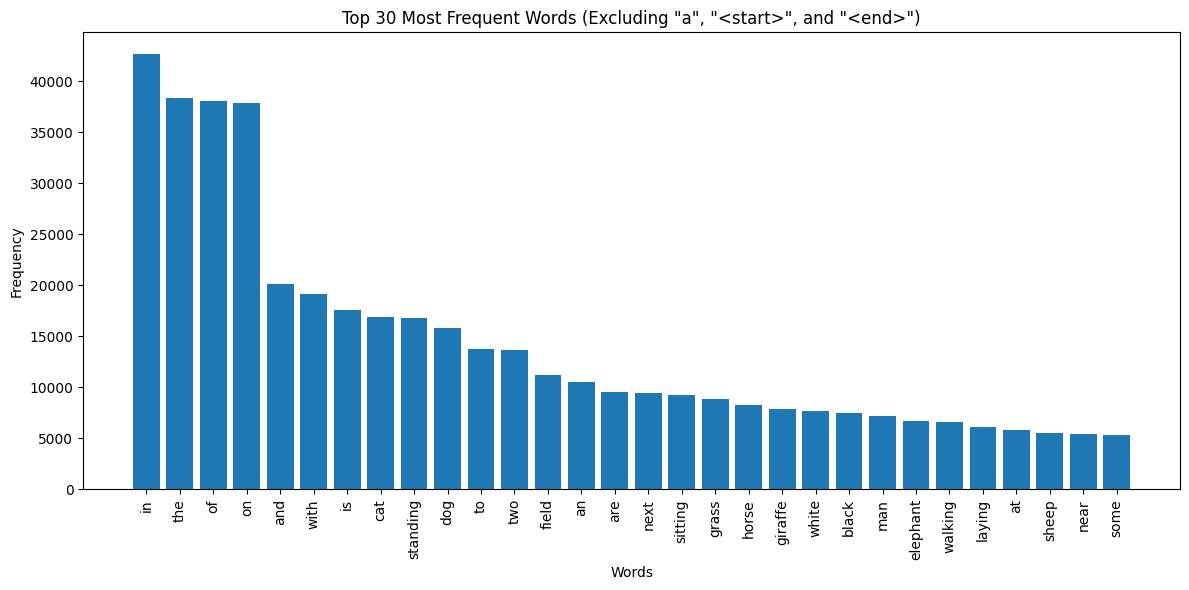

In [ ]:
# plot top 30 words in the corpus

from collections import Counter

# Split the flattened list into words and remove 'a', '<start>', and '<end>'
flatten_list = list(chain.from_iterable(url_caps.values()))
words = [word for word in (' '.join(flatten_list)).split() if word not in ['a', '<start>', '<end>']]

# Count the frequency of each word
word_counts = Counter(words)

# Get the top 30 most frequent words
top_30_words = word_counts.most_common(30)

# Extract the words and their counts for plotting
words, counts = zip(*top_30_words)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Most Frequent Words (Excluding "a", "<start>", and "<end>")')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
def data_generator(descriptions, features, tokenizer, max_length, total_words):
    while 1:
      for key, description_list in descriptions.items():
        feature = features[key][0]
        input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature, total_words)
        yield ([input_image, input_sequence], output_word)


def create_sequences(tokenizer, max_length, desc_list, feature, total_words):
    X1, X2, y = list(), list(), list()

    # walk through each description for the image
    for desc in desc_list:

        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]

        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):

            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]

            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=total_words)[0]

            # store
            X1.append(feature) # image features
            X2.append(in_seq)  # Caption input
            y.append(out_seq)  # Caption output

    return np.array(X1), np.array(X2), np.array(y)

In [ ]:
# testing shapes
[X1, X2], y = next (data_generator(url_caps, xception_features, tokenizer, max_length, total_words))
X1.shape, X2.shape, y.shape

((51, 2048), (51, 51), (51, 10497))

In [ ]:
max_length

51

In [ ]:
# define the captioning model
def baseline_model(total_words, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(512, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(total_words, 512, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(512)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    se4 = LSTM(512)(se2)
    decoderx = add([decoder1, se4])
    decoder2 = Dense(512, activation='relu')(decoderx)
    outputs = Dense(total_words, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    #print(model.summary())
    #plot_model(model, show_shapes=True)
    return model

In [ ]:
model = baseline_model(total_words, max_length)

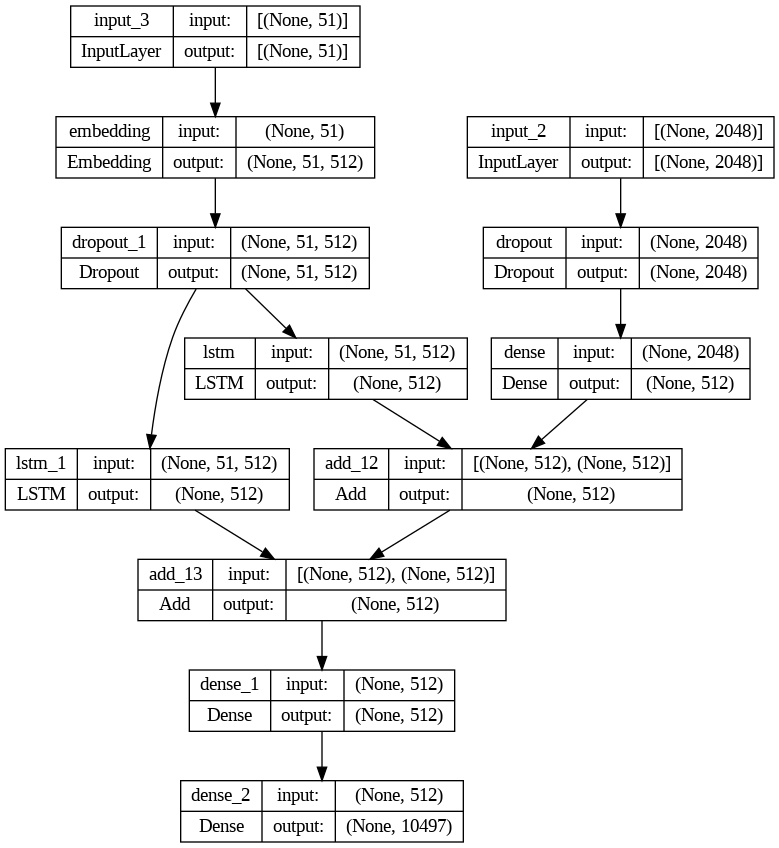

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
total_words

10497

In [ ]:
# train the model  model
print('Dataset: ', len(url_caps))
#print('Train length=', len(url_caps_train))
print('Vocabulary Size:', total_words)
print('Description Length: ', max_length)

epochs = 5
steps = len(url_caps)
#steps = len(url_caps_train
#batch_size = 32

model = baseline_model(total_words, max_length)
plot_model(model, show_shapes=True)
#steps_per_epoch = len(url_caps_train) // batch_size
#validatation_steps = len(url_caps_val)

for i in range (epochs):
  train_generator = data_generator(url_caps, xception_features, tokenizer, max_length, total_words)
  #validation_generator = data_generator(url_caps_val, xception_features_val, tokenizer, max_length, total_words)
  model.fit(train_generator, epochs=3, steps_per_epoch= steps, verbose=1)
  model.save(data_path+'/model_exp2_' + str(i) + '.h5')


#for i in range(9,11):
#
#    train_generator = data_generator(url_caps_train, xception_features_train, tokenizer, max_length, total_words, batch_size=batch_size)
#    validation_generator = data_generator(url_caps_val, xception_features_val, tokenizer, max_length, total_words, batch_size=batch_size)
#    model.fit(train_generator, epochs=i, steps_per_epoch= steps_per_epoch, validation_data = validation_generator, validation_steps =validatation_steps)
#    model.save(data_path+'/model_test_' + str(i) + '.h5')

Dataset:  21330
Vocabulary Size: 10497
Description Length:  51
Epoch 1/3
21330/21330 [==============================] - 2775s 130ms/step - loss: 3.0205
Epoch 2/3
21330/21330 [==============================] - 2750s 129ms/step - loss: 2.6614
Epoch 3/3
21330/21330 [==============================] - 2741s 129ms/step - loss: 2.6029


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/3
21330/21330 [==============================] - 2740s 128ms/step - loss: 2.5899
Epoch 2/3
21330/21330 [==============================] - 2745s 129ms/step - loss: 2.5945
Epoch 3/3
21330/21330 [==============================] - 2742s 129ms/step - loss: 2.6047
Epoch 1/3
21330/21330 [==============================] - 2744s 129ms/step - loss: 2.6189
Epoch 2/3
21330/21330 [==============================] - 2752s 129ms/step - loss: 2.6318
Epoch 3/3
21330/21330 [==============================] - 2755s 129ms/step - loss: 2.6462
Epoch 1/3
21330/21330 [==============================] - 2763s 130ms/step - loss: 2.6595
Epoch 2/3
21330/21330 [==============================] - 2756s 129ms/step - loss: 2.6750
Epoch 3/3
21330/21330 [==============================] - 2754s 129ms/step - loss: 2.6885
Epoch 1/3
21330/21330 [==============================] - 2758s 129ms/step - loss: 2.7006
Epoch 2/3
21330/21330 [==============================] - 2751s 129ms/step - loss: 2.7134
Epoch 3/3
21330/21330

In [ ]:
### val data

val_coco = COCO(data_path + "/annotations/instances_val2017.json")
val_coco_caps = COCO(data_path + "/annotations/captions_val2017.json")

val_cat = get_cat(val_coco)

val_cat_catId = get_catCatId(val_coco, val_cat)

val_cat_imgId = get_cat_imgId(val_coco, val_cat_catId)

val_cats = val_cat_imgId['giraffe'] + val_cat_imgId['elephant'] + val_cat_imgId['cat'] + val_cat_imgId['dog'] + val_cat_imgId['horse'] + val_cat_imgId['sheep'] + val_cat_imgId['cow']  + val_cat_imgId['bear'] + val_cat_imgId['zebra']  #+ cat_imgId['bird']

imgIds = coco.getImgIds(imgIds = val_cats)

val_url_caps = generate_url_caps(imgIds, val_coco, val_coco_caps)

loading annotations into memory...
Done (t=1.37s)
creating index...
index created!
loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


In [ ]:
val_xception_features = extract_xception_features(model_xception, val_url_caps)

  0%|          | 0/190 [00:00<?, ?it/s]

1/1 [==============================] - 1s 893ms/step


  1%|          | 1/190 [00:01<04:12,  1.33s/it]

1/1 [==============================] - 0s 96ms/step


  1%|          | 2/190 [00:01<02:24,  1.30it/s]

1/1 [==============================] - 0s 97ms/step


  2%|▏         | 3/190 [00:02<01:48,  1.73it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▏         | 4/190 [00:02<01:33,  2.00it/s]

1/1 [==============================] - 0s 94ms/step


  3%|▎         | 5/190 [00:02<01:28,  2.08it/s]

1/1 [==============================] - 0s 90ms/step


  3%|▎         | 6/190 [00:03<01:21,  2.24it/s]

1/1 [==============================] - 0s 87ms/step


  4%|▎         | 7/190 [00:03<01:18,  2.34it/s]

1/1 [==============================] - 0s 93ms/step


  4%|▍         | 8/190 [00:04<01:16,  2.39it/s]

1/1 [==============================] - 0s 94ms/step


  5%|▍         | 9/190 [00:04<01:13,  2.48it/s]

1/1 [==============================] - 0s 89ms/step


  5%|▌         | 10/190 [00:04<01:12,  2.49it/s]

1/1 [==============================] - 0s 91ms/step


  6%|▌         | 11/190 [00:05<01:14,  2.40it/s]

1/1 [==============================] - 0s 90ms/step


  6%|▋         | 12/190 [00:05<01:12,  2.46it/s]

1/1 [==============================] - 0s 90ms/step


  7%|▋         | 13/190 [00:06<01:17,  2.27it/s]

1/1 [==============================] - 0s 90ms/step


  7%|▋         | 14/190 [00:06<01:14,  2.37it/s]

1/1 [==============================] - 0s 87ms/step


  8%|▊         | 15/190 [00:06<01:12,  2.43it/s]

1/1 [==============================] - 0s 93ms/step


  8%|▊         | 16/190 [00:07<01:10,  2.45it/s]

1/1 [==============================] - 0s 91ms/step


  9%|▉         | 17/190 [00:07<01:10,  2.44it/s]

1/1 [==============================] - 0s 92ms/step


  9%|▉         | 18/190 [00:08<01:09,  2.47it/s]

1/1 [==============================] - 0s 90ms/step


 10%|█         | 19/190 [00:08<01:09,  2.48it/s]

1/1 [==============================] - 0s 95ms/step


 11%|█         | 20/190 [00:08<01:08,  2.50it/s]

1/1 [==============================] - 0s 98ms/step


 11%|█         | 21/190 [00:09<01:07,  2.51it/s]

1/1 [==============================] - 0s 86ms/step


 12%|█▏        | 22/190 [00:09<01:05,  2.55it/s]

1/1 [==============================] - 0s 88ms/step


 12%|█▏        | 23/190 [00:10<01:06,  2.50it/s]

1/1 [==============================] - 0s 87ms/step


 13%|█▎        | 24/190 [00:10<01:04,  2.57it/s]

1/1 [==============================] - 0s 87ms/step


 13%|█▎        | 25/190 [00:11<01:10,  2.34it/s]

1/1 [==============================] - 0s 93ms/step


 14%|█▎        | 26/190 [00:11<01:07,  2.42it/s]

1/1 [==============================] - 0s 93ms/step


 14%|█▍        | 27/190 [00:11<01:13,  2.22it/s]

1/1 [==============================] - 0s 95ms/step


 15%|█▍        | 28/190 [00:12<01:10,  2.30it/s]

1/1 [==============================] - 0s 88ms/step


 15%|█▌        | 29/190 [00:12<01:08,  2.35it/s]

1/1 [==============================] - 0s 92ms/step


 16%|█▌        | 30/190 [00:13<01:08,  2.33it/s]

1/1 [==============================] - 0s 96ms/step


 16%|█▋        | 31/190 [00:13<01:05,  2.42it/s]

1/1 [==============================] - 0s 88ms/step


 17%|█▋        | 32/190 [00:13<01:02,  2.55it/s]

1/1 [==============================] - 0s 96ms/step


 17%|█▋        | 33/190 [00:14<01:02,  2.51it/s]

1/1 [==============================] - 0s 89ms/step


 18%|█▊        | 34/190 [00:14<01:00,  2.57it/s]

1/1 [==============================] - 0s 89ms/step


 18%|█▊        | 35/190 [00:15<01:02,  2.48it/s]

1/1 [==============================] - 0s 87ms/step


 19%|█▉        | 36/190 [00:15<01:01,  2.51it/s]

1/1 [==============================] - 0s 88ms/step


 19%|█▉        | 37/190 [00:16<01:09,  2.19it/s]

1/1 [==============================] - 0s 94ms/step


 20%|██        | 38/190 [00:16<01:07,  2.26it/s]

1/1 [==============================] - 0s 96ms/step


 21%|██        | 39/190 [00:16<01:05,  2.32it/s]

1/1 [==============================] - 0s 88ms/step


 21%|██        | 40/190 [00:17<01:01,  2.45it/s]

1/1 [==============================] - 0s 90ms/step


 22%|██▏       | 41/190 [00:17<01:02,  2.37it/s]

1/1 [==============================] - 0s 90ms/step


 22%|██▏       | 42/190 [00:18<01:10,  2.10it/s]

1/1 [==============================] - 0s 92ms/step


 23%|██▎       | 43/190 [00:18<01:05,  2.25it/s]

1/1 [==============================] - 0s 87ms/step


 23%|██▎       | 44/190 [00:19<01:02,  2.33it/s]

1/1 [==============================] - 0s 87ms/step


 24%|██▎       | 45/190 [00:19<01:01,  2.37it/s]

1/1 [==============================] - 0s 86ms/step


 24%|██▍       | 46/190 [00:19<00:58,  2.45it/s]

1/1 [==============================] - 0s 92ms/step


 25%|██▍       | 47/190 [00:20<00:58,  2.46it/s]

1/1 [==============================] - 0s 94ms/step


 25%|██▌       | 48/190 [00:20<00:56,  2.52it/s]

1/1 [==============================] - 0s 89ms/step


 26%|██▌       | 49/190 [00:21<01:00,  2.35it/s]

1/1 [==============================] - 0s 88ms/step


 26%|██▋       | 50/190 [00:21<00:58,  2.41it/s]

1/1 [==============================] - 0s 84ms/step


 27%|██▋       | 51/190 [00:21<00:56,  2.48it/s]

1/1 [==============================] - 0s 90ms/step


 27%|██▋       | 52/190 [00:22<00:55,  2.50it/s]

1/1 [==============================] - 0s 93ms/step


 28%|██▊       | 53/190 [00:22<00:55,  2.49it/s]

1/1 [==============================] - 0s 95ms/step


 28%|██▊       | 54/190 [00:23<00:56,  2.42it/s]

1/1 [==============================] - 0s 94ms/step


 29%|██▉       | 55/190 [00:23<00:57,  2.36it/s]

1/1 [==============================] - 0s 93ms/step


 29%|██▉       | 56/190 [00:23<00:54,  2.46it/s]

1/1 [==============================] - 0s 87ms/step


 30%|███       | 57/190 [00:24<00:52,  2.54it/s]

1/1 [==============================] - 0s 89ms/step


 31%|███       | 58/190 [00:24<00:53,  2.45it/s]

1/1 [==============================] - 0s 90ms/step


 31%|███       | 59/190 [00:25<00:53,  2.45it/s]

1/1 [==============================] - 0s 89ms/step


 32%|███▏      | 60/190 [00:25<00:52,  2.49it/s]

1/1 [==============================] - 0s 97ms/step


 32%|███▏      | 61/190 [00:26<00:54,  2.37it/s]

1/1 [==============================] - 0s 88ms/step


 33%|███▎      | 62/190 [00:26<00:54,  2.36it/s]

1/1 [==============================] - 0s 87ms/step


 33%|███▎      | 63/190 [00:26<00:53,  2.38it/s]

1/1 [==============================] - 0s 87ms/step


 34%|███▎      | 64/190 [00:27<00:51,  2.43it/s]

1/1 [==============================] - 0s 93ms/step


 34%|███▍      | 65/190 [00:27<00:50,  2.47it/s]

1/1 [==============================] - 0s 90ms/step


 35%|███▍      | 66/190 [00:28<00:48,  2.54it/s]

1/1 [==============================] - 0s 88ms/step


 35%|███▌      | 67/190 [00:28<00:47,  2.57it/s]

1/1 [==============================] - 0s 90ms/step


 36%|███▌      | 68/190 [00:28<00:45,  2.70it/s]

1/1 [==============================] - 0s 90ms/step


 36%|███▋      | 69/190 [00:29<00:45,  2.68it/s]

1/1 [==============================] - 0s 86ms/step


 37%|███▋      | 70/190 [00:29<00:44,  2.70it/s]

1/1 [==============================] - 0s 88ms/step


 37%|███▋      | 71/190 [00:29<00:45,  2.64it/s]

1/1 [==============================] - 0s 87ms/step


 38%|███▊      | 72/190 [00:30<00:46,  2.53it/s]

1/1 [==============================] - 0s 96ms/step


 38%|███▊      | 73/190 [00:30<00:46,  2.52it/s]

1/1 [==============================] - 0s 85ms/step


 39%|███▉      | 74/190 [00:31<00:44,  2.59it/s]

1/1 [==============================] - 0s 85ms/step


 39%|███▉      | 75/190 [00:31<00:44,  2.59it/s]

1/1 [==============================] - 0s 86ms/step


 40%|████      | 76/190 [00:31<00:44,  2.58it/s]

1/1 [==============================] - 0s 89ms/step


 41%|████      | 77/190 [00:32<00:43,  2.60it/s]

1/1 [==============================] - 0s 90ms/step


 41%|████      | 78/190 [00:32<00:43,  2.59it/s]

1/1 [==============================] - 0s 87ms/step


 42%|████▏     | 79/190 [00:32<00:43,  2.56it/s]

1/1 [==============================] - 0s 89ms/step


 42%|████▏     | 80/190 [00:33<00:43,  2.51it/s]

1/1 [==============================] - 0s 90ms/step


 43%|████▎     | 81/190 [00:33<00:44,  2.46it/s]

1/1 [==============================] - 0s 86ms/step


 43%|████▎     | 82/190 [00:34<00:42,  2.51it/s]

1/1 [==============================] - 0s 90ms/step


 44%|████▎     | 83/190 [00:34<00:42,  2.52it/s]

1/1 [==============================] - 0s 87ms/step


 44%|████▍     | 84/190 [00:35<00:42,  2.47it/s]

1/1 [==============================] - 0s 89ms/step


 45%|████▍     | 85/190 [00:35<00:42,  2.50it/s]

1/1 [==============================] - 0s 88ms/step


 45%|████▌     | 86/190 [00:35<00:42,  2.46it/s]

1/1 [==============================] - 0s 87ms/step


 46%|████▌     | 87/190 [00:36<00:41,  2.49it/s]

1/1 [==============================] - 0s 91ms/step


 46%|████▋     | 88/190 [00:36<00:40,  2.54it/s]

1/1 [==============================] - 0s 88ms/step


 47%|████▋     | 89/190 [00:37<00:41,  2.44it/s]

1/1 [==============================] - 0s 89ms/step


 47%|████▋     | 90/190 [00:37<00:41,  2.41it/s]

1/1 [==============================] - 0s 92ms/step


 48%|████▊     | 91/190 [00:37<00:41,  2.38it/s]

1/1 [==============================] - 0s 93ms/step


 48%|████▊     | 92/190 [00:38<00:40,  2.42it/s]

1/1 [==============================] - 0s 90ms/step


 49%|████▉     | 93/190 [00:38<00:38,  2.50it/s]

1/1 [==============================] - 0s 91ms/step


 49%|████▉     | 94/190 [00:39<00:38,  2.49it/s]

1/1 [==============================] - 0s 89ms/step


 50%|█████     | 95/190 [00:39<00:36,  2.57it/s]

1/1 [==============================] - 0s 93ms/step


 51%|█████     | 96/190 [00:39<00:36,  2.59it/s]

1/1 [==============================] - 0s 92ms/step


 51%|█████     | 97/190 [00:40<00:35,  2.64it/s]

1/1 [==============================] - 0s 90ms/step


 52%|█████▏    | 98/190 [00:40<00:35,  2.58it/s]

1/1 [==============================] - 0s 91ms/step


 52%|█████▏    | 99/190 [00:40<00:35,  2.56it/s]

1/1 [==============================] - 0s 92ms/step


 53%|█████▎    | 100/190 [00:41<00:35,  2.53it/s]

1/1 [==============================] - 0s 89ms/step


 53%|█████▎    | 101/190 [00:41<00:35,  2.53it/s]

1/1 [==============================] - 0s 91ms/step


 54%|█████▎    | 102/190 [00:42<00:36,  2.39it/s]

1/1 [==============================] - 0s 85ms/step


 54%|█████▍    | 103/190 [00:42<00:34,  2.50it/s]

1/1 [==============================] - 0s 86ms/step


 55%|█████▍    | 104/190 [00:43<00:36,  2.35it/s]

1/1 [==============================] - 0s 88ms/step


 55%|█████▌    | 105/190 [00:43<00:37,  2.25it/s]

1/1 [==============================] - 0s 103ms/step


 56%|█████▌    | 106/190 [00:43<00:35,  2.34it/s]

1/1 [==============================] - 0s 85ms/step


 56%|█████▋    | 107/190 [00:44<00:34,  2.43it/s]

1/1 [==============================] - 0s 86ms/step


 57%|█████▋    | 108/190 [00:44<00:34,  2.39it/s]

1/1 [==============================] - 0s 85ms/step


 57%|█████▋    | 109/190 [00:45<00:32,  2.50it/s]

1/1 [==============================] - 0s 86ms/step


 58%|█████▊    | 110/190 [00:45<00:33,  2.37it/s]

1/1 [==============================] - 0s 86ms/step


 58%|█████▊    | 111/190 [00:45<00:31,  2.50it/s]

1/1 [==============================] - 0s 85ms/step


 59%|█████▉    | 112/190 [00:46<00:30,  2.56it/s]

1/1 [==============================] - 0s 85ms/step


 59%|█████▉    | 113/190 [00:46<00:31,  2.47it/s]

1/1 [==============================] - 0s 86ms/step


 60%|██████    | 114/190 [00:47<00:30,  2.52it/s]

1/1 [==============================] - 0s 85ms/step


 61%|██████    | 115/190 [00:47<00:29,  2.59it/s]

1/1 [==============================] - 0s 88ms/step


 61%|██████    | 116/190 [00:47<00:28,  2.58it/s]

1/1 [==============================] - 0s 87ms/step


 62%|██████▏   | 117/190 [00:48<00:28,  2.55it/s]

1/1 [==============================] - 0s 86ms/step


 62%|██████▏   | 118/190 [00:48<00:27,  2.62it/s]

1/1 [==============================] - 0s 90ms/step


 63%|██████▎   | 119/190 [00:49<00:27,  2.59it/s]

1/1 [==============================] - 0s 88ms/step


 63%|██████▎   | 120/190 [00:49<00:26,  2.61it/s]

1/1 [==============================] - 0s 90ms/step


 64%|██████▎   | 121/190 [00:49<00:26,  2.61it/s]

1/1 [==============================] - 0s 86ms/step


 64%|██████▍   | 122/190 [00:50<00:26,  2.58it/s]

1/1 [==============================] - 0s 88ms/step


 65%|██████▍   | 123/190 [00:50<00:26,  2.57it/s]

1/1 [==============================] - 0s 87ms/step


 65%|██████▌   | 124/190 [00:51<00:26,  2.53it/s]

1/1 [==============================] - 0s 88ms/step


 66%|██████▌   | 125/190 [00:51<00:25,  2.57it/s]

1/1 [==============================] - 0s 88ms/step


 66%|██████▋   | 126/190 [00:51<00:24,  2.59it/s]

1/1 [==============================] - 0s 87ms/step


 67%|██████▋   | 127/190 [00:52<00:24,  2.62it/s]

1/1 [==============================] - 0s 88ms/step


 67%|██████▋   | 128/190 [00:52<00:24,  2.58it/s]

1/1 [==============================] - 0s 85ms/step


 68%|██████▊   | 129/190 [00:53<00:24,  2.44it/s]

1/1 [==============================] - 0s 87ms/step


 68%|██████▊   | 130/190 [00:53<00:24,  2.46it/s]

1/1 [==============================] - 0s 87ms/step


 69%|██████▉   | 131/190 [00:53<00:24,  2.45it/s]

1/1 [==============================] - 0s 88ms/step


 69%|██████▉   | 132/190 [00:54<00:24,  2.41it/s]

1/1 [==============================] - 0s 85ms/step


 70%|███████   | 133/190 [00:54<00:22,  2.48it/s]

1/1 [==============================] - 0s 85ms/step


 71%|███████   | 134/190 [00:55<00:22,  2.47it/s]

1/1 [==============================] - 0s 86ms/step


 71%|███████   | 135/190 [00:55<00:21,  2.50it/s]

1/1 [==============================] - 0s 86ms/step


 72%|███████▏  | 136/190 [00:55<00:21,  2.49it/s]

1/1 [==============================] - 0s 87ms/step


 72%|███████▏  | 137/190 [00:56<00:21,  2.52it/s]

1/1 [==============================] - 0s 85ms/step


 73%|███████▎  | 138/190 [00:56<00:20,  2.52it/s]

1/1 [==============================] - 0s 86ms/step


 73%|███████▎  | 139/190 [00:57<00:20,  2.49it/s]

1/1 [==============================] - 0s 86ms/step


 74%|███████▎  | 140/190 [00:57<00:20,  2.50it/s]

1/1 [==============================] - 0s 84ms/step


 74%|███████▍  | 141/190 [00:57<00:18,  2.59it/s]

1/1 [==============================] - 0s 84ms/step


 75%|███████▍  | 142/190 [00:58<00:19,  2.47it/s]

1/1 [==============================] - 0s 88ms/step


 75%|███████▌  | 143/190 [00:58<00:19,  2.43it/s]

1/1 [==============================] - 0s 86ms/step


 76%|███████▌  | 144/190 [00:59<00:19,  2.38it/s]

1/1 [==============================] - 0s 85ms/step


 76%|███████▋  | 145/190 [00:59<00:18,  2.39it/s]

1/1 [==============================] - 0s 84ms/step


 77%|███████▋  | 146/190 [01:00<00:19,  2.27it/s]

1/1 [==============================] - 0s 84ms/step


 77%|███████▋  | 147/190 [01:00<00:18,  2.33it/s]

1/1 [==============================] - 0s 85ms/step


 78%|███████▊  | 148/190 [01:00<00:17,  2.40it/s]

1/1 [==============================] - 0s 85ms/step


 78%|███████▊  | 149/190 [01:01<00:16,  2.45it/s]

1/1 [==============================] - 0s 86ms/step


 79%|███████▉  | 150/190 [01:01<00:16,  2.49it/s]

1/1 [==============================] - 0s 88ms/step


 79%|███████▉  | 151/190 [01:01<00:15,  2.54it/s]

1/1 [==============================] - 0s 88ms/step


 80%|████████  | 152/190 [01:02<00:15,  2.48it/s]

1/1 [==============================] - 0s 86ms/step


 81%|████████  | 153/190 [01:02<00:15,  2.46it/s]

1/1 [==============================] - 0s 87ms/step


 81%|████████  | 154/190 [01:03<00:15,  2.30it/s]

1/1 [==============================] - 0s 87ms/step


 82%|████████▏ | 155/190 [01:03<00:15,  2.28it/s]

1/1 [==============================] - 0s 86ms/step


 82%|████████▏ | 156/190 [01:04<00:14,  2.33it/s]

1/1 [==============================] - 0s 89ms/step


 83%|████████▎ | 157/190 [01:04<00:14,  2.35it/s]

1/1 [==============================] - 0s 87ms/step


 83%|████████▎ | 158/190 [01:05<00:13,  2.30it/s]

1/1 [==============================] - 0s 87ms/step


 84%|████████▎ | 159/190 [01:05<00:13,  2.38it/s]

1/1 [==============================] - 0s 86ms/step


 84%|████████▍ | 160/190 [01:05<00:12,  2.44it/s]

1/1 [==============================] - 0s 86ms/step


 85%|████████▍ | 161/190 [01:06<00:11,  2.42it/s]

1/1 [==============================] - 0s 87ms/step


 85%|████████▌ | 162/190 [01:06<00:11,  2.36it/s]

1/1 [==============================] - 0s 89ms/step


 86%|████████▌ | 163/190 [01:07<00:11,  2.38it/s]

1/1 [==============================] - 0s 87ms/step


 86%|████████▋ | 164/190 [01:07<00:10,  2.41it/s]

1/1 [==============================] - 0s 87ms/step


 87%|████████▋ | 165/190 [01:07<00:10,  2.40it/s]

1/1 [==============================] - 0s 86ms/step


 87%|████████▋ | 166/190 [01:08<00:09,  2.47it/s]

1/1 [==============================] - 0s 86ms/step


 88%|████████▊ | 167/190 [01:08<00:09,  2.50it/s]

1/1 [==============================] - 0s 87ms/step


 88%|████████▊ | 168/190 [01:09<00:08,  2.50it/s]

1/1 [==============================] - 0s 86ms/step


 89%|████████▉ | 169/190 [01:09<00:08,  2.47it/s]

1/1 [==============================] - 0s 86ms/step


 89%|████████▉ | 170/190 [01:09<00:08,  2.42it/s]

1/1 [==============================] - 0s 86ms/step


 90%|█████████ | 171/190 [01:10<00:07,  2.50it/s]

1/1 [==============================] - 0s 87ms/step


 91%|█████████ | 172/190 [01:10<00:07,  2.52it/s]

1/1 [==============================] - 0s 86ms/step


 91%|█████████ | 173/190 [01:11<00:06,  2.50it/s]

1/1 [==============================] - 0s 89ms/step


 92%|█████████▏| 174/190 [01:11<00:06,  2.53it/s]

1/1 [==============================] - 0s 86ms/step


 92%|█████████▏| 175/190 [01:11<00:06,  2.49it/s]

1/1 [==============================] - 0s 86ms/step


 93%|█████████▎| 176/190 [01:12<00:06,  2.27it/s]

1/1 [==============================] - 0s 86ms/step


 93%|█████████▎| 177/190 [01:12<00:05,  2.33it/s]

1/1 [==============================] - 0s 84ms/step


 94%|█████████▎| 178/190 [01:13<00:05,  2.30it/s]

1/1 [==============================] - 0s 88ms/step


 94%|█████████▍| 179/190 [01:13<00:04,  2.34it/s]

1/1 [==============================] - 0s 86ms/step


 95%|█████████▍| 180/190 [01:14<00:04,  2.41it/s]

1/1 [==============================] - 0s 88ms/step


 95%|█████████▌| 181/190 [01:14<00:03,  2.52it/s]

1/1 [==============================] - 0s 88ms/step


 96%|█████████▌| 182/190 [01:14<00:03,  2.59it/s]

1/1 [==============================] - 0s 88ms/step


 96%|█████████▋| 183/190 [01:15<00:02,  2.50it/s]

1/1 [==============================] - 0s 89ms/step


 97%|█████████▋| 184/190 [01:15<00:02,  2.45it/s]

1/1 [==============================] - 0s 87ms/step


 97%|█████████▋| 185/190 [01:16<00:02,  2.41it/s]

1/1 [==============================] - 0s 88ms/step


 98%|█████████▊| 186/190 [01:16<00:01,  2.42it/s]

1/1 [==============================] - 0s 87ms/step


 98%|█████████▊| 187/190 [01:16<00:01,  2.43it/s]

1/1 [==============================] - 0s 88ms/step


 99%|█████████▉| 188/190 [01:17<00:00,  2.48it/s]

1/1 [==============================] - 0s 88ms/step


 99%|█████████▉| 189/190 [01:17<00:00,  2.51it/s]

1/1 [==============================] - 0s 87ms/step


100%|██████████| 190/190 [01:18<00:00,  2.43it/s]


In [ ]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)

        if word is None:
            break
        in_text += ' ' + word

        if word == 'end':
            break
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

bleu_dict = {}
for i in range(5):
  bleu_dict[i] = [0, 0, 0, 0]

for i in range (5):
  print('model'+str(i))
  model = load_model('/content/gdrive/MyDrive/w266_proj/model_exp2_' + str(i) + '.h5')
  for url, feature in val_xception_features.items():
    actual, predicted = list(), list()
    description = generate_desc(model, tokenizer, feature, max_length)
    caps_list = val_url_caps[url]
    references = [c.split() for c in caps_list]
    actual.append(references)
    predicted.append(description.split())
    bleu_dict[i][0] = bleu_dict[i][0] + corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_dict[i][1] = bleu_dict[i][1] + corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_dict[i][2] = bleu_dict[i][2] + corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu_dict[i][3] = bleu_dict[i][3] + corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

model0


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

model1
model2
model3
model4


In [ ]:
bleu_dict

{0: [0.4873068749822628,
  0.3085415436514354,
  0.17316405540231136,
  0.0754133535049517],
 1: [0.4765794392247771,
  0.3056440311951613,
  0.17447857547882767,
  0.07824315729462158],
 2: [0.4618592775237057,
  0.29875058632562057,
  0.1648223939561334,
  0.06836717431706626],
 3: [0.4700749101578151,
  0.3048594984788888,
  0.16833415145566308,
  0.06201580119617532],
 4: [0.4838970921416593,
  0.3058595190494324,
  0.1533446879061958,
  0.06118982117142033]}

In [ ]:
for i in range(5):
  for j in range(4):
    bleu_dict[i][j] = bleu_dict[i][j] / len(list(val_xception_features.keys()))

In [ ]:
bleu_dict

{0: [0.4873068749822628,
  0.3085415436514354,
  0.17316405540231136,
  0.0754133535049517],
 1: [0.4765794392247771,
  0.3056440311951613,
  0.17447857547882767,
  0.07824315729462158],
 2: [0.4618592775237057,
  0.29875058632562057,
  0.1648223939561334,
  0.06836717431706626],
 3: [0.4700749101578151,
  0.3048594984788888,
  0.16833415145566308,
  0.06201580119617532],
 4: [0.4838970921416593,
  0.3058595190494324,
  0.1533446879061958,
  0.06118982117142033]}

In [ ]:
# save features
pick_insert = open(data_path+'/exp2_bleu.pkl','wb')
pickle.dump(bleu_dict, pick_insert)
pick_insert.close()

In [ ]:
# open features (run this if they have alreadt been saved)
pick_read = open(data_path+'/exp2_bleu.pkl','rb')
test = pickle.load(pick_read)
pick_read.close()

In [ ]:
test

{0: [0.4873068749822628,
  0.3085415436514354,
  0.17316405540231136,
  0.0754133535049517],
 1: [0.4765794392247771,
  0.3056440311951613,
  0.17447857547882767,
  0.07824315729462158],
 2: [0.4618592775237057,
  0.29875058632562057,
  0.1648223939561334,
  0.06836717431706626],
 3: [0.4700749101578151,
  0.3048594984788888,
  0.16833415145566308,
  0.06201580119617532],
 4: [0.4838970921416593,
  0.3058595190494324,
  0.1533446879061958,
  0.06118982117142033]}

In [ ]:
vocab_size = total_words
embedding_dim = 200

In [ ]:
from tensorflow.keras.layers import Input, Dropout, Dense, Reshape, Embedding, GRU
from tensorflow.keras.models import Model

In [ ]:
def create_init_inject_model():

    inputs1 = Input(shape=(2048,))
    img1 = Dropout(0.5)(inputs1)
    img2 = Dense(256, activation='relu')(img1)

    inputs2 = Input(shape=(max_length,))
    seq1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
    seq2 = Dropout(0.5)(seq1)

    #image is set as state
    seq3,state = GRU(256,return_state = True)(seq2,initial_state = img2)

    dec2 = Dense(256, activation='relu')(seq3)
    outputs = Dense(vocab_size, activation='softmax')(dec2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)

    #set embedding layer's weight matrix
    #model.layers[2].set_weights([embedding_matrix])
    #model.layers[2].trainable = True

    return model

In [ ]:
xx = create_init_inject_model()

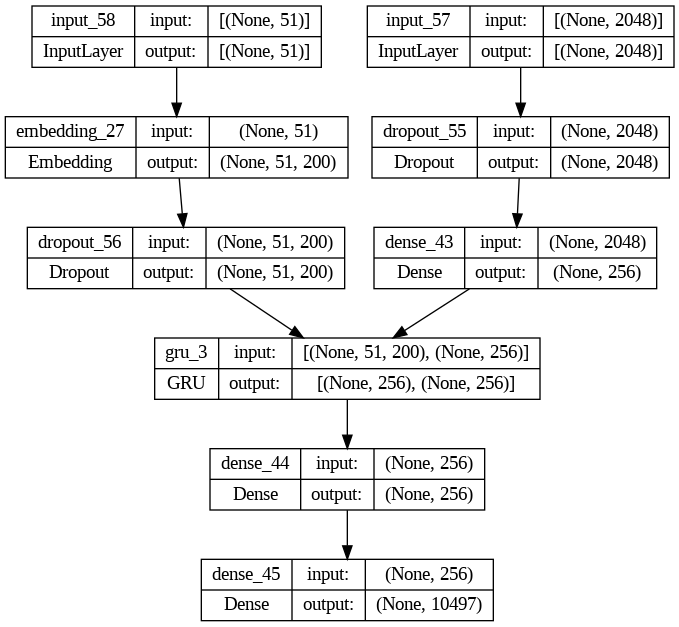

In [ ]:
plot_model(xx, show_shapes=True)

In [ ]:
# prompt: convert this code to use LSTM instead of GRU
# def create_init_inject_model():
#     inputs1 = Input(shape=(2048,))
#     img1 = Dropout(0.5)(inputs1)
#     img2 = Dense(256, activation='relu')(img1)
#     inputs2 = Input(shape=(max_length,))
#     seq1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
#     seq2 = Dropout(0.5)(seq1)
#     #image is set as state
#     seq3,state = GRU(256

def create_init_inject_model():

  inputs1 = Input(shape=(2048,))
  img1 = Dropout(0.5)(inputs1)
  img2 = Dense(256, activation='relu')(img1)

  inputs2 = Input(shape=(max_length,))
  seq1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
  seq2 = Dropout(0.5)(seq1)

  #image is set as state
  seq3,state_h, state_c = LSTM(256,return_state = True)(seq2,initial_state = [img2, img2])

  dec2 = Dense(256, activation='relu')(seq3)
  outputs = Dense(vocab_size, activation='softmax')(dec2)

  model = Model(inputs=[inputs1, inputs2], outputs=outputs)

  #set embedding layer's weight matrix
  #model.layers[2].set_weights([embedding_matrix])
  #model.layers[2].trainable = True

  return model


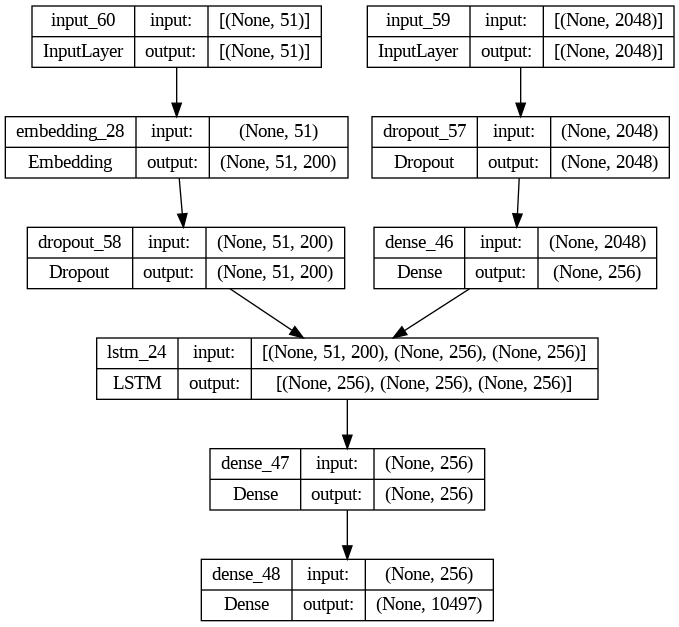

In [ ]:
yy = create_init_inject_model()
plot_model(yy, show_shapes=True)

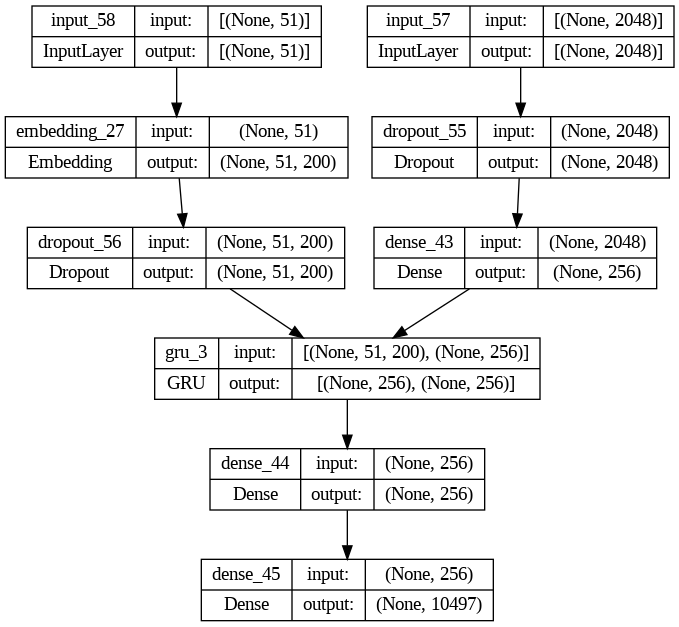

In [ ]:
plot_model(xx, show_shapes=True)